In [1]:
!pip install torchaudio transformers librosa soundfile faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.6 MB/s eta 0:00:00


In [2]:
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer, AutoModel, AutoFeatureExtractor
from transformers import AutoFeatureExtractor, ASTFeatureExtractor, ASTForAudioClassification, ASTModel
from IPython.display import Audio, display
import librosa
import soundfile as sf
import os
import faiss

In [3]:
# Load the Wav2Vec2.0 tokenizer and model
model = AutoModel.from_pretrained('facebook/wav2vec2-base-960h')
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

feature_extractor_ast = AutoFeatureExtractor.from_pretrained('MIT/ast-finetuned-audioset-10-10-0.4593')
model_ast = ASTModel.from_pretrained('MIT/ast-finetuned-audioset-10-10-0.4593')

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 were not used when initializing ASTModel: ['classifier.dense.weight', 'classifier.layernorm.weight', 'classifier.layernorm.bias', 'classifier.dense.bias']
- This IS expected if you are initializing ASTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ASTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
torch.cuda.is_available()

True

In [5]:
model.to('cuda:0')
model_ast.to('cuda:0')

ASTModel(
  (embeddings): ASTEmbeddings(
    (patch_embeddings): ASTPatchEmbeddings(
      (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ASTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ASTLayer(
        (attention): ASTAttention(
          (attention): ASTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ASTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ASTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

## Resampling the songs to 16000 sample rate and splitting the track into 10 second small tracks

In [6]:
sample_rate = 16000
number_of_seconds = 10
dir_name = 'wav_files'
dest_dir = 'wav_files/10_seconds_samples/'

In [8]:

# for files in os.listdir(dir_name):
#     if '.wav' in files:
#         file_path = os.path.join(dir_name,files)
#         x, sr = librosa.load(file_path, sr=16000)
#         print("Splitting file {} with sample rate {}".format(files, sr))
#         initial_seconds = number_of_seconds
#         for i in range(0, len(x), number_of_seconds * sr):
#             y = x[i: number_of_seconds * sr + (i)]
#             out_file = str(initial_seconds) + "_" + files
#             initial_seconds = initial_seconds + number_of_seconds
#             sf.write(os.path.join(dest_dir,out_file), y, sr)
            


In [9]:
x, sr = librosa.load('/content/drive/MyDrive/music-llm/raw/10_seconds_samples/1000_KW20 - Various Artists.mp3.wav', sr=16000)

<ipython-input-9-1c9f7d2a3f8e>:1: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sr = librosa.load('/content/drive/MyDrive/music-llm/raw/10_seconds_samples/1000_KW20 - Various Artists.mp3.wav', sr=16000)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: ignored

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
sr

NameError: ignored

In [14]:
waveform, sample_rate = torchaudio.load('/content/drive/MyDrive/music-llm/raw/10_seconds_samples/1000_KW20 - Various Artists.mp3.wav')
waveform = waveform.squeeze().numpy()

print(sample_rate)

16000


In [15]:
display(Audio(waveform, rate=sample_rate))
print()

## Embeddings generator

In [16]:
input_values = feature_extractor_ast(waveform, return_tensors="pt", sampling_rate=sample_rate).to('cuda:0')

In [17]:
with torch.no_grad():
    embeddings = model_ast(**input_values).last_hidden_state
    embeddings = embeddings.mean(dim=1)
    print(embeddings.shape)

torch.Size([1, 768])


In [18]:
embeddings.shape[1]

768

In [19]:
embeddings.to('cpu').detach().numpy()

array([[ 1.11579025e+00, -1.80061862e-01,  1.04540169e-01,
         1.41996101e-01,  3.42160910e-01, -2.88645446e-01,
         2.58681655e-01, -1.19933553e-01, -7.91276574e-01,
        -5.57248712e-01, -1.25762850e-01,  1.52703512e+00,
         8.19049716e-01,  1.50922430e+00, -5.16621053e-01,
         1.18071878e+00, -3.63342524e-01,  5.12535095e-01,
         5.94075799e-01, -2.73879082e-03,  2.67774880e-01,
         2.33140096e-01,  1.07663965e+00, -3.11764091e-01,
         4.29385491e-02,  2.09366813e-01, -2.75161594e-01,
        -1.66990727e-01, -6.85748309e-02, -2.53862798e-01,
        -1.93084791e-01,  1.37052685e-01,  2.43600464e+00,
         6.49903715e-01,  1.13254227e-01,  6.63256764e-01,
         1.08364952e+00, -2.81451046e-01,  8.15186596e+00,
         1.07710540e+00, -1.69059094e-02,  8.95311892e-01,
         1.79135591e-01, -5.48035574e+00,  3.62935454e-01,
         9.73385386e-03, -3.31315510e-02,  1.47846425e+00,
         7.01988637e-01, -1.38272393e+00, -9.09971222e-0

## Generate embeddings for all the small portions of the track and store it in FAISS - Wav2Vec2 and AST

In [20]:
index_wav_vec = faiss.IndexFlatL2(embeddings.shape[1])
index_ast = faiss.IndexFlatL2(embeddings.shape[1])

In [21]:
index_wav_vec.ntotal

0

In [22]:
index_ast.ntotal

0

In [23]:
index_id = 0
faiss_index_lookup_samples = {}
embeddings_ast = []
embeddings_wav = []

In [24]:

dest_dir = '/content/drive/MyDrive/music-llm/raw/10_seconds_samples/'

In [25]:
len(os.listdir(dest_dir))


10520

In [26]:
from tqdm import tqdm

In [27]:
for files in tqdm(os.listdir(dest_dir)):
    try:
        waveform, sample_rate = torchaudio.load(os.path.join(dest_dir,files))
        print("Processing files {} with sample rate {}".format(files, sample_rate))
        waveform = waveform.squeeze().numpy()
        
        #wav2vec2
        input_values = feature_extractor(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
        embeddings = model(**input_values).last_hidden_state
        embeddings = embeddings.mean(dim=1).to('cpu').detach().numpy()
        embeddings_wav.append(embeddings[0])
        index_wav_vec.add(embeddings)
        
        #ast
        input_values = feature_extractor_ast(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
        embeddings = model_ast(**input_values).last_hidden_state
        embeddings = embeddings.mean(dim=1).to('cpu').detach().numpy()
        embeddings_ast.append(embeddings[0])
        index_ast.add(embeddings)
        
        # creating index lookup
        faiss_index_lookup_samples[index_id] = os.path.join(dest_dir,files)
        index_id = index_id + 1
    except Exception as e:
        print("Error files {}".format(files))
        print(e)

  0%|          | 0/10520 [00:00<?, ?it/s]

Processing files 320_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


  0%|          | 2/10520 [00:07<9:16:49,  3.18s/it] 

Processing files 110_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 280_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


  0%|          | 4/10520 [00:09<5:21:45,  1.84s/it]

Processing files 300_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 410_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


  0%|          | 6/10520 [00:12<4:37:14,  1.58s/it]

Processing files 150_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


  0%|          | 7/10520 [00:13<4:01:16,  1.38s/it]

Processing files 30_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


  0%|          | 8/10520 [00:14<3:40:19,  1.26s/it]

Processing files 190_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 70_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


  0%|          | 10/10520 [00:16<3:17:28,  1.13s/it]

Processing files 140_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


  0%|          | 11/10520 [00:17<3:10:55,  1.09s/it]

Processing files 270_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


  0%|          | 12/10520 [00:18<3:03:02,  1.05s/it]

Processing files 310_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 13/10520 [00:19<2:56:28,  1.01s/it]

Processing files 190_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 14/10520 [00:20<2:53:36,  1.01it/s]

Processing files 220_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 15/10520 [00:21<2:50:34,  1.03it/s]

Processing files 200_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 16/10520 [00:22<2:48:25,  1.04it/s]

Processing files 210_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 10_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 18/10520 [00:24<3:08:17,  1.08s/it]

Processing files 270_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 19/10520 [00:25<3:02:35,  1.04s/it]

Processing files 30_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 20/10520 [00:26<2:56:10,  1.01s/it]

Processing files 40_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 21/10520 [00:27<2:52:49,  1.01it/s]

Processing files 300_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 22/10520 [00:28<2:50:47,  1.02it/s]

Processing files 320_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 23/10520 [00:29<2:49:01,  1.04it/s]

Processing files 70_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 24/10520 [00:30<2:50:04,  1.03it/s]

Processing files 140_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 25/10520 [00:31<2:59:11,  1.02s/it]

Processing files 120_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 26/10520 [00:32<2:54:42,  1.00it/s]

Processing files 20_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 27/10520 [00:33<2:50:29,  1.03it/s]

Processing files 100_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 28/10520 [00:34<2:49:50,  1.03it/s]

Processing files 130_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 29/10520 [00:35<2:49:22,  1.03it/s]

Processing files 250_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 30/10520 [00:36<2:46:52,  1.05it/s]

Processing files 170_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 31/10520 [00:37<2:45:35,  1.06it/s]

Processing files 50_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 32/10520 [00:38<2:46:23,  1.05it/s]

Processing files 280_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 33/10520 [00:39<2:45:46,  1.05it/s]

Processing files 180_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 34/10520 [00:39<2:46:32,  1.05it/s]

Processing files 90_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 35/10520 [00:40<2:47:31,  1.04it/s]

Processing files 160_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 36/10520 [00:42<3:08:00,  1.08s/it]

Processing files 80_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 37/10520 [00:43<3:00:48,  1.03s/it]

Processing files 150_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 38/10520 [00:44<2:55:17,  1.00s/it]

Processing files 230_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 39/10520 [00:45<3:13:20,  1.11s/it]

Processing files 110_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 40/10520 [00:46<3:03:29,  1.05s/it]

Processing files 60_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 41/10520 [00:47<2:44:43,  1.06it/s]

Processing files 240_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 42/10520 [00:48<3:07:57,  1.08s/it]

Processing files 290_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 43/10520 [00:49<3:20:01,  1.15s/it]

Processing files 260_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 44/10520 [00:50<3:09:19,  1.08s/it]

Processing files 590_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 45/10520 [00:51<3:03:04,  1.05s/it]

Processing files 380_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 46/10520 [00:52<2:58:16,  1.02s/it]

Processing files 390_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 47/10520 [00:54<3:19:00,  1.14s/it]

Processing files 400_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 48/10520 [00:55<3:06:49,  1.07s/it]

Processing files 550_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 49/10520 [00:55<2:58:38,  1.02s/it]

Processing files 630_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 50/10520 [00:56<2:52:33,  1.01it/s]

Processing files 570_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  0%|          | 51/10520 [00:57<2:51:14,  1.02it/s]

Processing files 50_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  0%|          | 52/10520 [00:58<2:48:03,  1.04it/s]

Processing files 70_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 53/10520 [00:59<2:44:25,  1.06it/s]

Processing files 60_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 54/10520 [01:00<3:05:14,  1.06s/it]

Processing files 560_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 55/10520 [01:01<3:00:41,  1.04s/it]

Processing files 10_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 56/10520 [01:02<2:57:24,  1.02s/it]

Processing files 480_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 57/10520 [01:03<2:53:57,  1.00it/s]

Processing files 460_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 58/10520 [01:04<2:49:45,  1.03it/s]

Processing files 80_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 59/10520 [01:05<2:46:55,  1.04it/s]

Processing files 600_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 60/10520 [01:06<2:47:21,  1.04it/s]

Processing files 350_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 61/10520 [01:07<2:44:33,  1.06it/s]

Processing files 510_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 62/10520 [01:08<2:32:18,  1.14it/s]

Processing files 360_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 63/10520 [01:09<2:56:40,  1.01s/it]

Processing files 450_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 64/10520 [01:10<2:53:13,  1.01it/s]

Processing files 470_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 65/10520 [01:11<2:48:17,  1.04it/s]

Processing files 620_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 66/10520 [01:13<3:22:45,  1.16s/it]

Processing files 490_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 67/10520 [01:14<3:12:44,  1.11s/it]

Processing files 430_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 68/10520 [01:14<3:02:17,  1.05s/it]

Processing files 540_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 69/10520 [01:16<3:18:21,  1.14s/it]

Processing files 370_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 70/10520 [01:17<3:15:35,  1.12s/it]

Processing files 420_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 71/10520 [01:18<3:04:25,  1.06s/it]

Processing files 440_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 72/10520 [01:19<2:55:24,  1.01s/it]

Processing files 20_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 73/10520 [01:20<2:51:00,  1.02it/s]

Processing files 500_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 74/10520 [01:21<2:47:15,  1.04it/s]

Processing files 330_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 75/10520 [01:21<2:45:58,  1.05it/s]

Processing files 40_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 76/10520 [01:22<2:44:25,  1.06it/s]

Processing files 410_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 77/10520 [01:23<2:42:20,  1.07it/s]

Processing files 340_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 78/10520 [01:24<2:41:06,  1.08it/s]

Processing files 580_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 79/10520 [01:25<2:46:00,  1.05it/s]

Processing files 30_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 80/10520 [01:26<2:43:44,  1.06it/s]

Processing files 610_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 81/10520 [01:27<2:42:04,  1.07it/s]

Processing files 530_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 82/10520 [01:28<3:03:26,  1.05s/it]

Processing files 520_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000


  1%|          | 83/10520 [01:29<2:55:29,  1.01s/it]

Processing files 110_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 84/10520 [01:31<3:14:23,  1.12s/it]

Processing files 210_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 85/10520 [01:32<3:03:38,  1.06s/it]

Processing files 140_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 86/10520 [01:33<2:55:33,  1.01s/it]

Processing files 460_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 87/10520 [01:33<2:51:08,  1.02it/s]

Processing files 230_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 88/10520 [01:34<2:46:55,  1.04it/s]

Processing files 220_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 89/10520 [01:35<2:45:31,  1.05it/s]

Processing files 10_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 90/10520 [01:36<2:41:54,  1.07it/s]

Processing files 400_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 91/10520 [01:37<2:40:39,  1.08it/s]

Processing files 190_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 92/10520 [01:38<3:03:28,  1.06s/it]

Processing files 170_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 93/10520 [01:39<2:55:14,  1.01s/it]

Processing files 480_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 94/10520 [01:40<2:49:48,  1.02it/s]

Processing files 370_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 95/10520 [01:41<2:47:06,  1.04it/s]

Processing files 100_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 96/10520 [01:42<2:43:49,  1.06it/s]

Processing files 110_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 97/10520 [01:43<3:03:55,  1.06s/it]

Processing files 70_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 98/10520 [01:44<2:58:31,  1.03s/it]

Processing files 290_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 99/10520 [01:45<2:55:40,  1.01s/it]

Processing files 500_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 100/10520 [01:46<2:52:04,  1.01it/s]

Processing files 20_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 101/10520 [01:48<3:19:27,  1.15s/it]

Processing files 120_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 102/10520 [01:49<3:07:24,  1.08s/it]

Processing files 60_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 103/10520 [01:50<3:01:21,  1.04s/it]

Processing files 340_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 104/10520 [01:51<3:13:42,  1.12s/it]

Processing files 330_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 105/10520 [01:52<3:05:18,  1.07s/it]

Processing files 80_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 106/10520 [01:53<2:57:30,  1.02s/it]

Processing files 430_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 107/10520 [01:54<2:51:01,  1.01it/s]

Processing files 410_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 108/10520 [01:55<2:50:15,  1.02it/s]

Processing files 260_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 109/10520 [01:56<2:47:12,  1.04it/s]

Processing files 310_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 110/10520 [01:57<3:06:11,  1.07s/it]

Processing files 520_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 111/10520 [01:58<3:16:01,  1.13s/it]

Processing files 540_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 112/10520 [01:59<3:25:07,  1.18s/it]

Processing files 300_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 113/10520 [02:01<3:35:04,  1.24s/it]

Processing files 160_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 114/10520 [02:02<3:18:06,  1.14s/it]

Processing files 250_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 115/10520 [02:03<3:29:15,  1.21s/it]

Processing files 200_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 116/10520 [02:04<3:19:12,  1.15s/it]

Processing files 230_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 117/10520 [02:05<3:05:52,  1.07s/it]

Processing files 550_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 118/10520 [02:06<2:58:45,  1.03s/it]

Processing files 380_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 119/10520 [02:07<2:53:08,  1.00it/s]

Processing files 120_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 120/10520 [02:08<3:10:53,  1.10s/it]

Processing files 270_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 121/10520 [02:09<2:59:27,  1.04s/it]

Processing files 130_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 122/10520 [02:10<2:54:43,  1.01s/it]

Processing files 510_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 123/10520 [02:11<2:37:58,  1.10it/s]

Processing files 240_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 124/10520 [02:12<2:37:44,  1.10it/s]

Processing files 350_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 125/10520 [02:13<2:37:10,  1.10it/s]

Processing files 160_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 126/10520 [02:14<2:59:15,  1.03s/it]

Processing files 210_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 127/10520 [02:15<2:54:49,  1.01s/it]

Processing files 220_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|          | 128/10520 [02:16<2:49:36,  1.02it/s]

Processing files 180_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 129/10520 [02:17<3:08:06,  1.09s/it]

Processing files 450_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 130/10520 [02:18<3:01:24,  1.05s/it]

Processing files 150_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|          | 131/10520 [02:19<2:55:39,  1.01s/it]

Processing files 30_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|▏         | 132/10520 [02:20<2:52:17,  1.00it/s]

Processing files 330_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|▏         | 133/10520 [02:21<3:08:34,  1.09s/it]

Processing files 240_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|▏         | 134/10520 [02:22<3:03:44,  1.06s/it]

Processing files 360_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|▏         | 135/10520 [02:24<3:15:09,  1.13s/it]

Processing files 200_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|▏         | 136/10520 [02:24<3:05:53,  1.07s/it]

Processing files 320_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|▏         | 137/10520 [02:26<3:20:12,  1.16s/it]

Processing files 50_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|▏         | 138/10520 [02:27<3:20:45,  1.16s/it]

Processing files 170_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|▏         | 139/10520 [02:28<3:07:37,  1.08s/it]

Processing files 320_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|▏         | 140/10520 [02:29<3:01:35,  1.05s/it]

Processing files 530_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|▏         | 141/10520 [02:30<2:54:20,  1.01s/it]

Processing files 100_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|▏         | 142/10520 [02:31<2:50:13,  1.02it/s]

Processing files 420_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|▏         | 143/10520 [02:32<2:45:51,  1.04it/s]

Processing files 180_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|▏         | 144/10520 [02:33<3:03:52,  1.06s/it]

Processing files 90_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|▏         | 145/10520 [02:34<2:56:52,  1.02s/it]

Processing files 280_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|▏         | 146/10520 [02:35<2:51:30,  1.01it/s]

Processing files 300_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|▏         | 147/10520 [02:36<2:46:10,  1.04it/s]

Processing files 90_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|▏         | 148/10520 [02:37<2:43:14,  1.06it/s]

Processing files 40_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|▏         | 149/10520 [02:37<2:43:15,  1.06it/s]

Processing files 470_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|▏         | 150/10520 [02:39<3:03:57,  1.06s/it]

Processing files 390_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|▏         | 151/10520 [02:40<2:55:31,  1.02s/it]

Processing files 250_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|▏         | 152/10520 [02:41<2:51:48,  1.01it/s]

Processing files 270_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|▏         | 153/10520 [02:42<2:47:24,  1.03it/s]

Processing files 260_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|▏         | 154/10520 [02:43<2:47:44,  1.03it/s]

Processing files 150_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  1%|▏         | 155/10520 [02:43<2:44:52,  1.05it/s]

Processing files 440_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|▏         | 156/10520 [02:44<2:42:27,  1.06it/s]

Processing files 490_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  1%|▏         | 157/10520 [02:45<2:39:30,  1.08it/s]

Processing files 140_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  2%|▏         | 158/10520 [02:46<2:41:41,  1.07it/s]

Processing files 310_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  2%|▏         | 159/10520 [02:48<3:06:21,  1.08s/it]

Processing files 280_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  2%|▏         | 160/10520 [02:49<2:58:55,  1.04s/it]

Processing files 290_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  2%|▏         | 161/10520 [02:50<2:52:31,  1.00it/s]

Processing files 130_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  2%|▏         | 162/10520 [02:50<2:46:51,  1.03it/s]

Processing files 190_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000


  2%|▏         | 163/10520 [02:51<2:47:32,  1.03it/s]

Processing files 30_Dust.mp3.wav with sample rate 16000


  2%|▏         | 164/10520 [02:52<2:50:37,  1.01it/s]

Processing files 220_Dust.mp3.wav with sample rate 16000


  2%|▏         | 165/10520 [02:53<2:47:01,  1.03it/s]

Processing files 20_Dust.mp3.wav with sample rate 16000


  2%|▏         | 166/10520 [02:54<2:48:01,  1.03it/s]

Processing files 240_Dust.mp3.wav with sample rate 16000


  2%|▏         | 167/10520 [02:56<3:06:02,  1.08s/it]

Processing files 40_B1 Jon Hester - Stratospheric (Snippet).mp3.wav with sample rate 16000


  2%|▏         | 168/10520 [02:57<2:56:33,  1.02s/it]

Processing files 370_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  2%|▏         | 169/10520 [02:57<2:50:47,  1.01it/s]

Processing files 170_Dust.mp3.wav with sample rate 16000


  2%|▏         | 170/10520 [02:59<3:08:25,  1.09s/it]

Processing files 30_B1 Jon Hester - Stratospheric (Snippet).mp3.wav with sample rate 16000


  2%|▏         | 171/10520 [03:00<3:01:24,  1.05s/it]

Processing files 70_Dust.mp3.wav with sample rate 16000


  2%|▏         | 172/10520 [03:01<2:53:45,  1.01s/it]

Processing files 350_Dust.mp3.wav with sample rate 16000


  2%|▏         | 173/10520 [03:02<2:52:29,  1.00s/it]

Processing files 300_Dust.mp3.wav with sample rate 16000
Processing files 60_Dust.mp3.wav with sample rate 16000


  2%|▏         | 175/10520 [03:04<3:02:22,  1.06s/it]

Processing files 50_B1 Jon Hester - Stratospheric (Snippet).mp3.wav with sample rate 16000


  2%|▏         | 176/10520 [03:05<3:01:58,  1.06s/it]

Processing files 260_Dust.mp3.wav with sample rate 16000


  2%|▏         | 177/10520 [03:06<2:54:25,  1.01s/it]

Processing files 210_Dust.mp3.wav with sample rate 16000


  2%|▏         | 178/10520 [03:07<2:53:46,  1.01s/it]

Processing files 130_Dust.mp3.wav with sample rate 16000


  2%|▏         | 179/10520 [03:08<2:51:21,  1.01it/s]

Processing files 320_Dust.mp3.wav with sample rate 16000
Processing files 160_Dust.mp3.wav with sample rate 16000


  2%|▏         | 181/10520 [03:10<3:03:28,  1.06s/it]

Processing files 100_Dust.mp3.wav with sample rate 16000


  2%|▏         | 182/10520 [03:11<2:58:52,  1.04s/it]

Processing files 360_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000
Processing files 180_Dust.mp3.wav with sample rate 16000


  2%|▏         | 184/10520 [03:14<3:14:16,  1.13s/it]

Processing files 250_Dust.mp3.wav with sample rate 16000


  2%|▏         | 185/10520 [03:15<3:06:13,  1.08s/it]

Processing files 280_Dust.mp3.wav with sample rate 16000


  2%|▏         | 186/10520 [03:15<3:01:13,  1.05s/it]

Processing files 340_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  2%|▏         | 187/10520 [03:17<3:19:28,  1.16s/it]

Processing files 90_Dust.mp3.wav with sample rate 16000


  2%|▏         | 188/10520 [03:18<3:08:30,  1.09s/it]

Processing files 110_Dust.mp3.wav with sample rate 16000


  2%|▏         | 189/10520 [03:19<3:02:48,  1.06s/it]

Processing files 390_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  2%|▏         | 190/10520 [03:20<2:55:47,  1.02s/it]

Processing files 80_Dust.mp3.wav with sample rate 16000


  2%|▏         | 191/10520 [03:21<2:49:29,  1.02it/s]

Processing files 400_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  2%|▏         | 192/10520 [03:22<3:20:52,  1.17s/it]

Processing files 150_Dust.mp3.wav with sample rate 16000


  2%|▏         | 193/10520 [03:24<3:55:01,  1.37s/it]

Processing files 350_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  2%|▏         | 194/10520 [03:25<3:32:28,  1.23s/it]

Processing files 230_Dust.mp3.wav with sample rate 16000


  2%|▏         | 195/10520 [03:26<3:13:34,  1.12s/it]

Processing files 360_Dust.mp3.wav with sample rate 16000


  2%|▏         | 196/10520 [03:27<3:05:04,  1.08s/it]

Processing files 80_B1 Jon Hester - Stratospheric (Snippet).mp3.wav with sample rate 16000


  2%|▏         | 197/10520 [03:28<3:18:56,  1.16s/it]

Processing files 10_B1 Jon Hester - Stratospheric (Snippet).mp3.wav with sample rate 16000


  2%|▏         | 198/10520 [03:29<3:07:18,  1.09s/it]

Processing files 380_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000


  2%|▏         | 199/10520 [03:30<2:58:35,  1.04s/it]

Processing files 40_Dust.mp3.wav with sample rate 16000


  2%|▏         | 200/10520 [03:31<2:51:11,  1.00it/s]

Processing files 60_B1 Jon Hester - Stratospheric (Snippet).mp3.wav with sample rate 16000


  2%|▏         | 201/10520 [03:32<2:46:43,  1.03it/s]

Processing files 20_B1 Jon Hester - Stratospheric (Snippet).mp3.wav with sample rate 16000


  2%|▏         | 202/10520 [03:33<2:48:27,  1.02it/s]

Processing files 270_Dust.mp3.wav with sample rate 16000


  2%|▏         | 203/10520 [03:34<2:46:57,  1.03it/s]

Processing files 10_Dust.mp3.wav with sample rate 16000


  2%|▏         | 204/10520 [03:35<2:45:06,  1.04it/s]

Processing files 70_B1 Jon Hester - Stratospheric (Snippet).mp3.wav with sample rate 16000


  2%|▏         | 205/10520 [03:36<2:44:55,  1.04it/s]

Processing files 310_Dust.mp3.wav with sample rate 16000


  2%|▏         | 206/10520 [03:37<3:07:17,  1.09s/it]

Processing files 50_Dust.mp3.wav with sample rate 16000
Processing files 340_Dust.mp3.wav with sample rate 16000


  2%|▏         | 207/10520 [03:38<3:03:26,  1.07s/it]

Processing files 200_Dust.mp3.wav with sample rate 16000


  2%|▏         | 209/10520 [03:40<2:56:11,  1.03s/it]

Processing files 330_Dust.mp3.wav with sample rate 16000


  2%|▏         | 210/10520 [03:41<3:14:46,  1.13s/it]

Processing files 120_Dust.mp3.wav with sample rate 16000


  2%|▏         | 211/10520 [03:43<3:28:50,  1.22s/it]

Processing files 190_Dust.mp3.wav with sample rate 16000


  2%|▏         | 212/10520 [03:44<3:36:36,  1.26s/it]

Processing files 290_Dust.mp3.wav with sample rate 16000


  2%|▏         | 213/10520 [03:45<3:20:05,  1.16s/it]

Processing files 140_Dust.mp3.wav with sample rate 16000


  2%|▏         | 214/10520 [03:46<3:11:41,  1.12s/it]

Processing files 100_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 215/10520 [03:47<3:02:06,  1.06s/it]

Processing files 40_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 216/10520 [03:48<2:54:53,  1.02s/it]

Processing files 180_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 217/10520 [03:49<3:12:05,  1.12s/it]

Processing files 130_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 218/10520 [03:50<3:00:31,  1.05s/it]

Processing files 50_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 219/10520 [03:51<2:52:44,  1.01s/it]

Processing files 70_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 220/10520 [03:52<2:49:26,  1.01it/s]

Processing files 230_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 221/10520 [03:53<2:45:49,  1.04it/s]

Processing files 200_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 222/10520 [03:54<2:46:52,  1.03it/s]

Processing files 240_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 223/10520 [03:55<3:07:37,  1.09s/it]

Processing files 190_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 224/10520 [03:56<2:57:47,  1.04s/it]

Processing files 150_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 225/10520 [03:57<2:50:51,  1.00it/s]

Processing files 100_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 226/10520 [03:58<2:46:43,  1.03it/s]

Processing files 160_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 227/10520 [03:59<2:42:45,  1.05it/s]

Processing files 60_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 228/10520 [04:00<2:41:29,  1.06it/s]

Processing files 140_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 229/10520 [04:01<2:38:20,  1.08it/s]

Processing files 80_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 230/10520 [04:02<3:01:02,  1.06s/it]

Processing files 10_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 231/10520 [04:03<3:14:46,  1.14s/it]

Processing files 90_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 232/10520 [04:04<3:05:00,  1.08s/it]

Processing files 50_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 233/10520 [04:05<2:56:19,  1.03s/it]

Processing files 120_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 234/10520 [04:07<3:15:10,  1.14s/it]

Processing files 110_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 235/10520 [04:08<3:00:34,  1.05s/it]

Processing files 250_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 236/10520 [04:09<2:54:40,  1.02s/it]

Processing files 30_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 237/10520 [04:09<2:48:38,  1.02it/s]

Processing files 20_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 238/10520 [04:10<2:47:30,  1.02it/s]

Processing files 90_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 239/10520 [04:11<2:45:01,  1.04it/s]

Processing files 10_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 240/10520 [04:13<3:12:08,  1.12s/it]

Processing files 170_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 241/10520 [04:14<3:01:49,  1.06s/it]

Processing files 70_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 242/10520 [04:15<2:53:30,  1.01s/it]

Processing files 60_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 243/10520 [04:16<3:10:26,  1.11s/it]

Processing files 120_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 244/10520 [04:17<3:00:48,  1.06s/it]

Processing files 110_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 245/10520 [04:18<3:04:30,  1.08s/it]

Processing files 220_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 246/10520 [04:19<2:58:13,  1.04s/it]

Processing files 80_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 247/10520 [04:20<2:58:34,  1.04s/it]

Processing files 20_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000
Processing files 30_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000


  2%|▏         | 248/10520 [04:21<2:56:18,  1.03s/it]

Processing files 40_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 250/10520 [04:23<2:53:59,  1.02s/it]

Processing files 210_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000
Processing files 110_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  2%|▏         | 252/10520 [04:25<2:51:56,  1.00s/it]

Processing files 360_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 253/10520 [04:26<3:08:15,  1.10s/it]

Processing files 290_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 254/10520 [04:28<3:19:01,  1.16s/it]

Processing files 160_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 255/10520 [04:29<3:06:58,  1.09s/it]

Processing files 30_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  2%|▏         | 256/10520 [04:30<3:00:25,  1.05s/it]

Processing files 340_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 257/10520 [04:31<2:54:18,  1.02s/it]

Processing files 310_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 258/10520 [04:32<3:08:04,  1.10s/it]

Processing files 190_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  2%|▏         | 259/10520 [04:33<3:01:48,  1.06s/it]

Processing files 10_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  2%|▏         | 260/10520 [04:34<2:55:58,  1.03s/it]

Processing files 170_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▏         | 261/10520 [04:35<2:52:00,  1.01s/it]

Processing files 120_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  2%|▏         | 262/10520 [04:36<2:48:31,  1.01it/s]

Processing files 140_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  2%|▎         | 263/10520 [04:37<3:10:57,  1.12s/it]

Processing files 70_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  3%|▎         | 264/10520 [04:38<3:02:19,  1.07s/it]

Processing files 390_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000
Processing files 130_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 266/10520 [04:40<3:14:56,  1.14s/it]

Processing files 180_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  3%|▎         | 267/10520 [04:41<3:03:19,  1.07s/it]

Processing files 160_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  3%|▎         | 268/10520 [04:42<2:53:27,  1.02s/it]

Processing files 200_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  3%|▎         | 269/10520 [04:43<2:47:36,  1.02it/s]

Processing files 250_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 270/10520 [04:44<2:44:18,  1.04it/s]

Processing files 40_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  3%|▎         | 271/10520 [04:45<2:43:39,  1.04it/s]

Processing files 200_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 272/10520 [04:46<3:01:09,  1.06s/it]

Processing files 320_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 273/10520 [04:47<2:53:29,  1.02s/it]

Processing files 50_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  3%|▎         | 274/10520 [04:48<2:50:26,  1.00it/s]

Processing files 90_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  3%|▎         | 275/10520 [04:49<2:47:14,  1.02it/s]

Processing files 220_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 276/10520 [04:50<2:46:08,  1.03it/s]

Processing files 60_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  3%|▎         | 277/10520 [04:51<2:42:42,  1.05it/s]

Processing files 350_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 278/10520 [04:52<2:40:10,  1.07it/s]

Processing files 370_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 279/10520 [04:53<2:37:27,  1.08it/s]

Processing files 280_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 280/10520 [04:54<2:36:54,  1.09it/s]

Processing files 240_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 281/10520 [04:55<2:38:51,  1.07it/s]

Processing files 300_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 282/10520 [04:56<2:40:12,  1.07it/s]

Processing files 80_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  3%|▎         | 283/10520 [04:56<2:39:34,  1.07it/s]

Processing files 100_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  3%|▎         | 284/10520 [04:57<2:38:45,  1.07it/s]

Processing files 270_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 285/10520 [04:58<2:35:30,  1.10it/s]

Processing files 210_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  3%|▎         | 286/10520 [05:00<2:59:41,  1.05s/it]

Processing files 150_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  3%|▎         | 287/10520 [05:01<2:52:31,  1.01s/it]

Processing files 180_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 288/10520 [05:01<2:48:07,  1.01it/s]

Processing files 380_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 289/10520 [05:03<2:55:35,  1.03s/it]

Processing files 170_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  3%|▎         | 290/10520 [05:03<2:48:59,  1.01it/s]

Processing files 330_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 291/10520 [05:04<2:47:00,  1.02it/s]

Processing files 20_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  3%|▎         | 292/10520 [05:05<2:47:56,  1.02it/s]

Processing files 140_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  3%|▎         | 293/10520 [05:06<2:44:36,  1.04it/s]

Processing files 210_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 294/10520 [05:07<2:43:31,  1.04it/s]

Processing files 190_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 295/10520 [05:08<2:39:28,  1.07it/s]

Processing files 400_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 296/10520 [05:09<2:39:16,  1.07it/s]

Processing files 230_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 297/10520 [05:10<2:37:57,  1.08it/s]

Processing files 130_Jon Hester - Tension Wire.mp3.wav with sample rate 16000


  3%|▎         | 298/10520 [05:11<2:35:46,  1.09it/s]

Processing files 260_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 299/10520 [05:12<2:57:13,  1.04s/it]

Processing files 150_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000


  3%|▎         | 300/10520 [05:13<2:51:12,  1.01s/it]

Processing files 110_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 301/10520 [05:14<2:49:34,  1.00it/s]

Processing files 80_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 302/10520 [05:15<2:45:46,  1.03it/s]

Processing files 450_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 303/10520 [05:16<2:42:30,  1.05it/s]

Processing files 260_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 304/10520 [05:17<2:42:24,  1.05it/s]

Processing files 270_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 305/10520 [05:18<2:38:59,  1.07it/s]

Processing files 60_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 306/10520 [05:19<2:38:05,  1.08it/s]

Processing files 90_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 307/10520 [05:20<2:39:30,  1.07it/s]

Processing files 150_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 308/10520 [05:21<2:40:38,  1.06it/s]

Processing files 140_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 309/10520 [05:22<2:37:52,  1.08it/s]

Processing files 350_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 310/10520 [05:22<2:38:30,  1.07it/s]

Processing files 330_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 311/10520 [05:23<2:37:14,  1.08it/s]

Processing files 30_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 312/10520 [05:24<2:35:13,  1.10it/s]

Processing files 370_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 313/10520 [05:26<2:55:18,  1.03s/it]

Processing files 320_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 314/10520 [05:26<2:49:56,  1.00it/s]

Processing files 40_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 315/10520 [05:27<2:48:34,  1.01it/s]

Processing files 190_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 316/10520 [05:29<3:04:47,  1.09s/it]

Processing files 340_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 317/10520 [05:30<2:57:22,  1.04s/it]

Processing files 410_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 318/10520 [05:31<2:52:16,  1.01s/it]

Processing files 310_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 319/10520 [05:32<2:46:55,  1.02it/s]

Processing files 380_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 320/10520 [05:33<3:07:41,  1.10s/it]

Processing files 100_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 321/10520 [05:34<2:59:22,  1.06s/it]

Processing files 160_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 322/10520 [05:35<2:52:26,  1.01s/it]

Processing files 200_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 323/10520 [05:36<2:45:36,  1.03it/s]

Processing files 180_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 324/10520 [05:37<3:05:29,  1.09s/it]

Processing files 360_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 325/10520 [05:38<2:56:39,  1.04s/it]

Processing files 400_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 326/10520 [05:39<2:51:57,  1.01s/it]

Processing files 230_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 327/10520 [05:40<2:46:20,  1.02it/s]

Processing files 430_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 328/10520 [05:41<2:42:32,  1.05it/s]

Processing files 250_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 329/10520 [05:42<2:40:12,  1.06it/s]

Processing files 130_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 330/10520 [05:43<2:42:24,  1.05it/s]

Processing files 280_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 331/10520 [05:44<2:41:59,  1.05it/s]

Processing files 390_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 332/10520 [05:45<2:42:40,  1.04it/s]

Processing files 120_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 333/10520 [05:45<2:39:56,  1.06it/s]

Processing files 50_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 334/10520 [05:46<2:40:57,  1.05it/s]

Processing files 440_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 335/10520 [05:48<2:58:48,  1.05s/it]

Processing files 290_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 336/10520 [05:49<2:52:21,  1.02s/it]

Processing files 420_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 337/10520 [05:50<2:48:22,  1.01it/s]

Processing files 220_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 338/10520 [05:50<2:34:50,  1.10it/s]

Processing files 170_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 339/10520 [05:52<2:55:08,  1.03s/it]

Processing files 240_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 340/10520 [05:53<2:49:42,  1.00s/it]

Processing files 20_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 341/10520 [05:53<2:45:52,  1.02it/s]

Processing files 210_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 342/10520 [05:54<2:43:01,  1.04it/s]

Processing files 300_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 343/10520 [05:55<2:41:43,  1.05it/s]

Processing files 70_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 344/10520 [05:57<3:00:29,  1.06s/it]

Processing files 460_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 345/10520 [05:58<2:53:12,  1.02s/it]

Processing files 10_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000


  3%|▎         | 346/10520 [05:58<2:47:08,  1.01it/s]

Processing files 300_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 347/10520 [05:59<2:44:23,  1.03it/s]

Processing files 190_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 348/10520 [06:00<2:42:14,  1.04it/s]

Processing files 140_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 349/10520 [06:01<2:36:23,  1.08it/s]

Processing files 70_Lucci Minati - Take Your Place (Original Mix).mp3.wav with sample rate 16000


  3%|▎         | 350/10520 [06:02<2:35:47,  1.09it/s]

Processing files 170_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 351/10520 [06:03<2:34:34,  1.10it/s]

Processing files 460_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 352/10520 [06:04<2:23:20,  1.18it/s]

Processing files 450_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 353/10520 [06:05<2:27:26,  1.15it/s]

Processing files 160_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 354/10520 [06:06<2:30:52,  1.12it/s]

Processing files 50_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 355/10520 [06:06<2:32:04,  1.11it/s]

Processing files 70_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 356/10520 [06:07<2:35:09,  1.09it/s]

Processing files 260_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 357/10520 [06:08<2:34:36,  1.10it/s]

Processing files 420_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 358/10520 [06:09<2:34:00,  1.10it/s]

Processing files 320_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 359/10520 [06:10<2:33:10,  1.11it/s]

Processing files 410_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 360/10520 [06:11<2:33:42,  1.10it/s]

Processing files 10_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 361/10520 [06:12<2:59:31,  1.06s/it]

Processing files 150_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 362/10520 [06:13<2:54:27,  1.03s/it]

Processing files 370_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 363/10520 [06:14<2:51:12,  1.01s/it]

Processing files 20_Lucci Minati - Take Your Place (Original Mix).mp3.wav with sample rate 16000


  3%|▎         | 364/10520 [06:15<2:49:04,  1.00it/s]

Processing files 40_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 365/10520 [06:16<2:46:51,  1.01it/s]

Processing files 360_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 366/10520 [06:17<2:43:22,  1.04it/s]

Processing files 210_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 367/10520 [06:18<2:39:40,  1.06it/s]

Processing files 340_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  3%|▎         | 368/10520 [06:19<2:37:36,  1.07it/s]

Processing files 10_Lucci Minati - Take Your Place (Original Mix).mp3.wav with sample rate 16000


  4%|▎         | 369/10520 [06:20<3:03:25,  1.08s/it]

Processing files 290_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 370/10520 [06:22<3:17:27,  1.17s/it]

Processing files 40_Lucci Minati - Take Your Place (Original Mix).mp3.wav with sample rate 16000


  4%|▎         | 371/10520 [06:23<3:04:26,  1.09s/it]

Processing files 80_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 372/10520 [06:24<2:55:43,  1.04s/it]

Processing files 480_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 373/10520 [06:25<2:53:34,  1.03s/it]

Processing files 240_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 374/10520 [06:26<3:12:19,  1.14s/it]

Processing files 430_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 375/10520 [06:27<3:02:40,  1.08s/it]

Processing files 350_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 376/10520 [06:28<2:55:16,  1.04s/it]

Processing files 470_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 377/10520 [06:29<2:46:16,  1.02it/s]

Processing files 90_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 378/10520 [06:30<2:45:37,  1.02it/s]

Processing files 280_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 379/10520 [06:31<2:43:12,  1.04it/s]

Processing files 220_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 380/10520 [06:32<2:40:51,  1.05it/s]

Processing files 120_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 381/10520 [06:33<2:40:16,  1.05it/s]

Processing files 50_Lucci Minati - Take Your Place (Original Mix).mp3.wav with sample rate 16000


  4%|▎         | 382/10520 [06:33<2:40:02,  1.06it/s]

Processing files 100_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 383/10520 [06:34<2:36:25,  1.08it/s]

Processing files 330_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 384/10520 [06:36<2:57:19,  1.05s/it]

Processing files 20_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 385/10520 [06:37<2:52:22,  1.02s/it]

Processing files 60_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 386/10520 [06:38<2:47:36,  1.01it/s]

Processing files 400_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 387/10520 [06:39<2:46:29,  1.01it/s]

Processing files 200_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 388/10520 [06:39<2:42:49,  1.04it/s]

Processing files 490_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 389/10520 [06:40<2:40:06,  1.05it/s]

Processing files 230_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 390/10520 [06:41<2:38:12,  1.07it/s]

Processing files 130_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 391/10520 [06:42<2:37:31,  1.07it/s]

Processing files 60_Lucci Minati - Take Your Place (Original Mix).mp3.wav with sample rate 16000


  4%|▎         | 392/10520 [06:43<2:36:50,  1.08it/s]

Processing files 30_Lucci Minati - Take Your Place (Original Mix).mp3.wav with sample rate 16000


  4%|▎         | 393/10520 [06:44<2:36:44,  1.08it/s]

Processing files 180_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▎         | 394/10520 [06:45<2:34:56,  1.09it/s]

Processing files 440_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▍         | 395/10520 [06:46<2:56:54,  1.05s/it]

Processing files 310_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▍         | 396/10520 [06:47<2:50:15,  1.01s/it]

Processing files 30_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▍         | 397/10520 [06:48<2:47:50,  1.01it/s]

Processing files 270_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▍         | 398/10520 [06:50<3:04:01,  1.09s/it]

Processing files 390_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▍         | 399/10520 [06:51<3:16:29,  1.16s/it]

Processing files 110_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▍         | 400/10520 [06:52<3:13:30,  1.15s/it]

Processing files 380_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▍         | 401/10520 [06:53<3:28:43,  1.24s/it]

Processing files 250_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000


  4%|▍         | 402/10520 [06:54<3:12:27,  1.14s/it]

Processing files 110_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 403/10520 [06:55<3:01:02,  1.07s/it]

Processing files 60_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 404/10520 [06:56<2:52:03,  1.02s/it]

Processing files 20_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 405/10520 [06:57<2:49:17,  1.00s/it]

Processing files 300_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 406/10520 [06:58<2:44:45,  1.02it/s]

Processing files 10_Jon Hester - Sending Signals.mp3.wav with sample rate 16000


  4%|▍         | 407/10520 [06:59<3:01:53,  1.08s/it]

Processing files 40_Jon Hester - Sending Signals.mp3.wav with sample rate 16000


  4%|▍         | 408/10520 [07:00<2:52:14,  1.02s/it]

Processing files 330_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 409/10520 [07:01<2:46:33,  1.01it/s]

Processing files 220_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 410/10520 [07:02<2:42:14,  1.04it/s]

Processing files 360_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 411/10520 [07:03<2:39:48,  1.05it/s]

Processing files 50_Jon Hester - Sending Signals.mp3.wav with sample rate 16000


  4%|▍         | 412/10520 [07:04<2:36:52,  1.07it/s]

Processing files 240_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 413/10520 [07:05<2:36:26,  1.08it/s]

Processing files 200_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 414/10520 [07:06<2:38:20,  1.06it/s]

Processing files 180_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 415/10520 [07:07<2:36:15,  1.08it/s]

Processing files 90_Jon Hester - Sending Signals.mp3.wav with sample rate 16000


  4%|▍         | 416/10520 [07:08<2:37:13,  1.07it/s]

Processing files 210_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 417/10520 [07:08<2:27:33,  1.14it/s]

Processing files 90_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 418/10520 [07:10<2:50:22,  1.01s/it]

Processing files 260_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 419/10520 [07:11<2:44:14,  1.02it/s]

Processing files 290_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 420/10520 [07:11<2:40:33,  1.05it/s]

Processing files 130_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 421/10520 [07:12<2:38:31,  1.06it/s]

Processing files 50_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 422/10520 [07:13<2:38:17,  1.06it/s]

Processing files 190_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 423/10520 [07:14<2:37:58,  1.07it/s]

Processing files 230_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 424/10520 [07:15<2:36:57,  1.07it/s]

Processing files 10_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 425/10520 [07:16<2:37:05,  1.07it/s]

Processing files 320_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 426/10520 [07:17<2:46:08,  1.01it/s]

Processing files 60_Jon Hester - Sending Signals.mp3.wav with sample rate 16000


  4%|▍         | 427/10520 [07:18<2:43:41,  1.03it/s]

Processing files 70_Jon Hester - Sending Signals.mp3.wav with sample rate 16000


  4%|▍         | 428/10520 [07:19<2:41:19,  1.04it/s]

Processing files 80_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 429/10520 [07:20<2:40:38,  1.05it/s]

Processing files 170_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 430/10520 [07:21<2:42:35,  1.03it/s]

Processing files 150_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 431/10520 [07:22<2:33:23,  1.10it/s]

Processing files 30_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 432/10520 [07:23<2:56:58,  1.05s/it]

Processing files 340_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 433/10520 [07:24<2:52:03,  1.02s/it]

Processing files 100_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 434/10520 [07:25<2:47:17,  1.00it/s]

Processing files 350_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 435/10520 [07:26<2:42:17,  1.04it/s]

Processing files 250_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 436/10520 [07:27<2:38:22,  1.06it/s]

Processing files 80_Jon Hester - Sending Signals.mp3.wav with sample rate 16000


  4%|▍         | 437/10520 [07:28<2:37:05,  1.07it/s]

Processing files 70_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 438/10520 [07:29<2:37:21,  1.07it/s]

Processing files 40_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 439/10520 [07:30<2:34:19,  1.09it/s]

Processing files 370_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 440/10520 [07:31<2:39:27,  1.05it/s]

Processing files 270_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 441/10520 [07:32<2:38:15,  1.06it/s]

Processing files 100_Jon Hester - Sending Signals.mp3.wav with sample rate 16000


  4%|▍         | 442/10520 [07:32<2:37:44,  1.06it/s]

Processing files 30_Jon Hester - Sending Signals.mp3.wav with sample rate 16000


  4%|▍         | 443/10520 [07:34<2:57:19,  1.06s/it]

Processing files 20_Jon Hester - Sending Signals.mp3.wav with sample rate 16000


  4%|▍         | 444/10520 [07:35<2:49:19,  1.01s/it]

Processing files 120_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 445/10520 [07:36<3:06:09,  1.11s/it]

Processing files 110_Jon Hester - Sending Signals.mp3.wav with sample rate 16000


  4%|▍         | 446/10520 [07:37<2:56:29,  1.05s/it]

Processing files 280_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 447/10520 [07:38<2:51:12,  1.02s/it]

Processing files 160_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 448/10520 [07:39<2:47:39,  1.00it/s]

Processing files 140_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 449/10520 [07:40<2:44:26,  1.02it/s]

Processing files 310_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000


  4%|▍         | 450/10520 [07:41<2:43:33,  1.03it/s]

Processing files 140_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 451/10520 [07:42<2:39:35,  1.05it/s]

Processing files 290_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 452/10520 [07:43<2:37:46,  1.06it/s]

Processing files 100_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 453/10520 [07:43<2:37:37,  1.06it/s]

Processing files 20_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 454/10520 [07:44<2:34:49,  1.08it/s]

Processing files 420_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 455/10520 [07:45<2:36:12,  1.07it/s]

Processing files 30_Phaeton.mp3.wav with sample rate 16000


  4%|▍         | 456/10520 [07:47<2:56:43,  1.05s/it]

Processing files 210_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 457/10520 [07:48<2:47:57,  1.00s/it]

Processing files 230_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 458/10520 [07:48<2:43:04,  1.03it/s]

Processing files 260_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 459/10520 [07:49<2:37:42,  1.06it/s]

Processing files 430_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 460/10520 [07:50<2:35:46,  1.08it/s]

Processing files 380_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 461/10520 [07:51<2:34:56,  1.08it/s]

Processing files 30_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 462/10520 [07:52<2:33:48,  1.09it/s]

Processing files 200_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 463/10520 [07:53<2:33:15,  1.09it/s]

Processing files 70_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 464/10520 [07:54<2:34:39,  1.08it/s]

Processing files 90_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 465/10520 [07:55<2:33:43,  1.09it/s]

Processing files 370_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 466/10520 [07:56<2:33:08,  1.09it/s]

Processing files 360_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 467/10520 [07:57<2:32:53,  1.10it/s]

Processing files 180_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 468/10520 [07:57<2:31:56,  1.10it/s]

Processing files 330_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 469/10520 [07:58<2:33:14,  1.09it/s]

Processing files 170_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 470/10520 [07:59<2:31:48,  1.10it/s]

Processing files 310_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 471/10520 [08:00<2:34:38,  1.08it/s]

Processing files 270_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 472/10520 [08:01<2:41:22,  1.04it/s]

Processing files 150_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  4%|▍         | 473/10520 [08:02<2:41:04,  1.04it/s]

Processing files 300_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 474/10520 [08:03<2:38:33,  1.06it/s]

Processing files 400_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 475/10520 [08:04<2:36:33,  1.07it/s]

Processing files 160_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 476/10520 [08:05<2:36:51,  1.07it/s]

Processing files 350_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 477/10520 [08:06<2:36:28,  1.07it/s]

Processing files 10_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 478/10520 [08:07<2:36:08,  1.07it/s]

Processing files 40_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 479/10520 [08:08<2:56:14,  1.05s/it]

Processing files 10_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 480/10520 [08:09<2:47:28,  1.00s/it]

Processing files 50_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 481/10520 [08:10<3:02:15,  1.09s/it]

Processing files 250_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 482/10520 [08:11<2:52:23,  1.03s/it]

Processing files 80_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 483/10520 [08:12<2:46:44,  1.00it/s]

Processing files 240_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 484/10520 [08:13<2:43:30,  1.02it/s]

Processing files 190_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 485/10520 [08:14<3:00:36,  1.08s/it]

Processing files 110_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 486/10520 [08:15<2:51:45,  1.03s/it]

Processing files 120_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 487/10520 [08:16<2:45:23,  1.01it/s]

Processing files 320_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 488/10520 [08:17<2:44:40,  1.02it/s]

Processing files 340_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 489/10520 [08:18<2:41:10,  1.04it/s]

Processing files 220_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 490/10520 [08:19<2:39:22,  1.05it/s]

Processing files 280_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 491/10520 [08:20<2:38:32,  1.05it/s]

Processing files 60_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 492/10520 [08:21<2:36:30,  1.07it/s]

Processing files 20_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 493/10520 [08:22<2:39:54,  1.05it/s]

Processing files 40_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 494/10520 [08:23<2:39:08,  1.05it/s]

Processing files 390_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 495/10520 [08:24<2:35:10,  1.08it/s]

Processing files 130_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 496/10520 [08:25<2:35:09,  1.08it/s]

Processing files 410_Barber - Phase 2 Face.mp3.wav with sample rate 16000


  5%|▍         | 497/10520 [08:26<2:33:18,  1.09it/s]

Processing files 250_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 498/10520 [08:27<2:34:41,  1.08it/s]

Processing files 380_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▍         | 499/10520 [08:27<2:34:40,  1.08it/s]

Processing files 170_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 500/10520 [08:28<2:34:43,  1.08it/s]

Processing files 220_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▍         | 501/10520 [08:29<2:42:49,  1.03it/s]

Processing files 140_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 502/10520 [08:31<3:02:56,  1.10s/it]

Processing files 350_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▍         | 503/10520 [08:32<3:13:55,  1.16s/it]

Processing files 200_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 504/10520 [08:33<2:59:52,  1.08s/it]

Processing files 420_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 505/10520 [08:34<2:51:02,  1.02s/it]

Processing files 370_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▍         | 506/10520 [08:35<2:45:44,  1.01it/s]

Processing files 370_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 507/10520 [08:36<2:40:47,  1.04it/s]

Processing files 260_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▍         | 508/10520 [08:37<2:38:39,  1.05it/s]

Processing files 120_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 509/10520 [08:38<2:36:31,  1.07it/s]

Processing files 200_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▍         | 510/10520 [08:38<2:34:15,  1.08it/s]

Processing files 130_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▍         | 511/10520 [08:39<2:33:43,  1.09it/s]

Processing files 40_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▍         | 512/10520 [08:40<2:32:52,  1.09it/s]

Processing files 30_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▍         | 513/10520 [08:41<2:36:59,  1.06it/s]

Processing files 290_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 514/10520 [08:42<2:35:36,  1.07it/s]

Processing files 410_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 515/10520 [08:43<2:38:55,  1.05it/s]

Processing files 310_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▍         | 516/10520 [08:44<2:36:21,  1.07it/s]

Processing files 180_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 517/10520 [08:45<2:34:30,  1.08it/s]

Processing files 130_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 518/10520 [08:46<2:34:46,  1.08it/s]

Processing files 100_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▍         | 519/10520 [08:47<2:57:05,  1.06s/it]

Processing files 210_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▍         | 520/10520 [08:48<2:51:42,  1.03s/it]

Processing files 320_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 521/10520 [08:49<2:44:40,  1.01it/s]

Processing files 240_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 522/10520 [08:50<2:40:46,  1.04it/s]

Processing files 360_Phaeton.mp3.wav with sample rate 16000


  5%|▍         | 523/10520 [08:51<2:37:58,  1.05it/s]

Processing files 290_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▍         | 524/10520 [08:52<2:35:32,  1.07it/s]

Processing files 250_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▍         | 525/10520 [08:53<2:42:55,  1.02it/s]

Processing files 70_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 526/10520 [08:54<2:40:21,  1.04it/s]

Processing files 140_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 527/10520 [08:55<2:38:53,  1.05it/s]

Processing files 110_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 528/10520 [08:56<2:39:13,  1.05it/s]

Processing files 80_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 529/10520 [08:57<2:37:49,  1.06it/s]

Processing files 310_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 530/10520 [08:58<2:34:43,  1.08it/s]

Processing files 20_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 531/10520 [08:59<2:33:45,  1.08it/s]

Processing files 180_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 532/10520 [08:59<2:33:54,  1.08it/s]

Processing files 340_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 533/10520 [09:01<2:59:43,  1.08s/it]

Processing files 190_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 534/10520 [09:02<2:54:15,  1.05s/it]

Processing files 230_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 535/10520 [09:03<2:48:01,  1.01s/it]

Processing files 280_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 536/10520 [09:04<2:42:32,  1.02it/s]

Processing files 300_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 537/10520 [09:05<3:04:43,  1.11s/it]

Processing files 360_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 538/10520 [09:06<2:55:43,  1.06s/it]

Processing files 160_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 539/10520 [09:07<2:59:58,  1.08s/it]

Processing files 60_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 540/10520 [09:08<2:52:29,  1.04s/it]

Processing files 270_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 541/10520 [09:09<2:45:29,  1.00it/s]

Processing files 330_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 542/10520 [09:10<2:42:21,  1.02it/s]

Processing files 390_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 543/10520 [09:11<2:38:32,  1.05it/s]

Processing files 100_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 544/10520 [09:12<2:37:15,  1.06it/s]

Processing files 10_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 545/10520 [09:13<2:34:01,  1.08it/s]

Processing files 60_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 546/10520 [09:14<2:32:58,  1.09it/s]

Processing files 50_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 547/10520 [09:14<2:33:34,  1.08it/s]

Processing files 70_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 548/10520 [09:15<2:31:46,  1.10it/s]

Processing files 340_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 549/10520 [09:16<2:31:06,  1.10it/s]

Processing files 150_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 550/10520 [09:17<2:31:01,  1.10it/s]

Processing files 380_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 551/10520 [09:18<2:33:51,  1.08it/s]

Processing files 90_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 552/10520 [09:19<2:33:03,  1.09it/s]

Processing files 280_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 553/10520 [09:20<2:32:31,  1.09it/s]

Processing files 350_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 554/10520 [09:21<2:33:28,  1.08it/s]

Processing files 400_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 555/10520 [09:22<2:55:04,  1.05s/it]

Processing files 240_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 556/10520 [09:23<2:48:50,  1.02s/it]

Processing files 300_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 557/10520 [09:24<2:44:27,  1.01it/s]

Processing files 260_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 558/10520 [09:25<2:35:19,  1.07it/s]

Processing files 330_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 559/10520 [09:26<2:34:15,  1.08it/s]

Processing files 50_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 560/10520 [09:27<2:32:48,  1.09it/s]

Processing files 400_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 561/10520 [09:28<2:32:42,  1.09it/s]

Processing files 90_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 562/10520 [09:29<2:31:06,  1.10it/s]

Processing files 220_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 563/10520 [09:29<2:30:25,  1.10it/s]

Processing files 160_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 564/10520 [09:30<2:29:49,  1.11it/s]

Processing files 110_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 565/10520 [09:31<2:33:07,  1.08it/s]

Processing files 270_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 566/10520 [09:32<2:33:58,  1.08it/s]

Processing files 390_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 567/10520 [09:33<2:36:01,  1.06it/s]

Processing files 170_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 568/10520 [09:34<2:36:34,  1.06it/s]

Processing files 320_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 569/10520 [09:35<2:37:13,  1.05it/s]

Processing files 150_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 570/10520 [09:36<2:33:34,  1.08it/s]

Processing files 120_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000


  5%|▌         | 571/10520 [09:37<2:33:17,  1.08it/s]

Processing files 80_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 572/10520 [09:38<2:32:09,  1.09it/s]

Processing files 190_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 573/10520 [09:39<2:30:49,  1.10it/s]

Processing files 210_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 574/10520 [09:40<2:32:34,  1.09it/s]

Processing files 230_Phaeton.mp3.wav with sample rate 16000


  5%|▌         | 575/10520 [09:41<2:32:18,  1.09it/s]

Processing files 160_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  5%|▌         | 576/10520 [09:42<2:51:59,  1.04s/it]

Processing files 310_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  5%|▌         | 577/10520 [09:43<2:46:38,  1.01s/it]

Processing files 60_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  5%|▌         | 578/10520 [09:44<2:43:09,  1.02it/s]

Processing files 190_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 579/10520 [09:45<2:38:29,  1.05it/s]

Processing files 170_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 580/10520 [09:46<2:35:49,  1.06it/s]

Processing files 90_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 581/10520 [09:47<2:42:23,  1.02it/s]

Processing files 70_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 582/10520 [09:48<2:40:22,  1.03it/s]

Processing files 180_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 583/10520 [09:48<2:37:38,  1.05it/s]

Processing files 50_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 584/10520 [09:49<2:38:39,  1.04it/s]

Processing files 220_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 585/10520 [09:50<2:35:25,  1.07it/s]

Processing files 40_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 586/10520 [09:51<2:34:15,  1.07it/s]

Processing files 320_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 587/10520 [09:52<2:31:37,  1.09it/s]

Processing files 30_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 588/10520 [09:53<2:35:47,  1.06it/s]

Processing files 80_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 589/10520 [09:54<2:33:36,  1.08it/s]

Processing files 150_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 590/10520 [09:55<2:32:17,  1.09it/s]

Processing files 140_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 591/10520 [09:56<2:35:31,  1.06it/s]

Processing files 20_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 592/10520 [09:57<2:34:26,  1.07it/s]

Processing files 200_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 593/10520 [09:58<2:57:31,  1.07s/it]

Processing files 110_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 594/10520 [09:59<2:52:04,  1.04s/it]

Processing files 240_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 595/10520 [10:00<2:46:26,  1.01s/it]

Processing files 330_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 596/10520 [10:01<2:43:04,  1.01it/s]

Processing files 250_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 597/10520 [10:02<2:38:22,  1.04it/s]

Processing files 270_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 598/10520 [10:03<2:35:50,  1.06it/s]

Processing files 230_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 599/10520 [10:04<2:36:05,  1.06it/s]

Processing files 350_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 600/10520 [10:05<2:34:12,  1.07it/s]

Processing files 130_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 601/10520 [10:06<2:33:35,  1.08it/s]

Processing files 280_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 602/10520 [10:07<2:32:12,  1.09it/s]

Processing files 340_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 603/10520 [10:07<2:33:32,  1.08it/s]

Processing files 290_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 604/10520 [10:09<2:52:50,  1.05s/it]

Processing files 300_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 605/10520 [10:10<2:46:22,  1.01s/it]

Processing files 100_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 606/10520 [10:11<2:42:08,  1.02it/s]

Processing files 120_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 607/10520 [10:12<2:39:52,  1.03it/s]

Processing files 260_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 608/10520 [10:13<3:00:21,  1.09s/it]

Processing files 210_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 609/10520 [10:14<2:54:18,  1.06s/it]

Processing files 10_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000


  6%|▌         | 610/10520 [10:15<2:46:31,  1.01s/it]

Processing files 70_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 611/10520 [10:16<2:45:38,  1.00s/it]

Processing files 90_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 612/10520 [10:17<2:41:09,  1.02it/s]

Processing files 190_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 613/10520 [10:18<2:33:53,  1.07it/s]

Processing files 100_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav with sample rate 16000
Error files 100_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav
Calculated padded input size per channel: (2). Kernel size: (3). Kernel size can't be greater than actual input size


  6%|▌         | 614/10520 [10:18<2:32:30,  1.08it/s]

Processing files 240_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 615/10520 [10:19<2:32:34,  1.08it/s]

Processing files 40_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 616/10520 [10:20<2:30:59,  1.09it/s]

Processing files 400_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 617/10520 [10:21<2:31:54,  1.09it/s]

Processing files 10_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 618/10520 [10:22<2:32:00,  1.09it/s]

Processing files 360_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 619/10520 [10:23<2:32:15,  1.08it/s]

Processing files 130_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 620/10520 [10:24<2:30:30,  1.10it/s]

Processing files 50_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav with sample rate 16000


  6%|▌         | 621/10520 [10:25<2:29:40,  1.10it/s]

Processing files 110_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 622/10520 [10:26<2:30:34,  1.10it/s]

Processing files 300_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 623/10520 [10:27<2:29:47,  1.10it/s]

Processing files 60_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav with sample rate 16000


  6%|▌         | 624/10520 [10:28<2:29:54,  1.10it/s]

Processing files 120_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 625/10520 [10:28<2:29:39,  1.10it/s]

Processing files 390_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 626/10520 [10:29<2:29:51,  1.10it/s]

Processing files 250_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 627/10520 [10:30<2:30:54,  1.09it/s]

Processing files 150_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 628/10520 [10:31<2:39:18,  1.03it/s]

Processing files 20_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 629/10520 [10:33<2:56:18,  1.07s/it]

Processing files 260_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 630/10520 [10:34<2:50:15,  1.03s/it]

Processing files 410_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 631/10520 [10:35<2:44:33,  1.00it/s]

Processing files 140_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 632/10520 [10:36<3:01:05,  1.10s/it]

Processing files 340_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 633/10520 [10:37<3:13:29,  1.17s/it]

Processing files 270_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 634/10520 [10:38<3:01:46,  1.10s/it]

Processing files 370_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 635/10520 [10:39<2:53:10,  1.05s/it]

Processing files 170_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 636/10520 [10:40<2:48:58,  1.03s/it]

Processing files 20_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav with sample rate 16000


  6%|▌         | 637/10520 [10:41<3:02:28,  1.11s/it]

Processing files 90_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav with sample rate 16000


  6%|▌         | 638/10520 [10:43<3:16:33,  1.19s/it]

Processing files 100_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 639/10520 [10:44<3:04:55,  1.12s/it]

Processing files 280_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 640/10520 [10:45<3:14:37,  1.18s/it]

Processing files 290_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 641/10520 [10:46<3:01:07,  1.10s/it]

Processing files 70_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav with sample rate 16000


  6%|▌         | 642/10520 [10:47<2:54:39,  1.06s/it]

Processing files 160_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 643/10520 [10:48<2:47:16,  1.02s/it]

Processing files 420_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 644/10520 [10:49<2:41:18,  1.02it/s]

Processing files 30_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav with sample rate 16000


  6%|▌         | 645/10520 [10:50<2:36:15,  1.05it/s]

Processing files 430_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 646/10520 [10:51<2:33:55,  1.07it/s]

Processing files 380_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 647/10520 [10:52<2:35:23,  1.06it/s]

Processing files 320_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 648/10520 [10:52<2:34:58,  1.06it/s]

Processing files 210_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 649/10520 [10:53<2:36:07,  1.05it/s]

Processing files 50_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 650/10520 [10:54<2:33:57,  1.07it/s]

Processing files 30_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 651/10520 [10:55<2:35:07,  1.06it/s]

Processing files 330_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 652/10520 [10:56<2:35:45,  1.06it/s]

Processing files 80_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 653/10520 [10:57<2:33:53,  1.07it/s]

Processing files 10_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav with sample rate 16000


  6%|▌         | 654/10520 [10:58<2:32:09,  1.08it/s]

Processing files 60_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 655/10520 [10:59<2:31:29,  1.09it/s]

Processing files 220_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 656/10520 [11:00<2:52:01,  1.05s/it]

Processing files 310_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▌         | 657/10520 [11:01<2:45:32,  1.01s/it]

Processing files 180_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▋         | 658/10520 [11:02<2:41:23,  1.02it/s]

Processing files 200_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▋         | 659/10520 [11:03<2:39:00,  1.03it/s]

Processing files 40_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav with sample rate 16000


  6%|▋         | 660/10520 [11:04<2:35:55,  1.05it/s]

Processing files 230_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▋         | 661/10520 [11:05<2:33:41,  1.07it/s]

Processing files 80_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav with sample rate 16000


  6%|▋         | 662/10520 [11:06<2:31:16,  1.09it/s]

Processing files 350_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000


  6%|▋         | 663/10520 [11:07<2:29:44,  1.10it/s]

Processing files 400_Night Glitches.mp3.wav with sample rate 16000


  6%|▋         | 664/10520 [11:08<2:30:06,  1.09it/s]

Processing files 370_Night Glitches.mp3.wav with sample rate 16000


  6%|▋         | 665/10520 [11:08<2:30:55,  1.09it/s]

Processing files 70_Night Glitches.mp3.wav with sample rate 16000


  6%|▋         | 666/10520 [11:09<2:32:01,  1.08it/s]

Processing files 300_Night Glitches.mp3.wav with sample rate 16000


  6%|▋         | 667/10520 [11:10<2:30:45,  1.09it/s]

Processing files 100_Night Glitches.mp3.wav with sample rate 16000


  6%|▋         | 668/10520 [11:11<2:31:27,  1.08it/s]

Processing files 380_Night Glitches.mp3.wav with sample rate 16000


  6%|▋         | 669/10520 [11:12<2:32:53,  1.07it/s]

Processing files 60_Night Glitches.mp3.wav with sample rate 16000


  6%|▋         | 670/10520 [11:13<2:31:05,  1.09it/s]

Processing files 230_Night Glitches.mp3.wav with sample rate 16000


  6%|▋         | 671/10520 [11:14<2:33:24,  1.07it/s]

Processing files 360_Night Glitches.mp3.wav with sample rate 16000


  6%|▋         | 672/10520 [11:15<2:31:39,  1.08it/s]

Processing files 70_Gdansk.mp3.wav with sample rate 16000


  6%|▋         | 673/10520 [11:16<2:32:08,  1.08it/s]

Processing files 50_Gdansk.mp3.wav with sample rate 16000


  6%|▋         | 674/10520 [11:17<2:32:05,  1.08it/s]

Processing files 130_Night Glitches.mp3.wav with sample rate 16000


  6%|▋         | 675/10520 [11:18<2:30:59,  1.09it/s]

Processing files 80_Night Glitches.mp3.wav with sample rate 16000


  6%|▋         | 676/10520 [11:19<2:31:12,  1.09it/s]

Processing files 20_Night Glitches.mp3.wav with sample rate 16000


  6%|▋         | 677/10520 [11:20<2:31:27,  1.08it/s]

Processing files 110_Night Glitches.mp3.wav with sample rate 16000


  6%|▋         | 678/10520 [11:21<2:31:32,  1.08it/s]

Processing files 30_Gdansk.mp3.wav with sample rate 16000


  6%|▋         | 679/10520 [11:21<2:30:36,  1.09it/s]

Processing files 310_Night Glitches.mp3.wav with sample rate 16000


  6%|▋         | 680/10520 [11:22<2:32:13,  1.08it/s]

Processing files 80_Gdansk.mp3.wav with sample rate 16000


  6%|▋         | 681/10520 [11:23<2:33:09,  1.07it/s]

Processing files 350_Night Glitches.mp3.wav with sample rate 16000


  6%|▋         | 682/10520 [11:24<2:32:56,  1.07it/s]

Processing files 340_Night Glitches.mp3.wav with sample rate 16000


  6%|▋         | 683/10520 [11:25<2:32:26,  1.08it/s]

Processing files 280_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 684/10520 [11:26<2:50:58,  1.04s/it]

Processing files 260_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 685/10520 [11:27<2:46:05,  1.01s/it]

Processing files 240_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 686/10520 [11:28<2:40:48,  1.02it/s]

Processing files 20_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 687/10520 [11:29<2:37:58,  1.04it/s]

Processing files 110_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 688/10520 [11:30<2:36:26,  1.05it/s]

Processing files 10_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 689/10520 [11:31<2:34:02,  1.06it/s]

Processing files 320_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 690/10520 [11:32<2:32:58,  1.07it/s]

Processing files 200_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 691/10520 [11:33<2:34:00,  1.06it/s]

Processing files 250_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 692/10520 [11:34<2:31:53,  1.08it/s]

Processing files 290_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 693/10520 [11:35<2:31:54,  1.08it/s]

Processing files 390_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 694/10520 [11:36<2:32:23,  1.07it/s]

Processing files 330_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 695/10520 [11:37<2:30:53,  1.09it/s]

Processing files 180_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 696/10520 [11:38<2:28:38,  1.10it/s]

Processing files 220_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 697/10520 [11:38<2:30:01,  1.09it/s]

Processing files 120_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 698/10520 [11:40<2:51:11,  1.05s/it]

Processing files 90_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 699/10520 [11:41<2:39:05,  1.03it/s]

Processing files 270_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 700/10520 [11:41<2:34:39,  1.06it/s]

Processing files 90_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 701/10520 [11:42<2:33:05,  1.07it/s]

Processing files 40_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 702/10520 [11:43<2:32:41,  1.07it/s]

Processing files 60_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 703/10520 [11:44<2:30:41,  1.09it/s]

Processing files 170_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 704/10520 [11:45<2:29:57,  1.09it/s]

Processing files 210_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 705/10520 [11:46<2:29:13,  1.10it/s]

Processing files 120_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 706/10520 [11:47<2:32:31,  1.07it/s]

Processing files 10_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 707/10520 [11:48<2:53:34,  1.06s/it]

Processing files 100_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 708/10520 [11:49<2:47:17,  1.02s/it]

Processing files 50_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 709/10520 [11:51<3:01:23,  1.11s/it]

Processing files 190_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 710/10520 [11:52<2:54:04,  1.06s/it]

Processing files 30_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 711/10520 [11:53<3:04:44,  1.13s/it]

Processing files 40_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 712/10520 [11:54<2:44:21,  1.01s/it]

Processing files 140_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 713/10520 [11:55<3:01:09,  1.11s/it]

Processing files 160_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 714/10520 [11:56<2:53:04,  1.06s/it]

Processing files 150_Night Glitches.mp3.wav with sample rate 16000


  7%|▋         | 715/10520 [11:57<2:46:19,  1.02s/it]

Processing files 180_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 716/10520 [11:58<2:41:49,  1.01it/s]

Processing files 260_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 717/10520 [11:59<2:36:15,  1.05it/s]

Processing files 130_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 718/10520 [12:00<2:34:32,  1.06it/s]

Processing files 190_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 719/10520 [12:00<2:32:25,  1.07it/s]

Processing files 210_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 720/10520 [12:01<2:33:05,  1.07it/s]

Processing files 290_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 721/10520 [12:02<2:33:18,  1.07it/s]

Processing files 120_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 722/10520 [12:03<2:31:55,  1.07it/s]

Processing files 60_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 723/10520 [12:04<2:31:55,  1.07it/s]

Processing files 150_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 724/10520 [12:05<2:30:21,  1.09it/s]

Processing files 360_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 725/10520 [12:06<2:51:10,  1.05s/it]

Processing files 140_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 726/10520 [12:07<2:43:04,  1.00it/s]

Processing files 240_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 727/10520 [12:08<2:37:38,  1.04it/s]

Processing files 170_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 728/10520 [12:09<2:36:47,  1.04it/s]

Processing files 230_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 729/10520 [12:10<2:35:08,  1.05it/s]

Processing files 230_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 730/10520 [12:11<2:31:07,  1.08it/s]

Processing files 390_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 731/10520 [12:12<2:30:23,  1.08it/s]

Processing files 80_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 732/10520 [12:13<2:28:36,  1.10it/s]

Processing files 150_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 733/10520 [12:14<2:27:33,  1.11it/s]

Processing files 70_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 734/10520 [12:14<2:26:51,  1.11it/s]

Processing files 300_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 735/10520 [12:15<2:26:46,  1.11it/s]

Processing files 380_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 736/10520 [12:16<2:32:23,  1.07it/s]

Processing files 140_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 737/10520 [12:17<2:32:44,  1.07it/s]

Processing files 90_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 738/10520 [12:18<2:31:43,  1.07it/s]

Processing files 100_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 739/10520 [12:19<2:31:21,  1.08it/s]

Processing files 300_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 740/10520 [12:20<2:32:09,  1.07it/s]

Processing files 280_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 741/10520 [12:21<2:29:58,  1.09it/s]

Processing files 270_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 742/10520 [12:22<2:29:41,  1.09it/s]

Processing files 310_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 743/10520 [12:23<2:31:21,  1.08it/s]

Processing files 270_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 744/10520 [12:24<2:33:17,  1.06it/s]

Processing files 350_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 745/10520 [12:25<2:31:14,  1.08it/s]

Processing files 220_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 746/10520 [12:26<2:29:39,  1.09it/s]

Processing files 200_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 747/10520 [12:27<2:27:54,  1.10it/s]

Processing files 170_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 748/10520 [12:27<2:27:59,  1.10it/s]

Processing files 250_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 749/10520 [12:28<2:28:10,  1.10it/s]

Processing files 10_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 750/10520 [12:29<2:33:40,  1.06it/s]

Processing files 210_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 751/10520 [12:30<2:32:27,  1.07it/s]

Processing files 130_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 752/10520 [12:31<2:31:56,  1.07it/s]

Processing files 290_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 753/10520 [12:32<2:31:26,  1.07it/s]

Processing files 320_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 754/10520 [12:33<2:30:57,  1.08it/s]

Processing files 160_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 755/10520 [12:34<2:30:04,  1.08it/s]

Processing files 220_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 756/10520 [12:35<2:28:43,  1.09it/s]

Processing files 40_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 757/10520 [12:36<2:31:04,  1.08it/s]

Processing files 250_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 758/10520 [12:37<2:35:48,  1.04it/s]

Processing files 200_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 759/10520 [12:38<2:23:05,  1.14it/s]

Processing files 160_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 760/10520 [12:38<2:24:03,  1.13it/s]

Processing files 370_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 761/10520 [12:39<2:26:59,  1.11it/s]

Processing files 330_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 762/10520 [12:40<2:28:32,  1.09it/s]

Processing files 190_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 763/10520 [12:41<2:28:00,  1.10it/s]

Processing files 110_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 764/10520 [12:42<2:26:14,  1.11it/s]

Processing files 310_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 765/10520 [12:43<2:28:23,  1.10it/s]

Processing files 20_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 766/10520 [12:44<2:29:23,  1.09it/s]

Processing files 240_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 767/10520 [12:45<2:28:26,  1.09it/s]

Processing files 340_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 768/10520 [12:46<2:27:38,  1.10it/s]

Processing files 180_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 769/10520 [12:47<2:26:25,  1.11it/s]

Processing files 280_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 770/10520 [12:48<2:29:00,  1.09it/s]

Processing files 260_Gdansk.mp3.wav with sample rate 16000


  7%|▋         | 771/10520 [12:49<2:28:30,  1.09it/s]

Processing files 50_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 772/10520 [12:49<2:27:01,  1.11it/s]

Processing files 30_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000


  7%|▋         | 773/10520 [12:51<2:40:06,  1.01it/s]

Processing files 280_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  7%|▋         | 774/10520 [12:52<2:38:27,  1.03it/s]

Processing files 200_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  7%|▋         | 775/10520 [12:52<2:33:38,  1.06it/s]

Processing files 420_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  7%|▋         | 776/10520 [12:53<2:38:25,  1.03it/s]

Processing files 450_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  7%|▋         | 777/10520 [12:54<2:34:59,  1.05it/s]

Processing files 330_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  7%|▋         | 778/10520 [12:55<2:32:25,  1.07it/s]

Processing files 440_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  7%|▋         | 779/10520 [12:56<2:35:08,  1.05it/s]

Processing files 210_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  7%|▋         | 780/10520 [12:58<2:54:53,  1.08s/it]

Processing files 160_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  7%|▋         | 781/10520 [12:58<2:44:51,  1.02s/it]

Processing files 250_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  7%|▋         | 782/10520 [12:59<2:40:11,  1.01it/s]

Processing files 370_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  7%|▋         | 783/10520 [13:00<2:37:44,  1.03it/s]

Processing files 180_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  7%|▋         | 784/10520 [13:01<2:38:31,  1.02it/s]

Processing files 140_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  7%|▋         | 785/10520 [13:02<2:34:16,  1.05it/s]

Processing files 20_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  7%|▋         | 786/10520 [13:03<2:32:21,  1.06it/s]

Processing files 120_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  7%|▋         | 787/10520 [13:04<2:31:38,  1.07it/s]

Processing files 60_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  7%|▋         | 788/10520 [13:05<2:31:39,  1.07it/s]

Processing files 390_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 789/10520 [13:06<2:30:33,  1.08it/s]

Processing files 240_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 790/10520 [13:07<2:29:20,  1.09it/s]

Processing files 430_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 791/10520 [13:08<2:28:47,  1.09it/s]

Processing files 300_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 792/10520 [13:09<2:27:51,  1.10it/s]

Processing files 100_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 793/10520 [13:10<2:49:15,  1.04s/it]

Processing files 310_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 794/10520 [13:11<2:51:23,  1.06s/it]

Processing files 50_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 795/10520 [13:12<2:45:27,  1.02s/it]

Processing files 410_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 796/10520 [13:13<2:40:42,  1.01it/s]

Processing files 190_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 797/10520 [13:14<2:41:31,  1.00it/s]

Processing files 30_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 798/10520 [13:15<2:40:18,  1.01it/s]

Processing files 110_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 799/10520 [13:16<2:38:53,  1.02it/s]

Processing files 290_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 800/10520 [13:17<2:34:11,  1.05it/s]

Processing files 260_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 801/10520 [13:18<2:32:05,  1.07it/s]

Processing files 340_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 802/10520 [13:19<2:48:49,  1.04s/it]

Processing files 150_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 803/10520 [13:20<2:43:31,  1.01s/it]

Processing files 320_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 804/10520 [13:21<2:38:29,  1.02it/s]

Processing files 80_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 805/10520 [13:22<2:35:23,  1.04it/s]

Processing files 230_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 806/10520 [13:23<2:35:10,  1.04it/s]

Processing files 90_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 807/10520 [13:24<2:31:29,  1.07it/s]

Processing files 360_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 808/10520 [13:24<2:30:18,  1.08it/s]

Processing files 220_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 809/10520 [13:25<2:30:47,  1.07it/s]

Processing files 170_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 810/10520 [13:26<2:28:54,  1.09it/s]

Processing files 70_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 811/10520 [13:27<2:28:14,  1.09it/s]

Processing files 400_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 812/10520 [13:28<2:26:09,  1.11it/s]

Processing files 460_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 813/10520 [13:29<2:26:02,  1.11it/s]

Processing files 40_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 814/10520 [13:30<2:26:21,  1.11it/s]

Processing files 380_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 815/10520 [13:31<2:27:21,  1.10it/s]

Processing files 130_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 816/10520 [13:32<2:27:20,  1.10it/s]

Processing files 270_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 817/10520 [13:33<2:29:05,  1.08it/s]

Processing files 10_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 818/10520 [13:34<2:37:43,  1.03it/s]

Processing files 350_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000


  8%|▊         | 819/10520 [13:35<2:34:01,  1.05it/s]

Processing files 210_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 820/10520 [13:36<2:32:09,  1.06it/s]

Processing files 290_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 821/10520 [13:36<2:30:27,  1.07it/s]

Processing files 130_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 822/10520 [13:37<2:28:40,  1.09it/s]

Processing files 40_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 823/10520 [13:38<2:18:41,  1.17it/s]

Processing files 120_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 824/10520 [13:39<2:20:08,  1.15it/s]

Processing files 210_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 825/10520 [13:40<2:22:15,  1.14it/s]

Processing files 150_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 826/10520 [13:41<2:23:12,  1.13it/s]

Processing files 30_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 827/10520 [13:42<2:24:04,  1.12it/s]

Processing files 110_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 828/10520 [13:43<2:26:39,  1.10it/s]

Processing files 270_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 829/10520 [13:44<2:27:48,  1.09it/s]

Processing files 90_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 830/10520 [13:45<2:29:03,  1.08it/s]

Processing files 60_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 831/10520 [13:45<2:26:56,  1.10it/s]

Processing files 310_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 832/10520 [13:46<2:27:33,  1.09it/s]

Processing files 160_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 833/10520 [13:47<2:26:06,  1.11it/s]

Processing files 90_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 834/10520 [13:48<2:28:44,  1.09it/s]

Processing files 160_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 835/10520 [13:49<2:31:53,  1.06it/s]

Processing files 180_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 836/10520 [13:50<2:29:35,  1.08it/s]

Processing files 240_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 837/10520 [13:51<2:29:34,  1.08it/s]

Processing files 190_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 838/10520 [13:52<2:30:23,  1.07it/s]

Processing files 260_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 839/10520 [13:53<2:36:43,  1.03it/s]

Processing files 50_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 840/10520 [13:54<2:34:19,  1.05it/s]

Processing files 140_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 841/10520 [13:55<2:30:45,  1.07it/s]

Processing files 140_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 842/10520 [13:56<2:29:21,  1.08it/s]

Processing files 150_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 843/10520 [13:57<2:41:40,  1.00s/it]

Processing files 100_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 844/10520 [13:58<2:37:25,  1.02it/s]

Processing files 180_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 845/10520 [13:59<2:33:39,  1.05it/s]

Processing files 120_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 846/10520 [14:00<2:31:48,  1.06it/s]

Processing files 200_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 847/10520 [14:00<2:29:57,  1.08it/s]

Processing files 40_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 848/10520 [14:01<2:30:32,  1.07it/s]

Processing files 10_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 849/10520 [14:02<2:28:39,  1.08it/s]

Processing files 20_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 850/10520 [14:03<2:27:48,  1.09it/s]

Processing files 170_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 851/10520 [14:04<2:27:24,  1.09it/s]

Processing files 300_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 852/10520 [14:05<2:27:19,  1.09it/s]

Processing files 70_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 853/10520 [14:06<2:28:04,  1.09it/s]

Processing files 230_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 854/10520 [14:07<2:27:55,  1.09it/s]

Processing files 220_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 855/10520 [14:08<2:28:06,  1.09it/s]

Processing files 50_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 856/10520 [14:09<2:27:36,  1.09it/s]

Processing files 30_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 857/10520 [14:10<2:27:20,  1.09it/s]

Processing files 190_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 858/10520 [14:11<2:28:58,  1.08it/s]

Processing files 20_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 859/10520 [14:12<2:27:51,  1.09it/s]

Processing files 110_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 860/10520 [14:12<2:28:59,  1.08it/s]

Processing files 200_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 861/10520 [14:13<2:26:55,  1.10it/s]

Processing files 70_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 862/10520 [14:14<2:27:46,  1.09it/s]

Processing files 10_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 863/10520 [14:15<2:29:22,  1.08it/s]

Processing files 280_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 864/10520 [14:16<2:26:55,  1.10it/s]

Processing files 130_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 865/10520 [14:17<2:36:39,  1.03it/s]

Processing files 250_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 866/10520 [14:18<2:33:10,  1.05it/s]

Processing files 170_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 867/10520 [14:19<2:30:05,  1.07it/s]

Processing files 60_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 868/10520 [14:20<2:28:46,  1.08it/s]

Processing files 100_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 869/10520 [14:21<2:28:09,  1.09it/s]

Processing files 80_Grey Waves.mp3.wav with sample rate 16000


  8%|▊         | 870/10520 [14:22<2:25:55,  1.10it/s]

Processing files 80_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 871/10520 [14:23<2:26:33,  1.10it/s]

Processing files 10_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 872/10520 [14:24<2:25:56,  1.10it/s]

Processing files 230_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 873/10520 [14:24<2:25:07,  1.11it/s]

Processing files 280_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 874/10520 [14:25<2:24:21,  1.11it/s]

Processing files 250_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 875/10520 [14:26<2:24:20,  1.11it/s]

Processing files 330_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 876/10520 [14:28<2:51:09,  1.06s/it]

Processing files 190_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 877/10520 [14:29<2:44:10,  1.02s/it]

Processing files 310_Open Your Eyes.mp3.wav with sample rate 16000


  8%|▊         | 878/10520 [14:29<2:38:03,  1.02it/s]

Processing files 230_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 879/10520 [14:30<2:36:31,  1.03it/s]

Processing files 80_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 880/10520 [14:31<2:34:21,  1.04it/s]

Processing files 90_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 881/10520 [14:32<2:32:08,  1.06it/s]

Processing files 310_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 882/10520 [14:34<2:49:04,  1.05s/it]

Processing files 100_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 883/10520 [14:34<2:40:12,  1.00it/s]

Processing files 360_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 884/10520 [14:35<2:35:54,  1.03it/s]

Processing files 280_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 885/10520 [14:36<2:34:25,  1.04it/s]

Processing files 210_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 886/10520 [14:37<2:31:47,  1.06it/s]

Processing files 300_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 887/10520 [14:38<2:32:58,  1.05it/s]

Processing files 140_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 888/10520 [14:39<2:29:44,  1.07it/s]

Processing files 20_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 889/10520 [14:40<2:29:22,  1.07it/s]

Processing files 390_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 890/10520 [14:41<2:28:26,  1.08it/s]

Processing files 250_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 891/10520 [14:42<2:27:48,  1.09it/s]

Processing files 120_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 892/10520 [14:43<2:28:34,  1.08it/s]

Processing files 240_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 893/10520 [14:44<2:30:22,  1.07it/s]

Processing files 180_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  8%|▊         | 894/10520 [14:44<2:23:11,  1.12it/s]

Processing files 260_Open Your Eyes.mp3.wav with sample rate 16000


  9%|▊         | 895/10520 [14:45<2:25:56,  1.10it/s]

Processing files 60_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 896/10520 [14:46<2:24:28,  1.11it/s]

Processing files 30_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 897/10520 [14:47<2:27:56,  1.08it/s]

Processing files 320_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 898/10520 [14:48<2:30:53,  1.06it/s]

Processing files 350_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 899/10520 [14:49<2:28:57,  1.08it/s]

Processing files 290_Open Your Eyes.mp3.wav with sample rate 16000


  9%|▊         | 900/10520 [14:50<2:27:16,  1.09it/s]

Processing files 300_Open Your Eyes.mp3.wav with sample rate 16000


  9%|▊         | 901/10520 [14:51<2:30:49,  1.06it/s]

Processing files 340_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 902/10520 [14:52<2:29:18,  1.07it/s]

Processing files 240_Open Your Eyes.mp3.wav with sample rate 16000


  9%|▊         | 903/10520 [14:53<2:27:24,  1.09it/s]

Processing files 50_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 904/10520 [14:54<2:27:45,  1.08it/s]

Processing files 130_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 905/10520 [14:55<2:27:34,  1.09it/s]

Processing files 150_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 906/10520 [14:56<2:28:25,  1.08it/s]

Processing files 290_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 907/10520 [14:57<2:27:23,  1.09it/s]

Processing files 270_Open Your Eyes.mp3.wav with sample rate 16000


  9%|▊         | 908/10520 [14:57<2:28:18,  1.08it/s]

Processing files 40_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 909/10520 [14:58<2:27:01,  1.09it/s]

Processing files 220_Open Your Eyes.mp3.wav with sample rate 16000


  9%|▊         | 910/10520 [14:59<2:28:43,  1.08it/s]

Processing files 320_Open Your Eyes.mp3.wav with sample rate 16000


  9%|▊         | 911/10520 [15:00<2:26:49,  1.09it/s]

Processing files 200_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 912/10520 [15:01<2:22:53,  1.12it/s]

Processing files 380_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 913/10520 [15:02<2:24:18,  1.11it/s]

Processing files 70_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 914/10520 [15:03<2:24:22,  1.11it/s]

Processing files 220_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 915/10520 [15:04<2:20:54,  1.14it/s]

Processing files 330_Open Your Eyes.mp3.wav with sample rate 16000


  9%|▊         | 916/10520 [15:05<2:23:37,  1.11it/s]

Processing files 270_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 917/10520 [15:06<2:24:43,  1.11it/s]

Processing files 110_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 918/10520 [15:07<2:33:28,  1.04it/s]

Processing files 170_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 919/10520 [15:08<2:31:24,  1.06it/s]

Processing files 370_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▊         | 920/10520 [15:09<2:32:23,  1.05it/s]

Processing files 160_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▉         | 921/10520 [15:09<2:29:43,  1.07it/s]

Processing files 260_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000


  9%|▉         | 922/10520 [15:10<2:28:55,  1.07it/s]

Processing files 140_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 923/10520 [15:11<2:28:46,  1.08it/s]

Processing files 340_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 924/10520 [15:12<2:27:46,  1.08it/s]

Processing files 10_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 925/10520 [15:13<2:27:25,  1.08it/s]

Processing files 260_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 926/10520 [15:14<2:27:15,  1.09it/s]

Processing files 250_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 927/10520 [15:15<2:26:16,  1.09it/s]

Processing files 220_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 928/10520 [15:16<2:26:20,  1.09it/s]

Processing files 90_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 929/10520 [15:17<2:25:44,  1.10it/s]

Processing files 40_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 930/10520 [15:18<2:28:33,  1.08it/s]

Processing files 60_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 931/10520 [15:19<2:26:02,  1.09it/s]

Processing files 380_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 932/10520 [15:20<2:25:54,  1.10it/s]

Processing files 210_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 933/10520 [15:20<2:25:19,  1.10it/s]

Processing files 30_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 934/10520 [15:21<2:24:50,  1.10it/s]

Processing files 150_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 935/10520 [15:22<2:14:47,  1.19it/s]

Processing files 160_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 936/10520 [15:23<2:18:18,  1.15it/s]

Processing files 190_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 937/10520 [15:24<2:21:01,  1.13it/s]

Processing files 20_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 938/10520 [15:25<2:21:32,  1.13it/s]

Processing files 100_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 939/10520 [15:26<2:22:50,  1.12it/s]

Processing files 110_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 940/10520 [15:27<2:25:07,  1.10it/s]

Processing files 130_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 941/10520 [15:28<2:25:45,  1.10it/s]

Processing files 120_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 942/10520 [15:28<2:26:13,  1.09it/s]

Processing files 80_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 943/10520 [15:29<2:25:42,  1.10it/s]

Processing files 300_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 944/10520 [15:30<2:25:56,  1.09it/s]

Processing files 50_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 945/10520 [15:31<2:25:31,  1.10it/s]

Processing files 230_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 946/10520 [15:32<2:25:40,  1.10it/s]

Processing files 310_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 947/10520 [15:33<2:28:34,  1.07it/s]

Processing files 350_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 948/10520 [15:34<2:28:02,  1.08it/s]

Processing files 200_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 949/10520 [15:35<2:24:22,  1.10it/s]

Processing files 280_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 950/10520 [15:36<2:25:23,  1.10it/s]

Processing files 320_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 951/10520 [15:36<2:15:30,  1.18it/s]

Processing files 180_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 952/10520 [15:37<2:21:07,  1.13it/s]

Processing files 270_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 953/10520 [15:38<2:23:34,  1.11it/s]

Processing files 330_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 954/10520 [15:39<2:25:00,  1.10it/s]

Processing files 240_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 955/10520 [15:40<2:26:33,  1.09it/s]

Processing files 170_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 956/10520 [15:42<2:45:25,  1.04s/it]

Processing files 360_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 957/10520 [15:43<2:57:34,  1.11s/it]

Processing files 70_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 958/10520 [15:44<2:46:49,  1.05s/it]

Processing files 290_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 959/10520 [15:45<2:42:31,  1.02s/it]

Processing files 370_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000


  9%|▉         | 960/10520 [15:46<2:35:54,  1.02it/s]

Processing files 40_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 961/10520 [15:47<2:34:31,  1.03it/s]

Processing files 400_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 962/10520 [15:47<2:30:36,  1.06it/s]

Processing files 310_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 963/10520 [15:48<2:32:34,  1.04it/s]

Processing files 260_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 964/10520 [15:49<2:31:21,  1.05it/s]

Processing files 10_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 965/10520 [15:50<2:29:44,  1.06it/s]

Processing files 80_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 966/10520 [15:51<2:28:39,  1.07it/s]

Processing files 210_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 967/10520 [15:52<2:31:06,  1.05it/s]

Processing files 250_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 968/10520 [15:53<2:30:06,  1.06it/s]

Processing files 390_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 969/10520 [15:54<2:29:05,  1.07it/s]

Processing files 220_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 970/10520 [15:55<2:49:09,  1.06s/it]

Processing files 330_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 971/10520 [15:56<2:44:48,  1.04s/it]

Processing files 190_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 972/10520 [15:57<2:39:00,  1.00it/s]

Processing files 240_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 973/10520 [15:58<2:38:44,  1.00it/s]

Processing files 150_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 974/10520 [15:59<2:34:51,  1.03it/s]

Processing files 290_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 975/10520 [16:00<2:31:39,  1.05it/s]

Processing files 230_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 976/10520 [16:01<2:29:22,  1.06it/s]

Processing files 350_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 977/10520 [16:02<2:28:28,  1.07it/s]

Processing files 90_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 978/10520 [16:03<2:17:32,  1.16it/s]

Processing files 360_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 979/10520 [16:04<2:20:01,  1.14it/s]

Processing files 140_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 980/10520 [16:04<2:20:49,  1.13it/s]

Processing files 340_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 981/10520 [16:05<2:22:25,  1.12it/s]

Processing files 110_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 982/10520 [16:06<2:24:07,  1.10it/s]

Processing files 30_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 983/10520 [16:07<2:22:32,  1.12it/s]

Processing files 380_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 984/10520 [16:08<2:23:18,  1.11it/s]

Processing files 20_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 985/10520 [16:09<2:22:38,  1.11it/s]

Processing files 70_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 986/10520 [16:10<2:24:00,  1.10it/s]

Processing files 320_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 987/10520 [16:11<2:26:56,  1.08it/s]

Processing files 180_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 988/10520 [16:12<2:27:29,  1.08it/s]

Processing files 160_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 989/10520 [16:13<2:27:50,  1.07it/s]

Processing files 60_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 990/10520 [16:14<2:30:02,  1.06it/s]

Processing files 170_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 991/10520 [16:15<2:28:01,  1.07it/s]

Processing files 270_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 992/10520 [16:16<2:29:20,  1.06it/s]

Processing files 50_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 993/10520 [16:16<2:27:26,  1.08it/s]

Processing files 100_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 994/10520 [16:17<2:30:16,  1.06it/s]

Processing files 300_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 995/10520 [16:18<2:28:32,  1.07it/s]

Processing files 280_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 996/10520 [16:19<2:27:13,  1.08it/s]

Processing files 130_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 997/10520 [16:20<2:26:16,  1.09it/s]

Processing files 200_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 998/10520 [16:21<2:25:36,  1.09it/s]

Processing files 370_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


  9%|▉         | 999/10520 [16:22<2:15:16,  1.17it/s]

Processing files 120_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


 10%|▉         | 1000/10520 [16:23<2:17:20,  1.16it/s]

Processing files 410_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000


 10%|▉         | 1001/10520 [16:24<2:31:47,  1.05it/s]

Processing files 200_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1002/10520 [16:25<2:29:02,  1.06it/s]

Processing files 220_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1003/10520 [16:26<2:28:23,  1.07it/s]

Processing files 350_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1004/10520 [16:27<2:26:47,  1.08it/s]

Processing files 20_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1005/10520 [16:28<2:27:36,  1.07it/s]

Processing files 40_A1 Jon Hester - Radiance (Snippet).mp3.wav with sample rate 16000


 10%|▉         | 1006/10520 [16:28<2:27:59,  1.07it/s]

Processing files 80_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1007/10520 [16:29<2:27:35,  1.07it/s]

Processing files 210_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1008/10520 [16:30<2:27:57,  1.07it/s]

Processing files 10_A1 Jon Hester - Radiance (Snippet).mp3.wav with sample rate 16000


 10%|▉         | 1009/10520 [16:31<2:26:47,  1.08it/s]

Processing files 310_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1010/10520 [16:32<2:25:51,  1.09it/s]

Processing files 40_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1011/10520 [16:33<2:46:44,  1.05s/it]

Processing files 130_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1012/10520 [16:34<2:39:48,  1.01s/it]

Processing files 80_A1 Jon Hester - Radiance (Snippet).mp3.wav with sample rate 16000


 10%|▉         | 1013/10520 [16:36<2:54:28,  1.10s/it]

Processing files 140_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1014/10520 [16:37<2:46:14,  1.05s/it]

Processing files 60_A1 Jon Hester - Radiance (Snippet).mp3.wav with sample rate 16000


 10%|▉         | 1015/10520 [16:38<2:41:49,  1.02s/it]

Processing files 120_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1016/10520 [16:39<2:42:30,  1.03s/it]

Processing files 250_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1017/10520 [16:40<2:37:51,  1.00it/s]

Processing files 110_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1018/10520 [16:40<2:32:37,  1.04it/s]

Processing files 10_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1019/10520 [16:41<2:28:24,  1.07it/s]

Processing files 370_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1020/10520 [16:42<2:26:42,  1.08it/s]

Processing files 240_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1021/10520 [16:43<2:26:48,  1.08it/s]

Processing files 360_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1022/10520 [16:44<2:26:28,  1.08it/s]

Processing files 280_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1023/10520 [16:45<2:25:52,  1.09it/s]

Processing files 260_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1024/10520 [16:46<2:27:54,  1.07it/s]

Processing files 340_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1025/10520 [16:47<2:27:21,  1.07it/s]

Processing files 270_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1026/10520 [16:48<2:26:21,  1.08it/s]

Processing files 160_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1027/10520 [16:49<2:25:02,  1.09it/s]

Processing files 320_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1028/10520 [16:50<2:25:53,  1.08it/s]

Processing files 90_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1029/10520 [16:51<2:44:30,  1.04s/it]

Processing files 100_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1030/10520 [16:52<2:38:20,  1.00s/it]

Processing files 230_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1031/10520 [16:53<2:35:30,  1.02it/s]

Processing files 180_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 10%|▉         | 1032/10520 [16:54<2:43:21,  1.03s/it]

Processing files 140_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1033/10520 [16:55<2:39:06,  1.01s/it]

Processing files 330_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1034/10520 [16:56<2:34:47,  1.02it/s]

Processing files 40_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1035/10520 [16:57<2:31:59,  1.04it/s]

Processing files 180_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1036/10520 [16:58<2:38:57,  1.01s/it]

Processing files 70_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1037/10520 [16:59<2:33:33,  1.03it/s]

Processing files 190_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1038/10520 [17:00<2:29:32,  1.06it/s]

Processing files 240_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1039/10520 [17:01<2:27:38,  1.07it/s]

Processing files 110_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1040/10520 [17:01<2:26:30,  1.08it/s]

Processing files 210_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1041/10520 [17:02<2:29:57,  1.05it/s]

Processing files 300_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1042/10520 [17:03<2:29:32,  1.06it/s]

Processing files 120_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1043/10520 [17:04<2:28:52,  1.06it/s]

Processing files 130_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1044/10520 [17:05<2:28:17,  1.06it/s]

Processing files 270_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1045/10520 [17:06<2:28:02,  1.07it/s]

Processing files 170_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1046/10520 [17:07<2:27:07,  1.07it/s]

Processing files 10_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1047/10520 [17:08<2:43:28,  1.04s/it]

Processing files 150_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1048/10520 [17:10<2:52:16,  1.09s/it]

Processing files 310_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1049/10520 [17:10<2:44:02,  1.04s/it]

Processing files 20_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1050/10520 [17:11<2:38:39,  1.01s/it]

Processing files 340_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|▉         | 1051/10520 [17:12<2:34:49,  1.02it/s]

Processing files 100_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1052/10520 [17:13<2:31:21,  1.04it/s]

Processing files 260_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1053/10520 [17:14<2:29:03,  1.06it/s]

Processing files 60_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1054/10520 [17:15<2:27:18,  1.07it/s]

Processing files 360_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1055/10520 [17:16<2:25:31,  1.08it/s]

Processing files 280_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1056/10520 [17:17<2:24:53,  1.09it/s]

Processing files 290_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1057/10520 [17:18<2:25:11,  1.09it/s]

Processing files 320_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1058/10520 [17:19<2:24:33,  1.09it/s]

Processing files 160_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1059/10520 [17:20<2:24:27,  1.09it/s]

Processing files 220_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1060/10520 [17:21<2:25:07,  1.09it/s]

Processing files 90_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1061/10520 [17:21<2:23:38,  1.10it/s]

Processing files 80_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1062/10520 [17:22<2:25:22,  1.08it/s]

Processing files 200_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1063/10520 [17:23<2:25:13,  1.09it/s]

Processing files 350_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1064/10520 [17:24<2:26:09,  1.08it/s]

Processing files 230_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1065/10520 [17:25<2:26:13,  1.08it/s]

Processing files 30_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1066/10520 [17:26<2:26:02,  1.08it/s]

Processing files 250_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1067/10520 [17:27<2:24:55,  1.09it/s]

Processing files 370_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1068/10520 [17:28<2:23:17,  1.10it/s]

Processing files 50_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000


 10%|█         | 1069/10520 [17:29<2:29:11,  1.06it/s]

Processing files 260_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1070/10520 [17:30<2:27:03,  1.07it/s]

Processing files 140_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1071/10520 [17:31<2:27:04,  1.07it/s]

Processing files 20_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1072/10520 [17:32<2:29:08,  1.06it/s]

Processing files 60_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1073/10520 [17:33<2:28:53,  1.06it/s]

Processing files 140_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 10%|█         | 1074/10520 [17:34<2:47:22,  1.06s/it]

Processing files 30_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1075/10520 [17:35<2:44:04,  1.04s/it]

Processing files 340_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 10%|█         | 1076/10520 [17:36<2:37:51,  1.00s/it]

Processing files 10_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 10%|█         | 1077/10520 [17:37<2:33:59,  1.02it/s]

Processing files 90_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1078/10520 [17:38<2:30:35,  1.04it/s]

Processing files 170_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1079/10520 [17:39<2:27:04,  1.07it/s]

Processing files 210_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 10%|█         | 1080/10520 [17:40<2:26:19,  1.08it/s]

Processing files 130_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 10%|█         | 1081/10520 [17:40<2:25:42,  1.08it/s]

Processing files 10_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1082/10520 [17:41<2:25:59,  1.08it/s]

Processing files 220_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 10%|█         | 1083/10520 [17:42<2:24:48,  1.09it/s]

Processing files 230_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 10%|█         | 1084/10520 [17:43<2:25:18,  1.08it/s]

Processing files 110_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 10%|█         | 1085/10520 [17:44<2:26:31,  1.07it/s]

Processing files 210_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1086/10520 [17:45<2:25:06,  1.08it/s]

Processing files 330_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 10%|█         | 1087/10520 [17:46<2:27:07,  1.07it/s]

Processing files 250_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 10%|█         | 1088/10520 [17:47<2:27:46,  1.06it/s]

Processing files 350_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1089/10520 [17:48<2:26:15,  1.07it/s]

Processing files 240_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 10%|█         | 1090/10520 [17:49<2:23:58,  1.09it/s]

Processing files 300_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1091/10520 [17:50<2:23:41,  1.09it/s]

Processing files 230_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1092/10520 [17:51<2:23:00,  1.10it/s]

Processing files 120_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1093/10520 [17:52<2:22:43,  1.10it/s]

Processing files 270_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1094/10520 [17:52<2:22:41,  1.10it/s]

Processing files 110_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1095/10520 [17:53<2:23:34,  1.09it/s]

Processing files 310_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1096/10520 [17:54<2:24:00,  1.09it/s]

Processing files 280_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1097/10520 [17:55<2:24:06,  1.09it/s]

Processing files 30_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 10%|█         | 1098/10520 [17:56<2:23:40,  1.09it/s]

Processing files 130_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1099/10520 [17:57<2:23:47,  1.09it/s]

Processing files 150_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1100/10520 [17:58<2:24:24,  1.09it/s]

Processing files 40_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 10%|█         | 1101/10520 [17:59<2:23:33,  1.09it/s]

Processing files 370_Jon Hester - Instant.mp3.wav with sample rate 16000


 10%|█         | 1102/10520 [18:00<2:23:49,  1.09it/s]

Processing files 290_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 10%|█         | 1103/10520 [18:01<2:23:21,  1.09it/s]

Processing files 70_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 10%|█         | 1104/10520 [18:02<2:26:40,  1.07it/s]

Processing files 340_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1105/10520 [18:03<2:27:37,  1.06it/s]

Processing files 50_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1106/10520 [18:04<2:26:12,  1.07it/s]

Processing files 120_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1107/10520 [18:04<2:25:43,  1.08it/s]

Processing files 190_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1108/10520 [18:05<2:24:35,  1.08it/s]

Processing files 240_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1109/10520 [18:06<2:25:23,  1.08it/s]

Processing files 50_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1110/10520 [18:07<2:25:03,  1.08it/s]

Processing files 100_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1111/10520 [18:08<2:25:24,  1.08it/s]

Processing files 360_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1112/10520 [18:09<2:23:33,  1.09it/s]

Processing files 250_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1113/10520 [18:10<2:23:26,  1.09it/s]

Processing files 20_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1114/10520 [18:11<2:27:19,  1.06it/s]

Processing files 160_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1115/10520 [18:12<2:25:36,  1.08it/s]

Processing files 300_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1116/10520 [18:13<2:27:27,  1.06it/s]

Processing files 60_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1117/10520 [18:14<2:25:03,  1.08it/s]

Processing files 200_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1118/10520 [18:15<2:23:37,  1.09it/s]

Processing files 330_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1119/10520 [18:16<2:22:57,  1.10it/s]

Processing files 190_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1120/10520 [18:16<2:25:00,  1.08it/s]

Processing files 320_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1121/10520 [18:17<2:23:41,  1.09it/s]

Processing files 320_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1122/10520 [18:18<2:24:27,  1.08it/s]

Processing files 40_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1123/10520 [18:20<2:38:31,  1.01s/it]

Processing files 200_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1124/10520 [18:20<2:35:51,  1.00it/s]

Processing files 270_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1125/10520 [18:21<2:31:55,  1.03it/s]

Processing files 310_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1126/10520 [18:22<2:29:14,  1.05it/s]

Processing files 260_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1127/10520 [18:23<2:27:37,  1.06it/s]

Processing files 150_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1128/10520 [18:24<2:26:24,  1.07it/s]

Processing files 70_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1129/10520 [18:25<2:26:14,  1.07it/s]

Processing files 180_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1130/10520 [18:26<2:32:07,  1.03it/s]

Processing files 220_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1131/10520 [18:27<2:29:46,  1.04it/s]

Processing files 290_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1132/10520 [18:28<2:27:13,  1.06it/s]

Processing files 350_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1133/10520 [18:29<2:25:44,  1.07it/s]

Processing files 90_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1134/10520 [18:30<2:26:17,  1.07it/s]

Processing files 180_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1135/10520 [18:31<2:27:45,  1.06it/s]

Processing files 100_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1136/10520 [18:32<2:26:03,  1.07it/s]

Processing files 80_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1137/10520 [18:33<2:27:40,  1.06it/s]

Processing files 80_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1138/10520 [18:34<2:26:06,  1.07it/s]

Processing files 160_Jon Hester - Instant.mp3.wav with sample rate 16000


 11%|█         | 1139/10520 [18:34<2:24:00,  1.09it/s]

Processing files 280_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1140/10520 [18:35<2:13:49,  1.17it/s]

Processing files 170_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000


 11%|█         | 1141/10520 [18:36<2:17:14,  1.14it/s]

Processing files 150_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1142/10520 [18:37<2:20:41,  1.11it/s]

Processing files 420_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1143/10520 [18:38<2:20:09,  1.12it/s]

Processing files 40_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000


 11%|█         | 1144/10520 [18:39<2:21:42,  1.10it/s]

Processing files 190_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1145/10520 [18:40<2:20:36,  1.11it/s]

Processing files 20_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1146/10520 [18:41<2:22:52,  1.09it/s]

Processing files 10_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000


 11%|█         | 1147/10520 [18:42<2:32:00,  1.03it/s]

Processing files 330_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1148/10520 [18:43<2:30:57,  1.03it/s]

Processing files 30_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1149/10520 [18:44<2:30:30,  1.04it/s]

Processing files 110_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000


 11%|█         | 1150/10520 [18:44<2:18:46,  1.13it/s]

Processing files 50_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1151/10520 [18:45<2:21:11,  1.11it/s]

Processing files 120_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000


 11%|█         | 1152/10520 [18:46<2:23:12,  1.09it/s]

Processing files 370_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1153/10520 [18:47<2:22:51,  1.09it/s]

Processing files 50_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000


 11%|█         | 1154/10520 [18:48<2:22:09,  1.10it/s]

Processing files 100_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1155/10520 [18:49<2:22:29,  1.10it/s]

Processing files 110_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1156/10520 [18:50<2:21:19,  1.10it/s]

Processing files 350_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1157/10520 [18:51<2:20:51,  1.11it/s]

Processing files 40_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1158/10520 [18:52<2:20:41,  1.11it/s]

Processing files 340_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1159/10520 [18:53<2:39:21,  1.02s/it]

Processing files 100_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000


 11%|█         | 1160/10520 [18:54<2:34:00,  1.01it/s]

Processing files 310_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1161/10520 [18:55<2:32:49,  1.02it/s]

Processing files 140_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1162/10520 [18:56<2:27:57,  1.05it/s]

Processing files 360_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1163/10520 [18:57<2:26:21,  1.07it/s]

Processing files 160_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1164/10520 [18:58<2:24:25,  1.08it/s]

Processing files 200_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1165/10520 [18:58<2:24:03,  1.08it/s]

Processing files 30_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000


 11%|█         | 1166/10520 [18:59<2:25:23,  1.07it/s]

Processing files 210_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1167/10520 [19:00<2:25:36,  1.07it/s]

Processing files 250_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1168/10520 [19:01<2:25:50,  1.07it/s]

Processing files 270_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1169/10520 [19:02<2:27:31,  1.06it/s]

Processing files 400_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1170/10520 [19:03<2:25:19,  1.07it/s]

Processing files 220_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1171/10520 [19:04<2:24:34,  1.08it/s]

Processing files 70_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1172/10520 [19:05<2:24:06,  1.08it/s]

Processing files 10_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1173/10520 [19:06<2:25:05,  1.07it/s]

Processing files 70_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000


 11%|█         | 1174/10520 [19:07<2:44:41,  1.06s/it]

Processing files 380_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1175/10520 [19:09<3:00:24,  1.16s/it]

Processing files 80_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1176/10520 [19:10<2:48:42,  1.08s/it]

Processing files 60_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1177/10520 [19:11<2:42:53,  1.05s/it]

Processing files 300_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1178/10520 [19:11<2:34:37,  1.01it/s]

Processing files 130_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000


 11%|█         | 1179/10520 [19:12<2:33:01,  1.02it/s]

Processing files 260_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1180/10520 [19:14<2:50:02,  1.09s/it]

Processing files 290_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1181/10520 [19:15<2:45:29,  1.06s/it]

Processing files 320_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1182/10520 [19:16<2:39:26,  1.02s/it]

Processing files 230_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█         | 1183/10520 [19:17<2:31:57,  1.02it/s]

Processing files 410_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█▏        | 1184/10520 [19:17<2:28:58,  1.04it/s]

Processing files 90_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000


 11%|█▏        | 1185/10520 [19:18<2:28:32,  1.05it/s]

Processing files 130_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█▏        | 1186/10520 [19:19<2:26:38,  1.06it/s]

Processing files 280_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█▏        | 1187/10520 [19:20<2:27:00,  1.06it/s]

Processing files 90_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█▏        | 1188/10520 [19:21<2:26:32,  1.06it/s]

Processing files 80_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000


 11%|█▏        | 1189/10520 [19:22<2:26:27,  1.06it/s]

Processing files 60_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000


 11%|█▏        | 1190/10520 [19:23<2:26:05,  1.06it/s]

Processing files 390_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█▏        | 1191/10520 [19:24<2:24:58,  1.07it/s]

Processing files 180_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█▏        | 1192/10520 [19:25<2:25:34,  1.07it/s]

Processing files 20_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000


 11%|█▏        | 1193/10520 [19:26<2:24:23,  1.08it/s]

Processing files 240_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█▏        | 1194/10520 [19:27<2:25:46,  1.07it/s]

Processing files 170_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█▏        | 1195/10520 [19:28<2:24:45,  1.07it/s]

Processing files 120_Jon Hester - Expanse.mp3.wav with sample rate 16000


 11%|█▏        | 1196/10520 [19:29<2:22:33,  1.09it/s]

Processing files 200_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 11%|█▏        | 1197/10520 [19:30<2:22:49,  1.09it/s]

Processing files 340_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 11%|█▏        | 1198/10520 [19:31<2:35:49,  1.00s/it]

Processing files 240_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 11%|█▏        | 1199/10520 [19:32<2:35:28,  1.00s/it]

Processing files 80_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 11%|█▏        | 1200/10520 [19:33<2:31:26,  1.03it/s]

Processing files 190_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 11%|█▏        | 1201/10520 [19:34<2:28:25,  1.05it/s]

Processing files 100_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 11%|█▏        | 1202/10520 [19:34<2:17:42,  1.13it/s]

Processing files 320_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 11%|█▏        | 1203/10520 [19:35<2:17:45,  1.13it/s]

Processing files 370_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 11%|█▏        | 1204/10520 [19:36<2:18:41,  1.12it/s]

Processing files 110_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 11%|█▏        | 1205/10520 [19:37<2:23:10,  1.08it/s]

Processing files 210_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 11%|█▏        | 1206/10520 [19:38<2:22:51,  1.09it/s]

Processing files 60_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 11%|█▏        | 1207/10520 [19:39<2:23:54,  1.08it/s]

Processing files 310_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 11%|█▏        | 1208/10520 [19:40<2:24:01,  1.08it/s]

Processing files 30_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 11%|█▏        | 1209/10520 [19:41<2:23:58,  1.08it/s]

Processing files 280_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1210/10520 [19:42<2:22:55,  1.09it/s]

Processing files 270_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1211/10520 [19:43<2:22:24,  1.09it/s]

Processing files 360_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1212/10520 [19:43<2:13:43,  1.16it/s]

Processing files 140_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1213/10520 [19:44<2:17:33,  1.13it/s]

Processing files 120_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1214/10520 [19:45<2:19:05,  1.12it/s]

Processing files 250_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1215/10520 [19:46<2:28:58,  1.04it/s]

Processing files 150_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1216/10520 [19:47<2:28:54,  1.04it/s]

Processing files 230_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1217/10520 [19:48<2:28:06,  1.05it/s]

Processing files 220_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1218/10520 [19:50<2:44:46,  1.06s/it]

Processing files 300_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1219/10520 [19:50<2:39:27,  1.03s/it]

Processing files 330_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1220/10520 [19:51<2:35:03,  1.00s/it]

Processing files 70_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1221/10520 [19:52<2:30:58,  1.03it/s]

Processing files 350_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1222/10520 [19:53<2:27:47,  1.05it/s]

Processing files 10_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1223/10520 [19:54<2:25:57,  1.06it/s]

Processing files 430_Jon Hester - Expanse.mp3.wav with sample rate 16000


 12%|█▏        | 1224/10520 [19:55<2:25:02,  1.07it/s]

Processing files 20_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1225/10520 [19:56<2:24:37,  1.07it/s]

Processing files 130_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1226/10520 [19:57<2:24:48,  1.07it/s]

Processing files 90_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1227/10520 [19:58<2:24:18,  1.07it/s]

Processing files 40_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1228/10520 [19:59<2:22:53,  1.08it/s]

Processing files 50_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1229/10520 [20:00<2:22:43,  1.08it/s]

Processing files 180_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1230/10520 [20:01<2:22:31,  1.09it/s]

Processing files 260_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1231/10520 [20:02<2:22:21,  1.09it/s]

Processing files 160_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1232/10520 [20:02<2:20:46,  1.10it/s]

Processing files 290_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1233/10520 [20:03<2:20:50,  1.10it/s]

Processing files 170_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000


 12%|█▏        | 1234/10520 [20:04<2:20:52,  1.10it/s]

Processing files 130_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1235/10520 [20:05<2:20:56,  1.10it/s]

Processing files 280_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1236/10520 [20:06<2:22:03,  1.09it/s]

Processing files 330_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1237/10520 [20:07<2:20:18,  1.10it/s]

Processing files 360_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1238/10520 [20:08<2:19:11,  1.11it/s]

Processing files 80_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1239/10520 [20:09<2:18:57,  1.11it/s]

Processing files 260_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1240/10520 [20:10<2:20:59,  1.10it/s]

Processing files 110_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1241/10520 [20:11<2:23:19,  1.08it/s]

Processing files 90_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1242/10520 [20:12<2:23:32,  1.08it/s]

Processing files 320_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1243/10520 [20:12<2:22:12,  1.09it/s]

Processing files 210_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1244/10520 [20:13<2:21:59,  1.09it/s]

Processing files 340_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1245/10520 [20:14<2:20:56,  1.10it/s]

Processing files 20_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1246/10520 [20:15<2:21:00,  1.10it/s]

Processing files 40_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1247/10520 [20:16<2:20:33,  1.10it/s]

Processing files 30_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1248/10520 [20:17<2:28:42,  1.04it/s]

Processing files 150_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1249/10520 [20:18<2:28:21,  1.04it/s]

Processing files 140_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1250/10520 [20:19<2:26:04,  1.06it/s]

Processing files 100_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1251/10520 [20:20<2:24:04,  1.07it/s]

Processing files 60_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1252/10520 [20:21<2:24:14,  1.07it/s]

Processing files 300_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1253/10520 [20:22<2:22:45,  1.08it/s]

Processing files 270_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1254/10520 [20:23<2:23:39,  1.07it/s]

Processing files 50_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1255/10520 [20:24<2:22:42,  1.08it/s]

Processing files 310_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1256/10520 [20:25<2:23:34,  1.08it/s]

Processing files 180_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1257/10520 [20:26<2:43:06,  1.06s/it]

Processing files 250_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1258/10520 [20:27<2:38:12,  1.02s/it]

Processing files 240_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1259/10520 [20:28<2:32:59,  1.01it/s]

Processing files 220_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1260/10520 [20:29<2:30:18,  1.03it/s]

Processing files 350_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1261/10520 [20:30<2:27:07,  1.05it/s]

Processing files 160_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1262/10520 [20:31<2:26:30,  1.05it/s]

Processing files 200_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1263/10520 [20:31<2:24:33,  1.07it/s]

Processing files 10_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1264/10520 [20:33<2:27:40,  1.04it/s]

Processing files 230_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1265/10520 [20:33<2:24:37,  1.07it/s]

Processing files 70_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1266/10520 [20:34<2:24:44,  1.07it/s]

Processing files 170_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1267/10520 [20:35<2:26:49,  1.05it/s]

Processing files 120_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1268/10520 [20:36<2:24:53,  1.06it/s]

Processing files 190_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1269/10520 [20:37<2:24:15,  1.07it/s]

Processing files 290_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000


 12%|█▏        | 1270/10520 [20:38<2:22:36,  1.08it/s]

Processing files 150_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 12%|█▏        | 1271/10520 [20:39<2:21:52,  1.09it/s]

Processing files 320_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1272/10520 [20:40<2:32:54,  1.01it/s]

Processing files 200_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1273/10520 [20:41<2:29:48,  1.03it/s]

Processing files 390_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1274/10520 [20:42<2:27:00,  1.05it/s]

Processing files 290_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1275/10520 [20:43<2:28:10,  1.04it/s]

Processing files 170_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 12%|█▏        | 1276/10520 [20:44<2:26:58,  1.05it/s]

Processing files 160_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 12%|█▏        | 1277/10520 [20:45<2:24:36,  1.07it/s]

Processing files 380_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1278/10520 [20:46<2:28:32,  1.04it/s]

Processing files 20_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 12%|█▏        | 1279/10520 [20:47<2:46:25,  1.08s/it]

Processing files 100_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 12%|█▏        | 1280/10520 [20:48<2:39:57,  1.04s/it]

Processing files 90_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1281/10520 [20:49<2:36:22,  1.02s/it]

Processing files 420_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1282/10520 [20:50<2:31:34,  1.02it/s]

Processing files 80_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1283/10520 [20:51<2:26:58,  1.05it/s]

Processing files 170_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1284/10520 [20:52<2:24:01,  1.07it/s]

Processing files 160_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1285/10520 [20:53<2:30:07,  1.03it/s]

Processing files 20_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1286/10520 [20:54<2:26:24,  1.05it/s]

Processing files 400_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1287/10520 [20:55<2:29:23,  1.03it/s]

Processing files 230_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1288/10520 [20:56<2:25:38,  1.06it/s]

Processing files 350_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1289/10520 [20:57<2:23:46,  1.07it/s]

Processing files 40_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 12%|█▏        | 1290/10520 [20:57<2:23:21,  1.07it/s]

Processing files 360_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1291/10520 [20:58<2:23:54,  1.07it/s]

Processing files 30_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 12%|█▏        | 1292/10520 [21:00<2:42:14,  1.05s/it]

Processing files 50_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 12%|█▏        | 1293/10520 [21:01<2:34:59,  1.01s/it]

Processing files 140_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 12%|█▏        | 1294/10520 [21:02<2:32:16,  1.01it/s]

Processing files 110_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 12%|█▏        | 1295/10520 [21:03<2:37:56,  1.03s/it]

Processing files 220_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1296/10520 [21:04<2:31:26,  1.02it/s]

Processing files 80_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 12%|█▏        | 1297/10520 [21:05<2:31:05,  1.02it/s]

Processing files 340_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1298/10520 [21:05<2:27:15,  1.04it/s]

Processing files 210_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1299/10520 [21:06<2:25:50,  1.05it/s]

Processing files 240_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1300/10520 [21:07<2:23:50,  1.07it/s]

Processing files 10_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1301/10520 [21:08<2:24:05,  1.07it/s]

Processing files 280_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1302/10520 [21:09<2:24:39,  1.06it/s]

Processing files 90_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 12%|█▏        | 1303/10520 [21:10<2:23:27,  1.07it/s]

Processing files 310_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1304/10520 [21:11<2:23:20,  1.07it/s]

Processing files 10_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 12%|█▏        | 1305/10520 [21:12<2:22:30,  1.08it/s]

Processing files 260_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1306/10520 [21:13<2:24:31,  1.06it/s]

Processing files 330_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1307/10520 [21:14<2:22:35,  1.08it/s]

Processing files 60_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1308/10520 [21:15<2:22:01,  1.08it/s]

Processing files 40_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1309/10520 [21:16<2:22:30,  1.08it/s]

Processing files 120_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1310/10520 [21:17<2:24:45,  1.06it/s]

Processing files 110_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1311/10520 [21:18<2:24:44,  1.06it/s]

Processing files 130_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1312/10520 [21:19<2:24:15,  1.06it/s]

Processing files 130_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 12%|█▏        | 1313/10520 [21:19<2:24:31,  1.06it/s]

Processing files 50_Invinsible.mp3.wav with sample rate 16000


 12%|█▏        | 1314/10520 [21:20<2:23:48,  1.07it/s]

Processing files 150_Invinsible.mp3.wav with sample rate 16000


 12%|█▎        | 1315/10520 [21:21<2:22:25,  1.08it/s]

Processing files 410_Invinsible.mp3.wav with sample rate 16000


 13%|█▎        | 1316/10520 [21:22<2:23:42,  1.07it/s]

Processing files 70_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1317/10520 [21:23<2:22:29,  1.08it/s]

Processing files 270_Invinsible.mp3.wav with sample rate 16000


 13%|█▎        | 1318/10520 [21:25<2:42:22,  1.06s/it]

Processing files 70_Invinsible.mp3.wav with sample rate 16000


 13%|█▎        | 1319/10520 [21:25<2:36:56,  1.02s/it]

Processing files 60_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1320/10520 [21:26<2:33:10,  1.00it/s]

Processing files 370_Invinsible.mp3.wav with sample rate 16000


 13%|█▎        | 1321/10520 [21:27<2:28:56,  1.03it/s]

Processing files 190_Invinsible.mp3.wav with sample rate 16000


 13%|█▎        | 1322/10520 [21:29<2:49:30,  1.11s/it]

Processing files 250_Invinsible.mp3.wav with sample rate 16000


 13%|█▎        | 1323/10520 [21:30<2:41:43,  1.06s/it]

Processing files 140_Invinsible.mp3.wav with sample rate 16000


 13%|█▎        | 1324/10520 [21:31<2:35:23,  1.01s/it]

Processing files 30_Invinsible.mp3.wav with sample rate 16000


 13%|█▎        | 1325/10520 [21:31<2:30:07,  1.02it/s]

Processing files 100_Invinsible.mp3.wav with sample rate 16000


 13%|█▎        | 1326/10520 [21:32<2:28:05,  1.03it/s]

Processing files 120_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1327/10520 [21:33<2:25:11,  1.06it/s]

Processing files 180_Invinsible.mp3.wav with sample rate 16000


 13%|█▎        | 1328/10520 [21:34<2:22:57,  1.07it/s]

Processing files 300_Invinsible.mp3.wav with sample rate 16000


 13%|█▎        | 1329/10520 [21:35<2:22:44,  1.07it/s]

Processing files 350_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1330/10520 [21:36<2:27:44,  1.04it/s]

Processing files 240_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1331/10520 [21:37<2:26:44,  1.04it/s]

Processing files 380_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1332/10520 [21:38<2:25:16,  1.05it/s]

Processing files 220_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1333/10520 [21:39<2:23:08,  1.07it/s]

Processing files 100_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1334/10520 [21:40<2:22:26,  1.07it/s]

Processing files 400_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1335/10520 [21:41<2:21:28,  1.08it/s]

Processing files 250_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1336/10520 [21:42<2:20:20,  1.09it/s]

Processing files 260_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1337/10520 [21:43<2:22:58,  1.07it/s]

Processing files 260_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1338/10520 [21:44<2:23:05,  1.07it/s]

Processing files 270_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1339/10520 [21:45<2:24:02,  1.06it/s]

Processing files 10_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1340/10520 [21:45<2:22:40,  1.07it/s]

Processing files 200_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1341/10520 [21:46<2:21:45,  1.08it/s]

Processing files 270_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1342/10520 [21:47<2:20:37,  1.09it/s]

Processing files 440_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1343/10520 [21:48<2:21:23,  1.08it/s]

Processing files 180_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1344/10520 [21:49<2:20:08,  1.09it/s]

Processing files 30_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1345/10520 [21:50<2:19:54,  1.09it/s]

Processing files 310_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1346/10520 [21:51<2:20:58,  1.08it/s]

Processing files 290_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1347/10520 [21:52<2:21:39,  1.08it/s]

Processing files 370_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1348/10520 [21:53<2:21:19,  1.08it/s]

Processing files 360_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1349/10520 [21:54<2:20:53,  1.08it/s]

Processing files 140_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1350/10520 [21:55<2:18:59,  1.10it/s]

Processing files 450_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1351/10520 [21:56<2:19:18,  1.10it/s]

Processing files 120_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1352/10520 [21:57<2:39:23,  1.04s/it]

Processing files 190_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1353/10520 [21:58<2:34:51,  1.01s/it]

Processing files 430_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1354/10520 [21:59<2:30:03,  1.02it/s]

Processing files 300_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1355/10520 [22:00<2:27:24,  1.04it/s]

Processing files 340_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1356/10520 [22:01<2:23:52,  1.06it/s]

Processing files 190_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1357/10520 [22:01<2:23:03,  1.07it/s]

Processing files 290_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1358/10520 [22:02<2:22:09,  1.07it/s]

Processing files 230_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1359/10520 [22:03<2:20:33,  1.09it/s]

Processing files 50_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1360/10520 [22:04<2:20:09,  1.09it/s]

Processing files 70_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1361/10520 [22:05<2:25:23,  1.05it/s]

Processing files 40_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1362/10520 [22:06<2:26:02,  1.05it/s]

Processing files 410_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1363/10520 [22:07<2:24:24,  1.06it/s]

Processing files 320_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1364/10520 [22:08<2:24:25,  1.06it/s]

Processing files 110_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1365/10520 [22:09<2:22:14,  1.07it/s]

Processing files 150_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1366/10520 [22:10<2:23:03,  1.07it/s]

Processing files 420_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1367/10520 [22:11<2:23:38,  1.06it/s]

Processing files 130_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1368/10520 [22:12<2:22:18,  1.07it/s]

Processing files 390_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1369/10520 [22:13<2:42:41,  1.07s/it]

Processing files 90_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1370/10520 [22:14<2:34:23,  1.01s/it]

Processing files 80_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1371/10520 [22:15<2:29:50,  1.02it/s]

Processing files 180_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1372/10520 [22:16<2:28:06,  1.03it/s]

Processing files 20_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1373/10520 [22:17<2:44:35,  1.08s/it]

Processing files 280_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1374/10520 [22:18<2:35:26,  1.02s/it]

Processing files 240_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1375/10520 [22:19<2:31:20,  1.01it/s]

Processing files 220_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1376/10520 [22:20<2:19:39,  1.09it/s]

Processing files 230_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1377/10520 [22:21<2:19:31,  1.09it/s]

Processing files 170_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1378/10520 [22:22<2:18:44,  1.10it/s]

Processing files 160_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1379/10520 [22:23<2:18:31,  1.10it/s]

Processing files 210_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1380/10520 [22:23<2:18:04,  1.10it/s]

Processing files 280_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1381/10520 [22:24<2:20:19,  1.09it/s]

Processing files 330_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1382/10520 [22:25<2:20:53,  1.08it/s]

Processing files 210_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1383/10520 [22:26<2:20:25,  1.08it/s]

Processing files 60_Marea (we’ve lost dancing).mp3.wav with sample rate 16000


 13%|█▎        | 1384/10520 [22:27<2:20:04,  1.09it/s]

Processing files 200_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1385/10520 [22:28<2:19:24,  1.09it/s]

Processing files 250_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


 13%|█▎        | 1386/10520 [22:29<2:20:09,  1.09it/s]

Processing files 40_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1387/10520 [22:30<2:19:28,  1.09it/s]

Processing files 290_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1388/10520 [22:31<2:20:51,  1.08it/s]

Processing files 50_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1389/10520 [22:32<2:20:27,  1.08it/s]

Processing files 220_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1390/10520 [22:33<2:23:48,  1.06it/s]

Processing files 410_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1391/10520 [22:34<2:26:21,  1.04it/s]

Processing files 440_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1392/10520 [22:35<2:26:54,  1.04it/s]

Processing files 430_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1393/10520 [22:36<2:23:48,  1.06it/s]

Processing files 550_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1394/10520 [22:37<2:21:47,  1.07it/s]

Processing files 420_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1395/10520 [22:38<2:40:57,  1.06s/it]

Processing files 340_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1396/10520 [22:39<2:34:01,  1.01s/it]

Processing files 110_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1397/10520 [22:40<2:30:37,  1.01it/s]

Processing files 210_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1398/10520 [22:41<2:45:39,  1.09s/it]

Processing files 370_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1399/10520 [22:42<2:38:38,  1.04s/it]

Processing files 450_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1400/10520 [22:43<2:31:07,  1.01it/s]

Processing files 140_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1401/10520 [22:44<2:30:25,  1.01it/s]

Processing files 400_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1402/10520 [22:45<2:31:18,  1.00it/s]

Processing files 360_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1403/10520 [22:46<2:29:12,  1.02it/s]

Processing files 30_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1404/10520 [22:47<2:26:35,  1.04it/s]

Processing files 480_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1405/10520 [22:48<2:23:59,  1.06it/s]

Processing files 560_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1406/10520 [22:49<2:23:42,  1.06it/s]

Processing files 10_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1407/10520 [22:50<2:23:37,  1.06it/s]

Processing files 380_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1408/10520 [22:50<2:23:07,  1.06it/s]

Processing files 500_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1409/10520 [22:51<2:21:06,  1.08it/s]

Processing files 160_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1410/10520 [22:52<2:19:20,  1.09it/s]

Processing files 200_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1411/10520 [22:53<2:26:28,  1.04it/s]

Processing files 510_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1412/10520 [22:54<2:23:25,  1.06it/s]

Processing files 280_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1413/10520 [22:55<2:21:32,  1.07it/s]

Processing files 520_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1414/10520 [22:56<2:20:09,  1.08it/s]

Processing files 180_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1415/10520 [22:57<2:19:29,  1.09it/s]

Processing files 170_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1416/10520 [22:58<2:19:15,  1.09it/s]

Processing files 100_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1417/10520 [22:59<2:18:23,  1.10it/s]

Processing files 240_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1418/10520 [23:00<2:26:52,  1.03it/s]

Processing files 310_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1419/10520 [23:01<2:26:44,  1.03it/s]

Processing files 490_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 13%|█▎        | 1420/10520 [23:02<2:26:42,  1.03it/s]

Processing files 70_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1421/10520 [23:03<2:24:15,  1.05it/s]

Processing files 80_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1422/10520 [23:04<2:22:29,  1.06it/s]

Processing files 20_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1423/10520 [23:05<2:24:17,  1.05it/s]

Processing files 470_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1424/10520 [23:05<2:22:08,  1.07it/s]

Processing files 90_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1425/10520 [23:06<2:21:01,  1.07it/s]

Processing files 530_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1426/10520 [23:07<2:20:35,  1.08it/s]

Processing files 120_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1427/10520 [23:08<2:21:13,  1.07it/s]

Processing files 130_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1428/10520 [23:09<2:24:26,  1.05it/s]

Processing files 260_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1429/10520 [23:10<2:24:33,  1.05it/s]

Processing files 190_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1430/10520 [23:11<2:24:16,  1.05it/s]

Processing files 390_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1431/10520 [23:12<2:22:13,  1.07it/s]

Processing files 570_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1432/10520 [23:13<2:21:27,  1.07it/s]

Processing files 60_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1433/10520 [23:14<2:22:57,  1.06it/s]

Processing files 460_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1434/10520 [23:15<2:20:59,  1.07it/s]

Processing files 230_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1435/10520 [23:16<2:21:28,  1.07it/s]

Processing files 320_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1436/10520 [23:17<2:19:44,  1.08it/s]

Processing files 250_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1437/10520 [23:18<2:18:50,  1.09it/s]

Processing files 150_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1438/10520 [23:19<2:19:37,  1.08it/s]

Processing files 330_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1439/10520 [23:19<2:18:53,  1.09it/s]

Processing files 270_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1440/10520 [23:20<2:16:59,  1.10it/s]

Processing files 300_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1441/10520 [23:21<2:16:30,  1.11it/s]

Processing files 540_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1442/10520 [23:22<2:15:57,  1.11it/s]

Processing files 350_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000


 14%|█▎        | 1443/10520 [23:23<2:17:56,  1.10it/s]

Processing files 170_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▎        | 1444/10520 [23:24<2:22:22,  1.06it/s]

Processing files 400_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▎        | 1445/10520 [23:25<2:21:17,  1.07it/s]

Processing files 310_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▎        | 1446/10520 [23:26<2:21:06,  1.07it/s]

Processing files 180_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1447/10520 [23:27<2:25:08,  1.04it/s]

Processing files 330_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1448/10520 [23:28<2:24:09,  1.05it/s]

Processing files 280_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1449/10520 [23:29<2:21:49,  1.07it/s]

Processing files 360_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1450/10520 [23:30<2:23:41,  1.05it/s]

Processing files 240_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1451/10520 [23:31<2:22:28,  1.06it/s]

Processing files 50_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1452/10520 [23:32<2:22:54,  1.06it/s]

Processing files 420_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1453/10520 [23:33<2:21:53,  1.06it/s]

Processing files 20_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1454/10520 [23:34<2:29:39,  1.01it/s]

Processing files 340_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1455/10520 [23:35<2:27:59,  1.02it/s]

Processing files 350_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1456/10520 [23:35<2:22:10,  1.06it/s]

Processing files 430_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1457/10520 [23:36<2:19:31,  1.08it/s]

Processing files 100_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1458/10520 [23:38<2:40:10,  1.06s/it]

Processing files 250_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000
Processing files 270_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1460/10520 [23:41<3:07:13,  1.24s/it]

Processing files 230_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1461/10520 [23:42<2:52:55,  1.15s/it]

Processing files 30_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1462/10520 [23:43<2:42:02,  1.07s/it]

Processing files 300_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1463/10520 [23:44<2:35:55,  1.03s/it]

Processing files 380_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1464/10520 [23:44<2:32:31,  1.01s/it]

Processing files 370_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1465/10520 [23:45<2:29:34,  1.01it/s]

Processing files 110_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1466/10520 [23:46<2:27:58,  1.02it/s]

Processing files 200_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1467/10520 [23:47<2:24:39,  1.04it/s]

Processing files 220_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1468/10520 [23:48<2:24:23,  1.04it/s]

Processing files 320_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1469/10520 [23:49<2:24:08,  1.05it/s]

Processing files 260_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1470/10520 [23:51<2:48:21,  1.12s/it]

Processing files 70_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1471/10520 [23:52<2:38:46,  1.05s/it]

Processing files 210_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1472/10520 [23:53<2:51:24,  1.14s/it]

Processing files 190_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1473/10520 [23:54<2:42:55,  1.08s/it]

Processing files 290_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1474/10520 [23:55<2:36:21,  1.04s/it]

Processing files 140_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1475/10520 [23:56<2:31:46,  1.01s/it]

Processing files 10_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1476/10520 [23:57<2:29:06,  1.01it/s]

Processing files 390_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1477/10520 [23:58<2:26:03,  1.03it/s]

Processing files 90_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1478/10520 [23:59<2:22:38,  1.06it/s]

Processing files 410_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1479/10520 [23:59<2:21:10,  1.07it/s]

Processing files 160_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1480/10520 [24:00<2:20:11,  1.07it/s]

Processing files 80_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1481/10520 [24:01<2:18:46,  1.09it/s]

Processing files 130_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1482/10520 [24:02<2:19:40,  1.08it/s]

Processing files 120_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1483/10520 [24:03<2:19:16,  1.08it/s]

Processing files 150_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1484/10520 [24:04<2:18:25,  1.09it/s]

Processing files 60_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1485/10520 [24:05<2:17:06,  1.10it/s]

Processing files 40_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000


 14%|█▍        | 1486/10520 [24:06<2:18:06,  1.09it/s]

Processing files 50_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1487/10520 [24:07<2:18:15,  1.09it/s]

Processing files 130_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1488/10520 [24:08<2:19:59,  1.08it/s]

Processing files 220_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1489/10520 [24:09<2:18:06,  1.09it/s]

Processing files 180_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1490/10520 [24:10<2:18:02,  1.09it/s]

Processing files 20_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1491/10520 [24:10<2:20:41,  1.07it/s]

Processing files 160_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1492/10520 [24:12<2:25:38,  1.03it/s]

Processing files 120_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1493/10520 [24:12<2:23:23,  1.05it/s]

Processing files 20_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1494/10520 [24:13<2:23:54,  1.05it/s]

Processing files 100_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1495/10520 [24:14<2:22:19,  1.06it/s]

Processing files 310_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1496/10520 [24:15<2:21:09,  1.07it/s]

Processing files 80_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1497/10520 [24:16<2:21:42,  1.06it/s]

Processing files 170_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1498/10520 [24:17<2:20:13,  1.07it/s]

Processing files 240_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1499/10520 [24:18<2:19:40,  1.08it/s]

Processing files 280_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1500/10520 [24:19<2:19:34,  1.08it/s]

Processing files 260_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1501/10520 [24:20<2:18:04,  1.09it/s]

Processing files 60_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1502/10520 [24:21<2:16:37,  1.10it/s]

Processing files 100_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1503/10520 [24:22<2:16:52,  1.10it/s]

Processing files 330_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1504/10520 [24:23<2:16:42,  1.10it/s]

Processing files 300_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1505/10520 [24:23<2:16:56,  1.10it/s]

Processing files 230_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1506/10520 [24:24<2:17:05,  1.10it/s]

Processing files 140_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1507/10520 [24:25<2:18:01,  1.09it/s]

Processing files 90_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1508/10520 [24:26<2:18:56,  1.08it/s]

Processing files 30_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1509/10520 [24:27<2:19:34,  1.08it/s]

Processing files 250_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1510/10520 [24:28<2:18:32,  1.08it/s]

Processing files 200_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1511/10520 [24:29<2:36:44,  1.04s/it]

Processing files 40_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1512/10520 [24:30<2:30:12,  1.00s/it]

Processing files 290_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1513/10520 [24:31<2:26:29,  1.02it/s]

Processing files 150_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1514/10520 [24:32<2:23:28,  1.05it/s]

Processing files 30_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1515/10520 [24:33<2:22:43,  1.05it/s]

Processing files 70_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1516/10520 [24:34<2:22:21,  1.05it/s]

Processing files 150_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1517/10520 [24:35<2:21:21,  1.06it/s]

Processing files 70_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1518/10520 [24:36<2:29:35,  1.00it/s]

Processing files 180_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1519/10520 [24:37<2:42:51,  1.09s/it]

Processing files 110_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1520/10520 [24:38<2:33:49,  1.03s/it]

Processing files 10_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1521/10520 [24:39<2:29:34,  1.00it/s]

Processing files 40_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1522/10520 [24:40<2:25:47,  1.03it/s]

Processing files 110_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1523/10520 [24:41<2:22:36,  1.05it/s]

Processing files 120_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1524/10520 [24:42<2:19:51,  1.07it/s]

Processing files 170_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 14%|█▍        | 1525/10520 [24:43<2:17:37,  1.09it/s]

Processing files 60_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1526/10520 [24:44<2:19:24,  1.08it/s]

Processing files 190_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1527/10520 [24:45<2:17:42,  1.09it/s]

Processing files 320_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1528/10520 [24:46<2:17:39,  1.09it/s]

Processing files 140_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1529/10520 [24:47<2:20:13,  1.07it/s]

Processing files 160_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1530/10520 [24:47<2:19:22,  1.08it/s]

Processing files 210_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1531/10520 [24:48<2:18:22,  1.08it/s]

Processing files 10_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1532/10520 [24:49<2:17:26,  1.09it/s]

Processing files 190_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1533/10520 [24:50<2:16:41,  1.10it/s]

Processing files 90_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1534/10520 [24:51<2:16:32,  1.10it/s]

Processing files 130_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1535/10520 [24:52<2:07:47,  1.17it/s]

Processing files 350_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1536/10520 [24:53<2:10:07,  1.15it/s]

Processing files 80_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1537/10520 [24:54<2:12:53,  1.13it/s]

Processing files 270_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1538/10520 [24:55<2:13:23,  1.12it/s]

Processing files 50_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1539/10520 [24:55<2:12:10,  1.13it/s]

Processing files 370_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1540/10520 [24:56<2:13:38,  1.12it/s]

Processing files 360_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1541/10520 [24:57<2:15:50,  1.10it/s]

Processing files 340_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000


 15%|█▍        | 1542/10520 [24:58<2:17:08,  1.09it/s]

Processing files 140_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1543/10520 [24:59<2:16:35,  1.10it/s]

Processing files 150_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1544/10520 [25:00<2:17:25,  1.09it/s]

Processing files 150_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1545/10520 [25:01<2:15:43,  1.10it/s]

Processing files 190_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1546/10520 [25:02<2:16:37,  1.09it/s]

Processing files 90_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1547/10520 [25:03<2:16:25,  1.10it/s]

Processing files 80_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1548/10520 [25:04<2:16:01,  1.10it/s]

Processing files 130_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1549/10520 [25:05<2:15:36,  1.10it/s]

Processing files 180_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1550/10520 [25:06<2:16:48,  1.09it/s]

Processing files 10_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1551/10520 [25:06<2:18:30,  1.08it/s]

Processing files 120_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1552/10520 [25:07<2:19:55,  1.07it/s]

Processing files 160_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1553/10520 [25:08<2:19:44,  1.07it/s]

Processing files 70_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1554/10520 [25:09<2:17:48,  1.08it/s]

Processing files 40_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1555/10520 [25:10<2:18:44,  1.08it/s]

Processing files 50_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1556/10520 [25:11<2:14:53,  1.11it/s]

Processing files 190_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1557/10520 [25:12<2:17:08,  1.09it/s]

Processing files 30_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1558/10520 [25:13<2:17:13,  1.09it/s]

Processing files 50_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1559/10520 [25:14<2:17:37,  1.09it/s]

Processing files 170_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1560/10520 [25:15<2:18:03,  1.08it/s]

Processing files 160_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1561/10520 [25:16<2:19:25,  1.07it/s]

Processing files 120_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1562/10520 [25:17<2:18:37,  1.08it/s]

Processing files 20_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1563/10520 [25:18<2:22:04,  1.05it/s]

Processing files 30_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1564/10520 [25:19<2:20:31,  1.06it/s]

Processing files 110_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1565/10520 [25:19<2:18:27,  1.08it/s]

Processing files 100_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1566/10520 [25:20<2:17:11,  1.09it/s]

Processing files 170_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1567/10520 [25:21<2:16:39,  1.09it/s]

Processing files 130_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1568/10520 [25:22<2:17:12,  1.09it/s]

Processing files 70_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1569/10520 [25:23<2:16:40,  1.09it/s]

Processing files 20_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1570/10520 [25:24<2:15:10,  1.10it/s]

Processing files 10_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1571/10520 [25:25<2:34:45,  1.04s/it]

Processing files 80_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1572/10520 [25:26<2:29:40,  1.00s/it]

Processing files 90_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1573/10520 [25:27<2:26:31,  1.02it/s]

Processing files 140_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1574/10520 [25:28<2:22:58,  1.04it/s]

Processing files 100_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▍        | 1575/10520 [25:29<2:21:16,  1.06it/s]

Processing files 60_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1576/10520 [25:30<2:20:08,  1.06it/s]

Processing files 40_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▍        | 1577/10520 [25:31<2:19:26,  1.07it/s]

Processing files 180_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▌        | 1578/10520 [25:32<2:17:08,  1.09it/s]

Processing files 60_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000


 15%|█▌        | 1579/10520 [25:33<2:17:41,  1.08it/s]

Processing files 110_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000


 15%|█▌        | 1580/10520 [25:34<2:17:55,  1.08it/s]

Processing files 200_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1581/10520 [25:35<2:17:42,  1.08it/s]

Processing files 170_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1582/10520 [25:35<2:17:27,  1.08it/s]

Processing files 20_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1583/10520 [25:36<2:15:50,  1.10it/s]

Processing files 410_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1584/10520 [25:37<2:17:11,  1.09it/s]

Processing files 230_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1585/10520 [25:38<2:16:08,  1.09it/s]

Processing files 10_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1586/10520 [25:39<2:15:11,  1.10it/s]

Processing files 140_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1587/10520 [25:40<2:16:09,  1.09it/s]

Processing files 270_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1588/10520 [25:41<2:15:29,  1.10it/s]

Processing files 60_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1589/10520 [25:42<2:17:32,  1.08it/s]

Processing files 260_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1590/10520 [25:43<2:18:36,  1.07it/s]

Processing files 100_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1591/10520 [25:44<2:18:13,  1.08it/s]

Processing files 30_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1592/10520 [25:45<2:18:04,  1.08it/s]

Processing files 210_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1593/10520 [25:46<2:18:16,  1.08it/s]

Processing files 150_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1594/10520 [25:46<2:16:28,  1.09it/s]

Processing files 120_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1595/10520 [25:47<2:17:29,  1.08it/s]

Processing files 390_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1596/10520 [25:48<2:14:43,  1.10it/s]

Processing files 300_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1597/10520 [25:49<2:13:36,  1.11it/s]

Processing files 400_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1598/10520 [25:50<2:14:09,  1.11it/s]

Processing files 380_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1599/10520 [25:51<2:15:13,  1.10it/s]

Processing files 240_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1600/10520 [25:52<2:16:05,  1.09it/s]

Processing files 180_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1601/10520 [25:53<2:15:16,  1.10it/s]

Processing files 190_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1602/10520 [25:54<2:14:34,  1.10it/s]

Processing files 280_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1603/10520 [25:55<2:16:48,  1.09it/s]

Processing files 110_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1604/10520 [25:56<2:17:21,  1.08it/s]

Processing files 420_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1605/10520 [25:56<2:15:33,  1.10it/s]

Processing files 330_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1606/10520 [25:57<2:15:04,  1.10it/s]

Processing files 310_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1607/10520 [25:58<2:14:12,  1.11it/s]

Processing files 50_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1608/10520 [25:59<2:14:15,  1.11it/s]

Processing files 370_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1609/10520 [26:00<2:15:24,  1.10it/s]

Processing files 160_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1610/10520 [26:01<2:16:59,  1.08it/s]

Processing files 290_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1611/10520 [26:02<2:17:10,  1.08it/s]

Processing files 90_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1612/10520 [26:03<2:16:15,  1.09it/s]

Processing files 250_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1613/10520 [26:04<2:14:25,  1.10it/s]

Processing files 70_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1614/10520 [26:05<2:16:20,  1.09it/s]

Processing files 320_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1615/10520 [26:06<2:17:24,  1.08it/s]

Processing files 350_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1616/10520 [26:07<2:16:50,  1.08it/s]

Processing files 360_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1617/10520 [26:07<2:15:48,  1.09it/s]

Processing files 340_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1618/10520 [26:08<2:14:55,  1.10it/s]

Processing files 220_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1619/10520 [26:09<2:14:35,  1.10it/s]

Processing files 40_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1620/10520 [26:10<2:16:15,  1.09it/s]

Processing files 80_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1621/10520 [26:11<2:15:31,  1.09it/s]

Processing files 130_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000


 15%|█▌        | 1622/10520 [26:12<2:34:14,  1.04s/it]

Processing files 240_Audiojack - First Flight.mp3.wav with sample rate 16000


 15%|█▌        | 1623/10520 [26:13<2:28:13,  1.00it/s]

Processing files 460_Audiojack - First Flight.mp3.wav with sample rate 16000


 15%|█▌        | 1624/10520 [26:14<2:23:46,  1.03it/s]

Processing files 200_Audiojack - First Flight.mp3.wav with sample rate 16000


 15%|█▌        | 1625/10520 [26:15<2:21:30,  1.05it/s]

Processing files 330_Audiojack - First Flight.mp3.wav with sample rate 16000


 15%|█▌        | 1626/10520 [26:16<2:19:21,  1.06it/s]

Processing files 470_Audiojack - First Flight.mp3.wav with sample rate 16000


 15%|█▌        | 1627/10520 [26:17<2:17:12,  1.08it/s]

Processing files 430_Audiojack - First Flight.mp3.wav with sample rate 16000


 15%|█▌        | 1628/10520 [26:18<2:16:07,  1.09it/s]

Processing files 490_Audiojack - First Flight.mp3.wav with sample rate 16000


 15%|█▌        | 1629/10520 [26:19<2:15:49,  1.09it/s]

Processing files 80_Audiojack - First Flight.mp3.wav with sample rate 16000


 15%|█▌        | 1630/10520 [26:20<2:15:56,  1.09it/s]

Processing files 300_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1631/10520 [26:21<2:17:08,  1.08it/s]

Processing files 280_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1632/10520 [26:22<2:15:33,  1.09it/s]

Processing files 250_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1633/10520 [26:22<2:06:51,  1.17it/s]

Processing files 230_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1634/10520 [26:23<2:09:21,  1.14it/s]

Processing files 390_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1635/10520 [26:24<2:12:14,  1.12it/s]

Processing files 60_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1636/10520 [26:25<2:13:56,  1.11it/s]

Processing files 140_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1637/10520 [26:26<2:15:34,  1.09it/s]

Processing files 380_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1638/10520 [26:27<2:14:25,  1.10it/s]

Processing files 180_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1639/10520 [26:28<2:16:48,  1.08it/s]

Processing files 370_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1640/10520 [26:29<2:13:42,  1.11it/s]

Processing files 410_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1641/10520 [26:30<2:12:58,  1.11it/s]

Processing files 160_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1642/10520 [26:30<2:12:53,  1.11it/s]

Processing files 340_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1643/10520 [26:31<2:12:43,  1.11it/s]

Processing files 90_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1644/10520 [26:32<2:13:29,  1.11it/s]

Processing files 270_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1645/10520 [26:33<2:15:04,  1.10it/s]

Processing files 420_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1646/10520 [26:34<2:15:04,  1.09it/s]

Processing files 110_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1647/10520 [26:35<2:15:11,  1.09it/s]

Processing files 30_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1648/10520 [26:36<2:15:49,  1.09it/s]

Processing files 290_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1649/10520 [26:37<2:15:16,  1.09it/s]

Processing files 320_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1650/10520 [26:38<2:14:56,  1.10it/s]

Processing files 50_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1651/10520 [26:39<2:14:38,  1.10it/s]

Processing files 190_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1652/10520 [26:40<2:15:58,  1.09it/s]

Processing files 440_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1653/10520 [26:41<2:16:28,  1.08it/s]

Processing files 400_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1654/10520 [26:41<2:13:56,  1.10it/s]

Processing files 500_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1655/10520 [26:42<2:15:16,  1.09it/s]

Processing files 70_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1656/10520 [26:43<2:18:38,  1.07it/s]

Processing files 450_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1657/10520 [26:44<2:17:37,  1.07it/s]

Processing files 170_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1658/10520 [26:45<2:17:40,  1.07it/s]

Processing files 100_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1659/10520 [26:46<2:16:34,  1.08it/s]

Processing files 360_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1660/10520 [26:47<2:15:56,  1.09it/s]

Processing files 20_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1661/10520 [26:48<2:15:42,  1.09it/s]

Processing files 260_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1662/10520 [26:49<2:18:59,  1.06it/s]

Processing files 130_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1663/10520 [26:50<2:17:24,  1.07it/s]

Processing files 150_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1664/10520 [26:51<2:38:32,  1.07s/it]

Processing files 350_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1665/10520 [26:52<2:30:37,  1.02s/it]

Processing files 120_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1666/10520 [26:53<2:26:32,  1.01it/s]

Processing files 40_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1667/10520 [26:54<2:22:39,  1.03it/s]

Processing files 10_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1668/10520 [26:55<2:20:47,  1.05it/s]

Processing files 480_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1669/10520 [26:56<2:18:58,  1.06it/s]

Processing files 210_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1670/10520 [26:57<2:18:30,  1.06it/s]

Processing files 220_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1671/10520 [26:58<2:16:40,  1.08it/s]

Processing files 310_Audiojack - First Flight.mp3.wav with sample rate 16000


 16%|█▌        | 1672/10520 [26:59<2:20:30,  1.05it/s]

Processing files 140_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1673/10520 [27:00<2:20:26,  1.05it/s]

Processing files 500_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1674/10520 [27:01<2:27:18,  1.00it/s]

Processing files 380_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1675/10520 [27:02<2:23:45,  1.03it/s]

Processing files 250_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1676/10520 [27:03<2:21:20,  1.04it/s]

Processing files 320_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1677/10520 [27:04<2:19:48,  1.05it/s]

Processing files 430_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1678/10520 [27:04<2:17:43,  1.07it/s]

Processing files 190_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1679/10520 [27:05<2:17:03,  1.08it/s]

Processing files 90_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1680/10520 [27:06<2:17:15,  1.07it/s]

Processing files 520_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1681/10520 [27:07<2:17:35,  1.07it/s]

Processing files 10_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1682/10520 [27:08<2:17:21,  1.07it/s]

Processing files 120_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1683/10520 [27:09<2:16:16,  1.08it/s]

Processing files 60_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1684/10520 [27:10<2:15:11,  1.09it/s]

Processing files 100_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1685/10520 [27:11<2:16:28,  1.08it/s]

Processing files 510_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1686/10520 [27:12<2:16:57,  1.07it/s]

Processing files 290_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1687/10520 [27:13<2:17:02,  1.07it/s]

Processing files 460_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1688/10520 [27:14<2:19:58,  1.05it/s]

Processing files 410_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1689/10520 [27:15<2:19:26,  1.06it/s]

Processing files 280_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1690/10520 [27:16<2:21:47,  1.04it/s]

Processing files 230_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1691/10520 [27:17<2:19:29,  1.05it/s]

Processing files 210_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1692/10520 [27:18<2:17:34,  1.07it/s]

Processing files 260_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1693/10520 [27:18<2:16:17,  1.08it/s]

Processing files 470_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1694/10520 [27:19<2:15:33,  1.09it/s]

Processing files 70_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1695/10520 [27:20<2:15:48,  1.08it/s]

Processing files 530_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1696/10520 [27:21<2:15:34,  1.08it/s]

Processing files 110_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1697/10520 [27:22<2:14:38,  1.09it/s]

Processing files 610_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1698/10520 [27:23<2:15:37,  1.08it/s]

Processing files 480_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1699/10520 [27:24<2:15:31,  1.08it/s]

Processing files 80_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1700/10520 [27:25<2:15:21,  1.09it/s]

Processing files 150_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1701/10520 [27:26<2:14:55,  1.09it/s]

Processing files 420_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1702/10520 [27:27<2:14:46,  1.09it/s]

Processing files 340_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1703/10520 [27:28<2:15:15,  1.09it/s]

Processing files 400_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1704/10520 [27:29<2:24:44,  1.02it/s]

Processing files 570_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1705/10520 [27:30<2:21:01,  1.04it/s]

Processing files 270_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1706/10520 [27:31<2:37:15,  1.07s/it]

Processing files 360_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1707/10520 [27:32<2:30:00,  1.02s/it]

Processing files 540_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1708/10520 [27:33<2:25:40,  1.01it/s]

Processing files 370_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▌        | 1709/10520 [27:34<2:21:39,  1.04it/s]

Processing files 180_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1710/10520 [27:35<2:27:48,  1.01s/it]

Processing files 560_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1711/10520 [27:36<2:22:36,  1.03it/s]

Processing files 30_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1712/10520 [27:37<2:21:21,  1.04it/s]

Processing files 590_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1713/10520 [27:38<2:17:35,  1.07it/s]

Processing files 130_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1714/10520 [27:38<2:16:06,  1.08it/s]

Processing files 240_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1715/10520 [27:39<2:15:30,  1.08it/s]

Processing files 580_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1716/10520 [27:40<2:14:49,  1.09it/s]

Processing files 50_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1717/10520 [27:41<2:13:37,  1.10it/s]

Processing files 440_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1718/10520 [27:42<2:13:26,  1.10it/s]

Processing files 200_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1719/10520 [27:43<2:13:35,  1.10it/s]

Processing files 550_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1720/10520 [27:44<2:19:32,  1.05it/s]

Processing files 390_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1721/10520 [27:45<2:17:24,  1.07it/s]

Processing files 330_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1722/10520 [27:46<2:13:34,  1.10it/s]

Processing files 350_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1723/10520 [27:47<2:14:50,  1.09it/s]

Processing files 160_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1724/10520 [27:48<2:15:45,  1.08it/s]

Processing files 490_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1725/10520 [27:49<2:15:06,  1.08it/s]

Processing files 300_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1726/10520 [27:49<2:15:18,  1.08it/s]

Processing files 40_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1727/10520 [27:50<2:16:41,  1.07it/s]

Processing files 20_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1728/10520 [27:51<2:18:23,  1.06it/s]

Processing files 600_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1729/10520 [27:52<2:17:01,  1.07it/s]

Processing files 310_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1730/10520 [27:53<2:15:00,  1.09it/s]

Processing files 220_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1731/10520 [27:54<2:15:03,  1.08it/s]

Processing files 170_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1732/10520 [27:55<2:18:23,  1.06it/s]

Processing files 450_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000


 16%|█▋        | 1733/10520 [27:56<2:16:30,  1.07it/s]

Processing files 410_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 16%|█▋        | 1734/10520 [27:57<2:15:43,  1.08it/s]

Processing files 320_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 16%|█▋        | 1735/10520 [27:58<2:17:13,  1.07it/s]

Processing files 360_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1736/10520 [27:59<2:16:17,  1.07it/s]

Processing files 130_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1737/10520 [28:00<2:15:09,  1.08it/s]

Processing files 100_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1738/10520 [28:01<2:14:29,  1.09it/s]

Processing files 110_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1739/10520 [28:02<2:14:35,  1.09it/s]

Processing files 170_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1740/10520 [28:02<2:13:29,  1.10it/s]

Processing files 280_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1741/10520 [28:03<2:13:51,  1.09it/s]

Processing files 260_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1742/10520 [28:04<2:14:58,  1.08it/s]

Processing files 370_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1743/10520 [28:05<2:17:52,  1.06it/s]

Processing files 430_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1744/10520 [28:06<2:16:59,  1.07it/s]

Processing files 460_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1745/10520 [28:07<2:15:18,  1.08it/s]

Processing files 210_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1746/10520 [28:08<2:14:31,  1.09it/s]

Processing files 40_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1747/10520 [28:09<2:14:50,  1.08it/s]

Processing files 30_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1748/10520 [28:10<2:15:35,  1.08it/s]

Processing files 20_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1749/10520 [28:11<2:15:47,  1.08it/s]

Processing files 340_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1750/10520 [28:12<2:14:05,  1.09it/s]

Processing files 10_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1751/10520 [28:13<2:18:06,  1.06it/s]

Processing files 180_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1752/10520 [28:14<2:17:49,  1.06it/s]

Processing files 220_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1753/10520 [28:15<2:16:48,  1.07it/s]

Processing files 90_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1754/10520 [28:16<2:17:11,  1.06it/s]

Processing files 80_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1755/10520 [28:16<2:15:33,  1.08it/s]

Processing files 290_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1756/10520 [28:17<2:14:42,  1.08it/s]

Processing files 300_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1757/10520 [28:18<2:13:46,  1.09it/s]

Processing files 10_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1758/10520 [28:19<2:13:38,  1.09it/s]

Processing files 200_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1759/10520 [28:20<2:13:37,  1.09it/s]

Processing files 270_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1760/10520 [28:21<2:15:38,  1.08it/s]

Processing files 230_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1761/10520 [28:22<2:14:54,  1.08it/s]

Processing files 50_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1762/10520 [28:23<2:13:24,  1.09it/s]

Processing files 60_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1763/10520 [28:24<2:12:15,  1.10it/s]

Processing files 140_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1764/10520 [28:25<2:12:14,  1.10it/s]

Processing files 240_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1765/10520 [28:26<2:12:41,  1.10it/s]

Processing files 250_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1766/10520 [28:26<2:12:32,  1.10it/s]

Processing files 350_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1767/10520 [28:27<2:12:48,  1.10it/s]

Processing files 400_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1768/10520 [28:28<2:13:14,  1.09it/s]

Processing files 420_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1769/10520 [28:29<2:11:20,  1.11it/s]

Processing files 120_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1770/10520 [28:30<2:09:46,  1.12it/s]

Processing files 390_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1771/10520 [28:31<2:11:24,  1.11it/s]

Processing files 450_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1772/10520 [28:32<2:13:18,  1.09it/s]

Processing files 150_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1773/10520 [28:33<2:12:39,  1.10it/s]

Processing files 160_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1774/10520 [28:34<2:12:59,  1.10it/s]

Processing files 470_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1775/10520 [28:35<2:13:58,  1.09it/s]

Processing files 440_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1776/10520 [28:36<2:15:37,  1.07it/s]

Processing files 310_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1777/10520 [28:37<2:14:45,  1.08it/s]

Processing files 190_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1778/10520 [28:37<2:14:06,  1.09it/s]

Processing files 380_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1779/10520 [28:38<2:13:31,  1.09it/s]

Processing files 70_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1780/10520 [28:39<2:13:11,  1.09it/s]

Processing files 330_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000


 17%|█▋        | 1781/10520 [28:40<2:13:07,  1.09it/s]

Processing files 90_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1782/10520 [28:41<2:11:54,  1.10it/s]

Processing files 130_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1783/10520 [28:42<2:10:33,  1.12it/s]

Processing files 120_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1784/10520 [28:43<2:12:58,  1.09it/s]

Processing files 290_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1785/10520 [28:44<2:14:51,  1.08it/s]

Processing files 80_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1786/10520 [28:45<2:13:40,  1.09it/s]

Processing files 70_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1787/10520 [28:46<2:15:13,  1.08it/s]

Processing files 40_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1788/10520 [28:47<2:15:11,  1.08it/s]

Processing files 100_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1789/10520 [28:48<2:32:25,  1.05s/it]

Processing files 30_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1790/10520 [28:49<2:26:31,  1.01s/it]

Processing files 140_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1791/10520 [28:50<2:22:48,  1.02it/s]

Processing files 170_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1792/10520 [28:51<2:39:14,  1.09s/it]

Processing files 20_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1793/10520 [28:52<2:33:05,  1.05s/it]

Processing files 180_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1794/10520 [28:53<2:27:43,  1.02s/it]

Processing files 210_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1795/10520 [28:54<2:24:20,  1.01it/s]

Processing files 240_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1796/10520 [28:55<2:18:58,  1.05it/s]

Processing files 40_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1797/10520 [28:56<2:33:05,  1.05s/it]

Processing files 50_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1798/10520 [28:57<2:27:49,  1.02s/it]

Processing files 370_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1799/10520 [28:58<2:23:26,  1.01it/s]

Processing files 120_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1800/10520 [28:59<2:20:56,  1.03it/s]

Processing files 360_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1801/10520 [29:00<2:18:41,  1.05it/s]

Processing files 310_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1802/10520 [29:01<2:15:49,  1.07it/s]

Processing files 130_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1803/10520 [29:02<2:15:24,  1.07it/s]

Processing files 50_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1804/10520 [29:03<2:14:41,  1.08it/s]

Processing files 100_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1805/10520 [29:03<2:13:20,  1.09it/s]

Processing files 190_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1806/10520 [29:04<2:12:58,  1.09it/s]

Processing files 200_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1807/10520 [29:05<2:10:14,  1.11it/s]

Processing files 420_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1808/10520 [29:06<2:11:35,  1.10it/s]

Processing files 60_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1809/10520 [29:07<2:12:32,  1.10it/s]

Processing files 30_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1810/10520 [29:08<2:11:15,  1.11it/s]

Processing files 80_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1811/10520 [29:09<2:10:44,  1.11it/s]

Processing files 350_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1812/10520 [29:10<2:13:14,  1.09it/s]

Processing files 60_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1813/10520 [29:11<2:13:20,  1.09it/s]

Processing files 340_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1814/10520 [29:12<2:12:08,  1.10it/s]

Processing files 200_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1815/10520 [29:13<2:12:22,  1.10it/s]

Processing files 160_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1816/10520 [29:13<2:13:16,  1.09it/s]

Processing files 400_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1817/10520 [29:14<2:14:12,  1.08it/s]

Processing files 190_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1818/10520 [29:15<2:13:20,  1.09it/s]

Processing files 240_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1819/10520 [29:16<2:13:21,  1.09it/s]

Processing files 220_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1820/10520 [29:17<2:13:46,  1.08it/s]

Processing files 330_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1821/10520 [29:18<2:13:12,  1.09it/s]

Processing files 90_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1822/10520 [29:19<2:12:16,  1.10it/s]

Processing files 270_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1823/10520 [29:20<2:14:55,  1.07it/s]

Processing files 280_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1824/10520 [29:21<2:15:10,  1.07it/s]

Processing files 180_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1825/10520 [29:22<2:14:21,  1.08it/s]

Processing files 250_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1826/10520 [29:23<2:13:26,  1.09it/s]

Processing files 390_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1827/10520 [29:24<2:13:00,  1.09it/s]

Processing files 230_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1828/10520 [29:25<2:13:52,  1.08it/s]

Processing files 320_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1829/10520 [29:25<2:12:56,  1.09it/s]

Processing files 220_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1830/10520 [29:27<2:29:41,  1.03s/it]

Processing files 150_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1831/10520 [29:28<2:26:17,  1.01s/it]

Processing files 260_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1832/10520 [29:29<2:22:42,  1.01it/s]

Processing files 70_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1833/10520 [29:29<2:09:34,  1.12it/s]

Processing files 140_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1834/10520 [29:30<2:10:53,  1.11it/s]

Processing files 150_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1835/10520 [29:31<2:11:47,  1.10it/s]

Processing files 170_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1836/10520 [29:32<2:11:45,  1.10it/s]

Processing files 300_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1837/10520 [29:33<2:10:59,  1.10it/s]

Processing files 110_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 17%|█▋        | 1838/10520 [29:34<2:10:07,  1.11it/s]

Processing files 410_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1839/10520 [29:35<2:10:28,  1.11it/s]

Processing files 210_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 17%|█▋        | 1840/10520 [29:36<2:11:53,  1.10it/s]

Processing files 10_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1841/10520 [29:37<2:10:56,  1.10it/s]

Processing files 380_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 18%|█▊        | 1842/10520 [29:38<2:30:12,  1.04s/it]

Processing files 20_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1843/10520 [29:39<2:28:38,  1.03s/it]

Processing files 160_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 18%|█▊        | 1844/10520 [29:40<2:45:50,  1.15s/it]

Processing files 110_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 18%|█▊        | 1845/10520 [29:41<2:36:35,  1.08s/it]

Processing files 230_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000


 18%|█▊        | 1846/10520 [29:42<2:28:41,  1.03s/it]

Processing files 190_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1847/10520 [29:43<2:23:39,  1.01it/s]

Processing files 370_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1848/10520 [29:44<2:18:12,  1.05it/s]

Processing files 80_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1849/10520 [29:45<2:13:49,  1.08it/s]

Processing files 390_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1850/10520 [29:46<2:13:43,  1.08it/s]

Processing files 260_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1851/10520 [29:47<2:13:07,  1.09it/s]

Processing files 340_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1852/10520 [29:48<2:11:25,  1.10it/s]

Processing files 230_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1853/10520 [29:49<2:13:21,  1.08it/s]

Processing files 360_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1854/10520 [29:49<2:13:18,  1.08it/s]

Processing files 280_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1855/10520 [29:50<2:12:17,  1.09it/s]

Processing files 300_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1856/10520 [29:51<2:10:48,  1.10it/s]

Processing files 410_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1857/10520 [29:52<2:11:36,  1.10it/s]

Processing files 290_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1858/10520 [29:53<2:11:12,  1.10it/s]

Processing files 350_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1859/10520 [29:54<2:11:55,  1.09it/s]

Processing files 110_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1860/10520 [29:55<2:12:08,  1.09it/s]

Processing files 430_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1861/10520 [29:56<2:12:08,  1.09it/s]

Processing files 320_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1862/10520 [29:57<2:30:31,  1.04s/it]

Processing files 310_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1863/10520 [29:58<2:29:37,  1.04s/it]

Processing files 200_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1864/10520 [29:59<2:24:25,  1.00s/it]

Processing files 360_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1865/10520 [30:00<2:20:19,  1.03it/s]

Processing files 260_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1866/10520 [30:01<2:15:52,  1.06it/s]

Processing files 350_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1867/10520 [30:02<2:14:42,  1.07it/s]

Processing files 30_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1868/10520 [30:03<2:13:32,  1.08it/s]

Processing files 100_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1869/10520 [30:04<2:13:23,  1.08it/s]

Processing files 160_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1870/10520 [30:05<2:12:49,  1.09it/s]

Processing files 310_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1871/10520 [30:05<2:11:36,  1.10it/s]

Processing files 240_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1872/10520 [30:06<2:13:15,  1.08it/s]

Processing files 340_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1873/10520 [30:07<2:13:20,  1.08it/s]

Processing files 460_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1874/10520 [30:09<2:32:43,  1.06s/it]

Processing files 250_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1875/10520 [30:10<2:26:05,  1.01s/it]

Processing files 290_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1876/10520 [30:11<2:24:44,  1.00s/it]

Processing files 120_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1877/10520 [30:11<2:20:18,  1.03it/s]

Processing files 270_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1878/10520 [30:12<2:17:30,  1.05it/s]

Processing files 220_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1879/10520 [30:13<2:15:21,  1.06it/s]

Processing files 180_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1880/10520 [30:14<2:21:30,  1.02it/s]

Processing files 330_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1881/10520 [30:15<2:18:00,  1.04it/s]

Processing files 130_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1882/10520 [30:16<2:16:19,  1.06it/s]

Processing files 50_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1883/10520 [30:17<2:15:32,  1.06it/s]

Processing files 90_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1884/10520 [30:18<2:17:38,  1.05it/s]

Processing files 170_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1885/10520 [30:19<2:15:27,  1.06it/s]

Processing files 280_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1886/10520 [30:20<2:14:04,  1.07it/s]

Processing files 270_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1887/10520 [30:21<2:14:29,  1.07it/s]

Processing files 10_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1888/10520 [30:22<2:15:27,  1.06it/s]

Processing files 40_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1889/10520 [30:23<2:13:04,  1.08it/s]

Processing files 250_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1890/10520 [30:24<2:12:46,  1.08it/s]

Processing files 140_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1891/10520 [30:25<2:13:35,  1.08it/s]

Processing files 330_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1892/10520 [30:26<2:14:48,  1.07it/s]

Processing files 210_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1893/10520 [30:26<2:13:40,  1.08it/s]

Processing files 440_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1894/10520 [30:27<2:11:05,  1.10it/s]

Processing files 320_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1895/10520 [30:28<2:08:09,  1.12it/s]

Processing files 370_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1896/10520 [30:29<2:26:24,  1.02s/it]

Processing files 400_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1897/10520 [30:30<2:22:01,  1.01it/s]

Processing files 420_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1898/10520 [30:31<2:18:54,  1.03it/s]

Processing files 70_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1899/10520 [30:32<2:22:35,  1.01it/s]

Processing files 150_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1900/10520 [30:34<2:32:34,  1.06s/it]

Processing files 300_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1901/10520 [30:34<2:26:42,  1.02s/it]

Processing files 20_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1902/10520 [30:35<2:22:46,  1.01it/s]

Processing files 450_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1903/10520 [30:36<2:20:07,  1.02it/s]

Processing files 60_Dreamless.mp3.wav with sample rate 16000


 18%|█▊        | 1904/10520 [30:37<2:17:30,  1.04it/s]

Processing files 380_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000


 18%|█▊        | 1905/10520 [30:38<2:14:24,  1.07it/s]

Processing files 70_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1906/10520 [30:40<2:33:40,  1.07s/it]

Processing files 220_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1907/10520 [30:40<2:28:11,  1.03s/it]

Processing files 120_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1908/10520 [30:41<2:23:00,  1.00it/s]

Processing files 320_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1909/10520 [30:42<2:22:36,  1.01it/s]

Processing files 40_Lonely Boy zzzzz.mp3.wav with sample rate 16000


 18%|█▊        | 1910/10520 [30:43<2:19:05,  1.03it/s]

Processing files 30_Lonely Boy zzzzz.mp3.wav with sample rate 16000


 18%|█▊        | 1911/10520 [30:44<2:15:23,  1.06it/s]

Processing files 370_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1912/10520 [30:45<2:12:41,  1.08it/s]

Processing files 270_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1913/10520 [30:46<2:11:22,  1.09it/s]

Processing files 140_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1914/10520 [30:47<2:10:42,  1.10it/s]

Processing files 150_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1915/10520 [30:48<2:09:46,  1.11it/s]

Processing files 380_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1916/10520 [30:49<2:09:55,  1.10it/s]

Processing files 230_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1917/10520 [30:50<2:10:54,  1.10it/s]

Processing files 110_Lonely Boy zzzzz.mp3.wav with sample rate 16000


 18%|█▊        | 1918/10520 [30:50<2:01:56,  1.18it/s]

Processing files 300_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1919/10520 [30:51<2:05:14,  1.14it/s]

Processing files 20_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1920/10520 [30:52<2:04:35,  1.15it/s]

Processing files 130_Lonely Boy zzzzz.mp3.wav with sample rate 16000


 18%|█▊        | 1921/10520 [30:53<2:09:32,  1.11it/s]

Processing files 280_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1922/10520 [30:54<2:09:43,  1.10it/s]

Processing files 120_Lonely Boy zzzzz.mp3.wav with sample rate 16000


 18%|█▊        | 1923/10520 [30:55<2:10:17,  1.10it/s]

Processing files 110_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1924/10520 [30:56<2:10:10,  1.10it/s]

Processing files 360_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1925/10520 [30:57<2:09:38,  1.10it/s]

Processing files 350_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1926/10520 [30:58<2:08:04,  1.12it/s]

Processing files 100_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1927/10520 [30:58<2:07:47,  1.12it/s]

Processing files 40_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1928/10520 [30:59<2:07:38,  1.12it/s]

Processing files 60_Lonely Boy zzzzz.mp3.wav with sample rate 16000


 18%|█▊        | 1929/10520 [31:00<2:08:46,  1.11it/s]

Processing files 70_Lonely Boy zzzzz.mp3.wav with sample rate 16000


 18%|█▊        | 1930/10520 [31:01<2:09:16,  1.11it/s]

Processing files 210_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1931/10520 [31:02<2:11:02,  1.09it/s]

Processing files 200_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1932/10520 [31:03<2:11:31,  1.09it/s]

Processing files 170_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1933/10520 [31:04<2:10:43,  1.09it/s]

Processing files 10_Lonely Boy zzzzz.mp3.wav with sample rate 16000


 18%|█▊        | 1934/10520 [31:05<2:10:33,  1.10it/s]

Processing files 290_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1935/10520 [31:06<2:09:51,  1.10it/s]

Processing files 30_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1936/10520 [31:07<2:13:39,  1.07it/s]

Processing files 160_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1937/10520 [31:08<2:13:00,  1.08it/s]

Processing files 20_Lonely Boy zzzzz.mp3.wav with sample rate 16000


 18%|█▊        | 1938/10520 [31:09<2:14:03,  1.07it/s]

Processing files 90_Lonely Boy zzzzz.mp3.wav with sample rate 16000


 18%|█▊        | 1939/10520 [31:10<2:12:13,  1.08it/s]

Processing files 130_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1940/10520 [31:10<2:12:21,  1.08it/s]

Processing files 260_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1941/10520 [31:12<2:30:03,  1.05s/it]

Processing files 250_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1942/10520 [31:13<2:23:17,  1.00s/it]

Processing files 60_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1943/10520 [31:14<2:21:29,  1.01it/s]

Processing files 80_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1944/10520 [31:15<2:18:43,  1.03it/s]

Processing files 190_Jon Hester - Scrape.mp3.wav with sample rate 16000


 18%|█▊        | 1945/10520 [31:16<2:19:20,  1.03it/s]

Processing files 50_Lonely Boy zzzzz.mp3.wav with sample rate 16000


 18%|█▊        | 1946/10520 [31:16<2:16:53,  1.04it/s]

Processing files 310_Jon Hester - Scrape.mp3.wav with sample rate 16000


 19%|█▊        | 1947/10520 [31:17<2:15:41,  1.05it/s]

Processing files 80_Lonely Boy zzzzz.mp3.wav with sample rate 16000


 19%|█▊        | 1948/10520 [31:18<2:14:27,  1.06it/s]

Processing files 180_Jon Hester - Scrape.mp3.wav with sample rate 16000


 19%|█▊        | 1949/10520 [31:19<2:13:38,  1.07it/s]

Processing files 50_Jon Hester - Scrape.mp3.wav with sample rate 16000


 19%|█▊        | 1950/10520 [31:20<2:12:04,  1.08it/s]

Processing files 90_Jon Hester - Scrape.mp3.wav with sample rate 16000


 19%|█▊        | 1951/10520 [31:21<2:09:28,  1.10it/s]

Processing files 100_Lonely Boy zzzzz.mp3.wav with sample rate 16000


 19%|█▊        | 1952/10520 [31:22<2:11:11,  1.09it/s]

Processing files 340_Jon Hester - Scrape.mp3.wav with sample rate 16000


 19%|█▊        | 1953/10520 [31:23<2:11:12,  1.09it/s]

Processing files 10_Jon Hester - Scrape.mp3.wav with sample rate 16000


 19%|█▊        | 1954/10520 [31:24<2:09:38,  1.10it/s]

Processing files 240_Jon Hester - Scrape.mp3.wav with sample rate 16000


 19%|█▊        | 1955/10520 [31:25<2:10:23,  1.09it/s]

Processing files 330_Jon Hester - Scrape.mp3.wav with sample rate 16000


 19%|█▊        | 1956/10520 [31:26<2:12:18,  1.08it/s]

Processing files 540_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▊        | 1957/10520 [31:27<2:11:12,  1.09it/s]

Processing files 550_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▊        | 1958/10520 [31:27<2:09:55,  1.10it/s]

Processing files 520_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▊        | 1959/10520 [31:28<2:11:25,  1.09it/s]

Processing files 210_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▊        | 1960/10520 [31:29<2:11:04,  1.09it/s]

Processing files 380_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▊        | 1961/10520 [31:30<2:10:09,  1.10it/s]

Processing files 80_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▊        | 1962/10520 [31:31<2:10:21,  1.09it/s]

Processing files 470_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▊        | 1963/10520 [31:32<2:09:50,  1.10it/s]

Processing files 530_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▊        | 1964/10520 [31:33<2:09:17,  1.10it/s]

Processing files 160_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▊        | 1965/10520 [31:34<2:09:45,  1.10it/s]

Processing files 330_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▊        | 1966/10520 [31:35<2:08:55,  1.11it/s]

Processing files 170_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▊        | 1967/10520 [31:36<2:09:25,  1.10it/s]

Processing files 500_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▊        | 1968/10520 [31:37<2:14:58,  1.06it/s]

Processing files 180_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▊        | 1969/10520 [31:38<2:14:15,  1.06it/s]

Processing files 40_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▊        | 1970/10520 [31:38<2:12:37,  1.07it/s]

Processing files 390_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▊        | 1971/10520 [31:39<2:11:54,  1.08it/s]

Processing files 230_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▊        | 1972/10520 [31:40<2:12:02,  1.08it/s]

Processing files 100_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1973/10520 [31:41<2:11:37,  1.08it/s]

Processing files 20_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1974/10520 [31:42<2:10:53,  1.09it/s]

Processing files 450_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1975/10520 [31:43<2:11:14,  1.09it/s]

Processing files 240_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1976/10520 [31:44<2:11:57,  1.08it/s]

Processing files 250_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1977/10520 [31:45<2:11:14,  1.08it/s]

Processing files 400_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1978/10520 [31:46<2:11:28,  1.08it/s]

Processing files 510_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1979/10520 [31:47<2:11:49,  1.08it/s]

Processing files 130_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1980/10520 [31:48<2:11:25,  1.08it/s]

Processing files 430_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1981/10520 [31:49<2:11:05,  1.09it/s]

Processing files 370_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1982/10520 [31:50<2:16:03,  1.05it/s]

Processing files 200_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1983/10520 [31:51<2:15:15,  1.05it/s]

Processing files 360_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1984/10520 [31:52<2:14:32,  1.06it/s]

Processing files 120_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1985/10520 [31:52<2:13:27,  1.07it/s]

Processing files 50_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1986/10520 [31:53<2:11:54,  1.08it/s]

Processing files 90_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1987/10520 [31:54<2:12:09,  1.08it/s]

Processing files 340_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1988/10520 [31:55<2:10:24,  1.09it/s]

Processing files 350_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1989/10520 [31:56<2:09:42,  1.10it/s]

Processing files 460_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1990/10520 [31:57<2:08:16,  1.11it/s]

Processing files 560_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1991/10520 [31:58<2:08:43,  1.10it/s]

Processing files 310_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1992/10520 [31:59<2:09:25,  1.10it/s]

Processing files 480_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1993/10520 [32:00<2:09:01,  1.10it/s]

Processing files 490_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1994/10520 [32:01<2:09:31,  1.10it/s]

Processing files 440_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1995/10520 [32:02<2:09:31,  1.10it/s]

Processing files 420_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1996/10520 [32:02<2:10:02,  1.09it/s]

Processing files 220_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1997/10520 [32:03<2:09:56,  1.09it/s]

Processing files 290_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1998/10520 [32:04<2:08:23,  1.11it/s]

Processing files 10_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 1999/10520 [32:05<2:08:55,  1.10it/s]

Processing files 60_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 2000/10520 [32:06<2:10:37,  1.09it/s]

Processing files 260_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000


 19%|█▉        | 2001/10520 [32:07<2:13:18,  1.07it/s]

Processing files 180_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 19%|█▉        | 2002/10520 [32:08<2:14:06,  1.06it/s]

Processing files 30_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 19%|█▉        | 2003/10520 [32:09<2:13:21,  1.06it/s]

Processing files 20_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 19%|█▉        | 2004/10520 [32:10<2:11:45,  1.08it/s]

Processing files 190_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2005/10520 [32:11<2:12:26,  1.07it/s]

Processing files 150_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2006/10520 [32:12<2:10:56,  1.08it/s]

Processing files 30_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2007/10520 [32:13<2:10:52,  1.08it/s]

Processing files 320_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2008/10520 [32:14<2:08:03,  1.11it/s]

Processing files 180_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2009/10520 [32:14<2:08:28,  1.10it/s]

Processing files 120_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2010/10520 [32:15<2:08:05,  1.11it/s]

Processing files 20_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2011/10520 [32:16<2:13:00,  1.07it/s]

Processing files 240_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2012/10520 [32:17<2:15:45,  1.04it/s]

Processing files 50_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2013/10520 [32:18<2:13:35,  1.06it/s]

Processing files 390_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2014/10520 [32:19<2:12:40,  1.07it/s]

Processing files 80_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2015/10520 [32:20<2:04:30,  1.14it/s]

Processing files 40_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2016/10520 [32:21<2:06:52,  1.12it/s]

Processing files 340_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2017/10520 [32:22<2:08:04,  1.11it/s]

Processing files 70_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2018/10520 [32:23<2:06:24,  1.12it/s]

Processing files 360_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2019/10520 [32:24<2:10:45,  1.08it/s]

Processing files 310_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2020/10520 [32:25<2:10:53,  1.08it/s]

Processing files 230_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2021/10520 [32:26<2:13:04,  1.06it/s]

Processing files 140_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2022/10520 [32:26<2:05:28,  1.13it/s]

Processing files 300_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2023/10520 [32:28<2:22:46,  1.01s/it]

Processing files 270_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2024/10520 [32:28<2:10:41,  1.08it/s]

Processing files 260_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2025/10520 [32:29<2:11:37,  1.08it/s]

Processing files 170_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2026/10520 [32:30<2:11:35,  1.08it/s]

Processing files 220_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2027/10520 [32:31<2:10:09,  1.09it/s]

Processing files 100_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2028/10520 [32:32<2:09:49,  1.09it/s]

Processing files 110_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2029/10520 [32:33<2:10:03,  1.09it/s]

Processing files 130_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2030/10520 [32:34<2:12:09,  1.07it/s]

Processing files 60_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2031/10520 [32:35<2:29:15,  1.05s/it]

Processing files 210_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2032/10520 [32:36<2:22:41,  1.01s/it]

Processing files 90_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2033/10520 [32:37<2:19:05,  1.02it/s]

Processing files 350_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2034/10520 [32:38<2:36:52,  1.11s/it]

Processing files 280_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2035/10520 [32:39<2:29:01,  1.05s/it]

Processing files 250_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2036/10520 [32:40<2:23:33,  1.02s/it]

Processing files 330_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2037/10520 [32:41<2:18:22,  1.02it/s]

Processing files 400_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2038/10520 [32:42<2:15:28,  1.04it/s]

Processing files 290_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2039/10520 [32:43<2:13:13,  1.06it/s]

Processing files 10_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2040/10520 [32:44<2:14:44,  1.05it/s]

Processing files 200_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2041/10520 [32:45<2:13:40,  1.06it/s]

Processing files 410_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2042/10520 [32:46<2:12:12,  1.07it/s]

Processing files 160_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2043/10520 [32:47<2:11:40,  1.07it/s]

Processing files 370_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2044/10520 [32:48<2:10:03,  1.09it/s]

Processing files 380_Acid Rain.mp3.wav with sample rate 16000


 19%|█▉        | 2045/10520 [32:49<2:13:23,  1.06it/s]

Processing files 130_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 19%|█▉        | 2046/10520 [32:50<2:14:05,  1.05it/s]

Processing files 350_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 19%|█▉        | 2047/10520 [32:51<2:13:44,  1.06it/s]

Processing files 60_Dalfie - Carmina.mp3.wav with sample rate 16000


 19%|█▉        | 2048/10520 [32:51<2:11:36,  1.07it/s]

Processing files 320_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 19%|█▉        | 2049/10520 [32:52<2:10:06,  1.09it/s]

Processing files 390_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 19%|█▉        | 2050/10520 [32:53<2:09:44,  1.09it/s]

Processing files 140_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 19%|█▉        | 2051/10520 [32:54<2:11:11,  1.08it/s]

Processing files 30_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2052/10520 [32:55<2:09:32,  1.09it/s]

Processing files 190_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2053/10520 [32:56<2:11:03,  1.08it/s]

Processing files 160_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2054/10520 [32:57<2:08:49,  1.10it/s]

Processing files 400_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2055/10520 [32:58<2:09:03,  1.09it/s]

Processing files 370_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2056/10520 [32:59<2:07:37,  1.11it/s]

Processing files 90_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2057/10520 [33:00<2:07:33,  1.11it/s]

Processing files 80_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2058/10520 [33:01<2:10:20,  1.08it/s]

Processing files 80_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2059/10520 [33:02<2:12:51,  1.06it/s]

Processing files 100_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2060/10520 [33:03<2:12:06,  1.07it/s]

Processing files 40_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2061/10520 [33:03<2:11:32,  1.07it/s]

Processing files 280_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2062/10520 [33:04<2:12:18,  1.07it/s]

Processing files 200_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2063/10520 [33:05<2:12:38,  1.06it/s]

Processing files 210_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2064/10520 [33:06<2:12:21,  1.06it/s]

Processing files 40_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2065/10520 [33:07<2:11:06,  1.07it/s]

Processing files 140_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2066/10520 [33:08<2:10:34,  1.08it/s]

Processing files 340_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2067/10520 [33:09<2:08:29,  1.10it/s]

Processing files 230_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2068/10520 [33:10<2:08:23,  1.10it/s]

Processing files 360_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2069/10520 [33:11<2:08:14,  1.10it/s]

Processing files 100_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2070/10520 [33:12<2:09:16,  1.09it/s]

Processing files 70_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2071/10520 [33:13<2:09:11,  1.09it/s]

Processing files 230_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2072/10520 [33:14<2:08:51,  1.09it/s]

Processing files 90_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2073/10520 [33:14<2:09:23,  1.09it/s]

Processing files 240_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2074/10520 [33:15<2:09:28,  1.09it/s]

Processing files 50_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2075/10520 [33:16<2:09:30,  1.09it/s]

Processing files 260_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2076/10520 [33:17<2:10:16,  1.08it/s]

Processing files 120_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2077/10520 [33:18<2:12:29,  1.06it/s]

Processing files 250_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2078/10520 [33:19<2:11:35,  1.07it/s]

Processing files 190_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2079/10520 [33:20<2:10:59,  1.07it/s]

Processing files 210_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2080/10520 [33:21<2:10:01,  1.08it/s]

Processing files 180_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2081/10520 [33:22<2:09:30,  1.09it/s]

Processing files 310_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2082/10520 [33:23<2:10:18,  1.08it/s]

Processing files 50_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2083/10520 [33:24<2:10:05,  1.08it/s]

Processing files 160_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2084/10520 [33:25<2:09:38,  1.08it/s]

Processing files 220_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2085/10520 [33:26<2:09:26,  1.09it/s]

Processing files 110_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2086/10520 [33:26<2:08:14,  1.10it/s]

Processing files 20_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2087/10520 [33:28<2:30:32,  1.07s/it]

Processing files 20_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2088/10520 [33:29<2:24:24,  1.03s/it]

Processing files 270_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2089/10520 [33:30<2:22:53,  1.02s/it]

Processing files 120_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2090/10520 [33:31<2:17:14,  1.02it/s]

Processing files 290_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2091/10520 [33:32<2:14:43,  1.04it/s]

Processing files 60_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2092/10520 [33:33<2:13:10,  1.05it/s]

Processing files 220_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2093/10520 [33:34<2:12:16,  1.06it/s]

Processing files 380_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2094/10520 [33:34<2:14:25,  1.04it/s]

Processing files 180_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2095/10520 [33:35<2:12:10,  1.06it/s]

Processing files 10_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2096/10520 [33:36<2:10:26,  1.08it/s]

Processing files 300_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2097/10520 [33:37<2:09:29,  1.08it/s]

Processing files 110_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2098/10520 [33:38<2:09:04,  1.09it/s]

Processing files 70_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2099/10520 [33:39<2:08:19,  1.09it/s]

Processing files 170_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2100/10520 [33:40<2:08:27,  1.09it/s]

Processing files 30_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2101/10520 [33:41<2:07:50,  1.10it/s]

Processing files 150_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|█▉        | 2102/10520 [33:42<2:07:51,  1.10it/s]

Processing files 330_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|█▉        | 2103/10520 [33:43<2:08:03,  1.10it/s]

Processing files 200_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|██        | 2104/10520 [33:44<2:10:16,  1.08it/s]

Processing files 10_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|██        | 2105/10520 [33:45<2:09:40,  1.08it/s]

Processing files 150_Oliver Schories - Bengalo.mp3.wav with sample rate 16000


 20%|██        | 2106/10520 [33:45<2:09:24,  1.08it/s]

Processing files 130_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|██        | 2107/10520 [33:46<2:08:52,  1.09it/s]

Processing files 170_Dalfie - Carmina.mp3.wav with sample rate 16000


 20%|██        | 2108/10520 [33:47<2:11:08,  1.07it/s]

Processing files 210_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2109/10520 [33:48<2:09:32,  1.08it/s]

Processing files 370_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2110/10520 [33:49<2:09:21,  1.08it/s]

Processing files 120_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2111/10520 [33:50<2:07:26,  1.10it/s]

Processing files 230_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2112/10520 [33:51<2:09:25,  1.08it/s]

Processing files 50_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2113/10520 [33:52<2:08:54,  1.09it/s]

Processing files 100_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2114/10520 [33:53<2:08:19,  1.09it/s]

Processing files 360_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2115/10520 [33:54<2:07:59,  1.09it/s]

Processing files 90_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2116/10520 [33:55<2:07:20,  1.10it/s]

Processing files 320_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2117/10520 [33:56<2:07:32,  1.10it/s]

Processing files 340_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2118/10520 [33:57<2:11:39,  1.06it/s]

Processing files 390_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2119/10520 [33:58<2:13:09,  1.05it/s]

Processing files 350_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2120/10520 [33:58<2:10:58,  1.07it/s]

Processing files 70_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2121/10520 [33:59<2:10:09,  1.08it/s]

Processing files 140_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2122/10520 [34:00<2:09:41,  1.08it/s]

Processing files 10_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2123/10520 [34:01<2:11:23,  1.07it/s]

Processing files 280_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2124/10520 [34:02<2:09:57,  1.08it/s]

Processing files 60_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2125/10520 [34:03<2:11:09,  1.07it/s]

Processing files 40_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2126/10520 [34:04<2:10:17,  1.07it/s]

Processing files 130_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2127/10520 [34:05<2:10:46,  1.07it/s]

Processing files 260_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2128/10520 [34:06<2:09:24,  1.08it/s]

Processing files 220_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2129/10520 [34:07<2:08:28,  1.09it/s]

Processing files 380_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2130/10520 [34:08<2:08:53,  1.08it/s]

Processing files 240_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2131/10520 [34:09<2:07:59,  1.09it/s]

Processing files 310_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2132/10520 [34:10<2:09:59,  1.08it/s]

Processing files 400_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2133/10520 [34:10<2:08:13,  1.09it/s]

Processing files 270_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2134/10520 [34:11<2:10:26,  1.07it/s]

Processing files 190_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2135/10520 [34:12<2:09:51,  1.08it/s]

Processing files 30_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2136/10520 [34:13<2:09:42,  1.08it/s]

Processing files 170_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2137/10520 [34:14<2:10:55,  1.07it/s]

Processing files 250_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2138/10520 [34:15<2:08:59,  1.08it/s]

Processing files 290_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2139/10520 [34:16<2:09:56,  1.07it/s]

Processing files 150_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2140/10520 [34:17<2:11:03,  1.07it/s]

Processing files 330_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2141/10520 [34:18<2:08:50,  1.08it/s]

Processing files 160_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2142/10520 [34:19<2:09:59,  1.07it/s]

Processing files 110_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2143/10520 [34:20<2:10:08,  1.07it/s]

Processing files 200_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2144/10520 [34:21<2:10:02,  1.07it/s]

Processing files 180_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2145/10520 [34:22<2:08:52,  1.08it/s]

Processing files 300_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2146/10520 [34:23<2:08:15,  1.09it/s]

Processing files 80_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2147/10520 [34:23<2:10:20,  1.07it/s]

Processing files 20_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2148/10520 [34:24<2:08:14,  1.09it/s]

Processing files 410_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000


 20%|██        | 2149/10520 [34:25<2:07:46,  1.09it/s]

Processing files 140_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 20%|██        | 2150/10520 [34:26<2:08:37,  1.08it/s]

Processing files 20_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 20%|██        | 2151/10520 [34:27<2:07:11,  1.10it/s]

Processing files 150_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 20%|██        | 2152/10520 [34:28<2:07:12,  1.10it/s]

Processing files 200_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 20%|██        | 2153/10520 [34:29<2:09:35,  1.08it/s]

Processing files 210_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 20%|██        | 2154/10520 [34:30<2:07:56,  1.09it/s]

Processing files 280_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 20%|██        | 2155/10520 [34:31<2:08:08,  1.09it/s]

Processing files 230_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 20%|██        | 2156/10520 [34:32<2:07:52,  1.09it/s]

Processing files 320_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2157/10520 [34:33<2:08:08,  1.09it/s]

Processing files 70_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2158/10520 [34:34<2:09:42,  1.07it/s]

Processing files 350_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2159/10520 [34:35<2:09:29,  1.08it/s]

Processing files 110_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2160/10520 [34:35<2:00:09,  1.16it/s]

Processing files 80_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2161/10520 [34:36<2:06:29,  1.10it/s]

Processing files 300_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2162/10520 [34:37<2:17:14,  1.01it/s]

Processing files 160_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2163/10520 [34:38<2:15:08,  1.03it/s]

Processing files 40_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2164/10520 [34:39<2:13:01,  1.05it/s]

Processing files 220_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2165/10520 [34:40<2:12:08,  1.05it/s]

Processing files 330_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2166/10520 [34:41<2:10:19,  1.07it/s]

Processing files 310_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2167/10520 [34:42<2:10:02,  1.07it/s]

Processing files 10_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2168/10520 [34:43<2:09:51,  1.07it/s]

Processing files 270_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2169/10520 [34:44<2:09:24,  1.08it/s]

Processing files 240_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2170/10520 [34:45<2:09:41,  1.07it/s]

Processing files 120_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2171/10520 [34:46<2:08:17,  1.08it/s]

Processing files 290_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2172/10520 [34:47<2:24:13,  1.04s/it]

Processing files 60_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2173/10520 [34:48<2:21:25,  1.02s/it]

Processing files 130_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2174/10520 [34:49<2:19:15,  1.00s/it]

Processing files 30_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2175/10520 [34:50<2:15:35,  1.03it/s]

Processing files 100_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2176/10520 [34:51<2:13:34,  1.04it/s]

Processing files 340_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2177/10520 [34:52<2:11:38,  1.06it/s]

Processing files 90_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2178/10520 [34:53<2:09:20,  1.07it/s]

Processing files 180_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2179/10520 [34:54<2:07:50,  1.09it/s]

Processing files 190_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2180/10520 [34:54<2:07:43,  1.09it/s]

Processing files 170_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2181/10520 [34:55<2:07:53,  1.09it/s]

Processing files 50_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2182/10520 [34:56<2:07:18,  1.09it/s]

Processing files 260_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2183/10520 [34:57<2:07:00,  1.09it/s]

Processing files 250_Jon Hester - Beatwave.mp3.wav with sample rate 16000


 21%|██        | 2184/10520 [34:58<2:09:42,  1.07it/s]

Processing files 290_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2185/10520 [34:59<2:09:22,  1.07it/s]

Processing files 100_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2186/10520 [35:00<2:09:30,  1.07it/s]

Processing files 70_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2187/10520 [35:01<2:08:23,  1.08it/s]

Processing files 150_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2188/10520 [35:02<2:07:41,  1.09it/s]

Processing files 320_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2189/10520 [35:03<2:08:17,  1.08it/s]

Processing files 10_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2190/10520 [35:04<2:08:30,  1.08it/s]

Processing files 110_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2191/10520 [35:05<2:07:20,  1.09it/s]

Processing files 310_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2192/10520 [35:05<2:06:59,  1.09it/s]

Processing files 90_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2193/10520 [35:06<2:08:33,  1.08it/s]

Processing files 200_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2194/10520 [35:07<2:10:22,  1.06it/s]

Processing files 20_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2195/10520 [35:08<2:09:14,  1.07it/s]

Processing files 410_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2196/10520 [35:09<2:08:41,  1.08it/s]

Processing files 270_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2197/10520 [35:10<2:08:56,  1.08it/s]

Processing files 60_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2198/10520 [35:11<2:08:53,  1.08it/s]

Processing files 300_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2199/10520 [35:12<2:08:56,  1.08it/s]

Processing files 110_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2200/10520 [35:13<2:09:45,  1.07it/s]

Processing files 100_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2201/10520 [35:14<2:08:13,  1.08it/s]

Processing files 220_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2202/10520 [35:15<2:07:06,  1.09it/s]

Processing files 40_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2203/10520 [35:16<2:08:19,  1.08it/s]

Processing files 160_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2204/10520 [35:17<2:07:33,  1.09it/s]

Processing files 150_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2205/10520 [35:18<2:07:18,  1.09it/s]

Processing files 290_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2206/10520 [35:18<2:06:21,  1.10it/s]

Processing files 350_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2207/10520 [35:19<2:06:00,  1.10it/s]

Processing files 180_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2208/10520 [35:20<2:13:49,  1.04it/s]

Processing files 310_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2209/10520 [35:21<2:11:39,  1.05it/s]

Processing files 120_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2210/10520 [35:22<2:10:35,  1.06it/s]

Processing files 380_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2211/10520 [35:23<2:09:24,  1.07it/s]

Processing files 10_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2212/10520 [35:24<2:08:44,  1.08it/s]

Processing files 40_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2213/10520 [35:25<2:12:55,  1.04it/s]

Processing files 330_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2214/10520 [35:26<2:10:50,  1.06it/s]

Processing files 190_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2215/10520 [35:27<2:09:04,  1.07it/s]

Processing files 370_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2216/10520 [35:28<2:08:40,  1.08it/s]

Processing files 260_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2217/10520 [35:29<2:25:43,  1.05s/it]

Processing files 430_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2218/10520 [35:30<2:19:48,  1.01s/it]

Processing files 230_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2219/10520 [35:31<2:15:13,  1.02it/s]

Processing files 210_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2220/10520 [35:32<2:12:30,  1.04it/s]

Processing files 340_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2221/10520 [35:33<2:11:01,  1.06it/s]

Processing files 50_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2222/10520 [35:34<2:09:20,  1.07it/s]

Processing files 60_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2223/10520 [35:35<2:09:01,  1.07it/s]

Processing files 260_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2224/10520 [35:36<2:09:13,  1.07it/s]

Processing files 50_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2225/10520 [35:37<2:07:47,  1.08it/s]

Processing files 90_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2226/10520 [35:37<2:07:45,  1.08it/s]

Processing files 140_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2227/10520 [35:38<2:07:53,  1.08it/s]

Processing files 330_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2228/10520 [35:39<2:08:29,  1.08it/s]

Processing files 170_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2229/10520 [35:40<2:09:34,  1.07it/s]

Processing files 350_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2230/10520 [35:41<2:08:36,  1.07it/s]

Processing files 140_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2231/10520 [35:42<2:08:44,  1.07it/s]

Processing files 30_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2232/10520 [35:43<2:08:39,  1.07it/s]

Processing files 120_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2233/10520 [35:44<2:11:47,  1.05it/s]

Processing files 420_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██        | 2234/10520 [35:45<2:11:03,  1.05it/s]

Processing files 250_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██        | 2235/10520 [35:46<2:10:01,  1.06it/s]

Processing files 70_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██▏       | 2236/10520 [35:47<2:10:21,  1.06it/s]

Processing files 270_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██▏       | 2237/10520 [35:48<2:08:32,  1.07it/s]

Processing files 200_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██▏       | 2238/10520 [35:49<2:08:34,  1.07it/s]

Processing files 30_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██▏       | 2239/10520 [35:50<2:07:48,  1.08it/s]

Processing files 240_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██▏       | 2240/10520 [35:51<2:06:46,  1.09it/s]

Processing files 170_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██▏       | 2241/10520 [35:52<2:25:17,  1.05s/it]

Processing files 180_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██▏       | 2242/10520 [35:53<2:22:29,  1.03s/it]

Processing files 400_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██▏       | 2243/10520 [35:54<2:17:47,  1.00it/s]

Processing files 390_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██▏       | 2244/10520 [35:55<2:13:48,  1.03it/s]

Processing files 250_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██▏       | 2245/10520 [35:56<2:10:34,  1.06it/s]

Processing files 20_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██▏       | 2246/10520 [35:57<2:10:09,  1.06it/s]

Processing files 230_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██▏       | 2247/10520 [35:58<2:16:45,  1.01it/s]

Processing files 80_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██▏       | 2248/10520 [35:59<2:12:58,  1.04it/s]

Processing files 160_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██▏       | 2249/10520 [35:59<2:10:45,  1.05it/s]

Processing files 190_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██▏       | 2250/10520 [36:00<2:10:00,  1.06it/s]

Processing files 130_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██▏       | 2251/10520 [36:01<2:07:31,  1.08it/s]

Processing files 360_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██▏       | 2252/10520 [36:02<2:12:35,  1.04it/s]

Processing files 130_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██▏       | 2253/10520 [36:03<2:10:02,  1.06it/s]

Processing files 280_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██▏       | 2254/10520 [36:04<2:08:00,  1.08it/s]

Processing files 210_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██▏       | 2255/10520 [36:05<2:07:12,  1.08it/s]

Processing files 280_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██▏       | 2256/10520 [36:06<2:08:12,  1.07it/s]

Processing files 80_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██▏       | 2257/10520 [36:07<2:05:33,  1.10it/s]

Processing files 440_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██▏       | 2258/10520 [36:08<2:08:10,  1.07it/s]

Processing files 240_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██▏       | 2259/10520 [36:09<2:08:45,  1.07it/s]

Processing files 320_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 21%|██▏       | 2260/10520 [36:10<2:07:24,  1.08it/s]

Processing files 340_Lampé - Xperience EP.mp3.wav with sample rate 16000


 21%|██▏       | 2261/10520 [36:11<2:08:18,  1.07it/s]

Processing files 300_Lampé - Xperience EP.mp3.wav with sample rate 16000


 22%|██▏       | 2262/10520 [36:12<2:07:37,  1.08it/s]

Processing files 220_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000


 22%|██▏       | 2263/10520 [36:12<2:08:19,  1.07it/s]

Processing files 350_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2264/10520 [36:13<1:59:57,  1.15it/s]

Processing files 60_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2265/10520 [36:14<2:00:23,  1.14it/s]

Processing files 220_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2266/10520 [36:15<2:02:51,  1.12it/s]

Processing files 210_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2267/10520 [36:16<2:06:20,  1.09it/s]

Processing files 240_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2268/10520 [36:17<2:05:47,  1.09it/s]

Processing files 450_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2269/10520 [36:18<2:07:32,  1.08it/s]

Processing files 40_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2270/10520 [36:19<2:07:35,  1.08it/s]

Processing files 320_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000
Processing files 410_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2272/10520 [36:22<2:51:11,  1.25s/it]

Processing files 100_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2273/10520 [36:23<2:50:41,  1.24s/it]

Processing files 370_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2274/10520 [36:24<2:37:31,  1.15s/it]

Processing files 460_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2275/10520 [36:25<2:31:41,  1.10s/it]

Processing files 80_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2276/10520 [36:26<2:25:32,  1.06s/it]

Processing files 500_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2277/10520 [36:28<2:42:56,  1.19s/it]

Processing files 340_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2278/10520 [36:29<2:34:57,  1.13s/it]

Processing files 190_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2279/10520 [36:30<2:26:50,  1.07s/it]

Processing files 120_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2280/10520 [36:31<2:21:23,  1.03s/it]

Processing files 260_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2281/10520 [36:32<2:16:06,  1.01it/s]

Processing files 110_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2282/10520 [36:33<2:21:58,  1.03s/it]

Processing files 10_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2283/10520 [36:34<2:17:14,  1.00it/s]

Processing files 380_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2284/10520 [36:34<2:13:17,  1.03it/s]

Processing files 200_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2285/10520 [36:35<2:15:14,  1.01it/s]

Processing files 20_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2286/10520 [36:36<2:12:01,  1.04it/s]

Processing files 140_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2287/10520 [36:37<2:11:20,  1.04it/s]

Processing files 440_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2288/10520 [36:38<2:09:10,  1.06it/s]

Processing files 360_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2289/10520 [36:39<1:59:23,  1.15it/s]

Processing files 70_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2290/10520 [36:40<1:52:37,  1.22it/s]

Processing files 50_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2291/10520 [36:41<1:57:20,  1.17it/s]

Processing files 280_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2292/10520 [36:41<1:58:40,  1.16it/s]

Processing files 430_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2293/10520 [36:42<2:00:53,  1.13it/s]

Processing files 490_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2294/10520 [36:43<2:03:14,  1.11it/s]

Processing files 300_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2295/10520 [36:44<2:07:06,  1.08it/s]

Processing files 180_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2296/10520 [36:45<2:07:59,  1.07it/s]

Processing files 160_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2297/10520 [36:46<2:05:43,  1.09it/s]

Processing files 30_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2298/10520 [36:47<2:07:53,  1.07it/s]

Processing files 270_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2299/10520 [36:48<2:07:46,  1.07it/s]

Processing files 170_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2300/10520 [36:49<2:07:48,  1.07it/s]

Processing files 90_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2301/10520 [36:50<2:06:51,  1.08it/s]

Processing files 400_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2302/10520 [36:51<2:08:08,  1.07it/s]

Processing files 290_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2303/10520 [36:52<2:06:36,  1.08it/s]

Processing files 130_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2304/10520 [36:53<2:06:11,  1.09it/s]

Processing files 420_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2305/10520 [36:54<2:04:49,  1.10it/s]

Processing files 230_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2306/10520 [36:54<2:05:04,  1.09it/s]

Processing files 470_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2307/10520 [36:55<2:05:57,  1.09it/s]

Processing files 310_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2308/10520 [36:56<2:06:23,  1.08it/s]

Processing files 150_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2309/10520 [36:57<2:05:59,  1.09it/s]

Processing files 480_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2310/10520 [36:58<2:04:32,  1.10it/s]

Processing files 330_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2311/10520 [36:59<2:05:22,  1.09it/s]

Processing files 250_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2312/10520 [37:00<2:05:58,  1.09it/s]

Processing files 390_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000


 22%|██▏       | 2313/10520 [37:01<2:05:08,  1.09it/s]

Processing files 40_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2314/10520 [37:02<2:04:50,  1.10it/s]

Processing files 60_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2315/10520 [37:03<2:04:50,  1.10it/s]

Processing files 130_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2316/10520 [37:04<2:05:48,  1.09it/s]

Processing files 170_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2317/10520 [37:05<2:06:57,  1.08it/s]

Processing files 20_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2318/10520 [37:06<2:05:28,  1.09it/s]

Processing files 270_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2319/10520 [37:07<2:07:51,  1.07it/s]

Processing files 100_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2320/10520 [37:07<2:08:53,  1.06it/s]

Processing files 260_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2321/10520 [37:08<2:09:00,  1.06it/s]

Processing files 240_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2322/10520 [37:09<2:08:02,  1.07it/s]

Processing files 140_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2323/10520 [37:10<2:07:00,  1.08it/s]

Processing files 230_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2324/10520 [37:11<2:05:34,  1.09it/s]

Processing files 50_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2325/10520 [37:12<2:11:34,  1.04it/s]

Processing files 150_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2326/10520 [37:13<2:12:12,  1.03it/s]

Processing files 160_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2327/10520 [37:14<2:10:51,  1.04it/s]

Processing files 220_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2328/10520 [37:15<2:09:43,  1.05it/s]

Processing files 10_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2329/10520 [37:16<2:08:12,  1.06it/s]

Processing files 30_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2330/10520 [37:17<2:08:56,  1.06it/s]

Processing files 70_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2331/10520 [37:18<2:08:26,  1.06it/s]

Processing files 180_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2332/10520 [37:19<2:07:37,  1.07it/s]

Processing files 80_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2333/10520 [37:20<2:06:58,  1.07it/s]

Processing files 210_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2334/10520 [37:21<2:05:42,  1.09it/s]

Processing files 110_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2335/10520 [37:22<2:24:05,  1.06s/it]

Processing files 90_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2336/10520 [37:23<2:18:04,  1.01s/it]

Processing files 250_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2337/10520 [37:24<2:14:25,  1.01it/s]

Processing files 190_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2338/10520 [37:25<2:12:04,  1.03it/s]

Processing files 120_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2339/10520 [37:26<2:08:41,  1.06it/s]

Processing files 200_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000


 22%|██▏       | 2340/10520 [37:27<2:09:12,  1.06it/s]

Processing files 30_D Mayer - Aleifr (Original Mix) SNIPPET.mp3.wav with sample rate 16000


 22%|██▏       | 2341/10520 [37:28<2:08:57,  1.06it/s]

Processing files 20_B2 - Jon Hester - Ripple Effects.mp3.wav with sample rate 16000


 22%|██▏       | 2342/10520 [37:28<2:08:27,  1.06it/s]

Processing files 290_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 22%|██▏       | 2343/10520 [37:29<2:08:57,  1.06it/s]

Processing files 370_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 22%|██▏       | 2344/10520 [37:30<2:07:07,  1.07it/s]

Processing files 180_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 22%|██▏       | 2345/10520 [37:31<2:06:03,  1.08it/s]

Processing files 50_B2 - Jon Hester - Ripple Effects.mp3.wav with sample rate 16000


 22%|██▏       | 2346/10520 [37:32<2:06:08,  1.08it/s]

Processing files 420_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 22%|██▏       | 2347/10520 [37:33<2:07:34,  1.07it/s]

Processing files 130_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 22%|██▏       | 2348/10520 [37:34<2:06:49,  1.07it/s]

Processing files 60_B2 - Jon Hester - Ripple Effects.mp3.wav with sample rate 16000


 22%|██▏       | 2349/10520 [37:35<2:07:13,  1.07it/s]

Processing files 90_B2 - Jon Hester - Ripple Effects.mp3.wav with sample rate 16000


 22%|██▏       | 2350/10520 [37:36<2:06:36,  1.08it/s]

Processing files 40_Sian - Set Me Free (Original Mix).mp3.wav with sample rate 16000


 22%|██▏       | 2351/10520 [37:37<2:03:27,  1.10it/s]

Processing files 440_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 22%|██▏       | 2352/10520 [37:38<2:03:51,  1.10it/s]

Processing files 10_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 22%|██▏       | 2353/10520 [37:39<2:04:30,  1.09it/s]

Processing files 360_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 22%|██▏       | 2354/10520 [37:39<2:04:14,  1.10it/s]

Processing files 40_D Mayer - Aleifr (Original Mix) SNIPPET.mp3.wav with sample rate 16000


 22%|██▏       | 2355/10520 [37:40<2:03:58,  1.10it/s]

Processing files 100_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 22%|██▏       | 2356/10520 [37:41<2:03:46,  1.10it/s]

Processing files 210_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 22%|██▏       | 2357/10520 [37:42<2:02:45,  1.11it/s]

Processing files 110_B2 - Jon Hester - Ripple Effects.mp3.wav with sample rate 16000


 22%|██▏       | 2358/10520 [37:43<2:03:52,  1.10it/s]

Processing files 10_D Mayer - Aleifr (Original Mix) SNIPPET.mp3.wav with sample rate 16000


 22%|██▏       | 2359/10520 [37:44<2:03:32,  1.10it/s]

Processing files 110_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 22%|██▏       | 2360/10520 [37:45<2:04:25,  1.09it/s]

Processing files 230_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 22%|██▏       | 2361/10520 [37:46<2:03:27,  1.10it/s]

Processing files 380_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 22%|██▏       | 2362/10520 [37:47<2:04:07,  1.10it/s]

Processing files 120_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 22%|██▏       | 2363/10520 [37:48<2:00:42,  1.13it/s]

Processing files 50_Sian - Set Me Free (Original Mix).mp3.wav with sample rate 16000


 22%|██▏       | 2364/10520 [37:49<2:02:45,  1.11it/s]

Processing files 120_B2 - Jon Hester - Ripple Effects.mp3.wav with sample rate 16000


 22%|██▏       | 2365/10520 [37:49<2:02:50,  1.11it/s]

Processing files 50_D Mayer - Aleifr (Original Mix) SNIPPET.mp3.wav with sample rate 16000


 22%|██▏       | 2366/10520 [37:50<2:02:16,  1.11it/s]

Processing files 60_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 22%|██▎       | 2367/10520 [37:51<2:02:43,  1.11it/s]

Processing files 350_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2368/10520 [37:52<1:57:31,  1.16it/s]

Processing files 400_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2369/10520 [37:53<1:59:27,  1.14it/s]

Processing files 160_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2370/10520 [37:54<2:00:29,  1.13it/s]

Processing files 30_Sian - Set Me Free (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2371/10520 [37:55<2:02:28,  1.11it/s]

Processing files 60_Sian - Set Me Free (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2372/10520 [37:56<2:03:42,  1.10it/s]

Processing files 70_B2 - Jon Hester - Ripple Effects.mp3.wav with sample rate 16000


 23%|██▎       | 2373/10520 [37:57<2:04:23,  1.09it/s]

Processing files 220_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2374/10520 [37:58<2:06:31,  1.07it/s]

Processing files 20_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2375/10520 [37:59<2:05:47,  1.08it/s]

Processing files 340_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2376/10520 [38:00<2:22:24,  1.05s/it]

Processing files 30_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2377/10520 [38:01<2:18:56,  1.02s/it]

Processing files 310_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2378/10520 [38:02<2:14:19,  1.01it/s]

Processing files 250_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2379/10520 [38:03<2:08:06,  1.06it/s]

Processing files 130_B2 - Jon Hester - Ripple Effects.mp3.wav with sample rate 16000


 23%|██▎       | 2380/10520 [38:03<2:06:56,  1.07it/s]

Processing files 390_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2381/10520 [38:04<2:07:52,  1.06it/s]

Processing files 140_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2382/10520 [38:05<2:07:22,  1.06it/s]

Processing files 270_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2383/10520 [38:06<2:06:10,  1.07it/s]

Processing files 450_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2384/10520 [38:07<2:06:31,  1.07it/s]

Processing files 200_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2385/10520 [38:08<2:15:35,  1.00s/it]

Processing files 10_Sian - Set Me Free (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2386/10520 [38:09<2:12:48,  1.02it/s]

Processing files 410_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2387/10520 [38:10<2:10:06,  1.04it/s]

Processing files 40_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2388/10520 [38:11<2:06:47,  1.07it/s]

Processing files 10_B2 - Jon Hester - Ripple Effects.mp3.wav with sample rate 16000


 23%|██▎       | 2389/10520 [38:12<2:05:49,  1.08it/s]

Processing files 280_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2390/10520 [38:13<2:05:53,  1.08it/s]

Processing files 300_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2391/10520 [38:14<2:08:20,  1.06it/s]

Processing files 20_Sian - Set Me Free (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2392/10520 [38:15<2:09:41,  1.04it/s]

Processing files 240_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2393/10520 [38:16<2:07:38,  1.06it/s]

Processing files 170_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2394/10520 [38:17<2:06:43,  1.07it/s]

Processing files 150_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2395/10520 [38:18<2:05:41,  1.08it/s]

Processing files 30_B2 - Jon Hester - Ripple Effects.mp3.wav with sample rate 16000


 23%|██▎       | 2396/10520 [38:19<2:03:11,  1.10it/s]

Processing files 70_D Mayer - Aleifr (Original Mix) SNIPPET.mp3.wav with sample rate 16000


 23%|██▎       | 2397/10520 [38:19<2:04:33,  1.09it/s]

Processing files 20_D Mayer - Aleifr (Original Mix) SNIPPET.mp3.wav with sample rate 16000


 23%|██▎       | 2398/10520 [38:20<2:03:45,  1.09it/s]

Processing files 40_B2 - Jon Hester - Ripple Effects.mp3.wav with sample rate 16000


 23%|██▎       | 2399/10520 [38:21<2:03:50,  1.09it/s]

Processing files 80_B2 - Jon Hester - Ripple Effects.mp3.wav with sample rate 16000


 23%|██▎       | 2400/10520 [38:22<2:04:07,  1.09it/s]

Processing files 430_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2401/10520 [38:24<2:22:04,  1.05s/it]

Processing files 60_D Mayer - Aleifr (Original Mix) SNIPPET.mp3.wav with sample rate 16000


 23%|██▎       | 2402/10520 [38:24<2:17:24,  1.02s/it]

Processing files 330_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2403/10520 [38:25<2:15:17,  1.00s/it]

Processing files 190_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2404/10520 [38:26<2:12:35,  1.02it/s]

Processing files 50_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2405/10520 [38:27<2:11:59,  1.02it/s]

Processing files 260_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2406/10520 [38:28<2:10:26,  1.04it/s]

Processing files 100_B2 - Jon Hester - Ripple Effects.mp3.wav with sample rate 16000


 23%|██▎       | 2407/10520 [38:29<2:07:34,  1.06it/s]

Processing files 90_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2408/10520 [38:30<2:09:51,  1.04it/s]

Processing files 80_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2409/10520 [38:31<2:06:38,  1.07it/s]

Processing files 70_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2410/10520 [38:32<2:04:40,  1.08it/s]

Processing files 320_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000


 23%|██▎       | 2411/10520 [38:33<2:04:18,  1.09it/s]

Processing files 10_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2412/10520 [38:34<2:05:12,  1.08it/s]

Processing files 40_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2413/10520 [38:35<2:05:24,  1.08it/s]

Processing files 160_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2414/10520 [38:36<2:05:09,  1.08it/s]

Processing files 170_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2415/10520 [38:37<2:02:58,  1.10it/s]

Processing files 70_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2416/10520 [38:37<2:01:24,  1.11it/s]

Processing files 220_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2417/10520 [38:38<2:02:19,  1.10it/s]

Processing files 210_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2418/10520 [38:39<2:03:37,  1.09it/s]

Processing files 80_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2419/10520 [38:40<2:03:55,  1.09it/s]

Processing files 120_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2420/10520 [38:41<2:03:58,  1.09it/s]

Processing files 150_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2421/10520 [38:42<2:03:55,  1.09it/s]

Processing files 10_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2422/10520 [38:43<2:04:42,  1.08it/s]

Processing files 130_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2423/10520 [38:44<2:05:31,  1.08it/s]

Processing files 150_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2424/10520 [38:45<2:05:44,  1.07it/s]

Processing files 50_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2425/10520 [38:46<2:07:01,  1.06it/s]

Processing files 170_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2426/10520 [38:47<2:07:06,  1.06it/s]

Processing files 130_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2427/10520 [38:48<2:06:48,  1.06it/s]

Processing files 30_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2428/10520 [38:49<2:06:25,  1.07it/s]

Processing files 90_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2429/10520 [38:50<2:07:32,  1.06it/s]

Processing files 20_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2430/10520 [38:51<2:10:54,  1.03it/s]

Processing files 30_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2431/10520 [38:52<2:08:29,  1.05it/s]

Processing files 20_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2432/10520 [38:52<2:07:23,  1.06it/s]

Processing files 110_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2433/10520 [38:53<2:06:03,  1.07it/s]

Processing files 200_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2434/10520 [38:54<2:04:37,  1.08it/s]

Processing files 60_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2435/10520 [38:55<2:04:30,  1.08it/s]

Processing files 60_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2436/10520 [38:56<2:04:13,  1.08it/s]

Processing files 190_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2437/10520 [38:57<2:04:26,  1.08it/s]

Processing files 160_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2438/10520 [38:58<2:03:54,  1.09it/s]

Processing files 180_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2439/10520 [38:59<2:04:00,  1.09it/s]

Processing files 70_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2440/10520 [39:00<2:04:24,  1.08it/s]

Processing files 140_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2441/10520 [39:01<2:06:02,  1.07it/s]

Processing files 120_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2442/10520 [39:02<2:06:34,  1.06it/s]

Processing files 180_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2443/10520 [39:03<2:04:44,  1.08it/s]

Processing files 90_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2444/10520 [39:04<2:04:47,  1.08it/s]

Processing files 110_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2445/10520 [39:04<2:04:28,  1.08it/s]

Processing files 80_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2446/10520 [39:05<2:04:19,  1.08it/s]

Processing files 40_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2447/10520 [39:06<2:03:45,  1.09it/s]

Processing files 50_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2448/10520 [39:07<2:04:27,  1.08it/s]

Processing files 140_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2449/10520 [39:08<2:05:41,  1.07it/s]

Processing files 100_Kokosölklappern.mp3.wav with sample rate 16000


 23%|██▎       | 2450/10520 [39:09<2:07:22,  1.06it/s]

Processing files 100_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2451/10520 [39:10<2:06:51,  1.06it/s]

Processing files 400_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2452/10520 [39:11<2:05:22,  1.07it/s]

Processing files 290_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2453/10520 [39:12<2:04:28,  1.08it/s]

Processing files 380_HOSH - Karma.mp3.wav with sample rate 16000


 23%|██▎       | 2454/10520 [39:13<2:04:55,  1.08it/s]

Processing files 190_HOSH - Karma.mp3.wav with sample rate 16000


 23%|██▎       | 2455/10520 [39:14<2:03:16,  1.09it/s]

Processing files 460_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2456/10520 [39:15<2:03:51,  1.09it/s]

Processing files 300_HOSH - Karma.mp3.wav with sample rate 16000


 23%|██▎       | 2457/10520 [39:16<2:05:25,  1.07it/s]

Processing files 410_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2458/10520 [39:16<1:57:43,  1.14it/s]

Processing files 370_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2459/10520 [39:17<1:59:21,  1.13it/s]

Processing files 380_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2460/10520 [39:18<2:02:14,  1.10it/s]

Processing files 340_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2461/10520 [39:19<2:02:12,  1.10it/s]

Processing files 240_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2462/10520 [39:20<2:05:37,  1.07it/s]

Processing files 100_HOSH - Karma.mp3.wav with sample rate 16000


 23%|██▎       | 2463/10520 [39:21<2:05:41,  1.07it/s]

Processing files 200_HOSH - Karma.mp3.wav with sample rate 16000


 23%|██▎       | 2464/10520 [39:22<2:06:59,  1.06it/s]

Processing files 60_HOSH - Karma.mp3.wav with sample rate 16000


 23%|██▎       | 2465/10520 [39:23<2:05:12,  1.07it/s]

Processing files 270_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2466/10520 [39:24<2:04:51,  1.08it/s]

Processing files 250_HOSH - Karma.mp3.wav with sample rate 16000


 23%|██▎       | 2467/10520 [39:25<2:07:04,  1.06it/s]

Processing files 220_HOSH - Karma.mp3.wav with sample rate 16000


 23%|██▎       | 2468/10520 [39:26<2:07:00,  1.06it/s]

Processing files 210_HOSH - Karma.mp3.wav with sample rate 16000


 23%|██▎       | 2469/10520 [39:27<2:04:39,  1.08it/s]

Processing files 10_HOSH - Karma.mp3.wav with sample rate 16000


 23%|██▎       | 2470/10520 [39:28<2:04:05,  1.08it/s]

Processing files 390_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2471/10520 [39:29<2:03:31,  1.09it/s]

Processing files 420_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 23%|██▎       | 2472/10520 [39:29<2:03:02,  1.09it/s]

Processing files 450_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▎       | 2473/10520 [39:30<2:02:33,  1.09it/s]

Processing files 260_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▎       | 2474/10520 [39:31<2:01:24,  1.10it/s]

Processing files 290_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▎       | 2475/10520 [39:32<2:03:19,  1.09it/s]

Processing files 340_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▎       | 2476/10520 [39:33<2:02:11,  1.10it/s]

Processing files 310_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▎       | 2477/10520 [39:34<2:02:39,  1.09it/s]

Processing files 260_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▎       | 2478/10520 [39:35<2:02:19,  1.10it/s]

Processing files 180_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▎       | 2479/10520 [39:36<2:02:47,  1.09it/s]

Processing files 200_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▎       | 2480/10520 [39:37<2:04:11,  1.08it/s]

Processing files 280_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▎       | 2481/10520 [39:38<2:04:05,  1.08it/s]

Processing files 330_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▎       | 2482/10520 [39:39<2:02:54,  1.09it/s]

Processing files 240_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▎       | 2483/10520 [39:40<2:02:14,  1.10it/s]

Processing files 160_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▎       | 2484/10520 [39:40<2:03:21,  1.09it/s]

Processing files 250_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▎       | 2485/10520 [39:41<2:06:00,  1.06it/s]

Processing files 280_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▎       | 2486/10520 [39:42<2:05:06,  1.07it/s]

Processing files 80_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▎       | 2487/10520 [39:43<2:05:14,  1.07it/s]

Processing files 360_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▎       | 2488/10520 [39:44<2:08:29,  1.04it/s]

Processing files 430_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▎       | 2489/10520 [39:45<2:07:33,  1.05it/s]

Processing files 440_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▎       | 2490/10520 [39:46<2:06:36,  1.06it/s]

Processing files 310_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▎       | 2491/10520 [39:47<2:05:37,  1.07it/s]

Processing files 40_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▎       | 2492/10520 [39:48<2:05:28,  1.07it/s]

Processing files 90_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▎       | 2493/10520 [39:49<2:05:42,  1.06it/s]

Processing files 230_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▎       | 2494/10520 [39:50<2:04:20,  1.08it/s]

Processing files 270_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▎       | 2495/10520 [39:51<2:03:40,  1.08it/s]

Processing files 370_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▎       | 2496/10520 [39:52<2:04:32,  1.07it/s]

Processing files 130_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▎       | 2497/10520 [39:53<2:05:04,  1.07it/s]

Processing files 350_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▎       | 2498/10520 [39:54<2:04:43,  1.07it/s]

Processing files 120_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2499/10520 [39:55<2:06:01,  1.06it/s]

Processing files 300_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▍       | 2500/10520 [39:56<2:05:13,  1.07it/s]

Processing files 190_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▍       | 2501/10520 [39:56<2:05:34,  1.06it/s]

Processing files 350_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▍       | 2502/10520 [39:58<2:11:33,  1.02it/s]

Processing files 360_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2503/10520 [39:58<2:09:43,  1.03it/s]

Processing files 20_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2504/10520 [39:59<2:07:42,  1.05it/s]

Processing files 320_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▍       | 2505/10520 [40:00<2:08:46,  1.04it/s]

Processing files 70_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2506/10520 [40:01<2:06:37,  1.05it/s]

Processing files 320_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2507/10520 [40:02<2:06:01,  1.06it/s]

Processing files 140_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2508/10520 [40:03<2:04:04,  1.08it/s]

Processing files 30_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2509/10520 [40:04<2:02:56,  1.09it/s]

Processing files 210_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▍       | 2510/10520 [40:05<2:02:58,  1.09it/s]

Processing files 50_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2511/10520 [40:06<2:02:32,  1.09it/s]

Processing files 170_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2512/10520 [40:07<2:04:59,  1.07it/s]

Processing files 220_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▍       | 2513/10520 [40:08<1:55:36,  1.15it/s]

Processing files 330_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000


 24%|██▍       | 2514/10520 [40:08<1:57:19,  1.14it/s]

Processing files 230_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2515/10520 [40:09<1:59:13,  1.12it/s]

Processing files 110_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2516/10520 [40:10<2:00:10,  1.11it/s]

Processing files 150_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2517/10520 [40:11<2:00:18,  1.11it/s]

Processing files 220_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2518/10520 [40:12<2:01:56,  1.09it/s]

Processing files 390_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2519/10520 [40:13<2:02:06,  1.09it/s]

Processing files 360_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2520/10520 [40:14<2:03:51,  1.08it/s]

Processing files 280_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2521/10520 [40:15<2:03:25,  1.08it/s]

Processing files 160_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2522/10520 [40:16<2:03:34,  1.08it/s]

Processing files 330_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2523/10520 [40:17<1:58:10,  1.13it/s]

Processing files 440_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2524/10520 [40:18<1:59:26,  1.12it/s]

Processing files 410_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2525/10520 [40:19<2:00:58,  1.10it/s]

Processing files 20_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2526/10520 [40:19<2:01:59,  1.09it/s]

Processing files 390_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2527/10520 [40:20<2:01:17,  1.10it/s]

Processing files 340_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2528/10520 [40:21<2:01:17,  1.10it/s]

Processing files 290_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2529/10520 [40:22<1:59:20,  1.12it/s]

Processing files 240_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2530/10520 [40:23<2:01:56,  1.09it/s]

Processing files 260_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2531/10520 [40:25<2:22:41,  1.07s/it]

Processing files 120_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2532/10520 [40:25<2:17:19,  1.03s/it]

Processing files 450_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2533/10520 [40:26<2:13:10,  1.00s/it]

Processing files 350_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2534/10520 [40:27<2:10:05,  1.02it/s]

Processing files 380_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2535/10520 [40:28<2:06:22,  1.05it/s]

Processing files 460_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2536/10520 [40:29<2:07:25,  1.04it/s]

Processing files 430_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2537/10520 [40:30<2:05:47,  1.06it/s]

Processing files 310_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2538/10520 [40:31<2:04:14,  1.07it/s]

Processing files 110_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2539/10520 [40:32<2:03:43,  1.08it/s]

Processing files 130_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2540/10520 [40:33<2:02:25,  1.09it/s]

Processing files 400_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2541/10520 [40:34<2:01:21,  1.10it/s]

Processing files 80_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2542/10520 [40:35<2:00:58,  1.10it/s]

Processing files 200_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2543/10520 [40:36<2:00:48,  1.10it/s]

Processing files 100_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2544/10520 [40:36<2:00:50,  1.10it/s]

Processing files 270_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2545/10520 [40:37<2:00:53,  1.10it/s]

Processing files 300_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2546/10520 [40:38<2:02:53,  1.08it/s]

Processing files 370_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2547/10520 [40:39<2:02:18,  1.09it/s]

Processing files 420_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2548/10520 [40:40<2:02:36,  1.08it/s]

Processing files 60_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2549/10520 [40:41<2:02:02,  1.09it/s]

Processing files 140_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2550/10520 [40:43<2:24:53,  1.09s/it]

Processing files 210_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2551/10520 [40:44<2:35:34,  1.17s/it]

Processing files 40_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2552/10520 [40:45<2:24:57,  1.09s/it]

Processing files 70_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2553/10520 [40:46<2:18:28,  1.04s/it]

Processing files 30_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2554/10520 [40:47<2:13:08,  1.00s/it]

Processing files 50_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2555/10520 [40:48<2:10:01,  1.02it/s]

Processing files 420_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2556/10520 [40:49<2:31:46,  1.14s/it]

Processing files 320_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2557/10520 [40:50<2:22:37,  1.07s/it]

Processing files 400_HOSH - Karma.mp3.wav with sample rate 16000


 24%|██▍       | 2558/10520 [40:51<2:17:35,  1.04s/it]

Processing files 90_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2559/10520 [40:52<2:12:31,  1.00it/s]

Processing files 170_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2560/10520 [40:53<2:08:13,  1.03it/s]

Processing files 430_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2561/10520 [40:54<2:07:37,  1.04it/s]

Processing files 190_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2562/10520 [40:55<2:05:56,  1.05it/s]

Processing files 150_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2563/10520 [40:56<2:06:09,  1.05it/s]

Processing files 250_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2564/10520 [40:57<2:05:40,  1.06it/s]

Processing files 230_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2565/10520 [40:57<2:04:44,  1.06it/s]

Processing files 10_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2566/10520 [40:58<2:03:20,  1.07it/s]

Processing files 180_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2567/10520 [40:59<2:02:58,  1.08it/s]

Processing files 410_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000


 24%|██▍       | 2568/10520 [41:00<2:03:23,  1.07it/s]

Processing files 20_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 24%|██▍       | 2569/10520 [41:01<2:03:10,  1.08it/s]

Processing files 380_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 24%|██▍       | 2570/10520 [41:02<2:03:56,  1.07it/s]

Processing files 150_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 24%|██▍       | 2571/10520 [41:03<2:04:52,  1.06it/s]

Processing files 240_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 24%|██▍       | 2572/10520 [41:04<2:04:26,  1.06it/s]

Processing files 280_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 24%|██▍       | 2573/10520 [41:05<2:03:31,  1.07it/s]

Processing files 30_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 24%|██▍       | 2574/10520 [41:06<2:02:40,  1.08it/s]

Processing files 200_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 24%|██▍       | 2575/10520 [41:07<2:03:24,  1.07it/s]

Processing files 220_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 24%|██▍       | 2576/10520 [41:08<2:00:48,  1.10it/s]

Processing files 430_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 24%|██▍       | 2577/10520 [41:09<2:08:49,  1.03it/s]

Processing files 40_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2578/10520 [41:10<2:07:20,  1.04it/s]

Processing files 410_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2579/10520 [41:11<2:06:12,  1.05it/s]

Processing files 190_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2580/10520 [41:12<2:05:01,  1.06it/s]

Processing files 70_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2581/10520 [41:12<2:05:57,  1.05it/s]

Processing files 160_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2582/10520 [41:13<2:04:21,  1.06it/s]

Processing files 390_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2583/10520 [41:14<2:03:32,  1.07it/s]

Processing files 10_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2584/10520 [41:15<2:04:51,  1.06it/s]

Processing files 140_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2585/10520 [41:16<2:03:57,  1.07it/s]

Processing files 90_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2586/10520 [41:17<2:02:39,  1.08it/s]

Processing files 290_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2587/10520 [41:18<2:02:13,  1.08it/s]

Processing files 370_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2588/10520 [41:19<2:01:46,  1.09it/s]

Processing files 80_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2589/10520 [41:20<2:03:50,  1.07it/s]

Processing files 100_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2590/10520 [41:21<2:02:41,  1.08it/s]

Processing files 50_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2591/10520 [41:22<2:12:18,  1.00s/it]

Processing files 270_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2592/10520 [41:23<2:09:48,  1.02it/s]

Processing files 180_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2593/10520 [41:24<2:07:32,  1.04it/s]

Processing files 320_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2594/10520 [41:25<2:04:37,  1.06it/s]

Processing files 230_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2595/10520 [41:26<2:03:14,  1.07it/s]

Processing files 120_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2596/10520 [41:27<2:03:57,  1.07it/s]

Processing files 170_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2597/10520 [41:28<2:04:09,  1.06it/s]

Processing files 130_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2598/10520 [41:29<2:03:55,  1.07it/s]

Processing files 260_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2599/10520 [41:29<2:03:11,  1.07it/s]

Processing files 110_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2600/10520 [41:30<2:03:01,  1.07it/s]

Processing files 400_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2601/10520 [41:31<2:02:01,  1.08it/s]

Processing files 210_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2602/10520 [41:32<2:01:14,  1.09it/s]

Processing files 250_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2603/10520 [41:33<2:00:49,  1.09it/s]

Processing files 60_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2604/10520 [41:34<2:01:01,  1.09it/s]

Processing files 340_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2605/10520 [41:35<2:01:08,  1.09it/s]

Processing files 310_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2606/10520 [41:36<2:01:38,  1.08it/s]

Processing files 360_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2607/10520 [41:37<2:00:18,  1.10it/s]

Processing files 300_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2608/10520 [41:38<2:01:46,  1.08it/s]

Processing files 330_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2609/10520 [41:39<2:00:37,  1.09it/s]

Processing files 420_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2610/10520 [41:40<2:01:15,  1.09it/s]

Processing files 350_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000


 25%|██▍       | 2611/10520 [41:40<2:00:53,  1.09it/s]

Processing files 50_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▍       | 2612/10520 [41:41<2:00:53,  1.09it/s]

Processing files 50_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▍       | 2613/10520 [41:42<2:02:48,  1.07it/s]

Processing files 170_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▍       | 2614/10520 [41:43<2:04:31,  1.06it/s]

Processing files 110_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▍       | 2615/10520 [41:44<2:07:30,  1.03it/s]

Processing files 130_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▍       | 2616/10520 [41:45<2:05:34,  1.05it/s]

Processing files 100_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▍       | 2617/10520 [41:46<2:04:47,  1.06it/s]

Processing files 10_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▍       | 2618/10520 [41:47<2:08:21,  1.03it/s]

Processing files 270_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▍       | 2619/10520 [41:48<2:07:59,  1.03it/s]

Processing files 180_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▍       | 2620/10520 [41:49<2:05:45,  1.05it/s]

Processing files 230_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▍       | 2621/10520 [41:50<2:16:28,  1.04s/it]

Processing files 220_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▍       | 2622/10520 [41:51<2:13:34,  1.01s/it]

Processing files 220_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▍       | 2623/10520 [41:52<2:09:24,  1.02it/s]

Processing files 90_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▍       | 2624/10520 [41:53<2:05:19,  1.05it/s]

Processing files 140_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▍       | 2625/10520 [41:54<2:04:37,  1.06it/s]

Processing files 280_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▍       | 2626/10520 [41:55<2:05:49,  1.05it/s]

Processing files 290_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▍       | 2627/10520 [41:56<2:04:34,  1.06it/s]

Processing files 180_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▍       | 2628/10520 [41:57<2:03:01,  1.07it/s]

Processing files 170_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▍       | 2629/10520 [41:58<2:02:35,  1.07it/s]

Processing files 20_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2630/10520 [41:59<2:01:43,  1.08it/s]

Processing files 300_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2631/10520 [42:00<2:02:19,  1.07it/s]

Processing files 80_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2632/10520 [42:01<2:20:29,  1.07s/it]

Processing files 250_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2633/10520 [42:02<2:14:47,  1.03s/it]

Processing files 70_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2634/10520 [42:03<2:13:31,  1.02s/it]

Processing files 30_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2635/10520 [42:04<2:08:50,  1.02it/s]

Processing files 120_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2636/10520 [42:05<2:05:57,  1.04it/s]

Processing files 150_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2637/10520 [42:06<2:04:43,  1.05it/s]

Processing files 280_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2638/10520 [42:07<2:04:14,  1.06it/s]

Processing files 210_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2639/10520 [42:07<2:03:48,  1.06it/s]

Processing files 10_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2640/10520 [42:08<2:02:55,  1.07it/s]

Processing files 200_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2641/10520 [42:10<2:22:12,  1.08s/it]

Processing files 190_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2642/10520 [42:11<2:20:59,  1.07s/it]

Processing files 310_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2643/10520 [42:12<2:15:43,  1.03s/it]

Processing files 320_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2644/10520 [42:13<2:11:19,  1.00s/it]

Processing files 260_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2645/10520 [42:14<2:12:21,  1.01s/it]

Processing files 290_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2646/10520 [42:15<2:08:38,  1.02it/s]

Processing files 60_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2647/10520 [42:16<2:06:09,  1.04it/s]

Processing files 260_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2648/10520 [42:17<2:05:45,  1.04it/s]

Processing files 200_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2649/10520 [42:18<2:04:52,  1.05it/s]

Processing files 40_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2650/10520 [42:18<2:02:02,  1.07it/s]

Processing files 300_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2651/10520 [42:19<2:01:44,  1.08it/s]

Processing files 240_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2652/10520 [42:20<2:01:20,  1.08it/s]

Processing files 270_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2653/10520 [42:21<2:00:56,  1.08it/s]

Processing files 120_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2654/10520 [42:22<2:03:10,  1.06it/s]

Processing files 20_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2655/10520 [42:23<2:10:12,  1.01it/s]

Processing files 110_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2656/10520 [42:24<2:08:16,  1.02it/s]

Processing files 240_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2657/10520 [42:25<2:08:34,  1.02it/s]

Processing files 210_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2658/10520 [42:26<2:05:19,  1.05it/s]

Processing files 190_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2659/10520 [42:27<2:03:13,  1.06it/s]

Processing files 250_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2660/10520 [42:28<2:01:49,  1.08it/s]

Processing files 40_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2661/10520 [42:29<2:01:24,  1.08it/s]

Processing files 230_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2662/10520 [42:30<2:00:50,  1.08it/s]

Processing files 70_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2663/10520 [42:31<1:59:58,  1.09it/s]

Processing files 140_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2664/10520 [42:32<2:17:37,  1.05s/it]

Processing files 130_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2665/10520 [42:33<2:12:33,  1.01s/it]

Processing files 90_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2666/10520 [42:34<2:09:58,  1.01it/s]

Processing files 30_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2667/10520 [42:35<2:06:51,  1.03it/s]

Processing files 150_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2668/10520 [42:36<2:04:52,  1.05it/s]

Processing files 160_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2669/10520 [42:37<2:03:12,  1.06it/s]

Processing files 100_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2670/10520 [42:38<2:02:21,  1.07it/s]

Processing files 80_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2671/10520 [42:39<2:04:46,  1.05it/s]

Processing files 160_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2672/10520 [42:39<2:02:30,  1.07it/s]

Processing files 60_Free (Short Edit).mp3.wav with sample rate 16000


 25%|██▌       | 2673/10520 [42:40<2:04:11,  1.05it/s]

Processing files 240_Jon Hester - Blinker.mp3.wav with sample rate 16000


 25%|██▌       | 2674/10520 [42:41<2:01:56,  1.07it/s]

Processing files 190_Jon Hester - Blinker.mp3.wav with sample rate 16000


 25%|██▌       | 2675/10520 [42:42<2:02:24,  1.07it/s]

Processing files 120_Jon Hester - Blinker.mp3.wav with sample rate 16000


 25%|██▌       | 2676/10520 [42:43<2:00:59,  1.08it/s]

Processing files 50_Jon Hester - Blinker.mp3.wav with sample rate 16000


 25%|██▌       | 2677/10520 [42:44<2:02:57,  1.06it/s]

Processing files 330_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 25%|██▌       | 2678/10520 [42:45<2:02:51,  1.06it/s]

Processing files 10_Jon Hester - Blinker.mp3.wav with sample rate 16000


 25%|██▌       | 2679/10520 [42:46<2:02:51,  1.06it/s]

Processing files 40_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000


 25%|██▌       | 2680/10520 [42:47<2:01:23,  1.08it/s]

Processing files 150_Jon Hester - Blinker.mp3.wav with sample rate 16000


 25%|██▌       | 2681/10520 [42:48<2:01:54,  1.07it/s]

Processing files 120_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000


 25%|██▌       | 2682/10520 [42:49<2:00:53,  1.08it/s]

Processing files 180_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2683/10520 [42:50<2:04:28,  1.05it/s]

Processing files 320_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2684/10520 [42:51<2:04:06,  1.05it/s]

Processing files 290_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2685/10520 [42:52<2:03:37,  1.06it/s]

Processing files 170_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2686/10520 [42:53<2:02:11,  1.07it/s]

Processing files 370_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2687/10520 [42:53<2:01:45,  1.07it/s]

Processing files 20_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2688/10520 [42:54<2:00:28,  1.08it/s]

Processing files 300_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2689/10520 [42:55<2:04:08,  1.05it/s]

Processing files 330_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2690/10520 [42:56<2:03:30,  1.06it/s]

Processing files 200_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2691/10520 [42:57<2:03:47,  1.05it/s]

Processing files 130_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2692/10520 [42:58<1:54:00,  1.14it/s]

Processing files 270_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2693/10520 [42:59<1:53:10,  1.15it/s]

Processing files 130_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000


 26%|██▌       | 2694/10520 [43:00<1:56:10,  1.12it/s]

Processing files 110_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2695/10520 [43:01<1:56:10,  1.12it/s]

Processing files 260_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2696/10520 [43:02<1:57:14,  1.11it/s]

Processing files 40_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2697/10520 [43:02<1:57:17,  1.11it/s]

Processing files 280_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2698/10520 [43:03<1:58:20,  1.10it/s]

Processing files 140_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2699/10520 [43:04<1:59:27,  1.09it/s]

Processing files 30_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2700/10520 [43:05<2:01:00,  1.08it/s]

Processing files 310_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2701/10520 [43:06<2:00:20,  1.08it/s]

Processing files 60_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000


 26%|██▌       | 2702/10520 [43:07<2:00:28,  1.08it/s]

Processing files 210_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2703/10520 [43:08<2:00:58,  1.08it/s]

Processing files 60_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2704/10520 [43:09<1:59:32,  1.09it/s]

Processing files 160_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2705/10520 [43:10<1:59:50,  1.09it/s]

Processing files 70_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000


 26%|██▌       | 2706/10520 [43:11<2:00:20,  1.08it/s]

Processing files 370_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 26%|██▌       | 2707/10520 [43:12<2:01:01,  1.08it/s]

Processing files 20_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000


 26%|██▌       | 2708/10520 [43:13<1:59:27,  1.09it/s]

Processing files 70_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2709/10520 [43:14<2:00:45,  1.08it/s]

Processing files 350_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 26%|██▌       | 2710/10520 [43:15<1:59:26,  1.09it/s]

Processing files 360_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2711/10520 [43:15<1:59:18,  1.09it/s]

Processing files 230_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2712/10520 [43:16<1:57:35,  1.11it/s]

Processing files 340_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 26%|██▌       | 2713/10520 [43:17<1:57:36,  1.11it/s]

Processing files 220_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2714/10520 [43:18<1:58:48,  1.10it/s]

Processing files 90_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2715/10520 [43:19<1:59:25,  1.09it/s]

Processing files 350_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2716/10520 [43:20<1:59:55,  1.08it/s]

Processing files 100_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000


 26%|██▌       | 2717/10520 [43:21<1:59:09,  1.09it/s]

Processing files 50_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000


 26%|██▌       | 2718/10520 [43:22<1:58:32,  1.10it/s]

Processing files 250_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2719/10520 [43:23<1:58:33,  1.10it/s]

Processing files 110_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000


 26%|██▌       | 2720/10520 [43:24<1:59:23,  1.09it/s]

Processing files 80_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2721/10520 [43:25<2:00:47,  1.08it/s]

Processing files 80_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000


 26%|██▌       | 2722/10520 [43:26<2:02:02,  1.06it/s]

Processing files 100_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2723/10520 [43:27<2:03:31,  1.05it/s]

Processing files 380_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 26%|██▌       | 2724/10520 [43:27<2:01:46,  1.07it/s]

Processing files 340_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2725/10520 [43:28<1:58:27,  1.10it/s]

Processing files 390_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 26%|██▌       | 2726/10520 [43:30<2:15:34,  1.04s/it]

Processing files 10_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000


 26%|██▌       | 2727/10520 [43:31<2:11:23,  1.01s/it]

Processing files 90_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000


 26%|██▌       | 2728/10520 [43:32<2:08:29,  1.01it/s]

Processing files 360_Love Temple (Copini Remix).mp3.wav with sample rate 16000


 26%|██▌       | 2729/10520 [43:32<2:06:16,  1.03it/s]

Processing files 30_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000


 26%|██▌       | 2730/10520 [43:33<2:03:49,  1.05it/s]

Processing files 130_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2731/10520 [43:34<2:03:03,  1.05it/s]

Processing files 290_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2732/10520 [43:35<2:01:57,  1.06it/s]

Processing files 180_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2733/10520 [43:36<2:01:34,  1.07it/s]

Processing files 20_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000
Processing files 80_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2735/10520 [43:40<2:45:59,  1.28s/it]

Processing files 220_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2736/10520 [43:41<2:53:00,  1.33s/it]

Processing files 150_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2737/10520 [43:42<2:36:57,  1.21s/it]

Processing files 280_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2738/10520 [43:43<2:25:13,  1.12s/it]

Processing files 370_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2739/10520 [43:44<2:17:10,  1.06s/it]

Processing files 140_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2740/10520 [43:45<2:12:14,  1.02s/it]

Processing files 210_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2741/10520 [43:46<2:08:28,  1.01it/s]

Processing files 60_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2742/10520 [43:47<2:04:01,  1.05it/s]

Processing files 390_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2743/10520 [43:48<2:03:49,  1.05it/s]

Processing files 70_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2744/10520 [43:48<2:02:15,  1.06it/s]

Processing files 260_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2745/10520 [43:49<2:01:55,  1.06it/s]

Processing files 160_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2746/10520 [43:50<2:01:34,  1.07it/s]

Processing files 10_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2747/10520 [43:51<1:59:59,  1.08it/s]

Processing files 230_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2748/10520 [43:52<1:59:55,  1.08it/s]

Processing files 240_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2749/10520 [43:53<1:59:10,  1.09it/s]

Processing files 50_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2750/10520 [43:54<1:57:06,  1.11it/s]

Processing files 380_Jon Hester - Blinker.mp3.wav with sample rate 16000


 26%|██▌       | 2751/10520 [43:55<1:58:58,  1.09it/s]

Processing files 300_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2752/10520 [43:56<1:59:23,  1.08it/s]

Processing files 270_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2753/10520 [43:57<1:59:18,  1.09it/s]

Processing files 360_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2754/10520 [43:58<1:59:06,  1.09it/s]

Processing files 200_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2755/10520 [43:59<1:59:46,  1.08it/s]

Processing files 380_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2756/10520 [44:00<1:59:37,  1.08it/s]

Processing files 30_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2757/10520 [44:00<1:58:14,  1.09it/s]

Processing files 100_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2758/10520 [44:01<1:59:23,  1.08it/s]

Processing files 350_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2759/10520 [44:02<1:58:20,  1.09it/s]

Processing files 110_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2760/10520 [44:03<1:58:51,  1.09it/s]

Processing files 340_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▌       | 2761/10520 [44:04<1:58:22,  1.09it/s]

Processing files 90_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▋       | 2762/10520 [44:05<1:58:44,  1.09it/s]

Processing files 190_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▋       | 2763/10520 [44:06<1:58:51,  1.09it/s]

Processing files 120_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▋       | 2764/10520 [44:07<1:58:27,  1.09it/s]

Processing files 320_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▋       | 2765/10520 [44:08<1:59:21,  1.08it/s]

Processing files 250_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▋       | 2766/10520 [44:09<1:59:48,  1.08it/s]

Processing files 310_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▋       | 2767/10520 [44:10<1:59:42,  1.08it/s]

Processing files 40_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▋       | 2768/10520 [44:11<1:58:47,  1.09it/s]

Processing files 170_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▋       | 2769/10520 [44:11<1:58:22,  1.09it/s]

Processing files 330_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000


 26%|██▋       | 2770/10520 [44:12<1:56:03,  1.11it/s]

Processing files 410_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 26%|██▋       | 2771/10520 [44:13<1:58:13,  1.09it/s]

Processing files 280_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 26%|██▋       | 2772/10520 [44:14<1:57:55,  1.09it/s]

Processing files 150_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 26%|██▋       | 2773/10520 [44:15<1:57:29,  1.10it/s]

Processing files 340_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 26%|██▋       | 2774/10520 [44:16<1:58:32,  1.09it/s]

Processing files 290_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 26%|██▋       | 2775/10520 [44:17<1:57:43,  1.10it/s]

Processing files 240_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 26%|██▋       | 2776/10520 [44:18<1:57:19,  1.10it/s]

Processing files 40_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 26%|██▋       | 2777/10520 [44:19<1:56:38,  1.11it/s]

Processing files 110_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 26%|██▋       | 2778/10520 [44:20<1:57:56,  1.09it/s]

Processing files 110_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 26%|██▋       | 2779/10520 [44:21<1:57:33,  1.10it/s]

Processing files 230_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 26%|██▋       | 2780/10520 [44:21<1:57:38,  1.10it/s]

Processing files 310_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 26%|██▋       | 2781/10520 [44:22<1:57:35,  1.10it/s]

Processing files 70_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 26%|██▋       | 2782/10520 [44:23<1:58:26,  1.09it/s]

Processing files 140_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 26%|██▋       | 2783/10520 [44:24<1:58:05,  1.09it/s]

Processing files 230_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 26%|██▋       | 2784/10520 [44:25<1:58:36,  1.09it/s]

Processing files 90_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 26%|██▋       | 2785/10520 [44:26<1:58:02,  1.09it/s]

Processing files 180_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 26%|██▋       | 2786/10520 [44:27<1:58:23,  1.09it/s]

Processing files 390_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 26%|██▋       | 2787/10520 [44:28<1:58:20,  1.09it/s]

Processing files 120_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2788/10520 [44:29<1:57:58,  1.09it/s]

Processing files 130_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2789/10520 [44:30<1:58:52,  1.08it/s]

Processing files 60_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2790/10520 [44:31<2:17:27,  1.07s/it]

Processing files 190_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2791/10520 [44:32<2:11:57,  1.02s/it]

Processing files 270_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2792/10520 [44:33<2:09:20,  1.00s/it]

Processing files 140_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2793/10520 [44:34<2:05:56,  1.02it/s]

Processing files 100_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2794/10520 [44:35<2:03:45,  1.04it/s]

Processing files 240_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2795/10520 [44:36<2:20:20,  1.09s/it]

Processing files 10_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2796/10520 [44:38<2:34:17,  1.20s/it]

Processing files 20_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2797/10520 [44:39<2:22:35,  1.11s/it]

Processing files 10_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2798/10520 [44:40<2:30:15,  1.17s/it]

Processing files 200_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2799/10520 [44:41<2:20:58,  1.10s/it]

Processing files 220_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2800/10520 [44:42<2:14:20,  1.04s/it]

Processing files 160_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2801/10520 [44:43<2:08:38,  1.00it/s]

Processing files 80_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2802/10520 [44:44<2:05:19,  1.03it/s]

Processing files 50_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2803/10520 [44:45<2:24:19,  1.12s/it]

Processing files 20_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2804/10520 [44:46<2:16:57,  1.06s/it]

Processing files 170_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2805/10520 [44:47<2:11:35,  1.02s/it]

Processing files 350_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2806/10520 [44:48<2:07:06,  1.01it/s]

Processing files 210_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2807/10520 [44:49<2:06:23,  1.02it/s]

Processing files 80_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2808/10520 [44:50<2:03:20,  1.04it/s]

Processing files 100_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2809/10520 [44:51<2:01:19,  1.06it/s]

Processing files 210_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2810/10520 [44:51<1:59:23,  1.08it/s]

Processing files 30_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2811/10520 [44:52<1:59:07,  1.08it/s]

Processing files 90_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2812/10520 [44:53<1:59:37,  1.07it/s]

Processing files 30_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2813/10520 [44:54<2:00:10,  1.07it/s]

Processing files 300_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2814/10520 [44:55<2:00:44,  1.06it/s]

Processing files 50_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2815/10520 [44:57<2:21:05,  1.10s/it]

Processing files 170_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2816/10520 [44:58<2:16:12,  1.06s/it]

Processing files 250_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2817/10520 [44:59<2:10:36,  1.02s/it]

Processing files 330_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2818/10520 [45:00<2:30:55,  1.18s/it]

Processing files 70_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2819/10520 [45:01<2:19:55,  1.09s/it]

Processing files 320_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2820/10520 [45:02<2:13:26,  1.04s/it]

Processing files 160_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2821/10520 [45:03<2:08:21,  1.00s/it]

Processing files 190_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2822/10520 [45:04<2:04:22,  1.03it/s]

Processing files 150_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2823/10520 [45:05<2:23:21,  1.12s/it]

Processing files 380_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2824/10520 [45:06<2:15:49,  1.06s/it]

Processing files 200_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2825/10520 [45:07<2:10:38,  1.02s/it]

Processing files 370_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2826/10520 [45:08<2:10:20,  1.02s/it]

Processing files 60_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2827/10520 [45:09<2:23:51,  1.12s/it]

Processing files 40_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2828/10520 [45:10<2:14:51,  1.05s/it]

Processing files 400_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2829/10520 [45:11<2:08:31,  1.00s/it]

Processing files 120_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2830/10520 [45:12<2:06:34,  1.01it/s]

Processing files 220_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2831/10520 [45:13<2:03:59,  1.03it/s]

Processing files 360_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2832/10520 [45:14<2:03:04,  1.04it/s]

Processing files 180_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000


 27%|██▋       | 2833/10520 [45:15<2:00:20,  1.06it/s]

Processing files 260_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2834/10520 [45:16<2:18:10,  1.08s/it]

Processing files 130_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000


 27%|██▋       | 2835/10520 [45:17<2:11:25,  1.03s/it]

Processing files 220_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2836/10520 [45:18<2:09:18,  1.01s/it]

Processing files 150_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2837/10520 [45:19<2:05:27,  1.02it/s]

Processing files 200_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2838/10520 [45:20<2:02:34,  1.04it/s]

Processing files 30_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2839/10520 [45:21<2:01:51,  1.05it/s]

Processing files 330_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2840/10520 [45:22<2:04:16,  1.03it/s]

Processing files 90_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2841/10520 [45:23<1:55:23,  1.11it/s]

Processing files 20_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2842/10520 [45:24<1:55:31,  1.11it/s]

Processing files 240_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2843/10520 [45:25<1:54:49,  1.11it/s]

Processing files 70_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2844/10520 [45:26<2:18:06,  1.08s/it]

Processing files 340_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2845/10520 [45:27<2:13:39,  1.04s/it]

Processing files 170_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2846/10520 [45:28<2:26:54,  1.15s/it]

Processing files 370_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2847/10520 [45:29<2:17:49,  1.08s/it]

Processing files 250_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2848/10520 [45:30<2:11:28,  1.03s/it]

Processing files 360_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2849/10520 [45:31<2:09:19,  1.01s/it]

Processing files 300_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2850/10520 [45:32<2:04:28,  1.03it/s]

Processing files 210_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2851/10520 [45:33<2:01:52,  1.05it/s]

Processing files 190_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2852/10520 [45:34<2:01:15,  1.05it/s]

Processing files 110_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2853/10520 [45:35<1:58:59,  1.07it/s]

Processing files 390_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2854/10520 [45:36<1:57:50,  1.08it/s]

Processing files 130_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2855/10520 [45:37<2:00:12,  1.06it/s]

Processing files 380_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2856/10520 [45:38<1:59:16,  1.07it/s]

Processing files 140_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2857/10520 [45:39<1:58:54,  1.07it/s]

Processing files 120_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2858/10520 [45:39<1:57:50,  1.08it/s]

Processing files 160_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2859/10520 [45:40<1:58:21,  1.08it/s]

Processing files 270_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2860/10520 [45:41<1:58:14,  1.08it/s]

Processing files 320_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2861/10520 [45:42<1:58:26,  1.08it/s]

Processing files 60_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2862/10520 [45:43<1:56:56,  1.09it/s]

Processing files 230_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2863/10520 [45:44<1:56:50,  1.09it/s]

Processing files 350_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2864/10520 [45:45<1:58:20,  1.08it/s]

Processing files 50_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2865/10520 [45:46<1:58:17,  1.08it/s]

Processing files 280_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2866/10520 [45:47<1:59:10,  1.07it/s]

Processing files 80_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2867/10520 [45:48<1:59:53,  1.06it/s]

Processing files 100_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2868/10520 [45:49<2:00:34,  1.06it/s]

Processing files 10_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2869/10520 [45:50<2:03:49,  1.03it/s]

Processing files 180_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2870/10520 [45:51<2:02:03,  1.04it/s]

Processing files 40_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2871/10520 [45:52<2:31:40,  1.19s/it]

Processing files 310_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2872/10520 [45:53<2:22:02,  1.11s/it]

Processing files 290_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2873/10520 [45:54<2:15:06,  1.06s/it]

Processing files 260_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000


 27%|██▋       | 2874/10520 [45:55<2:10:53,  1.03s/it]

Processing files 80_Jon Hester - Flex.mp3.wav with sample rate 16000


 27%|██▋       | 2875/10520 [45:56<2:06:44,  1.01it/s]

Processing files 50_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 27%|██▋       | 2876/10520 [45:57<2:03:44,  1.03it/s]

Processing files 280_Jon Hester - Flex.mp3.wav with sample rate 16000


 27%|██▋       | 2877/10520 [45:58<2:01:54,  1.04it/s]

Processing files 140_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 27%|██▋       | 2878/10520 [45:59<2:01:51,  1.05it/s]

Processing files 20_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 27%|██▋       | 2879/10520 [46:00<2:00:09,  1.06it/s]

Processing files 230_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 27%|██▋       | 2880/10520 [46:01<1:58:42,  1.07it/s]

Processing files 130_Jon Hester - Flex.mp3.wav with sample rate 16000


 27%|██▋       | 2881/10520 [46:02<1:59:02,  1.07it/s]

Processing files 170_Jon Hester - Flex.mp3.wav with sample rate 16000


 27%|██▋       | 2882/10520 [46:03<1:58:06,  1.08it/s]

Processing files 100_Jon Hester - Flex.mp3.wav with sample rate 16000


 27%|██▋       | 2883/10520 [46:04<1:58:31,  1.07it/s]

Processing files 210_Jon Hester - Flex.mp3.wav with sample rate 16000


 27%|██▋       | 2884/10520 [46:04<1:57:06,  1.09it/s]

Processing files 310_Jon Hester - Flex.mp3.wav with sample rate 16000


 27%|██▋       | 2885/10520 [46:05<1:57:54,  1.08it/s]

Processing files 240_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000
Processing files 160_Jon Hester - Flex.mp3.wav with sample rate 16000


 27%|██▋       | 2887/10520 [46:08<2:14:09,  1.05s/it]

Processing files 40_Jon Hester - Flex.mp3.wav with sample rate 16000


 27%|██▋       | 2888/10520 [46:09<2:09:17,  1.02s/it]

Processing files 80_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 27%|██▋       | 2889/10520 [46:10<2:07:09,  1.00it/s]

Processing files 130_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 27%|██▋       | 2890/10520 [46:11<2:05:02,  1.02it/s]

Processing files 60_Jon Hester - Flex.mp3.wav with sample rate 16000


 27%|██▋       | 2891/10520 [46:12<2:01:39,  1.05it/s]

Processing files 140_Jon Hester - Flex.mp3.wav with sample rate 16000


 27%|██▋       | 2892/10520 [46:13<2:03:32,  1.03it/s]

Processing files 200_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2893/10520 [46:14<2:21:38,  1.11s/it]

Processing files 220_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2894/10520 [46:15<2:14:09,  1.06s/it]

Processing files 10_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2895/10520 [46:16<2:09:29,  1.02s/it]

Processing files 270_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2896/10520 [46:17<2:06:37,  1.00it/s]

Processing files 240_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2897/10520 [46:18<2:02:38,  1.04it/s]

Processing files 170_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2898/10520 [46:19<2:00:45,  1.05it/s]

Processing files 10_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2899/10520 [46:20<1:59:25,  1.06it/s]

Processing files 110_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2900/10520 [46:21<2:01:10,  1.05it/s]

Processing files 70_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2901/10520 [46:21<1:59:59,  1.06it/s]

Processing files 260_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2902/10520 [46:22<1:59:43,  1.06it/s]

Processing files 300_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2903/10520 [46:23<1:59:36,  1.06it/s]

Processing files 190_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2904/10520 [46:24<1:59:01,  1.07it/s]

Processing files 180_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2905/10520 [46:26<2:17:44,  1.09s/it]

Processing files 210_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2906/10520 [46:27<2:37:53,  1.24s/it]

Processing files 280_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2907/10520 [46:28<2:25:49,  1.15s/it]

Processing files 180_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2908/10520 [46:29<2:16:09,  1.07s/it]

Processing files 30_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2909/10520 [46:30<2:09:22,  1.02s/it]

Processing files 20_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2910/10520 [46:31<2:09:35,  1.02s/it]

Processing files 100_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2911/10520 [46:32<2:05:57,  1.01it/s]

Processing files 70_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2912/10520 [46:33<2:02:49,  1.03it/s]

Processing files 150_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2913/10520 [46:34<2:02:22,  1.04it/s]

Processing files 250_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2914/10520 [46:35<2:03:34,  1.03it/s]

Processing files 50_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2915/10520 [46:36<2:00:24,  1.05it/s]

Processing files 40_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2916/10520 [46:37<1:59:58,  1.06it/s]

Processing files 110_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2917/10520 [46:38<1:57:55,  1.07it/s]

Processing files 30_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2918/10520 [46:38<1:56:26,  1.09it/s]

Processing files 220_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2919/10520 [46:39<1:56:15,  1.09it/s]

Processing files 160_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2920/10520 [46:40<1:55:23,  1.10it/s]

Processing files 250_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2921/10520 [46:41<1:54:47,  1.10it/s]

Processing files 260_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2922/10520 [46:42<1:56:29,  1.09it/s]

Processing files 200_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2923/10520 [46:43<1:48:23,  1.17it/s]

Processing files 270_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2924/10520 [46:44<1:50:30,  1.15it/s]

Processing files 90_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2925/10520 [46:45<1:51:14,  1.14it/s]

Processing files 60_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2926/10520 [46:46<1:52:04,  1.13it/s]

Processing files 230_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2927/10520 [46:47<1:54:55,  1.10it/s]

Processing files 90_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2928/10520 [46:48<2:12:27,  1.05s/it]

Processing files 120_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2929/10520 [46:49<2:06:41,  1.00s/it]

Processing files 190_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000


 28%|██▊       | 2930/10520 [46:50<2:02:39,  1.03it/s]

Processing files 120_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2931/10520 [46:51<2:21:51,  1.12s/it]

Processing files 290_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2932/10520 [46:52<2:15:46,  1.07s/it]

Processing files 150_Jon Hester - Flex.mp3.wav with sample rate 16000


 28%|██▊       | 2933/10520 [46:53<2:26:09,  1.16s/it]

Processing files 270_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2934/10520 [46:54<2:17:45,  1.09s/it]

Processing files 470_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2935/10520 [46:55<2:11:32,  1.04s/it]

Processing files 350_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2936/10520 [46:56<2:09:48,  1.03s/it]

Processing files 480_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2937/10520 [46:57<2:05:10,  1.01it/s]

Processing files 220_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2938/10520 [46:58<2:02:00,  1.04it/s]

Processing files 390_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2939/10520 [46:59<1:59:49,  1.05it/s]

Processing files 70_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2940/10520 [47:00<2:16:22,  1.08s/it]

Processing files 140_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2941/10520 [47:01<2:09:39,  1.03s/it]

Processing files 230_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2942/10520 [47:02<2:04:25,  1.02it/s]

Processing files 20_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2943/10520 [47:03<2:02:23,  1.03it/s]

Processing files 30_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2944/10520 [47:04<2:00:15,  1.05it/s]

Processing files 310_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2945/10520 [47:05<2:15:52,  1.08s/it]

Processing files 440_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2946/10520 [47:06<2:11:24,  1.04s/it]

Processing files 50_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2947/10520 [47:08<2:27:27,  1.17s/it]

Processing files 240_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2948/10520 [47:09<2:16:51,  1.08s/it]

Processing files 40_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2949/10520 [47:10<2:10:51,  1.04s/it]

Processing files 370_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2950/10520 [47:11<2:06:17,  1.00s/it]

Processing files 190_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2951/10520 [47:12<2:02:45,  1.03it/s]

Processing files 360_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2952/10520 [47:12<2:02:24,  1.03it/s]

Processing files 260_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2953/10520 [47:13<2:01:11,  1.04it/s]

Processing files 300_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2954/10520 [47:14<2:00:23,  1.05it/s]

Processing files 400_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2955/10520 [47:15<1:58:32,  1.06it/s]

Processing files 450_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2956/10520 [47:16<1:56:55,  1.08it/s]

Processing files 80_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2957/10520 [47:17<1:56:23,  1.08it/s]

Processing files 60_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2958/10520 [47:18<1:58:21,  1.06it/s]

Processing files 210_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2959/10520 [47:19<1:57:04,  1.08it/s]

Processing files 250_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2960/10520 [47:20<1:56:17,  1.08it/s]

Processing files 290_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2961/10520 [47:21<1:56:31,  1.08it/s]

Processing files 540_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2962/10520 [47:22<1:55:58,  1.09it/s]

Processing files 420_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2963/10520 [47:23<1:56:08,  1.08it/s]

Processing files 430_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2964/10520 [47:24<1:55:39,  1.09it/s]

Processing files 10_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2965/10520 [47:25<2:13:28,  1.06s/it]

Processing files 500_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2966/10520 [47:26<2:07:37,  1.01s/it]

Processing files 100_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2967/10520 [47:27<2:02:35,  1.03it/s]

Processing files 160_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2968/10520 [47:28<2:11:09,  1.04s/it]

Processing files 380_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2969/10520 [47:29<2:06:56,  1.01s/it]

Processing files 130_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2970/10520 [47:30<2:03:33,  1.02it/s]

Processing files 120_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2971/10520 [47:31<2:02:05,  1.03it/s]

Processing files 150_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2972/10520 [47:32<1:59:53,  1.05it/s]

Processing files 410_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2973/10520 [47:33<1:57:36,  1.07it/s]

Processing files 460_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2974/10520 [47:33<1:58:56,  1.06it/s]

Processing files 490_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2975/10520 [47:35<2:17:22,  1.09s/it]

Processing files 170_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2976/10520 [47:36<2:29:54,  1.19s/it]

Processing files 110_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2977/10520 [47:37<2:25:16,  1.16s/it]

Processing files 530_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2978/10520 [47:38<2:15:57,  1.08s/it]

Processing files 520_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2979/10520 [47:39<2:10:28,  1.04s/it]

Processing files 200_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2980/10520 [47:40<2:06:38,  1.01s/it]

Processing files 340_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2981/10520 [47:41<2:04:17,  1.01it/s]

Processing files 180_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2982/10520 [47:42<2:02:26,  1.03it/s]

Processing files 330_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2983/10520 [47:43<2:01:16,  1.04it/s]

Processing files 320_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000
Processing files 280_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2985/10520 [47:57<7:11:56,  3.44s/it]

Processing files 510_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2986/10520 [47:58<5:36:36,  2.68s/it]

Processing files 90_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2987/10520 [47:59<4:29:42,  2.15s/it]

Processing files 330_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2988/10520 [47:59<3:43:04,  1.78s/it]

Processing files 190_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2989/10520 [48:00<3:11:09,  1.52s/it]

Processing files 50_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2990/10520 [48:01<2:50:17,  1.36s/it]

Processing files 50_A1 Jon Hester - Radiance (Snippet).mp3.wav with sample rate 16000


 28%|██▊       | 2991/10520 [48:03<2:51:24,  1.37s/it]

Processing files 70_A1 Jon Hester - Radiance (Snippet).mp3.wav with sample rate 16000


 28%|██▊       | 2992/10520 [48:04<2:34:32,  1.23s/it]

Processing files 60_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2993/10520 [48:05<2:22:37,  1.14s/it]

Processing files 30_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2994/10520 [48:06<2:16:34,  1.09s/it]

Processing files 300_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2995/10520 [48:06<2:09:26,  1.03s/it]

Processing files 150_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2996/10520 [48:07<2:04:54,  1.00it/s]

Processing files 70_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 28%|██▊       | 2997/10520 [48:08<2:01:57,  1.03it/s]

Processing files 30_A1 Jon Hester - Radiance (Snippet).mp3.wav with sample rate 16000


 28%|██▊       | 2998/10520 [48:09<2:00:46,  1.04it/s]

Processing files 290_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 29%|██▊       | 2999/10520 [48:10<1:57:48,  1.06it/s]

Processing files 20_A1 Jon Hester - Radiance (Snippet).mp3.wav with sample rate 16000


 29%|██▊       | 3000/10520 [48:11<1:58:19,  1.06it/s]

Processing files 170_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000


 29%|██▊       | 3001/10520 [48:12<1:57:17,  1.07it/s]

Processing files 80_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▊       | 3002/10520 [48:13<1:57:28,  1.07it/s]

Processing files 410_Gemini.mp3.wav with sample rate 16000


 29%|██▊       | 3003/10520 [48:14<1:58:22,  1.06it/s]

Processing files 380_Gemini.mp3.wav with sample rate 16000


 29%|██▊       | 3004/10520 [48:15<1:57:02,  1.07it/s]

Processing files 120_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▊       | 3005/10520 [48:16<1:56:21,  1.08it/s]

Processing files 200_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▊       | 3006/10520 [48:17<1:55:56,  1.08it/s]

Processing files 550_Gemini.mp3.wav with sample rate 16000


 29%|██▊       | 3007/10520 [48:18<1:57:04,  1.07it/s]

Processing files 130_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▊       | 3008/10520 [48:19<1:56:48,  1.07it/s]

Processing files 170_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▊       | 3009/10520 [48:19<1:56:04,  1.08it/s]

Processing files 490_Gemini.mp3.wav with sample rate 16000


 29%|██▊       | 3010/10520 [48:20<1:54:38,  1.09it/s]

Processing files 340_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▊       | 3011/10520 [48:21<1:54:53,  1.09it/s]

Processing files 540_Gemini.mp3.wav with sample rate 16000


 29%|██▊       | 3012/10520 [48:22<1:55:09,  1.09it/s]

Processing files 300_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▊       | 3013/10520 [48:23<1:55:22,  1.08it/s]

Processing files 30_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▊       | 3014/10520 [48:24<1:54:52,  1.09it/s]

Processing files 90_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▊       | 3015/10520 [48:25<1:54:24,  1.09it/s]

Processing files 530_Gemini.mp3.wav with sample rate 16000


 29%|██▊       | 3016/10520 [48:26<1:54:13,  1.09it/s]

Processing files 260_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▊       | 3017/10520 [48:27<1:54:03,  1.10it/s]

Processing files 420_Gemini.mp3.wav with sample rate 16000


 29%|██▊       | 3018/10520 [48:28<1:55:32,  1.08it/s]

Processing files 390_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▊       | 3019/10520 [48:29<1:59:03,  1.05it/s]

Processing files 60_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▊       | 3020/10520 [48:30<1:58:30,  1.05it/s]

Processing files 400_Gemini.mp3.wav with sample rate 16000


 29%|██▊       | 3021/10520 [48:31<1:58:16,  1.06it/s]

Processing files 450_Gemini.mp3.wav with sample rate 16000


 29%|██▊       | 3022/10520 [48:32<1:59:48,  1.04it/s]

Processing files 440_Gemini.mp3.wav with sample rate 16000


 29%|██▊       | 3023/10520 [48:32<1:58:32,  1.05it/s]

Processing files 360_Gemini.mp3.wav with sample rate 16000


 29%|██▊       | 3024/10520 [48:34<2:16:39,  1.09s/it]

Processing files 220_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▉       | 3025/10520 [48:35<2:08:51,  1.03s/it]

Processing files 370_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▉       | 3026/10520 [48:36<2:05:05,  1.00s/it]

Processing files 140_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▉       | 3027/10520 [48:37<2:03:17,  1.01it/s]

Processing files 290_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3028/10520 [48:38<2:02:15,  1.02it/s]

Processing files 200_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3029/10520 [48:39<1:59:56,  1.04it/s]

Processing files 40_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3030/10520 [48:39<1:58:02,  1.06it/s]

Processing files 420_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▉       | 3031/10520 [48:40<1:58:52,  1.05it/s]

Processing files 280_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3032/10520 [48:41<1:58:06,  1.06it/s]

Processing files 350_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3033/10520 [48:42<1:57:47,  1.06it/s]

Processing files 210_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3034/10520 [48:43<1:56:19,  1.07it/s]

Processing files 450_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▉       | 3035/10520 [48:44<1:57:32,  1.06it/s]

Processing files 240_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3036/10520 [48:45<1:55:31,  1.08it/s]

Processing files 370_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3037/10520 [48:46<1:55:25,  1.08it/s]

Processing files 250_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3038/10520 [48:47<1:55:27,  1.08it/s]

Processing files 160_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3039/10520 [48:48<2:13:05,  1.07s/it]

Processing files 100_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3040/10520 [48:49<2:10:13,  1.04s/it]

Processing files 120_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3041/10520 [48:50<2:07:14,  1.02s/it]

Processing files 220_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3042/10520 [48:51<2:02:50,  1.01it/s]

Processing files 30_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3043/10520 [48:52<1:58:28,  1.05it/s]

Processing files 10_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3044/10520 [48:53<1:56:51,  1.07it/s]

Processing files 380_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3045/10520 [48:54<1:55:33,  1.08it/s]

Processing files 330_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3046/10520 [48:55<1:56:12,  1.07it/s]

Processing files 390_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3047/10520 [48:56<1:55:21,  1.08it/s]

Processing files 80_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3048/10520 [48:56<1:47:37,  1.16it/s]

Processing files 430_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▉       | 3049/10520 [48:57<1:49:19,  1.14it/s]

Processing files 360_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3050/10520 [48:58<1:49:53,  1.13it/s]

Processing files 130_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3051/10520 [48:59<1:51:34,  1.12it/s]

Processing files 20_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3052/10520 [49:00<1:54:42,  1.09it/s]

Processing files 140_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3053/10520 [49:01<1:54:36,  1.09it/s]

Processing files 400_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3054/10520 [49:02<1:54:37,  1.09it/s]

Processing files 410_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▉       | 3055/10520 [49:03<2:12:43,  1.07s/it]

Processing files 180_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3056/10520 [49:05<2:19:31,  1.12s/it]

Processing files 440_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 29%|██▉       | 3057/10520 [49:06<2:12:05,  1.06s/it]

Processing files 300_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3058/10520 [49:06<2:06:26,  1.02s/it]

Processing files 270_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3059/10520 [49:07<2:05:06,  1.01s/it]

Processing files 170_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3060/10520 [49:08<2:04:06,  1.00it/s]

Processing files 60_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3061/10520 [49:09<2:00:20,  1.03it/s]

Processing files 230_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3062/10520 [49:10<1:58:26,  1.05it/s]

Processing files 50_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3063/10520 [49:11<1:56:33,  1.07it/s]

Processing files 90_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3064/10520 [49:13<2:11:05,  1.05s/it]

Processing files 410_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3065/10520 [49:14<2:17:12,  1.10s/it]

Processing files 310_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3066/10520 [49:15<2:10:37,  1.05s/it]

Processing files 190_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3067/10520 [49:16<2:05:22,  1.01s/it]

Processing files 110_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3068/10520 [49:17<2:03:51,  1.00it/s]

Processing files 70_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3069/10520 [49:17<2:01:01,  1.03it/s]

Processing files 340_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3070/10520 [49:18<1:59:40,  1.04it/s]

Processing files 260_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3071/10520 [49:19<1:58:31,  1.05it/s]

Processing files 320_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3072/10520 [49:20<1:58:02,  1.05it/s]

Processing files 150_Jon Hester - Stealth.mp3.wav with sample rate 16000


 29%|██▉       | 3073/10520 [49:21<1:56:04,  1.07it/s]

Processing files 150_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3074/10520 [49:22<1:56:05,  1.07it/s]

Processing files 320_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3075/10520 [49:23<1:54:47,  1.08it/s]

Processing files 10_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3076/10520 [49:24<1:54:34,  1.08it/s]

Processing files 60_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3077/10520 [49:25<1:54:22,  1.08it/s]

Processing files 430_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3078/10520 [49:26<1:54:52,  1.08it/s]

Processing files 30_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3079/10520 [49:27<1:55:12,  1.08it/s]

Processing files 100_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3080/10520 [49:28<1:55:28,  1.07it/s]

Processing files 20_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3081/10520 [49:29<1:53:53,  1.09it/s]

Processing files 210_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3082/10520 [49:29<1:45:55,  1.17it/s]

Processing files 370_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3083/10520 [49:30<1:48:11,  1.15it/s]

Processing files 140_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3084/10520 [49:31<1:48:56,  1.14it/s]

Processing files 80_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3085/10520 [49:32<1:51:51,  1.11it/s]

Processing files 420_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3086/10520 [49:33<1:51:52,  1.11it/s]

Processing files 120_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3087/10520 [49:34<1:52:47,  1.10it/s]

Processing files 90_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3088/10520 [49:35<1:51:32,  1.11it/s]

Processing files 440_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3089/10520 [49:36<1:51:47,  1.11it/s]

Processing files 70_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3090/10520 [49:37<1:52:18,  1.10it/s]

Processing files 300_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3091/10520 [49:37<1:51:30,  1.11it/s]

Processing files 190_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3092/10520 [49:38<1:53:23,  1.09it/s]

Processing files 450_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3093/10520 [49:39<1:52:46,  1.10it/s]

Processing files 230_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3094/10520 [49:40<1:52:14,  1.10it/s]

Processing files 170_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3095/10520 [49:41<1:51:54,  1.11it/s]

Processing files 400_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3096/10520 [49:43<2:11:42,  1.06s/it]

Processing files 390_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3097/10520 [49:43<2:06:55,  1.03s/it]

Processing files 130_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3098/10520 [49:44<2:02:24,  1.01it/s]

Processing files 240_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3099/10520 [49:45<1:51:53,  1.11it/s]

Processing files 250_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3100/10520 [49:46<1:55:27,  1.07it/s]

Processing files 220_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3101/10520 [49:47<1:54:28,  1.08it/s]

Processing files 160_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3102/10520 [49:48<1:54:16,  1.08it/s]

Processing files 40_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 29%|██▉       | 3103/10520 [49:49<1:54:48,  1.08it/s]

Processing files 340_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 30%|██▉       | 3104/10520 [49:50<1:55:56,  1.07it/s]

Processing files 360_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 30%|██▉       | 3105/10520 [49:51<1:58:01,  1.05it/s]

Processing files 330_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 30%|██▉       | 3106/10520 [49:52<1:54:31,  1.08it/s]

Processing files 180_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 30%|██▉       | 3107/10520 [49:53<2:07:33,  1.03s/it]

Processing files 460_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 30%|██▉       | 3108/10520 [49:54<2:03:05,  1.00it/s]

Processing files 380_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 30%|██▉       | 3109/10520 [49:55<2:00:50,  1.02it/s]

Processing files 290_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 30%|██▉       | 3110/10520 [49:56<2:01:35,  1.02it/s]

Processing files 350_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 30%|██▉       | 3111/10520 [49:57<1:58:33,  1.04it/s]

Processing files 410_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 30%|██▉       | 3112/10520 [49:58<1:57:07,  1.05it/s]

Processing files 270_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 30%|██▉       | 3113/10520 [49:59<1:56:54,  1.06it/s]

Processing files 110_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 30%|██▉       | 3114/10520 [49:59<1:56:23,  1.06it/s]

Processing files 280_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 30%|██▉       | 3115/10520 [50:00<1:55:37,  1.07it/s]

Processing files 260_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 30%|██▉       | 3116/10520 [50:02<2:09:51,  1.05s/it]

Processing files 50_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 30%|██▉       | 3117/10520 [50:03<2:05:23,  1.02s/it]

Processing files 200_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 30%|██▉       | 3118/10520 [50:04<2:00:56,  1.02it/s]

Processing files 310_Ben Böhmer - After Earth.mp3.wav with sample rate 16000


 30%|██▉       | 3119/10520 [50:04<1:58:21,  1.04it/s]

Processing files 370_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3120/10520 [50:05<1:56:07,  1.06it/s]

Processing files 140_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3121/10520 [50:06<1:54:36,  1.08it/s]

Processing files 100_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3122/10520 [50:07<1:53:43,  1.08it/s]

Processing files 220_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3123/10520 [50:08<1:53:29,  1.09it/s]

Processing files 480_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3124/10520 [50:09<1:53:12,  1.09it/s]

Processing files 40_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3125/10520 [50:10<2:11:41,  1.07s/it]

Processing files 500_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3126/10520 [50:11<2:06:09,  1.02s/it]

Processing files 560_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3127/10520 [50:12<2:01:36,  1.01it/s]

Processing files 60_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3128/10520 [50:13<2:00:06,  1.03it/s]

Processing files 70_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3129/10520 [50:14<1:56:22,  1.06it/s]

Processing files 10_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3130/10520 [50:15<1:54:51,  1.07it/s]

Processing files 390_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3131/10520 [50:16<1:54:32,  1.08it/s]

Processing files 250_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3132/10520 [50:17<1:55:10,  1.07it/s]

Processing files 430_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3133/10520 [50:18<1:53:31,  1.08it/s]

Processing files 510_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3134/10520 [50:19<1:53:53,  1.08it/s]

Processing files 120_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3135/10520 [50:20<2:08:58,  1.05s/it]

Processing files 380_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3136/10520 [50:21<2:20:47,  1.14s/it]

Processing files 570_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3137/10520 [50:22<2:11:55,  1.07s/it]

Processing files 470_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000
Processing files 300_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3139/10520 [50:25<2:18:24,  1.13s/it]

Processing files 460_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3140/10520 [50:26<2:09:47,  1.06s/it]

Processing files 80_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3141/10520 [50:26<2:03:45,  1.01s/it]

Processing files 260_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3142/10520 [50:27<2:01:11,  1.01it/s]

Processing files 200_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3143/10520 [50:28<1:58:40,  1.04it/s]

Processing files 350_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3144/10520 [50:29<1:55:45,  1.06it/s]

Processing files 110_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3145/10520 [50:30<1:55:23,  1.07it/s]

Processing files 410_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3146/10520 [50:31<1:55:51,  1.06it/s]

Processing files 280_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3147/10520 [50:32<2:10:48,  1.06s/it]

Processing files 30_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3148/10520 [50:33<2:06:13,  1.03s/it]

Processing files 320_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3149/10520 [50:34<2:02:26,  1.00it/s]

Processing files 400_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3150/10520 [50:35<1:58:56,  1.03it/s]

Processing files 440_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3151/10520 [50:36<1:56:43,  1.05it/s]

Processing files 240_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3152/10520 [50:37<1:56:34,  1.05it/s]

Processing files 190_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3153/10520 [50:38<1:54:59,  1.07it/s]

Processing files 450_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3154/10520 [50:39<1:52:18,  1.09it/s]

Processing files 230_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|██▉       | 3155/10520 [50:40<2:10:37,  1.06s/it]

Processing files 270_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3156/10520 [50:42<2:18:14,  1.13s/it]

Processing files 530_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3157/10520 [50:43<2:12:19,  1.08s/it]

Processing files 550_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3158/10520 [50:43<2:05:56,  1.03s/it]

Processing files 330_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3159/10520 [50:44<2:03:09,  1.00s/it]

Processing files 170_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3160/10520 [50:45<2:01:31,  1.01it/s]

Processing files 290_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3161/10520 [50:46<1:57:24,  1.04it/s]

Processing files 520_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3162/10520 [50:47<1:54:51,  1.07it/s]

Processing files 20_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3163/10520 [50:48<1:53:49,  1.08it/s]

Processing files 160_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3164/10520 [50:49<2:11:26,  1.07s/it]

Processing files 90_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3165/10520 [50:50<2:06:07,  1.03s/it]

Processing files 420_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3166/10520 [50:51<2:01:56,  1.01it/s]

Processing files 180_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3167/10520 [50:52<1:58:54,  1.03it/s]

Processing files 150_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3168/10520 [50:53<1:57:55,  1.04it/s]

Processing files 490_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3169/10520 [50:54<1:55:08,  1.06it/s]

Processing files 360_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3170/10520 [50:55<1:53:24,  1.08it/s]

Processing files 340_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3171/10520 [50:56<1:52:56,  1.08it/s]

Processing files 210_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3172/10520 [50:57<1:51:42,  1.10it/s]

Processing files 130_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3173/10520 [50:58<2:02:32,  1.00s/it]

Processing files 310_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3174/10520 [50:59<1:58:43,  1.03it/s]

Processing files 580_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3175/10520 [51:00<1:55:37,  1.06it/s]

Processing files 50_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3176/10520 [51:01<1:54:54,  1.07it/s]

Processing files 540_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000


 30%|███       | 3177/10520 [51:02<1:55:24,  1.06it/s]

Processing files 40_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3178/10520 [51:03<1:55:12,  1.06it/s]

Processing files 190_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3179/10520 [51:03<1:54:05,  1.07it/s]

Processing files 280_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3180/10520 [51:04<1:52:19,  1.09it/s]

Processing files 130_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3181/10520 [51:05<1:51:59,  1.09it/s]

Processing files 90_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3182/10520 [51:06<1:52:09,  1.09it/s]

Processing files 70_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3183/10520 [51:07<1:52:35,  1.09it/s]

Processing files 240_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3184/10520 [51:08<1:53:25,  1.08it/s]

Processing files 10_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3185/10520 [51:09<1:54:10,  1.07it/s]

Processing files 330_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3186/10520 [51:10<1:54:03,  1.07it/s]

Processing files 140_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3187/10520 [51:11<1:54:59,  1.06it/s]

Processing files 80_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3188/10520 [51:12<1:54:10,  1.07it/s]

Processing files 110_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3189/10520 [51:13<1:53:49,  1.07it/s]

Processing files 250_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3190/10520 [51:14<1:53:46,  1.07it/s]

Processing files 310_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3191/10520 [51:15<1:52:34,  1.09it/s]

Processing files 160_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3192/10520 [51:15<1:52:36,  1.08it/s]

Processing files 220_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3193/10520 [51:16<1:52:48,  1.08it/s]

Processing files 60_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3194/10520 [51:17<1:54:47,  1.06it/s]

Processing files 120_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3195/10520 [51:18<1:54:13,  1.07it/s]

Processing files 350_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3196/10520 [51:19<1:53:57,  1.07it/s]

Processing files 170_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3197/10520 [51:20<1:52:00,  1.09it/s]

Processing files 410_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3198/10520 [51:21<1:50:39,  1.10it/s]

Processing files 400_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3199/10520 [51:22<1:51:24,  1.10it/s]

Processing files 290_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3200/10520 [51:23<2:05:50,  1.03s/it]

Processing files 390_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3201/10520 [51:24<2:02:52,  1.01s/it]

Processing files 270_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3202/10520 [51:25<2:00:17,  1.01it/s]

Processing files 20_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3203/10520 [51:26<1:58:30,  1.03it/s]

Processing files 200_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3204/10520 [51:27<1:56:54,  1.04it/s]

Processing files 370_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3205/10520 [51:28<2:00:02,  1.02it/s]

Processing files 360_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3206/10520 [51:29<1:57:53,  1.03it/s]

Processing files 380_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3207/10520 [51:30<1:55:29,  1.06it/s]

Processing files 180_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 30%|███       | 3208/10520 [51:31<1:57:38,  1.04it/s]

Processing files 300_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 31%|███       | 3209/10520 [51:32<1:55:46,  1.05it/s]

Processing files 230_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 31%|███       | 3210/10520 [51:33<1:53:46,  1.07it/s]

Processing files 50_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 31%|███       | 3211/10520 [51:34<1:53:40,  1.07it/s]

Processing files 150_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 31%|███       | 3212/10520 [51:35<1:53:46,  1.07it/s]

Processing files 340_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 31%|███       | 3213/10520 [51:36<2:07:40,  1.05s/it]

Processing files 210_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 31%|███       | 3214/10520 [51:37<2:01:59,  1.00s/it]

Processing files 100_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 31%|███       | 3215/10520 [51:38<1:59:48,  1.02it/s]

Processing files 260_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 31%|███       | 3216/10520 [51:39<2:14:30,  1.10s/it]

Processing files 320_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 31%|███       | 3217/10520 [51:40<2:07:39,  1.05s/it]

Processing files 30_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000


 31%|███       | 3218/10520 [51:41<2:03:47,  1.02s/it]

Processing files 60_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3219/10520 [51:42<1:59:56,  1.01it/s]

Processing files 400_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3220/10520 [51:43<1:56:42,  1.04it/s]

Processing files 150_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3221/10520 [51:44<1:55:08,  1.06it/s]

Processing files 240_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3222/10520 [51:45<2:07:33,  1.05s/it]

Processing files 220_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3223/10520 [51:46<2:03:39,  1.02s/it]

Processing files 420_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3224/10520 [51:47<1:59:50,  1.01it/s]

Processing files 100_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3225/10520 [51:48<1:59:29,  1.02it/s]

Processing files 10_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3226/10520 [51:49<1:56:47,  1.04it/s]

Processing files 180_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3227/10520 [51:50<1:54:44,  1.06it/s]

Processing files 180_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3228/10520 [51:51<1:58:33,  1.03it/s]

Processing files 110_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3229/10520 [51:51<1:55:01,  1.06it/s]

Processing files 370_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3230/10520 [51:52<1:54:30,  1.06it/s]

Processing files 40_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3231/10520 [51:53<1:53:49,  1.07it/s]

Processing files 270_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3232/10520 [51:54<1:52:36,  1.08it/s]

Processing files 160_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3233/10520 [51:55<1:53:13,  1.07it/s]

Processing files 390_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3234/10520 [51:56<1:53:36,  1.07it/s]

Processing files 260_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3235/10520 [51:57<1:54:04,  1.06it/s]

Processing files 90_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3236/10520 [51:58<1:54:50,  1.06it/s]

Processing files 70_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3237/10520 [51:59<1:58:14,  1.03it/s]

Processing files 150_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3238/10520 [52:00<1:55:41,  1.05it/s]

Processing files 50_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3239/10520 [52:01<1:54:17,  1.06it/s]

Processing files 310_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3240/10520 [52:02<1:53:11,  1.07it/s]

Processing files 250_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3241/10520 [52:03<1:53:08,  1.07it/s]

Processing files 160_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3242/10520 [52:04<1:52:00,  1.08it/s]

Processing files 360_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3243/10520 [52:05<1:52:51,  1.07it/s]

Processing files 40_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3244/10520 [52:06<1:53:18,  1.07it/s]

Processing files 230_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3245/10520 [52:06<1:52:08,  1.08it/s]

Processing files 410_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3246/10520 [52:07<1:51:13,  1.09it/s]

Processing files 60_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3247/10520 [52:08<1:51:10,  1.09it/s]

Processing files 20_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3248/10520 [52:09<1:51:11,  1.09it/s]

Processing files 190_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3249/10520 [52:10<1:51:31,  1.09it/s]

Processing files 430_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3250/10520 [52:11<1:51:52,  1.08it/s]

Processing files 340_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3251/10520 [52:12<1:51:20,  1.09it/s]

Processing files 110_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3252/10520 [52:13<1:52:50,  1.07it/s]

Processing files 120_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3253/10520 [52:14<1:52:57,  1.07it/s]

Processing files 120_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3254/10520 [52:15<1:53:10,  1.07it/s]

Processing files 30_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3255/10520 [52:16<1:53:03,  1.07it/s]

Processing files 300_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3256/10520 [52:17<1:52:11,  1.08it/s]

Processing files 20_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3257/10520 [52:18<1:51:50,  1.08it/s]

Processing files 200_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3258/10520 [52:18<1:50:30,  1.10it/s]

Processing files 210_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3259/10520 [52:19<1:50:54,  1.09it/s]

Processing files 170_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3260/10520 [52:20<1:51:19,  1.09it/s]

Processing files 70_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3261/10520 [52:21<1:53:01,  1.07it/s]

Processing files 140_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3262/10520 [52:22<1:52:04,  1.08it/s]

Processing files 130_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3263/10520 [52:23<1:51:48,  1.08it/s]

Processing files 380_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3264/10520 [52:24<1:51:10,  1.09it/s]

Processing files 290_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3265/10520 [52:25<1:53:04,  1.07it/s]

Processing files 170_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3266/10520 [52:26<1:52:59,  1.07it/s]

Processing files 330_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3267/10520 [52:27<1:52:34,  1.07it/s]

Processing files 190_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3268/10520 [52:28<1:51:16,  1.09it/s]

Processing files 10_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3269/10520 [52:29<1:50:50,  1.09it/s]

Processing files 50_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3270/10520 [52:30<2:09:04,  1.07s/it]

Processing files 100_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3271/10520 [52:31<2:03:50,  1.03s/it]

Processing files 350_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3272/10520 [52:32<2:00:17,  1.00it/s]

Processing files 80_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3273/10520 [52:33<1:58:05,  1.02it/s]

Processing files 90_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3274/10520 [52:34<1:56:10,  1.04it/s]

Processing files 140_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3275/10520 [52:35<1:53:35,  1.06it/s]

Processing files 80_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3276/10520 [52:36<1:53:51,  1.06it/s]

Processing files 130_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3277/10520 [52:36<1:46:37,  1.13it/s]

Processing files 280_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3278/10520 [52:37<1:48:42,  1.11it/s]

Processing files 320_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000


 31%|███       | 3279/10520 [52:38<1:49:24,  1.10it/s]

Processing files 30_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000


 31%|███       | 3280/10520 [52:39<1:47:54,  1.12it/s]

Processing files 130_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███       | 3281/10520 [52:40<1:50:30,  1.09it/s]

Processing files 90_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███       | 3282/10520 [52:41<1:50:19,  1.09it/s]

Processing files 390_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███       | 3283/10520 [52:42<1:55:22,  1.05it/s]

Processing files 350_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███       | 3284/10520 [52:43<1:54:38,  1.05it/s]

Processing files 170_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███       | 3285/10520 [52:44<1:53:00,  1.07it/s]

Processing files 40_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███       | 3286/10520 [52:45<1:50:03,  1.10it/s]

Processing files 80_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███       | 3287/10520 [52:46<1:49:39,  1.10it/s]

Processing files 360_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3288/10520 [52:47<1:49:30,  1.10it/s]

Processing files 140_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3289/10520 [52:48<2:04:06,  1.03s/it]

Processing files 380_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3290/10520 [52:49<1:59:44,  1.01it/s]

Processing files 220_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3291/10520 [52:50<2:01:00,  1.00s/it]

Processing files 150_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3292/10520 [52:51<1:58:28,  1.02it/s]

Processing files 50_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3293/10520 [52:52<1:56:08,  1.04it/s]

Processing files 200_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3294/10520 [52:53<1:54:12,  1.05it/s]

Processing files 190_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3295/10520 [52:53<1:54:12,  1.05it/s]

Processing files 20_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3296/10520 [52:54<1:52:37,  1.07it/s]

Processing files 60_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3297/10520 [52:55<1:51:33,  1.08it/s]

Processing files 180_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3298/10520 [52:57<2:07:55,  1.06s/it]

Processing files 340_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3299/10520 [52:58<2:03:52,  1.03s/it]

Processing files 160_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3300/10520 [52:59<1:59:54,  1.00it/s]

Processing files 100_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3301/10520 [52:59<1:56:18,  1.03it/s]

Processing files 250_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3302/10520 [53:00<1:55:09,  1.04it/s]

Processing files 10_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3303/10520 [53:01<1:54:26,  1.05it/s]

Processing files 210_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3304/10520 [53:02<1:53:17,  1.06it/s]

Processing files 230_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3305/10520 [53:03<1:52:37,  1.07it/s]

Processing files 120_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3306/10520 [53:04<1:51:39,  1.08it/s]

Processing files 270_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3307/10520 [53:05<1:51:31,  1.08it/s]

Processing files 70_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3308/10520 [53:06<1:52:43,  1.07it/s]

Processing files 330_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3309/10520 [53:07<2:10:12,  1.08s/it]

Processing files 110_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3310/10520 [53:08<2:04:25,  1.04s/it]

Processing files 400_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3311/10520 [53:09<2:04:54,  1.04s/it]

Processing files 410_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3312/10520 [53:10<2:00:09,  1.00s/it]

Processing files 240_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 31%|███▏      | 3313/10520 [53:11<1:56:28,  1.03it/s]

Processing files 290_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 32%|███▏      | 3314/10520 [53:12<1:53:38,  1.06it/s]

Processing files 300_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 32%|███▏      | 3315/10520 [53:13<1:45:41,  1.14it/s]

Processing files 260_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 32%|███▏      | 3316/10520 [53:14<1:49:30,  1.10it/s]

Processing files 280_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 32%|███▏      | 3317/10520 [53:15<1:52:05,  1.07it/s]

Processing files 310_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 32%|███▏      | 3318/10520 [53:16<2:01:00,  1.01s/it]

Processing files 30_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 32%|███▏      | 3319/10520 [53:17<1:58:09,  1.02it/s]

Processing files 320_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 32%|███▏      | 3320/10520 [53:18<1:54:42,  1.05it/s]

Processing files 370_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000


 32%|███▏      | 3321/10520 [53:19<1:53:27,  1.06it/s]

Processing files 150_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3322/10520 [53:20<1:51:51,  1.07it/s]

Processing files 200_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3323/10520 [53:21<1:52:57,  1.06it/s]

Processing files 10_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3324/10520 [53:22<1:54:25,  1.05it/s]

Processing files 70_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3325/10520 [53:22<1:53:26,  1.06it/s]

Processing files 290_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3326/10520 [53:23<1:51:54,  1.07it/s]

Processing files 320_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3327/10520 [53:24<1:51:20,  1.08it/s]

Processing files 350_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3328/10520 [53:25<1:50:17,  1.09it/s]

Processing files 30_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3329/10520 [53:26<1:49:50,  1.09it/s]

Processing files 300_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3330/10520 [53:27<1:51:15,  1.08it/s]

Processing files 40_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3331/10520 [53:28<1:50:33,  1.08it/s]

Processing files 120_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3332/10520 [53:29<1:57:53,  1.02it/s]

Processing files 20_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3333/10520 [53:30<2:13:12,  1.11s/it]

Processing files 80_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3334/10520 [53:31<2:06:28,  1.06s/it]

Processing files 100_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3335/10520 [53:33<2:17:21,  1.15s/it]

Processing files 290_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3336/10520 [53:34<2:10:15,  1.09s/it]

Processing files 220_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3337/10520 [53:35<2:03:26,  1.03s/it]

Processing files 240_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3338/10520 [53:36<2:17:28,  1.15s/it]

Processing files 190_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3339/10520 [53:37<2:25:31,  1.22s/it]

Processing files 40_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3340/10520 [53:38<2:15:00,  1.13s/it]

Processing files 10_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3341/10520 [53:39<2:07:23,  1.06s/it]

Processing files 280_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3342/10520 [53:40<2:04:39,  1.04s/it]

Processing files 110_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3343/10520 [53:41<2:02:55,  1.03s/it]

Processing files 120_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3344/10520 [53:42<1:59:11,  1.00it/s]

Processing files 130_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3345/10520 [53:43<1:55:46,  1.03it/s]

Processing files 160_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3346/10520 [53:44<2:09:50,  1.09s/it]

Processing files 110_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3347/10520 [53:45<2:04:53,  1.04s/it]

Processing files 90_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3348/10520 [53:46<2:07:50,  1.07s/it]

Processing files 170_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3349/10520 [53:47<2:03:57,  1.04s/it]

Processing files 180_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3350/10520 [53:49<2:18:17,  1.16s/it]

Processing files 260_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3351/10520 [53:50<2:27:15,  1.23s/it]

Processing files 240_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3352/10520 [53:51<2:16:19,  1.14s/it]

Processing files 140_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3353/10520 [53:52<2:15:32,  1.13s/it]

Processing files 80_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3354/10520 [53:53<2:07:59,  1.07s/it]

Processing files 170_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3355/10520 [53:54<2:04:11,  1.04s/it]

Processing files 270_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3356/10520 [53:55<2:00:28,  1.01s/it]

Processing files 230_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3357/10520 [53:56<1:56:53,  1.02it/s]

Processing files 310_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3358/10520 [53:57<1:55:06,  1.04it/s]

Processing files 250_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3359/10520 [53:58<1:53:12,  1.05it/s]

Processing files 330_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3360/10520 [53:59<1:52:28,  1.06it/s]

Processing files 50_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3361/10520 [54:00<1:52:12,  1.06it/s]

Processing files 30_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3362/10520 [54:01<1:51:28,  1.07it/s]

Processing files 220_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3363/10520 [54:02<1:50:35,  1.08it/s]

Processing files 60_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3364/10520 [54:03<2:04:35,  1.04s/it]

Processing files 300_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3365/10520 [54:04<2:01:20,  1.02s/it]

Processing files 210_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3366/10520 [54:05<1:58:26,  1.01it/s]

Processing files 340_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3367/10520 [54:06<1:54:50,  1.04it/s]

Processing files 150_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3368/10520 [54:07<2:12:50,  1.11s/it]

Processing files 190_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3369/10520 [54:08<2:07:20,  1.07s/it]

Processing files 130_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3370/10520 [54:09<2:03:06,  1.03s/it]

Processing files 230_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3371/10520 [54:10<1:58:43,  1.00it/s]

Processing files 140_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3372/10520 [54:11<1:56:47,  1.02it/s]

Processing files 360_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3373/10520 [54:12<1:54:36,  1.04it/s]

Processing files 370_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3374/10520 [54:13<1:54:41,  1.04it/s]

Processing files 200_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3375/10520 [54:14<1:53:06,  1.05it/s]

Processing files 320_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3376/10520 [54:15<1:51:56,  1.06it/s]

Processing files 160_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3377/10520 [54:16<1:50:45,  1.07it/s]

Processing files 100_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3378/10520 [54:17<2:07:34,  1.07s/it]

Processing files 180_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3379/10520 [54:18<2:02:16,  1.03s/it]

Processing files 70_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3380/10520 [54:19<2:18:07,  1.16s/it]

Processing files 270_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3381/10520 [54:20<2:10:40,  1.10s/it]

Processing files 50_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3382/10520 [54:21<2:04:19,  1.05s/it]

Processing files 60_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3383/10520 [54:22<2:00:54,  1.02s/it]

Processing files 260_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3384/10520 [54:23<1:56:30,  1.02it/s]

Processing files 310_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3385/10520 [54:24<1:53:50,  1.04it/s]

Processing files 280_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3386/10520 [54:25<1:52:14,  1.06it/s]

Processing files 90_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3387/10520 [54:26<1:51:26,  1.07it/s]

Processing files 210_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3388/10520 [54:27<1:48:53,  1.09it/s]

Processing files 250_Jon Hester - Sirens.mp3.wav with sample rate 16000


 32%|███▏      | 3389/10520 [54:28<1:48:58,  1.09it/s]

Processing files 20_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000


 32%|███▏      | 3390/10520 [54:29<1:47:55,  1.10it/s]

Processing files 70_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3391/10520 [54:29<1:48:24,  1.10it/s]

Processing files 150_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3392/10520 [54:30<1:47:07,  1.11it/s]

Processing files 160_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3393/10520 [54:31<1:49:10,  1.09it/s]

Processing files 180_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3394/10520 [54:32<1:52:30,  1.06it/s]

Processing files 170_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3395/10520 [54:33<1:53:10,  1.05it/s]

Processing files 190_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3396/10520 [54:34<1:52:55,  1.05it/s]

Processing files 90_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3397/10520 [54:35<1:52:36,  1.05it/s]

Processing files 40_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3398/10520 [54:36<1:42:46,  1.15it/s]

Processing files 220_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3399/10520 [54:37<1:44:12,  1.14it/s]

Processing files 140_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3400/10520 [54:38<2:03:45,  1.04s/it]

Processing files 20_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3401/10520 [54:39<1:59:35,  1.01s/it]

Processing files 50_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3402/10520 [54:40<1:55:59,  1.02it/s]

Processing files 60_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3403/10520 [54:41<1:53:59,  1.04it/s]

Processing files 100_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3404/10520 [54:42<1:52:57,  1.05it/s]

Processing files 10_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3405/10520 [54:43<1:51:54,  1.06it/s]

Processing files 120_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3406/10520 [54:44<1:52:09,  1.06it/s]

Processing files 80_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3407/10520 [54:45<1:51:34,  1.06it/s]

Processing files 30_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3408/10520 [54:46<1:50:13,  1.08it/s]

Processing files 130_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3409/10520 [54:46<1:49:03,  1.09it/s]

Processing files 110_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3410/10520 [54:47<1:49:33,  1.08it/s]

Processing files 200_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3411/10520 [54:48<1:49:54,  1.08it/s]

Processing files 210_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000


 32%|███▏      | 3412/10520 [54:49<1:49:11,  1.08it/s]

Processing files 110_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 32%|███▏      | 3413/10520 [54:50<1:54:57,  1.03it/s]

Processing files 150_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 32%|███▏      | 3414/10520 [54:51<1:52:38,  1.05it/s]

Processing files 10_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 32%|███▏      | 3415/10520 [54:52<1:57:19,  1.01it/s]

Processing files 300_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 32%|███▏      | 3416/10520 [54:53<1:54:58,  1.03it/s]

Processing files 210_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 32%|███▏      | 3417/10520 [54:54<1:53:40,  1.04it/s]

Processing files 310_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 32%|███▏      | 3418/10520 [54:55<1:57:14,  1.01it/s]

Processing files 100_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 32%|███▎      | 3419/10520 [54:56<1:56:15,  1.02it/s]

Processing files 220_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3420/10520 [54:57<1:54:13,  1.04it/s]

Processing files 60_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3421/10520 [54:58<1:53:51,  1.04it/s]

Processing files 420_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3422/10520 [54:59<1:51:41,  1.06it/s]

Processing files 230_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3423/10520 [55:00<1:49:48,  1.08it/s]

Processing files 330_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3424/10520 [55:01<1:49:17,  1.08it/s]

Processing files 350_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3425/10520 [55:02<1:49:02,  1.08it/s]

Processing files 180_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3426/10520 [55:03<1:48:57,  1.09it/s]

Processing files 20_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3427/10520 [55:04<1:48:27,  1.09it/s]

Processing files 90_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3428/10520 [55:04<1:48:06,  1.09it/s]

Processing files 170_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3429/10520 [55:05<1:47:41,  1.10it/s]

Processing files 340_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3430/10520 [55:06<1:47:50,  1.10it/s]

Processing files 200_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3431/10520 [55:07<1:48:13,  1.09it/s]

Processing files 370_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3432/10520 [55:09<2:05:27,  1.06s/it]

Processing files 160_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3433/10520 [55:09<1:59:44,  1.01s/it]

Processing files 410_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3434/10520 [55:10<1:56:47,  1.01it/s]

Processing files 280_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3435/10520 [55:11<1:53:38,  1.04it/s]

Processing files 440_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3436/10520 [55:12<1:52:44,  1.05it/s]

Processing files 30_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3437/10520 [55:13<1:56:08,  1.02it/s]

Processing files 40_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3438/10520 [55:15<2:13:12,  1.13s/it]

Processing files 50_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3439/10520 [55:16<2:06:09,  1.07s/it]

Processing files 130_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3440/10520 [55:17<2:01:50,  1.03s/it]

Processing files 170_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3441/10520 [55:18<2:02:24,  1.04s/it]

Processing files 110_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3442/10520 [55:19<1:59:45,  1.02s/it]

Processing files 70_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3443/10520 [55:20<1:56:53,  1.01it/s]

Processing files 140_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3444/10520 [55:20<1:53:27,  1.04it/s]

Processing files 240_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3445/10520 [55:21<1:51:52,  1.05it/s]

Processing files 100_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3446/10520 [55:22<1:49:55,  1.07it/s]

Processing files 390_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3447/10520 [55:23<1:59:43,  1.02s/it]

Processing files 270_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3448/10520 [55:24<1:56:55,  1.01it/s]

Processing files 200_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3449/10520 [55:25<1:54:01,  1.03it/s]

Processing files 380_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3450/10520 [55:26<1:52:24,  1.05it/s]

Processing files 80_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3451/10520 [55:27<1:56:21,  1.01it/s]

Processing files 40_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3452/10520 [55:28<1:53:29,  1.04it/s]

Processing files 140_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3453/10520 [55:30<2:07:13,  1.08s/it]

Processing files 20_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3454/10520 [55:31<2:02:30,  1.04s/it]

Processing files 450_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3455/10520 [55:31<1:58:21,  1.01s/it]

Processing files 460_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3456/10520 [55:32<1:55:35,  1.02it/s]

Processing files 290_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3457/10520 [55:33<1:55:20,  1.02it/s]

Processing files 120_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3458/10520 [55:34<1:54:54,  1.02it/s]

Processing files 180_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3459/10520 [55:36<2:08:48,  1.09s/it]

Processing files 70_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3460/10520 [55:37<2:06:21,  1.07s/it]

Processing files 320_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3461/10520 [55:38<2:00:09,  1.02s/it]

Processing files 360_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3462/10520 [55:39<2:01:21,  1.03s/it]

Processing files 50_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3463/10520 [55:40<1:58:54,  1.01s/it]

Processing files 90_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3464/10520 [55:41<1:59:41,  1.02s/it]

Processing files 190_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3465/10520 [55:42<1:57:25,  1.00it/s]

Processing files 80_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3466/10520 [55:43<1:55:35,  1.02it/s]

Processing files 260_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3467/10520 [55:43<1:52:13,  1.05it/s]

Processing files 130_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3468/10520 [55:45<2:08:00,  1.09s/it]

Processing files 10_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3469/10520 [55:46<2:02:19,  1.04s/it]

Processing files 120_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3470/10520 [55:47<1:57:46,  1.00s/it]

Processing files 60_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3471/10520 [55:48<1:59:53,  1.02s/it]

Processing files 400_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3472/10520 [55:49<1:56:10,  1.01it/s]

Processing files 150_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3473/10520 [55:50<1:58:41,  1.01s/it]

Processing files 250_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3474/10520 [55:51<1:56:21,  1.01it/s]

Processing files 430_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3475/10520 [55:52<1:53:45,  1.03it/s]

Processing files 190_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3476/10520 [55:52<1:45:06,  1.12it/s]

Processing files 160_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000


 33%|███▎      | 3477/10520 [55:53<1:45:23,  1.11it/s]

Processing files 30_Jon Hester - Heater.mp3.wav with sample rate 16000


 33%|███▎      | 3478/10520 [55:54<1:46:33,  1.10it/s]

Processing files 350_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3479/10520 [55:55<1:47:15,  1.09it/s]

Processing files 20_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3480/10520 [55:56<1:47:51,  1.09it/s]

Processing files 460_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3481/10520 [55:57<1:47:15,  1.09it/s]

Processing files 390_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3482/10520 [55:58<1:47:52,  1.09it/s]

Processing files 430_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3483/10520 [55:59<1:48:36,  1.08it/s]

Processing files 380_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3484/10520 [56:00<1:47:52,  1.09it/s]

Processing files 420_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3485/10520 [56:01<1:50:04,  1.07it/s]

Processing files 440_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3486/10520 [56:02<1:49:26,  1.07it/s]

Processing files 170_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3487/10520 [56:03<1:49:59,  1.07it/s]

Processing files 280_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3488/10520 [56:04<1:52:26,  1.04it/s]

Processing files 10_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3489/10520 [56:05<1:51:55,  1.05it/s]

Processing files 140_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3490/10520 [56:05<1:51:09,  1.05it/s]

Processing files 60_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3491/10520 [56:06<1:50:48,  1.06it/s]

Processing files 200_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3492/10520 [56:07<1:49:39,  1.07it/s]

Processing files 400_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3493/10520 [56:08<1:49:06,  1.07it/s]

Processing files 150_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3494/10520 [56:09<1:49:01,  1.07it/s]

Processing files 370_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3495/10520 [56:10<1:47:31,  1.09it/s]

Processing files 230_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3496/10520 [56:11<1:40:21,  1.17it/s]

Processing files 190_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3497/10520 [56:12<1:43:37,  1.13it/s]

Processing files 210_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3498/10520 [56:13<1:49:24,  1.07it/s]

Processing files 270_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3499/10520 [56:14<1:49:18,  1.07it/s]

Processing files 220_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3500/10520 [56:15<1:49:15,  1.07it/s]

Processing files 90_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3501/10520 [56:16<1:51:00,  1.05it/s]

Processing files 120_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3502/10520 [56:16<1:49:07,  1.07it/s]

Processing files 320_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3503/10520 [56:17<1:48:47,  1.08it/s]

Processing files 330_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3504/10520 [56:18<1:47:32,  1.09it/s]

Processing files 290_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3505/10520 [56:20<2:04:45,  1.07s/it]

Processing files 70_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3506/10520 [56:21<1:59:12,  1.02s/it]

Processing files 300_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3507/10520 [56:22<1:55:24,  1.01it/s]

Processing files 180_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3508/10520 [56:22<1:52:27,  1.04it/s]

Processing files 30_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3509/10520 [56:23<1:50:35,  1.06it/s]

Processing files 310_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3510/10520 [56:24<1:49:19,  1.07it/s]

Processing files 110_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3511/10520 [56:25<1:48:57,  1.07it/s]

Processing files 360_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3512/10520 [56:26<1:49:09,  1.07it/s]

Processing files 340_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3513/10520 [56:27<1:48:20,  1.08it/s]

Processing files 40_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3514/10520 [56:29<2:07:12,  1.09s/it]

Processing files 100_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3515/10520 [56:29<2:01:53,  1.04s/it]

Processing files 50_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3516/10520 [56:30<1:57:33,  1.01s/it]

Processing files 450_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3517/10520 [56:31<1:58:27,  1.01s/it]

Processing files 130_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3518/10520 [56:32<1:58:20,  1.01s/it]

Processing files 250_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3519/10520 [56:33<1:54:35,  1.02it/s]

Processing files 80_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3520/10520 [56:34<1:52:37,  1.04it/s]

Processing files 410_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3521/10520 [56:35<1:52:47,  1.03it/s]

Processing files 160_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3522/10520 [56:36<1:45:57,  1.10it/s]

Processing files 260_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3523/10520 [56:37<1:45:41,  1.10it/s]

Processing files 240_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000


 33%|███▎      | 3524/10520 [56:38<1:46:21,  1.10it/s]

Processing files 310_Magnetism.mp3.wav with sample rate 16000


 34%|███▎      | 3525/10520 [56:39<1:46:50,  1.09it/s]

Processing files 80_Magnetism.mp3.wav with sample rate 16000


 34%|███▎      | 3526/10520 [56:40<1:48:09,  1.08it/s]

Processing files 250_Magnetism.mp3.wav with sample rate 16000


 34%|███▎      | 3527/10520 [56:41<1:47:09,  1.09it/s]

Processing files 250_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▎      | 3528/10520 [56:42<1:47:26,  1.08it/s]

Processing files 370_Magnetism.mp3.wav with sample rate 16000


 34%|███▎      | 3529/10520 [56:43<1:54:00,  1.02it/s]

Processing files 280_Magnetism.mp3.wav with sample rate 16000


 34%|███▎      | 3530/10520 [56:44<2:00:37,  1.04s/it]

Processing files 190_Magnetism.mp3.wav with sample rate 16000


 34%|███▎      | 3531/10520 [56:45<1:57:48,  1.01s/it]

Processing files 120_Magnetism.mp3.wav with sample rate 16000


 34%|███▎      | 3532/10520 [56:46<1:54:05,  1.02it/s]

Processing files 410_Magnetism.mp3.wav with sample rate 16000


 34%|███▎      | 3533/10520 [56:47<2:09:26,  1.11s/it]

Processing files 110_Magnetism.mp3.wav with sample rate 16000


 34%|███▎      | 3534/10520 [56:48<2:02:36,  1.05s/it]

Processing files 50_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▎      | 3535/10520 [56:49<1:58:25,  1.02s/it]

Processing files 210_Magnetism.mp3.wav with sample rate 16000


 34%|███▎      | 3536/10520 [56:50<1:55:14,  1.01it/s]

Processing files 230_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▎      | 3537/10520 [56:51<1:51:59,  1.04it/s]

Processing files 20_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▎      | 3538/10520 [56:52<1:52:52,  1.03it/s]

Processing files 10_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▎      | 3539/10520 [56:53<1:53:07,  1.03it/s]

Processing files 60_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▎      | 3540/10520 [56:54<1:51:10,  1.05it/s]

Processing files 90_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▎      | 3541/10520 [56:55<1:57:58,  1.01s/it]

Processing files 120_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▎      | 3542/10520 [56:56<1:55:04,  1.01it/s]

Processing files 40_Magnetism.mp3.wav with sample rate 16000


 34%|███▎      | 3543/10520 [56:57<1:53:02,  1.03it/s]

Processing files 260_Magnetism.mp3.wav with sample rate 16000


 34%|███▎      | 3544/10520 [56:58<1:50:46,  1.05it/s]

Processing files 30_Magnetism.mp3.wav with sample rate 16000


 34%|███▎      | 3545/10520 [56:59<1:53:26,  1.02it/s]

Processing files 380_Magnetism.mp3.wav with sample rate 16000


 34%|███▎      | 3546/10520 [57:00<2:10:01,  1.12s/it]

Processing files 180_Magnetism.mp3.wav with sample rate 16000


 34%|███▎      | 3547/10520 [57:01<2:08:52,  1.11s/it]

Processing files 170_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▎      | 3548/10520 [57:02<2:02:05,  1.05s/it]

Processing files 30_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▎      | 3549/10520 [57:03<1:58:20,  1.02s/it]

Processing files 110_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▎      | 3550/10520 [57:04<1:53:44,  1.02it/s]

Processing files 60_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3551/10520 [57:05<1:50:59,  1.05it/s]

Processing files 130_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▍      | 3552/10520 [57:06<1:56:32,  1.00s/it]

Processing files 180_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▍      | 3553/10520 [57:07<1:54:30,  1.01it/s]

Processing files 140_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3554/10520 [57:08<2:09:34,  1.12s/it]

Processing files 90_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3555/10520 [57:09<2:01:54,  1.05s/it]

Processing files 210_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▍      | 3556/10520 [57:10<1:50:50,  1.05it/s]

Processing files 130_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3557/10520 [57:11<1:51:31,  1.04it/s]

Processing files 340_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3558/10520 [57:12<1:52:12,  1.03it/s]

Processing files 420_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3559/10520 [57:13<1:55:00,  1.01it/s]

Processing files 80_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▍      | 3560/10520 [57:14<1:51:54,  1.04it/s]

Processing files 200_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▍      | 3561/10520 [57:15<1:51:04,  1.04it/s]

Processing files 160_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▍      | 3562/10520 [57:16<1:48:50,  1.07it/s]

Processing files 240_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▍      | 3563/10520 [57:17<1:49:07,  1.06it/s]

Processing files 330_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3564/10520 [57:17<1:47:17,  1.08it/s]

Processing files 100_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▍      | 3565/10520 [57:19<1:52:30,  1.03it/s]

Processing files 40_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▍      | 3566/10520 [57:19<1:51:09,  1.04it/s]

Processing files 150_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▍      | 3567/10520 [57:20<1:50:50,  1.05it/s]

Processing files 70_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▍      | 3568/10520 [57:21<1:48:59,  1.06it/s]

Processing files 360_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3569/10520 [57:22<1:49:13,  1.06it/s]

Processing files 20_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3570/10520 [57:23<1:47:35,  1.08it/s]

Processing files 200_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3571/10520 [57:25<2:04:02,  1.07s/it]

Processing files 230_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3572/10520 [57:26<2:14:13,  1.16s/it]

Processing files 160_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3573/10520 [57:27<2:06:44,  1.09s/it]

Processing files 290_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3574/10520 [57:28<2:00:15,  1.04s/it]

Processing files 400_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3575/10520 [57:29<1:55:37,  1.00it/s]

Processing files 390_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3576/10520 [57:30<2:10:26,  1.13s/it]

Processing files 10_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3577/10520 [57:31<2:03:16,  1.07s/it]

Processing files 170_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3578/10520 [57:32<1:58:55,  1.03s/it]

Processing files 50_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3579/10520 [57:33<1:55:17,  1.00it/s]

Processing files 240_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3580/10520 [57:34<1:52:59,  1.02it/s]

Processing files 70_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3581/10520 [57:35<1:50:21,  1.05it/s]

Processing files 300_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3582/10520 [57:36<2:08:19,  1.11s/it]

Processing files 270_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3583/10520 [57:37<2:03:24,  1.07s/it]

Processing files 190_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▍      | 3584/10520 [57:38<2:00:06,  1.04s/it]

Processing files 350_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3585/10520 [57:39<1:55:31,  1.00it/s]

Processing files 220_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3586/10520 [57:40<1:52:59,  1.02it/s]

Processing files 320_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3587/10520 [57:41<1:52:20,  1.03it/s]

Processing files 220_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▍      | 3588/10520 [57:42<1:55:12,  1.00it/s]

Processing files 100_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3589/10520 [57:43<1:51:56,  1.03it/s]

Processing files 150_Magnetism.mp3.wav with sample rate 16000


 34%|███▍      | 3590/10520 [57:44<1:50:21,  1.05it/s]

Processing files 140_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000


 34%|███▍      | 3591/10520 [57:45<1:49:02,  1.06it/s]

Processing files 370_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3592/10520 [57:46<1:53:13,  1.02it/s]

Processing files 240_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3593/10520 [57:47<2:10:51,  1.13s/it]

Processing files 200_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3594/10520 [57:48<2:06:33,  1.10s/it]

Processing files 330_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3595/10520 [57:50<2:19:07,  1.21s/it]

Processing files 220_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3596/10520 [57:51<2:10:26,  1.13s/it]

Processing files 80_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3597/10520 [57:53<2:32:31,  1.32s/it]

Processing files 90_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3598/10520 [57:53<2:17:44,  1.19s/it]

Processing files 70_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3599/10520 [57:54<2:08:54,  1.12s/it]

Processing files 10_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3600/10520 [57:55<2:02:16,  1.06s/it]

Processing files 400_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3601/10520 [57:56<1:57:01,  1.01s/it]

Processing files 170_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3602/10520 [57:57<1:53:50,  1.01it/s]

Processing files 320_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3603/10520 [57:58<1:51:46,  1.03it/s]

Processing files 270_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3604/10520 [57:59<1:50:20,  1.04it/s]

Processing files 120_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3605/10520 [58:00<1:44:29,  1.10it/s]

Processing files 350_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3606/10520 [58:01<1:43:39,  1.11it/s]

Processing files 410_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3607/10520 [58:02<1:45:48,  1.09it/s]

Processing files 150_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3608/10520 [58:02<1:45:31,  1.09it/s]

Processing files 300_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3609/10520 [58:04<2:02:41,  1.07s/it]

Processing files 140_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3610/10520 [58:05<1:57:27,  1.02s/it]

Processing files 310_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3611/10520 [58:06<1:53:47,  1.01it/s]

Processing files 280_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3612/10520 [58:07<1:53:40,  1.01it/s]

Processing files 290_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3613/10520 [58:08<1:53:41,  1.01it/s]

Processing files 100_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3614/10520 [58:09<1:50:52,  1.04it/s]

Processing files 40_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3615/10520 [58:10<1:49:59,  1.05it/s]

Processing files 30_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3616/10520 [58:11<1:49:39,  1.05it/s]

Processing files 380_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3617/10520 [58:11<1:50:50,  1.04it/s]

Processing files 260_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3618/10520 [58:12<1:48:35,  1.06it/s]

Processing files 390_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3619/10520 [58:13<1:52:23,  1.02it/s]

Processing files 20_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3620/10520 [58:14<1:50:29,  1.04it/s]

Processing files 50_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3621/10520 [58:15<1:49:20,  1.05it/s]

Processing files 360_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3622/10520 [58:17<2:09:40,  1.13s/it]

Processing files 110_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3623/10520 [58:18<2:02:42,  1.07s/it]

Processing files 210_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3624/10520 [58:19<1:57:00,  1.02s/it]

Processing files 340_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3625/10520 [58:20<2:10:33,  1.14s/it]

Processing files 190_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3626/10520 [58:21<2:03:40,  1.08s/it]

Processing files 160_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3627/10520 [58:22<1:57:43,  1.02s/it]

Processing files 250_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3628/10520 [58:23<2:02:57,  1.07s/it]

Processing files 180_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 34%|███▍      | 3629/10520 [58:24<1:58:08,  1.03s/it]

Processing files 230_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 35%|███▍      | 3630/10520 [58:25<1:55:26,  1.01s/it]

Processing files 60_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 35%|███▍      | 3631/10520 [58:26<1:51:45,  1.03it/s]

Processing files 130_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000


 35%|███▍      | 3632/10520 [58:27<1:49:46,  1.05it/s]

Processing files 270_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3633/10520 [58:28<1:49:11,  1.05it/s]

Processing files 120_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3634/10520 [58:29<1:47:39,  1.07it/s]

Processing files 70_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3635/10520 [58:30<1:51:35,  1.03it/s]

Processing files 90_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3636/10520 [58:31<1:49:08,  1.05it/s]

Processing files 30_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3637/10520 [58:32<1:47:45,  1.06it/s]

Processing files 40_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3638/10520 [58:32<1:46:23,  1.08it/s]

Processing files 240_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3639/10520 [58:34<1:53:58,  1.01it/s]

Processing files 50_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3640/10520 [58:35<1:53:10,  1.01it/s]

Processing files 90_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3641/10520 [58:35<1:50:51,  1.03it/s]

Processing files 110_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3642/10520 [58:36<1:51:00,  1.03it/s]

Processing files 190_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3643/10520 [58:37<1:53:47,  1.01it/s]

Processing files 30_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3644/10520 [58:38<1:53:17,  1.01it/s]

Processing files 80_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3645/10520 [58:39<1:50:51,  1.03it/s]

Processing files 290_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3646/10520 [58:41<2:12:11,  1.15s/it]

Processing files 200_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3647/10520 [58:42<2:06:22,  1.10s/it]

Processing files 170_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3648/10520 [58:43<2:02:09,  1.07s/it]

Processing files 210_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3649/10520 [58:44<2:07:29,  1.11s/it]

Processing files 130_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3650/10520 [58:46<2:18:16,  1.21s/it]

Processing files 200_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3651/10520 [58:46<2:08:21,  1.12s/it]

Processing files 250_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3652/10520 [58:47<2:01:47,  1.06s/it]

Processing files 110_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3653/10520 [58:48<1:56:31,  1.02s/it]

Processing files 20_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3654/10520 [58:49<1:58:16,  1.03s/it]

Processing files 220_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3655/10520 [58:50<1:54:22,  1.00it/s]

Processing files 180_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3656/10520 [58:51<1:51:58,  1.02it/s]

Processing files 80_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3657/10520 [58:52<1:50:10,  1.04it/s]

Processing files 120_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3658/10520 [58:53<1:48:58,  1.05it/s]

Processing files 280_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3659/10520 [58:54<1:49:51,  1.04it/s]

Processing files 250_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3660/10520 [58:55<1:48:53,  1.05it/s]

Processing files 60_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3661/10520 [58:57<2:13:57,  1.17s/it]

Processing files 300_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3662/10520 [58:58<2:04:00,  1.08s/it]

Processing files 180_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3663/10520 [58:59<2:14:53,  1.18s/it]

Processing files 170_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3664/10520 [59:00<2:05:45,  1.10s/it]

Processing files 100_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3665/10520 [59:01<2:01:15,  1.06s/it]

Processing files 140_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3666/10520 [59:02<1:56:00,  1.02s/it]

Processing files 240_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3667/10520 [59:03<1:53:47,  1.00it/s]

Processing files 260_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3668/10520 [59:04<1:52:47,  1.01it/s]

Processing files 230_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3669/10520 [59:05<1:54:15,  1.00s/it]

Processing files 160_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3670/10520 [59:06<1:52:39,  1.01it/s]

Processing files 320_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3671/10520 [59:07<1:49:28,  1.04it/s]

Processing files 10_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3672/10520 [59:08<1:49:12,  1.05it/s]

Processing files 310_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3673/10520 [59:08<1:49:18,  1.04it/s]

Processing files 160_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3674/10520 [59:09<1:48:10,  1.05it/s]

Processing files 190_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3675/10520 [59:11<1:56:18,  1.02s/it]

Processing files 140_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3676/10520 [59:12<1:52:10,  1.02it/s]

Processing files 60_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3677/10520 [59:12<1:50:43,  1.03it/s]

Processing files 210_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3678/10520 [59:13<1:48:14,  1.05it/s]

Processing files 130_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▍      | 3679/10520 [59:14<1:48:53,  1.05it/s]

Processing files 100_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3680/10520 [59:15<1:46:48,  1.07it/s]

Processing files 150_Odonien.mp3.wav with sample rate 16000


 35%|███▍      | 3681/10520 [59:16<1:46:21,  1.07it/s]

Processing files 260_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3682/10520 [59:17<1:48:11,  1.05it/s]

Processing files 70_Odonien.mp3.wav with sample rate 16000


 35%|███▌      | 3683/10520 [59:18<1:47:52,  1.06it/s]

Processing files 220_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3684/10520 [59:19<1:48:38,  1.05it/s]

Processing files 150_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3685/10520 [59:20<1:48:12,  1.05it/s]

Processing files 40_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3686/10520 [59:21<1:48:29,  1.05it/s]

Processing files 50_Odonien.mp3.wav with sample rate 16000


 35%|███▌      | 3687/10520 [59:22<1:46:51,  1.07it/s]

Processing files 10_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3688/10520 [59:23<1:46:42,  1.07it/s]

Processing files 230_Odonien.mp3.wav with sample rate 16000


 35%|███▌      | 3689/10520 [59:24<1:47:24,  1.06it/s]

Processing files 20_Odonien.mp3.wav with sample rate 16000


 35%|███▌      | 3690/10520 [59:25<1:46:07,  1.07it/s]

Processing files 270_different.mp3.wav with sample rate 16000


 35%|███▌      | 3691/10520 [59:26<1:45:27,  1.08it/s]

Processing files 430_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3692/10520 [59:26<1:45:19,  1.08it/s]

Processing files 50_different.mp3.wav with sample rate 16000


 35%|███▌      | 3693/10520 [59:27<1:45:26,  1.08it/s]

Processing files 130_different.mp3.wav with sample rate 16000


 35%|███▌      | 3694/10520 [59:29<2:11:07,  1.15s/it]

Processing files 110_different.mp3.wav with sample rate 16000


 35%|███▌      | 3695/10520 [59:30<2:02:52,  1.08s/it]

Processing files 380_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3696/10520 [59:31<1:58:00,  1.04s/it]

Processing files 310_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3697/10520 [59:32<1:53:34,  1.00it/s]

Processing files 70_different.mp3.wav with sample rate 16000


 35%|███▌      | 3698/10520 [59:33<1:52:56,  1.01it/s]

Processing files 180_different.mp3.wav with sample rate 16000


 35%|███▌      | 3699/10520 [59:34<1:51:53,  1.02it/s]

Processing files 60_different.mp3.wav with sample rate 16000


 35%|███▌      | 3700/10520 [59:35<1:52:56,  1.01it/s]

Processing files 300_different.mp3.wav with sample rate 16000


 35%|███▌      | 3701/10520 [59:36<1:50:18,  1.03it/s]

Processing files 370_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3702/10520 [59:37<1:49:38,  1.04it/s]

Processing files 220_different.mp3.wav with sample rate 16000


 35%|███▌      | 3703/10520 [59:38<1:47:37,  1.06it/s]

Processing files 400_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3704/10520 [59:38<1:45:43,  1.07it/s]

Processing files 340_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3705/10520 [59:39<1:46:00,  1.07it/s]

Processing files 290_different.mp3.wav with sample rate 16000


 35%|███▌      | 3706/10520 [59:40<1:45:59,  1.07it/s]

Processing files 250_different.mp3.wav with sample rate 16000


 35%|███▌      | 3707/10520 [59:41<1:44:50,  1.08it/s]

Processing files 260_different.mp3.wav with sample rate 16000


 35%|███▌      | 3708/10520 [59:42<1:46:30,  1.07it/s]

Processing files 210_different.mp3.wav with sample rate 16000


 35%|███▌      | 3709/10520 [59:43<1:44:19,  1.09it/s]

Processing files 290_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3710/10520 [59:44<1:44:41,  1.08it/s]

Processing files 300_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3711/10520 [59:45<1:45:32,  1.08it/s]

Processing files 120_different.mp3.wav with sample rate 16000


 35%|███▌      | 3712/10520 [59:46<1:45:51,  1.07it/s]

Processing files 20_different.mp3.wav with sample rate 16000


 35%|███▌      | 3713/10520 [59:47<1:45:23,  1.08it/s]

Processing files 390_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3714/10520 [59:48<1:44:48,  1.08it/s]

Processing files 90_different.mp3.wav with sample rate 16000


 35%|███▌      | 3715/10520 [59:49<1:44:59,  1.08it/s]

Processing files 280_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3716/10520 [59:50<1:44:52,  1.08it/s]

Processing files 80_different.mp3.wav with sample rate 16000


 35%|███▌      | 3717/10520 [59:51<1:45:13,  1.08it/s]

Processing files 10_different.mp3.wav with sample rate 16000


 35%|███▌      | 3718/10520 [59:51<1:44:08,  1.09it/s]

Processing files 330_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3719/10520 [59:52<1:45:41,  1.07it/s]

Processing files 40_different.mp3.wav with sample rate 16000


 35%|███▌      | 3720/10520 [59:53<1:45:05,  1.08it/s]

Processing files 240_different.mp3.wav with sample rate 16000


 35%|███▌      | 3721/10520 [59:54<1:48:12,  1.05it/s]

Processing files 100_different.mp3.wav with sample rate 16000


 35%|███▌      | 3722/10520 [59:55<1:47:07,  1.06it/s]

Processing files 200_different.mp3.wav with sample rate 16000


 35%|███▌      | 3723/10520 [59:56<1:46:23,  1.06it/s]

Processing files 30_different.mp3.wav with sample rate 16000


 35%|███▌      | 3724/10520 [59:57<1:45:17,  1.08it/s]

Processing files 320_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3725/10520 [59:58<1:44:58,  1.08it/s]

Processing files 190_different.mp3.wav with sample rate 16000


 35%|███▌      | 3726/10520 [59:59<1:44:35,  1.08it/s]

Processing files 350_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3727/10520 [1:00:00<1:44:36,  1.08it/s]

Processing files 360_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3728/10520 [1:00:01<1:45:22,  1.07it/s]

Processing files 440_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3729/10520 [1:00:02<1:45:54,  1.07it/s]

Processing files 270_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3730/10520 [1:00:03<1:46:00,  1.07it/s]

Processing files 160_different.mp3.wav with sample rate 16000


 35%|███▌      | 3731/10520 [1:00:04<1:44:03,  1.09it/s]

Processing files 310_different.mp3.wav with sample rate 16000


 35%|███▌      | 3732/10520 [1:00:05<1:49:23,  1.03it/s]

Processing files 420_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3733/10520 [1:00:06<1:47:39,  1.05it/s]

Processing files 410_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000


 35%|███▌      | 3734/10520 [1:00:06<1:45:14,  1.07it/s]

Processing files 280_different.mp3.wav with sample rate 16000


 36%|███▌      | 3735/10520 [1:00:07<1:44:11,  1.09it/s]

Processing files 230_different.mp3.wav with sample rate 16000


 36%|███▌      | 3736/10520 [1:00:08<1:43:59,  1.09it/s]

Processing files 140_different.mp3.wav with sample rate 16000


 36%|███▌      | 3737/10520 [1:00:09<1:43:36,  1.09it/s]

Processing files 150_different.mp3.wav with sample rate 16000


 36%|███▌      | 3738/10520 [1:00:10<1:43:32,  1.09it/s]

Processing files 170_different.mp3.wav with sample rate 16000


 36%|███▌      | 3739/10520 [1:00:12<2:01:47,  1.08s/it]

Processing files 140_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3740/10520 [1:00:12<1:56:19,  1.03s/it]

Processing files 390_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3741/10520 [1:00:14<2:05:51,  1.11s/it]

Processing files 450_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3742/10520 [1:00:15<2:00:46,  1.07s/it]

Processing files 460_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3743/10520 [1:00:16<1:54:51,  1.02s/it]

Processing files 240_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3744/10520 [1:00:17<1:53:28,  1.00s/it]

Processing files 260_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3745/10520 [1:00:18<1:50:53,  1.02it/s]

Processing files 290_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3746/10520 [1:00:18<1:48:25,  1.04it/s]

Processing files 410_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3747/10520 [1:00:19<1:46:06,  1.06it/s]

Processing files 370_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3748/10520 [1:00:20<1:45:09,  1.07it/s]

Processing files 70_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3749/10520 [1:00:22<2:02:39,  1.09s/it]

Processing files 200_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3750/10520 [1:00:23<2:00:31,  1.07s/it]

Processing files 160_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3751/10520 [1:00:24<1:55:33,  1.02s/it]

Processing files 330_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3752/10520 [1:00:25<1:51:34,  1.01it/s]

Processing files 480_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3753/10520 [1:00:25<1:49:19,  1.03it/s]

Processing files 40_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3754/10520 [1:00:26<1:47:52,  1.05it/s]

Processing files 190_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3755/10520 [1:00:27<1:48:12,  1.04it/s]

Processing files 60_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3756/10520 [1:00:28<1:45:28,  1.07it/s]

Processing files 420_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3757/10520 [1:00:29<1:44:44,  1.08it/s]

Processing files 120_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3758/10520 [1:00:30<1:44:02,  1.08it/s]

Processing files 10_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3759/10520 [1:00:31<1:43:15,  1.09it/s]

Processing files 310_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3760/10520 [1:00:32<1:46:49,  1.05it/s]

Processing files 340_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3761/10520 [1:00:33<1:44:19,  1.08it/s]

Processing files 130_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3762/10520 [1:00:34<1:44:04,  1.08it/s]

Processing files 210_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3763/10520 [1:00:35<1:43:40,  1.09it/s]

Processing files 470_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3764/10520 [1:00:36<1:43:51,  1.08it/s]

Processing files 90_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3765/10520 [1:00:37<1:43:11,  1.09it/s]

Processing files 300_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3766/10520 [1:00:37<1:42:28,  1.10it/s]

Processing files 170_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3767/10520 [1:00:38<1:44:11,  1.08it/s]

Processing files 380_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3768/10520 [1:00:39<1:44:08,  1.08it/s]

Processing files 440_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3769/10520 [1:00:40<1:43:19,  1.09it/s]

Processing files 80_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3770/10520 [1:00:41<1:45:28,  1.07it/s]

Processing files 250_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3771/10520 [1:00:42<1:44:53,  1.07it/s]

Processing files 20_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3772/10520 [1:00:43<1:43:14,  1.09it/s]

Processing files 220_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3773/10520 [1:00:44<1:42:51,  1.09it/s]

Processing files 100_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3774/10520 [1:00:45<1:43:06,  1.09it/s]

Processing files 150_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3775/10520 [1:00:46<1:43:16,  1.09it/s]

Processing files 320_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3776/10520 [1:00:47<1:43:26,  1.09it/s]

Processing files 350_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3777/10520 [1:00:48<1:59:19,  1.06s/it]

Processing files 400_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3778/10520 [1:00:49<1:54:37,  1.02s/it]

Processing files 50_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3779/10520 [1:00:50<1:50:25,  1.02it/s]

Processing files 490_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3780/10520 [1:00:51<1:47:04,  1.05it/s]

Processing files 230_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3781/10520 [1:00:52<1:45:14,  1.07it/s]

Processing files 180_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3782/10520 [1:00:53<1:44:33,  1.07it/s]

Processing files 110_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3783/10520 [1:00:53<1:44:19,  1.08it/s]

Processing files 280_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3784/10520 [1:00:54<1:42:59,  1.09it/s]

Processing files 30_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3785/10520 [1:00:55<1:43:44,  1.08it/s]

Processing files 430_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3786/10520 [1:00:56<1:44:45,  1.07it/s]

Processing files 270_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3787/10520 [1:00:57<1:43:29,  1.08it/s]

Processing files 360_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000


 36%|███▌      | 3788/10520 [1:00:58<1:42:23,  1.10it/s]

Processing files 290_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3789/10520 [1:00:59<1:42:31,  1.09it/s]

Processing files 110_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3790/10520 [1:01:00<1:43:05,  1.09it/s]

Processing files 30_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3791/10520 [1:01:01<1:42:48,  1.09it/s]

Processing files 350_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3792/10520 [1:01:02<1:51:21,  1.01it/s]

Processing files 440_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3793/10520 [1:01:03<1:47:56,  1.04it/s]

Processing files 160_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3794/10520 [1:01:04<2:04:57,  1.11s/it]

Processing files 100_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3795/10520 [1:01:05<1:59:22,  1.06s/it]

Processing files 420_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3796/10520 [1:01:06<1:54:29,  1.02s/it]

Processing files 360_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3797/10520 [1:01:07<1:50:34,  1.01it/s]

Processing files 240_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3798/10520 [1:01:08<1:48:32,  1.03it/s]

Processing files 20_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3799/10520 [1:01:09<1:47:56,  1.04it/s]

Processing files 190_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3800/10520 [1:01:10<1:46:59,  1.05it/s]

Processing files 340_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3801/10520 [1:01:11<1:58:45,  1.06s/it]

Processing files 200_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3802/10520 [1:01:12<1:53:51,  1.02s/it]

Processing files 130_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3803/10520 [1:01:13<1:50:55,  1.01it/s]

Processing files 10_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3804/10520 [1:01:14<1:48:10,  1.03it/s]

Processing files 120_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3805/10520 [1:01:15<1:45:48,  1.06it/s]

Processing files 410_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3806/10520 [1:01:16<1:45:31,  1.06it/s]

Processing files 180_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3807/10520 [1:01:17<1:44:13,  1.07it/s]

Processing files 50_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3808/10520 [1:01:18<1:44:22,  1.07it/s]

Processing files 220_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3809/10520 [1:01:19<1:43:48,  1.08it/s]

Processing files 40_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3810/10520 [1:01:19<1:43:05,  1.08it/s]

Processing files 450_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3811/10520 [1:01:20<1:42:31,  1.09it/s]

Processing files 140_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3812/10520 [1:01:22<1:58:44,  1.06s/it]

Processing files 310_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▌      | 3813/10520 [1:01:23<1:53:16,  1.01s/it]

Processing files 90_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3814/10520 [1:01:24<1:50:23,  1.01it/s]

Processing files 270_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3815/10520 [1:01:25<1:47:22,  1.04it/s]

Processing files 390_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3816/10520 [1:01:25<1:45:44,  1.06it/s]

Processing files 230_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3817/10520 [1:01:26<1:44:12,  1.07it/s]

Processing files 260_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3818/10520 [1:01:28<2:01:12,  1.09s/it]

Processing files 380_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3819/10520 [1:01:29<1:55:09,  1.03s/it]

Processing files 330_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3820/10520 [1:01:30<1:53:19,  1.01s/it]

Processing files 320_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3821/10520 [1:01:31<1:49:36,  1.02it/s]

Processing files 370_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3822/10520 [1:01:31<1:47:43,  1.04it/s]

Processing files 400_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3823/10520 [1:01:33<1:49:20,  1.02it/s]

Processing files 150_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3824/10520 [1:01:33<1:47:15,  1.04it/s]

Processing files 70_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3825/10520 [1:01:34<1:45:29,  1.06it/s]

Processing files 430_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3826/10520 [1:01:35<1:44:07,  1.07it/s]

Processing files 80_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3827/10520 [1:01:36<1:46:16,  1.05it/s]

Processing files 170_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3828/10520 [1:01:37<1:44:18,  1.07it/s]

Processing files 250_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3829/10520 [1:01:38<1:43:34,  1.08it/s]

Processing files 210_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3830/10520 [1:01:39<1:43:13,  1.08it/s]

Processing files 60_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3831/10520 [1:01:40<1:42:51,  1.08it/s]

Processing files 280_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3832/10520 [1:01:41<1:47:03,  1.04it/s]

Processing files 300_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000


 36%|███▋      | 3833/10520 [1:01:42<1:45:19,  1.06it/s]

Processing files 110_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 36%|███▋      | 3834/10520 [1:01:43<1:44:31,  1.07it/s]

Processing files 360_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 36%|███▋      | 3835/10520 [1:01:44<1:44:00,  1.07it/s]

Processing files 190_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 36%|███▋      | 3836/10520 [1:01:45<1:46:06,  1.05it/s]

Processing files 50_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 36%|███▋      | 3837/10520 [1:01:46<1:44:53,  1.06it/s]

Processing files 110_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 36%|███▋      | 3838/10520 [1:01:47<1:45:24,  1.06it/s]

Processing files 220_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 36%|███▋      | 3839/10520 [1:01:47<1:43:54,  1.07it/s]

Processing files 100_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3840/10520 [1:01:48<1:44:31,  1.07it/s]

Processing files 20_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3841/10520 [1:01:49<1:44:03,  1.07it/s]

Processing files 120_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3842/10520 [1:01:51<1:59:21,  1.07s/it]

Processing files 70_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3843/10520 [1:01:52<1:55:32,  1.04s/it]

Processing files 300_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3844/10520 [1:01:53<1:52:10,  1.01s/it]

Processing files 80_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3845/10520 [1:01:54<1:49:12,  1.02it/s]

Processing files 170_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3846/10520 [1:01:54<1:46:27,  1.04it/s]

Processing files 30_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3847/10520 [1:01:55<1:45:43,  1.05it/s]

Processing files 150_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3848/10520 [1:01:57<2:02:34,  1.10s/it]

Processing files 200_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3849/10520 [1:01:58<1:55:55,  1.04s/it]

Processing files 160_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3850/10520 [1:01:59<2:06:18,  1.14s/it]

Processing files 100_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3851/10520 [1:02:00<2:14:00,  1.21s/it]

Processing files 260_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3852/10520 [1:02:01<2:04:33,  1.12s/it]

Processing files 270_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3853/10520 [1:02:02<1:56:41,  1.05s/it]

Processing files 290_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3854/10520 [1:02:04<2:04:21,  1.12s/it]

Processing files 140_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3855/10520 [1:02:04<1:58:37,  1.07s/it]

Processing files 30_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3856/10520 [1:02:05<1:53:30,  1.02s/it]

Processing files 340_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3857/10520 [1:02:06<1:50:30,  1.00it/s]

Processing files 70_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3858/10520 [1:02:07<1:50:40,  1.00it/s]

Processing files 130_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3859/10520 [1:02:08<1:46:44,  1.04it/s]

Processing files 390_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3860/10520 [1:02:09<1:44:14,  1.06it/s]

Processing files 40_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3861/10520 [1:02:10<1:35:29,  1.16it/s]

Processing files 120_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3862/10520 [1:02:11<1:36:10,  1.15it/s]

Processing files 200_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3863/10520 [1:02:12<1:44:23,  1.06it/s]

Processing files 50_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3864/10520 [1:02:13<1:42:57,  1.08it/s]

Processing files 10_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3865/10520 [1:02:14<1:43:09,  1.08it/s]

Processing files 180_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3866/10520 [1:02:15<1:42:28,  1.08it/s]

Processing files 130_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3867/10520 [1:02:16<1:58:18,  1.07s/it]

Processing files 10_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3868/10520 [1:02:17<2:09:46,  1.17s/it]

Processing files 140_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3869/10520 [1:02:18<2:00:19,  1.09s/it]

Processing files 210_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3870/10520 [1:02:19<1:54:17,  1.03s/it]

Processing files 350_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3871/10520 [1:02:20<1:50:41,  1.00it/s]

Processing files 170_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3872/10520 [1:02:21<1:47:11,  1.03it/s]

Processing files 150_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3873/10520 [1:02:22<1:53:07,  1.02s/it]

Processing files 250_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3874/10520 [1:02:24<2:07:02,  1.15s/it]

Processing files 330_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3875/10520 [1:02:25<2:06:15,  1.14s/it]

Processing files 190_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3876/10520 [1:02:26<1:59:17,  1.08s/it]

Processing files 280_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3877/10520 [1:02:27<2:07:50,  1.15s/it]

Processing files 230_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3878/10520 [1:02:28<2:00:26,  1.09s/it]

Processing files 60_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3879/10520 [1:02:29<1:55:05,  1.04s/it]

Processing files 320_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3880/10520 [1:02:30<1:50:06,  1.01it/s]

Processing files 240_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3881/10520 [1:02:31<1:47:19,  1.03it/s]

Processing files 370_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3882/10520 [1:02:31<1:45:01,  1.05it/s]

Processing files 90_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3883/10520 [1:02:32<1:43:43,  1.07it/s]

Processing files 380_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3884/10520 [1:02:33<1:42:41,  1.08it/s]

Processing files 20_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3885/10520 [1:02:34<1:42:07,  1.08it/s]

Processing files 40_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3886/10520 [1:02:35<1:44:23,  1.06it/s]

Processing files 160_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3887/10520 [1:02:37<2:00:18,  1.09s/it]

Processing files 310_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3888/10520 [1:02:38<1:55:04,  1.04s/it]

Processing files 60_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3889/10520 [1:02:39<1:52:04,  1.01s/it]

Processing files 90_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3890/10520 [1:02:39<1:48:41,  1.02it/s]

Processing files 180_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3891/10520 [1:02:40<1:46:31,  1.04it/s]

Processing files 80_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000


 37%|███▋      | 3892/10520 [1:02:41<1:46:58,  1.03it/s]

Processing files 120_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3893/10520 [1:02:42<1:45:13,  1.05it/s]

Processing files 320_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3894/10520 [1:02:43<1:43:14,  1.07it/s]

Processing files 40_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3895/10520 [1:02:44<1:50:36,  1.00s/it]

Processing files 210_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3896/10520 [1:02:45<1:48:32,  1.02it/s]

Processing files 220_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3897/10520 [1:02:46<1:46:48,  1.03it/s]

Processing files 10_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3898/10520 [1:02:47<1:44:47,  1.05it/s]

Processing files 360_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3899/10520 [1:02:48<1:44:02,  1.06it/s]

Processing files 320_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3900/10520 [1:02:49<1:43:12,  1.07it/s]

Processing files 190_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3901/10520 [1:02:50<1:42:23,  1.08it/s]

Processing files 310_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3902/10520 [1:02:51<1:47:44,  1.02it/s]

Processing files 240_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3903/10520 [1:02:52<1:46:09,  1.04it/s]

Processing files 300_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3904/10520 [1:02:53<1:44:13,  1.06it/s]

Processing files 380_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3905/10520 [1:02:54<1:44:11,  1.06it/s]

Processing files 160_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3906/10520 [1:02:55<1:42:57,  1.07it/s]

Processing files 30_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3907/10520 [1:02:56<1:42:00,  1.08it/s]

Processing files 130_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3908/10520 [1:02:57<1:51:11,  1.01s/it]

Processing files 270_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3909/10520 [1:02:58<2:04:07,  1.13s/it]

Processing files 110_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3910/10520 [1:02:59<1:57:32,  1.07s/it]

Processing files 400_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3911/10520 [1:03:00<1:52:38,  1.02s/it]

Processing files 230_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3912/10520 [1:03:01<2:02:06,  1.11s/it]

Processing files 180_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3913/10520 [1:03:02<1:57:05,  1.06s/it]

Processing files 170_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3914/10520 [1:03:04<2:06:26,  1.15s/it]

Processing files 150_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3915/10520 [1:03:05<2:14:05,  1.22s/it]

Processing files 280_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3916/10520 [1:03:06<2:04:28,  1.13s/it]

Processing files 340_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3917/10520 [1:03:07<1:56:58,  1.06s/it]

Processing files 230_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3918/10520 [1:03:08<1:52:16,  1.02s/it]

Processing files 300_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3919/10520 [1:03:09<1:48:41,  1.01it/s]

Processing files 80_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3920/10520 [1:03:10<1:46:30,  1.03it/s]

Processing files 200_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3921/10520 [1:03:10<1:44:47,  1.05it/s]

Processing files 210_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3922/10520 [1:03:11<1:43:28,  1.06it/s]

Processing files 90_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3923/10520 [1:03:12<1:42:10,  1.08it/s]

Processing files 240_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3924/10520 [1:03:13<1:41:26,  1.08it/s]

Processing files 260_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3925/10520 [1:03:14<1:45:24,  1.04it/s]

Processing files 330_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3926/10520 [1:03:15<1:45:12,  1.04it/s]

Processing files 100_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3927/10520 [1:03:16<1:43:16,  1.06it/s]

Processing files 270_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3928/10520 [1:03:17<1:42:10,  1.08it/s]

Processing files 370_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3929/10520 [1:03:18<1:41:19,  1.08it/s]

Processing files 250_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3930/10520 [1:03:19<1:40:19,  1.09it/s]

Processing files 70_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3931/10520 [1:03:20<1:40:47,  1.09it/s]

Processing files 410_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3932/10520 [1:03:21<1:40:08,  1.10it/s]

Processing files 350_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3933/10520 [1:03:22<1:40:09,  1.10it/s]

Processing files 50_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3934/10520 [1:03:23<1:56:19,  1.06s/it]

Processing files 280_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3935/10520 [1:03:24<2:07:30,  1.16s/it]

Processing files 340_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3936/10520 [1:03:25<1:59:09,  1.09s/it]

Processing files 290_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3937/10520 [1:03:26<1:53:27,  1.03s/it]

Processing files 310_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3938/10520 [1:03:27<1:54:11,  1.04s/it]

Processing files 390_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3939/10520 [1:03:28<1:52:08,  1.02s/it]

Processing files 60_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3940/10520 [1:03:29<1:48:07,  1.01it/s]

Processing files 260_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 37%|███▋      | 3941/10520 [1:03:30<1:46:21,  1.03it/s]

Processing files 220_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3942/10520 [1:03:31<1:47:15,  1.02it/s]

Processing files 140_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3943/10520 [1:03:32<1:44:52,  1.05it/s]

Processing files 330_Jon Hester - Part 4.mp3.wav with sample rate 16000


 37%|███▋      | 3944/10520 [1:03:33<1:43:59,  1.05it/s]

Processing files 250_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000


 38%|███▊      | 3945/10520 [1:03:34<1:42:10,  1.07it/s]

Processing files 20_Jon Hester - Part 4.mp3.wav with sample rate 16000


 38%|███▊      | 3946/10520 [1:03:35<1:41:27,  1.08it/s]

Processing files 290_Jon Hester - Part 4.mp3.wav with sample rate 16000


 38%|███▊      | 3947/10520 [1:03:36<1:41:11,  1.08it/s]

Processing files 160_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3948/10520 [1:03:37<1:41:25,  1.08it/s]

Processing files 90_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3949/10520 [1:03:37<1:41:21,  1.08it/s]

Processing files 110_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3950/10520 [1:03:39<1:58:29,  1.08s/it]

Processing files 260_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3951/10520 [1:03:40<1:53:30,  1.04s/it]

Processing files 250_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3952/10520 [1:03:41<1:48:54,  1.01it/s]

Processing files 40_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3953/10520 [1:03:42<1:47:05,  1.02it/s]

Processing files 60_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3954/10520 [1:03:43<2:00:54,  1.10s/it]

Processing files 200_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3955/10520 [1:03:44<1:55:57,  1.06s/it]

Processing files 50_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3956/10520 [1:03:45<1:51:33,  1.02s/it]

Processing files 30_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3957/10520 [1:03:46<1:52:22,  1.03s/it]

Processing files 290_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3958/10520 [1:03:47<1:48:51,  1.00it/s]

Processing files 80_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3959/10520 [1:03:48<1:45:51,  1.03it/s]

Processing files 80_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3960/10520 [1:03:49<1:44:59,  1.04it/s]

Processing files 190_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3961/10520 [1:03:50<1:42:53,  1.06it/s]

Processing files 220_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3962/10520 [1:03:51<1:42:17,  1.07it/s]

Processing files 10_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3963/10520 [1:03:52<1:54:03,  1.04s/it]

Processing files 10_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3964/10520 [1:03:53<1:49:50,  1.01s/it]

Processing files 150_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3965/10520 [1:03:54<1:57:32,  1.08s/it]

Processing files 140_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3966/10520 [1:03:55<1:50:46,  1.01s/it]

Processing files 160_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3967/10520 [1:03:56<1:48:27,  1.01it/s]

Processing files 20_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3968/10520 [1:03:57<1:47:01,  1.02it/s]

Processing files 240_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3969/10520 [1:03:58<1:44:35,  1.04it/s]

Processing files 220_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3970/10520 [1:03:59<1:43:02,  1.06it/s]

Processing files 270_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3971/10520 [1:04:00<1:59:04,  1.09s/it]

Processing files 230_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3972/10520 [1:04:01<1:55:22,  1.06s/it]

Processing files 210_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3973/10520 [1:04:02<1:50:26,  1.01s/it]

Processing files 130_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3974/10520 [1:04:03<1:47:33,  1.01it/s]

Processing files 40_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3975/10520 [1:04:04<1:44:23,  1.05it/s]

Processing files 120_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3976/10520 [1:04:05<1:57:06,  1.07s/it]

Processing files 170_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3977/10520 [1:04:06<1:52:59,  1.04s/it]

Processing files 140_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3978/10520 [1:04:07<1:49:12,  1.00s/it]

Processing files 200_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3979/10520 [1:04:08<2:03:50,  1.14s/it]

Processing files 180_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3980/10520 [1:04:09<1:57:50,  1.08s/it]

Processing files 130_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3981/10520 [1:04:10<1:52:09,  1.03s/it]

Processing files 260_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3982/10520 [1:04:11<1:54:08,  1.05s/it]

Processing files 60_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3983/10520 [1:04:12<1:49:26,  1.00s/it]

Processing files 170_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3984/10520 [1:04:14<2:01:30,  1.12s/it]

Processing files 230_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3985/10520 [1:04:15<2:12:47,  1.22s/it]

Processing files 240_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3986/10520 [1:04:16<2:03:06,  1.13s/it]

Processing files 110_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3987/10520 [1:04:17<1:55:48,  1.06s/it]

Processing files 70_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3988/10520 [1:04:18<1:51:06,  1.02s/it]

Processing files 300_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3989/10520 [1:04:19<1:47:37,  1.01it/s]

Processing files 280_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3990/10520 [1:04:20<1:46:02,  1.03it/s]

Processing files 150_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3991/10520 [1:04:21<2:01:38,  1.12s/it]

Processing files 250_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3992/10520 [1:04:22<1:54:08,  1.05s/it]

Processing files 100_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3993/10520 [1:04:23<1:50:12,  1.01s/it]

Processing files 210_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3994/10520 [1:04:24<1:46:47,  1.02it/s]

Processing files 70_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3995/10520 [1:04:25<1:44:57,  1.04it/s]

Processing files 90_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3996/10520 [1:04:26<1:45:30,  1.03it/s]

Processing files 50_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 3997/10520 [1:04:27<1:44:27,  1.04it/s]

Processing files 120_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3998/10520 [1:04:28<1:41:18,  1.07it/s]

Processing files 270_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000


 38%|███▊      | 3999/10520 [1:04:28<1:40:07,  1.09it/s]

Processing files 100_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 4000/10520 [1:04:29<1:40:45,  1.08it/s]

Processing files 190_Ray of Hope (Original Mix).mp3.wav with sample rate 16000


 38%|███▊      | 4001/10520 [1:04:30<1:42:15,  1.06it/s]

Processing files 40_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4002/10520 [1:04:32<2:00:38,  1.11s/it]

Processing files 120_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4003/10520 [1:04:33<1:54:30,  1.05s/it]

Processing files 160_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4004/10520 [1:04:34<1:50:07,  1.01s/it]

Processing files 530_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4005/10520 [1:04:35<1:47:26,  1.01it/s]

Processing files 10_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4006/10520 [1:04:36<1:44:53,  1.04it/s]

Processing files 130_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4007/10520 [1:04:37<1:47:41,  1.01it/s]

Processing files 290_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4008/10520 [1:04:38<1:45:02,  1.03it/s]

Processing files 150_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4009/10520 [1:04:38<1:44:02,  1.04it/s]

Processing files 400_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4010/10520 [1:04:39<1:41:00,  1.07it/s]

Processing files 250_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4011/10520 [1:04:40<1:39:38,  1.09it/s]

Processing files 380_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4012/10520 [1:04:41<1:39:00,  1.10it/s]

Processing files 370_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4013/10520 [1:04:43<1:55:35,  1.07s/it]

Processing files 480_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4014/10520 [1:04:43<1:51:08,  1.02s/it]

Processing files 100_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4015/10520 [1:04:45<1:50:29,  1.02s/it]

Processing files 520_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4016/10520 [1:04:45<1:46:56,  1.01it/s]

Processing files 360_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4017/10520 [1:04:46<1:44:42,  1.04it/s]

Processing files 320_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4018/10520 [1:04:47<1:43:39,  1.05it/s]

Processing files 280_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4019/10520 [1:04:48<1:43:05,  1.05it/s]

Processing files 230_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4020/10520 [1:04:49<1:42:03,  1.06it/s]

Processing files 220_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4021/10520 [1:04:50<1:43:46,  1.04it/s]

Processing files 410_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4022/10520 [1:04:51<1:41:38,  1.07it/s]

Processing files 270_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4023/10520 [1:04:52<1:41:30,  1.07it/s]

Processing files 440_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4024/10520 [1:04:53<1:40:05,  1.08it/s]

Processing files 500_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4025/10520 [1:04:54<1:39:47,  1.08it/s]

Processing files 190_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4026/10520 [1:04:55<1:39:46,  1.08it/s]

Processing files 430_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4027/10520 [1:04:56<1:39:28,  1.09it/s]

Processing files 490_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4028/10520 [1:04:57<1:40:03,  1.08it/s]

Processing files 180_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4029/10520 [1:04:57<1:39:37,  1.09it/s]

Processing files 200_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4030/10520 [1:04:58<1:39:12,  1.09it/s]

Processing files 210_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4031/10520 [1:04:59<1:40:18,  1.08it/s]

Processing files 30_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4032/10520 [1:05:00<1:40:03,  1.08it/s]

Processing files 20_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4033/10520 [1:05:01<1:39:16,  1.09it/s]

Processing files 470_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4034/10520 [1:05:02<1:38:52,  1.09it/s]

Processing files 140_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 38%|███▊      | 4035/10520 [1:05:03<1:41:30,  1.06it/s]

Processing files 280_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 38%|███▊      | 4036/10520 [1:05:04<1:40:43,  1.07it/s]

Processing files 110_My Path.mp3.wav with sample rate 16000


 38%|███▊      | 4037/10520 [1:05:05<1:39:58,  1.08it/s]

Processing files 40_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 38%|███▊      | 4038/10520 [1:05:06<1:39:25,  1.09it/s]

Processing files 20_My Path.mp3.wav with sample rate 16000


 38%|███▊      | 4039/10520 [1:05:07<1:40:14,  1.08it/s]

Processing files 60_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 38%|███▊      | 4040/10520 [1:05:08<1:40:20,  1.08it/s]

Processing files 210_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 38%|███▊      | 4041/10520 [1:05:09<1:42:05,  1.06it/s]

Processing files 260_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 38%|███▊      | 4042/10520 [1:05:10<1:40:51,  1.07it/s]

Processing files 370_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 38%|███▊      | 4043/10520 [1:05:10<1:40:50,  1.07it/s]

Processing files 130_My Path.mp3.wav with sample rate 16000


 38%|███▊      | 4044/10520 [1:05:11<1:39:54,  1.08it/s]

Processing files 240_My Path.mp3.wav with sample rate 16000


 38%|███▊      | 4045/10520 [1:05:12<1:40:05,  1.08it/s]

Processing files 360_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 38%|███▊      | 4046/10520 [1:05:13<1:39:16,  1.09it/s]

Processing files 90_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 38%|███▊      | 4047/10520 [1:05:14<1:38:10,  1.10it/s]

Processing files 310_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 38%|███▊      | 4048/10520 [1:05:15<1:39:14,  1.09it/s]

Processing files 80_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 38%|███▊      | 4049/10520 [1:05:16<1:42:21,  1.05it/s]

Processing files 200_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 38%|███▊      | 4050/10520 [1:05:17<1:58:03,  1.09s/it]

Processing files 130_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▊      | 4051/10520 [1:05:18<1:53:33,  1.05s/it]

Processing files 90_My Path.mp3.wav with sample rate 16000


 39%|███▊      | 4052/10520 [1:05:19<1:48:33,  1.01s/it]

Processing files 220_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▊      | 4053/10520 [1:05:20<1:47:29,  1.00it/s]

Processing files 150_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▊      | 4054/10520 [1:05:21<1:43:44,  1.04it/s]

Processing files 400_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▊      | 4055/10520 [1:05:23<1:57:05,  1.09s/it]

Processing files 210_My Path.mp3.wav with sample rate 16000


 39%|███▊      | 4056/10520 [1:05:24<1:52:34,  1.04s/it]

Processing files 120_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▊      | 4057/10520 [1:05:25<2:05:11,  1.16s/it]

Processing files 140_My Path.mp3.wav with sample rate 16000


 39%|███▊      | 4058/10520 [1:05:26<1:57:55,  1.09s/it]

Processing files 150_My Path.mp3.wav with sample rate 16000


 39%|███▊      | 4059/10520 [1:05:27<2:00:02,  1.11s/it]

Processing files 270_My Path.mp3.wav with sample rate 16000


 39%|███▊      | 4060/10520 [1:05:28<2:08:10,  1.19s/it]

Processing files 30_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▊      | 4061/10520 [1:05:29<1:59:39,  1.11s/it]

Processing files 120_My Path.mp3.wav with sample rate 16000


 39%|███▊      | 4062/10520 [1:05:30<1:52:52,  1.05s/it]

Processing files 100_My Path.mp3.wav with sample rate 16000


 39%|███▊      | 4063/10520 [1:05:31<1:48:08,  1.00s/it]

Processing files 240_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▊      | 4064/10520 [1:05:33<2:02:43,  1.14s/it]

Processing files 170_My Path.mp3.wav with sample rate 16000


 39%|███▊      | 4065/10520 [1:05:34<1:55:06,  1.07s/it]

Processing files 140_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▊      | 4066/10520 [1:05:35<1:56:38,  1.08s/it]

Processing files 390_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▊      | 4067/10520 [1:05:36<1:51:50,  1.04s/it]

Processing files 110_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▊      | 4068/10520 [1:05:37<1:48:55,  1.01s/it]

Processing files 190_My Path.mp3.wav with sample rate 16000


 39%|███▊      | 4069/10520 [1:05:38<1:50:54,  1.03s/it]

Processing files 70_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▊      | 4070/10520 [1:05:38<1:46:35,  1.01it/s]

Processing files 20_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▊      | 4071/10520 [1:05:39<1:44:40,  1.03it/s]

Processing files 340_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▊      | 4072/10520 [1:05:41<1:50:30,  1.03s/it]

Processing files 160_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▊      | 4073/10520 [1:05:42<1:47:02,  1.00it/s]

Processing files 80_My Path.mp3.wav with sample rate 16000


 39%|███▊      | 4074/10520 [1:05:42<1:45:41,  1.02it/s]

Processing files 230_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▊      | 4075/10520 [1:05:43<1:42:47,  1.05it/s]

Processing files 170_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▊      | 4076/10520 [1:05:44<1:41:45,  1.06it/s]

Processing files 300_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▉      | 4077/10520 [1:05:45<1:40:18,  1.07it/s]

Processing files 100_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▉      | 4078/10520 [1:05:46<1:39:53,  1.07it/s]

Processing files 220_My Path.mp3.wav with sample rate 16000


 39%|███▉      | 4079/10520 [1:05:47<1:39:29,  1.08it/s]

Processing files 250_My Path.mp3.wav with sample rate 16000


 39%|███▉      | 4080/10520 [1:05:48<1:39:03,  1.08it/s]

Processing files 380_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▉      | 4081/10520 [1:05:49<1:38:45,  1.09it/s]

Processing files 60_My Path.mp3.wav with sample rate 16000


 39%|███▉      | 4082/10520 [1:05:50<1:37:32,  1.10it/s]

Processing files 50_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▉      | 4083/10520 [1:05:51<1:38:36,  1.09it/s]

Processing files 10_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▉      | 4084/10520 [1:05:52<1:38:34,  1.09it/s]

Processing files 160_My Path.mp3.wav with sample rate 16000


 39%|███▉      | 4085/10520 [1:05:53<1:39:17,  1.08it/s]

Processing files 410_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▉      | 4086/10520 [1:05:53<1:38:41,  1.09it/s]

Processing files 260_My Path.mp3.wav with sample rate 16000


 39%|███▉      | 4087/10520 [1:05:55<1:56:09,  1.08s/it]

Processing files 50_My Path.mp3.wav with sample rate 16000


 39%|███▉      | 4088/10520 [1:05:56<1:53:27,  1.06s/it]

Processing files 350_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▉      | 4089/10520 [1:05:57<1:50:42,  1.03s/it]

Processing files 180_My Path.mp3.wav with sample rate 16000


 39%|███▉      | 4090/10520 [1:05:58<1:46:36,  1.01it/s]

Processing files 320_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▉      | 4091/10520 [1:05:59<1:44:37,  1.02it/s]

Processing files 180_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▉      | 4092/10520 [1:06:00<1:44:30,  1.03it/s]

Processing files 200_My Path.mp3.wav with sample rate 16000


 39%|███▉      | 4093/10520 [1:06:01<1:43:40,  1.03it/s]

Processing files 40_My Path.mp3.wav with sample rate 16000


 39%|███▉      | 4094/10520 [1:06:02<1:42:15,  1.05it/s]

Processing files 190_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▉      | 4095/10520 [1:06:02<1:41:18,  1.06it/s]

Processing files 30_My Path.mp3.wav with sample rate 16000


 39%|███▉      | 4096/10520 [1:06:03<1:40:58,  1.06it/s]

Processing files 290_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▉      | 4097/10520 [1:06:05<1:50:30,  1.03s/it]

Processing files 230_My Path.mp3.wav with sample rate 16000


 39%|███▉      | 4098/10520 [1:06:06<2:00:40,  1.13s/it]

Processing files 330_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▉      | 4099/10520 [1:06:07<1:53:45,  1.06s/it]

Processing files 10_My Path.mp3.wav with sample rate 16000


 39%|███▉      | 4100/10520 [1:06:08<2:04:27,  1.16s/it]

Processing files 270_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▉      | 4101/10520 [1:06:09<1:56:27,  1.09s/it]

Processing files 70_My Path.mp3.wav with sample rate 16000


 39%|███▉      | 4102/10520 [1:06:10<1:51:10,  1.04s/it]

Processing files 250_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000


 39%|███▉      | 4103/10520 [1:06:11<1:46:38,  1.00it/s]

Processing files 40_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000


 39%|███▉      | 4104/10520 [1:06:12<1:43:59,  1.03it/s]

Processing files 320_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4105/10520 [1:06:13<1:42:10,  1.05it/s]

Processing files 260_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4106/10520 [1:06:14<1:39:51,  1.07it/s]

Processing files 80_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4107/10520 [1:06:15<1:39:42,  1.07it/s]

Processing files 120_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000


 39%|███▉      | 4108/10520 [1:06:16<1:38:32,  1.08it/s]

Processing files 230_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4109/10520 [1:06:17<1:45:18,  1.01it/s]

Processing files 160_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4110/10520 [1:06:18<1:42:57,  1.04it/s]

Processing files 20_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000


 39%|███▉      | 4111/10520 [1:06:19<1:41:49,  1.05it/s]

Processing files 280_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4112/10520 [1:06:20<1:41:07,  1.06it/s]

Processing files 20_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4113/10520 [1:06:20<1:39:36,  1.07it/s]

Processing files 10_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4114/10520 [1:06:22<1:45:04,  1.02it/s]

Processing files 80_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000


 39%|███▉      | 4115/10520 [1:06:22<1:42:00,  1.05it/s]

Processing files 340_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4116/10520 [1:06:23<1:40:21,  1.06it/s]

Processing files 240_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4117/10520 [1:06:24<1:39:40,  1.07it/s]

Processing files 140_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000


 39%|███▉      | 4118/10520 [1:06:25<1:42:50,  1.04it/s]

Processing files 30_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000


 39%|███▉      | 4119/10520 [1:06:26<1:42:38,  1.04it/s]

Processing files 150_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4120/10520 [1:06:27<1:41:28,  1.05it/s]

Processing files 300_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4121/10520 [1:06:28<1:40:54,  1.06it/s]

Processing files 10_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000


 39%|███▉      | 4122/10520 [1:06:29<1:38:49,  1.08it/s]

Processing files 110_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4123/10520 [1:06:30<1:39:13,  1.07it/s]

Processing files 180_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4124/10520 [1:06:31<1:38:45,  1.08it/s]

Processing files 330_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4125/10520 [1:06:32<1:38:30,  1.08it/s]

Processing files 130_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4126/10520 [1:06:33<1:38:30,  1.08it/s]

Processing files 90_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4127/10520 [1:06:34<1:53:27,  1.06s/it]

Processing files 200_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4128/10520 [1:06:35<1:49:00,  1.02s/it]

Processing files 250_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4129/10520 [1:06:36<1:48:42,  1.02s/it]

Processing files 70_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000


 39%|███▉      | 4130/10520 [1:06:37<1:45:47,  1.01it/s]

Processing files 150_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000


 39%|███▉      | 4131/10520 [1:06:38<1:57:46,  1.11s/it]

Processing files 40_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4132/10520 [1:06:39<1:52:55,  1.06s/it]

Processing files 50_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000


 39%|███▉      | 4133/10520 [1:06:40<1:48:02,  1.01s/it]

Processing files 100_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000


 39%|███▉      | 4134/10520 [1:06:41<1:44:21,  1.02it/s]

Processing files 290_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4135/10520 [1:06:42<1:55:57,  1.09s/it]

Processing files 60_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4136/10520 [1:06:43<1:52:08,  1.05s/it]

Processing files 140_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4137/10520 [1:06:45<2:07:26,  1.20s/it]

Processing files 110_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000


 39%|███▉      | 4138/10520 [1:06:46<2:15:08,  1.27s/it]

Processing files 130_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000


 39%|███▉      | 4139/10520 [1:06:47<2:03:04,  1.16s/it]

Processing files 90_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000


 39%|███▉      | 4140/10520 [1:06:48<1:56:00,  1.09s/it]

Processing files 60_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000


 39%|███▉      | 4141/10520 [1:06:49<1:50:48,  1.04s/it]

Processing files 220_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4142/10520 [1:06:50<1:47:09,  1.01s/it]

Processing files 190_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4143/10520 [1:06:51<1:44:36,  1.02it/s]

Processing files 210_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4144/10520 [1:06:52<1:41:34,  1.05it/s]

Processing files 120_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4145/10520 [1:06:53<1:39:44,  1.07it/s]

Processing files 70_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4146/10520 [1:06:54<1:40:08,  1.06it/s]

Processing files 170_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4147/10520 [1:06:55<1:38:46,  1.08it/s]

Processing files 50_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4148/10520 [1:06:56<1:38:40,  1.08it/s]

Processing files 310_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4149/10520 [1:06:56<1:39:16,  1.07it/s]

Processing files 270_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4150/10520 [1:06:58<1:47:12,  1.01s/it]

Processing files 100_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4151/10520 [1:06:59<1:44:54,  1.01it/s]

Processing files 30_Feel & Frondorf - Equality.mp3.wav with sample rate 16000


 39%|███▉      | 4152/10520 [1:07:00<1:43:03,  1.03it/s]

Processing files 220_Modular.mp3.wav with sample rate 16000


 39%|███▉      | 4153/10520 [1:07:00<1:41:01,  1.05it/s]

Processing files 30_Modular.mp3.wav with sample rate 16000


 39%|███▉      | 4154/10520 [1:07:01<1:39:44,  1.06it/s]

Processing files 70_Modular.mp3.wav with sample rate 16000


 39%|███▉      | 4155/10520 [1:07:02<1:38:26,  1.08it/s]

Processing files 80_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4156/10520 [1:07:03<1:38:47,  1.07it/s]

Processing files 20_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4157/10520 [1:07:04<1:37:36,  1.09it/s]

Processing files 130_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4158/10520 [1:07:05<1:36:35,  1.10it/s]

Processing files 200_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4159/10520 [1:07:06<1:34:56,  1.12it/s]

Processing files 130_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000


 40%|███▉      | 4160/10520 [1:07:07<1:35:51,  1.11it/s]

Processing files 140_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4161/10520 [1:07:08<1:36:37,  1.10it/s]

Processing files 330_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4162/10520 [1:07:09<1:36:11,  1.10it/s]

Processing files 390_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4163/10520 [1:07:09<1:36:02,  1.10it/s]

Processing files 150_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4164/10520 [1:07:10<1:36:37,  1.10it/s]

Processing files 180_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4165/10520 [1:07:11<1:32:34,  1.14it/s]

Processing files 350_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4166/10520 [1:07:12<1:33:32,  1.13it/s]

Processing files 100_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4167/10520 [1:07:13<1:40:08,  1.06it/s]

Processing files 50_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4168/10520 [1:07:14<1:48:22,  1.02s/it]

Processing files 310_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4169/10520 [1:07:15<1:44:42,  1.01it/s]

Processing files 320_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4170/10520 [1:07:16<1:41:41,  1.04it/s]

Processing files 210_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4171/10520 [1:07:17<1:40:09,  1.06it/s]

Processing files 90_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4172/10520 [1:07:18<1:38:51,  1.07it/s]

Processing files 230_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4173/10520 [1:07:19<1:38:33,  1.07it/s]

Processing files 360_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4174/10520 [1:07:20<1:39:39,  1.06it/s]

Processing files 70_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000


 40%|███▉      | 4175/10520 [1:07:21<1:39:36,  1.06it/s]

Processing files 50_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000


 40%|███▉      | 4176/10520 [1:07:22<1:43:58,  1.02it/s]

Processing files 300_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4177/10520 [1:07:23<1:41:16,  1.04it/s]

Processing files 100_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000


 40%|███▉      | 4178/10520 [1:07:24<1:51:04,  1.05s/it]

Processing files 170_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4179/10520 [1:07:25<1:57:03,  1.11s/it]

Processing files 20_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000


 40%|███▉      | 4180/10520 [1:07:26<1:50:46,  1.05s/it]

Processing files 280_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4181/10520 [1:07:27<1:46:43,  1.01s/it]

Processing files 240_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4182/10520 [1:07:28<1:43:27,  1.02it/s]

Processing files 10_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000


 40%|███▉      | 4183/10520 [1:07:29<1:41:41,  1.04it/s]

Processing files 160_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4184/10520 [1:07:30<1:41:11,  1.04it/s]

Processing files 190_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4185/10520 [1:07:31<1:50:02,  1.04s/it]

Processing files 260_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4186/10520 [1:07:32<1:46:14,  1.01s/it]

Processing files 370_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4187/10520 [1:07:33<1:43:41,  1.02it/s]

Processing files 250_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4188/10520 [1:07:34<1:42:37,  1.03it/s]

Processing files 40_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000


 40%|███▉      | 4189/10520 [1:07:35<1:41:31,  1.04it/s]

Processing files 120_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000


 40%|███▉      | 4190/10520 [1:07:36<1:39:35,  1.06it/s]

Processing files 120_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4191/10520 [1:07:37<1:38:12,  1.07it/s]

Processing files 110_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000


 40%|███▉      | 4192/10520 [1:07:38<1:38:51,  1.07it/s]

Processing files 60_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4193/10520 [1:07:39<1:37:58,  1.08it/s]

Processing files 270_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4194/10520 [1:07:40<1:37:21,  1.08it/s]

Processing files 40_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4195/10520 [1:07:40<1:36:52,  1.09it/s]

Processing files 90_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000


 40%|███▉      | 4196/10520 [1:07:41<1:37:34,  1.08it/s]

Processing files 340_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4197/10520 [1:07:42<1:36:25,  1.09it/s]

Processing files 380_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4198/10520 [1:07:43<1:35:46,  1.10it/s]

Processing files 410_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4199/10520 [1:07:44<1:35:59,  1.10it/s]

Processing files 110_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4200/10520 [1:07:45<1:36:18,  1.09it/s]

Processing files 60_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000


 40%|███▉      | 4201/10520 [1:07:46<1:36:39,  1.09it/s]

Processing files 30_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000


 40%|███▉      | 4202/10520 [1:07:47<1:35:03,  1.11it/s]

Processing files 420_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4203/10520 [1:07:48<1:34:51,  1.11it/s]

Processing files 290_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4204/10520 [1:07:49<1:36:27,  1.09it/s]

Processing files 10_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4205/10520 [1:07:50<1:36:11,  1.09it/s]

Processing files 80_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000


 40%|███▉      | 4206/10520 [1:07:50<1:35:19,  1.10it/s]

Processing files 400_Modular.mp3.wav with sample rate 16000


 40%|███▉      | 4207/10520 [1:07:51<1:35:53,  1.10it/s]

Processing files 200_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4208/10520 [1:07:52<1:34:31,  1.11it/s]

Processing files 110_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4209/10520 [1:07:53<1:35:05,  1.11it/s]

Processing files 100_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4210/10520 [1:07:54<1:36:20,  1.09it/s]

Processing files 420_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4211/10520 [1:07:55<1:36:10,  1.09it/s]

Processing files 180_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4212/10520 [1:07:56<1:35:55,  1.10it/s]

Processing files 280_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4213/10520 [1:07:57<1:35:10,  1.10it/s]

Processing files 450_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4214/10520 [1:07:58<1:39:16,  1.06it/s]

Processing files 440_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4215/10520 [1:07:59<1:38:54,  1.06it/s]

Processing files 240_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4216/10520 [1:08:00<1:37:34,  1.08it/s]

Processing files 230_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4217/10520 [1:08:01<1:51:46,  1.06s/it]

Processing files 160_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4218/10520 [1:08:02<1:54:14,  1.09s/it]

Processing files 80_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4219/10520 [1:08:03<1:48:39,  1.03s/it]

Processing files 470_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4220/10520 [1:08:04<1:44:43,  1.00it/s]

Processing files 120_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4221/10520 [1:08:05<1:44:19,  1.01it/s]

Processing files 220_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4222/10520 [1:08:06<1:42:00,  1.03it/s]

Processing files 70_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4223/10520 [1:08:07<1:38:43,  1.06it/s]

Processing files 10_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4224/10520 [1:08:08<1:37:35,  1.08it/s]

Processing files 30_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4225/10520 [1:08:09<1:36:53,  1.08it/s]

Processing files 50_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4226/10520 [1:08:09<1:36:07,  1.09it/s]

Processing files 310_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4227/10520 [1:08:10<1:39:20,  1.06it/s]

Processing files 130_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4228/10520 [1:08:11<1:37:48,  1.07it/s]

Processing files 460_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4229/10520 [1:08:12<1:37:09,  1.08it/s]

Processing files 320_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4230/10520 [1:08:14<1:51:40,  1.07s/it]

Processing files 270_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4231/10520 [1:08:15<1:48:05,  1.03s/it]

Processing files 140_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4232/10520 [1:08:16<1:44:03,  1.01it/s]

Processing files 360_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4233/10520 [1:08:17<1:55:38,  1.10s/it]

Processing files 370_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4234/10520 [1:08:18<1:50:33,  1.06s/it]

Processing files 150_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4235/10520 [1:08:19<1:46:06,  1.01s/it]

Processing files 290_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4236/10520 [1:08:20<1:44:01,  1.01it/s]

Processing files 60_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4237/10520 [1:08:21<1:59:08,  1.14s/it]

Processing files 300_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4238/10520 [1:08:22<1:52:03,  1.07s/it]

Processing files 380_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4239/10520 [1:08:23<2:02:04,  1.17s/it]

Processing files 90_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4240/10520 [1:08:25<2:15:59,  1.30s/it]

Processing files 330_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4241/10520 [1:08:26<2:04:59,  1.19s/it]

Processing files 250_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4242/10520 [1:08:27<1:56:47,  1.12s/it]

Processing files 20_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4243/10520 [1:08:28<2:07:16,  1.22s/it]

Processing files 190_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4244/10520 [1:08:29<1:57:43,  1.13s/it]

Processing files 390_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4245/10520 [1:08:30<1:50:10,  1.05s/it]

Processing files 400_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4246/10520 [1:08:31<1:46:15,  1.02s/it]

Processing files 410_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4247/10520 [1:08:32<1:44:41,  1.00s/it]

Processing files 40_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4248/10520 [1:08:33<1:44:09,  1.00it/s]

Processing files 260_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4249/10520 [1:08:34<1:55:51,  1.11s/it]

Processing files 350_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4250/10520 [1:08:36<2:04:39,  1.19s/it]

Processing files 170_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4251/10520 [1:08:37<1:57:47,  1.13s/it]

Processing files 210_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4252/10520 [1:08:38<1:51:28,  1.07s/it]

Processing files 430_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4253/10520 [1:08:39<1:46:18,  1.02s/it]

Processing files 340_Parple - Believe.mp3.wav with sample rate 16000


 40%|████      | 4254/10520 [1:08:40<1:43:36,  1.01it/s]

Processing files 160_Pappelallee - Orca.mp3.wav with sample rate 16000


 40%|████      | 4255/10520 [1:08:41<1:40:15,  1.04it/s]

Processing files 60_Rob Kali - See Me.mp3.wav with sample rate 16000


 40%|████      | 4256/10520 [1:08:41<1:39:10,  1.05it/s]

Processing files 150_Pappelallee - Orca.mp3.wav with sample rate 16000


 40%|████      | 4257/10520 [1:08:42<1:37:53,  1.07it/s]

Processing files 240_Pappelallee - Orca.mp3.wav with sample rate 16000


 40%|████      | 4258/10520 [1:08:43<1:36:12,  1.08it/s]

Processing files 200_Pappelallee - Orca.mp3.wav with sample rate 16000


 40%|████      | 4259/10520 [1:08:44<1:35:13,  1.10it/s]

Processing files 250_Pappelallee - Orca.mp3.wav with sample rate 16000


 40%|████      | 4260/10520 [1:08:45<1:43:46,  1.01it/s]

Processing files 50_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4261/10520 [1:08:46<1:41:16,  1.03it/s]

Processing files 60_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4262/10520 [1:08:47<1:40:56,  1.03it/s]

Processing files 20_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4263/10520 [1:08:48<1:41:36,  1.03it/s]

Processing files 40_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4264/10520 [1:08:49<1:39:19,  1.05it/s]

Processing files 260_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4265/10520 [1:08:50<1:38:40,  1.06it/s]

Processing files 190_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4266/10520 [1:08:51<1:38:29,  1.06it/s]

Processing files 140_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4267/10520 [1:08:52<1:39:33,  1.05it/s]

Processing files 70_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4268/10520 [1:08:53<1:37:53,  1.06it/s]

Processing files 80_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4269/10520 [1:08:54<1:52:14,  1.08s/it]

Processing files 120_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4270/10520 [1:08:55<1:47:36,  1.03s/it]

Processing files 20_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4271/10520 [1:08:56<1:44:07,  1.00it/s]

Processing files 80_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4272/10520 [1:08:57<1:42:32,  1.02it/s]

Processing files 210_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4273/10520 [1:08:58<1:49:52,  1.06s/it]

Processing files 70_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4274/10520 [1:08:59<1:45:38,  1.01s/it]

Processing files 100_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4275/10520 [1:09:00<1:43:09,  1.01it/s]

Processing files 280_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4276/10520 [1:09:01<1:39:25,  1.05it/s]

Processing files 300_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4277/10520 [1:09:02<1:39:13,  1.05it/s]

Processing files 10_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4278/10520 [1:09:03<1:37:48,  1.06it/s]

Processing files 90_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4279/10520 [1:09:04<1:36:57,  1.07it/s]

Processing files 110_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4280/10520 [1:09:05<1:36:31,  1.08it/s]

Processing files 160_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4281/10520 [1:09:06<1:36:02,  1.08it/s]

Processing files 180_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4282/10520 [1:09:06<1:35:13,  1.09it/s]

Processing files 40_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4283/10520 [1:09:07<1:35:12,  1.09it/s]

Processing files 170_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4284/10520 [1:09:08<1:35:55,  1.08it/s]

Processing files 220_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4285/10520 [1:09:09<1:37:26,  1.07it/s]

Processing files 10_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4286/10520 [1:09:10<1:36:56,  1.07it/s]

Processing files 130_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4287/10520 [1:09:11<1:36:29,  1.08it/s]

Processing files 150_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4288/10520 [1:09:12<1:35:13,  1.09it/s]

Processing files 30_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4289/10520 [1:09:13<1:34:53,  1.09it/s]

Processing files 50_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4290/10520 [1:09:14<1:39:12,  1.05it/s]

Processing files 290_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4291/10520 [1:09:15<1:39:23,  1.04it/s]

Processing files 120_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4292/10520 [1:09:16<1:38:35,  1.05it/s]

Processing files 180_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4293/10520 [1:09:17<1:38:02,  1.06it/s]

Processing files 100_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4294/10520 [1:09:18<1:40:48,  1.03it/s]

Processing files 130_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4295/10520 [1:09:19<1:38:52,  1.05it/s]

Processing files 110_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4296/10520 [1:09:20<1:36:39,  1.07it/s]

Processing files 30_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4297/10520 [1:09:21<1:39:42,  1.04it/s]

Processing files 230_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4298/10520 [1:09:22<1:38:28,  1.05it/s]

Processing files 90_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4299/10520 [1:09:23<1:37:31,  1.06it/s]

Processing files 170_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4300/10520 [1:09:24<1:54:43,  1.11s/it]

Processing files 140_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4301/10520 [1:09:25<1:49:03,  1.05s/it]

Processing files 270_Pappelallee - Orca.mp3.wav with sample rate 16000


 41%|████      | 4302/10520 [1:09:26<1:44:09,  1.01s/it]

Processing files 280_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4303/10520 [1:09:27<1:42:59,  1.01it/s]

Processing files 140_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4304/10520 [1:09:28<1:41:02,  1.03it/s]

Processing files 60_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4305/10520 [1:09:29<1:38:22,  1.05it/s]

Processing files 280_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4306/10520 [1:09:30<1:52:42,  1.09s/it]

Processing files 230_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4307/10520 [1:09:32<2:05:09,  1.21s/it]

Processing files 30_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4308/10520 [1:09:32<1:56:47,  1.13s/it]

Processing files 250_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4309/10520 [1:09:33<1:49:13,  1.06s/it]

Processing files 70_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4310/10520 [1:09:34<1:44:56,  1.01s/it]

Processing files 50_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4311/10520 [1:09:36<1:58:09,  1.14s/it]

Processing files 240_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4312/10520 [1:09:37<1:51:43,  1.08s/it]

Processing files 90_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4313/10520 [1:09:38<2:04:05,  1.20s/it]

Processing files 220_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4314/10520 [1:09:39<1:54:46,  1.11s/it]

Processing files 20_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4315/10520 [1:09:40<1:48:47,  1.05s/it]

Processing files 270_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4316/10520 [1:09:41<1:59:57,  1.16s/it]

Processing files 170_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4317/10520 [1:09:42<1:52:31,  1.09s/it]

Processing files 80_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4318/10520 [1:09:43<1:47:52,  1.04s/it]

Processing files 220_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4319/10520 [1:09:44<1:44:13,  1.01s/it]

Processing files 210_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4320/10520 [1:09:45<1:40:45,  1.03it/s]

Processing files 190_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4321/10520 [1:09:46<1:43:38,  1.00s/it]

Processing files 100_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4322/10520 [1:09:47<1:40:05,  1.03it/s]

Processing files 270_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4323/10520 [1:09:48<1:38:34,  1.05it/s]

Processing files 260_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4324/10520 [1:09:49<1:37:14,  1.06it/s]

Processing files 250_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4325/10520 [1:09:50<1:36:03,  1.07it/s]

Processing files 190_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4326/10520 [1:09:51<1:36:01,  1.08it/s]

Processing files 40_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4327/10520 [1:09:52<1:36:04,  1.07it/s]

Processing files 130_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4328/10520 [1:09:53<1:36:47,  1.07it/s]

Processing files 200_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4329/10520 [1:09:53<1:36:26,  1.07it/s]

Processing files 230_Rob Kali - See Me.mp3.wav with sample rate 16000


 41%|████      | 4330/10520 [1:09:54<1:38:36,  1.05it/s]

Processing files 260_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4331/10520 [1:09:55<1:37:36,  1.06it/s]

Processing files 200_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4332/10520 [1:09:56<1:37:02,  1.06it/s]

Processing files 150_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4333/10520 [1:09:57<1:35:41,  1.08it/s]

Processing files 240_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4334/10520 [1:09:58<1:34:11,  1.09it/s]

Processing files 10_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4335/10520 [1:09:59<1:38:10,  1.05it/s]

Processing files 180_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4336/10520 [1:10:00<1:35:07,  1.08it/s]

Processing files 110_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4337/10520 [1:10:01<1:35:08,  1.08it/s]

Processing files 160_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4338/10520 [1:10:02<1:35:59,  1.07it/s]

Processing files 120_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████      | 4339/10520 [1:10:03<1:35:02,  1.08it/s]

Processing files 210_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000


 41%|████▏     | 4340/10520 [1:10:04<1:34:11,  1.09it/s]

Processing files 30_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4341/10520 [1:10:05<1:33:58,  1.10it/s]

Processing files 170_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4342/10520 [1:10:06<1:34:59,  1.08it/s]

Processing files 160_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4343/10520 [1:10:06<1:33:16,  1.10it/s]

Processing files 410_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4344/10520 [1:10:07<1:34:08,  1.09it/s]

Processing files 400_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4345/10520 [1:10:08<1:33:16,  1.10it/s]

Processing files 180_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4346/10520 [1:10:09<1:39:22,  1.04it/s]

Processing files 240_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4347/10520 [1:10:10<1:38:11,  1.05it/s]

Processing files 220_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4348/10520 [1:10:12<1:51:44,  1.09s/it]

Processing files 200_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4349/10520 [1:10:13<1:46:02,  1.03s/it]

Processing files 100_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4350/10520 [1:10:13<1:42:28,  1.00it/s]

Processing files 390_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4351/10520 [1:10:14<1:40:42,  1.02it/s]

Processing files 360_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4352/10520 [1:10:15<1:38:35,  1.04it/s]

Processing files 90_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4353/10520 [1:10:16<1:37:57,  1.05it/s]

Processing files 260_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4354/10520 [1:10:17<1:36:48,  1.06it/s]

Processing files 80_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4355/10520 [1:10:18<1:35:17,  1.08it/s]

Processing files 290_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4356/10520 [1:10:19<1:40:26,  1.02it/s]

Processing files 350_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4357/10520 [1:10:20<1:37:42,  1.05it/s]

Processing files 50_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4358/10520 [1:10:21<1:36:07,  1.07it/s]

Processing files 250_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4359/10520 [1:10:22<1:35:16,  1.08it/s]

Processing files 190_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4360/10520 [1:10:23<1:34:43,  1.08it/s]

Processing files 370_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4361/10520 [1:10:24<1:34:03,  1.09it/s]

Processing files 380_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4362/10520 [1:10:25<1:41:36,  1.01it/s]

Processing files 110_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4363/10520 [1:10:26<1:39:02,  1.04it/s]

Processing files 150_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4364/10520 [1:10:27<1:38:58,  1.04it/s]

Processing files 310_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 41%|████▏     | 4365/10520 [1:10:28<1:37:36,  1.05it/s]

Processing files 120_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 42%|████▏     | 4366/10520 [1:10:29<1:36:20,  1.06it/s]

Processing files 70_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 42%|████▏     | 4367/10520 [1:10:30<1:50:14,  1.07s/it]

Processing files 60_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 42%|████▏     | 4368/10520 [1:10:31<1:45:43,  1.03s/it]

Processing files 130_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 42%|████▏     | 4369/10520 [1:10:32<1:57:28,  1.15s/it]

Processing files 210_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 42%|████▏     | 4370/10520 [1:10:33<1:56:33,  1.14s/it]

Processing files 280_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 42%|████▏     | 4371/10520 [1:10:34<1:49:35,  1.07s/it]

Processing files 270_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 42%|████▏     | 4372/10520 [1:10:35<1:38:28,  1.04it/s]

Processing files 320_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 42%|████▏     | 4373/10520 [1:10:36<1:36:54,  1.06it/s]

Processing files 330_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 42%|████▏     | 4374/10520 [1:10:37<1:31:48,  1.12it/s]

Processing files 340_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 42%|████▏     | 4375/10520 [1:10:38<1:33:09,  1.10it/s]

Processing files 10_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 42%|████▏     | 4376/10520 [1:10:39<1:31:53,  1.11it/s]

Processing files 230_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 42%|████▏     | 4377/10520 [1:10:39<1:31:20,  1.12it/s]

Processing files 300_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 42%|████▏     | 4378/10520 [1:10:40<1:31:27,  1.12it/s]

Processing files 20_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 42%|████▏     | 4379/10520 [1:10:41<1:31:02,  1.12it/s]

Processing files 140_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 42%|████▏     | 4380/10520 [1:10:42<1:32:41,  1.10it/s]

Processing files 40_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000


 42%|████▏     | 4381/10520 [1:10:43<1:33:07,  1.10it/s]

Processing files 310_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4382/10520 [1:10:44<1:33:16,  1.10it/s]

Processing files 70_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4383/10520 [1:10:45<1:49:25,  1.07s/it]

Processing files 390_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4384/10520 [1:10:46<1:43:51,  1.02s/it]

Processing files 30_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4385/10520 [1:10:47<1:40:38,  1.02it/s]

Processing files 20_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4386/10520 [1:10:48<1:38:48,  1.03it/s]

Processing files 100_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4387/10520 [1:10:49<1:36:03,  1.06it/s]

Processing files 430_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4388/10520 [1:10:50<1:42:02,  1.00it/s]

Processing files 220_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4389/10520 [1:10:51<1:38:57,  1.03it/s]

Processing files 20_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4390/10520 [1:10:52<1:37:21,  1.05it/s]

Processing files 50_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4391/10520 [1:10:53<1:36:16,  1.06it/s]

Processing files 240_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4392/10520 [1:10:54<1:36:49,  1.05it/s]

Processing files 10_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4393/10520 [1:10:55<1:35:30,  1.07it/s]

Processing files 330_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4394/10520 [1:10:56<1:50:11,  1.08s/it]

Processing files 180_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4395/10520 [1:10:57<1:44:19,  1.02s/it]

Processing files 380_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4396/10520 [1:10:58<1:41:30,  1.01it/s]

Processing files 150_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4397/10520 [1:10:59<1:53:26,  1.11s/it]

Processing files 110_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4398/10520 [1:11:00<1:47:20,  1.05s/it]

Processing files 280_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4399/10520 [1:11:01<1:43:08,  1.01s/it]

Processing files 130_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4400/10520 [1:11:02<1:39:04,  1.03it/s]

Processing files 370_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4401/10520 [1:11:03<1:36:41,  1.05it/s]

Processing files 210_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4402/10520 [1:11:04<1:47:58,  1.06s/it]

Processing files 420_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4403/10520 [1:11:05<1:43:47,  1.02s/it]

Processing files 340_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4404/10520 [1:11:06<1:41:15,  1.01it/s]

Processing files 10_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4405/10520 [1:11:07<1:38:04,  1.04it/s]

Processing files 80_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4406/10520 [1:11:08<1:42:33,  1.01s/it]

Processing files 270_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4407/10520 [1:11:09<1:39:56,  1.02it/s]

Processing files 350_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4408/10520 [1:11:10<1:37:52,  1.04it/s]

Processing files 300_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4409/10520 [1:11:11<1:36:03,  1.06it/s]

Processing files 170_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4410/10520 [1:11:12<1:35:15,  1.07it/s]

Processing files 60_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4411/10520 [1:11:13<1:38:04,  1.04it/s]

Processing files 160_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4412/10520 [1:11:14<1:51:26,  1.09s/it]

Processing files 120_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4413/10520 [1:11:15<1:45:26,  1.04s/it]

Processing files 140_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4414/10520 [1:11:16<1:42:42,  1.01s/it]

Processing files 410_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4415/10520 [1:11:17<1:54:16,  1.12s/it]

Processing files 40_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4416/10520 [1:11:18<1:48:38,  1.07s/it]

Processing files 90_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4417/10520 [1:11:19<1:44:41,  1.03s/it]

Processing files 320_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4418/10520 [1:11:20<1:43:04,  1.01s/it]

Processing files 400_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4419/10520 [1:11:21<1:39:54,  1.02it/s]

Processing files 360_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4420/10520 [1:11:22<1:37:53,  1.04it/s]

Processing files 230_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4421/10520 [1:11:23<1:41:27,  1.00it/s]

Processing files 190_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4422/10520 [1:11:24<1:38:46,  1.03it/s]

Processing files 290_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4423/10520 [1:11:25<1:32:34,  1.10it/s]

Processing files 260_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4424/10520 [1:11:26<1:31:37,  1.11it/s]

Processing files 250_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4425/10520 [1:11:27<1:31:27,  1.11it/s]

Processing files 200_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000


 42%|████▏     | 4426/10520 [1:11:28<1:32:16,  1.10it/s]

Processing files 30_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 42%|████▏     | 4427/10520 [1:11:29<1:33:17,  1.09it/s]

Processing files 350_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4428/10520 [1:11:30<1:47:55,  1.06s/it]

Processing files 520_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4429/10520 [1:11:31<1:43:40,  1.02s/it]

Processing files 410_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4430/10520 [1:11:32<1:40:38,  1.01it/s]

Processing files 470_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4431/10520 [1:11:33<1:37:54,  1.04it/s]

Processing files 280_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4432/10520 [1:11:34<1:38:24,  1.03it/s]

Processing files 270_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 42%|████▏     | 4433/10520 [1:11:35<1:36:56,  1.05it/s]

Processing files 170_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4434/10520 [1:11:35<1:34:36,  1.07it/s]

Processing files 40_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4435/10520 [1:11:36<1:34:05,  1.08it/s]

Processing files 150_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 42%|████▏     | 4436/10520 [1:11:37<1:32:51,  1.09it/s]

Processing files 40_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 42%|████▏     | 4437/10520 [1:11:38<1:31:53,  1.10it/s]

Processing files 330_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4438/10520 [1:11:39<1:34:11,  1.08it/s]

Processing files 230_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 42%|████▏     | 4439/10520 [1:11:40<1:33:24,  1.09it/s]

Processing files 310_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4440/10520 [1:11:41<1:35:30,  1.06it/s]

Processing files 500_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4441/10520 [1:11:42<1:34:23,  1.07it/s]

Processing files 150_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4442/10520 [1:11:43<1:44:57,  1.04s/it]

Processing files 200_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 42%|████▏     | 4443/10520 [1:11:44<1:41:40,  1.00s/it]

Processing files 460_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4444/10520 [1:11:45<1:38:24,  1.03it/s]

Processing files 230_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4445/10520 [1:11:46<1:39:33,  1.02it/s]

Processing files 530_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4446/10520 [1:11:47<1:40:30,  1.01it/s]

Processing files 450_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4447/10520 [1:11:48<1:53:37,  1.12s/it]

Processing files 120_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4448/10520 [1:11:49<1:46:46,  1.06s/it]

Processing files 190_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4449/10520 [1:11:50<1:41:52,  1.01s/it]

Processing files 400_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4450/10520 [1:11:51<1:38:24,  1.03it/s]

Processing files 80_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4451/10520 [1:11:52<1:39:21,  1.02it/s]

Processing files 10_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 42%|████▏     | 4452/10520 [1:11:53<1:36:13,  1.05it/s]

Processing files 440_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4453/10520 [1:11:54<1:36:15,  1.05it/s]

Processing files 240_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 42%|████▏     | 4454/10520 [1:11:55<1:49:39,  1.08s/it]

Processing files 30_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4455/10520 [1:11:56<1:43:47,  1.03s/it]

Processing files 290_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 42%|████▏     | 4456/10520 [1:11:57<1:40:16,  1.01it/s]

Processing files 110_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4457/10520 [1:11:58<1:37:59,  1.03it/s]

Processing files 200_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4458/10520 [1:11:59<1:37:57,  1.03it/s]

Processing files 280_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 42%|████▏     | 4459/10520 [1:12:01<1:52:20,  1.11s/it]

Processing files 80_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 42%|████▏     | 4460/10520 [1:12:02<2:00:39,  1.19s/it]

Processing files 90_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4461/10520 [1:12:03<1:52:14,  1.11s/it]

Processing files 210_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 42%|████▏     | 4462/10520 [1:12:04<1:46:06,  1.05s/it]

Processing files 250_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 42%|████▏     | 4463/10520 [1:12:05<1:41:08,  1.00s/it]

Processing files 110_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 42%|████▏     | 4464/10520 [1:12:06<1:38:10,  1.03it/s]

Processing files 250_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4465/10520 [1:12:06<1:36:57,  1.04it/s]

Processing files 20_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 42%|████▏     | 4466/10520 [1:12:08<1:45:05,  1.04s/it]

Processing files 180_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4467/10520 [1:12:09<1:55:49,  1.15s/it]

Processing files 430_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4468/10520 [1:12:10<1:48:53,  1.08s/it]

Processing files 130_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 42%|████▏     | 4469/10520 [1:12:11<1:43:39,  1.03s/it]

Processing files 220_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▏     | 4470/10520 [1:12:12<1:39:57,  1.01it/s]

Processing files 270_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 42%|████▎     | 4471/10520 [1:12:13<1:53:59,  1.13s/it]

Processing files 240_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4472/10520 [1:12:14<1:48:19,  1.07s/it]

Processing files 170_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 43%|████▎     | 4473/10520 [1:12:15<1:43:22,  1.03s/it]

Processing files 260_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4474/10520 [1:12:16<1:41:17,  1.01s/it]

Processing files 360_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4475/10520 [1:12:17<1:41:00,  1.00s/it]

Processing files 60_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4476/10520 [1:12:18<1:37:20,  1.03it/s]

Processing files 340_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4477/10520 [1:12:19<1:36:24,  1.04it/s]

Processing files 10_A1 Jon Hester - Constellations.mp3.wav with sample rate 16000


 43%|████▎     | 4478/10520 [1:12:20<1:34:27,  1.07it/s]

Processing files 50_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4479/10520 [1:12:21<1:37:17,  1.03it/s]

Processing files 140_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 43%|████▎     | 4480/10520 [1:12:22<1:36:25,  1.04it/s]

Processing files 320_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4481/10520 [1:12:23<1:35:35,  1.05it/s]

Processing files 220_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 43%|████▎     | 4482/10520 [1:12:24<1:34:50,  1.06it/s]

Processing files 100_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 43%|████▎     | 4483/10520 [1:12:25<1:48:16,  1.08s/it]

Processing files 130_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4484/10520 [1:12:26<1:43:07,  1.03s/it]

Processing files 60_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 43%|████▎     | 4485/10520 [1:12:27<1:40:37,  1.00s/it]

Processing files 490_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4486/10520 [1:12:28<1:38:14,  1.02it/s]

Processing files 180_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 43%|████▎     | 4487/10520 [1:12:29<1:36:16,  1.04it/s]

Processing files 370_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4488/10520 [1:12:30<1:34:33,  1.06it/s]

Processing files 510_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4489/10520 [1:12:31<1:33:32,  1.07it/s]

Processing files 300_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4490/10520 [1:12:32<1:39:16,  1.01it/s]

Processing files 50_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 43%|████▎     | 4491/10520 [1:12:33<1:36:53,  1.04it/s]

Processing files 70_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4492/10520 [1:12:34<1:37:44,  1.03it/s]

Processing files 190_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 43%|████▎     | 4493/10520 [1:12:34<1:35:28,  1.05it/s]

Processing files 160_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4494/10520 [1:12:35<1:33:57,  1.07it/s]

Processing files 160_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 43%|████▎     | 4495/10520 [1:12:36<1:33:05,  1.08it/s]

Processing files 390_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4496/10520 [1:12:37<1:36:05,  1.04it/s]

Processing files 420_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4497/10520 [1:12:38<1:34:52,  1.06it/s]

Processing files 120_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 43%|████▎     | 4498/10520 [1:12:39<1:34:03,  1.07it/s]

Processing files 70_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 43%|████▎     | 4499/10520 [1:12:40<1:33:00,  1.08it/s]

Processing files 260_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 43%|████▎     | 4500/10520 [1:12:41<1:32:36,  1.08it/s]

Processing files 90_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000


 43%|████▎     | 4501/10520 [1:12:42<1:46:32,  1.06s/it]

Processing files 480_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4502/10520 [1:12:43<1:46:25,  1.06s/it]

Processing files 140_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4503/10520 [1:12:44<1:44:26,  1.04s/it]

Processing files 380_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4504/10520 [1:12:46<1:57:10,  1.17s/it]

Processing files 290_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4505/10520 [1:12:47<1:51:43,  1.11s/it]

Processing files 100_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4506/10520 [1:12:48<1:46:32,  1.06s/it]

Processing files 210_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000


 43%|████▎     | 4507/10520 [1:12:49<1:42:16,  1.02s/it]

Processing files 50_A1 Jon Hester - Constellations.mp3.wav with sample rate 16000


 43%|████▎     | 4508/10520 [1:12:51<2:07:39,  1.27s/it]

Processing files 290_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4509/10520 [1:12:51<1:56:45,  1.17s/it]

Processing files 380_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4510/10520 [1:12:52<1:49:13,  1.09s/it]

Processing files 330_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4511/10520 [1:12:54<1:59:46,  1.20s/it]

Processing files 20_A1 Jon Hester - Constellations.mp3.wav with sample rate 16000


 43%|████▎     | 4512/10520 [1:12:55<1:51:08,  1.11s/it]

Processing files 100_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4513/10520 [1:12:56<1:45:07,  1.05s/it]

Processing files 400_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4514/10520 [1:12:57<1:41:04,  1.01s/it]

Processing files 60_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4515/10520 [1:12:57<1:38:10,  1.02it/s]

Processing files 240_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4516/10520 [1:12:58<1:30:56,  1.10it/s]

Processing files 150_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4517/10520 [1:12:59<1:30:41,  1.10it/s]

Processing files 280_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4518/10520 [1:13:00<1:32:01,  1.09it/s]

Processing files 460_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4519/10520 [1:13:01<1:31:11,  1.10it/s]

Processing files 90_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4520/10520 [1:13:02<1:31:23,  1.09it/s]

Processing files 120_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4521/10520 [1:13:03<1:31:34,  1.09it/s]

Processing files 470_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4522/10520 [1:13:04<1:32:00,  1.09it/s]

Processing files 70_A1 Jon Hester - Constellations.mp3.wav with sample rate 16000


 43%|████▎     | 4523/10520 [1:13:05<1:31:52,  1.09it/s]

Processing files 170_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4524/10520 [1:13:06<1:31:33,  1.09it/s]

Processing files 420_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4525/10520 [1:13:07<1:33:12,  1.07it/s]

Processing files 50_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4526/10520 [1:13:07<1:32:15,  1.08it/s]

Processing files 230_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4527/10520 [1:13:08<1:31:13,  1.09it/s]

Processing files 340_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4528/10520 [1:13:09<1:32:33,  1.08it/s]

Processing files 480_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4529/10520 [1:13:10<1:36:31,  1.03it/s]

Processing files 70_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4530/10520 [1:13:11<1:34:24,  1.06it/s]

Processing files 210_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4531/10520 [1:13:12<1:34:15,  1.06it/s]

Processing files 450_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4532/10520 [1:13:13<1:32:53,  1.07it/s]

Processing files 60_A1 Jon Hester - Constellations.mp3.wav with sample rate 16000


 43%|████▎     | 4533/10520 [1:13:14<1:33:39,  1.07it/s]

Processing files 440_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4534/10520 [1:13:15<1:33:00,  1.07it/s]

Processing files 200_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4535/10520 [1:13:16<1:46:38,  1.07s/it]

Processing files 180_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4536/10520 [1:13:17<1:43:22,  1.04s/it]

Processing files 120_A1 Jon Hester - Constellations.mp3.wav with sample rate 16000


 43%|████▎     | 4537/10520 [1:13:18<1:39:58,  1.00s/it]

Processing files 10_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4538/10520 [1:13:19<1:39:17,  1.00it/s]

Processing files 80_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4539/10520 [1:13:20<1:36:47,  1.03it/s]

Processing files 270_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4540/10520 [1:13:21<1:35:25,  1.04it/s]

Processing files 40_A1 Jon Hester - Constellations.mp3.wav with sample rate 16000


 43%|████▎     | 4541/10520 [1:13:22<1:34:18,  1.06it/s]

Processing files 300_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4542/10520 [1:13:23<1:32:48,  1.07it/s]

Processing files 350_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4543/10520 [1:13:24<1:32:24,  1.08it/s]

Processing files 30_A1 Jon Hester - Constellations.mp3.wav with sample rate 16000


 43%|████▎     | 4544/10520 [1:13:25<1:31:13,  1.09it/s]

Processing files 320_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4545/10520 [1:13:26<1:50:00,  1.10s/it]

Processing files 80_A1 Jon Hester - Constellations.mp3.wav with sample rate 16000


 43%|████▎     | 4546/10520 [1:13:28<1:58:34,  1.19s/it]

Processing files 160_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4547/10520 [1:13:29<1:54:49,  1.15s/it]

Processing files 140_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4548/10520 [1:13:30<1:47:16,  1.08s/it]

Processing files 90_A1 Jon Hester - Constellations.mp3.wav with sample rate 16000


 43%|████▎     | 4549/10520 [1:13:30<1:41:41,  1.02s/it]

Processing files 410_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4550/10520 [1:13:31<1:39:41,  1.00s/it]

Processing files 110_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4551/10520 [1:13:32<1:36:45,  1.03it/s]

Processing files 370_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4552/10520 [1:13:33<1:36:18,  1.03it/s]

Processing files 40_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4553/10520 [1:13:34<1:35:38,  1.04it/s]

Processing files 430_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4554/10520 [1:13:35<1:32:16,  1.08it/s]

Processing files 130_A1 Jon Hester - Constellations.mp3.wav with sample rate 16000


 43%|████▎     | 4555/10520 [1:13:36<1:39:57,  1.01s/it]

Processing files 20_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4556/10520 [1:13:37<1:38:48,  1.01it/s]

Processing files 360_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4557/10520 [1:13:38<1:35:31,  1.04it/s]

Processing files 110_A1 Jon Hester - Constellations.mp3.wav with sample rate 16000


 43%|████▎     | 4558/10520 [1:13:39<1:33:27,  1.06it/s]

Processing files 190_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4559/10520 [1:13:40<1:36:53,  1.03it/s]

Processing files 250_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4560/10520 [1:13:41<1:35:48,  1.04it/s]

Processing files 390_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4561/10520 [1:13:42<1:36:36,  1.03it/s]

Processing files 130_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4562/10520 [1:13:43<1:47:50,  1.09s/it]

Processing files 30_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4563/10520 [1:13:45<1:57:53,  1.19s/it]

Processing files 260_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4564/10520 [1:13:46<1:48:48,  1.10s/it]

Processing files 100_A1 Jon Hester - Constellations.mp3.wav with sample rate 16000


 43%|████▎     | 4565/10520 [1:13:47<1:45:27,  1.06s/it]

Processing files 220_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4566/10520 [1:13:48<1:55:17,  1.16s/it]

Processing files 310_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 43%|████▎     | 4567/10520 [1:13:49<1:48:16,  1.09s/it]

Processing files 230_A Pinch Of Spice.mp3.wav with sample rate 16000


 43%|████▎     | 4568/10520 [1:13:50<1:42:53,  1.04s/it]

Processing files 100_A Pinch Of Spice.mp3.wav with sample rate 16000


 43%|████▎     | 4569/10520 [1:13:51<1:38:16,  1.01it/s]

Processing files 210_A Pinch Of Spice.mp3.wav with sample rate 16000


 43%|████▎     | 4570/10520 [1:13:52<1:37:33,  1.02it/s]

Processing files 130_A Pinch Of Spice.mp3.wav with sample rate 16000


 43%|████▎     | 4571/10520 [1:13:53<1:37:43,  1.01it/s]

Processing files 60_A Pinch Of Spice.mp3.wav with sample rate 16000


 43%|████▎     | 4572/10520 [1:13:54<1:35:29,  1.04it/s]

Processing files 360_A Pinch Of Spice.mp3.wav with sample rate 16000


 43%|████▎     | 4573/10520 [1:13:55<1:33:44,  1.06it/s]

Processing files 170_A Pinch Of Spice.mp3.wav with sample rate 16000


 43%|████▎     | 4574/10520 [1:13:55<1:34:04,  1.05it/s]

Processing files 340_A Pinch Of Spice.mp3.wav with sample rate 16000


 43%|████▎     | 4575/10520 [1:13:56<1:34:26,  1.05it/s]

Processing files 290_A Pinch Of Spice.mp3.wav with sample rate 16000


 43%|████▎     | 4576/10520 [1:13:57<1:32:39,  1.07it/s]

Processing files 70_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4577/10520 [1:13:58<1:32:32,  1.07it/s]

Processing files 300_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4578/10520 [1:13:59<1:32:45,  1.07it/s]

Processing files 270_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4579/10520 [1:14:00<1:31:55,  1.08it/s]

Processing files 240_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4580/10520 [1:14:01<1:31:10,  1.09it/s]

Processing files 310_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4581/10520 [1:14:02<1:31:16,  1.08it/s]

Processing files 160_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4582/10520 [1:14:03<1:30:31,  1.09it/s]

Processing files 10_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4583/10520 [1:14:04<1:30:28,  1.09it/s]

Processing files 280_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4584/10520 [1:14:05<1:30:05,  1.10it/s]

Processing files 150_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4585/10520 [1:14:06<1:29:54,  1.10it/s]

Processing files 20_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4586/10520 [1:14:06<1:30:42,  1.09it/s]

Processing files 110_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4587/10520 [1:14:07<1:32:50,  1.06it/s]

Processing files 30_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4588/10520 [1:14:08<1:32:21,  1.07it/s]

Processing files 80_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4589/10520 [1:14:09<1:31:43,  1.08it/s]

Processing files 400_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4590/10520 [1:14:10<1:31:00,  1.09it/s]

Processing files 410_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4591/10520 [1:14:11<1:29:58,  1.10it/s]

Processing files 370_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4592/10520 [1:14:12<1:44:13,  1.05s/it]

Processing files 320_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4593/10520 [1:14:14<1:45:48,  1.07s/it]

Processing files 220_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4594/10520 [1:14:15<1:40:38,  1.02s/it]

Processing files 90_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4595/10520 [1:14:16<1:43:04,  1.04s/it]

Processing files 50_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4596/10520 [1:14:17<1:39:16,  1.01s/it]

Processing files 40_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4597/10520 [1:14:17<1:36:20,  1.02it/s]

Processing files 250_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4598/10520 [1:14:19<1:50:32,  1.12s/it]

Processing files 390_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4599/10520 [1:14:20<1:45:06,  1.07s/it]

Processing files 190_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4600/10520 [1:14:21<1:40:20,  1.02s/it]

Processing files 330_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4601/10520 [1:14:22<1:53:56,  1.15s/it]

Processing files 350_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▎     | 4602/10520 [1:14:23<1:46:54,  1.08s/it]

Processing files 200_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▍     | 4603/10520 [1:14:24<1:43:04,  1.05s/it]

Processing files 180_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▍     | 4604/10520 [1:14:25<1:39:50,  1.01s/it]

Processing files 380_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▍     | 4605/10520 [1:14:26<1:39:24,  1.01s/it]

Processing files 140_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▍     | 4606/10520 [1:14:27<1:39:54,  1.01s/it]

Processing files 120_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▍     | 4607/10520 [1:14:28<1:35:36,  1.03it/s]

Processing files 490_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000


 44%|████▍     | 4608/10520 [1:14:29<1:35:44,  1.03it/s]

Processing files 260_A Pinch Of Spice.mp3.wav with sample rate 16000


 44%|████▍     | 4609/10520 [1:14:30<1:33:02,  1.06it/s]

Processing files 220_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4610/10520 [1:14:31<1:31:10,  1.08it/s]

Processing files 350_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4611/10520 [1:14:32<1:35:12,  1.03it/s]

Processing files 50_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4612/10520 [1:14:33<1:32:30,  1.06it/s]

Processing files 370_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4613/10520 [1:14:34<1:32:04,  1.07it/s]

Processing files 110_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4614/10520 [1:14:34<1:31:09,  1.08it/s]

Processing files 280_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4615/10520 [1:14:35<1:30:30,  1.09it/s]

Processing files 240_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4616/10520 [1:14:36<1:31:41,  1.07it/s]

Processing files 10_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4617/10520 [1:14:37<1:34:32,  1.04it/s]

Processing files 70_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4618/10520 [1:14:39<1:42:14,  1.04s/it]

Processing files 410_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4619/10520 [1:14:39<1:39:20,  1.01s/it]

Processing files 40_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4620/10520 [1:14:40<1:37:38,  1.01it/s]

Processing files 20_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4621/10520 [1:14:42<1:41:47,  1.04s/it]

Processing files 180_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4622/10520 [1:14:43<1:40:04,  1.02s/it]

Processing files 300_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4623/10520 [1:14:43<1:37:16,  1.01it/s]

Processing files 170_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4624/10520 [1:14:45<1:50:24,  1.12s/it]

Processing files 80_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4625/10520 [1:14:46<1:44:24,  1.06s/it]

Processing files 110_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4626/10520 [1:14:47<1:55:41,  1.18s/it]

Processing files 160_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4627/10520 [1:14:48<1:48:08,  1.10s/it]

Processing files 30_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4628/10520 [1:14:49<1:42:52,  1.05s/it]

Processing files 310_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4629/10520 [1:14:50<1:41:55,  1.04s/it]

Processing files 200_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4630/10520 [1:14:51<1:42:23,  1.04s/it]

Processing files 130_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4631/10520 [1:14:52<1:37:44,  1.00it/s]

Processing files 190_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4632/10520 [1:14:53<1:36:07,  1.02it/s]

Processing files 60_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4633/10520 [1:14:54<1:34:24,  1.04it/s]

Processing files 20_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4634/10520 [1:14:55<1:47:38,  1.10s/it]

Processing files 150_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4635/10520 [1:14:56<1:42:14,  1.04s/it]

Processing files 160_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4636/10520 [1:14:57<1:43:36,  1.06s/it]

Processing files 290_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4637/10520 [1:14:58<1:39:06,  1.01s/it]

Processing files 80_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4638/10520 [1:15:00<1:48:56,  1.11s/it]

Processing files 30_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4639/10520 [1:15:00<1:42:45,  1.05s/it]

Processing files 150_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4640/10520 [1:15:01<1:39:13,  1.01s/it]

Processing files 210_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4641/10520 [1:15:03<1:44:39,  1.07s/it]

Processing files 100_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4642/10520 [1:15:04<1:40:48,  1.03s/it]

Processing files 320_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4643/10520 [1:15:05<1:40:00,  1.02s/it]

Processing files 140_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4644/10520 [1:15:05<1:36:47,  1.01it/s]

Processing files 90_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4645/10520 [1:15:06<1:34:40,  1.03it/s]

Processing files 170_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4646/10520 [1:15:07<1:33:06,  1.05it/s]

Processing files 50_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4647/10520 [1:15:08<1:31:11,  1.07it/s]

Processing files 380_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4648/10520 [1:15:09<1:31:40,  1.07it/s]

Processing files 340_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4649/10520 [1:15:10<1:35:58,  1.02it/s]

Processing files 230_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4650/10520 [1:15:11<1:33:47,  1.04it/s]

Processing files 10_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4651/10520 [1:15:12<1:32:57,  1.05it/s]

Processing files 120_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4652/10520 [1:15:13<1:31:54,  1.06it/s]

Processing files 270_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4653/10520 [1:15:14<1:30:38,  1.08it/s]

Processing files 60_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4654/10520 [1:15:15<1:31:33,  1.07it/s]

Processing files 330_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4655/10520 [1:15:16<1:31:21,  1.07it/s]

Processing files 390_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4656/10520 [1:15:17<1:31:08,  1.07it/s]

Processing files 120_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4657/10520 [1:15:18<1:30:39,  1.08it/s]

Processing files 360_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4658/10520 [1:15:19<1:29:49,  1.09it/s]

Processing files 190_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4659/10520 [1:15:19<1:30:13,  1.08it/s]

Processing files 100_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4660/10520 [1:15:20<1:29:33,  1.09it/s]

Processing files 70_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4661/10520 [1:15:22<1:38:42,  1.01s/it]

Processing files 140_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4662/10520 [1:15:23<1:55:01,  1.18s/it]

Processing files 260_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4663/10520 [1:15:24<1:53:45,  1.17s/it]

Processing files 250_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4664/10520 [1:15:25<1:46:15,  1.09s/it]

Processing files 400_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4665/10520 [1:15:26<1:40:02,  1.03s/it]

Processing files 180_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4666/10520 [1:15:27<1:35:33,  1.02it/s]

Processing files 90_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4667/10520 [1:15:28<1:33:45,  1.04it/s]

Processing files 130_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000


 44%|████▍     | 4668/10520 [1:15:29<1:32:15,  1.06it/s]

Processing files 40_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000


 44%|████▍     | 4669/10520 [1:15:30<1:31:15,  1.07it/s]

Processing files 90_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 44%|████▍     | 4670/10520 [1:15:31<1:30:39,  1.08it/s]

Processing files 180_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 44%|████▍     | 4671/10520 [1:15:32<1:30:49,  1.07it/s]

Processing files 60_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 44%|████▍     | 4672/10520 [1:15:32<1:31:09,  1.07it/s]

Processing files 220_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 44%|████▍     | 4673/10520 [1:15:33<1:24:37,  1.15it/s]

Processing files 40_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000
Processing files 80_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 44%|████▍     | 4675/10520 [1:15:36<1:38:51,  1.01s/it]

Processing files 150_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 44%|████▍     | 4676/10520 [1:15:37<1:36:43,  1.01it/s]

Processing files 100_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 44%|████▍     | 4677/10520 [1:15:37<1:35:26,  1.02it/s]

Processing files 190_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 44%|████▍     | 4678/10520 [1:15:38<1:32:28,  1.05it/s]

Processing files 50_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 44%|████▍     | 4679/10520 [1:15:39<1:33:02,  1.05it/s]

Processing files 20_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 44%|████▍     | 4680/10520 [1:15:40<1:37:48,  1.00s/it]

Processing files 30_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 44%|████▍     | 4681/10520 [1:15:42<1:50:15,  1.13s/it]

Processing files 40_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4682/10520 [1:15:43<1:40:07,  1.03s/it]

Processing files 160_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 45%|████▍     | 4683/10520 [1:15:44<1:36:06,  1.01it/s]

Processing files 10_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4684/10520 [1:15:45<1:47:51,  1.11s/it]

Processing files 110_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 45%|████▍     | 4685/10520 [1:15:46<1:40:03,  1.03s/it]

Processing files 250_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 45%|████▍     | 4686/10520 [1:15:47<1:37:23,  1.00s/it]

Processing files 200_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 45%|████▍     | 4687/10520 [1:15:48<1:34:36,  1.03it/s]

Processing files 10_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 45%|████▍     | 4688/10520 [1:15:49<1:32:37,  1.05it/s]

Processing files 210_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 45%|████▍     | 4689/10520 [1:15:50<1:34:29,  1.03it/s]

Processing files 140_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 45%|████▍     | 4690/10520 [1:15:50<1:32:58,  1.05it/s]

Processing files 30_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 45%|████▍     | 4691/10520 [1:15:52<1:47:14,  1.10s/it]

Processing files 120_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 45%|████▍     | 4692/10520 [1:15:53<1:41:46,  1.05s/it]

Processing files 170_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 45%|████▍     | 4693/10520 [1:15:54<1:51:56,  1.15s/it]

Processing files 240_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 45%|████▍     | 4694/10520 [1:15:55<1:44:51,  1.08s/it]

Processing files 130_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 45%|████▍     | 4695/10520 [1:15:56<1:40:07,  1.03s/it]

Processing files 230_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 45%|████▍     | 4696/10520 [1:15:57<1:37:10,  1.00s/it]

Processing files 20_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4697/10520 [1:15:58<1:35:51,  1.01it/s]

Processing files 70_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000


 45%|████▍     | 4698/10520 [1:15:59<1:33:39,  1.04it/s]

Processing files 220_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4699/10520 [1:16:00<1:32:59,  1.04it/s]

Processing files 210_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4700/10520 [1:16:01<1:31:54,  1.06it/s]

Processing files 310_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▍     | 4701/10520 [1:16:02<1:45:30,  1.09s/it]

Processing files 370_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4702/10520 [1:16:03<1:40:38,  1.04s/it]

Processing files 320_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4703/10520 [1:16:04<1:38:28,  1.02s/it]

Processing files 310_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4704/10520 [1:16:05<1:34:45,  1.02it/s]

Processing files 190_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▍     | 4705/10520 [1:16:06<1:36:45,  1.00it/s]

Processing files 390_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4706/10520 [1:16:07<1:36:09,  1.01it/s]

Processing files 300_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▍     | 4707/10520 [1:16:08<1:35:30,  1.01it/s]

Processing files 120_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▍     | 4708/10520 [1:16:09<1:48:42,  1.12s/it]

Processing files 100_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▍     | 4709/10520 [1:16:10<1:44:06,  1.07s/it]

Processing files 270_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4710/10520 [1:16:11<1:39:41,  1.03s/it]

Processing files 70_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4711/10520 [1:16:12<1:36:10,  1.01it/s]

Processing files 90_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4712/10520 [1:16:13<1:35:40,  1.01it/s]

Processing files 120_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4713/10520 [1:16:14<1:36:37,  1.00it/s]

Processing files 280_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4714/10520 [1:16:15<1:33:59,  1.03it/s]

Processing files 170_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4715/10520 [1:16:16<1:32:03,  1.05it/s]

Processing files 250_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▍     | 4716/10520 [1:16:17<1:30:51,  1.06it/s]

Processing files 40_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▍     | 4717/10520 [1:16:18<1:44:46,  1.08s/it]

Processing files 230_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▍     | 4718/10520 [1:16:19<1:39:17,  1.03s/it]

Processing files 350_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4719/10520 [1:16:20<1:35:30,  1.01it/s]

Processing files 350_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▍     | 4720/10520 [1:16:21<1:31:10,  1.06it/s]

Processing files 400_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4721/10520 [1:16:22<1:30:13,  1.07it/s]

Processing files 80_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▍     | 4722/10520 [1:16:23<1:29:16,  1.08it/s]

Processing files 170_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▍     | 4723/10520 [1:16:24<1:29:05,  1.08it/s]

Processing files 30_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▍     | 4724/10520 [1:16:25<1:29:50,  1.08it/s]

Processing files 60_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4725/10520 [1:16:26<1:44:21,  1.08s/it]

Processing files 330_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4726/10520 [1:16:27<1:40:07,  1.04s/it]

Processing files 130_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4727/10520 [1:16:28<1:36:41,  1.00s/it]

Processing files 240_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4728/10520 [1:16:29<1:33:59,  1.03it/s]

Processing files 150_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▍     | 4729/10520 [1:16:30<1:31:32,  1.05it/s]

Processing files 160_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4730/10520 [1:16:31<1:30:40,  1.06it/s]

Processing files 110_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4731/10520 [1:16:32<1:44:15,  1.08s/it]

Processing files 10_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▍     | 4732/10520 [1:16:33<1:39:26,  1.03s/it]

Processing files 50_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▍     | 4733/10520 [1:16:34<1:35:52,  1.01it/s]

Processing files 190_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4734/10520 [1:16:35<1:46:22,  1.10s/it]

Processing files 70_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4735/10520 [1:16:36<1:40:52,  1.05s/it]

Processing files 320_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4736/10520 [1:16:37<1:36:56,  1.01s/it]

Processing files 140_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4737/10520 [1:16:38<1:34:00,  1.03it/s]

Processing files 290_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4738/10520 [1:16:39<1:32:04,  1.05it/s]

Processing files 270_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4739/10520 [1:16:40<1:30:10,  1.07it/s]

Processing files 20_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4740/10520 [1:16:41<1:27:58,  1.09it/s]

Processing files 180_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4741/10520 [1:16:42<1:28:58,  1.08it/s]

Processing files 340_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4742/10520 [1:16:42<1:29:49,  1.07it/s]

Processing files 160_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4743/10520 [1:16:44<1:42:19,  1.06s/it]

Processing files 380_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4744/10520 [1:16:45<1:37:47,  1.02s/it]

Processing files 200_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4745/10520 [1:16:46<1:36:01,  1.00it/s]

Processing files 80_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4746/10520 [1:16:47<1:34:02,  1.02it/s]

Processing files 180_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4747/10520 [1:16:48<1:33:47,  1.03it/s]

Processing files 150_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4748/10520 [1:16:49<1:31:32,  1.05it/s]

Processing files 360_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4749/10520 [1:16:49<1:30:29,  1.06it/s]

Processing files 50_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4750/10520 [1:16:50<1:31:07,  1.06it/s]

Processing files 140_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4751/10520 [1:16:51<1:30:00,  1.07it/s]

Processing files 90_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4752/10520 [1:16:52<1:28:55,  1.08it/s]

Processing files 220_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4753/10520 [1:16:53<1:28:05,  1.09it/s]

Processing files 60_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4754/10520 [1:16:54<1:28:07,  1.09it/s]

Processing files 260_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000
Processing files 240_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4756/10520 [1:16:56<1:40:16,  1.04s/it]

Processing files 280_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4757/10520 [1:16:57<1:37:50,  1.02s/it]

Processing files 210_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4758/10520 [1:16:58<1:39:10,  1.03s/it]

Processing files 230_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4759/10520 [1:16:59<1:36:13,  1.00s/it]

Processing files 110_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4760/10520 [1:17:00<1:34:45,  1.01it/s]

Processing files 200_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4761/10520 [1:17:01<1:32:28,  1.04it/s]

Processing files 100_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4762/10520 [1:17:02<1:31:01,  1.05it/s]

Processing files 300_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4763/10520 [1:17:03<1:37:10,  1.01s/it]

Processing files 260_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4764/10520 [1:17:05<1:42:45,  1.07s/it]

Processing files 130_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4765/10520 [1:17:05<1:37:26,  1.02s/it]

Processing files 360_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4766/10520 [1:17:06<1:33:51,  1.02it/s]

Processing files 340_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4767/10520 [1:17:07<1:31:33,  1.05it/s]

Processing files 290_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4768/10520 [1:17:08<1:31:00,  1.05it/s]

Processing files 330_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000


 45%|████▌     | 4769/10520 [1:17:09<1:30:56,  1.05it/s]

Processing files 250_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4770/10520 [1:17:10<1:29:57,  1.07it/s]

Processing files 380_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4771/10520 [1:17:11<1:28:26,  1.08it/s]

Processing files 450_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4772/10520 [1:17:12<1:28:37,  1.08it/s]

Processing files 50_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4773/10520 [1:17:13<1:28:13,  1.09it/s]

Processing files 400_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4774/10520 [1:17:14<1:27:06,  1.10it/s]

Processing files 470_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4775/10520 [1:17:15<1:27:38,  1.09it/s]

Processing files 200_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4776/10520 [1:17:16<1:43:30,  1.08s/it]

Processing files 240_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4777/10520 [1:17:17<1:39:50,  1.04s/it]

Processing files 280_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4778/10520 [1:17:18<1:36:50,  1.01s/it]

Processing files 340_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4779/10520 [1:17:19<1:33:50,  1.02it/s]

Processing files 260_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4780/10520 [1:17:20<1:47:53,  1.13s/it]

Processing files 130_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4781/10520 [1:17:21<1:41:22,  1.06s/it]

Processing files 290_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4782/10520 [1:17:22<1:38:27,  1.03s/it]

Processing files 430_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4783/10520 [1:17:23<1:35:13,  1.00it/s]

Processing files 90_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4784/10520 [1:17:24<1:45:41,  1.11s/it]

Processing files 330_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4785/10520 [1:17:25<1:39:26,  1.04s/it]

Processing files 150_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 45%|████▌     | 4786/10520 [1:17:26<1:36:11,  1.01s/it]

Processing files 20_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4787/10520 [1:17:27<1:32:43,  1.03it/s]

Processing files 460_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4788/10520 [1:17:28<1:30:54,  1.05it/s]

Processing files 210_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4789/10520 [1:17:29<1:29:29,  1.07it/s]

Processing files 350_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4790/10520 [1:17:30<1:29:16,  1.07it/s]

Processing files 390_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4791/10520 [1:17:31<1:30:07,  1.06it/s]

Processing files 110_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4792/10520 [1:17:32<1:29:47,  1.06it/s]

Processing files 30_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4793/10520 [1:17:33<1:28:34,  1.08it/s]

Processing files 270_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4794/10520 [1:17:34<1:27:21,  1.09it/s]

Processing files 180_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4795/10520 [1:17:35<1:29:37,  1.06it/s]

Processing files 120_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4796/10520 [1:17:36<1:30:26,  1.05it/s]

Processing files 440_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4797/10520 [1:17:36<1:28:49,  1.07it/s]

Processing files 190_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4798/10520 [1:17:37<1:28:26,  1.08it/s]

Processing files 70_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4799/10520 [1:17:39<1:42:16,  1.07s/it]

Processing files 370_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4800/10520 [1:17:40<1:41:25,  1.06s/it]

Processing files 100_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4801/10520 [1:17:41<1:37:20,  1.02s/it]

Processing files 60_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4802/10520 [1:17:41<1:28:38,  1.08it/s]

Processing files 310_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4803/10520 [1:17:42<1:29:04,  1.07it/s]

Processing files 80_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4804/10520 [1:17:44<1:40:45,  1.06s/it]

Processing files 160_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4805/10520 [1:17:45<1:37:34,  1.02s/it]

Processing files 410_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4806/10520 [1:17:46<1:45:40,  1.11s/it]

Processing files 250_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4807/10520 [1:17:47<1:39:26,  1.04s/it]

Processing files 420_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4808/10520 [1:17:48<1:36:18,  1.01s/it]

Processing files 40_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4809/10520 [1:17:49<1:37:09,  1.02s/it]

Processing files 300_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4810/10520 [1:17:50<1:34:09,  1.01it/s]

Processing files 10_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4811/10520 [1:17:51<1:33:38,  1.02it/s]

Processing files 220_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4812/10520 [1:17:52<1:28:08,  1.08it/s]

Processing files 360_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4813/10520 [1:17:53<1:29:31,  1.06it/s]

Processing files 320_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4814/10520 [1:17:53<1:29:49,  1.06it/s]

Processing files 140_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4815/10520 [1:17:54<1:29:16,  1.06it/s]

Processing files 230_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4816/10520 [1:17:55<1:29:46,  1.06it/s]

Processing files 170_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


 46%|████▌     | 4817/10520 [1:17:56<1:28:29,  1.07it/s]

Processing files 240_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4818/10520 [1:17:57<1:29:06,  1.07it/s]

Processing files 80_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4819/10520 [1:17:58<1:28:20,  1.08it/s]

Processing files 40_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4820/10520 [1:17:59<1:28:49,  1.07it/s]

Processing files 300_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4821/10520 [1:18:00<1:41:13,  1.07s/it]

Processing files 110_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4822/10520 [1:18:01<1:37:50,  1.03s/it]

Processing files 350_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4823/10520 [1:18:02<1:34:04,  1.01it/s]

Processing files 290_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4824/10520 [1:18:03<1:31:08,  1.04it/s]

Processing files 210_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4825/10520 [1:18:04<1:33:31,  1.01it/s]

Processing files 190_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4826/10520 [1:18:06<1:43:50,  1.09s/it]

Processing files 390_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4827/10520 [1:18:07<1:52:40,  1.19s/it]

Processing files 220_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4828/10520 [1:18:08<1:39:26,  1.05s/it]

Processing files 260_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4829/10520 [1:18:09<1:34:53,  1.00s/it]

Processing files 340_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4830/10520 [1:18:10<1:44:32,  1.10s/it]

Processing files 400_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4831/10520 [1:18:11<1:38:54,  1.04s/it]

Processing files 410_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4832/10520 [1:18:12<1:50:46,  1.17s/it]

Processing files 360_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4833/10520 [1:18:13<1:43:10,  1.09s/it]

Processing files 140_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4834/10520 [1:18:14<1:37:44,  1.03s/it]

Processing files 430_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4835/10520 [1:18:15<1:40:59,  1.07s/it]

Processing files 150_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4836/10520 [1:18:16<1:36:56,  1.02s/it]

Processing files 330_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4837/10520 [1:18:17<1:37:06,  1.03s/it]

Processing files 420_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4838/10520 [1:18:18<1:33:33,  1.01it/s]

Processing files 10_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4839/10520 [1:18:19<1:44:22,  1.10s/it]

Processing files 60_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4840/10520 [1:18:21<1:52:27,  1.19s/it]

Processing files 180_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4841/10520 [1:18:22<1:44:36,  1.11s/it]

Processing files 20_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4842/10520 [1:18:23<1:54:46,  1.21s/it]

Processing files 380_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4843/10520 [1:18:24<1:55:25,  1.22s/it]

Processing files 100_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4844/10520 [1:18:25<1:49:09,  1.15s/it]

Processing files 310_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4845/10520 [1:18:26<1:42:44,  1.09s/it]

Processing files 90_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4846/10520 [1:18:27<1:37:10,  1.03s/it]

Processing files 130_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4847/10520 [1:18:29<1:47:46,  1.14s/it]

Processing files 280_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4848/10520 [1:18:29<1:38:15,  1.04s/it]

Processing files 30_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4849/10520 [1:18:30<1:34:43,  1.00s/it]

Processing files 230_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4850/10520 [1:18:31<1:32:58,  1.02it/s]

Processing files 50_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4851/10520 [1:18:33<1:45:47,  1.12s/it]

Processing files 160_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4852/10520 [1:18:34<1:39:23,  1.05s/it]

Processing files 170_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4853/10520 [1:18:35<1:36:10,  1.02s/it]

Processing files 320_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4854/10520 [1:18:36<1:32:55,  1.02it/s]

Processing files 70_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4855/10520 [1:18:36<1:28:46,  1.06it/s]

Processing files 200_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4856/10520 [1:18:37<1:27:30,  1.08it/s]

Processing files 270_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4857/10520 [1:18:39<1:42:04,  1.08s/it]

Processing files 250_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4858/10520 [1:18:40<1:37:02,  1.03s/it]

Processing files 370_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4859/10520 [1:18:41<1:33:45,  1.01it/s]

Processing files 120_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000


 46%|████▌     | 4860/10520 [1:18:41<1:31:53,  1.03it/s]

Processing files 420_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▌     | 4861/10520 [1:18:42<1:33:06,  1.01it/s]

Processing files 330_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▌     | 4862/10520 [1:18:43<1:30:48,  1.04it/s]

Processing files 280_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▌     | 4863/10520 [1:18:44<1:34:46,  1.01s/it]

Processing files 620_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▌     | 4864/10520 [1:18:46<1:42:09,  1.08s/it]

Processing files 310_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▌     | 4865/10520 [1:18:47<1:36:59,  1.03s/it]

Processing files 560_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4866/10520 [1:18:48<1:33:32,  1.01it/s]

Processing files 490_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4867/10520 [1:18:48<1:31:40,  1.03it/s]

Processing files 450_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4868/10520 [1:18:49<1:29:29,  1.05it/s]

Processing files 200_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4869/10520 [1:18:50<1:28:38,  1.06it/s]

Processing files 530_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4870/10520 [1:18:51<1:29:26,  1.05it/s]

Processing files 370_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4871/10520 [1:18:52<1:27:31,  1.08it/s]

Processing files 160_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4872/10520 [1:18:53<1:26:26,  1.09it/s]

Processing files 90_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4873/10520 [1:18:54<1:26:06,  1.09it/s]

Processing files 290_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4874/10520 [1:18:55<1:27:13,  1.08it/s]

Processing files 60_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4875/10520 [1:18:56<1:27:19,  1.08it/s]

Processing files 50_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4876/10520 [1:18:57<1:29:14,  1.05it/s]

Processing files 590_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4877/10520 [1:18:58<1:28:53,  1.06it/s]

Processing files 610_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4878/10520 [1:18:59<1:28:04,  1.07it/s]

Processing files 270_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4879/10520 [1:19:00<1:40:16,  1.07s/it]

Processing files 550_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4880/10520 [1:19:01<1:38:33,  1.05s/it]

Processing files 540_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4881/10520 [1:19:02<1:40:12,  1.07s/it]

Processing files 170_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4882/10520 [1:19:03<1:36:06,  1.02s/it]

Processing files 250_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4883/10520 [1:19:04<1:45:25,  1.12s/it]

Processing files 140_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4884/10520 [1:19:05<1:39:22,  1.06s/it]

Processing files 190_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4885/10520 [1:19:06<1:35:58,  1.02s/it]

Processing files 400_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4886/10520 [1:19:07<1:39:00,  1.05s/it]

Processing files 30_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4887/10520 [1:19:08<1:35:29,  1.02s/it]

Processing files 670_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4888/10520 [1:19:09<1:32:48,  1.01it/s]

Processing files 210_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4889/10520 [1:19:10<1:30:44,  1.03it/s]

Processing files 570_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4890/10520 [1:19:12<1:43:04,  1.10s/it]

Processing files 390_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 46%|████▋     | 4891/10520 [1:19:13<1:38:20,  1.05s/it]

Processing files 260_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4892/10520 [1:19:13<1:29:59,  1.04it/s]

Processing files 600_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4893/10520 [1:19:14<1:29:38,  1.05it/s]

Processing files 80_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4894/10520 [1:19:15<1:29:55,  1.04it/s]

Processing files 440_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4895/10520 [1:19:16<1:28:48,  1.06it/s]

Processing files 70_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4896/10520 [1:19:17<1:27:39,  1.07it/s]

Processing files 240_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4897/10520 [1:19:18<1:31:07,  1.03it/s]

Processing files 220_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4898/10520 [1:19:19<1:29:05,  1.05it/s]

Processing files 580_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4899/10520 [1:19:20<1:28:28,  1.06it/s]

Processing files 460_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4900/10520 [1:19:21<1:27:25,  1.07it/s]

Processing files 630_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4901/10520 [1:19:22<1:26:15,  1.09it/s]

Processing files 40_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4902/10520 [1:19:23<1:25:33,  1.09it/s]

Processing files 120_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4903/10520 [1:19:24<1:26:43,  1.08it/s]

Processing files 350_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4904/10520 [1:19:24<1:26:26,  1.08it/s]

Processing files 410_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4905/10520 [1:19:26<1:41:45,  1.09s/it]

Processing files 470_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4906/10520 [1:19:27<1:37:25,  1.04s/it]

Processing files 480_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4907/10520 [1:19:28<1:33:55,  1.00s/it]

Processing files 10_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4908/10520 [1:19:29<1:31:37,  1.02it/s]

Processing files 650_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4909/10520 [1:19:30<1:29:40,  1.04it/s]

Processing files 20_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4910/10520 [1:19:31<1:33:50,  1.00s/it]

Processing files 360_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4911/10520 [1:19:32<1:31:16,  1.02it/s]

Processing files 300_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4912/10520 [1:19:33<1:29:25,  1.05it/s]

Processing files 340_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4913/10520 [1:19:33<1:29:18,  1.05it/s]

Processing files 500_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4914/10520 [1:19:34<1:28:06,  1.06it/s]

Processing files 510_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4915/10520 [1:19:35<1:28:43,  1.05it/s]

Processing files 520_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4916/10520 [1:19:36<1:27:42,  1.06it/s]

Processing files 660_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4917/10520 [1:19:37<1:27:05,  1.07it/s]

Processing files 130_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4918/10520 [1:19:39<1:39:31,  1.07s/it]

Processing files 150_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4919/10520 [1:19:40<1:35:44,  1.03s/it]

Processing files 320_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4920/10520 [1:19:40<1:31:28,  1.02it/s]

Processing files 430_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4921/10520 [1:19:41<1:30:19,  1.03it/s]

Processing files 180_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4922/10520 [1:19:42<1:28:03,  1.06it/s]

Processing files 380_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4923/10520 [1:19:43<1:27:08,  1.07it/s]

Processing files 640_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4924/10520 [1:19:44<1:27:27,  1.07it/s]

Processing files 100_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4925/10520 [1:19:45<1:27:21,  1.07it/s]

Processing files 110_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4926/10520 [1:19:46<1:26:41,  1.08it/s]

Processing files 230_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4927/10520 [1:19:47<1:27:53,  1.06it/s]

Processing files 180_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4928/10520 [1:19:48<1:27:38,  1.06it/s]

Processing files 50_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4929/10520 [1:19:49<1:26:52,  1.07it/s]

Processing files 80_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4930/10520 [1:19:50<1:26:16,  1.08it/s]

Processing files 300_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4931/10520 [1:19:51<1:25:50,  1.09it/s]

Processing files 70_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4932/10520 [1:19:52<1:37:22,  1.05s/it]

Processing files 690_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4933/10520 [1:19:53<1:35:34,  1.03s/it]

Processing files 170_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4934/10520 [1:19:54<1:32:38,  1.01it/s]

Processing files 160_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4935/10520 [1:19:55<1:30:22,  1.03it/s]

Processing files 150_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4936/10520 [1:19:56<1:28:17,  1.05it/s]

Processing files 270_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4937/10520 [1:19:57<1:42:45,  1.10s/it]

Processing files 700_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4938/10520 [1:19:58<1:37:22,  1.05s/it]

Processing files 320_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4939/10520 [1:19:59<1:33:10,  1.00s/it]

Processing files 260_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4940/10520 [1:20:00<1:30:08,  1.03it/s]

Processing files 130_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4941/10520 [1:20:01<1:28:41,  1.05it/s]

Processing files 250_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4942/10520 [1:20:02<1:27:27,  1.06it/s]

Processing files 200_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4943/10520 [1:20:03<1:30:56,  1.02it/s]

Processing files 40_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4944/10520 [1:20:04<1:28:26,  1.05it/s]

Processing files 720_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4945/10520 [1:20:04<1:26:57,  1.07it/s]

Processing files 210_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4946/10520 [1:20:05<1:26:07,  1.08it/s]

Processing files 60_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4947/10520 [1:20:06<1:26:02,  1.08it/s]

Processing files 30_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4948/10520 [1:20:08<1:38:28,  1.06s/it]

Processing files 120_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4949/10520 [1:20:09<1:34:47,  1.02s/it]

Processing files 90_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4950/10520 [1:20:10<1:31:25,  1.02it/s]

Processing files 20_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4951/10520 [1:20:10<1:28:47,  1.05it/s]

Processing files 680_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4952/10520 [1:20:11<1:22:38,  1.12it/s]

Processing files 280_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4953/10520 [1:20:13<1:36:46,  1.04s/it]

Processing files 140_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4954/10520 [1:20:13<1:33:12,  1.00s/it]

Processing files 10_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4955/10520 [1:20:14<1:30:15,  1.03it/s]

Processing files 710_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000


 47%|████▋     | 4956/10520 [1:20:15<1:29:10,  1.04it/s]

Processing files 220_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4957/10520 [1:20:16<1:28:52,  1.04it/s]

Processing files 110_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4958/10520 [1:20:17<1:23:19,  1.11it/s]

Processing files 290_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4959/10520 [1:20:18<1:30:15,  1.03it/s]

Processing files 190_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4960/10520 [1:20:19<1:29:22,  1.04it/s]

Processing files 100_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4961/10520 [1:20:20<1:29:28,  1.04it/s]

Processing files 310_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4962/10520 [1:20:21<1:28:06,  1.05it/s]

Processing files 240_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4963/10520 [1:20:22<1:26:40,  1.07it/s]

Processing files 230_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4964/10520 [1:20:23<1:26:27,  1.07it/s]

Processing files 20_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4965/10520 [1:20:24<1:26:19,  1.07it/s]

Processing files 240_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4966/10520 [1:20:25<1:25:42,  1.08it/s]

Processing files 430_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4967/10520 [1:20:26<1:36:04,  1.04s/it]

Processing files 330_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4968/10520 [1:20:27<1:34:20,  1.02s/it]

Processing files 370_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4969/10520 [1:20:28<1:30:17,  1.02it/s]

Processing files 390_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4970/10520 [1:20:29<1:43:36,  1.12s/it]

Processing files 290_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4971/10520 [1:20:30<1:38:07,  1.06s/it]

Processing files 10_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4972/10520 [1:20:31<1:34:53,  1.03s/it]

Processing files 500_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4973/10520 [1:20:32<1:30:39,  1.02it/s]

Processing files 150_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4974/10520 [1:20:34<1:47:12,  1.16s/it]

Processing files 250_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4975/10520 [1:20:34<1:40:21,  1.09s/it]

Processing files 210_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4976/10520 [1:20:35<1:35:39,  1.04s/it]

Processing files 380_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4977/10520 [1:20:36<1:31:37,  1.01it/s]

Processing files 320_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4978/10520 [1:20:37<1:29:09,  1.04it/s]

Processing files 310_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4979/10520 [1:20:38<1:28:08,  1.05it/s]

Processing files 350_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4980/10520 [1:20:39<1:26:39,  1.07it/s]

Processing files 350_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4981/10520 [1:20:40<1:26:27,  1.07it/s]

Processing files 230_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4982/10520 [1:20:41<1:37:01,  1.05s/it]

Processing files 340_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4983/10520 [1:20:42<1:38:22,  1.07s/it]

Processing files 460_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4984/10520 [1:20:44<1:45:38,  1.14s/it]

Processing files 470_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4985/10520 [1:20:45<1:38:51,  1.07s/it]

Processing files 110_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4986/10520 [1:20:46<1:34:23,  1.02s/it]

Processing files 520_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4987/10520 [1:20:46<1:30:25,  1.02it/s]

Processing files 400_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4988/10520 [1:20:47<1:29:14,  1.03it/s]

Processing files 40_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4989/10520 [1:20:48<1:27:46,  1.05it/s]

Processing files 360_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4990/10520 [1:20:49<1:26:16,  1.07it/s]

Processing files 70_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4991/10520 [1:20:50<1:25:35,  1.08it/s]

Processing files 50_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4992/10520 [1:20:51<1:27:39,  1.05it/s]

Processing files 330_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4993/10520 [1:20:52<1:27:02,  1.06it/s]

Processing files 480_Gemini.mp3.wav with sample rate 16000


 47%|████▋     | 4994/10520 [1:20:53<1:25:39,  1.08it/s]

Processing files 180_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4995/10520 [1:20:54<1:38:33,  1.07s/it]

Processing files 100_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 47%|████▋     | 4996/10520 [1:20:55<1:34:10,  1.02s/it]

Processing files 190_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 48%|████▊     | 4997/10520 [1:20:56<1:35:08,  1.03s/it]

Processing files 280_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 48%|████▊     | 4998/10520 [1:20:57<1:32:00,  1.00it/s]

Processing files 270_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 48%|████▊     | 4999/10520 [1:20:58<1:31:17,  1.01it/s]

Processing files 510_Gemini.mp3.wav with sample rate 16000


 48%|████▊     | 5000/10520 [1:20:59<1:29:10,  1.03it/s]

Processing files 160_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000


 48%|████▊     | 5001/10520 [1:21:00<1:28:29,  1.04it/s]

Processing files 120_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 48%|████▊     | 5002/10520 [1:21:01<1:41:14,  1.10s/it]

Processing files 270_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 48%|████▊     | 5003/10520 [1:21:02<1:36:00,  1.04s/it]

Processing files 240_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 48%|████▊     | 5004/10520 [1:21:03<1:32:59,  1.01s/it]

Processing files 360_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 48%|████▊     | 5005/10520 [1:21:04<1:29:28,  1.03it/s]

Processing files 250_together.mp3.wav with sample rate 16000


 48%|████▊     | 5006/10520 [1:21:05<1:28:15,  1.04it/s]

Processing files 20_together.mp3.wav with sample rate 16000


 48%|████▊     | 5007/10520 [1:21:06<1:28:00,  1.04it/s]

Processing files 220_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 48%|████▊     | 5008/10520 [1:21:07<1:27:29,  1.05it/s]

Processing files 130_together.mp3.wav with sample rate 16000


 48%|████▊     | 5009/10520 [1:21:08<1:26:56,  1.06it/s]

Processing files 110_together.mp3.wav with sample rate 16000


 48%|████▊     | 5010/10520 [1:21:09<1:26:53,  1.06it/s]

Processing files 260_together.mp3.wav with sample rate 16000


 48%|████▊     | 5011/10520 [1:21:10<1:38:23,  1.07s/it]

Processing files 210_together.mp3.wav with sample rate 16000


 48%|████▊     | 5012/10520 [1:21:11<1:36:06,  1.05s/it]

Processing files 230_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 48%|████▊     | 5013/10520 [1:21:12<1:32:13,  1.00s/it]

Processing files 150_together.mp3.wav with sample rate 16000


 48%|████▊     | 5014/10520 [1:21:13<1:32:20,  1.01s/it]

Processing files 80_together.mp3.wav with sample rate 16000


 48%|████▊     | 5015/10520 [1:21:14<1:30:30,  1.01it/s]

Processing files 60_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 48%|████▊     | 5016/10520 [1:21:15<1:30:49,  1.01it/s]

Processing files 170_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 48%|████▊     | 5017/10520 [1:21:16<1:29:21,  1.03it/s]

Processing files 310_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 48%|████▊     | 5018/10520 [1:21:17<1:27:49,  1.04it/s]

Processing files 180_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 48%|████▊     | 5019/10520 [1:21:18<1:26:13,  1.06it/s]

Processing files 50_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 48%|████▊     | 5020/10520 [1:21:19<1:25:57,  1.07it/s]

Processing files 280_together.mp3.wav with sample rate 16000


 48%|████▊     | 5021/10520 [1:21:20<1:25:10,  1.08it/s]

Processing files 300_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5022/10520 [1:21:21<1:25:18,  1.07it/s]

Processing files 90_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5023/10520 [1:21:21<1:24:10,  1.09it/s]

Processing files 70_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5024/10520 [1:21:22<1:23:47,  1.09it/s]

Processing files 290_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5025/10520 [1:21:23<1:28:05,  1.04it/s]

Processing files 100_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5026/10520 [1:21:24<1:24:45,  1.08it/s]

Processing files 360_together.mp3.wav with sample rate 16000


 48%|████▊     | 5027/10520 [1:21:25<1:24:58,  1.08it/s]

Processing files 20_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5028/10520 [1:21:26<1:23:38,  1.09it/s]

Processing files 380_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5029/10520 [1:21:27<1:24:11,  1.09it/s]

Processing files 160_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5030/10520 [1:21:28<1:27:32,  1.05it/s]

Processing files 260_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5031/10520 [1:21:29<1:28:03,  1.04it/s]

Processing files 190_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5032/10520 [1:21:30<1:39:37,  1.09s/it]

Processing files 340_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5033/10520 [1:21:31<1:34:01,  1.03s/it]

Processing files 310_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5034/10520 [1:21:32<1:30:05,  1.01it/s]

Processing files 80_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5035/10520 [1:21:33<1:28:48,  1.03it/s]

Processing files 340_together.mp3.wav with sample rate 16000


 48%|████▊     | 5036/10520 [1:21:34<1:29:50,  1.02it/s]

Processing files 220_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5037/10520 [1:21:35<1:27:48,  1.04it/s]

Processing files 250_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5038/10520 [1:21:36<1:30:30,  1.01it/s]

Processing files 270_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5039/10520 [1:21:37<1:29:27,  1.02it/s]

Processing files 170_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5040/10520 [1:21:38<1:40:14,  1.10s/it]

Processing files 40_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5041/10520 [1:21:39<1:34:58,  1.04s/it]

Processing files 350_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5042/10520 [1:21:41<1:45:57,  1.16s/it]

Processing files 290_together.mp3.wav with sample rate 16000


 48%|████▊     | 5043/10520 [1:21:42<1:39:54,  1.09s/it]

Processing files 60_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5044/10520 [1:21:43<1:34:12,  1.03s/it]

Processing files 320_together.mp3.wav with sample rate 16000


 48%|████▊     | 5045/10520 [1:21:44<1:31:07,  1.00it/s]

Processing files 30_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5046/10520 [1:21:45<1:32:10,  1.01s/it]

Processing files 180_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5047/10520 [1:21:46<1:29:22,  1.02it/s]

Processing files 280_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5048/10520 [1:21:46<1:24:18,  1.08it/s]

Processing files 370_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5049/10520 [1:21:47<1:17:53,  1.17it/s]

Processing files 300_together.mp3.wav with sample rate 16000


 48%|████▊     | 5050/10520 [1:21:48<1:19:14,  1.15it/s]

Processing files 50_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5051/10520 [1:21:49<1:20:01,  1.14it/s]

Processing files 210_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5052/10520 [1:21:50<1:20:34,  1.13it/s]

Processing files 330_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5053/10520 [1:21:51<1:21:39,  1.12it/s]

Processing files 110_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5054/10520 [1:21:52<1:22:55,  1.10it/s]

Processing files 140_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5055/10520 [1:21:53<1:27:55,  1.04it/s]

Processing files 200_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5056/10520 [1:21:54<1:27:27,  1.04it/s]

Processing files 330_together.mp3.wav with sample rate 16000


 48%|████▊     | 5057/10520 [1:21:55<1:26:18,  1.06it/s]

Processing files 120_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5058/10520 [1:21:55<1:26:01,  1.06it/s]

Processing files 310_together.mp3.wav with sample rate 16000


 48%|████▊     | 5059/10520 [1:21:56<1:25:30,  1.06it/s]

Processing files 150_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5060/10520 [1:21:58<1:41:57,  1.12s/it]

Processing files 360_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5061/10520 [1:21:59<1:36:42,  1.06s/it]

Processing files 240_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5062/10520 [1:22:00<1:32:07,  1.01s/it]

Processing files 10_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5063/10520 [1:22:01<1:28:45,  1.02it/s]

Processing files 350_together.mp3.wav with sample rate 16000


 48%|████▊     | 5064/10520 [1:22:02<1:26:51,  1.05it/s]

Processing files 230_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5065/10520 [1:22:03<1:29:24,  1.02it/s]

Processing files 320_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5066/10520 [1:22:04<1:28:05,  1.03it/s]

Processing files 130_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000


 48%|████▊     | 5067/10520 [1:22:04<1:27:03,  1.04it/s]

Processing files 120_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5068/10520 [1:22:05<1:28:25,  1.03it/s]

Processing files 70_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5069/10520 [1:22:06<1:27:00,  1.04it/s]

Processing files 150_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5070/10520 [1:22:07<1:26:17,  1.05it/s]

Processing files 170_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5071/10520 [1:22:08<1:25:52,  1.06it/s]

Processing files 120_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5072/10520 [1:22:10<1:37:14,  1.07s/it]

Processing files 40_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5073/10520 [1:22:11<1:32:50,  1.02s/it]

Processing files 60_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5074/10520 [1:22:11<1:30:26,  1.00it/s]

Processing files 20_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5075/10520 [1:22:12<1:27:41,  1.03it/s]

Processing files 60_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5076/10520 [1:22:13<1:26:04,  1.05it/s]

Processing files 150_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5077/10520 [1:22:14<1:24:58,  1.07it/s]

Processing files 130_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5078/10520 [1:22:15<1:24:32,  1.07it/s]

Processing files 70_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5079/10520 [1:22:16<1:24:14,  1.08it/s]

Processing files 100_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5080/10520 [1:22:17<1:23:36,  1.08it/s]

Processing files 50_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5081/10520 [1:22:18<1:24:58,  1.07it/s]

Processing files 20_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5082/10520 [1:22:19<1:23:52,  1.08it/s]

Processing files 170_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5083/10520 [1:22:20<1:23:26,  1.09it/s]

Processing files 160_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5084/10520 [1:22:21<1:22:59,  1.09it/s]

Processing files 180_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5085/10520 [1:22:22<1:23:17,  1.09it/s]

Processing files 30_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5086/10520 [1:22:22<1:22:55,  1.09it/s]

Processing files 10_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5087/10520 [1:22:23<1:22:38,  1.10it/s]

Processing files 100_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5088/10520 [1:22:24<1:18:13,  1.16it/s]

Processing files 40_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5089/10520 [1:22:25<1:19:58,  1.13it/s]

Processing files 80_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5090/10520 [1:22:26<1:21:31,  1.11it/s]

Processing files 110_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5091/10520 [1:22:27<1:21:11,  1.11it/s]

Processing files 180_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5092/10520 [1:22:28<1:22:02,  1.10it/s]

Processing files 140_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5093/10520 [1:22:29<1:21:46,  1.11it/s]

Processing files 130_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5094/10520 [1:22:30<1:22:04,  1.10it/s]

Processing files 10_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5095/10520 [1:22:31<1:22:27,  1.10it/s]

Processing files 50_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5096/10520 [1:22:31<1:23:21,  1.08it/s]

Processing files 80_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5097/10520 [1:22:32<1:23:14,  1.09it/s]

Processing files 30_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5098/10520 [1:22:33<1:26:11,  1.05it/s]

Processing files 140_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5099/10520 [1:22:34<1:25:22,  1.06it/s]

Processing files 90_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5100/10520 [1:22:35<1:25:17,  1.06it/s]

Processing files 110_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000


 48%|████▊     | 5101/10520 [1:22:36<1:24:01,  1.07it/s]

Processing files 160_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 48%|████▊     | 5102/10520 [1:22:37<1:25:36,  1.05it/s]

Processing files 90_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000


 49%|████▊     | 5103/10520 [1:22:38<1:24:25,  1.07it/s]

Processing files 330_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5104/10520 [1:22:39<1:35:11,  1.05s/it]

Processing files 150_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5105/10520 [1:22:40<1:32:53,  1.03s/it]

Processing files 210_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5106/10520 [1:22:41<1:29:20,  1.01it/s]

Processing files 350_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5107/10520 [1:22:42<1:27:11,  1.03it/s]

Processing files 380_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5108/10520 [1:22:43<1:26:05,  1.05it/s]

Processing files 60_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5109/10520 [1:22:44<1:25:36,  1.05it/s]

Processing files 10_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5110/10520 [1:22:45<1:24:34,  1.07it/s]

Processing files 240_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5111/10520 [1:22:46<1:24:31,  1.07it/s]

Processing files 90_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5112/10520 [1:22:47<1:23:35,  1.08it/s]

Processing files 190_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5113/10520 [1:22:48<1:23:20,  1.08it/s]

Processing files 400_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5114/10520 [1:22:49<1:24:14,  1.07it/s]

Processing files 130_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5115/10520 [1:22:50<1:23:39,  1.08it/s]

Processing files 290_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5116/10520 [1:22:51<1:22:51,  1.09it/s]

Processing files 60_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5117/10520 [1:22:51<1:22:56,  1.09it/s]

Processing files 280_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5118/10520 [1:22:52<1:23:42,  1.08it/s]

Processing files 150_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5119/10520 [1:22:54<1:30:59,  1.01s/it]

Processing files 370_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5120/10520 [1:22:55<1:41:13,  1.12s/it]

Processing files 100_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5121/10520 [1:22:56<1:35:58,  1.07s/it]

Processing files 140_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5122/10520 [1:22:57<1:31:18,  1.01s/it]

Processing files 410_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5123/10520 [1:22:58<1:28:45,  1.01it/s]

Processing files 180_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5124/10520 [1:22:59<1:26:02,  1.05it/s]

Processing files 80_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5125/10520 [1:23:00<1:37:04,  1.08s/it]

Processing files 70_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5126/10520 [1:23:01<1:32:25,  1.03s/it]

Processing files 100_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5127/10520 [1:23:02<1:40:49,  1.12s/it]

Processing files 50_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▊     | 5128/10520 [1:23:03<1:35:20,  1.06s/it]

Processing files 320_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5129/10520 [1:23:04<1:30:40,  1.01s/it]

Processing files 340_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5130/10520 [1:23:05<1:28:48,  1.01it/s]

Processing files 180_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5131/10520 [1:23:07<1:43:01,  1.15s/it]

Processing files 30_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5132/10520 [1:23:07<1:37:11,  1.08s/it]

Processing files 130_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5133/10520 [1:23:08<1:31:37,  1.02s/it]

Processing files 300_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5134/10520 [1:23:09<1:32:48,  1.03s/it]

Processing files 230_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5135/10520 [1:23:10<1:30:41,  1.01s/it]

Processing files 390_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5136/10520 [1:23:11<1:27:55,  1.02it/s]

Processing files 120_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5137/10520 [1:23:12<1:25:53,  1.04it/s]

Processing files 170_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5138/10520 [1:23:13<1:23:53,  1.07it/s]

Processing files 270_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5139/10520 [1:23:14<1:23:27,  1.07it/s]

Processing files 40_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5140/10520 [1:23:15<1:23:37,  1.07it/s]

Processing files 160_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5141/10520 [1:23:16<1:24:12,  1.06it/s]

Processing files 140_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5142/10520 [1:23:17<1:22:59,  1.08it/s]

Processing files 50_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5143/10520 [1:23:18<1:23:30,  1.07it/s]

Processing files 30_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5144/10520 [1:23:19<1:22:31,  1.09it/s]

Processing files 80_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5145/10520 [1:23:19<1:22:22,  1.09it/s]

Processing files 110_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5146/10520 [1:23:20<1:21:57,  1.09it/s]

Processing files 170_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5147/10520 [1:23:21<1:21:42,  1.10it/s]

Processing files 260_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5148/10520 [1:23:22<1:21:04,  1.10it/s]

Processing files 70_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5149/10520 [1:23:23<1:21:29,  1.10it/s]

Processing files 360_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5150/10520 [1:23:24<1:22:15,  1.09it/s]

Processing files 310_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5151/10520 [1:23:25<1:16:00,  1.18it/s]

Processing files 10_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5152/10520 [1:23:26<1:20:22,  1.11it/s]

Processing files 20_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5153/10520 [1:23:27<1:20:26,  1.11it/s]

Processing files 40_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5154/10520 [1:23:28<1:21:37,  1.10it/s]

Processing files 90_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5155/10520 [1:23:29<1:21:32,  1.10it/s]

Processing files 20_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5156/10520 [1:23:29<1:21:57,  1.09it/s]

Processing files 110_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5157/10520 [1:23:31<1:34:28,  1.06s/it]

Processing files 220_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5158/10520 [1:23:32<1:30:06,  1.01s/it]

Processing files 160_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5159/10520 [1:23:33<1:27:40,  1.02it/s]

Processing files 200_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5160/10520 [1:23:34<1:25:56,  1.04it/s]

Processing files 120_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5161/10520 [1:23:35<1:32:40,  1.04s/it]

Processing files 250_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5162/10520 [1:23:36<1:30:08,  1.01s/it]

Processing files 220_Inside My Brain.mp3.wav with sample rate 16000


 49%|████▉     | 5163/10520 [1:23:37<1:27:14,  1.02it/s]

Processing files 30_Inside My Brain.mp3.wav with sample rate 16000


 49%|████▉     | 5164/10520 [1:23:38<1:25:06,  1.05it/s]

Processing files 400_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5165/10520 [1:23:39<1:26:55,  1.03it/s]

Processing files 80_Inside My Brain.mp3.wav with sample rate 16000


 49%|████▉     | 5166/10520 [1:23:39<1:25:56,  1.04it/s]

Processing files 60_D&S - Affiliation (Jon Hester remix) (Snippet).mp3.wav with sample rate 16000


 49%|████▉     | 5167/10520 [1:23:40<1:24:52,  1.05it/s]

Processing files 450_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5168/10520 [1:23:42<1:34:49,  1.06s/it]

Processing files 240_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5169/10520 [1:23:43<1:34:38,  1.06s/it]

Processing files 160_Inside My Brain.mp3.wav with sample rate 16000


 49%|████▉     | 5170/10520 [1:23:44<1:30:50,  1.02s/it]

Processing files 210_Inside My Brain.mp3.wav with sample rate 16000


 49%|████▉     | 5171/10520 [1:23:45<1:27:03,  1.02it/s]

Processing files 470_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5172/10520 [1:23:45<1:25:41,  1.04it/s]

Processing files 230_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5173/10520 [1:23:46<1:23:19,  1.07it/s]

Processing files 460_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5174/10520 [1:23:47<1:23:43,  1.06it/s]

Processing files 70_Inside My Brain.mp3.wav with sample rate 16000


 49%|████▉     | 5175/10520 [1:23:48<1:22:40,  1.08it/s]

Processing files 50_D&S - Affiliation (Jon Hester remix) (Snippet).mp3.wav with sample rate 16000


 49%|████▉     | 5176/10520 [1:23:49<1:20:20,  1.11it/s]

Processing files 480_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5177/10520 [1:23:50<1:21:49,  1.09it/s]

Processing files 30_D&S - Affiliation (Jon Hester remix) (Snippet).mp3.wav with sample rate 16000


 49%|████▉     | 5178/10520 [1:23:51<1:21:28,  1.09it/s]

Processing files 90_D&S - Affiliation (Jon Hester remix) (Snippet).mp3.wav with sample rate 16000


 49%|████▉     | 5179/10520 [1:23:52<1:21:20,  1.09it/s]

Processing files 250_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5180/10520 [1:23:53<1:22:05,  1.08it/s]

Processing files 150_Inside My Brain.mp3.wav with sample rate 16000


 49%|████▉     | 5181/10520 [1:23:54<1:22:52,  1.07it/s]

Processing files 180_Inside My Brain.mp3.wav with sample rate 16000


 49%|████▉     | 5182/10520 [1:23:55<1:22:25,  1.08it/s]

Processing files 140_Inside My Brain.mp3.wav with sample rate 16000


 49%|████▉     | 5183/10520 [1:23:56<1:23:16,  1.07it/s]

Processing files 320_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5184/10520 [1:23:57<1:22:38,  1.08it/s]

Processing files 10_D&S - Affiliation (Jon Hester remix) (Snippet).mp3.wav with sample rate 16000


 49%|████▉     | 5185/10520 [1:23:57<1:21:45,  1.09it/s]

Processing files 120_Inside My Brain.mp3.wav with sample rate 16000


 49%|████▉     | 5186/10520 [1:23:58<1:20:55,  1.10it/s]

Processing files 110_Inside My Brain.mp3.wav with sample rate 16000


 49%|████▉     | 5187/10520 [1:23:59<1:24:18,  1.05it/s]

Processing files 420_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5188/10520 [1:24:00<1:25:51,  1.04it/s]

Processing files 50_Inside My Brain.mp3.wav with sample rate 16000


 49%|████▉     | 5189/10520 [1:24:01<1:24:32,  1.05it/s]

Processing files 360_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5190/10520 [1:24:02<1:18:31,  1.13it/s]

Processing files 440_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5191/10520 [1:24:03<1:20:08,  1.11it/s]

Processing files 170_Inside My Brain.mp3.wav with sample rate 16000


 49%|████▉     | 5192/10520 [1:24:04<1:21:38,  1.09it/s]

Processing files 60_Inside My Brain.mp3.wav with sample rate 16000


 49%|████▉     | 5193/10520 [1:24:05<1:21:13,  1.09it/s]

Processing files 40_Inside My Brain.mp3.wav with sample rate 16000


 49%|████▉     | 5194/10520 [1:24:06<1:22:12,  1.08it/s]

Processing files 70_D&S - Affiliation (Jon Hester remix) (Snippet).mp3.wav with sample rate 16000


 49%|████▉     | 5195/10520 [1:24:07<1:22:32,  1.08it/s]

Processing files 210_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5196/10520 [1:24:08<1:25:06,  1.04it/s]

Processing files 300_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5197/10520 [1:24:09<1:24:39,  1.05it/s]

Processing files 290_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5198/10520 [1:24:10<1:22:46,  1.07it/s]

Processing files 100_D&S - Affiliation (Jon Hester remix) (Snippet).mp3.wav with sample rate 16000


 49%|████▉     | 5199/10520 [1:24:10<1:22:28,  1.08it/s]

Processing files 390_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5200/10520 [1:24:11<1:22:17,  1.08it/s]

Processing files 20_Inside My Brain.mp3.wav with sample rate 16000


 49%|████▉     | 5201/10520 [1:24:12<1:22:08,  1.08it/s]

Processing files 310_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5202/10520 [1:24:13<1:21:53,  1.08it/s]

Processing files 280_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5203/10520 [1:24:14<1:22:32,  1.07it/s]

Processing files 380_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5204/10520 [1:24:15<1:25:26,  1.04it/s]

Processing files 410_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5205/10520 [1:24:16<1:24:00,  1.05it/s]

Processing files 80_D&S - Affiliation (Jon Hester remix) (Snippet).mp3.wav with sample rate 16000


 49%|████▉     | 5206/10520 [1:24:17<1:23:22,  1.06it/s]

Processing files 430_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 49%|████▉     | 5207/10520 [1:24:18<1:22:50,  1.07it/s]

Processing files 190_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 50%|████▉     | 5208/10520 [1:24:19<1:26:49,  1.02it/s]

Processing files 20_D&S - Affiliation (Jon Hester remix) (Snippet).mp3.wav with sample rate 16000


 50%|████▉     | 5209/10520 [1:24:20<1:25:17,  1.04it/s]

Processing files 220_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 50%|████▉     | 5210/10520 [1:24:21<1:23:57,  1.05it/s]

Processing files 200_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 50%|████▉     | 5211/10520 [1:24:22<1:35:21,  1.08s/it]

Processing files 90_Inside My Brain.mp3.wav with sample rate 16000


 50%|████▉     | 5212/10520 [1:24:23<1:37:25,  1.10s/it]

Processing files 260_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 50%|████▉     | 5213/10520 [1:24:24<1:32:26,  1.05s/it]

Processing files 10_Inside My Brain.mp3.wav with sample rate 16000


 50%|████▉     | 5214/10520 [1:24:25<1:30:49,  1.03s/it]

Processing files 40_D&S - Affiliation (Jon Hester remix) (Snippet).mp3.wav with sample rate 16000


 50%|████▉     | 5215/10520 [1:24:26<1:28:37,  1.00s/it]

Processing files 340_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 50%|████▉     | 5216/10520 [1:24:27<1:26:23,  1.02it/s]

Processing files 330_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 50%|████▉     | 5217/10520 [1:24:28<1:31:54,  1.04s/it]

Processing files 350_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 50%|████▉     | 5218/10520 [1:24:29<1:28:41,  1.00s/it]

Processing files 200_Inside My Brain.mp3.wav with sample rate 16000


 50%|████▉     | 5219/10520 [1:24:31<1:33:54,  1.06s/it]

Processing files 130_Inside My Brain.mp3.wav with sample rate 16000


 50%|████▉     | 5220/10520 [1:24:31<1:30:10,  1.02s/it]

Processing files 100_Inside My Brain.mp3.wav with sample rate 16000


 50%|████▉     | 5221/10520 [1:24:33<1:40:13,  1.13s/it]

Processing files 270_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 50%|████▉     | 5222/10520 [1:24:34<1:34:21,  1.07s/it]

Processing files 240_Inside My Brain.mp3.wav with sample rate 16000


 50%|████▉     | 5223/10520 [1:24:35<1:31:00,  1.03s/it]

Processing files 190_Inside My Brain.mp3.wav with sample rate 16000


 50%|████▉     | 5224/10520 [1:24:36<1:27:17,  1.01it/s]

Processing files 250_Inside My Brain.mp3.wav with sample rate 16000
Processing files 370_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000


 50%|████▉     | 5226/10520 [1:24:38<1:39:46,  1.13s/it]

Processing files 230_Inside My Brain.mp3.wav with sample rate 16000


 50%|████▉     | 5227/10520 [1:24:39<1:33:32,  1.06s/it]

Processing files 180_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|████▉     | 5228/10520 [1:24:40<1:36:38,  1.10s/it]

Processing files 100_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5229/10520 [1:24:41<1:31:39,  1.04s/it]

Processing files 250_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5230/10520 [1:24:42<1:31:05,  1.03s/it]

Processing files 240_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5231/10520 [1:24:43<1:28:39,  1.01s/it]

Processing files 130_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5232/10520 [1:24:44<1:25:47,  1.03it/s]

Processing files 210_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5233/10520 [1:24:45<1:25:06,  1.04it/s]

Processing files 140_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5234/10520 [1:24:46<1:29:16,  1.01s/it]

Processing files 170_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5235/10520 [1:24:47<1:28:05,  1.00s/it]

Processing files 20_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|████▉     | 5236/10520 [1:24:48<1:26:01,  1.02it/s]

Processing files 30_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|████▉     | 5237/10520 [1:24:49<1:25:03,  1.04it/s]

Processing files 220_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|████▉     | 5238/10520 [1:24:50<1:26:53,  1.01it/s]

Processing files 70_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|████▉     | 5239/10520 [1:24:51<1:24:39,  1.04it/s]

Processing files 60_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|████▉     | 5240/10520 [1:24:52<1:22:58,  1.06it/s]

Processing files 60_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5241/10520 [1:24:53<1:23:13,  1.06it/s]

Processing files 40_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5242/10520 [1:24:54<1:23:16,  1.06it/s]

Processing files 160_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|████▉     | 5243/10520 [1:24:55<1:21:48,  1.08it/s]

Processing files 90_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5244/10520 [1:24:56<1:26:11,  1.02it/s]

Processing files 130_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|████▉     | 5245/10520 [1:24:57<1:38:23,  1.12s/it]

Processing files 200_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5246/10520 [1:24:59<1:49:40,  1.25s/it]

Processing files 330_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5247/10520 [1:25:00<1:42:24,  1.17s/it]

Processing files 70_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5248/10520 [1:25:01<1:35:53,  1.09s/it]

Processing files 20_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5249/10520 [1:25:02<1:31:16,  1.04s/it]

Processing files 90_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|████▉     | 5250/10520 [1:25:03<1:31:53,  1.05s/it]

Processing files 170_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|████▉     | 5251/10520 [1:25:04<1:28:30,  1.01s/it]

Processing files 80_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|████▉     | 5252/10520 [1:25:04<1:26:31,  1.01it/s]

Processing files 280_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5253/10520 [1:25:05<1:25:32,  1.03it/s]

Processing files 320_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5254/10520 [1:25:06<1:23:29,  1.05it/s]

Processing files 350_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5255/10520 [1:25:07<1:22:59,  1.06it/s]

Processing files 40_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|████▉     | 5256/10520 [1:25:08<1:21:45,  1.07it/s]

Processing files 340_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|████▉     | 5257/10520 [1:25:09<1:23:28,  1.05it/s]

Processing files 210_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|████▉     | 5258/10520 [1:25:10<1:22:04,  1.07it/s]

Processing files 120_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|████▉     | 5259/10520 [1:25:11<1:22:01,  1.07it/s]

Processing files 120_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5260/10520 [1:25:12<1:22:41,  1.06it/s]

Processing files 360_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5261/10520 [1:25:13<1:34:13,  1.07s/it]

Processing files 10_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5262/10520 [1:25:14<1:31:46,  1.05s/it]

Processing files 190_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|█████     | 5263/10520 [1:25:15<1:28:06,  1.01s/it]

Processing files 310_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5264/10520 [1:25:16<1:26:30,  1.01it/s]

Processing files 50_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|█████     | 5265/10520 [1:25:17<1:24:34,  1.04it/s]

Processing files 80_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5266/10520 [1:25:18<1:23:34,  1.05it/s]

Processing files 190_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5267/10520 [1:25:19<1:21:44,  1.07it/s]

Processing files 240_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|█████     | 5268/10520 [1:25:20<1:23:52,  1.04it/s]

Processing files 100_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|█████     | 5269/10520 [1:25:21<1:22:19,  1.06it/s]

Processing files 30_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5270/10520 [1:25:21<1:16:01,  1.15it/s]

Processing files 150_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5271/10520 [1:25:23<1:20:10,  1.09it/s]

Processing files 290_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5272/10520 [1:25:23<1:21:24,  1.07it/s]

Processing files 230_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|█████     | 5273/10520 [1:25:24<1:20:41,  1.08it/s]

Processing files 110_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|█████     | 5274/10520 [1:25:26<1:25:34,  1.02it/s]

Processing files 160_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5275/10520 [1:25:26<1:24:31,  1.03it/s]

Processing files 150_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|█████     | 5276/10520 [1:25:27<1:24:16,  1.04it/s]

Processing files 300_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5277/10520 [1:25:28<1:23:39,  1.04it/s]

Processing files 140_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|█████     | 5278/10520 [1:25:29<1:22:49,  1.05it/s]

Processing files 10_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|█████     | 5279/10520 [1:25:30<1:22:10,  1.06it/s]

Processing files 260_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5280/10520 [1:25:31<1:22:44,  1.06it/s]

Processing files 220_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5281/10520 [1:25:32<1:22:20,  1.06it/s]

Processing files 180_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5282/10520 [1:25:33<1:22:26,  1.06it/s]

Processing files 200_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000


 50%|█████     | 5283/10520 [1:25:34<1:21:39,  1.07it/s]

Processing files 50_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5284/10520 [1:25:35<1:20:34,  1.08it/s]

Processing files 110_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5285/10520 [1:25:36<1:33:27,  1.07s/it]

Processing files 230_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5286/10520 [1:25:37<1:29:12,  1.02s/it]

Processing files 270_Jon Hester - Shadows.mp3.wav with sample rate 16000


 50%|█████     | 5287/10520 [1:25:38<1:25:41,  1.02it/s]

Processing files 170_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5288/10520 [1:25:39<1:24:22,  1.03it/s]

Processing files 110_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5289/10520 [1:25:40<1:22:32,  1.06it/s]

Processing files 140_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5290/10520 [1:25:41<1:27:05,  1.00it/s]

Processing files 120_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5291/10520 [1:25:42<1:25:43,  1.02it/s]

Processing files 200_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5292/10520 [1:25:43<1:24:11,  1.03it/s]

Processing files 30_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5293/10520 [1:25:44<1:23:08,  1.05it/s]

Processing files 160_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5294/10520 [1:25:45<1:22:06,  1.06it/s]

Processing files 220_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5295/10520 [1:25:46<1:33:34,  1.07s/it]

Processing files 210_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5296/10520 [1:25:47<1:38:20,  1.13s/it]

Processing files 240_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5297/10520 [1:25:48<1:32:42,  1.06s/it]

Processing files 230_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5298/10520 [1:25:49<1:28:47,  1.02s/it]

Processing files 10_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5299/10520 [1:25:50<1:27:06,  1.00s/it]

Processing files 90_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5300/10520 [1:25:51<1:24:27,  1.03it/s]

Processing files 270_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5301/10520 [1:25:52<1:23:01,  1.05it/s]

Processing files 40_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5302/10520 [1:25:53<1:21:45,  1.06it/s]

Processing files 180_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5303/10520 [1:25:54<1:21:12,  1.07it/s]

Processing files 250_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5304/10520 [1:25:55<1:30:43,  1.04s/it]

Processing files 20_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5305/10520 [1:25:56<1:28:50,  1.02s/it]

Processing files 100_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5306/10520 [1:25:57<1:26:30,  1.00it/s]

Processing files 150_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5307/10520 [1:25:58<1:26:25,  1.01it/s]

Processing files 280_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5308/10520 [1:25:59<1:36:40,  1.11s/it]

Processing files 260_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5309/10520 [1:26:00<1:31:41,  1.06s/it]

Processing files 190_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5310/10520 [1:26:01<1:27:48,  1.01s/it]

Processing files 80_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5311/10520 [1:26:02<1:24:50,  1.02it/s]

Processing files 70_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 50%|█████     | 5312/10520 [1:26:03<1:23:05,  1.04it/s]

Processing files 60_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 51%|█████     | 5313/10520 [1:26:04<1:35:53,  1.10s/it]

Processing files 50_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 51%|█████     | 5314/10520 [1:26:05<1:31:18,  1.05s/it]

Processing files 130_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000


 51%|█████     | 5315/10520 [1:26:06<1:27:56,  1.01s/it]

Processing files 300_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5316/10520 [1:26:07<1:24:42,  1.02it/s]

Processing files 360_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5317/10520 [1:26:08<1:27:29,  1.01s/it]

Processing files 80_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5318/10520 [1:26:09<1:25:01,  1.02it/s]

Processing files 150_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5319/10520 [1:26:10<1:25:09,  1.02it/s]

Processing files 260_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5320/10520 [1:26:11<1:23:23,  1.04it/s]

Processing files 100_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5321/10520 [1:26:12<1:22:05,  1.06it/s]

Processing files 330_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5322/10520 [1:26:13<1:21:08,  1.07it/s]

Processing files 60_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5323/10520 [1:26:14<1:19:55,  1.08it/s]

Processing files 210_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5324/10520 [1:26:15<1:20:08,  1.08it/s]

Processing files 270_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5325/10520 [1:26:16<1:27:03,  1.01s/it]

Processing files 70_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5326/10520 [1:26:17<1:27:05,  1.01s/it]

Processing files 340_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5327/10520 [1:26:18<1:23:57,  1.03it/s]

Processing files 90_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5328/10520 [1:26:19<1:22:36,  1.05it/s]

Processing files 210_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5329/10520 [1:26:20<1:21:04,  1.07it/s]

Processing files 20_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5330/10520 [1:26:21<1:21:15,  1.06it/s]

Processing files 290_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5331/10520 [1:26:22<1:21:53,  1.06it/s]

Processing files 140_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5332/10520 [1:26:22<1:20:35,  1.07it/s]

Processing files 160_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5333/10520 [1:26:23<1:21:25,  1.06it/s]

Processing files 280_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5334/10520 [1:26:24<1:20:26,  1.07it/s]

Processing files 90_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5335/10520 [1:26:25<1:24:11,  1.03it/s]

Processing files 160_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5336/10520 [1:26:26<1:23:08,  1.04it/s]

Processing files 190_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5337/10520 [1:26:27<1:22:06,  1.05it/s]

Processing files 70_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5338/10520 [1:26:28<1:27:24,  1.01s/it]

Processing files 150_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5339/10520 [1:26:29<1:24:36,  1.02it/s]

Processing files 170_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5340/10520 [1:26:30<1:24:50,  1.02it/s]

Processing files 180_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5341/10520 [1:26:31<1:22:12,  1.05it/s]

Processing files 120_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5342/10520 [1:26:32<1:20:54,  1.07it/s]

Processing files 60_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5343/10520 [1:26:33<1:20:40,  1.07it/s]

Processing files 200_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5344/10520 [1:26:34<1:19:39,  1.08it/s]

Processing files 100_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5345/10520 [1:26:35<1:19:03,  1.09it/s]

Processing files 110_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5346/10520 [1:26:36<1:22:58,  1.04it/s]

Processing files 30_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5347/10520 [1:26:37<1:21:52,  1.05it/s]

Processing files 10_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5348/10520 [1:26:38<1:21:49,  1.05it/s]

Processing files 230_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5349/10520 [1:26:39<1:22:18,  1.05it/s]

Processing files 350_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5350/10520 [1:26:40<1:21:06,  1.06it/s]

Processing files 50_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5351/10520 [1:26:41<1:20:07,  1.08it/s]

Processing files 180_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5352/10520 [1:26:42<1:23:42,  1.03it/s]

Processing files 170_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5353/10520 [1:26:43<1:22:55,  1.04it/s]

Processing files 80_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5354/10520 [1:26:43<1:22:01,  1.05it/s]

Processing files 380_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5355/10520 [1:26:44<1:21:41,  1.05it/s]

Processing files 370_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5356/10520 [1:26:45<1:20:30,  1.07it/s]

Processing files 130_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5357/10520 [1:26:46<1:19:42,  1.08it/s]

Processing files 310_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5358/10520 [1:26:47<1:18:43,  1.09it/s]

Processing files 130_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5359/10520 [1:26:48<1:21:29,  1.06it/s]

Processing files 40_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5360/10520 [1:26:49<1:24:58,  1.01it/s]

Processing files 190_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5361/10520 [1:26:50<1:18:23,  1.10it/s]

Processing files 50_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5362/10520 [1:26:51<1:20:12,  1.07it/s]

Processing files 410_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5363/10520 [1:26:52<1:19:21,  1.08it/s]

Processing files 40_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5364/10520 [1:26:53<1:19:06,  1.09it/s]

Processing files 20_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5365/10520 [1:26:54<1:19:12,  1.08it/s]

Processing files 250_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5366/10520 [1:26:55<1:19:28,  1.08it/s]

Processing files 110_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5367/10520 [1:26:56<1:19:16,  1.08it/s]

Processing files 240_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5368/10520 [1:26:56<1:19:08,  1.09it/s]

Processing files 200_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5369/10520 [1:26:57<1:20:15,  1.07it/s]

Processing files 140_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5370/10520 [1:26:58<1:20:18,  1.07it/s]

Processing files 320_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5371/10520 [1:26:59<1:18:45,  1.09it/s]

Processing files 10_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5372/10520 [1:27:00<1:17:41,  1.10it/s]

Processing files 30_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5373/10520 [1:27:01<1:17:26,  1.11it/s]

Processing files 120_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5374/10520 [1:27:02<1:17:38,  1.10it/s]

Processing files 390_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5375/10520 [1:27:03<1:19:54,  1.07it/s]

Processing files 400_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5376/10520 [1:27:04<1:19:43,  1.08it/s]

Processing files 220_Osama.mp3.wav with sample rate 16000


 51%|█████     | 5377/10520 [1:27:05<1:25:50,  1.00s/it]

Processing files 390_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5378/10520 [1:27:06<1:23:50,  1.02it/s]

Processing files 300_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████     | 5379/10520 [1:27:07<1:24:24,  1.02it/s]

Processing files 280_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████     | 5380/10520 [1:27:08<1:21:58,  1.05it/s]

Processing files 250_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5381/10520 [1:27:09<1:22:13,  1.04it/s]

Processing files 330_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████     | 5382/10520 [1:27:10<1:23:04,  1.03it/s]

Processing files 380_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5383/10520 [1:27:11<1:30:59,  1.06s/it]

Processing files 380_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████     | 5384/10520 [1:27:12<1:31:38,  1.07s/it]

Processing files 220_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5385/10520 [1:27:13<1:31:55,  1.07s/it]

Processing files 350_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████     | 5386/10520 [1:27:14<1:30:49,  1.06s/it]

Processing files 70_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████     | 5387/10520 [1:27:15<1:26:43,  1.01s/it]

Processing files 320_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████     | 5388/10520 [1:27:16<1:24:39,  1.01it/s]

Processing files 240_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████     | 5389/10520 [1:27:17<1:22:54,  1.03it/s]

Processing files 390_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████     | 5390/10520 [1:27:18<1:22:02,  1.04it/s]

Processing files 220_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████     | 5391/10520 [1:27:19<1:20:31,  1.06it/s]

Processing files 280_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████▏    | 5392/10520 [1:27:20<1:19:41,  1.07it/s]

Processing files 50_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████▏    | 5393/10520 [1:27:21<1:19:35,  1.07it/s]

Processing files 300_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████▏    | 5394/10520 [1:27:22<1:17:09,  1.11it/s]

Processing files 400_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████▏    | 5395/10520 [1:27:22<1:17:26,  1.10it/s]

Processing files 110_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████▏    | 5396/10520 [1:27:23<1:17:11,  1.11it/s]

Processing files 260_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000
Processing files 230_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████▏    | 5398/10520 [1:27:26<1:40:50,  1.18s/it]

Processing files 90_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████▏    | 5399/10520 [1:27:27<1:33:38,  1.10s/it]

Processing files 150_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████▏    | 5400/10520 [1:27:28<1:28:42,  1.04s/it]

Processing files 270_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████▏    | 5401/10520 [1:27:30<1:37:45,  1.15s/it]

Processing files 330_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████▏    | 5402/10520 [1:27:31<1:31:06,  1.07s/it]

Processing files 80_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████▏    | 5403/10520 [1:27:31<1:26:41,  1.02s/it]

Processing files 170_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████▏    | 5404/10520 [1:27:32<1:24:00,  1.01it/s]

Processing files 60_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████▏    | 5405/10520 [1:27:33<1:23:54,  1.02it/s]

Processing files 230_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████▏    | 5406/10520 [1:27:34<1:21:55,  1.04it/s]

Processing files 350_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████▏    | 5407/10520 [1:27:35<1:23:22,  1.02it/s]

Processing files 20_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████▏    | 5408/10520 [1:27:36<1:24:29,  1.01it/s]

Processing files 340_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████▏    | 5409/10520 [1:27:37<1:23:48,  1.02it/s]

Processing files 340_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████▏    | 5410/10520 [1:27:38<1:30:04,  1.06s/it]

Processing files 370_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████▏    | 5411/10520 [1:27:39<1:26:36,  1.02s/it]

Processing files 160_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████▏    | 5412/10520 [1:27:40<1:25:05,  1.00it/s]

Processing files 200_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████▏    | 5413/10520 [1:27:41<1:22:51,  1.03it/s]

Processing files 290_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████▏    | 5414/10520 [1:27:42<1:21:04,  1.05it/s]

Processing files 310_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████▏    | 5415/10520 [1:27:43<1:19:18,  1.07it/s]

Processing files 10_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 51%|█████▏    | 5416/10520 [1:27:44<1:20:38,  1.05it/s]

Processing files 260_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 51%|█████▏    | 5417/10520 [1:27:45<1:20:16,  1.06it/s]

Processing files 270_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 52%|█████▏    | 5418/10520 [1:27:46<1:20:23,  1.06it/s]

Processing files 320_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 52%|█████▏    | 5419/10520 [1:27:47<1:25:11,  1.00s/it]

Processing files 250_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 52%|█████▏    | 5420/10520 [1:27:48<1:24:50,  1.00it/s]

Processing files 130_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 52%|█████▏    | 5421/10520 [1:27:49<1:23:08,  1.02it/s]

Processing files 310_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 52%|█████▏    | 5422/10520 [1:27:50<1:21:08,  1.05it/s]

Processing files 210_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 52%|█████▏    | 5423/10520 [1:27:51<1:19:24,  1.07it/s]

Processing files 400_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 52%|█████▏    | 5424/10520 [1:27:52<1:18:50,  1.08it/s]

Processing files 120_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 52%|█████▏    | 5425/10520 [1:27:53<1:19:02,  1.07it/s]

Processing files 360_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 52%|█████▏    | 5426/10520 [1:27:53<1:18:31,  1.08it/s]

Processing files 190_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 52%|█████▏    | 5427/10520 [1:27:54<1:18:27,  1.08it/s]

Processing files 180_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 52%|█████▏    | 5428/10520 [1:27:55<1:18:00,  1.09it/s]

Processing files 370_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 52%|█████▏    | 5429/10520 [1:27:56<1:18:51,  1.08it/s]

Processing files 140_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 52%|█████▏    | 5430/10520 [1:27:57<1:18:13,  1.08it/s]

Processing files 100_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 52%|█████▏    | 5431/10520 [1:27:59<1:32:45,  1.09s/it]

Processing files 240_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 52%|█████▏    | 5432/10520 [1:28:00<1:28:18,  1.04s/it]

Processing files 40_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 52%|█████▏    | 5433/10520 [1:28:01<1:37:19,  1.15s/it]

Processing files 30_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000


 52%|█████▏    | 5434/10520 [1:28:02<1:32:14,  1.09s/it]

Processing files 290_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 52%|█████▏    | 5435/10520 [1:28:03<1:28:40,  1.05s/it]

Processing files 360_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000


 52%|█████▏    | 5436/10520 [1:28:04<1:25:32,  1.01s/it]

Processing files 230_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5437/10520 [1:28:05<1:23:16,  1.02it/s]

Processing files 260_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5438/10520 [1:28:06<1:21:41,  1.04it/s]

Processing files 20_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5439/10520 [1:28:07<1:20:04,  1.06it/s]

Processing files 90_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5440/10520 [1:28:07<1:18:15,  1.08it/s]

Processing files 280_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5441/10520 [1:28:08<1:17:57,  1.09it/s]

Processing files 190_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5442/10520 [1:28:09<1:18:10,  1.08it/s]

Processing files 110_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5443/10520 [1:28:10<1:19:47,  1.06it/s]

Processing files 270_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5444/10520 [1:28:11<1:19:28,  1.06it/s]

Processing files 310_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5445/10520 [1:28:12<1:19:19,  1.07it/s]

Processing files 150_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5446/10520 [1:28:13<1:19:12,  1.07it/s]

Processing files 60_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5447/10520 [1:28:14<1:19:58,  1.06it/s]

Processing files 340_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5448/10520 [1:28:15<1:20:48,  1.05it/s]

Processing files 130_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5449/10520 [1:28:16<1:19:55,  1.06it/s]

Processing files 70_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5450/10520 [1:28:17<1:19:40,  1.06it/s]

Processing files 300_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5451/10520 [1:28:18<1:30:48,  1.07s/it]

Processing files 250_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5452/10520 [1:28:19<1:25:57,  1.02s/it]

Processing files 240_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5453/10520 [1:28:20<1:28:46,  1.05s/it]

Processing files 120_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5454/10520 [1:28:21<1:27:10,  1.03s/it]

Processing files 200_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5455/10520 [1:28:22<1:24:17,  1.00it/s]

Processing files 320_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5456/10520 [1:28:23<1:22:13,  1.03it/s]

Processing files 40_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5457/10520 [1:28:24<1:20:00,  1.05it/s]

Processing files 330_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5458/10520 [1:28:25<1:18:51,  1.07it/s]

Processing files 80_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5459/10520 [1:28:26<1:19:28,  1.06it/s]

Processing files 50_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5460/10520 [1:28:27<1:18:31,  1.07it/s]

Processing files 170_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5461/10520 [1:28:28<1:17:57,  1.08it/s]

Processing files 210_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5462/10520 [1:28:29<1:29:36,  1.06s/it]

Processing files 160_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5463/10520 [1:28:30<1:25:42,  1.02s/it]

Processing files 180_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5464/10520 [1:28:31<1:23:14,  1.01it/s]

Processing files 350_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5465/10520 [1:28:32<1:21:41,  1.03it/s]

Processing files 100_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5466/10520 [1:28:33<1:35:26,  1.13s/it]

Processing files 140_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5467/10520 [1:28:34<1:29:41,  1.07s/it]

Processing files 30_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5468/10520 [1:28:35<1:26:11,  1.02s/it]

Processing files 220_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5469/10520 [1:28:36<1:24:08,  1.00it/s]

Processing files 290_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5470/10520 [1:28:37<1:23:12,  1.01it/s]

Processing files 10_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000


 52%|█████▏    | 5471/10520 [1:28:38<1:21:57,  1.03it/s]

Processing files 150_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5472/10520 [1:28:39<1:20:46,  1.04it/s]

Processing files 410_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5473/10520 [1:28:40<1:19:47,  1.05it/s]

Processing files 120_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5474/10520 [1:28:41<1:17:53,  1.08it/s]

Processing files 50_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5475/10520 [1:28:42<1:14:43,  1.13it/s]

Processing files 330_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5476/10520 [1:28:42<1:15:21,  1.12it/s]

Processing files 230_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5477/10520 [1:28:43<1:15:25,  1.11it/s]

Processing files 210_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5478/10520 [1:28:44<1:15:31,  1.11it/s]

Processing files 100_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5479/10520 [1:28:46<1:27:15,  1.04s/it]

Processing files 460_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5480/10520 [1:28:47<1:23:58,  1.00it/s]

Processing files 320_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5481/10520 [1:28:47<1:22:13,  1.02it/s]

Processing files 180_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5482/10520 [1:28:48<1:18:43,  1.07it/s]

Processing files 520_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5483/10520 [1:28:49<1:17:51,  1.08it/s]

Processing files 270_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5484/10520 [1:28:51<1:28:13,  1.05s/it]

Processing files 450_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5485/10520 [1:28:51<1:24:30,  1.01s/it]

Processing files 130_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5486/10520 [1:28:52<1:21:36,  1.03it/s]

Processing files 170_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5487/10520 [1:28:53<1:25:17,  1.02s/it]

Processing files 310_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5488/10520 [1:28:55<1:33:40,  1.12s/it]

Processing files 470_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5489/10520 [1:28:57<1:54:24,  1.36s/it]

Processing files 110_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5490/10520 [1:28:58<1:43:10,  1.23s/it]

Processing files 500_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5491/10520 [1:28:59<1:46:58,  1.28s/it]

Processing files 420_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5492/10520 [1:29:00<1:37:54,  1.17s/it]

Processing files 260_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5493/10520 [1:29:01<1:32:30,  1.10s/it]

Processing files 160_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5494/10520 [1:29:02<1:27:44,  1.05s/it]

Processing files 370_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5495/10520 [1:29:03<1:24:55,  1.01s/it]

Processing files 40_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5496/10520 [1:29:04<1:24:04,  1.00s/it]

Processing files 350_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5497/10520 [1:29:05<1:21:59,  1.02it/s]

Processing files 200_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5498/10520 [1:29:06<1:20:46,  1.04it/s]

Processing files 360_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5499/10520 [1:29:07<1:21:03,  1.03it/s]

Processing files 80_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5500/10520 [1:29:07<1:19:22,  1.05it/s]

Processing files 300_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5501/10520 [1:29:08<1:18:53,  1.06it/s]

Processing files 220_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5502/10520 [1:29:09<1:19:25,  1.05it/s]

Processing files 240_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5503/10520 [1:29:10<1:18:36,  1.06it/s]

Processing files 340_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5504/10520 [1:29:11<1:16:56,  1.09it/s]

Processing files 390_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5505/10520 [1:29:12<1:16:48,  1.09it/s]

Processing files 250_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5506/10520 [1:29:13<1:17:15,  1.08it/s]

Processing files 490_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5507/10520 [1:29:14<1:16:15,  1.10it/s]

Processing files 20_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5508/10520 [1:29:15<1:16:18,  1.09it/s]

Processing files 510_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5509/10520 [1:29:16<1:16:36,  1.09it/s]

Processing files 10_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5510/10520 [1:29:17<1:28:40,  1.06s/it]

Processing files 280_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5511/10520 [1:29:18<1:24:12,  1.01s/it]

Processing files 400_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5512/10520 [1:29:19<1:24:55,  1.02s/it]

Processing files 140_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5513/10520 [1:29:20<1:22:39,  1.01it/s]

Processing files 290_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5514/10520 [1:29:21<1:20:19,  1.04it/s]

Processing files 440_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5515/10520 [1:29:22<1:19:50,  1.04it/s]

Processing files 60_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5516/10520 [1:29:23<1:18:21,  1.06it/s]

Processing files 190_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5517/10520 [1:29:24<1:18:15,  1.07it/s]

Processing files 30_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5518/10520 [1:29:25<1:18:57,  1.06it/s]

Processing files 380_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5519/10520 [1:29:26<1:18:10,  1.07it/s]

Processing files 430_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5520/10520 [1:29:27<1:28:47,  1.07s/it]

Processing files 70_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5521/10520 [1:29:28<1:24:59,  1.02s/it]

Processing files 90_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▏    | 5522/10520 [1:29:29<1:21:43,  1.02it/s]

Processing files 480_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000


 52%|█████▎    | 5523/10520 [1:29:30<1:19:53,  1.04it/s]

Processing files 60_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000


 53%|█████▎    | 5524/10520 [1:29:31<1:18:11,  1.06it/s]

Processing files 90_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000


 53%|█████▎    | 5525/10520 [1:29:32<1:29:06,  1.07s/it]

Processing files 50_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5526/10520 [1:29:33<1:25:05,  1.02s/it]

Processing files 370_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5527/10520 [1:29:34<1:22:57,  1.00it/s]

Processing files 170_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5528/10520 [1:29:35<1:21:21,  1.02it/s]

Processing files 20_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000


 53%|█████▎    | 5529/10520 [1:29:36<1:18:31,  1.06it/s]

Processing files 290_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5530/10520 [1:29:37<1:20:41,  1.03it/s]

Processing files 310_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5531/10520 [1:29:38<1:20:09,  1.04it/s]

Processing files 340_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5532/10520 [1:29:38<1:19:22,  1.05it/s]

Processing files 150_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5533/10520 [1:29:39<1:19:03,  1.05it/s]

Processing files 20_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5534/10520 [1:29:40<1:17:19,  1.07it/s]

Processing files 10_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5535/10520 [1:29:41<1:17:01,  1.08it/s]

Processing files 40_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5536/10520 [1:29:42<1:16:59,  1.08it/s]

Processing files 390_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5537/10520 [1:29:43<1:16:08,  1.09it/s]

Processing files 120_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5538/10520 [1:29:44<1:18:00,  1.06it/s]

Processing files 270_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5539/10520 [1:29:45<1:28:31,  1.07s/it]

Processing files 40_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000


 53%|█████▎    | 5540/10520 [1:29:46<1:24:26,  1.02s/it]

Processing files 50_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000


 53%|█████▎    | 5541/10520 [1:29:47<1:22:10,  1.01it/s]

Processing files 30_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5542/10520 [1:29:48<1:20:31,  1.03it/s]

Processing files 160_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5543/10520 [1:29:49<1:18:48,  1.05it/s]

Processing files 120_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000


 53%|█████▎    | 5544/10520 [1:29:50<1:18:24,  1.06it/s]

Processing files 200_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5545/10520 [1:29:51<1:29:22,  1.08s/it]

Processing files 250_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5546/10520 [1:29:53<1:49:06,  1.32s/it]

Processing files 230_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5547/10520 [1:29:54<1:40:40,  1.21s/it]

Processing files 110_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000


 53%|█████▎    | 5548/10520 [1:29:55<1:31:48,  1.11s/it]

Processing files 300_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5549/10520 [1:29:56<1:26:49,  1.05s/it]

Processing files 100_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5550/10520 [1:29:57<1:23:16,  1.01s/it]

Processing files 110_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5551/10520 [1:29:58<1:17:21,  1.07it/s]

Processing files 130_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000


 53%|█████▎    | 5552/10520 [1:29:59<1:17:02,  1.07it/s]

Processing files 190_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5553/10520 [1:30:00<1:17:43,  1.07it/s]

Processing files 360_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5554/10520 [1:30:00<1:18:19,  1.06it/s]

Processing files 240_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5555/10520 [1:30:02<1:25:59,  1.04s/it]

Processing files 260_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5556/10520 [1:30:03<1:34:15,  1.14s/it]

Processing files 220_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5557/10520 [1:30:04<1:27:25,  1.06s/it]

Processing files 400_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5558/10520 [1:30:05<1:24:16,  1.02s/it]

Processing files 70_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5559/10520 [1:30:06<1:22:06,  1.01it/s]

Processing files 70_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000


 53%|█████▎    | 5560/10520 [1:30:07<1:19:56,  1.03it/s]

Processing files 10_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000


 53%|█████▎    | 5561/10520 [1:30:08<1:22:08,  1.01it/s]

Processing files 330_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5562/10520 [1:30:09<1:20:52,  1.02it/s]

Processing files 320_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5563/10520 [1:30:10<1:22:40,  1.00s/it]

Processing files 180_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5564/10520 [1:30:11<1:21:04,  1.02it/s]

Processing files 150_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000


 53%|█████▎    | 5565/10520 [1:30:12<1:18:46,  1.05it/s]

Processing files 280_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5566/10520 [1:30:13<1:18:05,  1.06it/s]

Processing files 90_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5567/10520 [1:30:14<1:20:02,  1.03it/s]

Processing files 140_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5568/10520 [1:30:15<1:18:59,  1.04it/s]

Processing files 60_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5569/10520 [1:30:15<1:18:14,  1.05it/s]

Processing files 380_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5570/10520 [1:30:16<1:17:06,  1.07it/s]

Processing files 80_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000


 53%|█████▎    | 5571/10520 [1:30:17<1:17:33,  1.06it/s]

Processing files 30_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000


 53%|█████▎    | 5572/10520 [1:30:18<1:16:46,  1.07it/s]

Processing files 210_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5573/10520 [1:30:19<1:23:12,  1.01s/it]

Processing files 80_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5574/10520 [1:30:20<1:20:58,  1.02it/s]

Processing files 130_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5575/10520 [1:30:21<1:19:44,  1.03it/s]

Processing files 350_Jon Hester - Wonder.mp3.wav with sample rate 16000


 53%|█████▎    | 5576/10520 [1:30:22<1:19:35,  1.04it/s]

Processing files 140_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000


 53%|█████▎    | 5577/10520 [1:30:23<1:18:07,  1.05it/s]

Processing files 100_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000


 53%|█████▎    | 5578/10520 [1:30:24<1:18:04,  1.05it/s]

Processing files 400_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5579/10520 [1:30:25<1:17:19,  1.06it/s]

Processing files 460_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5580/10520 [1:30:26<1:16:37,  1.07it/s]

Processing files 440_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5581/10520 [1:30:27<1:16:54,  1.07it/s]

Processing files 280_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5582/10520 [1:30:27<1:10:14,  1.17it/s]

Processing files 560_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5583/10520 [1:30:28<1:11:06,  1.16it/s]

Processing files 510_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5584/10520 [1:30:29<1:12:20,  1.14it/s]

Processing files 210_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5585/10520 [1:30:30<1:15:07,  1.09it/s]

Processing files 430_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5586/10520 [1:30:31<1:15:13,  1.09it/s]

Processing files 580_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5587/10520 [1:30:33<1:27:33,  1.06s/it]

Processing files 80_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5588/10520 [1:30:34<1:24:20,  1.03s/it]

Processing files 230_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5589/10520 [1:30:35<1:22:26,  1.00s/it]

Processing files 530_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5590/10520 [1:30:35<1:20:00,  1.03it/s]

Processing files 320_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5591/10520 [1:30:36<1:17:42,  1.06it/s]

Processing files 20_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5592/10520 [1:30:37<1:20:12,  1.02it/s]

Processing files 160_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5593/10520 [1:30:38<1:18:37,  1.04it/s]

Processing files 380_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5594/10520 [1:30:39<1:12:31,  1.13it/s]

Processing files 540_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5595/10520 [1:30:40<1:13:16,  1.12it/s]

Processing files 260_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5596/10520 [1:30:41<1:13:36,  1.11it/s]

Processing files 10_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5597/10520 [1:30:42<1:19:56,  1.03it/s]

Processing files 240_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5598/10520 [1:30:43<1:21:44,  1.00it/s]

Processing files 60_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5599/10520 [1:30:44<1:24:28,  1.03s/it]

Processing files 150_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5600/10520 [1:30:45<1:21:55,  1.00it/s]

Processing files 40_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5601/10520 [1:30:46<1:21:06,  1.01it/s]

Processing files 310_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5602/10520 [1:30:47<1:18:32,  1.04it/s]

Processing files 390_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5603/10520 [1:30:48<1:17:11,  1.06it/s]

Processing files 300_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5604/10520 [1:30:49<1:17:01,  1.06it/s]

Processing files 330_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5605/10520 [1:30:50<1:16:14,  1.07it/s]

Processing files 370_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5606/10520 [1:30:50<1:14:13,  1.10it/s]

Processing files 620_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5607/10520 [1:30:51<1:16:36,  1.07it/s]

Processing files 360_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5608/10520 [1:30:52<1:15:45,  1.08it/s]

Processing files 290_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5609/10520 [1:30:53<1:15:15,  1.09it/s]

Processing files 520_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5610/10520 [1:30:54<1:16:35,  1.07it/s]

Processing files 90_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5611/10520 [1:30:56<1:26:39,  1.06s/it]

Processing files 220_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5612/10520 [1:30:57<1:22:55,  1.01s/it]

Processing files 100_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5613/10520 [1:30:57<1:22:07,  1.00s/it]

Processing files 470_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5614/10520 [1:30:58<1:20:09,  1.02it/s]

Processing files 480_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5615/10520 [1:30:59<1:18:16,  1.04it/s]

Processing files 410_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5616/10520 [1:31:00<1:18:55,  1.04it/s]

Processing files 350_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5617/10520 [1:31:01<1:17:34,  1.05it/s]

Processing files 450_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5618/10520 [1:31:02<1:16:09,  1.07it/s]

Processing files 550_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5619/10520 [1:31:03<1:16:03,  1.07it/s]

Processing files 270_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5620/10520 [1:31:04<1:15:25,  1.08it/s]

Processing files 340_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5621/10520 [1:31:05<1:14:38,  1.09it/s]

Processing files 30_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5622/10520 [1:31:06<1:14:01,  1.10it/s]

Processing files 490_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5623/10520 [1:31:07<1:13:26,  1.11it/s]

Processing files 500_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5624/10520 [1:31:08<1:13:37,  1.11it/s]

Processing files 420_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5625/10520 [1:31:08<1:14:15,  1.10it/s]

Processing files 250_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5626/10520 [1:31:09<1:15:14,  1.08it/s]

Processing files 70_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5627/10520 [1:31:10<1:14:37,  1.09it/s]

Processing files 110_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 53%|█████▎    | 5628/10520 [1:31:12<1:27:36,  1.07s/it]

Processing files 200_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 54%|█████▎    | 5629/10520 [1:31:13<1:24:11,  1.03s/it]

Processing files 130_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 54%|█████▎    | 5630/10520 [1:31:14<1:21:42,  1.00s/it]

Processing files 570_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 54%|█████▎    | 5631/10520 [1:31:15<1:19:28,  1.03it/s]

Processing files 170_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 54%|█████▎    | 5632/10520 [1:31:15<1:18:53,  1.03it/s]

Processing files 140_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 54%|█████▎    | 5633/10520 [1:31:16<1:17:52,  1.05it/s]

Processing files 120_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 54%|█████▎    | 5634/10520 [1:31:17<1:12:43,  1.12it/s]

Processing files 590_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 54%|█████▎    | 5635/10520 [1:31:18<1:12:26,  1.12it/s]

Processing files 50_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 54%|█████▎    | 5636/10520 [1:31:19<1:13:37,  1.11it/s]

Processing files 180_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 54%|█████▎    | 5637/10520 [1:31:20<1:13:46,  1.10it/s]

Processing files 600_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 54%|█████▎    | 5638/10520 [1:31:21<1:13:38,  1.10it/s]

Processing files 610_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 54%|█████▎    | 5639/10520 [1:31:22<1:14:07,  1.10it/s]

Processing files 190_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000


 54%|█████▎    | 5640/10520 [1:31:23<1:14:12,  1.10it/s]

Processing files 140_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▎    | 5641/10520 [1:31:24<1:14:51,  1.09it/s]

Processing files 200_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▎    | 5642/10520 [1:31:24<1:13:33,  1.11it/s]

Processing files 320_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▎    | 5643/10520 [1:31:25<1:14:02,  1.10it/s]

Processing files 490_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▎    | 5644/10520 [1:31:26<1:13:18,  1.11it/s]

Processing files 240_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▎    | 5645/10520 [1:31:27<1:18:26,  1.04it/s]

Processing files 370_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▎    | 5646/10520 [1:31:28<1:21:50,  1.01s/it]

Processing files 20_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▎    | 5647/10520 [1:31:29<1:19:43,  1.02it/s]

Processing files 110_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▎    | 5648/10520 [1:31:31<1:28:13,  1.09s/it]

Processing files 410_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▎    | 5649/10520 [1:31:32<1:26:29,  1.07s/it]

Processing files 450_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▎    | 5650/10520 [1:31:33<1:26:15,  1.06s/it]

Processing files 230_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▎    | 5651/10520 [1:31:34<1:22:17,  1.01s/it]

Processing files 470_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▎    | 5652/10520 [1:31:35<1:19:56,  1.01it/s]

Processing files 100_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▎    | 5653/10520 [1:31:36<1:20:02,  1.01it/s]

Processing files 400_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▎    | 5654/10520 [1:31:37<1:19:28,  1.02it/s]

Processing files 150_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5655/10520 [1:31:37<1:17:36,  1.04it/s]

Processing files 120_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5656/10520 [1:31:38<1:16:23,  1.06it/s]

Processing files 420_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5657/10520 [1:31:39<1:16:02,  1.07it/s]

Processing files 270_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5658/10520 [1:31:40<1:15:30,  1.07it/s]

Processing files 280_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5659/10520 [1:31:41<1:14:49,  1.08it/s]

Processing files 380_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5660/10520 [1:31:42<1:13:58,  1.09it/s]

Processing files 390_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5661/10520 [1:31:43<1:13:41,  1.10it/s]

Processing files 180_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5662/10520 [1:31:44<1:13:29,  1.10it/s]

Processing files 360_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5663/10520 [1:31:45<1:26:42,  1.07s/it]

Processing files 480_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5664/10520 [1:31:46<1:25:09,  1.05s/it]

Processing files 300_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5665/10520 [1:31:47<1:21:44,  1.01s/it]

Processing files 290_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5666/10520 [1:31:48<1:20:03,  1.01it/s]

Processing files 210_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5667/10520 [1:31:49<1:25:41,  1.06s/it]

Processing files 260_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5668/10520 [1:31:50<1:22:34,  1.02s/it]

Processing files 90_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5669/10520 [1:31:51<1:20:18,  1.01it/s]

Processing files 430_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5670/10520 [1:31:52<1:19:11,  1.02it/s]

Processing files 330_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5671/10520 [1:31:53<1:17:03,  1.05it/s]

Processing files 250_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5672/10520 [1:31:54<1:16:04,  1.06it/s]

Processing files 130_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5673/10520 [1:31:55<1:14:52,  1.08it/s]

Processing files 170_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5674/10520 [1:31:56<1:15:54,  1.06it/s]

Processing files 50_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5675/10520 [1:31:57<1:15:46,  1.07it/s]

Processing files 350_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5676/10520 [1:31:58<1:15:32,  1.07it/s]

Processing files 70_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5677/10520 [1:31:59<1:15:38,  1.07it/s]

Processing files 80_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5678/10520 [1:31:59<1:13:58,  1.09it/s]

Processing files 460_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5679/10520 [1:32:00<1:14:17,  1.09it/s]

Processing files 190_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5680/10520 [1:32:01<1:13:51,  1.09it/s]

Processing files 60_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5681/10520 [1:32:02<1:14:26,  1.08it/s]

Processing files 10_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5682/10520 [1:32:03<1:14:05,  1.09it/s]

Processing files 30_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5683/10520 [1:32:04<1:13:46,  1.09it/s]

Processing files 40_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5684/10520 [1:32:05<1:13:19,  1.10it/s]

Processing files 340_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5685/10520 [1:32:06<1:19:57,  1.01it/s]

Processing files 440_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5686/10520 [1:32:07<1:18:32,  1.03it/s]

Processing files 310_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5687/10520 [1:32:08<1:17:09,  1.04it/s]

Processing files 160_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5688/10520 [1:32:09<1:15:51,  1.06it/s]

Processing files 220_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000


 54%|█████▍    | 5689/10520 [1:32:10<1:15:09,  1.07it/s]

Processing files 120_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5690/10520 [1:32:11<1:15:03,  1.07it/s]

Processing files 280_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5691/10520 [1:32:12<1:14:42,  1.08it/s]

Processing files 210_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5692/10520 [1:32:13<1:14:45,  1.08it/s]

Processing files 180_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5693/10520 [1:32:14<1:13:50,  1.09it/s]

Processing files 100_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5694/10520 [1:32:14<1:12:50,  1.10it/s]

Processing files 60_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5695/10520 [1:32:15<1:13:11,  1.10it/s]

Processing files 160_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5696/10520 [1:32:16<1:13:42,  1.09it/s]

Processing files 170_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5697/10520 [1:32:17<1:14:30,  1.08it/s]

Processing files 50_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5698/10520 [1:32:18<1:14:42,  1.08it/s]

Processing files 230_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5699/10520 [1:32:19<1:14:07,  1.08it/s]

Processing files 320_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5700/10520 [1:32:20<1:13:33,  1.09it/s]

Processing files 180_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5701/10520 [1:32:21<1:13:47,  1.09it/s]

Processing files 40_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5702/10520 [1:32:22<1:12:55,  1.10it/s]

Processing files 350_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5703/10520 [1:32:23<1:15:06,  1.07it/s]

Processing files 240_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5704/10520 [1:32:25<1:37:14,  1.21s/it]

Processing files 190_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5705/10520 [1:32:25<1:24:27,  1.05s/it]

Processing files 150_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5706/10520 [1:32:26<1:24:22,  1.05s/it]

Processing files 80_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5707/10520 [1:32:27<1:20:49,  1.01s/it]

Processing files 170_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5708/10520 [1:32:28<1:18:23,  1.02it/s]

Processing files 310_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5709/10520 [1:32:29<1:16:43,  1.05it/s]

Processing files 90_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5710/10520 [1:32:30<1:15:09,  1.07it/s]

Processing files 60_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5711/10520 [1:32:31<1:17:30,  1.03it/s]

Processing files 300_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5712/10520 [1:32:32<1:16:02,  1.05it/s]

Processing files 110_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5713/10520 [1:32:33<1:27:12,  1.09s/it]

Processing files 190_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5714/10520 [1:32:35<1:34:23,  1.18s/it]

Processing files 80_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5715/10520 [1:32:36<1:30:18,  1.13s/it]

Processing files 50_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5716/10520 [1:32:37<1:24:36,  1.06s/it]

Processing files 200_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5717/10520 [1:32:38<1:22:35,  1.03s/it]

Processing files 200_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5718/10520 [1:32:39<1:21:40,  1.02s/it]

Processing files 140_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5719/10520 [1:32:39<1:18:35,  1.02it/s]

Processing files 70_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5720/10520 [1:32:40<1:16:44,  1.04it/s]

Processing files 250_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5721/10520 [1:32:42<1:25:15,  1.07s/it]

Processing files 120_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5722/10520 [1:32:43<1:21:59,  1.03s/it]

Processing files 40_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5723/10520 [1:32:44<1:19:03,  1.01it/s]

Processing files 90_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5724/10520 [1:32:44<1:16:22,  1.05it/s]

Processing files 340_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5725/10520 [1:32:45<1:15:19,  1.06it/s]

Processing files 30_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5726/10520 [1:32:46<1:14:23,  1.07it/s]

Processing files 140_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5727/10520 [1:32:47<1:14:00,  1.08it/s]

Processing files 10_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5728/10520 [1:32:48<1:23:21,  1.04s/it]

Processing files 220_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5729/10520 [1:32:49<1:20:25,  1.01s/it]

Processing files 100_Asphere - Valyria.mp3.wav with sample rate 16000


 54%|█████▍    | 5730/10520 [1:32:50<1:18:25,  1.02it/s]

Processing files 330_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5731/10520 [1:32:51<1:17:54,  1.02it/s]

Processing files 220_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5732/10520 [1:32:52<1:16:21,  1.04it/s]

Processing files 150_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 54%|█████▍    | 5733/10520 [1:32:53<1:14:41,  1.07it/s]

Processing files 70_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 55%|█████▍    | 5734/10520 [1:32:54<1:13:45,  1.08it/s]

Processing files 20_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 55%|█████▍    | 5735/10520 [1:32:55<1:13:07,  1.09it/s]

Processing files 10_Asphere - Valyria.mp3.wav with sample rate 16000


 55%|█████▍    | 5736/10520 [1:32:56<1:13:58,  1.08it/s]

Processing files 160_Asphere - Valyria.mp3.wav with sample rate 16000


 55%|█████▍    | 5737/10520 [1:32:57<1:11:46,  1.11it/s]

Processing files 130_Asphere - Valyria.mp3.wav with sample rate 16000


 55%|█████▍    | 5738/10520 [1:32:58<1:12:14,  1.10it/s]

Processing files 110_Asphere - Valyria.mp3.wav with sample rate 16000


 55%|█████▍    | 5739/10520 [1:32:58<1:12:04,  1.11it/s]

Processing files 30_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 55%|█████▍    | 5740/10520 [1:32:59<1:13:32,  1.08it/s]

Processing files 210_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 55%|█████▍    | 5741/10520 [1:33:00<1:12:47,  1.09it/s]

Processing files 270_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 55%|█████▍    | 5742/10520 [1:33:01<1:13:48,  1.08it/s]

Processing files 130_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 55%|█████▍    | 5743/10520 [1:33:02<1:13:23,  1.08it/s]

Processing files 290_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 55%|█████▍    | 5744/10520 [1:33:03<1:13:08,  1.09it/s]

Processing files 260_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000


 55%|█████▍    | 5745/10520 [1:33:04<1:14:32,  1.07it/s]

Processing files 20_Asphere - Valyria.mp3.wav with sample rate 16000


 55%|█████▍    | 5746/10520 [1:33:05<1:14:42,  1.07it/s]

Processing files 380_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5747/10520 [1:33:06<1:08:28,  1.16it/s]

Processing files 260_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5748/10520 [1:33:07<1:10:24,  1.13it/s]

Processing files 420_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5749/10520 [1:33:08<1:10:50,  1.12it/s]

Processing files 50_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5750/10520 [1:33:08<1:11:45,  1.11it/s]

Processing files 180_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5751/10520 [1:33:09<1:11:45,  1.11it/s]

Processing files 40_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5752/10520 [1:33:10<1:12:26,  1.10it/s]

Processing files 30_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5753/10520 [1:33:11<1:13:05,  1.09it/s]

Processing files 310_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5754/10520 [1:33:12<1:13:04,  1.09it/s]

Processing files 240_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5755/10520 [1:33:13<1:20:03,  1.01s/it]

Processing files 20_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5756/10520 [1:33:14<1:18:17,  1.01it/s]

Processing files 530_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5757/10520 [1:33:15<1:21:50,  1.03s/it]

Processing files 430_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5758/10520 [1:33:16<1:20:17,  1.01s/it]

Processing files 340_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5759/10520 [1:33:17<1:17:40,  1.02it/s]

Processing files 220_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5760/10520 [1:33:18<1:15:48,  1.05it/s]

Processing files 300_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5761/10520 [1:33:19<1:15:43,  1.05it/s]

Processing files 480_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5762/10520 [1:33:20<1:14:09,  1.07it/s]

Processing files 210_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5763/10520 [1:33:21<1:13:50,  1.07it/s]

Processing files 70_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5764/10520 [1:33:22<1:13:38,  1.08it/s]

Processing files 290_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5765/10520 [1:33:23<1:12:51,  1.09it/s]

Processing files 320_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5766/10520 [1:33:24<1:15:06,  1.06it/s]

Processing files 250_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5767/10520 [1:33:25<1:14:37,  1.06it/s]

Processing files 330_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5768/10520 [1:33:26<1:14:06,  1.07it/s]

Processing files 80_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5769/10520 [1:33:27<1:14:21,  1.06it/s]

Processing files 60_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5770/10520 [1:33:27<1:13:12,  1.08it/s]

Processing files 150_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5771/10520 [1:33:28<1:12:55,  1.09it/s]

Processing files 360_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5772/10520 [1:33:29<1:12:33,  1.09it/s]

Processing files 230_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5773/10520 [1:33:30<1:12:19,  1.09it/s]

Processing files 390_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5774/10520 [1:33:31<1:12:09,  1.10it/s]

Processing files 410_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5775/10520 [1:33:32<1:12:50,  1.09it/s]

Processing files 160_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5776/10520 [1:33:33<1:15:56,  1.04it/s]

Processing files 130_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5777/10520 [1:33:34<1:15:17,  1.05it/s]

Processing files 270_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5778/10520 [1:33:35<1:14:41,  1.06it/s]

Processing files 110_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5779/10520 [1:33:36<1:14:26,  1.06it/s]

Processing files 510_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5780/10520 [1:33:37<1:21:10,  1.03s/it]

Processing files 120_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5781/10520 [1:33:38<1:18:41,  1.00it/s]

Processing files 10_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5782/10520 [1:33:39<1:27:20,  1.11s/it]

Processing files 470_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5783/10520 [1:33:40<1:23:24,  1.06s/it]

Processing files 490_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5784/10520 [1:33:41<1:20:38,  1.02s/it]

Processing files 90_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▍    | 5785/10520 [1:33:42<1:17:44,  1.02it/s]

Processing files 500_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▌    | 5786/10520 [1:33:43<1:15:55,  1.04it/s]

Processing files 460_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▌    | 5787/10520 [1:33:44<1:15:08,  1.05it/s]

Processing files 370_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▌    | 5788/10520 [1:33:45<1:14:22,  1.06it/s]

Processing files 190_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▌    | 5789/10520 [1:33:46<1:13:19,  1.08it/s]

Processing files 400_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▌    | 5790/10520 [1:33:47<1:14:03,  1.06it/s]

Processing files 450_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▌    | 5791/10520 [1:33:48<1:13:13,  1.08it/s]

Processing files 440_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▌    | 5792/10520 [1:33:49<1:13:37,  1.07it/s]

Processing files 520_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▌    | 5793/10520 [1:33:50<1:14:09,  1.06it/s]

Processing files 170_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▌    | 5794/10520 [1:33:51<1:13:43,  1.07it/s]

Processing files 200_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▌    | 5795/10520 [1:33:52<1:13:46,  1.07it/s]

Processing files 140_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▌    | 5796/10520 [1:33:52<1:12:40,  1.08it/s]

Processing files 350_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▌    | 5797/10520 [1:33:54<1:26:29,  1.10s/it]

Processing files 100_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▌    | 5798/10520 [1:33:55<1:22:14,  1.05s/it]

Processing files 280_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000


 55%|█████▌    | 5799/10520 [1:33:56<1:19:19,  1.01s/it]

Processing files 230_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5800/10520 [1:33:57<1:17:20,  1.02it/s]

Processing files 270_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5801/10520 [1:33:58<1:20:57,  1.03s/it]

Processing files 50_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 55%|█████▌    | 5802/10520 [1:33:59<1:18:20,  1.00it/s]

Processing files 120_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5803/10520 [1:34:00<1:18:13,  1.01it/s]

Processing files 100_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5804/10520 [1:34:01<1:18:25,  1.00it/s]

Processing files 80_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5805/10520 [1:34:02<1:16:04,  1.03it/s]

Processing files 40_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 55%|█████▌    | 5806/10520 [1:34:03<1:18:28,  1.00it/s]

Processing files 50_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5807/10520 [1:34:04<1:16:03,  1.03it/s]

Processing files 150_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5808/10520 [1:34:05<1:14:32,  1.05it/s]

Processing files 10_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 55%|█████▌    | 5809/10520 [1:34:05<1:13:27,  1.07it/s]

Processing files 20_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5810/10520 [1:34:06<1:12:52,  1.08it/s]

Processing files 130_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5811/10520 [1:34:07<1:10:41,  1.11it/s]

Processing files 210_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 55%|█████▌    | 5812/10520 [1:34:09<1:21:47,  1.04s/it]

Processing files 60_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 55%|█████▌    | 5813/10520 [1:34:09<1:18:09,  1.00it/s]

Processing files 90_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5814/10520 [1:34:10<1:15:58,  1.03it/s]

Processing files 250_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5815/10520 [1:34:11<1:16:46,  1.02it/s]

Processing files 160_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5816/10520 [1:34:12<1:14:09,  1.06it/s]

Processing files 180_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5817/10520 [1:34:13<1:13:26,  1.07it/s]

Processing files 260_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5818/10520 [1:34:14<1:14:50,  1.05it/s]

Processing files 130_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 55%|█████▌    | 5819/10520 [1:34:15<1:14:13,  1.06it/s]

Processing files 220_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5820/10520 [1:34:16<1:13:15,  1.07it/s]

Processing files 40_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5821/10520 [1:34:17<1:12:51,  1.07it/s]

Processing files 210_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5822/10520 [1:34:18<1:12:34,  1.08it/s]

Processing files 70_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5823/10520 [1:34:19<1:11:51,  1.09it/s]

Processing files 60_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5824/10520 [1:34:20<1:22:14,  1.05s/it]

Processing files 160_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 55%|█████▌    | 5825/10520 [1:34:21<1:18:42,  1.01s/it]

Processing files 120_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 55%|█████▌    | 5826/10520 [1:34:22<1:15:56,  1.03it/s]

Processing files 30_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5827/10520 [1:34:23<1:17:22,  1.01it/s]

Processing files 170_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5828/10520 [1:34:24<1:16:18,  1.02it/s]

Processing files 200_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5829/10520 [1:34:25<1:24:02,  1.07s/it]

Processing files 170_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 55%|█████▌    | 5830/10520 [1:34:26<1:20:10,  1.03s/it]

Processing files 150_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 55%|█████▌    | 5831/10520 [1:34:27<1:18:17,  1.00s/it]

Processing files 140_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5832/10520 [1:34:28<1:15:11,  1.04it/s]

Processing files 180_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 55%|█████▌    | 5833/10520 [1:34:29<1:14:27,  1.05it/s]

Processing files 70_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 55%|█████▌    | 5834/10520 [1:34:30<1:15:12,  1.04it/s]

Processing files 190_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5835/10520 [1:34:31<1:14:25,  1.05it/s]

Processing files 200_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 55%|█████▌    | 5836/10520 [1:34:32<1:13:56,  1.06it/s]

Processing files 80_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 55%|█████▌    | 5837/10520 [1:34:33<1:16:39,  1.02it/s]

Processing files 240_Elevate.mp3.wav with sample rate 16000


 55%|█████▌    | 5838/10520 [1:34:34<1:19:59,  1.03s/it]

Processing files 90_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 56%|█████▌    | 5839/10520 [1:34:35<1:17:28,  1.01it/s]

Processing files 10_Elevate.mp3.wav with sample rate 16000


 56%|█████▌    | 5840/10520 [1:34:36<1:15:17,  1.04it/s]

Processing files 100_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 56%|█████▌    | 5841/10520 [1:34:37<1:25:09,  1.09s/it]

Processing files 30_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 56%|█████▌    | 5842/10520 [1:34:38<1:24:11,  1.08s/it]

Processing files 190_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 56%|█████▌    | 5843/10520 [1:34:39<1:22:30,  1.06s/it]

Processing files 20_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 56%|█████▌    | 5844/10520 [1:34:40<1:19:42,  1.02s/it]

Processing files 140_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 56%|█████▌    | 5845/10520 [1:34:41<1:16:37,  1.02it/s]

Processing files 110_Elevate.mp3.wav with sample rate 16000


 56%|█████▌    | 5846/10520 [1:34:42<1:14:43,  1.04it/s]

Processing files 110_Jon Hester - Lights Down.mp3.wav with sample rate 16000


 56%|█████▌    | 5847/10520 [1:34:43<1:14:01,  1.05it/s]

Processing files 290_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5848/10520 [1:34:44<1:23:28,  1.07s/it]

Processing files 290_Elevate.mp3.wav with sample rate 16000


 56%|█████▌    | 5849/10520 [1:34:45<1:20:11,  1.03s/it]

Processing files 220_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5850/10520 [1:34:46<1:17:16,  1.01it/s]

Processing files 270_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5851/10520 [1:34:47<1:14:58,  1.04it/s]

Processing files 380_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5852/10520 [1:34:48<1:14:31,  1.04it/s]

Processing files 190_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5853/10520 [1:34:49<1:13:18,  1.06it/s]

Processing files 330_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5854/10520 [1:34:50<1:13:07,  1.06it/s]

Processing files 340_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5855/10520 [1:34:51<1:13:14,  1.06it/s]

Processing files 240_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5856/10520 [1:34:51<1:12:35,  1.07it/s]

Processing files 20_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5857/10520 [1:34:53<1:18:46,  1.01s/it]

Processing files 320_Elevate.mp3.wav with sample rate 16000


 56%|█████▌    | 5858/10520 [1:34:54<1:16:34,  1.01it/s]

Processing files 320_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5859/10520 [1:34:55<1:24:51,  1.09s/it]

Processing files 160_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5860/10520 [1:34:56<1:20:40,  1.04s/it]

Processing files 350_Elevate.mp3.wav with sample rate 16000


 56%|█████▌    | 5861/10520 [1:34:57<1:18:14,  1.01s/it]

Processing files 80_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5862/10520 [1:34:58<1:17:00,  1.01it/s]

Processing files 370_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5863/10520 [1:34:59<1:15:09,  1.03it/s]

Processing files 100_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5864/10520 [1:35:00<1:18:10,  1.01s/it]

Processing files 50_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5865/10520 [1:35:01<1:15:19,  1.03it/s]

Processing files 280_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5866/10520 [1:35:02<1:14:30,  1.04it/s]

Processing files 360_Elevate.mp3.wav with sample rate 16000


 56%|█████▌    | 5867/10520 [1:35:02<1:13:26,  1.06it/s]

Processing files 120_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5868/10520 [1:35:03<1:12:57,  1.06it/s]

Processing files 10_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5869/10520 [1:35:04<1:11:40,  1.08it/s]

Processing files 180_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5870/10520 [1:35:05<1:10:16,  1.10it/s]

Processing files 380_Elevate.mp3.wav with sample rate 16000


 56%|█████▌    | 5871/10520 [1:35:06<1:09:59,  1.11it/s]

Processing files 230_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5872/10520 [1:35:07<1:10:13,  1.10it/s]

Processing files 200_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5873/10520 [1:35:08<1:22:48,  1.07s/it]

Processing files 30_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5874/10520 [1:35:10<1:23:10,  1.07s/it]

Processing files 250_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5875/10520 [1:35:10<1:19:53,  1.03s/it]

Processing files 140_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5876/10520 [1:35:11<1:16:16,  1.01it/s]

Processing files 390_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5877/10520 [1:35:12<1:14:51,  1.03it/s]

Processing files 370_Elevate.mp3.wav with sample rate 16000


 56%|█████▌    | 5878/10520 [1:35:13<1:13:30,  1.05it/s]

Processing files 170_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5879/10520 [1:35:14<1:13:02,  1.06it/s]

Processing files 330_Elevate.mp3.wav with sample rate 16000


 56%|█████▌    | 5880/10520 [1:35:15<1:12:47,  1.06it/s]

Processing files 360_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5881/10520 [1:35:16<1:11:49,  1.08it/s]

Processing files 280_Elevate.mp3.wav with sample rate 16000


 56%|█████▌    | 5882/10520 [1:35:17<1:13:17,  1.05it/s]

Processing files 260_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5883/10520 [1:35:18<1:12:44,  1.06it/s]

Processing files 150_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5884/10520 [1:35:19<1:11:49,  1.08it/s]

Processing files 300_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5885/10520 [1:35:20<1:11:01,  1.09it/s]

Processing files 130_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5886/10520 [1:35:21<1:10:54,  1.09it/s]

Processing files 210_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5887/10520 [1:35:22<1:12:55,  1.06it/s]

Processing files 350_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5888/10520 [1:35:22<1:12:21,  1.07it/s]

Processing files 70_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5889/10520 [1:35:23<1:11:58,  1.07it/s]

Processing files 340_Elevate.mp3.wav with sample rate 16000


 56%|█████▌    | 5890/10520 [1:35:24<1:14:06,  1.04it/s]

Processing files 310_Elevate.mp3.wav with sample rate 16000


 56%|█████▌    | 5891/10520 [1:35:25<1:16:42,  1.01it/s]

Processing files 40_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5892/10520 [1:35:27<1:26:34,  1.12s/it]

Processing files 110_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5893/10520 [1:35:28<1:22:24,  1.07s/it]

Processing files 60_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5894/10520 [1:35:29<1:19:37,  1.03s/it]

Processing files 300_Elevate.mp3.wav with sample rate 16000


 56%|█████▌    | 5895/10520 [1:35:30<1:16:46,  1.00it/s]

Processing files 310_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5896/10520 [1:35:31<1:15:37,  1.02it/s]

Processing files 90_Ben Böhmer - Vale.mp3.wav with sample rate 16000


 56%|█████▌    | 5897/10520 [1:35:32<1:15:09,  1.03it/s]

Processing files 270_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5898/10520 [1:35:33<1:15:04,  1.03it/s]

Processing files 120_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5899/10520 [1:35:34<1:13:29,  1.05it/s]

Processing files 70_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5900/10520 [1:35:34<1:12:56,  1.06it/s]

Processing files 290_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5901/10520 [1:35:36<1:17:44,  1.01s/it]

Processing files 150_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5902/10520 [1:35:36<1:14:32,  1.03it/s]

Processing files 310_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5903/10520 [1:35:37<1:14:19,  1.04it/s]

Processing files 10_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5904/10520 [1:35:38<1:13:23,  1.05it/s]

Processing files 260_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5905/10520 [1:35:39<1:12:05,  1.07it/s]

Processing files 40_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5906/10520 [1:35:40<1:14:09,  1.04it/s]

Processing files 350_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5907/10520 [1:35:41<1:13:42,  1.04it/s]

Processing files 30_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5908/10520 [1:35:42<1:13:03,  1.05it/s]

Processing files 230_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5909/10520 [1:35:44<1:24:06,  1.09s/it]

Processing files 300_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5910/10520 [1:35:45<1:21:51,  1.07s/it]

Processing files 370_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5911/10520 [1:35:46<1:18:30,  1.02s/it]

Processing files 50_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5912/10520 [1:35:46<1:15:33,  1.02it/s]

Processing files 200_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5913/10520 [1:35:47<1:14:46,  1.03it/s]

Processing files 400_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5914/10520 [1:35:48<1:12:31,  1.06it/s]

Processing files 110_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5915/10520 [1:35:49<1:10:49,  1.08it/s]

Processing files 420_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5916/10520 [1:35:50<1:10:33,  1.09it/s]

Processing files 140_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▌    | 5917/10520 [1:35:51<1:11:38,  1.07it/s]

Processing files 240_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5918/10520 [1:35:52<1:11:02,  1.08it/s]

Processing files 100_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5919/10520 [1:35:53<1:11:07,  1.08it/s]

Processing files 80_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5920/10520 [1:35:54<1:21:53,  1.07s/it]

Processing files 390_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5921/10520 [1:35:55<1:19:29,  1.04s/it]

Processing files 170_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5922/10520 [1:35:56<1:16:32,  1.00it/s]

Processing files 330_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5923/10520 [1:35:57<1:14:48,  1.02it/s]

Processing files 380_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5924/10520 [1:35:58<1:14:09,  1.03it/s]

Processing files 210_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5925/10520 [1:35:59<1:16:24,  1.00it/s]

Processing files 360_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5926/10520 [1:36:00<1:24:52,  1.11s/it]

Processing files 60_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5927/10520 [1:36:02<1:30:39,  1.18s/it]

Processing files 220_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5928/10520 [1:36:03<1:24:30,  1.10s/it]

Processing files 130_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5929/10520 [1:36:04<1:19:52,  1.04s/it]

Processing files 160_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5930/10520 [1:36:05<1:28:04,  1.15s/it]

Processing files 250_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5931/10520 [1:36:06<1:21:48,  1.07s/it]

Processing files 280_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5932/10520 [1:36:07<1:18:38,  1.03s/it]

Processing files 180_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5933/10520 [1:36:08<1:21:55,  1.07s/it]

Processing files 20_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5934/10520 [1:36:09<1:17:42,  1.02s/it]

Processing files 410_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5935/10520 [1:36:10<1:15:09,  1.02it/s]

Processing files 340_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5936/10520 [1:36:11<1:13:39,  1.04it/s]

Processing files 190_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5937/10520 [1:36:12<1:13:18,  1.04it/s]

Processing files 320_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5938/10520 [1:36:12<1:07:01,  1.14it/s]

Processing files 90_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000


 56%|█████▋    | 5939/10520 [1:36:13<1:08:26,  1.12it/s]

Processing files 20_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 56%|█████▋    | 5940/10520 [1:36:14<1:09:40,  1.10it/s]

Processing files 200_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 56%|█████▋    | 5941/10520 [1:36:15<1:09:31,  1.10it/s]

Processing files 360_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 56%|█████▋    | 5942/10520 [1:36:16<1:09:42,  1.09it/s]

Processing files 310_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 56%|█████▋    | 5943/10520 [1:36:17<1:09:25,  1.10it/s]

Processing files 100_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5944/10520 [1:36:18<1:09:04,  1.10it/s]

Processing files 70_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5945/10520 [1:36:19<1:09:04,  1.10it/s]

Processing files 10_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5946/10520 [1:36:20<1:10:52,  1.08it/s]

Processing files 270_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5947/10520 [1:36:21<1:10:35,  1.08it/s]

Processing files 90_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5948/10520 [1:36:22<1:09:51,  1.09it/s]

Processing files 170_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5949/10520 [1:36:22<1:09:59,  1.09it/s]

Processing files 160_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5950/10520 [1:36:23<1:10:04,  1.09it/s]

Processing files 320_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5951/10520 [1:36:24<1:09:23,  1.10it/s]

Processing files 110_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5952/10520 [1:36:25<1:09:22,  1.10it/s]

Processing files 30_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5953/10520 [1:36:26<1:09:38,  1.09it/s]

Processing files 40_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5954/10520 [1:36:27<1:09:42,  1.09it/s]

Processing files 140_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5955/10520 [1:36:28<1:16:09,  1.00s/it]

Processing files 280_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5956/10520 [1:36:29<1:13:38,  1.03it/s]

Processing files 300_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5957/10520 [1:36:30<1:12:36,  1.05it/s]

Processing files 210_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5958/10520 [1:36:31<1:11:24,  1.06it/s]

Processing files 180_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5959/10520 [1:36:32<1:18:35,  1.03s/it]

Processing files 420_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5960/10520 [1:36:34<1:26:45,  1.14s/it]

Processing files 290_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5961/10520 [1:36:35<1:21:51,  1.08s/it]

Processing files 60_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5962/10520 [1:36:35<1:18:35,  1.03s/it]

Processing files 380_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5963/10520 [1:36:36<1:17:00,  1.01s/it]

Processing files 390_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5964/10520 [1:36:37<1:14:50,  1.01it/s]

Processing files 240_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5965/10520 [1:36:38<1:13:02,  1.04it/s]

Processing files 190_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5966/10520 [1:36:39<1:11:21,  1.06it/s]

Processing files 150_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5967/10520 [1:36:40<1:10:35,  1.07it/s]

Processing files 130_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5968/10520 [1:36:41<1:10:37,  1.07it/s]

Processing files 400_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5969/10520 [1:36:42<1:10:14,  1.08it/s]

Processing files 350_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5970/10520 [1:36:43<1:12:18,  1.05it/s]

Processing files 220_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5971/10520 [1:36:44<1:10:47,  1.07it/s]

Processing files 410_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5972/10520 [1:36:45<1:10:49,  1.07it/s]

Processing files 340_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5973/10520 [1:36:46<1:10:12,  1.08it/s]

Processing files 370_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5974/10520 [1:36:47<1:09:39,  1.09it/s]

Processing files 250_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5975/10520 [1:36:48<1:19:51,  1.05s/it]

Processing files 120_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5976/10520 [1:36:49<1:17:46,  1.03s/it]

Processing files 80_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5977/10520 [1:36:50<1:15:32,  1.00it/s]

Processing files 230_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5978/10520 [1:36:51<1:13:34,  1.03it/s]

Processing files 330_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5979/10520 [1:36:51<1:07:37,  1.12it/s]

Processing files 50_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5980/10520 [1:36:52<1:07:45,  1.12it/s]

Processing files 260_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000


 57%|█████▋    | 5981/10520 [1:36:53<1:07:08,  1.13it/s]

Processing files 540_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5982/10520 [1:36:54<1:07:34,  1.12it/s]

Processing files 390_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5983/10520 [1:36:55<1:09:09,  1.09it/s]

Processing files 90_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5984/10520 [1:36:56<1:09:41,  1.08it/s]

Processing files 240_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5985/10520 [1:36:57<1:09:09,  1.09it/s]

Processing files 340_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5986/10520 [1:36:58<1:10:03,  1.08it/s]

Processing files 70_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5987/10520 [1:36:59<1:10:15,  1.08it/s]

Processing files 60_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5988/10520 [1:37:00<1:09:39,  1.08it/s]

Processing files 260_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5989/10520 [1:37:01<1:09:18,  1.09it/s]

Processing files 330_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5990/10520 [1:37:02<1:09:34,  1.09it/s]

Processing files 50_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5991/10520 [1:37:02<1:09:23,  1.09it/s]

Processing files 310_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5992/10520 [1:37:03<1:10:10,  1.08it/s]

Processing files 510_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5993/10520 [1:37:04<1:09:16,  1.09it/s]

Processing files 300_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5994/10520 [1:37:05<1:08:35,  1.10it/s]

Processing files 350_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5995/10520 [1:37:06<1:08:26,  1.10it/s]

Processing files 450_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5996/10520 [1:37:07<1:09:30,  1.08it/s]

Processing files 420_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5997/10520 [1:37:08<1:09:41,  1.08it/s]

Processing files 460_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5998/10520 [1:37:09<1:09:32,  1.08it/s]

Processing files 80_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 5999/10520 [1:37:10<1:09:42,  1.08it/s]

Processing files 110_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 6000/10520 [1:37:11<1:09:29,  1.08it/s]

Processing files 170_Ben Böhmer - Promise You.mp3.wav with sample rate 16000


 57%|█████▋    | 6001/10520 [1:37:12<1:09:17,  1.09it/s]

Processing files 110_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6002/10520 [1:37:13<1:08:23,  1.10it/s]

Processing files 250_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6003/10520 [1:37:13<1:09:19,  1.09it/s]

Processing files 40_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6004/10520 [1:37:14<1:09:35,  1.08it/s]

Processing files 320_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6005/10520 [1:37:15<1:09:05,  1.09it/s]

Processing files 30_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6006/10520 [1:37:16<1:08:39,  1.10it/s]

Processing files 310_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6007/10520 [1:37:17<1:09:31,  1.08it/s]

Processing files 170_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6008/10520 [1:37:18<1:10:54,  1.06it/s]

Processing files 260_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6009/10520 [1:37:19<1:10:32,  1.07it/s]

Processing files 20_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6010/10520 [1:37:20<1:12:52,  1.03it/s]

Processing files 330_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6011/10520 [1:37:21<1:12:18,  1.04it/s]

Processing files 280_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6012/10520 [1:37:22<1:11:08,  1.06it/s]

Processing files 100_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6013/10520 [1:37:23<1:10:30,  1.07it/s]

Processing files 70_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6014/10520 [1:37:24<1:19:24,  1.06s/it]

Processing files 340_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6015/10520 [1:37:25<1:14:14,  1.01it/s]

Processing files 60_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6016/10520 [1:37:26<1:13:09,  1.03it/s]

Processing files 200_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6017/10520 [1:37:27<1:11:12,  1.05it/s]

Processing files 150_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6018/10520 [1:37:28<1:12:04,  1.04it/s]

Processing files 410_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6019/10520 [1:37:29<1:10:44,  1.06it/s]

Processing files 80_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 57%|█████▋    | 6020/10520 [1:37:30<1:11:28,  1.05it/s]

Processing files 140_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 57%|█████▋    | 6021/10520 [1:37:31<1:11:30,  1.05it/s]

Processing files 410_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 57%|█████▋    | 6022/10520 [1:37:32<1:10:51,  1.06it/s]

Processing files 160_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 57%|█████▋    | 6023/10520 [1:37:33<1:11:01,  1.06it/s]

Processing files 260_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 57%|█████▋    | 6024/10520 [1:37:33<1:09:36,  1.08it/s]

Processing files 110_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 57%|█████▋    | 6025/10520 [1:37:34<1:08:37,  1.09it/s]

Processing files 100_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 57%|█████▋    | 6026/10520 [1:37:35<1:08:15,  1.10it/s]

Processing files 390_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 57%|█████▋    | 6027/10520 [1:37:36<1:08:57,  1.09it/s]

Processing files 20_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 57%|█████▋    | 6028/10520 [1:37:37<1:09:08,  1.08it/s]

Processing files 90_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 57%|█████▋    | 6029/10520 [1:37:38<1:08:07,  1.10it/s]

Processing files 250_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 57%|█████▋    | 6030/10520 [1:37:39<1:08:37,  1.09it/s]

Processing files 220_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 57%|█████▋    | 6031/10520 [1:37:40<1:11:59,  1.04it/s]

Processing files 250_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 57%|█████▋    | 6032/10520 [1:37:41<1:10:48,  1.06it/s]

Processing files 60_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 57%|█████▋    | 6033/10520 [1:37:42<1:10:12,  1.07it/s]

Processing files 90_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 57%|█████▋    | 6034/10520 [1:37:43<1:18:04,  1.04s/it]

Processing files 450_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 57%|█████▋    | 6035/10520 [1:37:44<1:15:48,  1.01s/it]

Processing files 180_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 57%|█████▋    | 6036/10520 [1:37:45<1:13:14,  1.02it/s]

Processing files 130_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 57%|█████▋    | 6037/10520 [1:37:46<1:11:28,  1.05it/s]

Processing files 240_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 57%|█████▋    | 6038/10520 [1:37:47<1:10:13,  1.06it/s]

Processing files 360_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 57%|█████▋    | 6039/10520 [1:37:48<1:09:20,  1.08it/s]

Processing files 120_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 57%|█████▋    | 6040/10520 [1:37:49<1:08:39,  1.09it/s]

Processing files 180_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 57%|█████▋    | 6041/10520 [1:37:50<1:15:46,  1.01s/it]

Processing files 100_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 57%|█████▋    | 6042/10520 [1:37:51<1:13:14,  1.02it/s]

Processing files 80_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 57%|█████▋    | 6043/10520 [1:37:52<1:21:12,  1.09s/it]

Processing files 210_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 57%|█████▋    | 6044/10520 [1:37:53<1:17:29,  1.04s/it]

Processing files 300_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 57%|█████▋    | 6045/10520 [1:37:54<1:14:39,  1.00s/it]

Processing files 280_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 57%|█████▋    | 6046/10520 [1:37:55<1:13:06,  1.02it/s]

Processing files 130_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 57%|█████▋    | 6047/10520 [1:37:56<1:11:31,  1.04it/s]

Processing files 240_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 57%|█████▋    | 6048/10520 [1:37:57<1:11:54,  1.04it/s]

Processing files 40_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 57%|█████▊    | 6049/10520 [1:37:58<1:10:26,  1.06it/s]

Processing files 40_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 58%|█████▊    | 6050/10520 [1:37:59<1:11:41,  1.04it/s]

Processing files 200_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 58%|█████▊    | 6051/10520 [1:38:00<1:11:09,  1.05it/s]

Processing files 160_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6052/10520 [1:38:00<1:09:51,  1.07it/s]

Processing files 230_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 58%|█████▊    | 6053/10520 [1:38:01<1:09:36,  1.07it/s]

Processing files 340_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6054/10520 [1:38:02<1:10:01,  1.06it/s]

Processing files 320_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6055/10520 [1:38:03<1:10:05,  1.06it/s]

Processing files 370_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6056/10520 [1:38:04<1:09:45,  1.07it/s]

Processing files 350_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6057/10520 [1:38:05<1:09:09,  1.08it/s]

Processing files 60_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 58%|█████▊    | 6058/10520 [1:38:06<1:13:32,  1.01it/s]

Processing files 290_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6059/10520 [1:38:07<1:12:18,  1.03it/s]

Processing files 10_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6060/10520 [1:38:08<1:10:58,  1.05it/s]

Processing files 70_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6061/10520 [1:38:09<1:10:16,  1.06it/s]

Processing files 10_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 58%|█████▊    | 6062/10520 [1:38:10<1:08:55,  1.08it/s]

Processing files 120_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6063/10520 [1:38:11<1:10:10,  1.06it/s]

Processing files 190_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6064/10520 [1:38:12<1:09:27,  1.07it/s]

Processing files 140_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6065/10520 [1:38:13<1:10:01,  1.06it/s]

Processing files 150_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6066/10520 [1:38:14<1:08:33,  1.08it/s]

Processing files 30_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6067/10520 [1:38:15<1:07:59,  1.09it/s]

Processing files 400_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6068/10520 [1:38:15<1:07:55,  1.09it/s]

Processing files 440_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6069/10520 [1:38:16<1:08:23,  1.08it/s]

Processing files 230_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6070/10520 [1:38:17<1:09:16,  1.07it/s]

Processing files 170_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 58%|█████▊    | 6071/10520 [1:38:18<1:08:31,  1.08it/s]

Processing files 80_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6072/10520 [1:38:19<1:09:03,  1.07it/s]

Processing files 210_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6073/10520 [1:38:20<1:08:39,  1.08it/s]

Processing files 270_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6074/10520 [1:38:21<1:06:21,  1.12it/s]

Processing files 330_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6075/10520 [1:38:22<1:06:59,  1.11it/s]

Processing files 430_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6076/10520 [1:38:23<1:06:58,  1.11it/s]

Processing files 380_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6077/10520 [1:38:24<1:07:35,  1.10it/s]

Processing files 170_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6078/10520 [1:38:25<1:07:19,  1.10it/s]

Processing files 30_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 58%|█████▊    | 6079/10520 [1:38:26<1:07:21,  1.10it/s]

Processing files 70_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 58%|█████▊    | 6080/10520 [1:38:26<1:08:24,  1.08it/s]

Processing files 420_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6081/10520 [1:38:27<1:03:15,  1.17it/s]

Processing files 50_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 58%|█████▊    | 6082/10520 [1:38:28<1:12:17,  1.02it/s]

Processing files 150_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 58%|█████▊    | 6083/10520 [1:38:30<1:21:21,  1.10s/it]

Processing files 310_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6084/10520 [1:38:31<1:17:09,  1.04s/it]

Processing files 110_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6085/10520 [1:38:32<1:13:53,  1.00it/s]

Processing files 220_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6086/10520 [1:38:33<1:11:21,  1.04it/s]

Processing files 50_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6087/10520 [1:38:34<1:20:38,  1.09s/it]

Processing files 190_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 58%|█████▊    | 6088/10520 [1:38:35<1:18:16,  1.06s/it]

Processing files 200_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000


 58%|█████▊    | 6089/10520 [1:38:36<1:14:56,  1.01s/it]

Processing files 20_Deniz Bul - Freestyle.mp3.wav with sample rate 16000


 58%|█████▊    | 6090/10520 [1:38:37<1:12:53,  1.01it/s]

Processing files 160_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6091/10520 [1:38:38<1:11:31,  1.03it/s]

Processing files 410_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6092/10520 [1:38:39<1:12:51,  1.01it/s]

Processing files 10_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6093/10520 [1:38:40<1:11:13,  1.04it/s]

Processing files 280_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6094/10520 [1:38:41<1:10:15,  1.05it/s]

Processing files 310_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6095/10520 [1:38:41<1:09:51,  1.06it/s]

Processing files 110_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6096/10520 [1:38:42<1:08:47,  1.07it/s]

Processing files 360_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6097/10520 [1:38:43<1:12:48,  1.01it/s]

Processing files 210_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6098/10520 [1:38:45<1:15:03,  1.02s/it]

Processing files 20_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6099/10520 [1:38:46<1:21:30,  1.11s/it]

Processing files 430_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6100/10520 [1:38:47<1:17:55,  1.06s/it]

Processing files 80_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6101/10520 [1:38:48<1:15:14,  1.02s/it]

Processing files 420_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6102/10520 [1:38:49<1:17:23,  1.05s/it]

Processing files 450_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6103/10520 [1:38:50<1:13:48,  1.00s/it]

Processing files 290_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6104/10520 [1:38:51<1:11:50,  1.02it/s]

Processing files 170_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6105/10520 [1:38:52<1:10:52,  1.04it/s]

Processing files 380_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6106/10520 [1:38:53<1:10:50,  1.04it/s]

Processing files 220_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6107/10520 [1:38:53<1:09:38,  1.06it/s]

Processing files 70_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6108/10520 [1:38:55<1:14:24,  1.01s/it]

Processing files 460_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6109/10520 [1:38:56<1:12:44,  1.01it/s]

Processing files 250_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6110/10520 [1:38:56<1:10:52,  1.04it/s]

Processing files 260_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6111/10520 [1:38:58<1:12:13,  1.02it/s]

Processing files 330_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6112/10520 [1:38:58<1:10:54,  1.04it/s]

Processing files 30_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6113/10520 [1:39:00<1:18:54,  1.07s/it]

Processing files 90_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6114/10520 [1:39:01<1:14:43,  1.02s/it]

Processing files 190_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6115/10520 [1:39:02<1:22:57,  1.13s/it]

Processing files 390_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6116/10520 [1:39:03<1:15:35,  1.03s/it]

Processing files 50_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6117/10520 [1:39:04<1:13:23,  1.00s/it]

Processing files 180_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6118/10520 [1:39:05<1:11:25,  1.03it/s]

Processing files 140_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6119/10520 [1:39:06<1:10:13,  1.04it/s]

Processing files 470_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6120/10520 [1:39:07<1:09:39,  1.05it/s]

Processing files 400_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6121/10520 [1:39:07<1:09:46,  1.05it/s]

Processing files 240_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6122/10520 [1:39:09<1:11:39,  1.02it/s]

Processing files 120_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6123/10520 [1:39:09<1:09:51,  1.05it/s]

Processing files 300_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6124/10520 [1:39:10<1:09:15,  1.06it/s]

Processing files 130_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6125/10520 [1:39:11<1:08:25,  1.07it/s]

Processing files 370_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6126/10520 [1:39:12<1:11:43,  1.02it/s]

Processing files 340_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6127/10520 [1:39:13<1:10:32,  1.04it/s]

Processing files 480_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6128/10520 [1:39:14<1:10:39,  1.04it/s]

Processing files 320_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6129/10520 [1:39:15<1:09:25,  1.05it/s]

Processing files 230_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6130/10520 [1:39:16<1:08:40,  1.07it/s]

Processing files 350_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6131/10520 [1:39:17<1:09:34,  1.05it/s]

Processing files 40_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6132/10520 [1:39:18<1:09:07,  1.06it/s]

Processing files 150_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6133/10520 [1:39:19<1:08:53,  1.06it/s]

Processing files 60_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6134/10520 [1:39:20<1:07:42,  1.08it/s]

Processing files 100_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6135/10520 [1:39:21<1:09:52,  1.05it/s]

Processing files 440_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6136/10520 [1:39:22<1:11:41,  1.02it/s]

Processing files 200_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6137/10520 [1:39:23<1:09:18,  1.05it/s]

Processing files 270_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6138/10520 [1:39:24<1:08:10,  1.07it/s]

Processing files 570_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6139/10520 [1:39:25<1:07:39,  1.08it/s]

Processing files 320_Jon Hester - Contact.mp3.wav with sample rate 16000


 58%|█████▊    | 6140/10520 [1:39:25<1:07:28,  1.08it/s]

Processing files 560_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6141/10520 [1:39:26<1:08:03,  1.07it/s]

Processing files 500_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6142/10520 [1:39:27<1:08:26,  1.07it/s]

Processing files 90_Jon Hester - Contact.mp3.wav with sample rate 16000


 58%|█████▊    | 6143/10520 [1:39:28<1:08:58,  1.06it/s]

Processing files 100_Jon Hester - Contact.mp3.wav with sample rate 16000


 58%|█████▊    | 6144/10520 [1:39:29<1:08:09,  1.07it/s]

Processing files 250_Jon Hester - Contact.mp3.wav with sample rate 16000


 58%|█████▊    | 6145/10520 [1:39:30<1:07:44,  1.08it/s]

Processing files 140_Jon Hester - Contact.mp3.wav with sample rate 16000


 58%|█████▊    | 6146/10520 [1:39:31<1:08:06,  1.07it/s]

Processing files 280_Jon Hester - Contact.mp3.wav with sample rate 16000


 58%|█████▊    | 6147/10520 [1:39:32<1:08:27,  1.06it/s]

Processing files 240_Jon Hester - Contact.mp3.wav with sample rate 16000


 58%|█████▊    | 6148/10520 [1:39:33<1:07:48,  1.07it/s]

Processing files 520_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6149/10520 [1:39:34<1:07:18,  1.08it/s]

Processing files 330_Jon Hester - Contact.mp3.wav with sample rate 16000


 58%|█████▊    | 6150/10520 [1:39:35<1:06:51,  1.09it/s]

Processing files 40_Jon Hester - Contact.mp3.wav with sample rate 16000


 58%|█████▊    | 6151/10520 [1:39:36<1:07:23,  1.08it/s]

Processing files 70_Jon Hester - Contact.mp3.wav with sample rate 16000


 58%|█████▊    | 6152/10520 [1:39:37<1:06:59,  1.09it/s]

Processing files 360_Jon Hester - Contact.mp3.wav with sample rate 16000


 58%|█████▊    | 6153/10520 [1:39:38<1:07:26,  1.08it/s]

Processing files 490_SIS - The Blind Side.mp3.wav with sample rate 16000


 58%|█████▊    | 6154/10520 [1:39:38<1:05:45,  1.11it/s]

Processing files 550_SIS - The Blind Side.mp3.wav with sample rate 16000


 59%|█████▊    | 6155/10520 [1:39:39<1:05:14,  1.11it/s]

Processing files 20_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▊    | 6156/10520 [1:39:40<1:06:22,  1.10it/s]

Processing files 620_SIS - The Blind Side.mp3.wav with sample rate 16000


 59%|█████▊    | 6157/10520 [1:39:41<1:06:22,  1.10it/s]

Processing files 160_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▊    | 6158/10520 [1:39:42<1:06:30,  1.09it/s]

Processing files 10_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▊    | 6159/10520 [1:39:43<1:09:00,  1.05it/s]

Processing files 270_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▊    | 6160/10520 [1:39:44<1:08:00,  1.07it/s]

Processing files 290_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▊    | 6161/10520 [1:39:45<1:09:08,  1.05it/s]

Processing files 200_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▊    | 6162/10520 [1:39:46<1:07:16,  1.08it/s]

Processing files 190_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▊    | 6163/10520 [1:39:47<1:07:10,  1.08it/s]

Processing files 110_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▊    | 6164/10520 [1:39:48<1:07:40,  1.07it/s]

Processing files 610_SIS - The Blind Side.mp3.wav with sample rate 16000


 59%|█████▊    | 6165/10520 [1:39:49<1:07:21,  1.08it/s]

Processing files 60_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▊    | 6166/10520 [1:39:50<1:06:50,  1.09it/s]

Processing files 630_SIS - The Blind Side.mp3.wav with sample rate 16000


 59%|█████▊    | 6167/10520 [1:39:50<1:06:51,  1.09it/s]

Processing files 640_SIS - The Blind Side.mp3.wav with sample rate 16000


 59%|█████▊    | 6168/10520 [1:39:51<1:08:22,  1.06it/s]

Processing files 300_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▊    | 6169/10520 [1:39:52<1:08:34,  1.06it/s]

Processing files 580_SIS - The Blind Side.mp3.wav with sample rate 16000


 59%|█████▊    | 6170/10520 [1:39:53<1:07:58,  1.07it/s]

Processing files 210_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▊    | 6171/10520 [1:39:54<1:07:25,  1.08it/s]

Processing files 590_SIS - The Blind Side.mp3.wav with sample rate 16000


 59%|█████▊    | 6172/10520 [1:39:55<1:07:16,  1.08it/s]

Processing files 600_SIS - The Blind Side.mp3.wav with sample rate 16000


 59%|█████▊    | 6173/10520 [1:39:56<1:08:26,  1.06it/s]

Processing files 130_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▊    | 6174/10520 [1:39:57<1:07:15,  1.08it/s]

Processing files 350_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▊    | 6175/10520 [1:39:58<1:06:54,  1.08it/s]

Processing files 170_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▊    | 6176/10520 [1:39:59<1:07:05,  1.08it/s]

Processing files 530_SIS - The Blind Side.mp3.wav with sample rate 16000


 59%|█████▊    | 6177/10520 [1:40:00<1:06:44,  1.08it/s]

Processing files 510_SIS - The Blind Side.mp3.wav with sample rate 16000


 59%|█████▊    | 6178/10520 [1:40:01<1:06:25,  1.09it/s]

Processing files 220_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▊    | 6179/10520 [1:40:02<1:07:45,  1.07it/s]

Processing files 230_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▊    | 6180/10520 [1:40:03<1:07:44,  1.07it/s]

Processing files 120_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▉    | 6181/10520 [1:40:04<1:06:53,  1.08it/s]

Processing files 260_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▉    | 6182/10520 [1:40:04<1:06:15,  1.09it/s]

Processing files 370_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▉    | 6183/10520 [1:40:05<1:06:48,  1.08it/s]

Processing files 30_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▉    | 6184/10520 [1:40:06<1:06:32,  1.09it/s]

Processing files 50_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▉    | 6185/10520 [1:40:07<1:01:51,  1.17it/s]

Processing files 150_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▉    | 6186/10520 [1:40:08<1:02:26,  1.16it/s]

Processing files 310_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▉    | 6187/10520 [1:40:09<1:03:50,  1.13it/s]

Processing files 80_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▉    | 6188/10520 [1:40:10<1:04:34,  1.12it/s]

Processing files 340_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▉    | 6189/10520 [1:40:11<1:04:45,  1.11it/s]

Processing files 180_Jon Hester - Contact.mp3.wav with sample rate 16000


 59%|█████▉    | 6190/10520 [1:40:12<1:04:23,  1.12it/s]

Processing files 540_SIS - The Blind Side.mp3.wav with sample rate 16000


 59%|█████▉    | 6191/10520 [1:40:12<1:04:25,  1.12it/s]

Processing files 650_SIS - The Blind Side.mp3.wav with sample rate 16000


 59%|█████▉    | 6192/10520 [1:40:13<1:07:27,  1.07it/s]

Processing files 100_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6193/10520 [1:40:14<1:07:03,  1.08it/s]

Processing files 270_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6194/10520 [1:40:15<1:10:03,  1.03it/s]

Processing files 380_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6195/10520 [1:40:16<1:08:40,  1.05it/s]

Processing files 120_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6196/10520 [1:40:17<1:07:30,  1.07it/s]

Processing files 410_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6197/10520 [1:40:18<1:07:42,  1.06it/s]

Processing files 250_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6198/10520 [1:40:19<1:07:45,  1.06it/s]

Processing files 330_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6199/10520 [1:40:20<1:06:56,  1.08it/s]

Processing files 160_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6200/10520 [1:40:21<1:09:53,  1.03it/s]

Processing files 210_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6201/10520 [1:40:22<1:09:28,  1.04it/s]

Processing files 200_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6202/10520 [1:40:23<1:08:00,  1.06it/s]

Processing files 300_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6203/10520 [1:40:24<1:16:59,  1.07s/it]

Processing files 180_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6204/10520 [1:40:25<1:13:13,  1.02s/it]

Processing files 400_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6205/10520 [1:40:26<1:16:50,  1.07s/it]

Processing files 230_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6206/10520 [1:40:27<1:13:55,  1.03s/it]

Processing files 460_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6207/10520 [1:40:28<1:11:35,  1.00it/s]

Processing files 10_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6208/10520 [1:40:30<1:19:53,  1.11s/it]

Processing files 110_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6209/10520 [1:40:31<1:15:23,  1.05s/it]

Processing files 320_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6210/10520 [1:40:31<1:12:15,  1.01s/it]

Processing files 350_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6211/10520 [1:40:32<1:10:31,  1.02it/s]

Processing files 310_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6212/10520 [1:40:33<1:08:31,  1.05it/s]

Processing files 40_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6213/10520 [1:40:34<1:10:45,  1.01it/s]

Processing files 50_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6214/10520 [1:40:35<1:09:15,  1.04it/s]

Processing files 60_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6215/10520 [1:40:37<1:18:03,  1.09s/it]

Processing files 440_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6216/10520 [1:40:38<1:17:20,  1.08s/it]

Processing files 240_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6217/10520 [1:40:39<1:24:18,  1.18s/it]

Processing files 420_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6218/10520 [1:40:40<1:19:32,  1.11s/it]

Processing files 90_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6219/10520 [1:40:41<1:14:43,  1.04s/it]

Processing files 190_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6220/10520 [1:40:42<1:13:07,  1.02s/it]

Processing files 360_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6221/10520 [1:40:43<1:11:14,  1.01it/s]

Processing files 450_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6222/10520 [1:40:44<1:12:16,  1.01s/it]

Processing files 370_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6223/10520 [1:40:45<1:11:04,  1.01it/s]

Processing files 280_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6224/10520 [1:40:46<1:08:39,  1.04it/s]

Processing files 480_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6225/10520 [1:40:47<1:07:55,  1.05it/s]

Processing files 390_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6226/10520 [1:40:48<1:07:05,  1.07it/s]

Processing files 30_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6227/10520 [1:40:48<1:07:03,  1.07it/s]

Processing files 430_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6228/10520 [1:40:49<1:06:32,  1.07it/s]

Processing files 80_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6229/10520 [1:40:50<1:05:40,  1.09it/s]

Processing files 260_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6230/10520 [1:40:51<1:04:43,  1.10it/s]

Processing files 20_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6231/10520 [1:40:52<1:04:54,  1.10it/s]

Processing files 150_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6232/10520 [1:40:53<1:06:42,  1.07it/s]

Processing files 340_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6233/10520 [1:40:54<1:07:05,  1.06it/s]

Processing files 170_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6234/10520 [1:40:55<1:06:34,  1.07it/s]

Processing files 220_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6235/10520 [1:40:56<1:06:42,  1.07it/s]

Processing files 290_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6236/10520 [1:40:57<1:06:45,  1.07it/s]

Processing files 470_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6237/10520 [1:40:58<1:06:52,  1.07it/s]

Processing files 130_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6238/10520 [1:40:59<1:06:03,  1.08it/s]

Processing files 70_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6239/10520 [1:41:00<1:06:01,  1.08it/s]

Processing files 140_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


 59%|█████▉    | 6240/10520 [1:41:00<1:06:27,  1.07it/s]

Processing files 160_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6241/10520 [1:41:02<1:16:16,  1.07s/it]

Processing files 200_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6242/10520 [1:41:03<1:13:12,  1.03s/it]

Processing files 140_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6243/10520 [1:41:04<1:11:18,  1.00s/it]

Processing files 40_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6244/10520 [1:41:05<1:11:23,  1.00s/it]

Processing files 30_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6245/10520 [1:41:06<1:09:25,  1.03it/s]

Processing files 350_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6246/10520 [1:41:07<1:07:01,  1.06it/s]

Processing files 360_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6247/10520 [1:41:08<1:15:38,  1.06s/it]

Processing files 150_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6248/10520 [1:41:09<1:08:19,  1.04it/s]

Processing files 300_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6249/10520 [1:41:09<1:07:01,  1.06it/s]

Processing files 50_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6250/10520 [1:41:10<1:06:24,  1.07it/s]

Processing files 220_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6251/10520 [1:41:11<1:07:00,  1.06it/s]

Processing files 60_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6252/10520 [1:41:12<1:08:52,  1.03it/s]

Processing files 130_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6253/10520 [1:41:13<1:08:10,  1.04it/s]

Processing files 340_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6254/10520 [1:41:14<1:07:27,  1.05it/s]

Processing files 100_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6255/10520 [1:41:15<1:07:16,  1.06it/s]

Processing files 270_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6256/10520 [1:41:16<1:10:09,  1.01it/s]

Processing files 10_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6257/10520 [1:41:17<1:08:22,  1.04it/s]

Processing files 80_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6258/10520 [1:41:18<1:15:27,  1.06s/it]

Processing files 280_Venen.mp3.wav with sample rate 16000


 59%|█████▉    | 6259/10520 [1:41:19<1:12:38,  1.02s/it]

Processing files 250_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6260/10520 [1:41:20<1:10:14,  1.01it/s]

Processing files 170_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6261/10520 [1:41:22<1:18:05,  1.10s/it]

Processing files 240_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6262/10520 [1:41:23<1:14:10,  1.05s/it]

Processing files 210_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6263/10520 [1:41:23<1:10:32,  1.01it/s]

Processing files 230_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6264/10520 [1:41:24<1:09:04,  1.03it/s]

Processing files 320_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6265/10520 [1:41:25<1:07:54,  1.04it/s]

Processing files 190_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6266/10520 [1:41:26<1:06:03,  1.07it/s]

Processing files 310_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6267/10520 [1:41:27<1:05:45,  1.08it/s]

Processing files 110_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6268/10520 [1:41:28<1:04:53,  1.09it/s]

Processing files 70_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6269/10520 [1:41:29<1:04:16,  1.10it/s]

Processing files 330_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6270/10520 [1:41:30<1:04:11,  1.10it/s]

Processing files 180_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6271/10520 [1:41:31<1:04:10,  1.10it/s]

Processing files 90_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6272/10520 [1:41:32<1:04:08,  1.10it/s]

Processing files 20_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6273/10520 [1:41:33<1:04:46,  1.09it/s]

Processing files 260_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6274/10520 [1:41:33<1:04:30,  1.10it/s]

Processing files 290_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6275/10520 [1:41:34<1:04:36,  1.10it/s]

Processing files 120_Venen.mp3.wav with sample rate 16000


 60%|█████▉    | 6276/10520 [1:41:35<1:03:55,  1.11it/s]

Processing files 20_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6277/10520 [1:41:36<1:04:08,  1.10it/s]

Processing files 150_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6278/10520 [1:41:37<1:04:27,  1.10it/s]

Processing files 270_Caribou - Mars.mp3.wav with sample rate 16000


 60%|█████▉    | 6279/10520 [1:41:38<1:07:13,  1.05it/s]

Processing files 200_Caribou - Mars.mp3.wav with sample rate 16000


 60%|█████▉    | 6280/10520 [1:41:39<1:06:06,  1.07it/s]

Processing files 10_Caribou - Mars.mp3.wav with sample rate 16000


 60%|█████▉    | 6281/10520 [1:41:40<1:05:50,  1.07it/s]

Processing files 450_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6282/10520 [1:41:41<1:05:43,  1.07it/s]

Processing files 390_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6283/10520 [1:41:42<1:09:00,  1.02it/s]

Processing files 210_Caribou - Mars.mp3.wav with sample rate 16000


 60%|█████▉    | 6284/10520 [1:41:43<1:07:33,  1.05it/s]

Processing files 330_Caribou - Mars.mp3.wav with sample rate 16000


 60%|█████▉    | 6285/10520 [1:41:44<1:10:43,  1.00s/it]

Processing files 110_Caribou - Mars.mp3.wav with sample rate 16000


 60%|█████▉    | 6286/10520 [1:41:45<1:08:23,  1.03it/s]

Processing files 260_Caribou - Mars.mp3.wav with sample rate 16000


 60%|█████▉    | 6287/10520 [1:41:46<1:06:51,  1.06it/s]

Processing files 330_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6288/10520 [1:41:47<1:06:15,  1.06it/s]

Processing files 340_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6289/10520 [1:41:48<1:05:43,  1.07it/s]

Processing files 60_Caribou - Mars.mp3.wav with sample rate 16000


 60%|█████▉    | 6290/10520 [1:41:48<1:04:49,  1.09it/s]

Processing files 320_Caribou - Mars.mp3.wav with sample rate 16000


 60%|█████▉    | 6291/10520 [1:41:49<1:04:16,  1.10it/s]

Processing files 40_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6292/10520 [1:41:50<1:04:08,  1.10it/s]

Processing files 100_Caribou - Mars.mp3.wav with sample rate 16000


 60%|█████▉    | 6293/10520 [1:41:51<1:05:04,  1.08it/s]

Processing files 290_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6294/10520 [1:41:52<1:04:34,  1.09it/s]

Processing files 10_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6295/10520 [1:41:53<1:03:41,  1.11it/s]

Processing files 40_Caribou - Mars.mp3.wav with sample rate 16000


 60%|█████▉    | 6296/10520 [1:41:54<1:03:02,  1.12it/s]

Processing files 140_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6297/10520 [1:41:55<1:04:12,  1.10it/s]

Processing files 50_Caribou - Mars.mp3.wav with sample rate 16000


 60%|█████▉    | 6298/10520 [1:41:56<1:04:53,  1.08it/s]

Processing files 250_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6299/10520 [1:41:57<1:04:00,  1.10it/s]

Processing files 360_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6300/10520 [1:41:58<1:04:10,  1.10it/s]

Processing files 350_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6301/10520 [1:41:59<1:04:23,  1.09it/s]

Processing files 410_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6302/10520 [1:41:59<1:03:57,  1.10it/s]

Processing files 180_Caribou - Mars.mp3.wav with sample rate 16000


 60%|█████▉    | 6303/10520 [1:42:00<1:00:39,  1.16it/s]

Processing files 160_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6304/10520 [1:42:01<1:05:11,  1.08it/s]

Processing files 480_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6305/10520 [1:42:03<1:14:15,  1.06s/it]

Processing files 20_Caribou - Mars.mp3.wav with sample rate 16000


 60%|█████▉    | 6306/10520 [1:42:04<1:11:28,  1.02s/it]

Processing files 420_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6307/10520 [1:42:04<1:09:06,  1.02it/s]

Processing files 470_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6308/10520 [1:42:05<1:07:44,  1.04it/s]

Processing files 80_Caribou - Mars.mp3.wav with sample rate 16000


 60%|█████▉    | 6309/10520 [1:42:06<1:05:27,  1.07it/s]

Processing files 350_Caribou - Mars.mp3.wav with sample rate 16000


 60%|█████▉    | 6310/10520 [1:42:07<1:05:07,  1.08it/s]

Processing files 310_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|█████▉    | 6311/10520 [1:42:08<1:06:56,  1.05it/s]

Processing files 370_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6312/10520 [1:42:09<1:06:18,  1.06it/s]

Processing files 180_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6313/10520 [1:42:10<1:05:16,  1.07it/s]

Processing files 300_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6314/10520 [1:42:11<1:05:06,  1.08it/s]

Processing files 90_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6315/10520 [1:42:12<1:04:12,  1.09it/s]

Processing files 380_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6316/10520 [1:42:13<1:04:30,  1.09it/s]

Processing files 400_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6317/10520 [1:42:14<1:03:59,  1.09it/s]

Processing files 70_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6318/10520 [1:42:15<1:14:15,  1.06s/it]

Processing files 140_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6319/10520 [1:42:16<1:11:41,  1.02s/it]

Processing files 340_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6320/10520 [1:42:17<1:09:49,  1.00it/s]

Processing files 110_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6321/10520 [1:42:18<1:07:35,  1.04it/s]

Processing files 220_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6322/10520 [1:42:19<1:06:00,  1.06it/s]

Processing files 290_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6323/10520 [1:42:20<1:05:30,  1.07it/s]

Processing files 120_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6324/10520 [1:42:21<1:05:17,  1.07it/s]

Processing files 280_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6325/10520 [1:42:21<1:05:23,  1.07it/s]

Processing files 190_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6326/10520 [1:42:23<1:10:02,  1.00s/it]

Processing files 270_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6327/10520 [1:42:24<1:08:06,  1.03it/s]

Processing files 260_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6328/10520 [1:42:24<1:07:17,  1.04it/s]

Processing files 160_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6329/10520 [1:42:25<1:06:39,  1.05it/s]

Processing files 300_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6330/10520 [1:42:26<1:09:43,  1.00it/s]

Processing files 130_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6331/10520 [1:42:27<1:08:24,  1.02it/s]

Processing files 70_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6332/10520 [1:42:29<1:11:31,  1.02s/it]

Processing files 30_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6333/10520 [1:42:29<1:08:46,  1.01it/s]

Processing files 60_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6334/10520 [1:42:30<1:09:14,  1.01it/s]

Processing files 190_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6335/10520 [1:42:31<1:08:06,  1.02it/s]

Processing files 90_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6336/10520 [1:42:32<1:06:23,  1.05it/s]

Processing files 430_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6337/10520 [1:42:33<1:04:59,  1.07it/s]

Processing files 100_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6338/10520 [1:42:34<1:04:51,  1.07it/s]

Processing files 50_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6339/10520 [1:42:35<1:05:07,  1.07it/s]

Processing files 80_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6340/10520 [1:42:36<1:05:05,  1.07it/s]

Processing files 250_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6341/10520 [1:42:37<1:08:30,  1.02it/s]

Processing files 230_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6342/10520 [1:42:38<1:07:53,  1.03it/s]

Processing files 310_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6343/10520 [1:42:39<1:06:39,  1.04it/s]

Processing files 280_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6344/10520 [1:42:40<1:05:38,  1.06it/s]

Processing files 440_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6345/10520 [1:42:41<1:04:55,  1.07it/s]

Processing files 150_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6346/10520 [1:42:42<1:04:21,  1.08it/s]

Processing files 210_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6347/10520 [1:42:43<1:09:12,  1.00it/s]

Processing files 460_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6348/10520 [1:42:44<1:07:14,  1.03it/s]

Processing files 220_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6349/10520 [1:42:45<1:06:29,  1.05it/s]

Processing files 30_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6350/10520 [1:42:46<1:05:34,  1.06it/s]

Processing files 130_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6351/10520 [1:42:46<1:04:30,  1.08it/s]

Processing files 320_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6352/10520 [1:42:47<1:04:04,  1.08it/s]

Processing files 200_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6353/10520 [1:42:48<1:03:33,  1.09it/s]

Processing files 120_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6354/10520 [1:42:49<1:03:29,  1.09it/s]

Processing files 170_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6355/10520 [1:42:50<1:03:48,  1.09it/s]

Processing files 240_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6356/10520 [1:42:51<1:04:27,  1.08it/s]

Processing files 170_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6357/10520 [1:42:52<1:08:48,  1.01it/s]

Processing files 240_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000


 60%|██████    | 6358/10520 [1:42:53<1:08:15,  1.02it/s]

Processing files 230_Caribou - Mars.mp3.wav with sample rate 16000


 60%|██████    | 6359/10520 [1:42:54<1:06:12,  1.05it/s]

Processing files 240_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 60%|██████    | 6360/10520 [1:42:55<1:04:55,  1.07it/s]

Processing files 110_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 60%|██████    | 6361/10520 [1:42:56<1:04:08,  1.08it/s]

Processing files 150_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 60%|██████    | 6362/10520 [1:42:57<1:03:51,  1.09it/s]

Processing files 10_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 60%|██████    | 6363/10520 [1:42:58<1:03:32,  1.09it/s]

Processing files 50_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 60%|██████    | 6364/10520 [1:42:58<59:30,  1.16it/s]  

Processing files 130_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6365/10520 [1:42:59<1:00:59,  1.14it/s]

Processing files 190_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6366/10520 [1:43:00<1:01:24,  1.13it/s]

Processing files 140_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6367/10520 [1:43:01<1:03:46,  1.09it/s]

Processing files 60_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6368/10520 [1:43:02<1:03:44,  1.09it/s]

Processing files 210_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6369/10520 [1:43:03<1:03:42,  1.09it/s]

Processing files 250_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6370/10520 [1:43:04<1:07:40,  1.02it/s]

Processing files 180_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6371/10520 [1:43:05<1:06:12,  1.04it/s]

Processing files 220_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6372/10520 [1:43:06<1:06:12,  1.04it/s]

Processing files 160_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6373/10520 [1:43:07<1:04:58,  1.06it/s]

Processing files 30_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6374/10520 [1:43:08<1:04:52,  1.07it/s]

Processing files 260_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6375/10520 [1:43:09<1:05:24,  1.06it/s]

Processing files 20_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6376/10520 [1:43:10<1:05:24,  1.06it/s]

Processing files 40_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6377/10520 [1:43:11<1:05:02,  1.06it/s]

Processing files 170_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6378/10520 [1:43:12<1:04:37,  1.07it/s]

Processing files 90_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6379/10520 [1:43:13<1:03:59,  1.08it/s]

Processing files 80_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6380/10520 [1:43:14<1:12:36,  1.05s/it]

Processing files 230_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6381/10520 [1:43:15<1:09:49,  1.01s/it]

Processing files 270_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6382/10520 [1:43:16<1:07:40,  1.02it/s]

Processing files 200_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6383/10520 [1:43:17<1:06:54,  1.03it/s]

Processing files 70_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6384/10520 [1:43:18<1:05:52,  1.05it/s]

Processing files 100_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6385/10520 [1:43:19<1:05:06,  1.06it/s]

Processing files 120_Dvlex - On The D Floor.mp3.wav with sample rate 16000


 61%|██████    | 6386/10520 [1:43:19<1:04:42,  1.06it/s]

Processing files 270_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6387/10520 [1:43:20<1:03:44,  1.08it/s]

Processing files 330_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6388/10520 [1:43:21<1:02:40,  1.10it/s]

Processing files 70_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6389/10520 [1:43:22<1:02:29,  1.10it/s]

Processing files 10_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6390/10520 [1:43:23<1:03:59,  1.08it/s]

Processing files 80_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6391/10520 [1:43:24<1:03:57,  1.08it/s]

Processing files 110_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6392/10520 [1:43:25<1:03:52,  1.08it/s]

Processing files 100_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6393/10520 [1:43:26<1:03:14,  1.09it/s]

Processing files 60_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6394/10520 [1:43:27<1:06:04,  1.04it/s]

Processing files 140_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6395/10520 [1:43:28<1:05:05,  1.06it/s]

Processing files 250_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6396/10520 [1:43:29<1:03:59,  1.07it/s]

Processing files 200_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6397/10520 [1:43:30<1:02:58,  1.09it/s]

Processing files 240_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6398/10520 [1:43:31<1:03:37,  1.08it/s]

Processing files 280_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6399/10520 [1:43:31<1:03:33,  1.08it/s]

Processing files 160_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6400/10520 [1:43:32<1:03:14,  1.09it/s]

Processing files 320_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6401/10520 [1:43:33<1:02:41,  1.10it/s]

Processing files 90_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6402/10520 [1:43:34<1:02:13,  1.10it/s]

Processing files 210_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6403/10520 [1:43:35<1:02:02,  1.11it/s]

Processing files 50_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6404/10520 [1:43:36<1:01:53,  1.11it/s]

Processing files 220_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6405/10520 [1:43:37<1:03:08,  1.09it/s]

Processing files 150_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6406/10520 [1:43:38<1:02:53,  1.09it/s]

Processing files 190_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6407/10520 [1:43:39<1:02:28,  1.10it/s]

Processing files 310_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6408/10520 [1:43:40<1:04:35,  1.06it/s]

Processing files 120_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6409/10520 [1:43:41<1:03:45,  1.07it/s]

Processing files 180_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6410/10520 [1:43:42<1:03:17,  1.08it/s]

Processing files 40_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6411/10520 [1:43:43<1:05:39,  1.04it/s]

Processing files 300_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6412/10520 [1:43:44<1:07:08,  1.02it/s]

Processing files 130_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6413/10520 [1:43:45<1:06:00,  1.04it/s]

Processing files 20_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6414/10520 [1:43:45<1:04:51,  1.06it/s]

Processing files 30_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6415/10520 [1:43:46<1:03:58,  1.07it/s]

Processing files 230_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6416/10520 [1:43:47<1:03:25,  1.08it/s]

Processing files 260_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6417/10520 [1:43:48<1:03:03,  1.08it/s]

Processing files 340_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6418/10520 [1:43:49<1:03:29,  1.08it/s]

Processing files 290_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6419/10520 [1:43:50<1:03:11,  1.08it/s]

Processing files 170_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6420/10520 [1:43:51<1:01:44,  1.11it/s]

Processing files 350_Jon Hester - Arise.mp3.wav with sample rate 16000


 61%|██████    | 6421/10520 [1:43:52<1:02:16,  1.10it/s]

Processing files 50_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 61%|██████    | 6422/10520 [1:43:53<1:02:25,  1.09it/s]

Processing files 310_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6423/10520 [1:43:54<1:01:45,  1.11it/s]

Processing files 300_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6424/10520 [1:43:55<1:01:57,  1.10it/s]

Processing files 470_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6425/10520 [1:43:55<1:01:39,  1.11it/s]

Processing files 170_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6426/10520 [1:43:56<1:01:31,  1.11it/s]

Processing files 130_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 61%|██████    | 6427/10520 [1:43:57<1:01:40,  1.11it/s]

Processing files 100_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6428/10520 [1:43:58<1:01:41,  1.11it/s]

Processing files 370_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6429/10520 [1:43:59<1:02:01,  1.10it/s]

Processing files 400_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6430/10520 [1:44:00<1:02:19,  1.09it/s]

Processing files 150_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6431/10520 [1:44:01<1:02:41,  1.09it/s]

Processing files 420_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6432/10520 [1:44:02<1:03:19,  1.08it/s]

Processing files 80_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 61%|██████    | 6433/10520 [1:44:03<1:03:31,  1.07it/s]

Processing files 460_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6434/10520 [1:44:04<1:03:34,  1.07it/s]

Processing files 380_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6435/10520 [1:44:05<1:02:54,  1.08it/s]

Processing files 230_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6436/10520 [1:44:06<1:03:20,  1.07it/s]

Processing files 30_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6437/10520 [1:44:07<1:09:59,  1.03s/it]

Processing files 180_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6438/10520 [1:44:08<1:07:01,  1.02it/s]

Processing files 20_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 61%|██████    | 6439/10520 [1:44:09<1:07:09,  1.01it/s]

Processing files 130_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6440/10520 [1:44:10<1:06:33,  1.02it/s]

Processing files 500_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6441/10520 [1:44:11<1:04:54,  1.05it/s]

Processing files 240_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████    | 6442/10520 [1:44:12<1:04:36,  1.05it/s]

Processing files 10_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 61%|██████    | 6443/10520 [1:44:12<1:04:07,  1.06it/s]

Processing files 520_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6444/10520 [1:44:13<1:03:39,  1.07it/s]

Processing files 40_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 61%|██████▏   | 6445/10520 [1:44:15<1:12:24,  1.07s/it]

Processing files 190_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6446/10520 [1:44:16<1:09:41,  1.03s/it]

Processing files 350_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6447/10520 [1:44:17<1:07:12,  1.01it/s]

Processing files 60_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6448/10520 [1:44:18<1:05:41,  1.03it/s]

Processing files 100_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 61%|██████▏   | 6449/10520 [1:44:19<1:14:27,  1.10s/it]

Processing files 120_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 61%|██████▏   | 6450/10520 [1:44:20<1:11:24,  1.05s/it]

Processing files 390_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6451/10520 [1:44:21<1:08:14,  1.01s/it]

Processing files 120_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6452/10520 [1:44:22<1:05:58,  1.03it/s]

Processing files 250_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6453/10520 [1:44:23<1:04:40,  1.05it/s]

Processing files 60_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 61%|██████▏   | 6454/10520 [1:44:23<1:03:37,  1.07it/s]

Processing files 330_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6455/10520 [1:44:24<1:03:12,  1.07it/s]

Processing files 410_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6456/10520 [1:44:25<1:02:37,  1.08it/s]

Processing files 430_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6457/10520 [1:44:26<1:01:46,  1.10it/s]

Processing files 90_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6458/10520 [1:44:27<1:02:04,  1.09it/s]

Processing files 160_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6459/10520 [1:44:28<1:02:04,  1.09it/s]

Processing files 550_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6460/10520 [1:44:29<1:09:15,  1.02s/it]

Processing files 290_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6461/10520 [1:44:30<1:08:46,  1.02s/it]

Processing files 30_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 61%|██████▏   | 6462/10520 [1:44:31<1:06:39,  1.01it/s]

Processing files 450_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6463/10520 [1:44:32<1:05:12,  1.04it/s]

Processing files 270_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6464/10520 [1:44:33<1:05:23,  1.03it/s]

Processing files 90_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 61%|██████▏   | 6465/10520 [1:44:34<1:04:59,  1.04it/s]

Processing files 540_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6466/10520 [1:44:35<1:03:47,  1.06it/s]

Processing files 110_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6467/10520 [1:44:36<1:02:54,  1.07it/s]

Processing files 110_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 61%|██████▏   | 6468/10520 [1:44:37<1:02:52,  1.07it/s]

Processing files 490_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 61%|██████▏   | 6469/10520 [1:44:38<1:02:35,  1.08it/s]

Processing files 20_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6470/10520 [1:44:39<1:01:54,  1.09it/s]

Processing files 440_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6471/10520 [1:44:40<1:01:57,  1.09it/s]

Processing files 260_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6472/10520 [1:44:40<1:01:27,  1.10it/s]

Processing files 280_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6473/10520 [1:44:41<1:01:32,  1.10it/s]

Processing files 210_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6474/10520 [1:44:42<1:01:43,  1.09it/s]

Processing files 560_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6475/10520 [1:44:43<1:01:47,  1.09it/s]

Processing files 200_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6476/10520 [1:44:45<1:10:07,  1.04s/it]

Processing files 10_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6477/10520 [1:44:46<1:14:10,  1.10s/it]

Processing files 50_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6478/10520 [1:44:47<1:13:52,  1.10s/it]

Processing files 480_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6479/10520 [1:44:48<1:10:01,  1.04s/it]

Processing files 70_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6480/10520 [1:44:49<1:07:18,  1.00it/s]

Processing files 320_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6481/10520 [1:44:50<1:04:59,  1.04it/s]

Processing files 510_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6482/10520 [1:44:50<1:03:31,  1.06it/s]

Processing files 340_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6483/10520 [1:44:51<1:02:52,  1.07it/s]

Processing files 40_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6484/10520 [1:44:52<1:03:39,  1.06it/s]

Processing files 140_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000
Processing files 220_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6486/10520 [1:44:55<1:10:41,  1.05s/it]

Processing files 530_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6487/10520 [1:44:56<1:07:45,  1.01s/it]

Processing files 360_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6488/10520 [1:44:57<1:06:41,  1.01it/s]

Processing files 70_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6489/10520 [1:44:58<1:05:12,  1.03it/s]

Processing files 80_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000


 62%|██████▏   | 6490/10520 [1:44:59<1:12:53,  1.09s/it]

Processing files 170_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6491/10520 [1:45:00<1:09:35,  1.04s/it]

Processing files 310_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6492/10520 [1:45:01<1:07:46,  1.01s/it]

Processing files 310_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6493/10520 [1:45:02<1:05:47,  1.02it/s]

Processing files 390_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6494/10520 [1:45:03<1:04:35,  1.04it/s]

Processing files 350_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6495/10520 [1:45:03<1:03:16,  1.06it/s]

Processing files 150_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6496/10520 [1:45:04<1:04:41,  1.04it/s]

Processing files 280_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6497/10520 [1:45:05<1:03:19,  1.06it/s]

Processing files 430_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6498/10520 [1:45:06<1:03:07,  1.06it/s]

Processing files 370_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6499/10520 [1:45:07<1:02:23,  1.07it/s]

Processing files 100_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6500/10520 [1:45:08<1:01:50,  1.08it/s]

Processing files 320_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6501/10520 [1:45:09<57:52,  1.16it/s]  

Processing files 250_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6502/10520 [1:45:10<55:46,  1.20it/s]

Processing files 30_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6503/10520 [1:45:11<58:43,  1.14it/s]

Processing files 210_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6504/10520 [1:45:12<59:34,  1.12it/s]

Processing files 390_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6505/10520 [1:45:12<59:52,  1.12it/s]

Processing files 330_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6506/10520 [1:45:13<59:52,  1.12it/s]

Processing files 60_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6507/10520 [1:45:14<1:00:08,  1.11it/s]

Processing files 290_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6508/10520 [1:45:15<1:00:33,  1.10it/s]

Processing files 210_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6509/10520 [1:45:16<1:00:34,  1.10it/s]

Processing files 350_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6510/10520 [1:45:17<1:01:30,  1.09it/s]

Processing files 200_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6511/10520 [1:45:18<1:01:00,  1.10it/s]

Processing files 190_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6512/10520 [1:45:19<1:01:11,  1.09it/s]

Processing files 380_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6513/10520 [1:45:20<1:01:34,  1.08it/s]

Processing files 220_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6514/10520 [1:45:21<1:02:00,  1.08it/s]

Processing files 130_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6515/10520 [1:45:22<1:02:23,  1.07it/s]

Processing files 260_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6516/10520 [1:45:23<1:01:53,  1.08it/s]

Processing files 10_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6517/10520 [1:45:23<1:01:16,  1.09it/s]

Processing files 440_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6518/10520 [1:45:24<1:01:14,  1.09it/s]

Processing files 300_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6519/10520 [1:45:25<1:01:15,  1.09it/s]

Processing files 140_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6520/10520 [1:45:26<1:01:11,  1.09it/s]

Processing files 230_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6521/10520 [1:45:27<1:01:24,  1.09it/s]

Processing files 230_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6522/10520 [1:45:28<1:05:48,  1.01it/s]

Processing files 220_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6523/10520 [1:45:29<1:06:37,  1.00s/it]

Processing files 410_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6524/10520 [1:45:30<1:05:14,  1.02it/s]

Processing files 110_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6525/10520 [1:45:31<1:01:57,  1.07it/s]

Processing files 270_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6526/10520 [1:45:32<1:04:20,  1.03it/s]

Processing files 200_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6527/10520 [1:45:33<1:03:07,  1.05it/s]

Processing files 320_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6528/10520 [1:45:34<1:02:46,  1.06it/s]

Processing files 240_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6529/10520 [1:45:35<1:02:18,  1.07it/s]

Processing files 120_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6530/10520 [1:45:36<1:02:04,  1.07it/s]

Processing files 160_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6531/10520 [1:45:37<1:02:00,  1.07it/s]

Processing files 20_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6532/10520 [1:45:38<1:06:35,  1.00s/it]

Processing files 260_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6533/10520 [1:45:39<1:05:09,  1.02it/s]

Processing files 340_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6534/10520 [1:45:40<1:03:53,  1.04it/s]

Processing files 290_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6535/10520 [1:45:40<59:00,  1.13it/s]  

Processing files 50_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6536/10520 [1:45:41<59:59,  1.11it/s]

Processing files 180_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6537/10520 [1:45:42<59:49,  1.11it/s]

Processing files 180_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6538/10520 [1:45:43<1:03:35,  1.04it/s]

Processing files 80_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6539/10520 [1:45:44<1:04:53,  1.02it/s]

Processing files 270_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6540/10520 [1:45:45<1:01:15,  1.08it/s]

Processing files 340_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6541/10520 [1:45:46<1:01:01,  1.09it/s]

Processing files 90_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6542/10520 [1:45:47<1:03:05,  1.05it/s]

Processing files 300_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6543/10520 [1:45:48<1:03:00,  1.05it/s]

Processing files 360_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6544/10520 [1:45:49<1:05:41,  1.01it/s]

Processing files 40_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6545/10520 [1:45:50<1:05:36,  1.01it/s]

Processing files 380_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6546/10520 [1:45:51<1:03:39,  1.04it/s]

Processing files 360_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6547/10520 [1:45:52<1:02:50,  1.05it/s]

Processing files 330_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6548/10520 [1:45:53<1:02:47,  1.05it/s]

Processing files 420_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6549/10520 [1:45:54<1:01:58,  1.07it/s]

Processing files 150_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6550/10520 [1:45:55<1:01:15,  1.08it/s]

Processing files 70_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6551/10520 [1:45:56<59:28,  1.11it/s]  

Processing files 400_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6552/10520 [1:45:56<59:25,  1.11it/s]

Processing files 140_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6553/10520 [1:45:58<1:02:25,  1.06it/s]

Processing files 170_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6554/10520 [1:45:58<1:02:25,  1.06it/s]

Processing files 160_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6555/10520 [1:45:59<1:03:27,  1.04it/s]

Processing files 370_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6556/10520 [1:46:00<1:03:18,  1.04it/s]

Processing files 400_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6557/10520 [1:46:01<1:01:32,  1.07it/s]

Processing files 240_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6558/10520 [1:46:02<1:01:16,  1.08it/s]

Processing files 280_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6559/10520 [1:46:03<1:00:35,  1.09it/s]

Processing files 190_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000


 62%|██████▏   | 6560/10520 [1:46:04<1:00:24,  1.09it/s]

Processing files 250_François Ier - Neptune.mp3.wav with sample rate 16000


 62%|██████▏   | 6561/10520 [1:46:05<1:00:34,  1.09it/s]

Processing files 230_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 62%|██████▏   | 6562/10520 [1:46:06<1:05:28,  1.01it/s]

Processing files 10_Time Is an Illusion.mp3.wav with sample rate 16000


 62%|██████▏   | 6563/10520 [1:46:07<1:04:08,  1.03it/s]

Processing files 180_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 62%|██████▏   | 6564/10520 [1:46:08<1:02:53,  1.05it/s]

Processing files 80_Time Is an Illusion.mp3.wav with sample rate 16000


 62%|██████▏   | 6565/10520 [1:46:09<1:06:36,  1.01s/it]

Processing files 20_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 62%|██████▏   | 6566/10520 [1:46:10<1:06:18,  1.01s/it]

Processing files 150_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 62%|██████▏   | 6567/10520 [1:46:11<1:03:59,  1.03it/s]

Processing files 140_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 62%|██████▏   | 6568/10520 [1:46:12<1:02:19,  1.06it/s]

Processing files 90_Time Is an Illusion.mp3.wav with sample rate 16000


 62%|██████▏   | 6569/10520 [1:46:13<1:01:18,  1.07it/s]

Processing files 30_Time Is an Illusion.mp3.wav with sample rate 16000


 62%|██████▏   | 6570/10520 [1:46:14<1:00:29,  1.09it/s]

Processing files 70_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 62%|██████▏   | 6571/10520 [1:46:15<1:02:20,  1.06it/s]

Processing files 220_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 62%|██████▏   | 6572/10520 [1:46:16<1:02:51,  1.05it/s]

Processing files 20_Time Is an Illusion.mp3.wav with sample rate 16000


 62%|██████▏   | 6573/10520 [1:46:17<1:06:15,  1.01s/it]

Processing files 10_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 62%|██████▏   | 6574/10520 [1:46:18<1:04:22,  1.02it/s]

Processing files 60_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 62%|██████▎   | 6575/10520 [1:46:18<1:00:11,  1.09it/s]

Processing files 60_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6576/10520 [1:46:19<59:52,  1.10it/s]  

Processing files 160_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 63%|██████▎   | 6577/10520 [1:46:20<59:45,  1.10it/s]

Processing files 210_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 63%|██████▎   | 6578/10520 [1:46:21<1:00:05,  1.09it/s]

Processing files 70_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6579/10520 [1:46:22<1:00:05,  1.09it/s]

Processing files 120_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 63%|██████▎   | 6580/10520 [1:46:23<59:08,  1.11it/s]  

Processing files 240_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 63%|██████▎   | 6581/10520 [1:46:24<58:53,  1.11it/s]

Processing files 50_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 63%|██████▎   | 6582/10520 [1:46:25<59:07,  1.11it/s]

Processing files 80_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 63%|██████▎   | 6583/10520 [1:46:26<59:59,  1.09it/s]

Processing files 30_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 63%|██████▎   | 6584/10520 [1:46:27<1:03:45,  1.03it/s]

Processing files 200_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 63%|██████▎   | 6585/10520 [1:46:28<1:04:06,  1.02it/s]

Processing files 90_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 63%|██████▎   | 6586/10520 [1:46:29<1:02:59,  1.04it/s]

Processing files 190_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 63%|██████▎   | 6587/10520 [1:46:30<1:01:57,  1.06it/s]

Processing files 170_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 63%|██████▎   | 6588/10520 [1:46:31<1:01:12,  1.07it/s]

Processing files 40_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 63%|██████▎   | 6589/10520 [1:46:31<1:00:11,  1.09it/s]

Processing files 130_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 63%|██████▎   | 6590/10520 [1:46:32<1:00:00,  1.09it/s]

Processing files 100_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 63%|██████▎   | 6591/10520 [1:46:33<1:02:27,  1.05it/s]

Processing files 40_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6592/10520 [1:46:34<1:01:38,  1.06it/s]

Processing files 110_Rocket (Radio-Edit).mp3.wav with sample rate 16000


 63%|██████▎   | 6593/10520 [1:46:35<1:01:22,  1.07it/s]

Processing files 50_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6594/10520 [1:46:36<1:00:55,  1.07it/s]

Processing files 100_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6595/10520 [1:46:37<1:00:30,  1.08it/s]

Processing files 260_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6596/10520 [1:46:38<1:00:05,  1.09it/s]

Processing files 320_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6597/10520 [1:46:39<1:03:05,  1.04it/s]

Processing files 300_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6598/10520 [1:46:40<1:03:20,  1.03it/s]

Processing files 110_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6599/10520 [1:46:41<1:01:55,  1.06it/s]

Processing files 10_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6600/10520 [1:46:42<1:00:27,  1.08it/s]

Processing files 80_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6601/10520 [1:46:43<1:00:03,  1.09it/s]

Processing files 160_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6602/10520 [1:46:44<1:00:38,  1.08it/s]

Processing files 140_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6603/10520 [1:46:45<1:00:48,  1.07it/s]

Processing files 350_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6604/10520 [1:46:45<1:00:25,  1.08it/s]

Processing files 370_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6605/10520 [1:46:46<1:00:20,  1.08it/s]

Processing files 60_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6606/10520 [1:46:47<59:52,  1.09it/s]  

Processing files 210_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6607/10520 [1:46:48<1:00:43,  1.07it/s]

Processing files 290_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6608/10520 [1:46:49<59:46,  1.09it/s]  

Processing files 70_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6609/10520 [1:46:50<1:00:09,  1.08it/s]

Processing files 120_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6610/10520 [1:46:51<1:02:10,  1.05it/s]

Processing files 230_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6611/10520 [1:46:52<1:00:29,  1.08it/s]

Processing files 270_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6612/10520 [1:46:53<59:49,  1.09it/s]  

Processing files 200_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6613/10520 [1:46:54<59:19,  1.10it/s]

Processing files 240_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6614/10520 [1:46:55<59:21,  1.10it/s]

Processing files 160_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6615/10520 [1:46:56<59:52,  1.09it/s]

Processing files 330_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6616/10520 [1:46:57<59:48,  1.09it/s]

Processing files 120_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6617/10520 [1:46:57<59:20,  1.10it/s]

Processing files 360_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6618/10520 [1:46:59<1:02:34,  1.04it/s]

Processing files 180_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6619/10520 [1:46:59<1:00:08,  1.08it/s]

Processing files 390_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6620/10520 [1:47:00<1:00:41,  1.07it/s]

Processing files 130_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6621/10520 [1:47:01<1:00:46,  1.07it/s]

Processing files 20_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6622/10520 [1:47:02<1:00:33,  1.07it/s]

Processing files 190_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6623/10520 [1:47:03<1:00:51,  1.07it/s]

Processing files 170_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6624/10520 [1:47:04<1:00:52,  1.07it/s]

Processing files 40_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6625/10520 [1:47:05<1:00:21,  1.08it/s]

Processing files 150_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6626/10520 [1:47:06<59:42,  1.09it/s]  

Processing files 220_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6627/10520 [1:47:07<59:00,  1.10it/s]

Processing files 140_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6628/10520 [1:47:08<59:38,  1.09it/s]

Processing files 130_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6629/10520 [1:47:09<1:00:07,  1.08it/s]

Processing files 30_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6630/10520 [1:47:10<59:23,  1.09it/s]  

Processing files 100_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6631/10520 [1:47:11<1:01:10,  1.06it/s]

Processing files 50_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6632/10520 [1:47:12<1:02:22,  1.04it/s]

Processing files 310_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6633/10520 [1:47:12<1:01:39,  1.05it/s]

Processing files 280_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6634/10520 [1:47:13<1:01:51,  1.05it/s]

Processing files 250_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6635/10520 [1:47:15<1:08:33,  1.06s/it]

Processing files 90_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6636/10520 [1:47:16<1:05:43,  1.02s/it]

Processing files 150_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6637/10520 [1:47:17<1:08:10,  1.05s/it]

Processing files 380_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6638/10520 [1:47:18<1:05:24,  1.01s/it]

Processing files 110_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6639/10520 [1:47:19<1:04:05,  1.01it/s]

Processing files 340_Time Is an Illusion.mp3.wav with sample rate 16000


 63%|██████▎   | 6640/10520 [1:47:20<1:01:53,  1.04it/s]

Processing files 520_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6641/10520 [1:47:20<56:56,  1.14it/s]  

Processing files 390_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6642/10520 [1:47:21<57:09,  1.13it/s]

Processing files 230_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6643/10520 [1:47:22<1:00:29,  1.07it/s]

Processing files 450_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6644/10520 [1:47:23<59:47,  1.08it/s]  

Processing files 190_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6645/10520 [1:47:24<58:39,  1.10it/s]

Processing files 290_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6646/10520 [1:47:25<58:55,  1.10it/s]

Processing files 120_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6647/10520 [1:47:26<59:33,  1.08it/s]

Processing files 240_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6648/10520 [1:47:27<59:50,  1.08it/s]

Processing files 340_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6649/10520 [1:47:28<1:00:43,  1.06it/s]

Processing files 170_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6650/10520 [1:47:29<59:40,  1.08it/s]  

Processing files 50_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6651/10520 [1:47:30<1:00:05,  1.07it/s]

Processing files 80_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6652/10520 [1:47:30<59:15,  1.09it/s]  

Processing files 20_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6653/10520 [1:47:31<1:00:00,  1.07it/s]

Processing files 280_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6654/10520 [1:47:32<59:19,  1.09it/s]  

Processing files 360_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6655/10520 [1:47:33<59:05,  1.09it/s]

Processing files 180_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6656/10520 [1:47:34<59:34,  1.08it/s]

Processing files 380_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6657/10520 [1:47:35<1:01:05,  1.05it/s]

Processing files 220_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6658/10520 [1:47:36<1:02:12,  1.03it/s]

Processing files 250_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6659/10520 [1:47:37<1:01:52,  1.04it/s]

Processing files 270_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6660/10520 [1:47:38<1:02:00,  1.04it/s]

Processing files 460_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6661/10520 [1:47:39<1:00:45,  1.06it/s]

Processing files 230_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6662/10520 [1:47:40<1:02:44,  1.02it/s]

Processing files 220_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6663/10520 [1:47:41<1:03:33,  1.01it/s]

Processing files 440_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6664/10520 [1:47:42<1:02:44,  1.02it/s]

Processing files 200_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6665/10520 [1:47:43<1:03:46,  1.01it/s]

Processing files 410_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6666/10520 [1:47:44<1:06:59,  1.04s/it]

Processing files 10_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6667/10520 [1:47:45<1:03:45,  1.01it/s]

Processing files 250_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6668/10520 [1:47:46<1:02:46,  1.02it/s]

Processing files 310_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6669/10520 [1:47:47<1:01:36,  1.04it/s]

Processing files 130_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6670/10520 [1:47:48<1:00:30,  1.06it/s]

Processing files 300_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6671/10520 [1:47:49<59:59,  1.07it/s]  

Processing files 400_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6672/10520 [1:47:50<1:00:12,  1.07it/s]

Processing files 90_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6673/10520 [1:47:51<1:00:09,  1.07it/s]

Processing files 160_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6674/10520 [1:47:51<55:19,  1.16it/s]  

Processing files 350_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6675/10520 [1:47:52<56:15,  1.14it/s]

Processing files 320_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6676/10520 [1:47:53<56:46,  1.13it/s]

Processing files 210_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6677/10520 [1:47:54<57:29,  1.11it/s]

Processing files 30_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6678/10520 [1:47:56<1:08:27,  1.07s/it]

Processing files 180_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 63%|██████▎   | 6679/10520 [1:47:56<1:06:03,  1.03s/it]

Processing files 260_Orthoptera.mp3.wav with sample rate 16000


 63%|██████▎   | 6680/10520 [1:47:57<1:00:41,  1.05it/s]

Processing files 60_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▎   | 6681/10520 [1:47:58<1:01:37,  1.04it/s]

Processing files 490_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 64%|██████▎   | 6682/10520 [1:47:59<1:00:41,  1.05it/s]

Processing files 420_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 64%|██████▎   | 6683/10520 [1:48:00<59:48,  1.07it/s]  

Processing files 320_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 64%|██████▎   | 6684/10520 [1:48:01<59:40,  1.07it/s]

Processing files 200_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 64%|██████▎   | 6685/10520 [1:48:02<59:43,  1.07it/s]

Processing files 330_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 64%|██████▎   | 6686/10520 [1:48:03<58:28,  1.09it/s]

Processing files 150_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▎   | 6687/10520 [1:48:04<1:00:00,  1.06it/s]

Processing files 210_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 64%|██████▎   | 6688/10520 [1:48:05<1:01:00,  1.05it/s]

Processing files 430_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 64%|██████▎   | 6689/10520 [1:48:06<1:00:51,  1.05it/s]

Processing files 290_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▎   | 6690/10520 [1:48:07<1:00:31,  1.05it/s]

Processing files 280_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 64%|██████▎   | 6691/10520 [1:48:08<1:01:13,  1.04it/s]

Processing files 190_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▎   | 6692/10520 [1:48:09<1:01:59,  1.03it/s]

Processing files 40_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▎   | 6693/10520 [1:48:10<1:00:24,  1.06it/s]

Processing files 480_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 64%|██████▎   | 6694/10520 [1:48:10<59:53,  1.06it/s]  

Processing files 260_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 64%|██████▎   | 6695/10520 [1:48:11<1:00:04,  1.06it/s]

Processing files 100_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▎   | 6696/10520 [1:48:12<59:27,  1.07it/s]  

Processing files 70_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▎   | 6697/10520 [1:48:14<1:08:19,  1.07s/it]

Processing files 240_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▎   | 6698/10520 [1:48:15<1:05:13,  1.02s/it]

Processing files 300_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 64%|██████▎   | 6699/10520 [1:48:16<1:02:56,  1.01it/s]

Processing files 110_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▎   | 6700/10520 [1:48:16<1:01:34,  1.03it/s]

Processing files 270_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▎   | 6701/10520 [1:48:17<1:02:56,  1.01it/s]

Processing files 510_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 64%|██████▎   | 6702/10520 [1:48:18<1:01:20,  1.04it/s]

Processing files 370_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 64%|██████▎   | 6703/10520 [1:48:19<1:03:18,  1.00it/s]

Processing files 500_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 64%|██████▎   | 6704/10520 [1:48:20<1:01:36,  1.03it/s]

Processing files 140_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▎   | 6705/10520 [1:48:21<1:00:34,  1.05it/s]

Processing files 170_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▎   | 6706/10520 [1:48:22<59:15,  1.07it/s]  

Processing files 310_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 64%|██████▍   | 6707/10520 [1:48:23<1:01:51,  1.03it/s]

Processing files 470_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000


 64%|██████▍   | 6708/10520 [1:48:24<1:01:02,  1.04it/s]

Processing files 220_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6709/10520 [1:48:25<1:01:01,  1.04it/s]

Processing files 170_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6710/10520 [1:48:26<1:00:26,  1.05it/s]

Processing files 110_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6711/10520 [1:48:27<1:03:09,  1.01it/s]

Processing files 260_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6712/10520 [1:48:28<1:01:48,  1.03it/s]

Processing files 390_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▍   | 6713/10520 [1:48:29<1:06:22,  1.05s/it]

Processing files 90_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6714/10520 [1:48:30<1:06:02,  1.04s/it]

Processing files 130_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6715/10520 [1:48:31<1:04:13,  1.01s/it]

Processing files 330_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▍   | 6716/10520 [1:48:32<1:02:45,  1.01it/s]

Processing files 340_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6717/10520 [1:48:34<1:09:58,  1.10s/it]

Processing files 50_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6718/10520 [1:48:34<1:02:29,  1.01it/s]

Processing files 70_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6719/10520 [1:48:36<1:11:13,  1.12s/it]

Processing files 300_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6720/10520 [1:48:37<1:07:57,  1.07s/it]

Processing files 180_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6721/10520 [1:48:38<1:06:19,  1.05s/it]

Processing files 450_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▍   | 6722/10520 [1:48:39<1:03:54,  1.01s/it]

Processing files 210_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6723/10520 [1:48:39<1:01:42,  1.03it/s]

Processing files 80_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6724/10520 [1:48:40<1:00:51,  1.04it/s]

Processing files 310_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6725/10520 [1:48:41<59:56,  1.06it/s]  

Processing files 410_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▍   | 6726/10520 [1:48:42<1:02:06,  1.02it/s]

Processing files 160_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6727/10520 [1:48:43<1:00:47,  1.04it/s]

Processing files 150_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6728/10520 [1:48:44<59:58,  1.05it/s]  

Processing files 280_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6729/10520 [1:48:45<59:08,  1.07it/s]

Processing files 320_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6730/10520 [1:48:46<58:39,  1.08it/s]

Processing files 140_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6731/10520 [1:48:47<1:01:24,  1.03it/s]

Processing files 100_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6732/10520 [1:48:48<1:00:17,  1.05it/s]

Processing files 240_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6733/10520 [1:48:49<59:33,  1.06it/s]  

Processing files 40_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6734/10520 [1:48:50<59:56,  1.05it/s]

Processing files 230_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6735/10520 [1:48:51<59:46,  1.06it/s]

Processing files 330_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6736/10520 [1:48:52<1:01:50,  1.02it/s]

Processing files 350_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▍   | 6737/10520 [1:48:53<1:00:38,  1.04it/s]

Processing files 20_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6738/10520 [1:48:54<59:45,  1.05it/s]  

Processing files 120_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6739/10520 [1:48:55<1:01:37,  1.02it/s]

Processing files 270_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6740/10520 [1:48:56<1:00:13,  1.05it/s]

Processing files 360_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6741/10520 [1:48:57<59:38,  1.06it/s]  

Processing files 400_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▍   | 6742/10520 [1:48:58<59:12,  1.06it/s]

Processing files 420_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▍   | 6743/10520 [1:48:58<58:46,  1.07it/s]

Processing files 250_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6744/10520 [1:49:00<1:01:01,  1.03it/s]

Processing files 360_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▍   | 6745/10520 [1:49:00<59:52,  1.05it/s]  

Processing files 370_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▍   | 6746/10520 [1:49:02<1:10:35,  1.12s/it]

Processing files 380_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▍   | 6747/10520 [1:49:03<1:06:08,  1.05s/it]

Processing files 340_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▍   | 6748/10520 [1:49:04<1:04:13,  1.02s/it]

Processing files 190_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6749/10520 [1:49:05<1:04:06,  1.02s/it]

Processing files 290_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6750/10520 [1:49:06<1:04:35,  1.03s/it]

Processing files 430_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▍   | 6751/10520 [1:49:07<1:02:38,  1.00it/s]

Processing files 200_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6752/10520 [1:49:08<1:01:22,  1.02it/s]

Processing files 440_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▍   | 6753/10520 [1:49:09<1:03:34,  1.01s/it]

Processing files 350_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6754/10520 [1:49:10<1:01:37,  1.02it/s]

Processing files 10_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6755/10520 [1:49:11<1:00:48,  1.03it/s]

Processing files 30_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6756/10520 [1:49:12<58:36,  1.07it/s]  

Processing files 460_Orthoptera.mp3.wav with sample rate 16000


 64%|██████▍   | 6757/10520 [1:49:12<58:25,  1.07it/s]

Processing files 60_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000


 64%|██████▍   | 6758/10520 [1:49:13<1:01:00,  1.03it/s]

Processing files 270_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6759/10520 [1:49:15<1:05:59,  1.05s/it]

Processing files 350_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6760/10520 [1:49:16<1:03:22,  1.01s/it]

Processing files 30_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6761/10520 [1:49:17<1:03:14,  1.01s/it]

Processing files 230_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6762/10520 [1:49:18<1:01:47,  1.01it/s]

Processing files 10_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6763/10520 [1:49:19<1:00:41,  1.03it/s]

Processing files 340_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6764/10520 [1:49:20<1:04:14,  1.03s/it]

Processing files 110_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6765/10520 [1:49:21<1:02:07,  1.01it/s]

Processing files 210_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6766/10520 [1:49:21<59:57,  1.04it/s]  

Processing files 40_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6767/10520 [1:49:22<58:23,  1.07it/s]

Processing files 100_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6768/10520 [1:49:23<58:23,  1.07it/s]

Processing files 250_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6769/10520 [1:49:24<1:01:47,  1.01it/s]

Processing files 190_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6770/10520 [1:49:25<1:00:28,  1.03it/s]

Processing files 300_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6771/10520 [1:49:26<1:02:15,  1.00it/s]

Processing files 20_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6772/10520 [1:49:27<1:03:29,  1.02s/it]

Processing files 310_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6773/10520 [1:49:28<1:00:56,  1.02it/s]

Processing files 70_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6774/10520 [1:49:29<1:03:07,  1.01s/it]

Processing files 150_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6775/10520 [1:49:31<1:10:05,  1.12s/it]

Processing files 50_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6776/10520 [1:49:32<1:06:13,  1.06s/it]

Processing files 240_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6777/10520 [1:49:33<1:03:47,  1.02s/it]

Processing files 140_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6778/10520 [1:49:34<1:05:42,  1.05s/it]

Processing files 130_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6779/10520 [1:49:35<1:03:29,  1.02s/it]

Processing files 370_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6780/10520 [1:49:36<1:01:30,  1.01it/s]

Processing files 330_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6781/10520 [1:49:37<1:02:17,  1.00it/s]

Processing files 220_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6782/10520 [1:49:38<1:00:26,  1.03it/s]

Processing files 360_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6783/10520 [1:49:39<1:01:58,  1.00it/s]

Processing files 170_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6784/10520 [1:49:40<1:00:57,  1.02it/s]

Processing files 320_Infinity.mp3.wav with sample rate 16000


 64%|██████▍   | 6785/10520 [1:49:41<1:01:32,  1.01it/s]

Processing files 180_Infinity.mp3.wav with sample rate 16000


 65%|██████▍   | 6786/10520 [1:49:42<1:01:31,  1.01it/s]

Processing files 90_Infinity.mp3.wav with sample rate 16000


 65%|██████▍   | 6787/10520 [1:49:42<1:00:24,  1.03it/s]

Processing files 60_Infinity.mp3.wav with sample rate 16000


 65%|██████▍   | 6788/10520 [1:49:44<1:03:23,  1.02s/it]

Processing files 80_Infinity.mp3.wav with sample rate 16000


 65%|██████▍   | 6789/10520 [1:49:45<1:01:04,  1.02it/s]

Processing files 120_Infinity.mp3.wav with sample rate 16000


 65%|██████▍   | 6790/10520 [1:49:46<1:05:19,  1.05s/it]

Processing files 280_Infinity.mp3.wav with sample rate 16000


 65%|██████▍   | 6791/10520 [1:49:47<1:03:48,  1.03s/it]

Processing files 260_Infinity.mp3.wav with sample rate 16000


 65%|██████▍   | 6792/10520 [1:49:48<1:03:39,  1.02s/it]

Processing files 290_Infinity.mp3.wav with sample rate 16000


 65%|██████▍   | 6793/10520 [1:49:49<1:02:32,  1.01s/it]

Processing files 160_Infinity.mp3.wav with sample rate 16000


 65%|██████▍   | 6794/10520 [1:49:50<1:01:07,  1.02it/s]

Processing files 200_Infinity.mp3.wav with sample rate 16000


 65%|██████▍   | 6795/10520 [1:49:51<59:42,  1.04it/s]  

Processing files 360_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6796/10520 [1:49:51<58:16,  1.07it/s]

Processing files 50_Raxon - The Turbulent (snippet) COCOON - Out now.mp3.wav with sample rate 16000


 65%|██████▍   | 6797/10520 [1:49:53<1:01:17,  1.01it/s]

Processing files 70_Raxon - The Turbulent (snippet) COCOON - Out now.mp3.wav with sample rate 16000


 65%|██████▍   | 6798/10520 [1:49:53<1:00:01,  1.03it/s]

Processing files 10_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6799/10520 [1:49:55<1:06:46,  1.08s/it]

Processing files 220_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6800/10520 [1:49:56<1:03:32,  1.02s/it]

Processing files 40_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6801/10520 [1:49:56<59:47,  1.04it/s]  

Processing files 100_Raxon - The Turbulent (snippet) COCOON - Out now.mp3.wav with sample rate 16000


 65%|██████▍   | 6802/10520 [1:49:57<58:49,  1.05it/s]

Processing files 130_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6803/10520 [1:49:58<57:45,  1.07it/s]

Processing files 200_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6804/10520 [1:49:59<57:18,  1.08it/s]

Processing files 280_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6805/10520 [1:50:00<56:28,  1.10it/s]

Processing files 390_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6806/10520 [1:50:01<58:48,  1.05it/s]

Processing files 20_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6807/10520 [1:50:02<1:03:45,  1.03s/it]

Processing files 330_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6808/10520 [1:50:03<1:01:13,  1.01it/s]

Processing files 120_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6809/10520 [1:50:04<1:01:50,  1.00it/s]

Processing files 20_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▍   | 6810/10520 [1:50:05<1:00:40,  1.02it/s]

Processing files 10_Raxon - The Turbulent (snippet) COCOON - Out now.mp3.wav with sample rate 16000


 65%|██████▍   | 6811/10520 [1:50:06<1:02:16,  1.01s/it]

Processing files 190_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6812/10520 [1:50:07<1:00:21,  1.02it/s]

Processing files 300_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6813/10520 [1:50:08<1:01:59,  1.00s/it]

Processing files 90_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6814/10520 [1:50:09<1:00:09,  1.03it/s]

Processing files 60_Raxon - The Turbulent (snippet) COCOON - Out now.mp3.wav with sample rate 16000


 65%|██████▍   | 6815/10520 [1:50:10<1:01:22,  1.01it/s]

Processing files 40_Raxon - The Turbulent (snippet) COCOON - Out now.mp3.wav with sample rate 16000


 65%|██████▍   | 6816/10520 [1:50:11<1:02:32,  1.01s/it]

Processing files 260_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6817/10520 [1:50:12<1:00:16,  1.02it/s]

Processing files 50_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6818/10520 [1:50:13<59:41,  1.03it/s]  

Processing files 80_Raxon - The Turbulent (snippet) COCOON - Out now.mp3.wav with sample rate 16000


 65%|██████▍   | 6819/10520 [1:50:14<58:40,  1.05it/s]

Processing files 290_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6820/10520 [1:50:15<58:10,  1.06it/s]

Processing files 70_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6821/10520 [1:50:16<57:55,  1.06it/s]

Processing files 250_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6822/10520 [1:50:17<57:33,  1.07it/s]

Processing files 80_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6823/10520 [1:50:18<58:00,  1.06it/s]

Processing files 350_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6824/10520 [1:50:19<57:16,  1.08it/s]

Processing files 310_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6825/10520 [1:50:20<57:32,  1.07it/s]

Processing files 180_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6826/10520 [1:50:21<59:00,  1.04it/s]

Processing files 30_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6827/10520 [1:50:22<1:01:21,  1.00it/s]

Processing files 30_Raxon - The Turbulent (snippet) COCOON - Out now.mp3.wav with sample rate 16000


 65%|██████▍   | 6828/10520 [1:50:23<59:23,  1.04it/s]  

Processing files 140_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6829/10520 [1:50:23<58:42,  1.05it/s]

Processing files 320_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6830/10520 [1:50:25<1:06:56,  1.09s/it]

Processing files 270_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6831/10520 [1:50:26<1:04:16,  1.05s/it]

Processing files 230_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6832/10520 [1:50:27<1:02:14,  1.01s/it]

Processing files 10_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▍   | 6833/10520 [1:50:28<1:00:34,  1.01it/s]

Processing files 380_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6834/10520 [1:50:29<58:56,  1.04it/s]  

Processing files 340_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6835/10520 [1:50:29<57:49,  1.06it/s]

Processing files 240_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6836/10520 [1:50:30<56:45,  1.08it/s]

Processing files 210_Pulchra.mp3.wav with sample rate 16000


 65%|██████▍   | 6837/10520 [1:50:31<57:26,  1.07it/s]

Processing files 370_Pulchra.mp3.wav with sample rate 16000


 65%|██████▌   | 6838/10520 [1:50:32<57:11,  1.07it/s]

Processing files 150_Pulchra.mp3.wav with sample rate 16000


 65%|██████▌   | 6839/10520 [1:50:33<56:41,  1.08it/s]

Processing files 20_Raxon - The Turbulent (snippet) COCOON - Out now.mp3.wav with sample rate 16000


 65%|██████▌   | 6840/10520 [1:50:34<56:50,  1.08it/s]

Processing files 170_Pulchra.mp3.wav with sample rate 16000


 65%|██████▌   | 6841/10520 [1:50:35<1:02:57,  1.03s/it]

Processing files 100_Pulchra.mp3.wav with sample rate 16000


 65%|██████▌   | 6842/10520 [1:50:36<1:00:51,  1.01it/s]

Processing files 90_Raxon - The Turbulent (snippet) COCOON - Out now.mp3.wav with sample rate 16000


 65%|██████▌   | 6843/10520 [1:50:37<59:25,  1.03it/s]  

Processing files 60_Pulchra.mp3.wav with sample rate 16000


 65%|██████▌   | 6844/10520 [1:50:38<58:45,  1.04it/s]

Processing files 110_Pulchra.mp3.wav with sample rate 16000


 65%|██████▌   | 6845/10520 [1:50:39<58:15,  1.05it/s]

Processing files 160_Pulchra.mp3.wav with sample rate 16000


 65%|██████▌   | 6846/10520 [1:50:40<57:52,  1.06it/s]

Processing files 160_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6847/10520 [1:50:41<57:38,  1.06it/s]

Processing files 150_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6848/10520 [1:50:42<57:11,  1.07it/s]

Processing files 230_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6849/10520 [1:50:43<57:04,  1.07it/s]

Processing files 330_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6850/10520 [1:50:44<56:43,  1.08it/s]

Processing files 180_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6851/10520 [1:50:45<56:44,  1.08it/s]

Processing files 240_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6852/10520 [1:50:46<57:32,  1.06it/s]

Processing files 100_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6853/10520 [1:50:46<56:43,  1.08it/s]

Processing files 240_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6854/10520 [1:50:47<56:18,  1.09it/s]

Processing files 270_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6855/10520 [1:50:48<58:15,  1.05it/s]

Processing files 200_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6856/10520 [1:50:50<1:06:23,  1.09s/it]

Processing files 250_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6857/10520 [1:50:51<1:03:08,  1.03s/it]

Processing files 20_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6858/10520 [1:50:52<1:00:22,  1.01it/s]

Processing files 30_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6859/10520 [1:50:53<1:03:40,  1.04s/it]

Processing files 330_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6860/10520 [1:50:53<57:29,  1.06it/s]  

Processing files 60_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6861/10520 [1:50:54<57:36,  1.06it/s]

Processing files 120_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6862/10520 [1:50:55<57:42,  1.06it/s]

Processing files 290_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6863/10520 [1:50:56<56:54,  1.07it/s]

Processing files 210_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6864/10520 [1:50:57<56:27,  1.08it/s]

Processing files 110_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6865/10520 [1:50:58<56:23,  1.08it/s]

Processing files 220_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6866/10520 [1:50:59<56:50,  1.07it/s]

Processing files 300_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6867/10520 [1:51:00<56:06,  1.09it/s]

Processing files 280_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6868/10520 [1:51:01<56:15,  1.08it/s]

Processing files 170_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6869/10520 [1:51:02<1:03:43,  1.05s/it]

Processing files 190_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6870/10520 [1:51:03<1:01:26,  1.01s/it]

Processing files 210_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6871/10520 [1:51:04<59:46,  1.02it/s]  

Processing files 340_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6872/10520 [1:51:05<58:02,  1.05it/s]

Processing files 90_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6873/10520 [1:51:06<57:05,  1.06it/s]

Processing files 320_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6874/10520 [1:51:07<56:15,  1.08it/s]

Processing files 150_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6875/10520 [1:51:08<55:49,  1.09it/s]

Processing files 340_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6876/10520 [1:51:09<55:43,  1.09it/s]

Processing files 80_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6877/10520 [1:51:10<56:13,  1.08it/s]

Processing files 60_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6878/10520 [1:51:10<56:43,  1.07it/s]

Processing files 190_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6879/10520 [1:51:11<56:25,  1.08it/s]

Processing files 300_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6880/10520 [1:51:12<56:09,  1.08it/s]

Processing files 310_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6881/10520 [1:51:13<56:01,  1.08it/s]

Processing files 290_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6882/10520 [1:51:14<56:00,  1.08it/s]

Processing files 50_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6883/10520 [1:51:15<55:19,  1.10it/s]

Processing files 70_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6884/10520 [1:51:16<1:00:10,  1.01it/s]

Processing files 120_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6885/10520 [1:51:17<58:24,  1.04it/s]  

Processing files 310_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 65%|██████▌   | 6886/10520 [1:51:18<57:19,  1.06it/s]

Processing files 50_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6887/10520 [1:51:19<56:18,  1.08it/s]

Processing files 220_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6888/10520 [1:51:20<59:58,  1.01it/s]

Processing files 260_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6889/10520 [1:51:21<59:05,  1.02it/s]

Processing files 140_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 65%|██████▌   | 6890/10520 [1:51:22<59:02,  1.02it/s]

Processing files 320_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 66%|██████▌   | 6891/10520 [1:51:23<58:27,  1.03it/s]

Processing files 40_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6892/10520 [1:51:24<53:17,  1.13it/s]

Processing files 200_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6893/10520 [1:51:25<54:02,  1.12it/s]

Processing files 360_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6894/10520 [1:51:26<1:02:48,  1.04s/it]

Processing files 10_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 66%|██████▌   | 6895/10520 [1:51:27<1:01:17,  1.01s/it]

Processing files 180_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 66%|██████▌   | 6896/10520 [1:51:28<59:44,  1.01it/s]  

Processing files 110_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6897/10520 [1:51:29<58:38,  1.03it/s]

Processing files 160_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 66%|██████▌   | 6898/10520 [1:51:30<58:20,  1.03it/s]

Processing files 280_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6899/10520 [1:51:31<57:00,  1.06it/s]

Processing files 90_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6900/10520 [1:51:32<56:54,  1.06it/s]

Processing files 270_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6901/10520 [1:51:32<56:09,  1.07it/s]

Processing files 80_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6902/10520 [1:51:33<56:00,  1.08it/s]

Processing files 250_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6903/10520 [1:51:34<55:56,  1.08it/s]

Processing files 100_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6904/10520 [1:51:35<55:27,  1.09it/s]

Processing files 130_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 66%|██████▌   | 6905/10520 [1:51:36<55:41,  1.08it/s]

Processing files 260_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 66%|██████▌   | 6906/10520 [1:51:37<55:16,  1.09it/s]

Processing files 130_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6907/10520 [1:51:38<54:40,  1.10it/s]

Processing files 170_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 66%|██████▌   | 6908/10520 [1:51:39<54:55,  1.10it/s]

Processing files 350_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6909/10520 [1:51:40<54:32,  1.10it/s]

Processing files 370_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6910/10520 [1:51:41<54:44,  1.10it/s]

Processing files 70_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6911/10520 [1:51:42<55:06,  1.09it/s]

Processing files 40_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 66%|██████▌   | 6912/10520 [1:51:42<54:30,  1.10it/s]

Processing files 380_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6913/10520 [1:51:43<53:45,  1.12it/s]

Processing files 390_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6914/10520 [1:51:44<54:25,  1.10it/s]

Processing files 140_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 66%|██████▌   | 6915/10520 [1:51:45<56:50,  1.06it/s]

Processing files 230_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000


 66%|██████▌   | 6916/10520 [1:51:46<57:00,  1.05it/s]

Processing files 30_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000


 66%|██████▌   | 6917/10520 [1:51:47<58:49,  1.02it/s]

Processing files 270_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6918/10520 [1:51:48<57:27,  1.04it/s]

Processing files 60_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6919/10520 [1:51:49<56:53,  1.06it/s]

Processing files 80_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6920/10520 [1:51:50<55:52,  1.07it/s]

Processing files 20_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6921/10520 [1:51:51<57:43,  1.04it/s]

Processing files 370_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6922/10520 [1:51:52<57:01,  1.05it/s]

Processing files 360_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6923/10520 [1:51:53<56:26,  1.06it/s]

Processing files 170_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6924/10520 [1:51:54<54:59,  1.09it/s]

Processing files 380_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6925/10520 [1:51:55<1:02:47,  1.05s/it]

Processing files 130_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6926/10520 [1:51:56<1:00:03,  1.00s/it]

Processing files 310_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6927/10520 [1:51:57<58:28,  1.02it/s]  

Processing files 210_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6928/10520 [1:51:58<57:13,  1.05it/s]

Processing files 120_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6929/10520 [1:51:59<56:09,  1.07it/s]

Processing files 90_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6930/10520 [1:52:00<55:29,  1.08it/s]

Processing files 150_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6931/10520 [1:52:01<54:54,  1.09it/s]

Processing files 10_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6932/10520 [1:52:01<54:31,  1.10it/s]

Processing files 160_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6933/10520 [1:52:02<54:23,  1.10it/s]

Processing files 220_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6934/10520 [1:52:03<55:34,  1.08it/s]

Processing files 240_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6935/10520 [1:52:04<56:24,  1.06it/s]

Processing files 290_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6936/10520 [1:52:05<55:53,  1.07it/s]

Processing files 200_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6937/10520 [1:52:06<57:57,  1.03it/s]

Processing files 300_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6938/10520 [1:52:07<57:15,  1.04it/s]

Processing files 190_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6939/10520 [1:52:08<56:28,  1.06it/s]

Processing files 250_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6940/10520 [1:52:09<55:00,  1.08it/s]

Processing files 50_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6941/10520 [1:52:10<55:02,  1.08it/s]

Processing files 320_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6942/10520 [1:52:11<54:24,  1.10it/s]

Processing files 30_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6943/10520 [1:52:12<54:10,  1.10it/s]

Processing files 330_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6944/10520 [1:52:13<54:06,  1.10it/s]

Processing files 340_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6945/10520 [1:52:14<1:04:28,  1.08s/it]

Processing files 70_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6946/10520 [1:52:15<1:01:38,  1.03s/it]

Processing files 260_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6947/10520 [1:52:16<59:26,  1.00it/s]  

Processing files 110_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6948/10520 [1:52:17<58:10,  1.02it/s]

Processing files 350_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6949/10520 [1:52:18<56:32,  1.05it/s]

Processing files 40_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6950/10520 [1:52:19<56:18,  1.06it/s]

Processing files 230_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6951/10520 [1:52:20<55:53,  1.06it/s]

Processing files 280_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6952/10520 [1:52:21<58:05,  1.02it/s]

Processing files 100_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6953/10520 [1:52:22<57:05,  1.04it/s]

Processing files 180_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6954/10520 [1:52:23<57:01,  1.04it/s]

Processing files 140_Recondite Levo (Club Edit).mp3.wav with sample rate 16000


 66%|██████▌   | 6955/10520 [1:52:23<56:15,  1.06it/s]

Processing files 60_together.mp3.wav with sample rate 16000


 66%|██████▌   | 6956/10520 [1:52:24<57:58,  1.02it/s]

Processing files 210_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▌   | 6957/10520 [1:52:25<56:51,  1.04it/s]

Processing files 70_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▌   | 6958/10520 [1:52:26<55:43,  1.07it/s]

Processing files 380_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▌   | 6959/10520 [1:52:27<56:36,  1.05it/s]

Processing files 160_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▌   | 6960/10520 [1:52:28<55:32,  1.07it/s]

Processing files 180_together.mp3.wav with sample rate 16000


 66%|██████▌   | 6961/10520 [1:52:29<54:54,  1.08it/s]

Processing files 340_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▌   | 6962/10520 [1:52:30<55:33,  1.07it/s]

Processing files 260_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▌   | 6963/10520 [1:52:31<56:55,  1.04it/s]

Processing files 30_together.mp3.wav with sample rate 16000


 66%|██████▌   | 6964/10520 [1:52:32<56:12,  1.05it/s]

Processing files 90_together.mp3.wav with sample rate 16000


 66%|██████▌   | 6965/10520 [1:52:33<56:08,  1.06it/s]

Processing files 50_together.mp3.wav with sample rate 16000


 66%|██████▌   | 6966/10520 [1:52:34<56:56,  1.04it/s]

Processing files 140_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▌   | 6967/10520 [1:52:35<58:40,  1.01it/s]

Processing files 320_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▌   | 6968/10520 [1:52:36<1:03:10,  1.07s/it]

Processing files 10_together.mp3.wav with sample rate 16000


 66%|██████▌   | 6969/10520 [1:52:37<1:00:24,  1.02s/it]

Processing files 10_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▋   | 6970/10520 [1:52:38<59:03,  1.00it/s]  

Processing files 220_together.mp3.wav with sample rate 16000


 66%|██████▋   | 6971/10520 [1:52:39<57:37,  1.03it/s]

Processing files 140_together.mp3.wav with sample rate 16000
Processing files 110_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▋   | 6973/10520 [1:52:42<1:09:48,  1.18s/it]

Processing files 70_together.mp3.wav with sample rate 16000


 66%|██████▋   | 6974/10520 [1:52:43<1:14:48,  1.27s/it]

Processing files 230_together.mp3.wav with sample rate 16000


 66%|██████▋   | 6975/10520 [1:52:45<1:17:16,  1.31s/it]

Processing files 270_together.mp3.wav with sample rate 16000


 66%|██████▋   | 6976/10520 [1:52:46<1:10:21,  1.19s/it]

Processing files 40_together.mp3.wav with sample rate 16000


 66%|██████▋   | 6977/10520 [1:52:47<1:05:51,  1.12s/it]

Processing files 160_together.mp3.wav with sample rate 16000


 66%|██████▋   | 6978/10520 [1:52:48<1:02:14,  1.05s/it]

Processing files 40_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▋   | 6979/10520 [1:52:48<1:00:11,  1.02s/it]

Processing files 20_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▋   | 6980/10520 [1:52:49<54:47,  1.08it/s]  

Processing files 370_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▋   | 6981/10520 [1:52:50<54:39,  1.08it/s]

Processing files 330_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▋   | 6982/10520 [1:52:51<53:43,  1.10it/s]

Processing files 200_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▋   | 6983/10520 [1:52:52<56:02,  1.05it/s]

Processing files 280_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▋   | 6984/10520 [1:52:53<55:34,  1.06it/s]

Processing files 170_together.mp3.wav with sample rate 16000


 66%|██████▋   | 6985/10520 [1:52:54<56:21,  1.05it/s]

Processing files 350_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▋   | 6986/10520 [1:52:55<55:39,  1.06it/s]

Processing files 200_together.mp3.wav with sample rate 16000


 66%|██████▋   | 6987/10520 [1:52:56<55:34,  1.06it/s]

Processing files 90_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▋   | 6988/10520 [1:52:57<55:30,  1.06it/s]

Processing files 100_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▋   | 6989/10520 [1:52:58<55:06,  1.07it/s]

Processing files 190_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▋   | 6990/10520 [1:52:59<54:33,  1.08it/s]

Processing files 120_together.mp3.wav with sample rate 16000


 66%|██████▋   | 6991/10520 [1:53:00<56:09,  1.05it/s]

Processing files 150_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▋   | 6992/10520 [1:53:01<55:51,  1.05it/s]

Processing files 240_together.mp3.wav with sample rate 16000


 66%|██████▋   | 6993/10520 [1:53:02<56:52,  1.03it/s]

Processing files 130_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▋   | 6994/10520 [1:53:02<53:36,  1.10it/s]

Processing files 80_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 66%|██████▋   | 6995/10520 [1:53:03<54:20,  1.08it/s]

Processing files 300_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 67%|██████▋   | 6996/10520 [1:53:04<55:30,  1.06it/s]

Processing files 290_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 67%|██████▋   | 6997/10520 [1:53:05<51:39,  1.14it/s]

Processing files 30_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 67%|██████▋   | 6998/10520 [1:53:06<51:44,  1.13it/s]

Processing files 250_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000


 67%|██████▋   | 6999/10520 [1:53:07<52:27,  1.12it/s]

Processing files 100_together.mp3.wav with sample rate 16000


 67%|██████▋   | 7000/10520 [1:53:08<52:30,  1.12it/s]

Processing files 190_together.mp3.wav with sample rate 16000


 67%|██████▋   | 7001/10520 [1:53:09<53:09,  1.10it/s]

Processing files 260_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 67%|██████▋   | 7002/10520 [1:53:10<53:05,  1.10it/s]

Processing files 100_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 67%|██████▋   | 7003/10520 [1:53:10<53:01,  1.11it/s]

Processing files 400_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 67%|██████▋   | 7004/10520 [1:53:11<52:46,  1.11it/s]

Processing files 250_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 67%|██████▋   | 7005/10520 [1:53:12<53:45,  1.09it/s]

Processing files 60_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 67%|██████▋   | 7006/10520 [1:53:13<53:16,  1.10it/s]

Processing files 30_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 67%|██████▋   | 7007/10520 [1:53:14<53:37,  1.09it/s]

Processing files 270_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 67%|██████▋   | 7008/10520 [1:53:15<50:00,  1.17it/s]

Processing files 70_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 67%|██████▋   | 7009/10520 [1:53:16<50:57,  1.15it/s]

Processing files 230_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 67%|██████▋   | 7010/10520 [1:53:17<55:56,  1.05it/s]

Processing files 150_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 67%|██████▋   | 7011/10520 [1:53:18<54:58,  1.06it/s]

Processing files 430_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 67%|██████▋   | 7012/10520 [1:53:19<54:40,  1.07it/s]

Processing files 420_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 67%|██████▋   | 7013/10520 [1:53:20<54:24,  1.07it/s]

Processing files 90_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 67%|██████▋   | 7014/10520 [1:53:21<54:12,  1.08it/s]

Processing files 200_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 67%|██████▋   | 7015/10520 [1:53:22<54:43,  1.07it/s]

Processing files 210_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 67%|██████▋   | 7016/10520 [1:53:22<54:41,  1.07it/s]

Processing files 340_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 67%|██████▋   | 7017/10520 [1:53:23<55:23,  1.05it/s]

Processing files 390_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 67%|██████▋   | 7018/10520 [1:53:24<54:04,  1.08it/s]

Processing files 220_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 67%|██████▋   | 7019/10520 [1:53:25<55:04,  1.06it/s]

Processing files 370_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 67%|██████▋   | 7020/10520 [1:53:26<54:51,  1.06it/s]

Processing files 350_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 67%|██████▋   | 7021/10520 [1:53:27<56:28,  1.03it/s]

Processing files 40_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7022/10520 [1:53:28<55:53,  1.04it/s]

Processing files 360_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7023/10520 [1:53:29<55:14,  1.06it/s]

Processing files 50_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7024/10520 [1:53:30<54:29,  1.07it/s]

Processing files 330_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7025/10520 [1:53:31<54:47,  1.06it/s]

Processing files 320_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7026/10520 [1:53:32<55:21,  1.05it/s]

Processing files 170_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7027/10520 [1:53:33<55:23,  1.05it/s]

Processing files 90_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7028/10520 [1:53:34<51:20,  1.13it/s]

Processing files 410_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7029/10520 [1:53:35<51:53,  1.12it/s]

Processing files 220_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7030/10520 [1:53:35<52:22,  1.11it/s]

Processing files 270_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7031/10520 [1:53:36<53:07,  1.09it/s]

Processing files 370_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7032/10520 [1:53:37<53:11,  1.09it/s]

Processing files 80_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7033/10520 [1:53:38<54:17,  1.07it/s]

Processing files 110_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7034/10520 [1:53:39<54:15,  1.07it/s]

Processing files 140_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7035/10520 [1:53:40<54:29,  1.07it/s]

Processing files 430_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7036/10520 [1:53:41<55:05,  1.05it/s]

Processing files 150_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7037/10520 [1:53:42<54:20,  1.07it/s]

Processing files 340_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7038/10520 [1:53:43<54:10,  1.07it/s]

Processing files 350_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7039/10520 [1:53:44<53:28,  1.08it/s]

Processing files 100_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7040/10520 [1:53:45<54:42,  1.06it/s]

Processing files 280_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7041/10520 [1:53:46<54:24,  1.07it/s]

Processing files 30_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7042/10520 [1:53:47<53:58,  1.07it/s]

Processing files 260_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7043/10520 [1:53:48<53:07,  1.09it/s]

Processing files 420_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7044/10520 [1:53:49<53:25,  1.08it/s]

Processing files 310_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7045/10520 [1:53:49<53:24,  1.08it/s]

Processing files 130_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7046/10520 [1:53:50<53:15,  1.09it/s]

Processing files 400_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7047/10520 [1:53:51<53:22,  1.08it/s]

Processing files 450_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7048/10520 [1:53:52<53:05,  1.09it/s]

Processing files 60_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7049/10520 [1:53:53<56:35,  1.02it/s]

Processing files 380_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7050/10520 [1:53:54<55:15,  1.05it/s]

Processing files 440_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7051/10520 [1:53:55<54:36,  1.06it/s]

Processing files 230_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7052/10520 [1:53:56<54:21,  1.06it/s]

Processing files 200_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7053/10520 [1:53:57<53:39,  1.08it/s]

Processing files 210_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7054/10520 [1:53:58<53:01,  1.09it/s]

Processing files 390_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7055/10520 [1:53:59<52:51,  1.09it/s]

Processing files 180_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7056/10520 [1:54:00<52:46,  1.09it/s]

Processing files 20_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7057/10520 [1:54:01<52:30,  1.10it/s]

Processing files 120_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7058/10520 [1:54:02<52:38,  1.10it/s]

Processing files 250_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7059/10520 [1:54:03<54:25,  1.06it/s]

Processing files 160_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7060/10520 [1:54:04<55:13,  1.04it/s]

Processing files 290_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7061/10520 [1:54:04<54:52,  1.05it/s]

Processing files 300_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7062/10520 [1:54:06<1:03:28,  1.10s/it]

Processing files 240_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7063/10520 [1:54:07<1:00:16,  1.05s/it]

Processing files 70_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7064/10520 [1:54:08<59:31,  1.03s/it]  

Processing files 10_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7065/10520 [1:54:09<58:01,  1.01s/it]

Processing files 190_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000


 67%|██████▋   | 7066/10520 [1:54:10<56:20,  1.02it/s]

Processing files 260_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7067/10520 [1:54:11<55:06,  1.04it/s]

Processing files 400_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7068/10520 [1:54:12<54:09,  1.06it/s]

Processing files 10_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7069/10520 [1:54:13<55:04,  1.04it/s]

Processing files 270_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7070/10520 [1:54:13<54:35,  1.05it/s]

Processing files 130_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7071/10520 [1:54:14<54:22,  1.06it/s]

Processing files 310_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7072/10520 [1:54:15<53:21,  1.08it/s]

Processing files 380_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7073/10520 [1:54:16<53:39,  1.07it/s]

Processing files 140_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7074/10520 [1:54:17<54:52,  1.05it/s]

Processing files 390_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7075/10520 [1:54:18<54:45,  1.05it/s]

Processing files 150_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7076/10520 [1:54:19<53:54,  1.06it/s]

Processing files 20_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7077/10520 [1:54:20<53:29,  1.07it/s]

Processing files 410_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7078/10520 [1:54:21<56:36,  1.01it/s]

Processing files 350_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7079/10520 [1:54:22<55:25,  1.03it/s]

Processing files 300_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7080/10520 [1:54:23<50:23,  1.14it/s]

Processing files 250_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7081/10520 [1:54:24<51:06,  1.12it/s]

Processing files 50_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7082/10520 [1:54:25<51:14,  1.12it/s]

Processing files 70_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7083/10520 [1:54:25<51:23,  1.11it/s]

Processing files 230_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7084/10520 [1:54:26<51:42,  1.11it/s]

Processing files 320_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7085/10520 [1:54:27<51:15,  1.12it/s]

Processing files 180_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7086/10520 [1:54:28<52:53,  1.08it/s]

Processing files 290_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7087/10520 [1:54:29<53:18,  1.07it/s]

Processing files 370_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7088/10520 [1:54:30<53:23,  1.07it/s]

Processing files 170_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7089/10520 [1:54:31<53:32,  1.07it/s]

Processing files 40_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7090/10520 [1:54:32<53:46,  1.06it/s]

Processing files 200_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7091/10520 [1:54:33<53:17,  1.07it/s]

Processing files 60_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7092/10520 [1:54:34<53:11,  1.07it/s]

Processing files 110_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7093/10520 [1:54:35<57:07,  1.00s/it]

Processing files 220_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7094/10520 [1:54:36<55:35,  1.03it/s]

Processing files 340_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7095/10520 [1:54:37<54:06,  1.05it/s]

Processing files 430_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7096/10520 [1:54:38<53:00,  1.08it/s]

Processing files 210_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7097/10520 [1:54:39<52:57,  1.08it/s]

Processing files 90_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7098/10520 [1:54:40<55:24,  1.03it/s]

Processing files 120_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7099/10520 [1:54:41<54:58,  1.04it/s]

Processing files 160_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 67%|██████▋   | 7100/10520 [1:54:42<56:01,  1.02it/s]

Processing files 280_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 68%|██████▊   | 7101/10520 [1:54:43<54:51,  1.04it/s]

Processing files 330_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 68%|██████▊   | 7102/10520 [1:54:43<53:59,  1.06it/s]

Processing files 240_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 68%|██████▊   | 7103/10520 [1:54:44<52:40,  1.08it/s]

Processing files 100_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 68%|██████▊   | 7104/10520 [1:54:45<54:34,  1.04it/s]

Processing files 360_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 68%|██████▊   | 7105/10520 [1:54:46<57:14,  1.01s/it]

Processing files 190_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 68%|██████▊   | 7106/10520 [1:54:47<56:31,  1.01it/s]

Processing files 80_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 68%|██████▊   | 7107/10520 [1:54:48<55:15,  1.03it/s]

Processing files 420_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 68%|██████▊   | 7108/10520 [1:54:49<54:12,  1.05it/s]

Processing files 30_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000


 68%|██████▊   | 7109/10520 [1:54:50<53:35,  1.06it/s]

Processing files 270_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7110/10520 [1:54:51<52:41,  1.08it/s]

Processing files 240_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7111/10520 [1:54:52<52:16,  1.09it/s]

Processing files 330_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7112/10520 [1:54:53<52:18,  1.09it/s]

Processing files 110_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7113/10520 [1:54:54<52:44,  1.08it/s]

Processing files 140_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7114/10520 [1:54:55<56:00,  1.01it/s]

Processing files 70_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav with sample rate 16000


 68%|██████▊   | 7115/10520 [1:54:56<54:55,  1.03it/s]

Processing files 210_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7116/10520 [1:54:57<54:03,  1.05it/s]

Processing files 130_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7117/10520 [1:54:58<52:20,  1.08it/s]

Processing files 130_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav with sample rate 16000


 68%|██████▊   | 7118/10520 [1:54:59<52:29,  1.08it/s]

Processing files 340_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7119/10520 [1:55:00<52:57,  1.07it/s]

Processing files 150_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7120/10520 [1:55:00<52:38,  1.08it/s]

Processing files 90_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7121/10520 [1:55:01<52:33,  1.08it/s]

Processing files 10_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav with sample rate 16000


 68%|██████▊   | 7122/10520 [1:55:02<52:10,  1.09it/s]

Processing files 280_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7123/10520 [1:55:03<52:29,  1.08it/s]

Processing files 190_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7124/10520 [1:55:04<51:54,  1.09it/s]

Processing files 310_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7125/10520 [1:55:05<51:31,  1.10it/s]

Processing files 30_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7126/10520 [1:55:06<51:19,  1.10it/s]

Processing files 80_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7127/10520 [1:55:07<51:21,  1.10it/s]

Processing files 390_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7128/10520 [1:55:08<51:08,  1.11it/s]

Processing files 260_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7129/10520 [1:55:09<51:46,  1.09it/s]

Processing files 180_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7130/10520 [1:55:10<51:51,  1.09it/s]

Processing files 290_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7131/10520 [1:55:11<53:51,  1.05it/s]

Processing files 50_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7132/10520 [1:55:12<53:33,  1.05it/s]

Processing files 380_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7133/10520 [1:55:13<52:44,  1.07it/s]

Processing files 360_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7134/10520 [1:55:13<52:46,  1.07it/s]

Processing files 120_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav with sample rate 16000


 68%|██████▊   | 7135/10520 [1:55:14<52:22,  1.08it/s]

Processing files 370_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7136/10520 [1:55:15<52:24,  1.08it/s]

Processing files 20_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav with sample rate 16000


 68%|██████▊   | 7137/10520 [1:55:16<51:55,  1.09it/s]

Processing files 250_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7138/10520 [1:55:17<52:10,  1.08it/s]

Processing files 350_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7139/10520 [1:55:18<51:46,  1.09it/s]

Processing files 60_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7140/10520 [1:55:19<52:59,  1.06it/s]

Processing files 70_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7141/10520 [1:55:20<52:37,  1.07it/s]

Processing files 320_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7142/10520 [1:55:21<52:04,  1.08it/s]

Processing files 90_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav with sample rate 16000


 68%|██████▊   | 7143/10520 [1:55:22<51:43,  1.09it/s]

Processing files 80_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav with sample rate 16000


 68%|██████▊   | 7144/10520 [1:55:23<52:08,  1.08it/s]

Processing files 160_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7145/10520 [1:55:24<51:37,  1.09it/s]

Processing files 40_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7146/10520 [1:55:25<1:00:04,  1.07s/it]

Processing files 110_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav with sample rate 16000


 68%|██████▊   | 7147/10520 [1:55:26<57:43,  1.03s/it]  

Processing files 20_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7148/10520 [1:55:27<56:13,  1.00s/it]

Processing files 200_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7149/10520 [1:55:28<55:13,  1.02it/s]

Processing files 220_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7150/10520 [1:55:29<53:38,  1.05it/s]

Processing files 300_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7151/10520 [1:55:30<52:42,  1.07it/s]

Processing files 230_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7152/10520 [1:55:31<52:04,  1.08it/s]

Processing files 100_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav with sample rate 16000


 68%|██████▊   | 7153/10520 [1:55:31<52:13,  1.07it/s]

Processing files 60_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav with sample rate 16000


 68%|██████▊   | 7154/10520 [1:55:32<52:09,  1.08it/s]

Processing files 120_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7155/10520 [1:55:33<51:44,  1.08it/s]

Processing files 170_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7156/10520 [1:55:34<51:06,  1.10it/s]

Processing files 40_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav with sample rate 16000


 68%|██████▊   | 7157/10520 [1:55:35<51:21,  1.09it/s]

Processing files 10_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7158/10520 [1:55:36<53:03,  1.06it/s]

Processing files 100_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


 68%|██████▊   | 7159/10520 [1:55:37<52:10,  1.07it/s]

Processing files 50_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav with sample rate 16000


 68%|██████▊   | 7160/10520 [1:55:38<49:33,  1.13it/s]

Processing files 30_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav with sample rate 16000


 68%|██████▊   | 7161/10520 [1:55:39<49:48,  1.12it/s]

Processing files 230_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7162/10520 [1:55:40<50:45,  1.10it/s]

Processing files 10_Jon Hester - Rain.mp3.wav with sample rate 16000


 68%|██████▊   | 7163/10520 [1:55:41<51:19,  1.09it/s]

Processing files 320_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7164/10520 [1:55:41<51:13,  1.09it/s]

Processing files 280_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7165/10520 [1:55:42<51:18,  1.09it/s]

Processing files 10_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7166/10520 [1:55:43<51:20,  1.09it/s]

Processing files 80_Jon Hester - Rain.mp3.wav with sample rate 16000


 68%|██████▊   | 7167/10520 [1:55:44<52:07,  1.07it/s]

Processing files 350_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7168/10520 [1:55:45<51:05,  1.09it/s]

Processing files 290_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7169/10520 [1:55:46<51:32,  1.08it/s]

Processing files 80_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7170/10520 [1:55:47<51:17,  1.09it/s]

Processing files 240_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7171/10520 [1:55:48<51:06,  1.09it/s]

Processing files 160_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7172/10520 [1:55:49<49:01,  1.14it/s]

Processing files 110_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7173/10520 [1:55:50<50:03,  1.11it/s]

Processing files 110_Jon Hester - Rain.mp3.wav with sample rate 16000


 68%|██████▊   | 7174/10520 [1:55:51<50:20,  1.11it/s]

Processing files 270_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7175/10520 [1:55:52<50:44,  1.10it/s]

Processing files 140_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7176/10520 [1:55:52<51:37,  1.08it/s]

Processing files 90_Jon Hester - Rain.mp3.wav with sample rate 16000


 68%|██████▊   | 7177/10520 [1:55:54<57:48,  1.04s/it]

Processing files 360_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7178/10520 [1:55:55<54:38,  1.02it/s]

Processing files 120_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7179/10520 [1:55:56<53:46,  1.04it/s]

Processing files 90_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7180/10520 [1:55:56<52:45,  1.05it/s]

Processing files 60_Jon Hester - Rain.mp3.wav with sample rate 16000


 68%|██████▊   | 7181/10520 [1:55:57<52:33,  1.06it/s]

Processing files 40_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7182/10520 [1:55:58<52:33,  1.06it/s]

Processing files 100_Jon Hester - Rain.mp3.wav with sample rate 16000


 68%|██████▊   | 7183/10520 [1:55:59<52:23,  1.06it/s]

Processing files 300_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7184/10520 [1:56:00<56:10,  1.01s/it]

Processing files 20_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7185/10520 [1:56:01<53:51,  1.03it/s]

Processing files 40_Jon Hester - Rain.mp3.wav with sample rate 16000


 68%|██████▊   | 7186/10520 [1:56:02<55:22,  1.00it/s]

Processing files 340_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7187/10520 [1:56:03<53:55,  1.03it/s]

Processing files 50_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7188/10520 [1:56:04<49:27,  1.12it/s]

Processing files 30_Jon Hester - Rain.mp3.wav with sample rate 16000


 68%|██████▊   | 7189/10520 [1:56:05<58:11,  1.05s/it]

Processing files 210_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7190/10520 [1:56:06<56:02,  1.01s/it]

Processing files 190_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7191/10520 [1:56:07<55:05,  1.01it/s]

Processing files 60_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7192/10520 [1:56:08<53:59,  1.03it/s]

Processing files 310_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7193/10520 [1:56:09<53:03,  1.05it/s]

Processing files 140_Jon Hester - Rain.mp3.wav with sample rate 16000


 68%|██████▊   | 7194/10520 [1:56:10<55:15,  1.00it/s]

Processing files 130_Jon Hester - Rain.mp3.wav with sample rate 16000


 68%|██████▊   | 7195/10520 [1:56:11<53:57,  1.03it/s]

Processing files 100_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7196/10520 [1:56:12<52:45,  1.05it/s]

Processing files 70_Jon Hester - Rain.mp3.wav with sample rate 16000


 68%|██████▊   | 7197/10520 [1:56:13<52:37,  1.05it/s]

Processing files 150_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7198/10520 [1:56:14<52:32,  1.05it/s]

Processing files 200_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7199/10520 [1:56:15<51:41,  1.07it/s]

Processing files 220_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7200/10520 [1:56:16<51:19,  1.08it/s]

Processing files 120_Jon Hester - Rain.mp3.wav with sample rate 16000


 68%|██████▊   | 7201/10520 [1:56:17<51:46,  1.07it/s]

Processing files 50_Jon Hester - Rain.mp3.wav with sample rate 16000


 68%|██████▊   | 7202/10520 [1:56:18<51:23,  1.08it/s]

Processing files 20_Jon Hester - Rain.mp3.wav with sample rate 16000


 68%|██████▊   | 7203/10520 [1:56:19<51:33,  1.07it/s]

Processing files 250_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7204/10520 [1:56:19<51:16,  1.08it/s]

Processing files 70_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7205/10520 [1:56:20<51:38,  1.07it/s]

Processing files 130_Jon Hester - Silver.mp3.wav with sample rate 16000


 68%|██████▊   | 7206/10520 [1:56:21<51:21,  1.08it/s]

Processing files 170_Jon Hester - Silver.mp3.wav with sample rate 16000


 69%|██████▊   | 7207/10520 [1:56:22<51:19,  1.08it/s]

Processing files 330_Jon Hester - Silver.mp3.wav with sample rate 16000


 69%|██████▊   | 7208/10520 [1:56:23<51:13,  1.08it/s]

Processing files 30_Jon Hester - Silver.mp3.wav with sample rate 16000


 69%|██████▊   | 7209/10520 [1:56:24<50:43,  1.09it/s]

Processing files 260_Jon Hester - Silver.mp3.wav with sample rate 16000


 69%|██████▊   | 7210/10520 [1:56:25<50:27,  1.09it/s]

Processing files 180_Jon Hester - Silver.mp3.wav with sample rate 16000


 69%|██████▊   | 7211/10520 [1:56:26<50:07,  1.10it/s]

Processing files 360_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7212/10520 [1:56:27<50:28,  1.09it/s]

Processing files 330_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7213/10520 [1:56:27<46:32,  1.18it/s]

Processing files 290_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7214/10520 [1:56:28<47:22,  1.16it/s]

Processing files 230_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7215/10520 [1:56:29<48:12,  1.14it/s]

Processing files 170_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7216/10520 [1:56:30<52:05,  1.06it/s]

Processing files 240_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7217/10520 [1:56:31<51:33,  1.07it/s]

Processing files 180_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7218/10520 [1:56:32<51:10,  1.08it/s]

Processing files 220_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7219/10520 [1:56:33<50:36,  1.09it/s]

Processing files 350_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7220/10520 [1:56:34<50:45,  1.08it/s]

Processing files 340_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7221/10520 [1:56:35<50:29,  1.09it/s]

Processing files 200_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7222/10520 [1:56:36<51:37,  1.06it/s]

Processing files 310_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7223/10520 [1:56:37<51:18,  1.07it/s]

Processing files 210_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7224/10520 [1:56:38<50:49,  1.08it/s]

Processing files 160_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7225/10520 [1:56:39<50:46,  1.08it/s]

Processing files 150_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7226/10520 [1:56:40<50:14,  1.09it/s]

Processing files 320_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7227/10520 [1:56:41<58:49,  1.07s/it]

Processing files 260_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7228/10520 [1:56:42<56:37,  1.03s/it]

Processing files 280_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7229/10520 [1:56:43<54:47,  1.00it/s]

Processing files 250_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7230/10520 [1:56:44<53:16,  1.03it/s]

Processing files 190_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7231/10520 [1:56:45<52:55,  1.04it/s]

Processing files 300_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▊   | 7232/10520 [1:56:46<51:21,  1.07it/s]

Processing files 370_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▉   | 7233/10520 [1:56:47<51:01,  1.07it/s]

Processing files 270_Jon Hester - Rain.mp3.wav with sample rate 16000


 69%|██████▉   | 7234/10520 [1:56:47<50:35,  1.08it/s]

Processing files 400_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7235/10520 [1:56:49<59:18,  1.08s/it]

Processing files 900_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7236/10520 [1:56:50<58:41,  1.07s/it]

Processing files 300_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7237/10520 [1:56:51<55:21,  1.01s/it]

Processing files 950_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7238/10520 [1:56:52<55:01,  1.01s/it]

Processing files 230_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7239/10520 [1:56:53<53:55,  1.01it/s]

Processing files 640_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7240/10520 [1:56:53<49:17,  1.11it/s]

Processing files 500_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7241/10520 [1:56:54<49:58,  1.09it/s]

Processing files 1030_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7242/10520 [1:56:56<55:59,  1.02s/it]

Processing files 720_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7243/10520 [1:56:57<54:52,  1.00s/it]

Processing files 10_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7244/10520 [1:56:58<53:17,  1.02it/s]

Processing files 20_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7245/10520 [1:56:58<52:06,  1.05it/s]

Processing files 330_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7246/10520 [1:56:59<51:21,  1.06it/s]

Processing files 730_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7247/10520 [1:57:00<50:50,  1.07it/s]

Processing files 890_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7248/10520 [1:57:02<1:00:18,  1.11s/it]

Processing files 260_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7249/10520 [1:57:03<56:55,  1.04s/it]  

Processing files 530_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 1000_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7251/10520 [1:57:04<45:27,  1.20it/s]

Processing files 770_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7252/10520 [1:57:05<46:33,  1.17it/s]

Processing files 670_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7253/10520 [1:57:06<47:40,  1.14it/s]

Processing files 570_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7254/10520 [1:57:07<47:41,  1.14it/s]

Processing files 810_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7255/10520 [1:57:07<48:11,  1.13it/s]

Processing files 390_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7256/10520 [1:57:08<49:42,  1.09it/s]

Processing files 150_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7257/10520 [1:57:09<51:47,  1.05it/s]

Processing files 460_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7258/10520 [1:57:10<50:37,  1.07it/s]

Processing files 970_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7259/10520 [1:57:11<50:26,  1.08it/s]

Processing files 50_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7260/10520 [1:57:12<51:48,  1.05it/s]

Processing files 760_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7261/10520 [1:57:13<51:05,  1.06it/s]

Processing files 240_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7262/10520 [1:57:14<50:38,  1.07it/s]

Processing files 630_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7263/10520 [1:57:15<50:19,  1.08it/s]

Processing files 700_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7264/10520 [1:57:16<58:31,  1.08s/it]

Processing files 690_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7265/10520 [1:57:17<55:53,  1.03s/it]

Processing files 190_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7266/10520 [1:57:18<54:05,  1.00it/s]

Processing files 320_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7267/10520 [1:57:19<53:04,  1.02it/s]

Processing files 910_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7268/10520 [1:57:20<52:02,  1.04it/s]

Processing files 920_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7269/10520 [1:57:21<51:22,  1.05it/s]

Processing files 160_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7270/10520 [1:57:22<57:44,  1.07s/it]

Processing files 440_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7271/10520 [1:57:23<55:05,  1.02s/it]

Processing files 60_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7272/10520 [1:57:24<53:52,  1.00it/s]

Processing files 560_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7273/10520 [1:57:25<52:58,  1.02it/s]

Processing files 590_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7274/10520 [1:57:26<54:38,  1.01s/it]

Processing files 100_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7275/10520 [1:57:27<52:48,  1.02it/s]

Processing files 380_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7276/10520 [1:57:28<51:35,  1.05it/s]

Processing files 870_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7277/10520 [1:57:29<50:23,  1.07it/s]

Processing files 880_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7278/10520 [1:57:30<51:23,  1.05it/s]

Processing files 410_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7279/10520 [1:57:31<51:16,  1.05it/s]

Processing files 710_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7280/10520 [1:57:32<51:08,  1.06it/s]

Processing files 580_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7281/10520 [1:57:33<50:37,  1.07it/s]

Processing files 860_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7282/10520 [1:57:34<50:18,  1.07it/s]

Processing files 610_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7283/10520 [1:57:35<50:14,  1.07it/s]

Processing files 1020_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7284/10520 [1:57:36<50:06,  1.08it/s]

Processing files 840_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7285/10520 [1:57:36<50:12,  1.07it/s]

Processing files 660_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7286/10520 [1:57:37<50:01,  1.08it/s]

Processing files 420_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7287/10520 [1:57:38<51:40,  1.04it/s]

Processing files 130_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7288/10520 [1:57:39<50:42,  1.06it/s]

Processing files 510_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7289/10520 [1:57:40<50:36,  1.06it/s]

Processing files 430_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7290/10520 [1:57:41<50:18,  1.07it/s]

Processing files 620_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7291/10520 [1:57:42<49:58,  1.08it/s]

Processing files 830_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7292/10520 [1:57:43<50:16,  1.07it/s]

Processing files 550_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7293/10520 [1:57:44<50:10,  1.07it/s]

Processing files 250_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7294/10520 [1:57:45<49:32,  1.09it/s]

Processing files 800_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7295/10520 [1:57:46<50:22,  1.07it/s]

Processing files 370_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7296/10520 [1:57:47<49:53,  1.08it/s]

Processing files 360_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7297/10520 [1:57:48<52:09,  1.03it/s]

Processing files 290_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7298/10520 [1:57:49<51:32,  1.04it/s]

Processing files 70_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7299/10520 [1:57:50<50:20,  1.07it/s]

Processing files 340_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7300/10520 [1:57:51<49:43,  1.08it/s]

Processing files 200_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7301/10520 [1:57:52<1:06:14,  1.23s/it]

Processing files 480_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7302/10520 [1:57:53<1:02:32,  1.17s/it]

Processing files 680_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7303/10520 [1:57:54<56:55,  1.06s/it]  

Processing files 470_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7304/10520 [1:57:55<54:16,  1.01s/it]

Processing files 40_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7305/10520 [1:57:56<52:45,  1.02it/s]

Processing files 780_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7306/10520 [1:57:57<51:28,  1.04it/s]

Processing files 80_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7307/10520 [1:57:58<50:23,  1.06it/s]

Processing files 750_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7308/10520 [1:57:59<58:12,  1.09s/it]

Processing files 850_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7309/10520 [1:58:00<59:01,  1.10s/it]

Processing files 1010_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7310/10520 [1:58:02<1:03:54,  1.19s/it]

Processing files 540_KW20 - Various Artists.mp3.wav with sample rate 16000


 69%|██████▉   | 7311/10520 [1:58:03<59:33,  1.11s/it]  

Processing files 490_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7312/10520 [1:58:04<57:17,  1.07s/it]

Processing files 210_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7313/10520 [1:58:05<55:17,  1.03s/it]

Processing files 520_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7314/10520 [1:58:06<52:36,  1.02it/s]

Processing files 220_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7315/10520 [1:58:07<51:43,  1.03it/s]

Processing files 180_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7316/10520 [1:58:07<51:30,  1.04it/s]

Processing files 450_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7317/10520 [1:58:09<57:53,  1.08s/it]

Processing files 790_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7318/10520 [1:58:10<56:53,  1.07s/it]

Processing files 280_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7319/10520 [1:58:11<56:34,  1.06s/it]

Processing files 600_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7320/10520 [1:58:12<54:20,  1.02s/it]

Processing files 270_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7321/10520 [1:58:13<52:30,  1.02it/s]

Processing files 960_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7322/10520 [1:58:14<51:12,  1.04it/s]

Processing files 120_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7323/10520 [1:58:15<50:43,  1.05it/s]

Processing files 90_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7324/10520 [1:58:15<49:48,  1.07it/s]

Processing files 30_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7325/10520 [1:58:16<49:02,  1.09it/s]

Processing files 140_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7326/10520 [1:58:17<48:51,  1.09it/s]

Processing files 820_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7327/10520 [1:58:18<48:27,  1.10it/s]

Processing files 990_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7328/10520 [1:58:19<48:37,  1.09it/s]

Processing files 110_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7329/10520 [1:58:20<49:23,  1.08it/s]

Processing files 940_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7330/10520 [1:58:21<51:01,  1.04it/s]

Processing files 350_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7331/10520 [1:58:22<49:31,  1.07it/s]

Processing files 1040_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7332/10520 [1:58:23<49:04,  1.08it/s]

Processing files 170_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7333/10520 [1:58:24<48:44,  1.09it/s]

Processing files 1050_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7334/10520 [1:58:25<49:06,  1.08it/s]

Processing files 650_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7335/10520 [1:58:26<49:10,  1.08it/s]

Processing files 310_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7336/10520 [1:58:27<48:31,  1.09it/s]

Processing files 980_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7337/10520 [1:58:27<48:39,  1.09it/s]

Processing files 740_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7338/10520 [1:58:28<48:46,  1.09it/s]

Processing files 930_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7339/10520 [1:58:30<56:25,  1.06s/it]

Processing files 2040_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7340/10520 [1:58:31<54:27,  1.03s/it]

Processing files 2250_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7341/10520 [1:58:32<52:23,  1.01it/s]

Processing files 1910_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7342/10520 [1:58:33<51:29,  1.03it/s]

Processing files 2220_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7343/10520 [1:58:33<50:09,  1.06it/s]

Processing files 1840_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7344/10520 [1:58:34<49:35,  1.07it/s]

Processing files 1380_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7345/10520 [1:58:35<49:26,  1.07it/s]

Processing files 2180_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7346/10520 [1:58:37<57:19,  1.08s/it]

Processing files 1190_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7347/10520 [1:58:38<54:14,  1.03s/it]

Processing files 1350_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7348/10520 [1:58:39<52:51,  1.00it/s]

Processing files 1150_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7349/10520 [1:58:40<52:33,  1.01it/s]

Processing files 1980_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7350/10520 [1:58:41<59:29,  1.13s/it]

Processing files 2100_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7351/10520 [1:58:42<56:01,  1.06s/it]

Processing files 1520_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7352/10520 [1:58:43<53:38,  1.02s/it]

Processing files 1170_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7353/10520 [1:58:44<1:00:00,  1.14s/it]

Processing files 2150_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7354/10520 [1:58:45<56:39,  1.07s/it]  

Processing files 2010_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7355/10520 [1:58:46<56:20,  1.07s/it]

Processing files 1680_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7356/10520 [1:58:47<59:44,  1.13s/it]

Processing files 1400_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7357/10520 [1:58:48<56:18,  1.07s/it]

Processing files 2230_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7358/10520 [1:58:49<54:11,  1.03s/it]

Processing files 2070_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7359/10520 [1:58:50<52:47,  1.00s/it]

Processing files 1740_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7360/10520 [1:58:51<50:45,  1.04it/s]

Processing files 1870_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7361/10520 [1:58:52<53:54,  1.02s/it]

Processing files 1250_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7362/10520 [1:58:53<52:15,  1.01it/s]

Processing files 1180_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|██████▉   | 7363/10520 [1:58:54<50:49,  1.04it/s]

Processing files 2050_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7364/10520 [1:58:55<50:28,  1.04it/s]

Processing files 1230_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7365/10520 [1:58:56<49:45,  1.06it/s]

Processing files 1390_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7366/10520 [1:58:57<50:12,  1.05it/s]

Processing files 1280_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7367/10520 [1:58:58<49:24,  1.06it/s]

Processing files 1360_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7368/10520 [1:58:59<55:51,  1.06s/it]

Processing files 2160_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7369/10520 [1:59:00<53:38,  1.02s/it]

Processing files 1240_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7370/10520 [1:59:01<52:30,  1.00s/it]

Processing files 1770_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7371/10520 [1:59:02<51:11,  1.03it/s]

Processing files 1450_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7372/10520 [1:59:03<50:17,  1.04it/s]

Processing files 2120_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7373/10520 [1:59:04<49:41,  1.06it/s]

Processing files 2200_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7374/10520 [1:59:05<49:13,  1.07it/s]

Processing files 2240_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7375/10520 [1:59:06<48:49,  1.07it/s]

Processing files 1470_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7376/10520 [1:59:07<48:24,  1.08it/s]

Processing files 1550_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7377/10520 [1:59:08<48:31,  1.08it/s]

Processing files 2140_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7378/10520 [1:59:08<45:58,  1.14it/s]

Processing files 1440_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7379/10520 [1:59:09<46:35,  1.12it/s]

Processing files 1810_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7380/10520 [1:59:10<47:25,  1.10it/s]

Processing files 1120_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7381/10520 [1:59:11<47:24,  1.10it/s]

Processing files 1070_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7382/10520 [1:59:12<47:27,  1.10it/s]

Processing files 1940_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7383/10520 [1:59:13<47:03,  1.11it/s]

Processing files 1310_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7384/10520 [1:59:14<47:46,  1.09it/s]

Processing files 1130_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7385/10520 [1:59:15<47:59,  1.09it/s]

Processing files 1750_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7386/10520 [1:59:16<48:50,  1.07it/s]

Processing files 1460_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7387/10520 [1:59:17<48:08,  1.08it/s]

Processing files 1850_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7388/10520 [1:59:18<48:09,  1.08it/s]

Processing files 1570_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7389/10520 [1:59:18<48:04,  1.09it/s]

Processing files 1590_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7390/10520 [1:59:19<48:15,  1.08it/s]

Processing files 1510_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7391/10520 [1:59:20<47:46,  1.09it/s]

Processing files 1090_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7392/10520 [1:59:21<47:44,  1.09it/s]

Processing files 1690_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7393/10520 [1:59:22<47:48,  1.09it/s]

Processing files 1580_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7394/10520 [1:59:23<47:44,  1.09it/s]

Processing files 1950_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7395/10520 [1:59:24<56:46,  1.09s/it]

Processing files 1410_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7396/10520 [1:59:25<53:47,  1.03s/it]

Processing files 1200_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7397/10520 [1:59:26<52:02,  1.00it/s]

Processing files 1780_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7398/10520 [1:59:27<50:32,  1.03it/s]

Processing files 1820_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7399/10520 [1:59:28<49:16,  1.06it/s]

Processing files 2020_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7400/10520 [1:59:29<48:28,  1.07it/s]

Processing files 1960_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7401/10520 [1:59:30<48:20,  1.08it/s]

Processing files 1100_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7402/10520 [1:59:31<49:14,  1.06it/s]

Processing files 1500_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7403/10520 [1:59:32<49:09,  1.06it/s]

Processing files 1300_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7404/10520 [1:59:33<48:11,  1.08it/s]

Processing files 1540_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7405/10520 [1:59:34<48:26,  1.07it/s]

Processing files 1660_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7406/10520 [1:59:35<48:09,  1.08it/s]

Processing files 2190_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7407/10520 [1:59:36<47:37,  1.09it/s]

Processing files 1320_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7408/10520 [1:59:36<48:22,  1.07it/s]

Processing files 1990_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7409/10520 [1:59:37<47:59,  1.08it/s]

Processing files 2080_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7410/10520 [1:59:38<48:17,  1.07it/s]

Processing files 1560_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7411/10520 [1:59:39<48:10,  1.08it/s]

Processing files 2260_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7412/10520 [1:59:40<48:00,  1.08it/s]

Processing files 1670_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7413/10520 [1:59:42<56:27,  1.09s/it]

Processing files 1730_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7414/10520 [1:59:43<55:08,  1.07s/it]

Processing files 2060_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7415/10520 [1:59:44<52:46,  1.02s/it]

Processing files 1270_KW20 - Various Artists.mp3.wav with sample rate 16000


 70%|███████   | 7416/10520 [1:59:44<50:49,  1.02it/s]

Processing files 1720_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7417/10520 [1:59:46<58:01,  1.12s/it]

Processing files 1920_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7418/10520 [1:59:47<54:48,  1.06s/it]

Processing files 2030_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7419/10520 [1:59:48<1:01:33,  1.19s/it]

Processing files 2170_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7420/10520 [1:59:49<57:22,  1.11s/it]  

Processing files 1620_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7421/10520 [1:59:50<54:15,  1.05s/it]

Processing files 1160_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7422/10520 [1:59:51<52:21,  1.01s/it]

Processing files 1330_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7423/10520 [1:59:52<51:09,  1.01it/s]

Processing files 1290_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7424/10520 [1:59:53<50:55,  1.01it/s]

Processing files 1260_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7425/10520 [1:59:54<57:19,  1.11s/it]

Processing files 1430_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7426/10520 [1:59:55<54:28,  1.06s/it]

Processing files 2090_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7427/10520 [1:59:56<53:19,  1.03s/it]

Processing files 1790_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7428/10520 [1:59:57<51:46,  1.00s/it]

Processing files 1650_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7429/10520 [1:59:58<51:15,  1.01it/s]

Processing files 1760_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7430/10520 [1:59:59<48:03,  1.07it/s]

Processing files 1710_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7431/10520 [2:00:00<47:46,  1.08it/s]

Processing files 1110_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7432/10520 [2:00:01<48:16,  1.07it/s]

Processing files 1210_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7433/10520 [2:00:02<46:42,  1.10it/s]

Processing files 2110_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7434/10520 [2:00:03<47:17,  1.09it/s]

Processing files 1700_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7435/10520 [2:00:04<54:03,  1.05s/it]

Processing files 2130_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7436/10520 [2:00:05<51:38,  1.00s/it]

Processing files 1860_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7437/10520 [2:00:06<50:11,  1.02it/s]

Processing files 1340_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7438/10520 [2:00:07<49:30,  1.04it/s]

Processing files 1420_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7439/10520 [2:00:08<49:42,  1.03it/s]

Processing files 1530_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7440/10520 [2:00:09<49:11,  1.04it/s]

Processing files 1880_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7441/10520 [2:00:10<48:26,  1.06it/s]

Processing files 1600_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7442/10520 [2:00:11<48:26,  1.06it/s]

Processing files 1080_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7443/10520 [2:00:11<48:06,  1.07it/s]

Processing files 1830_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7444/10520 [2:00:12<48:17,  1.06it/s]

Processing files 2270_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7445/10520 [2:00:13<49:04,  1.04it/s]

Processing files 2210_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7446/10520 [2:00:14<48:17,  1.06it/s]

Processing files 2000_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7447/10520 [2:00:15<47:45,  1.07it/s]

Processing files 1640_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7448/10520 [2:00:16<49:46,  1.03it/s]

Processing files 1610_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7449/10520 [2:00:17<48:47,  1.05it/s]

Processing files 1890_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7450/10520 [2:00:18<49:38,  1.03it/s]

Processing files 1630_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7451/10520 [2:00:19<48:45,  1.05it/s]

Processing files 1930_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7452/10520 [2:00:20<49:48,  1.03it/s]

Processing files 1800_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7453/10520 [2:00:21<50:01,  1.02it/s]

Processing files 1370_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7454/10520 [2:00:22<49:02,  1.04it/s]

Processing files 1060_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7455/10520 [2:00:23<48:12,  1.06it/s]

Processing files 1140_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7456/10520 [2:00:24<47:32,  1.07it/s]

Processing files 1480_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7457/10520 [2:00:25<47:36,  1.07it/s]

Processing files 1970_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7458/10520 [2:00:26<51:32,  1.01s/it]

Processing files 1220_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7459/10520 [2:00:27<50:13,  1.02it/s]

Processing files 1490_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7460/10520 [2:00:28<49:42,  1.03it/s]

Processing files 1900_KW20 - Various Artists.mp3.wav with sample rate 16000


 71%|███████   | 7461/10520 [2:00:29<50:05,  1.02it/s]

Processing files 70_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7462/10520 [2:00:30<51:37,  1.01s/it]

Processing files 20_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7463/10520 [2:00:31<50:11,  1.01it/s]

Processing files 250_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7464/10520 [2:00:32<49:50,  1.02it/s]

Processing files 350_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7465/10520 [2:00:33<48:37,  1.05it/s]

Processing files 390_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7466/10520 [2:00:34<49:13,  1.03it/s]

Processing files 110_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7467/10520 [2:00:35<48:50,  1.04it/s]

Processing files 120_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7468/10520 [2:00:36<48:15,  1.05it/s]

Processing files 270_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7469/10520 [2:00:37<47:34,  1.07it/s]

Processing files 80_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7470/10520 [2:00:37<47:42,  1.07it/s]

Processing files 30_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7471/10520 [2:00:38<44:32,  1.14it/s]

Processing files 340_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7472/10520 [2:00:39<45:14,  1.12it/s]

Processing files 320_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7473/10520 [2:00:40<44:58,  1.13it/s]

Processing files 310_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7474/10520 [2:00:41<46:35,  1.09it/s]

Processing files 130_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7475/10520 [2:00:42<49:25,  1.03it/s]

Processing files 300_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7476/10520 [2:00:43<49:13,  1.03it/s]

Processing files 360_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7477/10520 [2:00:44<48:17,  1.05it/s]

Processing files 260_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7478/10520 [2:00:45<56:36,  1.12s/it]

Processing files 330_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7479/10520 [2:00:46<52:58,  1.05s/it]

Processing files 240_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7480/10520 [2:00:47<50:29,  1.00it/s]

Processing files 230_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7481/10520 [2:00:48<51:15,  1.01s/it]

Processing files 170_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7482/10520 [2:00:49<49:52,  1.02it/s]

Processing files 60_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7483/10520 [2:00:50<51:11,  1.01s/it]

Processing files 210_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7484/10520 [2:00:51<49:32,  1.02it/s]

Processing files 370_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7485/10520 [2:00:53<55:38,  1.10s/it]

Processing files 280_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7486/10520 [2:00:53<52:40,  1.04s/it]

Processing files 160_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7487/10520 [2:00:54<50:42,  1.00s/it]

Processing files 50_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7488/10520 [2:00:55<49:54,  1.01it/s]

Processing files 180_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7489/10520 [2:00:56<52:03,  1.03s/it]

Processing files 400_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7490/10520 [2:00:57<50:21,  1.00it/s]

Processing files 100_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7491/10520 [2:00:58<49:14,  1.03it/s]

Processing files 190_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7492/10520 [2:00:59<48:29,  1.04it/s]

Processing files 10_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7493/10520 [2:01:00<44:32,  1.13it/s]

Processing files 200_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7494/10520 [2:01:01<45:14,  1.11it/s]

Processing files 140_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████   | 7495/10520 [2:01:02<45:16,  1.11it/s]

Processing files 290_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████▏  | 7496/10520 [2:01:03<45:25,  1.11it/s]

Processing files 220_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████▏  | 7497/10520 [2:01:04<45:39,  1.10it/s]

Processing files 380_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████▏  | 7498/10520 [2:01:04<45:59,  1.10it/s]

Processing files 410_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████▏  | 7499/10520 [2:01:05<45:38,  1.10it/s]

Processing files 420_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████▏  | 7500/10520 [2:01:06<45:46,  1.10it/s]

Processing files 90_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████▏  | 7501/10520 [2:01:07<45:26,  1.11it/s]

Processing files 150_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████▏  | 7502/10520 [2:01:08<47:40,  1.06it/s]

Processing files 40_Keep A Movin.mp3.wav with sample rate 16000


 71%|███████▏  | 7503/10520 [2:01:09<47:13,  1.06it/s]

Processing files 170_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 71%|███████▏  | 7504/10520 [2:01:10<48:40,  1.03it/s]

Processing files 40_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 71%|███████▏  | 7505/10520 [2:01:11<47:50,  1.05it/s]

Processing files 240_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 71%|███████▏  | 7506/10520 [2:01:12<47:14,  1.06it/s]

Processing files 350_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 71%|███████▏  | 7507/10520 [2:01:13<47:47,  1.05it/s]

Processing files 310_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 71%|███████▏  | 7508/10520 [2:01:14<47:30,  1.06it/s]

Processing files 20_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 71%|███████▏  | 7509/10520 [2:01:15<56:13,  1.12s/it]

Processing files 360_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 71%|███████▏  | 7510/10520 [2:01:16<53:28,  1.07s/it]

Processing files 280_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 71%|███████▏  | 7511/10520 [2:01:18<1:03:10,  1.26s/it]

Processing files 300_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 71%|███████▏  | 7512/10520 [2:01:19<57:57,  1.16s/it]  

Processing files 60_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 71%|███████▏  | 7513/10520 [2:01:20<54:59,  1.10s/it]

Processing files 180_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 71%|███████▏  | 7514/10520 [2:01:21<52:56,  1.06s/it]

Processing files 50_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 71%|███████▏  | 7515/10520 [2:01:22<1:00:08,  1.20s/it]

Processing files 130_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 71%|███████▏  | 7516/10520 [2:01:23<57:06,  1.14s/it]  

Processing files 230_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 71%|███████▏  | 7517/10520 [2:01:24<53:39,  1.07s/it]

Processing files 100_Ben Böhmer - Soulline.mp3.wav with sample rate 16000
Processing files 90_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 71%|███████▏  | 7519/10520 [2:01:27<1:01:07,  1.22s/it]

Processing files 80_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 71%|███████▏  | 7520/10520 [2:01:28<56:31,  1.13s/it]  

Processing files 110_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 71%|███████▏  | 7521/10520 [2:01:29<50:00,  1.00s/it]

Processing files 80_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7522/10520 [2:01:30<48:40,  1.03it/s]

Processing files 100_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7523/10520 [2:01:31<48:04,  1.04it/s]

Processing files 120_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7524/10520 [2:01:32<47:06,  1.06it/s]

Processing files 190_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7525/10520 [2:01:33<46:59,  1.06it/s]

Processing files 20_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7526/10520 [2:01:34<46:13,  1.08it/s]

Processing files 40_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7527/10520 [2:01:34<46:13,  1.08it/s]

Processing files 120_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7528/10520 [2:01:35<45:55,  1.09it/s]

Processing files 290_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7529/10520 [2:01:36<46:42,  1.07it/s]

Processing files 270_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7530/10520 [2:01:37<46:24,  1.07it/s]

Processing files 70_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7531/10520 [2:01:38<47:04,  1.06it/s]

Processing files 250_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7532/10520 [2:01:39<49:00,  1.02it/s]

Processing files 240_A1 Jon Hester Flow.mp3.wav with sample rate 16000
Processing files 30_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7534/10520 [2:01:42<54:29,  1.09s/it]

Processing files 140_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7535/10520 [2:01:43<51:32,  1.04s/it]

Processing files 340_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7536/10520 [2:01:44<49:34,  1.00it/s]

Processing files 140_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7537/10520 [2:01:45<51:16,  1.03s/it]

Processing files 70_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7538/10520 [2:01:46<50:30,  1.02s/it]

Processing files 330_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7539/10520 [2:01:47<49:34,  1.00it/s]

Processing files 280_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7540/10520 [2:01:48<48:01,  1.03it/s]

Processing files 210_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7541/10520 [2:01:48<48:02,  1.03it/s]

Processing files 90_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7542/10520 [2:01:49<47:06,  1.05it/s]

Processing files 300_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7543/10520 [2:01:50<46:51,  1.06it/s]

Processing files 210_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7544/10520 [2:01:51<45:15,  1.10it/s]

Processing files 290_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7545/10520 [2:01:52<46:04,  1.08it/s]

Processing files 30_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7546/10520 [2:01:53<46:57,  1.06it/s]

Processing files 130_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7547/10520 [2:01:54<46:21,  1.07it/s]

Processing files 110_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7548/10520 [2:01:55<45:49,  1.08it/s]

Processing files 50_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7549/10520 [2:01:56<52:58,  1.07s/it]

Processing files 220_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7550/10520 [2:01:57<52:17,  1.06s/it]

Processing files 350_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7551/10520 [2:01:58<50:16,  1.02s/it]

Processing files 220_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7552/10520 [2:01:59<48:38,  1.02it/s]

Processing files 160_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7553/10520 [2:02:00<48:03,  1.03it/s]

Processing files 180_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7554/10520 [2:02:01<47:49,  1.03it/s]

Processing files 10_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7555/10520 [2:02:02<46:51,  1.05it/s]

Processing files 190_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7556/10520 [2:02:03<46:07,  1.07it/s]

Processing files 370_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7557/10520 [2:02:04<46:06,  1.07it/s]

Processing files 250_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7558/10520 [2:02:05<45:37,  1.08it/s]

Processing files 160_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7559/10520 [2:02:06<45:38,  1.08it/s]

Processing files 360_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7560/10520 [2:02:07<46:33,  1.06it/s]

Processing files 320_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7561/10520 [2:02:08<45:06,  1.09it/s]

Processing files 60_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7562/10520 [2:02:08<44:45,  1.10it/s]

Processing files 340_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7563/10520 [2:02:09<44:55,  1.10it/s]

Processing files 200_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7564/10520 [2:02:10<44:48,  1.10it/s]

Processing files 260_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7565/10520 [2:02:11<44:40,  1.10it/s]

Processing files 170_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7566/10520 [2:02:12<44:58,  1.09it/s]

Processing files 10_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7567/10520 [2:02:13<45:58,  1.07it/s]

Processing files 310_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7568/10520 [2:02:14<45:27,  1.08it/s]

Processing files 200_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7569/10520 [2:02:15<46:00,  1.07it/s]

Processing files 150_A1 Jon Hester Flow.mp3.wav with sample rate 16000


 72%|███████▏  | 7570/10520 [2:02:16<45:51,  1.07it/s]

Processing files 270_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7571/10520 [2:02:17<44:53,  1.10it/s]

Processing files 260_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7572/10520 [2:02:18<45:21,  1.08it/s]

Processing files 320_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7573/10520 [2:02:19<45:32,  1.08it/s]

Processing files 230_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7574/10520 [2:02:20<45:43,  1.07it/s]

Processing files 150_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7575/10520 [2:02:20<44:59,  1.09it/s]

Processing files 330_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7576/10520 [2:02:21<44:37,  1.10it/s]

Processing files 370_Ben Böhmer - Soulline.mp3.wav with sample rate 16000


 72%|███████▏  | 7577/10520 [2:02:22<44:38,  1.10it/s]

Processing files 320_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7578/10520 [2:02:23<49:16,  1.00s/it]

Processing files 350_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7579/10520 [2:02:24<48:00,  1.02it/s]

Processing files 140_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7580/10520 [2:02:25<47:02,  1.04it/s]

Processing files 370_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7581/10520 [2:02:26<46:00,  1.06it/s]

Processing files 20_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7582/10520 [2:02:27<46:56,  1.04it/s]

Processing files 280_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7583/10520 [2:02:28<46:42,  1.05it/s]

Processing files 150_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7584/10520 [2:02:29<46:19,  1.06it/s]

Processing files 310_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7585/10520 [2:02:30<45:48,  1.07it/s]

Processing files 250_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7586/10520 [2:02:31<45:25,  1.08it/s]

Processing files 340_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7587/10520 [2:02:32<45:08,  1.08it/s]

Processing files 120_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7588/10520 [2:02:33<44:50,  1.09it/s]

Processing files 270_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7589/10520 [2:02:34<44:35,  1.10it/s]

Processing files 90_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7590/10520 [2:02:34<44:40,  1.09it/s]

Processing files 50_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7591/10520 [2:02:35<44:14,  1.10it/s]

Processing files 330_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7592/10520 [2:02:36<42:12,  1.16it/s]

Processing files 60_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7593/10520 [2:02:37<42:49,  1.14it/s]

Processing files 180_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7594/10520 [2:02:38<43:50,  1.11it/s]

Processing files 100_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7595/10520 [2:02:39<44:06,  1.11it/s]

Processing files 30_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7596/10520 [2:02:40<45:00,  1.08it/s]

Processing files 300_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7597/10520 [2:02:41<50:54,  1.05s/it]

Processing files 200_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7598/10520 [2:02:42<49:02,  1.01s/it]

Processing files 210_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7599/10520 [2:02:43<54:06,  1.11s/it]

Processing files 10_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7600/10520 [2:02:44<50:51,  1.04s/it]

Processing files 290_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7601/10520 [2:02:45<48:46,  1.00s/it]

Processing files 190_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7602/10520 [2:02:46<47:18,  1.03it/s]

Processing files 110_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7603/10520 [2:02:47<46:46,  1.04it/s]

Processing files 360_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7604/10520 [2:02:48<46:11,  1.05it/s]

Processing files 70_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7605/10520 [2:02:49<45:52,  1.06it/s]

Processing files 160_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7606/10520 [2:02:50<46:31,  1.04it/s]

Processing files 380_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7607/10520 [2:02:51<46:02,  1.05it/s]

Processing files 220_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7608/10520 [2:02:52<45:08,  1.08it/s]

Processing files 130_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7609/10520 [2:02:53<52:44,  1.09s/it]

Processing files 170_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7610/10520 [2:02:54<50:12,  1.04s/it]

Processing files 240_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7611/10520 [2:02:55<48:47,  1.01s/it]

Processing files 230_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7612/10520 [2:02:56<46:04,  1.05it/s]

Processing files 80_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7613/10520 [2:02:57<45:17,  1.07it/s]

Processing files 260_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7614/10520 [2:02:58<46:50,  1.03it/s]

Processing files 40_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000


 72%|███████▏  | 7615/10520 [2:02:59<48:11,  1.00it/s]

Processing files 80_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 72%|███████▏  | 7616/10520 [2:03:00<46:57,  1.03it/s]

Processing files 440_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 72%|███████▏  | 7617/10520 [2:03:01<46:37,  1.04it/s]

Processing files 400_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 72%|███████▏  | 7618/10520 [2:03:02<45:58,  1.05it/s]

Processing files 20_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 72%|███████▏  | 7619/10520 [2:03:03<45:30,  1.06it/s]

Processing files 40_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 72%|███████▏  | 7620/10520 [2:03:04<44:52,  1.08it/s]

Processing files 120_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 72%|███████▏  | 7621/10520 [2:03:04<44:32,  1.08it/s]

Processing files 260_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 72%|███████▏  | 7622/10520 [2:03:05<43:49,  1.10it/s]

Processing files 470_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 72%|███████▏  | 7623/10520 [2:03:06<43:39,  1.11it/s]

Processing files 180_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 72%|███████▏  | 7624/10520 [2:03:07<43:50,  1.10it/s]

Processing files 70_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 72%|███████▏  | 7625/10520 [2:03:08<43:40,  1.10it/s]

Processing files 150_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 72%|███████▏  | 7626/10520 [2:03:09<43:32,  1.11it/s]

Processing files 370_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 72%|███████▎  | 7627/10520 [2:03:10<45:07,  1.07it/s]

Processing files 270_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7628/10520 [2:03:11<44:23,  1.09it/s]

Processing files 50_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7629/10520 [2:03:12<44:51,  1.07it/s]

Processing files 280_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7630/10520 [2:03:13<44:46,  1.08it/s]

Processing files 30_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7631/10520 [2:03:14<44:11,  1.09it/s]

Processing files 340_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7632/10520 [2:03:14<44:04,  1.09it/s]

Processing files 170_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7633/10520 [2:03:15<43:58,  1.09it/s]

Processing files 410_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7634/10520 [2:03:16<44:09,  1.09it/s]

Processing files 450_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7635/10520 [2:03:17<43:56,  1.09it/s]

Processing files 60_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7636/10520 [2:03:18<41:43,  1.15it/s]

Processing files 240_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7637/10520 [2:03:19<48:19,  1.01s/it]

Processing files 250_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7638/10520 [2:03:20<47:14,  1.02it/s]

Processing files 160_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7639/10520 [2:03:21<46:12,  1.04it/s]

Processing files 130_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7640/10520 [2:03:22<45:25,  1.06it/s]

Processing files 290_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7641/10520 [2:03:23<47:28,  1.01it/s]

Processing files 100_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7642/10520 [2:03:24<46:35,  1.03it/s]

Processing files 390_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7643/10520 [2:03:25<46:15,  1.04it/s]

Processing files 230_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7644/10520 [2:03:26<46:29,  1.03it/s]

Processing files 380_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7645/10520 [2:03:27<46:07,  1.04it/s]

Processing files 200_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7646/10520 [2:03:28<45:50,  1.04it/s]

Processing files 310_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7647/10520 [2:03:29<44:58,  1.06it/s]

Processing files 220_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7648/10520 [2:03:30<44:52,  1.07it/s]

Processing files 190_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7649/10520 [2:03:31<44:42,  1.07it/s]

Processing files 10_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7650/10520 [2:03:32<44:15,  1.08it/s]

Processing files 300_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7651/10520 [2:03:33<51:27,  1.08s/it]

Processing files 140_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7652/10520 [2:03:34<49:14,  1.03s/it]

Processing files 430_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7653/10520 [2:03:35<47:29,  1.01it/s]

Processing files 320_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7654/10520 [2:03:36<54:09,  1.13s/it]

Processing files 90_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7655/10520 [2:03:37<50:47,  1.06s/it]

Processing files 330_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7656/10520 [2:03:38<49:12,  1.03s/it]

Processing files 460_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7657/10520 [2:03:39<47:50,  1.00s/it]

Processing files 360_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7658/10520 [2:03:40<47:11,  1.01it/s]

Processing files 350_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7659/10520 [2:03:41<45:53,  1.04it/s]

Processing files 110_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7660/10520 [2:03:42<45:28,  1.05it/s]

Processing files 210_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7661/10520 [2:03:43<44:45,  1.06it/s]

Processing files 420_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000


 73%|███████▎  | 7662/10520 [2:03:44<45:44,  1.04it/s]

Processing files 380_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7663/10520 [2:03:45<45:05,  1.06it/s]

Processing files 140_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7664/10520 [2:03:46<52:05,  1.09s/it]

Processing files 50_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7665/10520 [2:03:47<49:35,  1.04s/it]

Processing files 20_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7666/10520 [2:03:48<47:17,  1.01it/s]

Processing files 130_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7667/10520 [2:03:49<46:08,  1.03it/s]

Processing files 190_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7668/10520 [2:03:50<46:55,  1.01it/s]

Processing files 110_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7669/10520 [2:03:51<45:51,  1.04it/s]

Processing files 430_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7670/10520 [2:03:52<44:52,  1.06it/s]

Processing files 90_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7671/10520 [2:03:53<45:07,  1.05it/s]

Processing files 470_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7672/10520 [2:03:54<44:45,  1.06it/s]

Processing files 220_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7673/10520 [2:03:54<44:12,  1.07it/s]

Processing files 180_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7674/10520 [2:03:55<44:21,  1.07it/s]

Processing files 240_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7675/10520 [2:03:56<43:49,  1.08it/s]

Processing files 60_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7676/10520 [2:03:57<43:50,  1.08it/s]

Processing files 320_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7677/10520 [2:03:58<43:41,  1.08it/s]

Processing files 160_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7678/10520 [2:03:59<43:36,  1.09it/s]

Processing files 340_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7679/10520 [2:04:00<43:28,  1.09it/s]

Processing files 410_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7680/10520 [2:04:01<43:10,  1.10it/s]

Processing files 170_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7681/10520 [2:04:02<43:25,  1.09it/s]

Processing files 480_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7682/10520 [2:04:03<43:01,  1.10it/s]

Processing files 40_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7683/10520 [2:04:04<42:51,  1.10it/s]

Processing files 120_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7684/10520 [2:04:05<43:24,  1.09it/s]

Processing files 30_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7685/10520 [2:04:05<43:21,  1.09it/s]

Processing files 360_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7686/10520 [2:04:06<43:30,  1.09it/s]

Processing files 490_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7687/10520 [2:04:08<51:04,  1.08s/it]

Processing files 440_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7688/10520 [2:04:09<48:48,  1.03s/it]

Processing files 90_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7689/10520 [2:04:10<47:14,  1.00s/it]

Processing files 460_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7690/10520 [2:04:11<46:12,  1.02it/s]

Processing files 390_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7691/10520 [2:04:12<45:53,  1.03it/s]

Processing files 450_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7692/10520 [2:04:13<46:25,  1.02it/s]

Processing files 170_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7693/10520 [2:04:14<50:17,  1.07s/it]

Processing files 130_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7694/10520 [2:04:15<48:15,  1.02s/it]

Processing files 350_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7695/10520 [2:04:16<46:39,  1.01it/s]

Processing files 420_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7696/10520 [2:04:17<45:38,  1.03it/s]

Processing files 210_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7697/10520 [2:04:17<42:24,  1.11it/s]

Processing files 370_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7698/10520 [2:04:18<42:41,  1.10it/s]

Processing files 310_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7699/10520 [2:04:20<50:36,  1.08s/it]

Processing files 50_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7700/10520 [2:04:21<48:26,  1.03s/it]

Processing files 200_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7701/10520 [2:04:22<47:00,  1.00s/it]

Processing files 280_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7702/10520 [2:04:22<45:18,  1.04it/s]

Processing files 30_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7703/10520 [2:04:23<44:22,  1.06it/s]

Processing files 190_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7704/10520 [2:04:25<51:45,  1.10s/it]

Processing files 300_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7705/10520 [2:04:26<49:33,  1.06s/it]

Processing files 150_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7706/10520 [2:04:27<48:41,  1.04s/it]

Processing files 160_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7707/10520 [2:04:28<48:15,  1.03s/it]

Processing files 100_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7708/10520 [2:04:29<46:25,  1.01it/s]

Processing files 120_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7709/10520 [2:04:30<45:18,  1.03it/s]

Processing files 400_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7710/10520 [2:04:31<44:37,  1.05it/s]

Processing files 210_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7711/10520 [2:04:31<44:25,  1.05it/s]

Processing files 200_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7712/10520 [2:04:32<43:44,  1.07it/s]

Processing files 110_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7713/10520 [2:04:33<43:20,  1.08it/s]

Processing files 270_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7714/10520 [2:04:34<43:22,  1.08it/s]

Processing files 230_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7715/10520 [2:04:35<44:35,  1.05it/s]

Processing files 70_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7716/10520 [2:04:36<43:45,  1.07it/s]

Processing files 330_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7717/10520 [2:04:37<43:40,  1.07it/s]

Processing files 70_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7718/10520 [2:04:38<43:32,  1.07it/s]

Processing files 100_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7719/10520 [2:04:39<49:51,  1.07s/it]

Processing files 150_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7720/10520 [2:04:41<53:55,  1.16s/it]

Processing files 60_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7721/10520 [2:04:42<50:21,  1.08s/it]

Processing files 250_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7722/10520 [2:04:43<48:32,  1.04s/it]

Processing files 40_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7723/10520 [2:04:44<47:00,  1.01s/it]

Processing files 20_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7724/10520 [2:04:44<46:21,  1.01it/s]

Processing files 10_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7725/10520 [2:04:45<45:04,  1.03it/s]

Processing files 10_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7726/10520 [2:04:46<44:21,  1.05it/s]

Processing files 140_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 73%|███████▎  | 7727/10520 [2:04:47<43:42,  1.07it/s]

Processing files 180_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7728/10520 [2:04:48<44:14,  1.05it/s]

Processing files 80_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7729/10520 [2:04:49<43:33,  1.07it/s]

Processing files 220_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7730/10520 [2:04:50<42:49,  1.09it/s]

Processing files 230_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7731/10520 [2:04:51<42:10,  1.10it/s]

Processing files 500_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 73%|███████▎  | 7732/10520 [2:04:52<45:17,  1.03it/s]

Processing files 290_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 74%|███████▎  | 7733/10520 [2:04:53<45:52,  1.01it/s]

Processing files 260_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000


 74%|███████▎  | 7734/10520 [2:04:54<44:46,  1.04it/s]

Processing files 80_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 74%|███████▎  | 7735/10520 [2:04:55<50:51,  1.10s/it]

Processing files 200_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7736/10520 [2:04:56<47:12,  1.02s/it]

Processing files 30_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▎  | 7737/10520 [2:04:57<47:30,  1.02s/it]

Processing files 300_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7738/10520 [2:04:58<46:27,  1.00s/it]

Processing files 150_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7739/10520 [2:04:59<44:45,  1.04it/s]

Processing files 120_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7740/10520 [2:05:00<44:22,  1.04it/s]

Processing files 20_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▎  | 7741/10520 [2:05:01<44:15,  1.05it/s]

Processing files 20_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7742/10520 [2:05:02<43:54,  1.05it/s]

Processing files 10_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7743/10520 [2:05:03<45:12,  1.02it/s]

Processing files 280_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7744/10520 [2:05:04<44:49,  1.03it/s]

Processing files 240_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 74%|███████▎  | 7745/10520 [2:05:05<45:23,  1.02it/s]

Processing files 40_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7746/10520 [2:05:06<44:59,  1.03it/s]

Processing files 260_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7747/10520 [2:05:07<44:07,  1.05it/s]

Processing files 100_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7748/10520 [2:05:08<43:38,  1.06it/s]

Processing files 220_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7749/10520 [2:05:09<44:32,  1.04it/s]

Processing files 250_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7750/10520 [2:05:10<44:43,  1.03it/s]

Processing files 180_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7751/10520 [2:05:11<43:35,  1.06it/s]

Processing files 250_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000


 74%|███████▎  | 7752/10520 [2:05:11<43:22,  1.06it/s]

Processing files 50_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7753/10520 [2:05:12<42:58,  1.07it/s]

Processing files 90_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7754/10520 [2:05:13<43:13,  1.07it/s]

Processing files 40_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▎  | 7755/10520 [2:05:14<42:52,  1.07it/s]

Processing files 230_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7756/10520 [2:05:15<42:26,  1.09it/s]

Processing files 80_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7757/10520 [2:05:16<43:43,  1.05it/s]

Processing files 190_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▎  | 7758/10520 [2:05:18<49:38,  1.08s/it]

Processing files 30_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▍  | 7759/10520 [2:05:18<47:35,  1.03s/it]

Processing files 10_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7760/10520 [2:05:19<46:17,  1.01s/it]

Processing files 70_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▍  | 7761/10520 [2:05:20<45:11,  1.02it/s]

Processing files 60_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▍  | 7762/10520 [2:05:21<44:02,  1.04it/s]

Processing files 130_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▍  | 7763/10520 [2:05:22<43:14,  1.06it/s]

Processing files 170_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▍  | 7764/10520 [2:05:23<42:48,  1.07it/s]

Processing files 110_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▍  | 7765/10520 [2:05:24<42:47,  1.07it/s]

Processing files 240_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▍  | 7766/10520 [2:05:25<42:31,  1.08it/s]

Processing files 210_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▍  | 7767/10520 [2:05:26<42:36,  1.08it/s]

Processing files 270_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▍  | 7768/10520 [2:05:27<42:00,  1.09it/s]

Processing files 320_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▍  | 7769/10520 [2:05:28<42:07,  1.09it/s]

Processing files 160_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▍  | 7770/10520 [2:05:29<42:03,  1.09it/s]

Processing files 310_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▍  | 7771/10520 [2:05:29<41:41,  1.10it/s]

Processing files 140_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▍  | 7772/10520 [2:05:30<41:30,  1.10it/s]

Processing files 290_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000


 74%|███████▍  | 7773/10520 [2:05:31<41:38,  1.10it/s]

Processing files 240_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7774/10520 [2:05:32<41:31,  1.10it/s]

Processing files 160_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7775/10520 [2:05:33<47:18,  1.03s/it]

Processing files 20_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7776/10520 [2:05:34<46:03,  1.01s/it]

Processing files 330_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7777/10520 [2:05:35<44:44,  1.02it/s]

Processing files 210_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7778/10520 [2:05:36<44:02,  1.04it/s]

Processing files 220_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7779/10520 [2:05:37<43:41,  1.05it/s]

Processing files 150_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7780/10520 [2:05:38<44:09,  1.03it/s]

Processing files 110_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7781/10520 [2:05:40<49:26,  1.08s/it]

Processing files 340_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7782/10520 [2:05:40<46:49,  1.03s/it]

Processing files 70_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7783/10520 [2:05:41<45:57,  1.01s/it]

Processing files 40_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7784/10520 [2:05:42<44:51,  1.02it/s]

Processing files 300_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7785/10520 [2:05:43<43:30,  1.05it/s]

Processing files 60_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7786/10520 [2:05:44<42:53,  1.06it/s]

Processing files 270_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7787/10520 [2:05:45<42:22,  1.07it/s]

Processing files 100_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7788/10520 [2:05:46<42:07,  1.08it/s]

Processing files 80_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7789/10520 [2:05:47<41:46,  1.09it/s]

Processing files 200_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7790/10520 [2:05:48<42:00,  1.08it/s]

Processing files 180_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7791/10520 [2:05:49<42:37,  1.07it/s]

Processing files 380_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7792/10520 [2:05:50<42:12,  1.08it/s]

Processing files 230_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7793/10520 [2:05:51<46:01,  1.01s/it]

Processing files 50_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7794/10520 [2:05:52<43:35,  1.04it/s]

Processing files 250_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7795/10520 [2:05:53<42:50,  1.06it/s]

Processing files 70_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7796/10520 [2:05:53<39:47,  1.14it/s]

Processing files 310_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7797/10520 [2:05:54<40:07,  1.13it/s]

Processing files 130_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7798/10520 [2:05:55<43:41,  1.04it/s]

Processing files 190_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7799/10520 [2:05:56<43:02,  1.05it/s]

Processing files 240_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7800/10520 [2:05:57<42:15,  1.07it/s]

Processing files 110_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7801/10520 [2:05:58<41:53,  1.08it/s]

Processing files 120_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7802/10520 [2:05:59<41:23,  1.09it/s]

Processing files 60_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7803/10520 [2:06:00<41:30,  1.09it/s]

Processing files 250_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7804/10520 [2:06:01<41:26,  1.09it/s]

Processing files 170_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7805/10520 [2:06:02<48:03,  1.06s/it]

Processing files 140_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7806/10520 [2:06:03<45:59,  1.02s/it]

Processing files 370_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7807/10520 [2:06:04<44:44,  1.01it/s]

Processing files 130_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7808/10520 [2:06:05<43:58,  1.03it/s]

Processing files 50_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7809/10520 [2:06:06<42:53,  1.05it/s]

Processing files 160_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7810/10520 [2:06:07<42:26,  1.06it/s]

Processing files 320_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7811/10520 [2:06:08<41:55,  1.08it/s]

Processing files 260_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7812/10520 [2:06:09<41:51,  1.08it/s]

Processing files 30_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7813/10520 [2:06:10<41:45,  1.08it/s]

Processing files 210_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7814/10520 [2:06:10<41:40,  1.08it/s]

Processing files 280_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7815/10520 [2:06:11<41:14,  1.09it/s]

Processing files 90_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7816/10520 [2:06:12<40:56,  1.10it/s]

Processing files 10_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7817/10520 [2:06:13<40:36,  1.11it/s]

Processing files 180_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7818/10520 [2:06:14<40:47,  1.10it/s]

Processing files 150_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7819/10520 [2:06:15<41:08,  1.09it/s]

Processing files 220_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7820/10520 [2:06:16<41:36,  1.08it/s]

Processing files 120_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7821/10520 [2:06:17<42:54,  1.05it/s]

Processing files 80_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7822/10520 [2:06:18<42:58,  1.05it/s]

Processing files 290_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7823/10520 [2:06:19<42:28,  1.06it/s]

Processing files 350_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7824/10520 [2:06:20<41:51,  1.07it/s]

Processing files 140_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7825/10520 [2:06:21<48:12,  1.07s/it]

Processing files 230_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7826/10520 [2:06:22<46:27,  1.03s/it]

Processing files 90_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7827/10520 [2:06:23<44:47,  1.00it/s]

Processing files 200_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7828/10520 [2:06:24<43:31,  1.03it/s]

Processing files 170_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7829/10520 [2:06:25<49:49,  1.11s/it]

Processing files 360_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7830/10520 [2:06:26<48:25,  1.08s/it]

Processing files 100_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000


 74%|███████▍  | 7831/10520 [2:06:28<53:22,  1.19s/it]

Processing files 190_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000


 74%|███████▍  | 7832/10520 [2:06:29<52:38,  1.18s/it]

Processing files 390_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 74%|███████▍  | 7833/10520 [2:06:30<49:10,  1.10s/it]

Processing files 360_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 74%|███████▍  | 7834/10520 [2:06:31<46:49,  1.05s/it]

Processing files 180_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 74%|███████▍  | 7835/10520 [2:06:32<45:12,  1.01s/it]

Processing files 100_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 74%|███████▍  | 7836/10520 [2:06:33<44:03,  1.02it/s]

Processing files 10_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 74%|███████▍  | 7837/10520 [2:06:34<43:18,  1.03it/s]

Processing files 70_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7838/10520 [2:06:35<45:16,  1.01s/it]

Processing files 60_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7839/10520 [2:06:36<43:54,  1.02it/s]

Processing files 80_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7840/10520 [2:06:37<42:49,  1.04it/s]

Processing files 320_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7841/10520 [2:06:38<48:57,  1.10s/it]

Processing files 190_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7842/10520 [2:06:39<45:44,  1.02s/it]

Processing files 400_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7843/10520 [2:06:40<44:08,  1.01it/s]

Processing files 200_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7844/10520 [2:06:41<50:31,  1.13s/it]

Processing files 50_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7845/10520 [2:06:42<47:46,  1.07s/it]

Processing files 170_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7846/10520 [2:06:43<45:44,  1.03s/it]

Processing files 40_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7847/10520 [2:06:44<44:40,  1.00s/it]

Processing files 310_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7848/10520 [2:06:45<43:28,  1.02it/s]

Processing files 380_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7849/10520 [2:06:46<40:37,  1.10it/s]

Processing files 290_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7850/10520 [2:06:47<41:54,  1.06it/s]

Processing files 270_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7851/10520 [2:06:48<41:38,  1.07it/s]

Processing files 370_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7852/10520 [2:06:48<41:30,  1.07it/s]

Processing files 230_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7853/10520 [2:06:49<41:09,  1.08it/s]

Processing files 210_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7854/10520 [2:06:50<41:22,  1.07it/s]

Processing files 90_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7855/10520 [2:06:51<41:14,  1.08it/s]

Processing files 150_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7856/10520 [2:06:53<47:40,  1.07s/it]

Processing files 240_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7857/10520 [2:06:54<45:49,  1.03s/it]

Processing files 110_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7858/10520 [2:06:55<46:38,  1.05s/it]

Processing files 350_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7859/10520 [2:06:56<44:50,  1.01s/it]

Processing files 140_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7860/10520 [2:06:57<43:15,  1.02it/s]

Processing files 340_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7861/10520 [2:06:58<44:02,  1.01it/s]

Processing files 260_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7862/10520 [2:06:59<43:19,  1.02it/s]

Processing files 160_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7863/10520 [2:06:59<42:53,  1.03it/s]

Processing files 250_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7864/10520 [2:07:00<42:05,  1.05it/s]

Processing files 220_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7865/10520 [2:07:01<41:28,  1.07it/s]

Processing files 20_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7866/10520 [2:07:02<42:04,  1.05it/s]

Processing files 30_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7867/10520 [2:07:03<41:44,  1.06it/s]

Processing files 300_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7868/10520 [2:07:04<42:20,  1.04it/s]

Processing files 330_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7869/10520 [2:07:05<42:08,  1.05it/s]

Processing files 120_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7870/10520 [2:07:06<41:52,  1.05it/s]

Processing files 130_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7871/10520 [2:07:07<41:55,  1.05it/s]

Processing files 280_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000


 75%|███████▍  | 7872/10520 [2:07:08<42:00,  1.05it/s]

Processing files 150_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▍  | 7873/10520 [2:07:09<48:34,  1.10s/it]

Processing files 50_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▍  | 7874/10520 [2:07:10<45:54,  1.04s/it]

Processing files 400_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▍  | 7875/10520 [2:07:11<44:17,  1.00s/it]

Processing files 200_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▍  | 7876/10520 [2:07:12<46:29,  1.06s/it]

Processing files 20_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▍  | 7877/10520 [2:07:13<44:34,  1.01s/it]

Processing files 210_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▍  | 7878/10520 [2:07:14<43:38,  1.01it/s]

Processing files 20_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▍  | 7879/10520 [2:07:16<49:14,  1.12s/it]

Processing files 30_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▍  | 7880/10520 [2:07:17<46:14,  1.05s/it]

Processing files 60_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▍  | 7881/10520 [2:07:17<44:30,  1.01s/it]

Processing files 100_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▍  | 7882/10520 [2:07:18<43:19,  1.01it/s]

Processing files 340_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▍  | 7883/10520 [2:07:19<42:36,  1.03it/s]

Processing files 260_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▍  | 7884/10520 [2:07:20<42:01,  1.05it/s]

Processing files 270_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▍  | 7885/10520 [2:07:21<41:17,  1.06it/s]

Processing files 170_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▍  | 7886/10520 [2:07:22<40:45,  1.08it/s]

Processing files 220_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▍  | 7887/10520 [2:07:23<40:30,  1.08it/s]

Processing files 150_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▍  | 7888/10520 [2:07:24<40:05,  1.09it/s]

Processing files 140_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▍  | 7889/10520 [2:07:25<43:06,  1.02it/s]

Processing files 110_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7890/10520 [2:07:26<42:10,  1.04it/s]

Processing files 10_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7891/10520 [2:07:27<41:37,  1.05it/s]

Processing files 390_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7892/10520 [2:07:28<41:19,  1.06it/s]

Processing files 290_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7893/10520 [2:07:29<40:59,  1.07it/s]

Processing files 120_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7894/10520 [2:07:30<40:50,  1.07it/s]

Processing files 190_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7895/10520 [2:07:31<40:20,  1.08it/s]

Processing files 90_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7896/10520 [2:07:31<40:14,  1.09it/s]

Processing files 330_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7897/10520 [2:07:32<40:16,  1.09it/s]

Processing files 250_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7898/10520 [2:07:34<43:17,  1.01it/s]

Processing files 30_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7899/10520 [2:07:34<42:04,  1.04it/s]

Processing files 40_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7900/10520 [2:07:35<42:09,  1.04it/s]

Processing files 70_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7901/10520 [2:07:37<47:59,  1.10s/it]

Processing files 100_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7902/10520 [2:07:38<50:27,  1.16s/it]

Processing files 240_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7903/10520 [2:07:39<47:08,  1.08s/it]

Processing files 110_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7904/10520 [2:07:40<44:21,  1.02s/it]

Processing files 10_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7905/10520 [2:07:41<44:10,  1.01s/it]

Processing files 70_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7906/10520 [2:07:42<43:19,  1.01it/s]

Processing files 230_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7907/10520 [2:07:43<42:10,  1.03it/s]

Processing files 180_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7908/10520 [2:07:44<41:08,  1.06it/s]

Processing files 130_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7909/10520 [2:07:45<41:03,  1.06it/s]

Processing files 160_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7910/10520 [2:07:45<40:48,  1.07it/s]

Processing files 120_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7911/10520 [2:07:46<40:52,  1.06it/s]

Processing files 50_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7912/10520 [2:07:47<42:42,  1.02it/s]

Processing files 60_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7913/10520 [2:07:49<46:59,  1.08s/it]

Processing files 40_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7914/10520 [2:07:50<44:57,  1.04s/it]

Processing files 140_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7915/10520 [2:07:50<40:35,  1.07it/s]

Processing files 300_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7916/10520 [2:07:51<40:10,  1.08it/s]

Processing files 370_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7917/10520 [2:07:52<39:49,  1.09it/s]

Processing files 380_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7918/10520 [2:07:53<40:07,  1.08it/s]

Processing files 350_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7919/10520 [2:07:54<43:55,  1.01s/it]

Processing files 320_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7920/10520 [2:07:55<42:55,  1.01it/s]

Processing files 280_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7921/10520 [2:07:56<41:38,  1.04it/s]

Processing files 90_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7922/10520 [2:07:57<41:10,  1.05it/s]

Processing files 310_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7923/10520 [2:07:58<41:02,  1.05it/s]

Processing files 130_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7924/10520 [2:07:59<40:39,  1.06it/s]

Processing files 360_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7925/10520 [2:08:00<40:49,  1.06it/s]

Processing files 80_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7926/10520 [2:08:01<40:20,  1.07it/s]

Processing files 80_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000


 75%|███████▌  | 7927/10520 [2:08:02<40:05,  1.08it/s]

Processing files 270_Vision.mp3.wav with sample rate 16000


 75%|███████▌  | 7928/10520 [2:08:03<40:00,  1.08it/s]

Processing files 60_Vision.mp3.wav with sample rate 16000


 75%|███████▌  | 7929/10520 [2:08:04<42:36,  1.01it/s]

Processing files 260_Vision.mp3.wav with sample rate 16000


 75%|███████▌  | 7930/10520 [2:08:05<41:40,  1.04it/s]

Processing files 260_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7931/10520 [2:08:06<40:54,  1.05it/s]

Processing files 250_Vision.mp3.wav with sample rate 16000


 75%|███████▌  | 7932/10520 [2:08:07<41:39,  1.04it/s]

Processing files 30_Vision.mp3.wav with sample rate 16000


 75%|███████▌  | 7933/10520 [2:08:08<42:24,  1.02it/s]

Processing files 180_Vision.mp3.wav with sample rate 16000


 75%|███████▌  | 7934/10520 [2:08:09<41:19,  1.04it/s]

Processing files 180_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7935/10520 [2:08:10<40:53,  1.05it/s]

Processing files 280_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7936/10520 [2:08:10<40:16,  1.07it/s]

Processing files 140_Vision.mp3.wav with sample rate 16000


 75%|███████▌  | 7937/10520 [2:08:11<39:41,  1.08it/s]

Processing files 40_Vision.mp3.wav with sample rate 16000


 75%|███████▌  | 7938/10520 [2:08:12<39:47,  1.08it/s]

Processing files 170_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7939/10520 [2:08:13<39:30,  1.09it/s]

Processing files 70_Vision.mp3.wav with sample rate 16000


 75%|███████▌  | 7940/10520 [2:08:14<42:13,  1.02it/s]

Processing files 230_Vision.mp3.wav with sample rate 16000


 75%|███████▌  | 7941/10520 [2:08:15<42:01,  1.02it/s]

Processing files 220_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 75%|███████▌  | 7942/10520 [2:08:16<41:09,  1.04it/s]

Processing files 230_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 76%|███████▌  | 7943/10520 [2:08:17<40:25,  1.06it/s]

Processing files 170_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7944/10520 [2:08:18<39:19,  1.09it/s]

Processing files 360_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 76%|███████▌  | 7945/10520 [2:08:19<38:43,  1.11it/s]

Processing files 20_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7946/10520 [2:08:20<39:04,  1.10it/s]

Processing files 300_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 76%|███████▌  | 7947/10520 [2:08:21<38:54,  1.10it/s]

Processing files 50_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7948/10520 [2:08:22<40:23,  1.06it/s]

Processing files 290_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7949/10520 [2:08:23<39:59,  1.07it/s]

Processing files 160_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7950/10520 [2:08:23<39:39,  1.08it/s]

Processing files 280_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7951/10520 [2:08:24<39:09,  1.09it/s]

Processing files 300_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7952/10520 [2:08:25<39:53,  1.07it/s]

Processing files 110_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7953/10520 [2:08:26<39:50,  1.07it/s]

Processing files 250_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 76%|███████▌  | 7954/10520 [2:08:27<40:11,  1.06it/s]

Processing files 210_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7955/10520 [2:08:28<40:12,  1.06it/s]

Processing files 200_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7956/10520 [2:08:29<41:29,  1.03it/s]

Processing files 200_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 76%|███████▌  | 7957/10520 [2:08:30<41:00,  1.04it/s]

Processing files 240_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7958/10520 [2:08:31<40:26,  1.06it/s]

Processing files 220_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7959/10520 [2:08:32<39:42,  1.08it/s]

Processing files 150_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7960/10520 [2:08:33<39:34,  1.08it/s]

Processing files 310_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 76%|███████▌  | 7961/10520 [2:08:34<39:15,  1.09it/s]

Processing files 210_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 76%|███████▌  | 7962/10520 [2:08:35<38:51,  1.10it/s]

Processing files 100_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7963/10520 [2:08:35<37:19,  1.14it/s]

Processing files 270_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 76%|███████▌  | 7964/10520 [2:08:36<37:40,  1.13it/s]

Processing files 290_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 76%|███████▌  | 7965/10520 [2:08:37<37:55,  1.12it/s]

Processing files 90_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7966/10520 [2:08:38<38:08,  1.12it/s]

Processing files 120_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7967/10520 [2:08:39<41:06,  1.04it/s]

Processing files 80_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7968/10520 [2:08:40<40:31,  1.05it/s]

Processing files 340_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 76%|███████▌  | 7969/10520 [2:08:41<40:06,  1.06it/s]

Processing files 130_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7970/10520 [2:08:42<39:44,  1.07it/s]

Processing files 10_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7971/10520 [2:08:43<39:20,  1.08it/s]

Processing files 190_Vision.mp3.wav with sample rate 16000


 76%|███████▌  | 7972/10520 [2:08:44<39:50,  1.07it/s]

Processing files 240_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 76%|███████▌  | 7973/10520 [2:08:45<39:20,  1.08it/s]

Processing files 350_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 76%|███████▌  | 7974/10520 [2:08:46<46:17,  1.09s/it]

Processing files 160_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 76%|███████▌  | 7975/10520 [2:08:47<44:18,  1.04s/it]

Processing files 330_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 76%|███████▌  | 7976/10520 [2:08:48<42:24,  1.00s/it]

Processing files 320_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 76%|███████▌  | 7977/10520 [2:08:50<47:46,  1.13s/it]

Processing files 190_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000


 76%|███████▌  | 7978/10520 [2:08:51<46:10,  1.09s/it]

Processing files 160_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7979/10520 [2:08:51<43:57,  1.04s/it]

Processing files 390_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7980/10520 [2:08:53<51:52,  1.23s/it]

Processing files 370_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7981/10520 [2:08:55<56:00,  1.32s/it]

Processing files 120_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7982/10520 [2:08:56<50:54,  1.20s/it]

Processing files 270_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7983/10520 [2:08:57<54:02,  1.28s/it]

Processing files 190_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7984/10520 [2:08:58<49:11,  1.16s/it]

Processing files 400_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7985/10520 [2:08:59<46:14,  1.09s/it]

Processing files 420_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7986/10520 [2:09:00<44:11,  1.05s/it]

Processing files 130_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7987/10520 [2:09:01<42:25,  1.00s/it]

Processing files 140_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7988/10520 [2:09:02<43:33,  1.03s/it]

Processing files 380_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7989/10520 [2:09:03<42:11,  1.00s/it]

Processing files 360_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7990/10520 [2:09:04<47:07,  1.12s/it]

Processing files 230_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7991/10520 [2:09:05<44:23,  1.05s/it]

Processing files 240_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7992/10520 [2:09:06<42:39,  1.01s/it]

Processing files 350_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7993/10520 [2:09:07<43:36,  1.04s/it]

Processing files 10_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7994/10520 [2:09:08<48:27,  1.15s/it]

Processing files 180_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7995/10520 [2:09:09<45:10,  1.07s/it]

Processing files 90_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7996/10520 [2:09:10<43:16,  1.03s/it]

Processing files 300_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7997/10520 [2:09:11<42:07,  1.00s/it]

Processing files 210_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7998/10520 [2:09:12<41:05,  1.02it/s]

Processing files 220_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 7999/10520 [2:09:13<40:36,  1.03it/s]

Processing files 50_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 8000/10520 [2:09:14<40:46,  1.03it/s]

Processing files 290_Huxley - Weirdest Geen.mp3.wav with sample rate 16000


 76%|███████▌  | 8001/10520 [2:09:15<39:53,  1.05it/s]

Processing files 70_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8002/10520 [2:09:16<39:22,  1.07it/s]

Processing files 210_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8003/10520 [2:09:17<39:09,  1.07it/s]

Processing files 100_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8004/10520 [2:09:18<38:49,  1.08it/s]

Processing files 130_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8005/10520 [2:09:19<40:48,  1.03it/s]

Processing files 220_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8006/10520 [2:09:20<40:06,  1.04it/s]

Processing files 330_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8007/10520 [2:09:21<41:46,  1.00it/s]

Processing files 190_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8008/10520 [2:09:22<41:21,  1.01it/s]

Processing files 180_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8009/10520 [2:09:23<40:19,  1.04it/s]

Processing files 10_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8010/10520 [2:09:24<39:45,  1.05it/s]

Processing files 280_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8011/10520 [2:09:25<39:10,  1.07it/s]

Processing files 240_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8012/10520 [2:09:25<38:48,  1.08it/s]

Processing files 140_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8013/10520 [2:09:26<38:18,  1.09it/s]

Processing files 310_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8014/10520 [2:09:27<39:31,  1.06it/s]

Processing files 270_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8015/10520 [2:09:28<39:17,  1.06it/s]

Processing files 30_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8016/10520 [2:09:29<38:53,  1.07it/s]

Processing files 320_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8017/10520 [2:09:30<38:31,  1.08it/s]

Processing files 90_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8018/10520 [2:09:31<37:47,  1.10it/s]

Processing files 340_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8019/10520 [2:09:32<37:46,  1.10it/s]

Processing files 40_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8020/10520 [2:09:33<39:02,  1.07it/s]

Processing files 80_Flashlight.mp3.wav with sample rate 16000


 76%|███████▌  | 8021/10520 [2:09:34<39:05,  1.07it/s]

Processing files 20_Flashlight.mp3.wav with sample rate 16000


 76%|███████▋  | 8022/10520 [2:09:35<39:01,  1.07it/s]

Processing files 300_Flashlight.mp3.wav with sample rate 16000


 76%|███████▋  | 8023/10520 [2:09:36<38:38,  1.08it/s]

Processing files 200_Flashlight.mp3.wav with sample rate 16000


 76%|███████▋  | 8024/10520 [2:09:37<38:52,  1.07it/s]

Processing files 150_Flashlight.mp3.wav with sample rate 16000


 76%|███████▋  | 8025/10520 [2:09:37<38:14,  1.09it/s]

Processing files 40_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8026/10520 [2:09:38<38:11,  1.09it/s]

Processing files 340_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8027/10520 [2:09:39<39:38,  1.05it/s]

Processing files 360_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8028/10520 [2:09:40<38:47,  1.07it/s]

Processing files 270_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8029/10520 [2:09:41<41:12,  1.01it/s]

Processing files 100_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8030/10520 [2:09:42<40:10,  1.03it/s]

Processing files 150_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8031/10520 [2:09:43<38:55,  1.07it/s]

Processing files 410_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8032/10520 [2:09:44<39:07,  1.06it/s]

Processing files 90_Universe.mp3.wav with sample rate 16000


 76%|███████▋  | 8033/10520 [2:09:45<38:28,  1.08it/s]

Processing files 30_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8034/10520 [2:09:46<38:21,  1.08it/s]

Processing files 380_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8035/10520 [2:09:47<38:22,  1.08it/s]

Processing files 220_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8036/10520 [2:09:48<38:21,  1.08it/s]

Processing files 50_Universe.mp3.wav with sample rate 16000


 76%|███████▋  | 8037/10520 [2:09:49<38:08,  1.09it/s]

Processing files 230_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8038/10520 [2:09:50<37:53,  1.09it/s]

Processing files 20_Universe.mp3.wav with sample rate 16000


 76%|███████▋  | 8039/10520 [2:09:51<38:45,  1.07it/s]

Processing files 320_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8040/10520 [2:09:52<38:11,  1.08it/s]

Processing files 310_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8041/10520 [2:09:52<36:18,  1.14it/s]

Processing files 30_Universe.mp3.wav with sample rate 16000


 76%|███████▋  | 8042/10520 [2:09:54<43:25,  1.05s/it]

Processing files 10_Universe.mp3.wav with sample rate 16000


 76%|███████▋  | 8043/10520 [2:09:55<46:16,  1.12s/it]

Processing files 190_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8044/10520 [2:09:56<43:41,  1.06s/it]

Processing files 290_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8045/10520 [2:09:57<42:07,  1.02s/it]

Processing files 210_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8046/10520 [2:09:58<41:31,  1.01s/it]

Processing files 20_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 76%|███████▋  | 8047/10520 [2:09:59<38:15,  1.08it/s]

Processing files 160_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8048/10520 [2:10:00<44:31,  1.08s/it]

Processing files 390_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8049/10520 [2:10:01<42:42,  1.04s/it]

Processing files 40_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8050/10520 [2:10:02<42:05,  1.02s/it]

Processing files 400_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8051/10520 [2:10:03<40:45,  1.01it/s]

Processing files 350_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8052/10520 [2:10:04<39:58,  1.03it/s]

Processing files 250_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8053/10520 [2:10:05<39:43,  1.04it/s]

Processing files 50_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8054/10520 [2:10:06<40:01,  1.03it/s]

Processing files 90_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8055/10520 [2:10:07<39:04,  1.05it/s]

Processing files 70_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8056/10520 [2:10:08<39:55,  1.03it/s]

Processing files 80_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8057/10520 [2:10:09<39:20,  1.04it/s]

Processing files 120_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8058/10520 [2:10:10<38:41,  1.06it/s]

Processing files 10_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8059/10520 [2:10:10<38:32,  1.06it/s]

Processing files 280_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8060/10520 [2:10:11<37:56,  1.08it/s]

Processing files 300_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8061/10520 [2:10:13<44:11,  1.08s/it]

Processing files 60_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8062/10520 [2:10:14<42:36,  1.04s/it]

Processing files 240_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8063/10520 [2:10:15<41:03,  1.00s/it]

Processing files 180_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8064/10520 [2:10:16<42:45,  1.04s/it]

Processing files 200_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8065/10520 [2:10:17<41:20,  1.01s/it]

Processing files 260_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8066/10520 [2:10:18<40:09,  1.02it/s]

Processing files 60_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8067/10520 [2:10:19<40:07,  1.02it/s]

Processing files 110_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8068/10520 [2:10:20<39:48,  1.03it/s]

Processing files 140_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8069/10520 [2:10:21<45:58,  1.13s/it]

Processing files 70_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8070/10520 [2:10:22<43:00,  1.05s/it]

Processing files 370_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8071/10520 [2:10:23<42:06,  1.03s/it]

Processing files 130_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8072/10520 [2:10:24<40:47,  1.00it/s]

Processing files 170_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8073/10520 [2:10:25<40:05,  1.02it/s]

Processing files 80_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8074/10520 [2:10:26<43:19,  1.06s/it]

Processing files 330_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000


 77%|███████▋  | 8075/10520 [2:10:27<41:08,  1.01s/it]

Processing files 60_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8076/10520 [2:10:28<39:54,  1.02it/s]

Processing files 20_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8077/10520 [2:10:29<39:32,  1.03it/s]

Processing files 350_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8078/10520 [2:10:30<38:41,  1.05it/s]

Processing files 200_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8079/10520 [2:10:31<43:32,  1.07s/it]

Processing files 110_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8080/10520 [2:10:32<41:14,  1.01s/it]

Processing files 220_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8081/10520 [2:10:33<40:30,  1.00it/s]

Processing files 320_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8082/10520 [2:10:34<46:17,  1.14s/it]

Processing files 40_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8083/10520 [2:10:35<43:38,  1.07s/it]

Processing files 140_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8084/10520 [2:10:36<41:32,  1.02s/it]

Processing files 90_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8085/10520 [2:10:37<43:50,  1.08s/it]

Processing files 260_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8086/10520 [2:10:38<41:57,  1.03s/it]

Processing files 220_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8087/10520 [2:10:39<40:21,  1.00it/s]

Processing files 360_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8088/10520 [2:10:40<39:27,  1.03it/s]

Processing files 270_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8089/10520 [2:10:41<39:06,  1.04it/s]

Processing files 190_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8090/10520 [2:10:43<44:39,  1.10s/it]

Processing files 260_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8091/10520 [2:10:43<42:16,  1.04s/it]

Processing files 120_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8092/10520 [2:10:44<41:12,  1.02s/it]

Processing files 250_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8093/10520 [2:10:45<40:07,  1.01it/s]

Processing files 140_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8094/10520 [2:10:46<39:09,  1.03it/s]

Processing files 120_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8095/10520 [2:10:47<36:22,  1.11it/s]

Processing files 130_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8096/10520 [2:10:48<41:54,  1.04s/it]

Processing files 180_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8097/10520 [2:10:49<40:07,  1.01it/s]

Processing files 150_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8098/10520 [2:10:50<39:02,  1.03it/s]

Processing files 180_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8099/10520 [2:10:51<38:38,  1.04it/s]

Processing files 100_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8100/10520 [2:10:52<38:38,  1.04it/s]

Processing files 190_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8101/10520 [2:10:53<37:49,  1.07it/s]

Processing files 50_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8102/10520 [2:10:54<37:13,  1.08it/s]

Processing files 370_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8103/10520 [2:10:55<36:55,  1.09it/s]

Processing files 80_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8104/10520 [2:10:56<42:51,  1.06s/it]

Processing files 290_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8105/10520 [2:10:57<41:22,  1.03s/it]

Processing files 110_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8106/10520 [2:10:58<40:13,  1.00it/s]

Processing files 340_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8107/10520 [2:10:59<39:22,  1.02it/s]

Processing files 400_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8108/10520 [2:11:00<38:17,  1.05it/s]

Processing files 200_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8109/10520 [2:11:01<37:57,  1.06it/s]

Processing files 70_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8110/10520 [2:11:02<37:12,  1.08it/s]

Processing files 240_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8111/10520 [2:11:02<36:41,  1.09it/s]

Processing files 410_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8112/10520 [2:11:03<36:38,  1.10it/s]

Processing files 100_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8113/10520 [2:11:04<36:46,  1.09it/s]

Processing files 410_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8114/10520 [2:11:05<37:16,  1.08it/s]

Processing files 390_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8115/10520 [2:11:06<38:48,  1.03it/s]

Processing files 160_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8116/10520 [2:11:07<37:48,  1.06it/s]

Processing files 170_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8117/10520 [2:11:08<37:17,  1.07it/s]

Processing files 240_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8118/10520 [2:11:09<37:14,  1.08it/s]

Processing files 290_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8119/10520 [2:11:10<36:58,  1.08it/s]

Processing files 360_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8120/10520 [2:11:11<37:07,  1.08it/s]

Processing files 30_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8121/10520 [2:11:12<37:12,  1.07it/s]

Processing files 380_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8122/10520 [2:11:13<37:11,  1.07it/s]

Processing files 280_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8123/10520 [2:11:14<36:58,  1.08it/s]

Processing files 210_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8124/10520 [2:11:15<38:37,  1.03it/s]

Processing files 350_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8125/10520 [2:11:16<38:07,  1.05it/s]

Processing files 310_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8126/10520 [2:11:17<39:25,  1.01it/s]

Processing files 330_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8127/10520 [2:11:18<38:24,  1.04it/s]

Processing files 10_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8128/10520 [2:11:19<37:23,  1.07it/s]

Processing files 310_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8129/10520 [2:11:19<36:50,  1.08it/s]

Processing files 380_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8130/10520 [2:11:20<36:45,  1.08it/s]

Processing files 210_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8131/10520 [2:11:21<36:53,  1.08it/s]

Processing files 280_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8132/10520 [2:11:22<36:29,  1.09it/s]

Processing files 370_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8133/10520 [2:11:24<42:22,  1.07s/it]

Processing files 320_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8134/10520 [2:11:25<40:40,  1.02s/it]

Processing files 270_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8135/10520 [2:11:25<39:25,  1.01it/s]

Processing files 390_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8136/10520 [2:11:26<35:50,  1.11it/s]

Processing files 250_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8137/10520 [2:11:27<35:38,  1.11it/s]

Processing files 170_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8138/10520 [2:11:28<35:39,  1.11it/s]

Processing files 230_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8139/10520 [2:11:29<36:00,  1.10it/s]

Processing files 400_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8140/10520 [2:11:30<36:06,  1.10it/s]

Processing files 130_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8141/10520 [2:11:31<35:59,  1.10it/s]

Processing files 160_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8142/10520 [2:11:32<36:01,  1.10it/s]

Processing files 340_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8143/10520 [2:11:32<35:49,  1.11it/s]

Processing files 300_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8144/10520 [2:11:33<35:50,  1.10it/s]

Processing files 330_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8145/10520 [2:11:34<36:01,  1.10it/s]

Processing files 230_Universe.mp3.wav with sample rate 16000


 77%|███████▋  | 8146/10520 [2:11:35<37:17,  1.06it/s]

Processing files 300_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8147/10520 [2:11:36<37:19,  1.06it/s]

Processing files 150_Trigger.mp3.wav with sample rate 16000


 77%|███████▋  | 8148/10520 [2:11:37<36:23,  1.09it/s]

Processing files 330_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 77%|███████▋  | 8149/10520 [2:11:38<36:47,  1.07it/s]

Processing files 200_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 77%|███████▋  | 8150/10520 [2:11:39<37:21,  1.06it/s]

Processing files 340_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 77%|███████▋  | 8151/10520 [2:11:40<37:26,  1.05it/s]

Processing files 100_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 77%|███████▋  | 8152/10520 [2:11:41<39:10,  1.01it/s]

Processing files 410_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8153/10520 [2:11:42<39:09,  1.01it/s]

Processing files 450_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8154/10520 [2:11:43<38:48,  1.02it/s]

Processing files 270_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8155/10520 [2:11:44<38:02,  1.04it/s]

Processing files 150_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8156/10520 [2:11:45<37:39,  1.05it/s]

Processing files 300_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8157/10520 [2:11:46<37:20,  1.05it/s]

Processing files 110_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8158/10520 [2:11:47<37:26,  1.05it/s]

Processing files 370_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8159/10520 [2:11:48<37:53,  1.04it/s]

Processing files 430_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8160/10520 [2:11:49<37:19,  1.05it/s]

Processing files 60_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8161/10520 [2:11:50<36:56,  1.06it/s]

Processing files 320_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8162/10520 [2:11:51<36:51,  1.07it/s]

Processing files 230_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8163/10520 [2:11:51<36:21,  1.08it/s]

Processing files 420_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8164/10520 [2:11:53<39:35,  1.01s/it]

Processing files 140_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8165/10520 [2:11:54<44:56,  1.14s/it]

Processing files 390_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8166/10520 [2:11:55<42:31,  1.08s/it]

Processing files 380_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8167/10520 [2:11:56<40:24,  1.03s/it]

Processing files 90_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8168/10520 [2:11:57<38:40,  1.01it/s]

Processing files 460_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8169/10520 [2:11:58<38:06,  1.03it/s]

Processing files 80_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8170/10520 [2:11:59<37:51,  1.03it/s]

Processing files 280_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8171/10520 [2:12:00<37:13,  1.05it/s]

Processing files 260_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8172/10520 [2:12:01<36:34,  1.07it/s]

Processing files 290_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8173/10520 [2:12:01<36:13,  1.08it/s]

Processing files 70_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8174/10520 [2:12:03<41:22,  1.06s/it]

Processing files 190_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8175/10520 [2:12:04<40:04,  1.03s/it]

Processing files 160_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8176/10520 [2:12:05<38:38,  1.01it/s]

Processing files 350_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8177/10520 [2:12:06<37:37,  1.04it/s]

Processing files 220_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8178/10520 [2:12:07<36:56,  1.06it/s]

Processing files 360_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8179/10520 [2:12:08<42:49,  1.10s/it]

Processing files 130_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8180/10520 [2:12:09<46:50,  1.20s/it]

Processing files 180_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8181/10520 [2:12:10<43:26,  1.11s/it]

Processing files 10_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8182/10520 [2:12:11<41:16,  1.06s/it]

Processing files 440_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8183/10520 [2:12:12<39:44,  1.02s/it]

Processing files 30_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8184/10520 [2:12:13<38:28,  1.01it/s]

Processing files 210_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8185/10520 [2:12:14<37:26,  1.04it/s]

Processing files 20_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8186/10520 [2:12:15<39:30,  1.02s/it]

Processing files 120_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8187/10520 [2:12:16<38:08,  1.02it/s]

Processing files 310_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8188/10520 [2:12:17<37:28,  1.04it/s]

Processing files 50_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8189/10520 [2:12:18<43:40,  1.12s/it]

Processing files 170_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8190/10520 [2:12:19<41:52,  1.08s/it]

Processing files 40_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8191/10520 [2:12:20<39:54,  1.03s/it]

Processing files 240_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8192/10520 [2:12:21<38:46,  1.00it/s]

Processing files 250_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8193/10520 [2:12:22<38:25,  1.01it/s]

Processing files 400_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000


 78%|███████▊  | 8194/10520 [2:12:23<37:25,  1.04it/s]

Processing files 410_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8195/10520 [2:12:24<36:37,  1.06it/s]

Processing files 40_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8196/10520 [2:12:25<36:21,  1.07it/s]

Processing files 140_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8197/10520 [2:12:26<36:29,  1.06it/s]

Processing files 240_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8198/10520 [2:12:27<35:58,  1.08it/s]

Processing files 220_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8199/10520 [2:12:28<36:25,  1.06it/s]

Processing files 30_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000
Processing files 280_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8201/10520 [2:12:30<40:22,  1.04s/it]

Processing files 250_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8202/10520 [2:12:31<39:11,  1.01s/it]

Processing files 180_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8203/10520 [2:12:32<39:31,  1.02s/it]

Processing files 350_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8204/10520 [2:12:33<38:40,  1.00s/it]

Processing files 190_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8205/10520 [2:12:34<38:19,  1.01it/s]

Processing files 70_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8206/10520 [2:12:35<37:03,  1.04it/s]

Processing files 100_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8207/10520 [2:12:36<36:52,  1.05it/s]

Processing files 80_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8208/10520 [2:12:37<36:50,  1.05it/s]

Processing files 400_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8209/10520 [2:12:38<36:04,  1.07it/s]

Processing files 300_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8210/10520 [2:12:39<41:43,  1.08s/it]

Processing files 210_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8211/10520 [2:12:40<39:36,  1.03s/it]

Processing files 270_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8212/10520 [2:12:42<44:11,  1.15s/it]

Processing files 200_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8213/10520 [2:12:42<40:58,  1.07s/it]

Processing files 20_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8214/10520 [2:12:43<39:05,  1.02s/it]

Processing files 130_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8215/10520 [2:12:44<37:47,  1.02it/s]

Processing files 390_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8216/10520 [2:12:45<36:51,  1.04it/s]

Processing files 90_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8217/10520 [2:12:46<36:15,  1.06it/s]

Processing files 110_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8218/10520 [2:12:47<36:19,  1.06it/s]

Processing files 290_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8219/10520 [2:12:48<41:22,  1.08s/it]

Processing files 320_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8220/10520 [2:12:49<37:51,  1.01it/s]

Processing files 340_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8221/10520 [2:12:50<37:35,  1.02it/s]

Processing files 380_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8222/10520 [2:12:51<36:20,  1.05it/s]

Processing files 160_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8223/10520 [2:12:52<35:44,  1.07it/s]

Processing files 330_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8224/10520 [2:12:53<35:49,  1.07it/s]

Processing files 120_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8225/10520 [2:12:54<35:18,  1.08it/s]

Processing files 370_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8226/10520 [2:12:55<35:14,  1.08it/s]

Processing files 150_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8227/10520 [2:12:56<35:02,  1.09it/s]

Processing files 360_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8228/10520 [2:12:56<35:22,  1.08it/s]

Processing files 170_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8229/10520 [2:12:57<35:22,  1.08it/s]

Processing files 260_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8230/10520 [2:12:58<35:45,  1.07it/s]

Processing files 310_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8231/10520 [2:12:59<35:39,  1.07it/s]

Processing files 50_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8232/10520 [2:13:00<35:41,  1.07it/s]

Processing files 10_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8233/10520 [2:13:01<35:24,  1.08it/s]

Processing files 60_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8234/10520 [2:13:02<35:54,  1.06it/s]

Processing files 230_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000


 78%|███████▊  | 8235/10520 [2:13:03<35:30,  1.07it/s]

Processing files 300_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8236/10520 [2:13:04<35:16,  1.08it/s]

Processing files 40_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8237/10520 [2:13:05<35:02,  1.09it/s]

Processing files 80_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8238/10520 [2:13:06<40:57,  1.08s/it]

Processing files 280_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8239/10520 [2:13:07<39:12,  1.03s/it]

Processing files 390_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8240/10520 [2:13:08<39:42,  1.04s/it]

Processing files 30_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8241/10520 [2:13:09<39:01,  1.03s/it]

Processing files 10_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 78%|███████▊  | 8242/10520 [2:13:10<37:36,  1.01it/s]

Processing files 110_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8243/10520 [2:13:11<40:40,  1.07s/it]

Processing files 30_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 78%|███████▊  | 8244/10520 [2:13:12<38:45,  1.02s/it]

Processing files 350_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8245/10520 [2:13:13<37:44,  1.00it/s]

Processing files 10_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8246/10520 [2:13:14<36:49,  1.03it/s]

Processing files 50_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8247/10520 [2:13:15<36:09,  1.05it/s]

Processing files 380_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8248/10520 [2:13:16<37:50,  1.00it/s]

Processing files 340_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8249/10520 [2:13:17<36:55,  1.02it/s]

Processing files 180_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8250/10520 [2:13:18<38:56,  1.03s/it]

Processing files 210_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8251/10520 [2:13:20<43:15,  1.14s/it]

Processing files 130_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8252/10520 [2:13:21<40:56,  1.08s/it]

Processing files 140_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8253/10520 [2:13:22<38:57,  1.03s/it]

Processing files 60_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8254/10520 [2:13:23<43:26,  1.15s/it]

Processing files 120_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8255/10520 [2:13:24<40:45,  1.08s/it]

Processing files 170_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8256/10520 [2:13:25<42:32,  1.13s/it]

Processing files 100_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8257/10520 [2:13:26<40:32,  1.07s/it]

Processing files 200_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 78%|███████▊  | 8258/10520 [2:13:27<39:01,  1.04s/it]

Processing files 20_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8259/10520 [2:13:28<37:15,  1.01it/s]

Processing files 260_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8260/10520 [2:13:29<36:35,  1.03it/s]

Processing files 320_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8261/10520 [2:13:30<36:04,  1.04it/s]

Processing files 150_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8262/10520 [2:13:31<35:29,  1.06it/s]

Processing files 270_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8263/10520 [2:13:32<34:43,  1.08it/s]

Processing files 400_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8264/10520 [2:13:33<34:57,  1.08it/s]

Processing files 190_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8265/10520 [2:13:34<40:45,  1.08s/it]

Processing files 20_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▊  | 8266/10520 [2:13:35<39:38,  1.06s/it]

Processing files 240_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8267/10520 [2:13:36<44:23,  1.18s/it]

Processing files 230_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8268/10520 [2:13:37<41:52,  1.12s/it]

Processing files 330_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8269/10520 [2:13:38<39:44,  1.06s/it]

Processing files 160_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8270/10520 [2:13:39<38:17,  1.02s/it]

Processing files 360_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8271/10520 [2:13:40<37:35,  1.00s/it]

Processing files 290_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8272/10520 [2:13:42<41:48,  1.12s/it]

Processing files 310_Jon Hester - Accelerator.mp3.wav with sample rate 16000
Processing files 370_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8274/10520 [2:13:44<43:16,  1.16s/it]

Processing files 40_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▊  | 8275/10520 [2:13:45<40:32,  1.08s/it]

Processing files 90_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8276/10520 [2:13:46<36:07,  1.04it/s]

Processing files 70_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8277/10520 [2:13:47<35:20,  1.06it/s]

Processing files 220_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8278/10520 [2:13:47<34:52,  1.07it/s]

Processing files 250_Jon Hester - Accelerator.mp3.wav with sample rate 16000


 79%|███████▊  | 8279/10520 [2:13:48<35:01,  1.07it/s]

Processing files 60_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▊  | 8280/10520 [2:13:49<34:41,  1.08it/s]

Processing files 260_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▊  | 8281/10520 [2:13:50<34:28,  1.08it/s]

Processing files 150_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▊  | 8282/10520 [2:13:51<34:26,  1.08it/s]

Processing files 320_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▊  | 8283/10520 [2:13:52<35:29,  1.05it/s]

Processing files 230_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▊  | 8284/10520 [2:13:53<35:18,  1.06it/s]

Processing files 340_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8285/10520 [2:13:54<35:39,  1.04it/s]

Processing files 120_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8286/10520 [2:13:55<35:56,  1.04it/s]

Processing files 340_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8287/10520 [2:13:57<41:54,  1.13s/it]

Processing files 180_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8288/10520 [2:13:58<39:44,  1.07s/it]

Processing files 90_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8289/10520 [2:13:58<38:23,  1.03s/it]

Processing files 360_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8290/10520 [2:13:59<36:57,  1.01it/s]

Processing files 110_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8291/10520 [2:14:00<35:59,  1.03it/s]

Processing files 380_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8292/10520 [2:14:01<35:19,  1.05it/s]

Processing files 300_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8293/10520 [2:14:02<34:39,  1.07it/s]

Processing files 280_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8294/10520 [2:14:03<34:27,  1.08it/s]

Processing files 50_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8295/10520 [2:14:04<34:26,  1.08it/s]

Processing files 310_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8296/10520 [2:14:05<34:07,  1.09it/s]

Processing files 90_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8297/10520 [2:14:06<35:22,  1.05it/s]

Processing files 250_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8298/10520 [2:14:07<35:00,  1.06it/s]

Processing files 380_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8299/10520 [2:14:08<34:33,  1.07it/s]

Processing files 220_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8300/10520 [2:14:09<36:52,  1.00it/s]

Processing files 70_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8301/10520 [2:14:10<33:55,  1.09it/s]

Processing files 400_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8302/10520 [2:14:11<39:50,  1.08s/it]

Processing files 140_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8303/10520 [2:14:12<38:16,  1.04s/it]

Processing files 300_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8304/10520 [2:14:13<36:50,  1.00it/s]

Processing files 30_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8305/10520 [2:14:14<37:37,  1.02s/it]

Processing files 160_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8306/10520 [2:14:15<37:22,  1.01s/it]

Processing files 310_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8307/10520 [2:14:16<36:57,  1.00s/it]

Processing files 290_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8308/10520 [2:14:17<36:13,  1.02it/s]

Processing files 80_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8309/10520 [2:14:18<35:31,  1.04it/s]

Processing files 230_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8310/10520 [2:14:19<40:10,  1.09s/it]

Processing files 370_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8311/10520 [2:14:20<38:01,  1.03s/it]

Processing files 260_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8312/10520 [2:14:21<36:48,  1.00s/it]

Processing files 130_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8313/10520 [2:14:22<35:36,  1.03it/s]

Processing files 290_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8314/10520 [2:14:23<35:05,  1.05it/s]

Processing files 100_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8315/10520 [2:14:24<34:32,  1.06it/s]

Processing files 130_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8316/10520 [2:14:25<34:35,  1.06it/s]

Processing files 350_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8317/10520 [2:14:26<34:04,  1.08it/s]

Processing files 100_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8318/10520 [2:14:26<33:38,  1.09it/s]

Processing files 180_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8319/10520 [2:14:27<33:58,  1.08it/s]

Processing files 170_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8320/10520 [2:14:28<34:10,  1.07it/s]

Processing files 350_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8321/10520 [2:14:29<34:23,  1.07it/s]

Processing files 60_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8322/10520 [2:14:30<33:59,  1.08it/s]

Processing files 370_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8323/10520 [2:14:32<38:52,  1.06s/it]

Processing files 20_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8324/10520 [2:14:32<37:17,  1.02s/it]

Processing files 220_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8325/10520 [2:14:33<36:20,  1.01it/s]

Processing files 50_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8326/10520 [2:14:34<35:40,  1.02it/s]

Processing files 140_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8327/10520 [2:14:35<35:16,  1.04it/s]

Processing files 160_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8328/10520 [2:14:36<34:26,  1.06it/s]

Processing files 390_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8329/10520 [2:14:37<34:03,  1.07it/s]

Processing files 240_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8330/10520 [2:14:38<33:58,  1.07it/s]

Processing files 120_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8331/10520 [2:14:39<34:05,  1.07it/s]

Processing files 250_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8332/10520 [2:14:40<35:31,  1.03it/s]

Processing files 330_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8333/10520 [2:14:41<34:45,  1.05it/s]

Processing files 70_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8334/10520 [2:14:42<34:26,  1.06it/s]

Processing files 80_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8335/10520 [2:14:43<34:13,  1.06it/s]

Processing files 200_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8336/10520 [2:14:44<33:38,  1.08it/s]

Processing files 210_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8337/10520 [2:14:45<33:22,  1.09it/s]

Processing files 320_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8338/10520 [2:14:45<33:05,  1.10it/s]

Processing files 110_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8339/10520 [2:14:46<33:38,  1.08it/s]

Processing files 270_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8340/10520 [2:14:47<35:12,  1.03it/s]

Processing files 270_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8341/10520 [2:14:49<39:53,  1.10s/it]

Processing files 170_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8342/10520 [2:14:50<38:03,  1.05s/it]

Processing files 10_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8343/10520 [2:14:51<36:24,  1.00s/it]

Processing files 40_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8344/10520 [2:14:52<40:28,  1.12s/it]

Processing files 200_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8345/10520 [2:14:53<38:10,  1.05s/it]

Processing files 280_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8346/10520 [2:14:54<36:58,  1.02s/it]

Processing files 330_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8347/10520 [2:14:55<35:44,  1.01it/s]

Processing files 190_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8348/10520 [2:14:56<34:51,  1.04it/s]

Processing files 360_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8349/10520 [2:14:57<34:38,  1.04it/s]

Processing files 150_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8350/10520 [2:14:58<34:09,  1.06it/s]

Processing files 240_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8351/10520 [2:14:59<36:40,  1.01s/it]

Processing files 210_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000


 79%|███████▉  | 8352/10520 [2:15:00<36:12,  1.00s/it]

Processing files 190_Jon Hester - Zoned.mp3.wav with sample rate 16000


 79%|███████▉  | 8353/10520 [2:15:01<35:18,  1.02it/s]

Processing files 80_A2 Jon Hester - Impermanence (Snippet).mp3.wav with sample rate 16000


 79%|███████▉  | 8354/10520 [2:15:02<39:56,  1.11s/it]

Processing files 300_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 79%|███████▉  | 8355/10520 [2:15:03<38:40,  1.07s/it]

Processing files 380_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 79%|███████▉  | 8356/10520 [2:15:04<36:19,  1.01s/it]

Processing files 120_A2 Jon Hester - Impermanence (Snippet).mp3.wav with sample rate 16000


 79%|███████▉  | 8357/10520 [2:15:05<35:11,  1.02it/s]

Processing files 360_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 79%|███████▉  | 8358/10520 [2:15:06<34:38,  1.04it/s]

Processing files 110_A2 Jon Hester - Impermanence (Snippet).mp3.wav with sample rate 16000


 79%|███████▉  | 8359/10520 [2:15:07<40:24,  1.12s/it]

Processing files 60_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 79%|███████▉  | 8360/10520 [2:15:08<38:17,  1.06s/it]

Processing files 100_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 79%|███████▉  | 8361/10520 [2:15:09<36:41,  1.02s/it]

Processing files 390_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 79%|███████▉  | 8362/10520 [2:15:10<35:45,  1.01it/s]

Processing files 120_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 79%|███████▉  | 8363/10520 [2:15:11<33:14,  1.08it/s]

Processing files 160_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8364/10520 [2:15:12<33:56,  1.06it/s]

Processing files 180_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8365/10520 [2:15:13<33:29,  1.07it/s]

Processing files 190_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8366/10520 [2:15:14<33:33,  1.07it/s]

Processing files 100_A2 Jon Hester - Impermanence (Snippet).mp3.wav with sample rate 16000


 80%|███████▉  | 8367/10520 [2:15:15<33:35,  1.07it/s]

Processing files 80_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8368/10520 [2:15:16<33:24,  1.07it/s]

Processing files 260_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8369/10520 [2:15:16<33:34,  1.07it/s]

Processing files 400_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8370/10520 [2:15:18<38:38,  1.08s/it]

Processing files 220_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8371/10520 [2:15:19<37:01,  1.03s/it]

Processing files 340_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8372/10520 [2:15:20<35:56,  1.00s/it]

Processing files 240_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8373/10520 [2:15:21<34:52,  1.03it/s]

Processing files 150_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8374/10520 [2:15:22<35:37,  1.00it/s]

Processing files 20_A2 Jon Hester - Impermanence (Snippet).mp3.wav with sample rate 16000


 80%|███████▉  | 8375/10520 [2:15:23<39:30,  1.10s/it]

Processing files 30_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8376/10520 [2:15:24<37:15,  1.04s/it]

Processing files 280_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8377/10520 [2:15:25<36:35,  1.02s/it]

Processing files 40_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8378/10520 [2:15:26<35:33,  1.00it/s]

Processing files 130_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8379/10520 [2:15:27<34:44,  1.03it/s]

Processing files 70_A2 Jon Hester - Impermanence (Snippet).mp3.wav with sample rate 16000


 80%|███████▉  | 8380/10520 [2:15:28<34:21,  1.04it/s]

Processing files 290_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8381/10520 [2:15:29<39:41,  1.11s/it]

Processing files 200_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8382/10520 [2:15:30<35:18,  1.01it/s]

Processing files 60_A2 Jon Hester - Impermanence (Snippet).mp3.wav with sample rate 16000


 80%|███████▉  | 8383/10520 [2:15:31<34:37,  1.03it/s]

Processing files 50_A2 Jon Hester - Impermanence (Snippet).mp3.wav with sample rate 16000


 80%|███████▉  | 8384/10520 [2:15:32<33:30,  1.06it/s]

Processing files 430_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8385/10520 [2:15:33<33:23,  1.07it/s]

Processing files 50_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8386/10520 [2:15:34<33:00,  1.08it/s]

Processing files 230_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8387/10520 [2:15:34<32:49,  1.08it/s]

Processing files 30_A2 Jon Hester - Impermanence (Snippet).mp3.wav with sample rate 16000


 80%|███████▉  | 8388/10520 [2:15:35<33:13,  1.07it/s]

Processing files 170_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8389/10520 [2:15:37<38:07,  1.07s/it]

Processing files 350_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8390/10520 [2:15:38<36:12,  1.02s/it]

Processing files 10_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8391/10520 [2:15:39<35:31,  1.00s/it]

Processing files 10_A2 Jon Hester - Impermanence (Snippet).mp3.wav with sample rate 16000


 80%|███████▉  | 8392/10520 [2:15:40<36:10,  1.02s/it]

Processing files 370_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8393/10520 [2:15:41<35:08,  1.01it/s]

Processing files 70_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8394/10520 [2:15:42<34:16,  1.03it/s]

Processing files 320_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8395/10520 [2:15:42<33:51,  1.05it/s]

Processing files 270_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8396/10520 [2:15:43<33:18,  1.06it/s]

Processing files 40_A2 Jon Hester - Impermanence (Snippet).mp3.wav with sample rate 16000


 80%|███████▉  | 8397/10520 [2:15:45<38:12,  1.08s/it]

Processing files 410_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8398/10520 [2:15:46<34:24,  1.03it/s]

Processing files 110_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8399/10520 [2:15:47<39:32,  1.12s/it]

Processing files 310_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8400/10520 [2:15:48<38:31,  1.09s/it]

Processing files 90_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8401/10520 [2:15:49<41:49,  1.18s/it]

Processing files 330_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8402/10520 [2:15:50<38:57,  1.10s/it]

Processing files 140_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8403/10520 [2:15:51<34:55,  1.01it/s]

Processing files 420_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8404/10520 [2:15:52<34:38,  1.02it/s]

Processing files 250_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8405/10520 [2:15:53<33:41,  1.05it/s]

Processing files 20_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8406/10520 [2:15:54<34:41,  1.02it/s]

Processing files 90_A2 Jon Hester - Impermanence (Snippet).mp3.wav with sample rate 16000


 80%|███████▉  | 8407/10520 [2:15:55<34:08,  1.03it/s]

Processing files 210_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000


 80%|███████▉  | 8408/10520 [2:15:56<39:11,  1.11s/it]

Processing files 10_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|███████▉  | 8409/10520 [2:15:57<38:39,  1.10s/it]

Processing files 250_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|███████▉  | 8410/10520 [2:15:58<36:28,  1.04s/it]

Processing files 70_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|███████▉  | 8411/10520 [2:15:59<35:08,  1.00it/s]

Processing files 300_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|███████▉  | 8412/10520 [2:16:00<34:14,  1.03it/s]

Processing files 210_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|███████▉  | 8413/10520 [2:16:01<33:37,  1.04it/s]

Processing files 140_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|███████▉  | 8414/10520 [2:16:02<38:29,  1.10s/it]

Processing files 230_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|███████▉  | 8415/10520 [2:16:03<36:55,  1.05s/it]

Processing files 260_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8416/10520 [2:16:04<35:42,  1.02s/it]

Processing files 40_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8417/10520 [2:16:05<34:30,  1.02it/s]

Processing files 320_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8418/10520 [2:16:07<38:03,  1.09s/it]

Processing files 330_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8419/10520 [2:16:07<35:56,  1.03s/it]

Processing files 370_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8420/10520 [2:16:08<35:08,  1.00s/it]

Processing files 290_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8421/10520 [2:16:09<35:25,  1.01s/it]

Processing files 160_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8422/10520 [2:16:10<34:14,  1.02it/s]

Processing files 100_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8423/10520 [2:16:11<33:33,  1.04it/s]

Processing files 110_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8424/10520 [2:16:12<33:00,  1.06it/s]

Processing files 120_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8425/10520 [2:16:13<32:47,  1.06it/s]

Processing files 190_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8426/10520 [2:16:14<32:45,  1.07it/s]

Processing files 360_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8427/10520 [2:16:15<33:40,  1.04it/s]

Processing files 130_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8428/10520 [2:16:17<40:12,  1.15s/it]

Processing files 340_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8429/10520 [2:16:18<37:41,  1.08s/it]

Processing files 80_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8430/10520 [2:16:19<40:38,  1.17s/it]

Processing files 30_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8431/10520 [2:16:20<44:16,  1.27s/it]

Processing files 60_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8432/10520 [2:16:21<40:38,  1.17s/it]

Processing files 170_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8433/10520 [2:16:22<37:53,  1.09s/it]

Processing files 200_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8434/10520 [2:16:23<37:11,  1.07s/it]

Processing files 380_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8435/10520 [2:16:24<35:32,  1.02s/it]

Processing files 240_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8436/10520 [2:16:25<35:41,  1.03s/it]

Processing files 50_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8437/10520 [2:16:26<34:32,  1.00it/s]

Processing files 90_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8438/10520 [2:16:27<33:53,  1.02it/s]

Processing files 220_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8439/10520 [2:16:29<38:44,  1.12s/it]

Processing files 310_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8440/10520 [2:16:30<41:19,  1.19s/it]

Processing files 350_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8441/10520 [2:16:31<42:03,  1.21s/it]

Processing files 20_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8442/10520 [2:16:32<39:19,  1.14s/it]

Processing files 270_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8443/10520 [2:16:33<37:27,  1.08s/it]

Processing files 150_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8444/10520 [2:16:34<35:37,  1.03s/it]

Processing files 180_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8445/10520 [2:16:35<34:26,  1.00it/s]

Processing files 280_Second Change - Diversions Music 09.mp3.wav with sample rate 16000


 80%|████████  | 8446/10520 [2:16:36<39:07,  1.13s/it]

Processing files 30_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 80%|████████  | 8447/10520 [2:16:37<37:07,  1.07s/it]

Processing files 310_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 80%|████████  | 8448/10520 [2:16:38<35:27,  1.03s/it]

Processing files 50_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 80%|████████  | 8449/10520 [2:16:39<34:03,  1.01it/s]

Processing files 100_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 80%|████████  | 8450/10520 [2:16:40<33:49,  1.02it/s]

Processing files 300_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 80%|████████  | 8451/10520 [2:16:41<34:17,  1.01it/s]

Processing files 70_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 80%|████████  | 8452/10520 [2:16:42<33:46,  1.02it/s]

Processing files 130_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 80%|████████  | 8453/10520 [2:16:43<32:56,  1.05it/s]

Processing files 110_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 80%|████████  | 8454/10520 [2:16:44<32:43,  1.05it/s]

Processing files 230_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 80%|████████  | 8455/10520 [2:16:45<31:59,  1.08it/s]

Processing files 50_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 80%|████████  | 8456/10520 [2:16:46<37:21,  1.09s/it]

Processing files 40_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 80%|████████  | 8457/10520 [2:16:47<35:33,  1.03s/it]

Processing files 120_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 80%|████████  | 8458/10520 [2:16:48<34:55,  1.02s/it]

Processing files 190_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 80%|████████  | 8459/10520 [2:16:49<34:25,  1.00s/it]

Processing files 80_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 80%|████████  | 8460/10520 [2:16:50<34:14,  1.00it/s]

Processing files 270_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 80%|████████  | 8461/10520 [2:16:51<37:34,  1.10s/it]

Processing files 280_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 80%|████████  | 8462/10520 [2:16:53<40:26,  1.18s/it]

Processing files 140_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 80%|████████  | 8463/10520 [2:16:54<37:21,  1.09s/it]

Processing files 90_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 80%|████████  | 8464/10520 [2:16:55<35:37,  1.04s/it]

Processing files 20_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 80%|████████  | 8465/10520 [2:16:56<39:35,  1.16s/it]

Processing files 180_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 80%|████████  | 8466/10520 [2:16:57<36:55,  1.08s/it]

Processing files 260_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 80%|████████  | 8467/10520 [2:16:58<35:41,  1.04s/it]

Processing files 240_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 80%|████████  | 8468/10520 [2:16:59<35:10,  1.03s/it]

Processing files 140_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8469/10520 [2:17:00<34:54,  1.02s/it]

Processing files 200_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000
Processing files 160_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 81%|████████  | 8471/10520 [2:17:02<37:35,  1.10s/it]

Processing files 170_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 81%|████████  | 8472/10520 [2:17:04<40:33,  1.19s/it]

Processing files 10_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 81%|████████  | 8473/10520 [2:17:05<38:48,  1.14s/it]

Processing files 120_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 81%|████████  | 8474/10520 [2:17:06<40:06,  1.18s/it]

Processing files 290_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8475/10520 [2:17:07<37:57,  1.11s/it]

Processing files 60_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8476/10520 [2:17:08<35:47,  1.05s/it]

Processing files 150_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 81%|████████  | 8477/10520 [2:17:09<34:58,  1.03s/it]

Processing files 70_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8478/10520 [2:17:10<34:01,  1.00it/s]

Processing files 250_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8479/10520 [2:17:11<36:22,  1.07s/it]

Processing files 180_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8480/10520 [2:17:12<34:46,  1.02s/it]

Processing files 60_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 81%|████████  | 8481/10520 [2:17:13<33:35,  1.01it/s]

Processing files 190_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 81%|████████  | 8482/10520 [2:17:14<37:20,  1.10s/it]

Processing files 30_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8483/10520 [2:17:15<36:04,  1.06s/it]

Processing files 130_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8484/10520 [2:17:17<40:29,  1.19s/it]

Processing files 220_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8485/10520 [2:17:18<41:23,  1.22s/it]

Processing files 200_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8486/10520 [2:17:19<38:08,  1.13s/it]

Processing files 90_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 81%|████████  | 8487/10520 [2:17:20<36:05,  1.07s/it]

Processing files 320_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8488/10520 [2:17:21<34:27,  1.02s/it]

Processing files 110_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8489/10520 [2:17:22<33:10,  1.02it/s]

Processing files 80_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 81%|████████  | 8490/10520 [2:17:23<32:47,  1.03it/s]

Processing files 10_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8491/10520 [2:17:23<32:33,  1.04it/s]

Processing files 210_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8492/10520 [2:17:24<31:43,  1.07it/s]

Processing files 170_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8493/10520 [2:17:26<36:47,  1.09s/it]

Processing files 20_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 81%|████████  | 8494/10520 [2:17:27<35:10,  1.04s/it]

Processing files 40_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8495/10520 [2:17:28<33:49,  1.00s/it]

Processing files 100_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000


 81%|████████  | 8496/10520 [2:17:29<32:45,  1.03it/s]

Processing files 160_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8497/10520 [2:17:30<33:15,  1.01it/s]

Processing files 330_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8498/10520 [2:17:31<37:05,  1.10s/it]

Processing files 340_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8499/10520 [2:17:32<35:18,  1.05s/it]

Processing files 150_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000


 81%|████████  | 8500/10520 [2:17:33<33:57,  1.01s/it]

Processing files 170_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8501/10520 [2:17:34<33:00,  1.02it/s]

Processing files 200_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8502/10520 [2:17:35<32:11,  1.04it/s]

Processing files 80_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8503/10520 [2:17:36<32:13,  1.04it/s]

Processing files 280_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8504/10520 [2:17:36<31:44,  1.06it/s]

Processing files 60_A2 Jon Hester - Solstice.mp3.wav with sample rate 16000


 81%|████████  | 8505/10520 [2:17:37<31:37,  1.06it/s]

Processing files 210_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████  | 8506/10520 [2:17:38<31:43,  1.06it/s]

Processing files 160_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████  | 8507/10520 [2:17:39<31:28,  1.07it/s]

Processing files 30_A2 Jon Hester - Solstice.mp3.wav with sample rate 16000


 81%|████████  | 8508/10520 [2:17:40<31:25,  1.07it/s]

Processing files 120_A2 Jon Hester - Solstice.mp3.wav with sample rate 16000


 81%|████████  | 8509/10520 [2:17:41<31:24,  1.07it/s]

Processing files 200_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████  | 8510/10520 [2:17:42<35:29,  1.06s/it]

Processing files 240_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8511/10520 [2:17:43<33:30,  1.00s/it]

Processing files 190_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████  | 8512/10520 [2:17:44<32:55,  1.02it/s]

Processing files 40_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8513/10520 [2:17:46<37:45,  1.13s/it]

Processing files 90_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8514/10520 [2:17:47<37:00,  1.11s/it]

Processing files 20_A2 Jon Hester - Solstice.mp3.wav with sample rate 16000


 81%|████████  | 8515/10520 [2:17:48<34:55,  1.04s/it]

Processing files 110_A2 Jon Hester - Solstice.mp3.wav with sample rate 16000


 81%|████████  | 8516/10520 [2:17:49<38:18,  1.15s/it]

Processing files 10_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8517/10520 [2:17:50<36:05,  1.08s/it]

Processing files 60_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8518/10520 [2:17:51<34:20,  1.03s/it]

Processing files 90_A2 Jon Hester - Solstice.mp3.wav with sample rate 16000


 81%|████████  | 8519/10520 [2:17:52<33:01,  1.01it/s]

Processing files 170_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████  | 8520/10520 [2:17:53<32:35,  1.02it/s]

Processing files 270_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8521/10520 [2:17:54<32:24,  1.03it/s]

Processing files 230_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8522/10520 [2:17:55<32:05,  1.04it/s]

Processing files 100_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████  | 8523/10520 [2:17:56<31:24,  1.06it/s]

Processing files 20_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████  | 8524/10520 [2:17:56<29:44,  1.12it/s]

Processing files 150_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8525/10520 [2:17:57<29:51,  1.11it/s]

Processing files 140_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████  | 8526/10520 [2:17:58<33:00,  1.01it/s]

Processing files 10_A2 Jon Hester - Solstice.mp3.wav with sample rate 16000


 81%|████████  | 8527/10520 [2:17:59<31:55,  1.04it/s]

Processing files 190_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8528/10520 [2:18:01<36:41,  1.10s/it]

Processing files 30_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████  | 8529/10520 [2:18:02<39:29,  1.19s/it]

Processing files 110_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8530/10520 [2:18:03<37:00,  1.12s/it]

Processing files 90_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████  | 8531/10520 [2:18:04<35:37,  1.07s/it]

Processing files 70_A2 Jon Hester - Solstice.mp3.wav with sample rate 16000


 81%|████████  | 8532/10520 [2:18:05<34:51,  1.05s/it]

Processing files 260_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8533/10520 [2:18:06<33:12,  1.00s/it]

Processing files 210_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8534/10520 [2:18:07<32:09,  1.03it/s]

Processing files 250_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8535/10520 [2:18:08<30:55,  1.07it/s]

Processing files 50_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████  | 8536/10520 [2:18:09<30:55,  1.07it/s]

Processing files 50_A2 Jon Hester - Solstice.mp3.wav with sample rate 16000


 81%|████████  | 8537/10520 [2:18:10<30:35,  1.08it/s]

Processing files 110_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████  | 8538/10520 [2:18:11<30:40,  1.08it/s]

Processing files 120_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8539/10520 [2:18:11<31:09,  1.06it/s]

Processing files 180_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████  | 8540/10520 [2:18:12<30:57,  1.07it/s]

Processing files 100_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8541/10520 [2:18:13<30:44,  1.07it/s]

Processing files 80_A2 Jon Hester - Solstice.mp3.wav with sample rate 16000


 81%|████████  | 8542/10520 [2:18:14<30:06,  1.10it/s]

Processing files 130_A2 Jon Hester - Solstice.mp3.wav with sample rate 16000


 81%|████████  | 8543/10520 [2:18:15<31:32,  1.04it/s]

Processing files 30_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8544/10520 [2:18:16<31:25,  1.05it/s]

Processing files 220_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8545/10520 [2:18:17<30:54,  1.06it/s]

Processing files 180_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8546/10520 [2:18:18<30:47,  1.07it/s]

Processing files 160_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████  | 8547/10520 [2:18:19<31:11,  1.05it/s]

Processing files 20_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████▏ | 8548/10520 [2:18:20<30:43,  1.07it/s]

Processing files 150_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████▏ | 8549/10520 [2:18:21<33:23,  1.02s/it]

Processing files 50_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████▏ | 8550/10520 [2:18:22<32:35,  1.01it/s]

Processing files 40_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████▏ | 8551/10520 [2:18:23<32:01,  1.02it/s]

Processing files 10_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████▏ | 8552/10520 [2:18:24<32:24,  1.01it/s]

Processing files 80_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████▏ | 8553/10520 [2:18:25<36:13,  1.10s/it]

Processing files 130_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████▏ | 8554/10520 [2:18:26<34:18,  1.05s/it]

Processing files 60_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████▏ | 8555/10520 [2:18:27<33:08,  1.01s/it]

Processing files 70_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████▏ | 8556/10520 [2:18:28<31:59,  1.02it/s]

Processing files 140_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████▏ | 8557/10520 [2:18:30<37:29,  1.15s/it]

Processing files 40_A2 Jon Hester - Solstice.mp3.wav with sample rate 16000


 81%|████████▏ | 8558/10520 [2:18:31<35:12,  1.08s/it]

Processing files 130_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████▏ | 8559/10520 [2:18:32<34:24,  1.05s/it]

Processing files 120_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████▏ | 8560/10520 [2:18:33<33:03,  1.01s/it]

Processing files 100_A2 Jon Hester - Solstice.mp3.wav with sample rate 16000


 81%|████████▏ | 8561/10520 [2:18:33<32:20,  1.01it/s]

Processing files 70_Audiojack - Higher.mp3.wav with sample rate 16000


 81%|████████▏ | 8562/10520 [2:18:34<31:20,  1.04it/s]

Processing files 310_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████▏ | 8563/10520 [2:18:35<30:58,  1.05it/s]

Processing files 70_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 81%|████████▏ | 8564/10520 [2:18:36<31:42,  1.03it/s]

Processing files 250_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 81%|████████▏ | 8565/10520 [2:18:37<31:05,  1.05it/s]

Processing files 170_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 81%|████████▏ | 8566/10520 [2:18:38<31:09,  1.05it/s]

Processing files 110_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 81%|████████▏ | 8567/10520 [2:18:39<30:32,  1.07it/s]

Processing files 340_Weird (Unweird Mix).mp3.wav with sample rate 16000


 81%|████████▏ | 8568/10520 [2:18:40<30:25,  1.07it/s]

Processing files 310_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 81%|████████▏ | 8569/10520 [2:18:41<35:48,  1.10s/it]

Processing files 90_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 81%|████████▏ | 8570/10520 [2:18:42<34:04,  1.05s/it]

Processing files 100_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 81%|████████▏ | 8571/10520 [2:18:43<32:46,  1.01s/it]

Processing files 120_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 81%|████████▏ | 8572/10520 [2:18:45<36:59,  1.14s/it]

Processing files 270_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 81%|████████▏ | 8573/10520 [2:18:46<35:58,  1.11s/it]

Processing files 320_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8574/10520 [2:18:47<34:52,  1.08s/it]

Processing files 210_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8575/10520 [2:18:48<32:57,  1.02s/it]

Processing files 320_Weird (Unweird Mix).mp3.wav with sample rate 16000


 82%|████████▏ | 8576/10520 [2:18:49<31:53,  1.02it/s]

Processing files 300_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8577/10520 [2:18:49<30:54,  1.05it/s]

Processing files 130_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8578/10520 [2:18:50<30:18,  1.07it/s]

Processing files 300_Weird (Unweird Mix).mp3.wav with sample rate 16000


 82%|████████▏ | 8579/10520 [2:18:51<30:20,  1.07it/s]

Processing files 200_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8580/10520 [2:18:53<33:46,  1.04s/it]

Processing files 240_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8581/10520 [2:18:54<32:34,  1.01s/it]

Processing files 330_Weird (Unweird Mix).mp3.wav with sample rate 16000


 82%|████████▏ | 8582/10520 [2:18:54<31:14,  1.03it/s]

Processing files 340_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8583/10520 [2:18:55<30:32,  1.06it/s]

Processing files 330_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8584/10520 [2:18:56<30:21,  1.06it/s]

Processing files 50_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8585/10520 [2:18:58<34:25,  1.07s/it]

Processing files 220_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8586/10520 [2:18:59<33:05,  1.03s/it]

Processing files 80_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8587/10520 [2:18:59<31:43,  1.02it/s]

Processing files 180_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8588/10520 [2:19:00<30:45,  1.05it/s]

Processing files 30_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8589/10520 [2:19:01<30:16,  1.06it/s]

Processing files 140_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8590/10520 [2:19:02<30:53,  1.04it/s]

Processing files 20_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8591/10520 [2:19:04<34:29,  1.07s/it]

Processing files 10_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8592/10520 [2:19:04<33:12,  1.03s/it]

Processing files 290_Weird (Unweird Mix).mp3.wav with sample rate 16000


 82%|████████▏ | 8593/10520 [2:19:05<31:53,  1.01it/s]

Processing files 40_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8594/10520 [2:19:06<30:46,  1.04it/s]

Processing files 230_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8595/10520 [2:19:07<30:24,  1.05it/s]

Processing files 160_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8596/10520 [2:19:08<30:01,  1.07it/s]

Processing files 280_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8597/10520 [2:19:10<34:46,  1.09s/it]

Processing files 60_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8598/10520 [2:19:11<36:54,  1.15s/it]

Processing files 150_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8599/10520 [2:19:12<34:51,  1.09s/it]

Processing files 190_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8600/10520 [2:19:13<33:15,  1.04s/it]

Processing files 260_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8601/10520 [2:19:14<32:02,  1.00s/it]

Processing files 290_Emil Berliner - Meuterei.mp3.wav with sample rate 16000


 82%|████████▏ | 8602/10520 [2:19:15<31:06,  1.03it/s]

Processing files 160_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8603/10520 [2:19:15<30:48,  1.04it/s]

Processing files 180_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8604/10520 [2:19:16<30:22,  1.05it/s]

Processing files 110_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8605/10520 [2:19:18<34:32,  1.08s/it]

Processing files 220_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8606/10520 [2:19:19<34:34,  1.08s/it]

Processing files 170_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8607/10520 [2:19:20<33:02,  1.04s/it]

Processing files 180_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8608/10520 [2:19:21<31:46,  1.00it/s]

Processing files 200_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8609/10520 [2:19:22<30:56,  1.03it/s]

Processing files 120_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8610/10520 [2:19:23<31:27,  1.01it/s]

Processing files 130_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8611/10520 [2:19:24<30:27,  1.04it/s]

Processing files 190_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8612/10520 [2:19:24<30:07,  1.06it/s]

Processing files 240_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8613/10520 [2:19:25<30:03,  1.06it/s]

Processing files 290_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8614/10520 [2:19:26<29:37,  1.07it/s]

Processing files 160_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8615/10520 [2:19:27<29:23,  1.08it/s]

Processing files 230_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8616/10520 [2:19:28<29:31,  1.07it/s]

Processing files 30_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8617/10520 [2:19:29<29:01,  1.09it/s]

Processing files 60_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8618/10520 [2:19:30<29:59,  1.06it/s]

Processing files 120_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8619/10520 [2:19:31<29:45,  1.06it/s]

Processing files 50_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8620/10520 [2:19:32<29:47,  1.06it/s]

Processing files 90_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8621/10520 [2:19:33<29:18,  1.08it/s]

Processing files 300_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8622/10520 [2:19:34<29:08,  1.09it/s]

Processing files 110_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8623/10520 [2:19:35<34:20,  1.09s/it]

Processing files 30_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8624/10520 [2:19:36<32:48,  1.04s/it]

Processing files 270_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8625/10520 [2:19:37<31:52,  1.01s/it]

Processing files 100_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8626/10520 [2:19:38<31:13,  1.01it/s]

Processing files 170_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8627/10520 [2:19:39<30:20,  1.04it/s]

Processing files 140_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8628/10520 [2:19:40<29:28,  1.07it/s]

Processing files 130_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8629/10520 [2:19:41<29:33,  1.07it/s]

Processing files 60_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8630/10520 [2:19:42<29:24,  1.07it/s]

Processing files 20_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8631/10520 [2:19:43<30:28,  1.03it/s]

Processing files 70_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8632/10520 [2:19:44<29:57,  1.05it/s]

Processing files 210_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8633/10520 [2:19:45<29:41,  1.06it/s]

Processing files 10_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8634/10520 [2:19:45<29:18,  1.07it/s]

Processing files 90_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8635/10520 [2:19:46<29:24,  1.07it/s]

Processing files 250_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8636/10520 [2:19:48<31:36,  1.01s/it]

Processing files 40_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8637/10520 [2:19:49<35:15,  1.12s/it]

Processing files 280_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8638/10520 [2:19:50<37:42,  1.20s/it]

Processing files 80_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8639/10520 [2:19:51<34:51,  1.11s/it]

Processing files 70_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8640/10520 [2:19:52<33:11,  1.06s/it]

Processing files 260_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8641/10520 [2:19:53<31:41,  1.01s/it]

Processing files 80_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8642/10520 [2:19:54<30:40,  1.02it/s]

Processing files 50_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8643/10520 [2:19:55<29:51,  1.05it/s]

Processing files 100_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8644/10520 [2:19:56<29:13,  1.07it/s]

Processing files 190_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8645/10520 [2:19:57<34:18,  1.10s/it]

Processing files 10_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8646/10520 [2:19:58<32:44,  1.05s/it]

Processing files 40_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8647/10520 [2:19:59<32:15,  1.03s/it]

Processing files 20_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8648/10520 [2:20:00<31:19,  1.00s/it]

Processing files 200_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8649/10520 [2:20:01<30:20,  1.03it/s]

Processing files 150_Das Talent.mp3.wav with sample rate 16000


 82%|████████▏ | 8650/10520 [2:20:02<29:44,  1.05it/s]

Processing files 140_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8651/10520 [2:20:03<34:09,  1.10s/it]

Processing files 150_Its Time.mp3.wav with sample rate 16000


 82%|████████▏ | 8652/10520 [2:20:04<32:31,  1.04s/it]

Processing files 340_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8653/10520 [2:20:05<31:01,  1.00it/s]

Processing files 240_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8654/10520 [2:20:06<30:10,  1.03it/s]

Processing files 250_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8655/10520 [2:20:07<29:33,  1.05it/s]

Processing files 410_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8656/10520 [2:20:08<29:53,  1.04it/s]

Processing files 60_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 270_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8658/10520 [2:20:10<33:19,  1.07s/it]

Processing files 10_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 82%|████████▏ | 8659/10520 [2:20:12<37:10,  1.20s/it]

Processing files 260_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8660/10520 [2:20:13<34:12,  1.10s/it]

Processing files 480_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8661/10520 [2:20:14<33:03,  1.07s/it]

Processing files 90_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8662/10520 [2:20:14<29:34,  1.05it/s]

Processing files 440_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8663/10520 [2:20:15<27:16,  1.13it/s]

Processing files 310_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 220_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8665/10520 [2:20:18<32:17,  1.04s/it]

Processing files 20_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8666/10520 [2:20:19<31:00,  1.00s/it]

Processing files 10_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8667/10520 [2:20:20<30:26,  1.01it/s]

Processing files 110_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8668/10520 [2:20:20<29:29,  1.05it/s]

Processing files 450_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8669/10520 [2:20:21<29:03,  1.06it/s]

Processing files 130_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8670/10520 [2:20:22<28:49,  1.07it/s]

Processing files 40_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8671/10520 [2:20:24<32:57,  1.07s/it]

Processing files 430_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8672/10520 [2:20:25<32:32,  1.06s/it]

Processing files 230_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8673/10520 [2:20:26<30:56,  1.00s/it]

Processing files 20_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 82%|████████▏ | 8674/10520 [2:20:26<30:08,  1.02it/s]

Processing files 50_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8675/10520 [2:20:27<29:21,  1.05it/s]

Processing files 280_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8676/10520 [2:20:28<29:11,  1.05it/s]

Processing files 150_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8677/10520 [2:20:30<32:56,  1.07s/it]

Processing files 120_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▏ | 8678/10520 [2:20:31<31:30,  1.03s/it]

Processing files 80_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 82%|████████▎ | 8679/10520 [2:20:32<30:47,  1.00s/it]

Processing files 460_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8680/10520 [2:20:32<29:47,  1.03it/s]

Processing files 470_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8681/10520 [2:20:34<31:47,  1.04s/it]

Processing files 380_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8682/10520 [2:20:35<31:16,  1.02s/it]

Processing files 190_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8683/10520 [2:20:36<30:35,  1.00it/s]

Processing files 370_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8684/10520 [2:20:36<29:53,  1.02it/s]

Processing files 360_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8685/10520 [2:20:37<29:28,  1.04it/s]

Processing files 100_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8686/10520 [2:20:39<31:56,  1.04s/it]

Processing files 300_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8687/10520 [2:20:40<34:37,  1.13s/it]

Processing files 420_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8688/10520 [2:20:41<32:39,  1.07s/it]

Processing files 320_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8689/10520 [2:20:42<31:32,  1.03s/it]

Processing files 390_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8690/10520 [2:20:43<30:36,  1.00s/it]

Processing files 30_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8691/10520 [2:20:44<29:28,  1.03it/s]

Processing files 200_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8692/10520 [2:20:45<28:54,  1.05it/s]

Processing files 210_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8693/10520 [2:20:45<28:33,  1.07it/s]

Processing files 170_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8694/10520 [2:20:46<28:17,  1.08it/s]

Processing files 350_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8695/10520 [2:20:47<28:21,  1.07it/s]

Processing files 140_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8696/10520 [2:20:48<28:10,  1.08it/s]

Processing files 330_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8697/10520 [2:20:49<28:08,  1.08it/s]

Processing files 290_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8698/10520 [2:20:50<28:42,  1.06it/s]

Processing files 180_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8699/10520 [2:20:51<28:26,  1.07it/s]

Processing files 70_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8700/10520 [2:20:52<28:18,  1.07it/s]

Processing files 160_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8701/10520 [2:20:53<28:30,  1.06it/s]

Processing files 400_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000


 83%|████████▎ | 8702/10520 [2:20:54<27:48,  1.09it/s]

Processing files 200_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8703/10520 [2:20:55<27:48,  1.09it/s]

Processing files 380_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8704/10520 [2:20:56<27:35,  1.10it/s]

Processing files 110_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8705/10520 [2:20:57<27:29,  1.10it/s]

Processing files 10_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8706/10520 [2:20:58<27:59,  1.08it/s]

Processing files 140_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8707/10520 [2:20:58<27:51,  1.08it/s]

Processing files 160_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8708/10520 [2:20:59<27:41,  1.09it/s]

Processing files 120_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8709/10520 [2:21:00<27:45,  1.09it/s]

Processing files 300_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8710/10520 [2:21:01<27:51,  1.08it/s]

Processing files 80_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8711/10520 [2:21:02<27:53,  1.08it/s]

Processing files 170_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8712/10520 [2:21:03<27:42,  1.09it/s]

Processing files 180_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8713/10520 [2:21:04<28:00,  1.07it/s]

Processing files 210_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8714/10520 [2:21:05<27:45,  1.08it/s]

Processing files 50_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8715/10520 [2:21:06<29:10,  1.03it/s]

Processing files 250_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8716/10520 [2:21:07<28:12,  1.07it/s]

Processing files 120_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8717/10520 [2:21:08<27:51,  1.08it/s]

Processing files 140_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8718/10520 [2:21:09<28:41,  1.05it/s]

Processing files 60_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8719/10520 [2:21:10<28:12,  1.06it/s]

Processing files 20_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8720/10520 [2:21:11<27:55,  1.07it/s]

Processing files 310_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8721/10520 [2:21:12<31:57,  1.07s/it]

Processing files 240_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8722/10520 [2:21:13<30:40,  1.02s/it]

Processing files 180_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8723/10520 [2:21:14<29:47,  1.01it/s]

Processing files 230_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8724/10520 [2:21:15<28:35,  1.05it/s]

Processing files 90_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8725/10520 [2:21:16<28:20,  1.06it/s]

Processing files 150_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8726/10520 [2:21:17<28:58,  1.03it/s]

Processing files 130_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8727/10520 [2:21:18<33:03,  1.11s/it]

Processing files 90_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8728/10520 [2:21:19<31:09,  1.04s/it]

Processing files 340_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8729/10520 [2:21:20<30:03,  1.01s/it]

Processing files 390_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8730/10520 [2:21:21<28:59,  1.03it/s]

Processing files 280_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8731/10520 [2:21:22<28:48,  1.04it/s]

Processing files 70_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8732/10520 [2:21:23<28:25,  1.05it/s]

Processing files 60_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8733/10520 [2:21:24<28:12,  1.06it/s]

Processing files 270_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8734/10520 [2:21:24<27:49,  1.07it/s]

Processing files 30_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8735/10520 [2:21:25<27:28,  1.08it/s]

Processing files 400_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8736/10520 [2:21:26<27:25,  1.08it/s]

Processing files 100_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8737/10520 [2:21:27<27:20,  1.09it/s]

Processing files 330_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8738/10520 [2:21:28<27:16,  1.09it/s]

Processing files 290_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8739/10520 [2:21:29<27:12,  1.09it/s]

Processing files 170_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8740/10520 [2:21:30<27:15,  1.09it/s]

Processing files 40_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8741/10520 [2:21:31<27:14,  1.09it/s]

Processing files 410_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8742/10520 [2:21:32<27:20,  1.08it/s]

Processing files 30_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8743/10520 [2:21:33<27:04,  1.09it/s]

Processing files 190_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8744/10520 [2:21:34<27:00,  1.10it/s]

Processing files 260_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8745/10520 [2:21:35<27:11,  1.09it/s]

Processing files 200_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8746/10520 [2:21:36<31:18,  1.06s/it]

Processing files 370_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8747/10520 [2:21:37<30:34,  1.03s/it]

Processing files 50_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8748/10520 [2:21:38<29:22,  1.01it/s]

Processing files 100_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8749/10520 [2:21:39<28:44,  1.03it/s]

Processing files 160_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8750/10520 [2:21:40<28:08,  1.05it/s]

Processing files 350_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8751/10520 [2:21:41<29:03,  1.01it/s]

Processing files 320_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8752/10520 [2:21:42<32:54,  1.12s/it]

Processing files 70_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8753/10520 [2:21:43<31:16,  1.06s/it]

Processing files 220_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8754/10520 [2:21:45<35:18,  1.20s/it]

Processing files 150_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8755/10520 [2:21:45<32:42,  1.11s/it]

Processing files 130_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8756/10520 [2:21:46<30:49,  1.05s/it]

Processing files 360_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8757/10520 [2:21:47<29:40,  1.01s/it]

Processing files 110_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8758/10520 [2:21:48<28:56,  1.01it/s]

Processing files 190_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8759/10520 [2:21:49<29:27,  1.00s/it]

Processing files 80_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8760/10520 [2:21:51<33:55,  1.16s/it]

Processing files 40_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000


 83%|████████▎ | 8761/10520 [2:21:52<31:59,  1.09s/it]

Processing files 210_Serge Devant - Life Trap.mp3.wav with sample rate 16000


 83%|████████▎ | 8762/10520 [2:21:53<30:20,  1.04s/it]

Processing files 140_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8763/10520 [2:21:54<29:16,  1.00it/s]

Processing files 360_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8764/10520 [2:21:54<28:39,  1.02it/s]

Processing files 40_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8765/10520 [2:21:56<29:37,  1.01s/it]

Processing files 270_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8766/10520 [2:21:56<28:34,  1.02it/s]

Processing files 110_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8767/10520 [2:21:57<27:50,  1.05it/s]

Processing files 10_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8768/10520 [2:21:58<27:30,  1.06it/s]

Processing files 260_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8769/10520 [2:22:00<32:02,  1.10s/it]

Processing files 130_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8770/10520 [2:22:01<30:34,  1.05s/it]

Processing files 250_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8771/10520 [2:22:02<29:26,  1.01s/it]

Processing files 30_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8772/10520 [2:22:02<28:32,  1.02it/s]

Processing files 350_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8773/10520 [2:22:03<28:10,  1.03it/s]

Processing files 330_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8774/10520 [2:22:04<27:37,  1.05it/s]

Processing files 310_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8775/10520 [2:22:06<31:48,  1.09s/it]

Processing files 90_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8776/10520 [2:22:07<30:08,  1.04s/it]

Processing files 210_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8777/10520 [2:22:08<28:53,  1.01it/s]

Processing files 120_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8778/10520 [2:22:08<28:00,  1.04it/s]

Processing files 160_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8779/10520 [2:22:09<27:36,  1.05it/s]

Processing files 100_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8780/10520 [2:22:10<27:07,  1.07it/s]

Processing files 180_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8781/10520 [2:22:11<27:01,  1.07it/s]

Processing files 220_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8782/10520 [2:22:12<26:58,  1.07it/s]

Processing files 400_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8783/10520 [2:22:13<26:41,  1.08it/s]

Processing files 60_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 83%|████████▎ | 8784/10520 [2:22:14<26:24,  1.10it/s]

Processing files 410_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8785/10520 [2:22:15<30:31,  1.06s/it]

Processing files 190_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8786/10520 [2:22:16<29:54,  1.03s/it]

Processing files 280_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8787/10520 [2:22:18<34:02,  1.18s/it]

Processing files 240_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8788/10520 [2:22:19<31:27,  1.09s/it]

Processing files 170_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8789/10520 [2:22:20<30:43,  1.06s/it]

Processing files 70_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8790/10520 [2:22:21<29:23,  1.02s/it]

Processing files 340_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8791/10520 [2:22:22<29:12,  1.01s/it]

Processing files 230_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8792/10520 [2:22:23<29:16,  1.02s/it]

Processing files 390_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8793/10520 [2:22:24<29:37,  1.03s/it]

Processing files 290_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8794/10520 [2:22:25<28:53,  1.00s/it]

Processing files 50_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8795/10520 [2:22:26<28:06,  1.02it/s]

Processing files 80_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8796/10520 [2:22:26<27:25,  1.05it/s]

Processing files 20_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8797/10520 [2:22:27<27:15,  1.05it/s]

Processing files 300_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8798/10520 [2:22:28<27:10,  1.06it/s]

Processing files 370_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8799/10520 [2:22:29<26:37,  1.08it/s]

Processing files 150_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8800/10520 [2:22:30<26:26,  1.08it/s]

Processing files 380_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8801/10520 [2:22:31<26:24,  1.08it/s]

Processing files 320_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8802/10520 [2:22:32<26:07,  1.10it/s]

Processing files 200_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000


 84%|████████▎ | 8803/10520 [2:22:33<26:07,  1.10it/s]

Processing files 320_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▎ | 8804/10520 [2:22:34<25:55,  1.10it/s]

Processing files 250_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▎ | 8805/10520 [2:22:35<25:57,  1.10it/s]

Processing files 220_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▎ | 8806/10520 [2:22:35<24:47,  1.15it/s]

Processing files 140_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▎ | 8807/10520 [2:22:36<25:19,  1.13it/s]

Processing files 110_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▎ | 8808/10520 [2:22:37<25:36,  1.11it/s]

Processing files 350_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▎ | 8809/10520 [2:22:39<29:51,  1.05s/it]

Processing files 160_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▎ | 8810/10520 [2:22:40<28:56,  1.02s/it]

Processing files 130_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8811/10520 [2:22:41<28:04,  1.01it/s]

Processing files 380_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8812/10520 [2:22:41<27:33,  1.03it/s]

Processing files 90_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8813/10520 [2:22:43<30:49,  1.08s/it]

Processing files 50_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8814/10520 [2:22:44<29:36,  1.04s/it]

Processing files 60_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8815/10520 [2:22:45<28:35,  1.01s/it]

Processing files 390_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8816/10520 [2:22:46<27:54,  1.02it/s]

Processing files 100_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8817/10520 [2:22:47<27:17,  1.04it/s]

Processing files 10_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8818/10520 [2:22:48<30:45,  1.08s/it]

Processing files 310_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8819/10520 [2:22:49<30:02,  1.06s/it]

Processing files 190_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8820/10520 [2:22:50<29:07,  1.03s/it]

Processing files 150_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8821/10520 [2:22:51<27:56,  1.01it/s]

Processing files 170_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8822/10520 [2:22:52<27:22,  1.03it/s]

Processing files 240_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8823/10520 [2:22:53<26:44,  1.06it/s]

Processing files 40_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8824/10520 [2:22:54<30:30,  1.08s/it]

Processing files 210_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8825/10520 [2:22:55<28:39,  1.01s/it]

Processing files 270_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8826/10520 [2:22:56<27:54,  1.01it/s]

Processing files 200_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8827/10520 [2:22:57<26:53,  1.05it/s]

Processing files 330_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8828/10520 [2:22:58<31:08,  1.10s/it]

Processing files 260_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8829/10520 [2:22:59<29:34,  1.05s/it]

Processing files 120_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8830/10520 [2:23:00<28:29,  1.01s/it]

Processing files 340_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8831/10520 [2:23:01<27:45,  1.01it/s]

Processing files 370_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8832/10520 [2:23:02<27:06,  1.04it/s]

Processing files 290_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8833/10520 [2:23:03<26:53,  1.05it/s]

Processing files 280_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8834/10520 [2:23:04<26:31,  1.06it/s]

Processing files 360_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8835/10520 [2:23:05<26:21,  1.07it/s]

Processing files 20_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8836/10520 [2:23:05<26:02,  1.08it/s]

Processing files 300_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8837/10520 [2:23:06<26:09,  1.07it/s]

Processing files 180_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8838/10520 [2:23:07<26:36,  1.05it/s]

Processing files 70_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8839/10520 [2:23:08<26:42,  1.05it/s]

Processing files 80_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8840/10520 [2:23:09<26:26,  1.06it/s]

Processing files 30_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8841/10520 [2:23:10<27:26,  1.02it/s]

Processing files 230_Jon Hester - Haze.mp3.wav with sample rate 16000


 84%|████████▍ | 8842/10520 [2:23:11<26:47,  1.04it/s]

Processing files 240_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8843/10520 [2:23:12<26:19,  1.06it/s]

Processing files 160_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8844/10520 [2:23:14<30:37,  1.10s/it]

Processing files 140_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000
Processing files 200_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8846/10520 [2:23:16<31:30,  1.13s/it]

Processing files 230_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8847/10520 [2:23:17<30:29,  1.09s/it]

Processing files 370_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8848/10520 [2:23:18<30:18,  1.09s/it]

Processing files 100_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8849/10520 [2:23:19<29:45,  1.07s/it]

Processing files 70_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8850/10520 [2:23:20<28:29,  1.02s/it]

Processing files 60_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8851/10520 [2:23:21<31:33,  1.13s/it]

Processing files 330_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8852/10520 [2:23:22<29:41,  1.07s/it]

Processing files 190_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8853/10520 [2:23:23<28:37,  1.03s/it]

Processing files 30_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 84%|████████▍ | 8854/10520 [2:23:24<28:14,  1.02s/it]

Processing files 130_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8855/10520 [2:23:25<27:33,  1.01it/s]

Processing files 400_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8856/10520 [2:23:26<29:29,  1.06s/it]

Processing files 50_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 84%|████████▍ | 8857/10520 [2:23:28<32:19,  1.17s/it]

Processing files 110_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 84%|████████▍ | 8858/10520 [2:23:29<34:35,  1.25s/it]

Processing files 270_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8859/10520 [2:23:30<31:52,  1.15s/it]

Processing files 260_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8860/10520 [2:23:31<30:31,  1.10s/it]

Processing files 210_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8861/10520 [2:23:32<28:48,  1.04s/it]

Processing files 280_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8862/10520 [2:23:33<27:31,  1.00it/s]

Processing files 10_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 84%|████████▍ | 8863/10520 [2:23:34<26:35,  1.04it/s]

Processing files 20_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8864/10520 [2:23:35<29:37,  1.07s/it]

Processing files 60_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 84%|████████▍ | 8865/10520 [2:23:36<28:21,  1.03s/it]

Processing files 100_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 84%|████████▍ | 8866/10520 [2:23:37<27:19,  1.01it/s]

Processing files 70_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 84%|████████▍ | 8867/10520 [2:23:38<26:47,  1.03it/s]

Processing files 390_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8868/10520 [2:23:39<26:20,  1.05it/s]

Processing files 150_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8869/10520 [2:23:40<25:47,  1.07it/s]

Processing files 50_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8870/10520 [2:23:41<29:39,  1.08s/it]

Processing files 180_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8871/10520 [2:23:42<30:19,  1.10s/it]

Processing files 20_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 84%|████████▍ | 8872/10520 [2:23:44<31:06,  1.13s/it]

Processing files 290_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8873/10520 [2:23:45<33:09,  1.21s/it]

Processing files 410_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8874/10520 [2:23:46<31:00,  1.13s/it]

Processing files 350_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8875/10520 [2:23:47<29:17,  1.07s/it]

Processing files 90_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8876/10520 [2:23:48<28:26,  1.04s/it]

Processing files 90_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 84%|████████▍ | 8877/10520 [2:23:49<27:04,  1.01it/s]

Processing files 360_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8878/10520 [2:23:50<26:20,  1.04it/s]

Processing files 30_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8879/10520 [2:23:50<25:54,  1.06it/s]

Processing files 320_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8880/10520 [2:23:51<25:29,  1.07it/s]

Processing files 120_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 84%|████████▍ | 8881/10520 [2:23:52<26:05,  1.05it/s]

Processing files 250_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8882/10520 [2:23:53<25:46,  1.06it/s]

Processing files 80_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8883/10520 [2:23:54<25:27,  1.07it/s]

Processing files 10_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8884/10520 [2:23:55<26:56,  1.01it/s]

Processing files 80_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 84%|████████▍ | 8885/10520 [2:23:57<30:34,  1.12s/it]

Processing files 380_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8886/10520 [2:23:58<28:06,  1.03s/it]

Processing files 420_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8887/10520 [2:23:58<27:02,  1.01it/s]

Processing files 120_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8888/10520 [2:23:59<26:22,  1.03it/s]

Processing files 340_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 84%|████████▍ | 8889/10520 [2:24:01<29:56,  1.10s/it]

Processing files 220_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 85%|████████▍ | 8890/10520 [2:24:02<28:46,  1.06s/it]

Processing files 310_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 85%|████████▍ | 8891/10520 [2:24:03<28:46,  1.06s/it]

Processing files 40_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 85%|████████▍ | 8892/10520 [2:24:04<27:44,  1.02s/it]

Processing files 300_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 85%|████████▍ | 8893/10520 [2:24:05<26:34,  1.02it/s]

Processing files 40_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8894/10520 [2:24:06<26:01,  1.04it/s]

Processing files 110_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 85%|████████▍ | 8895/10520 [2:24:06<25:28,  1.06it/s]

Processing files 170_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000


 85%|████████▍ | 8896/10520 [2:24:07<26:21,  1.03it/s]

Processing files 280_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8897/10520 [2:24:08<25:50,  1.05it/s]

Processing files 410_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8898/10520 [2:24:09<25:33,  1.06it/s]

Processing files 290_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8899/10520 [2:24:10<25:15,  1.07it/s]

Processing files 220_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8900/10520 [2:24:11<25:08,  1.07it/s]

Processing files 180_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8901/10520 [2:24:12<25:15,  1.07it/s]

Processing files 90_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8902/10520 [2:24:13<24:55,  1.08it/s]

Processing files 250_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8903/10520 [2:24:14<25:38,  1.05it/s]

Processing files 210_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8904/10520 [2:24:15<28:56,  1.07s/it]

Processing files 190_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8905/10520 [2:24:16<27:40,  1.03s/it]

Processing files 430_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8906/10520 [2:24:17<27:27,  1.02s/it]

Processing files 360_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8907/10520 [2:24:18<26:31,  1.01it/s]

Processing files 270_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8908/10520 [2:24:19<26:02,  1.03it/s]

Processing files 310_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8909/10520 [2:24:20<26:24,  1.02it/s]

Processing files 210_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8910/10520 [2:24:21<26:09,  1.03it/s]

Processing files 450_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8911/10520 [2:24:22<26:04,  1.03it/s]

Processing files 150_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8912/10520 [2:24:23<25:54,  1.03it/s]

Processing files 280_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8913/10520 [2:24:24<26:20,  1.02it/s]

Processing files 260_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8914/10520 [2:24:25<26:02,  1.03it/s]

Processing files 30_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8915/10520 [2:24:26<28:35,  1.07s/it]

Processing files 20_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8916/10520 [2:24:28<31:11,  1.17s/it]

Processing files 420_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8917/10520 [2:24:29<29:12,  1.09s/it]

Processing files 320_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8918/10520 [2:24:30<28:14,  1.06s/it]

Processing files 100_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8919/10520 [2:24:30<26:55,  1.01s/it]

Processing files 350_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8920/10520 [2:24:31<26:08,  1.02it/s]

Processing files 70_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8921/10520 [2:24:32<25:08,  1.06it/s]

Processing files 470_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8922/10520 [2:24:33<24:50,  1.07it/s]

Processing files 200_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8923/10520 [2:24:34<24:34,  1.08it/s]

Processing files 130_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8924/10520 [2:24:35<25:05,  1.06it/s]

Processing files 330_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8925/10520 [2:24:36<24:48,  1.07it/s]

Processing files 230_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8926/10520 [2:24:37<24:52,  1.07it/s]

Processing files 290_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8927/10520 [2:24:38<24:33,  1.08it/s]

Processing files 150_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8928/10520 [2:24:39<25:18,  1.05it/s]

Processing files 110_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8929/10520 [2:24:40<28:19,  1.07s/it]

Processing files 230_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8930/10520 [2:24:41<27:12,  1.03s/it]

Processing files 60_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8931/10520 [2:24:42<26:34,  1.00s/it]

Processing files 140_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8932/10520 [2:24:43<26:07,  1.01it/s]

Processing files 80_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8933/10520 [2:24:44<26:58,  1.02s/it]

Processing files 300_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8934/10520 [2:24:45<26:07,  1.01it/s]

Processing files 240_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8935/10520 [2:24:46<25:34,  1.03it/s]

Processing files 400_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8936/10520 [2:24:47<26:31,  1.00s/it]

Processing files 120_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8937/10520 [2:24:48<25:45,  1.02it/s]

Processing files 380_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8938/10520 [2:24:49<25:26,  1.04it/s]

Processing files 300_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8939/10520 [2:24:50<25:00,  1.05it/s]

Processing files 270_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▍ | 8940/10520 [2:24:51<24:38,  1.07it/s]

Processing files 250_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▍ | 8941/10520 [2:24:52<24:31,  1.07it/s]

Processing files 160_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8942/10520 [2:24:53<28:15,  1.07s/it]

Processing files 170_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8943/10520 [2:24:54<28:17,  1.08s/it]

Processing files 460_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▌ | 8944/10520 [2:24:55<27:08,  1.03s/it]

Processing files 240_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▌ | 8945/10520 [2:24:56<24:24,  1.08it/s]

Processing files 440_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▌ | 8946/10520 [2:24:57<24:17,  1.08it/s]

Processing files 260_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▌ | 8947/10520 [2:24:58<25:03,  1.05it/s]

Processing files 160_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▌ | 8948/10520 [2:24:59<24:48,  1.06it/s]

Processing files 220_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8949/10520 [2:24:59<24:27,  1.07it/s]

Processing files 170_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▌ | 8950/10520 [2:25:00<24:24,  1.07it/s]

Processing files 180_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▌ | 8951/10520 [2:25:02<28:01,  1.07s/it]

Processing files 390_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▌ | 8952/10520 [2:25:03<26:34,  1.02s/it]

Processing files 40_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8953/10520 [2:25:04<26:21,  1.01s/it]

Processing files 370_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▌ | 8954/10520 [2:25:05<25:26,  1.03it/s]

Processing files 340_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▌ | 8955/10520 [2:25:05<23:58,  1.09it/s]

Processing files 130_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8956/10520 [2:25:06<24:06,  1.08it/s]

Processing files 50_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8957/10520 [2:25:07<24:28,  1.06it/s]

Processing files 200_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000


 85%|████████▌ | 8958/10520 [2:25:08<24:15,  1.07it/s]

Processing files 10_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8959/10520 [2:25:09<24:20,  1.07it/s]

Processing files 190_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8960/10520 [2:25:10<24:01,  1.08it/s]

Processing files 140_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8961/10520 [2:25:11<23:56,  1.09it/s]

Processing files 360_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8962/10520 [2:25:12<25:48,  1.01it/s]

Processing files 180_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8963/10520 [2:25:13<25:09,  1.03it/s]

Processing files 50_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8964/10520 [2:25:14<24:55,  1.04it/s]

Processing files 430_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8965/10520 [2:25:15<25:25,  1.02it/s]

Processing files 390_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8966/10520 [2:25:16<25:14,  1.03it/s]

Processing files 310_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8967/10520 [2:25:17<25:42,  1.01it/s]

Processing files 40_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8968/10520 [2:25:18<26:38,  1.03s/it]

Processing files 340_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8969/10520 [2:25:19<25:39,  1.01it/s]

Processing files 440_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8970/10520 [2:25:20<29:03,  1.12s/it]

Processing files 380_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8971/10520 [2:25:22<31:22,  1.22s/it]

Processing files 120_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8972/10520 [2:25:23<28:54,  1.12s/it]

Processing files 140_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8973/10520 [2:25:24<27:34,  1.07s/it]

Processing files 300_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8974/10520 [2:25:25<26:16,  1.02s/it]

Processing files 320_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8975/10520 [2:25:26<28:45,  1.12s/it]

Processing files 170_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8976/10520 [2:25:27<28:22,  1.10s/it]

Processing files 80_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8977/10520 [2:25:28<26:41,  1.04s/it]

Processing files 110_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8978/10520 [2:25:29<25:41,  1.00it/s]

Processing files 320_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8979/10520 [2:25:30<25:03,  1.02it/s]

Processing files 350_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8980/10520 [2:25:31<24:31,  1.05it/s]

Processing files 410_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8981/10520 [2:25:32<25:26,  1.01it/s]

Processing files 400_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8982/10520 [2:25:33<25:04,  1.02it/s]

Processing files 330_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8983/10520 [2:25:34<25:09,  1.02it/s]

Processing files 360_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8984/10520 [2:25:35<24:42,  1.04it/s]

Processing files 450_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8985/10520 [2:25:36<24:28,  1.05it/s]

Processing files 240_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8986/10520 [2:25:37<24:45,  1.03it/s]

Processing files 190_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8987/10520 [2:25:37<24:11,  1.06it/s]

Processing files 460_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8988/10520 [2:25:38<23:49,  1.07it/s]

Processing files 410_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8989/10520 [2:25:39<23:50,  1.07it/s]

Processing files 290_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8990/10520 [2:25:40<23:37,  1.08it/s]

Processing files 440_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8991/10520 [2:25:41<23:36,  1.08it/s]

Processing files 330_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 85%|████████▌ | 8992/10520 [2:25:42<23:20,  1.09it/s]

Processing files 130_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8993/10520 [2:25:43<23:12,  1.10it/s]

Processing files 20_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 85%|████████▌ | 8994/10520 [2:25:44<23:12,  1.10it/s]

Processing files 420_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 86%|████████▌ | 8995/10520 [2:25:45<23:17,  1.09it/s]

Processing files 310_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 86%|████████▌ | 8996/10520 [2:25:46<23:11,  1.10it/s]

Processing files 280_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 86%|████████▌ | 8997/10520 [2:25:47<26:48,  1.06s/it]

Processing files 380_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 86%|████████▌ | 8998/10520 [2:25:48<25:58,  1.02s/it]

Processing files 10_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 86%|████████▌ | 8999/10520 [2:25:49<25:44,  1.02s/it]

Processing files 370_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000


 86%|████████▌ | 9000/10520 [2:25:50<24:55,  1.02it/s]

Processing files 160_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000


 86%|████████▌ | 9001/10520 [2:25:51<24:17,  1.04it/s]

Processing files 170_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


 86%|████████▌ | 9002/10520 [2:25:52<23:32,  1.07it/s]

Processing files 460_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


 86%|████████▌ | 9003/10520 [2:25:53<23:20,  1.08it/s]

Processing files 210_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


 86%|████████▌ | 9004/10520 [2:25:54<26:23,  1.04s/it]

Processing files 410_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9005/10520 [2:25:55<25:09,  1.00it/s]

Processing files 140_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9006/10520 [2:25:56<26:49,  1.06s/it]

Processing files 380_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9007/10520 [2:25:57<25:41,  1.02s/it]

Processing files 130_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9008/10520 [2:25:58<27:53,  1.11s/it]

Processing files 190_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9009/10520 [2:25:59<26:16,  1.04s/it]

Processing files 60_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9010/10520 [2:26:00<26:05,  1.04s/it]

Processing files 390_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9011/10520 [2:26:01<28:34,  1.14s/it]

Processing files 10_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9012/10520 [2:26:03<30:19,  1.21s/it]

Processing files 460_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9013/10520 [2:26:04<28:05,  1.12s/it]

Processing files 190_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9014/10520 [2:26:05<26:31,  1.06s/it]

Processing files 400_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9015/10520 [2:26:06<25:21,  1.01s/it]

Processing files 100_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9016/10520 [2:26:06<24:27,  1.02it/s]

Processing files 420_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9017/10520 [2:26:07<24:02,  1.04it/s]

Processing files 170_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9018/10520 [2:26:09<27:35,  1.10s/it]

Processing files 110_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9019/10520 [2:26:10<26:04,  1.04s/it]

Processing files 90_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9020/10520 [2:26:11<25:33,  1.02s/it]

Processing files 90_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9021/10520 [2:26:12<24:48,  1.01it/s]

Processing files 80_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9022/10520 [2:26:13<24:04,  1.04it/s]

Processing files 200_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9023/10520 [2:26:13<23:38,  1.06it/s]

Processing files 20_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9024/10520 [2:26:15<27:30,  1.10s/it]

Processing files 120_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9025/10520 [2:26:16<25:56,  1.04s/it]

Processing files 270_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9026/10520 [2:26:17<24:36,  1.01it/s]

Processing files 200_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9027/10520 [2:26:18<23:53,  1.04it/s]

Processing files 290_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9028/10520 [2:26:19<23:41,  1.05it/s]

Processing files 340_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9029/10520 [2:26:19<23:14,  1.07it/s]

Processing files 140_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9030/10520 [2:26:20<23:26,  1.06it/s]

Processing files 450_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9031/10520 [2:26:21<23:23,  1.06it/s]

Processing files 360_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9032/10520 [2:26:22<23:13,  1.07it/s]

Processing files 160_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9033/10520 [2:26:23<24:13,  1.02it/s]

Processing files 180_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9034/10520 [2:26:24<24:09,  1.03it/s]

Processing files 330_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9035/10520 [2:26:25<24:13,  1.02it/s]

Processing files 220_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9036/10520 [2:26:26<24:26,  1.01it/s]

Processing files 350_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9037/10520 [2:26:27<23:45,  1.04it/s]

Processing files 300_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9038/10520 [2:26:28<23:30,  1.05it/s]

Processing files 30_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9039/10520 [2:26:29<22:06,  1.12it/s]

Processing files 150_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9040/10520 [2:26:30<22:28,  1.10it/s]

Processing files 150_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9041/10520 [2:26:31<22:17,  1.11it/s]

Processing files 280_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9042/10520 [2:26:32<22:11,  1.11it/s]

Processing files 60_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9043/10520 [2:26:33<25:43,  1.04s/it]

Processing files 30_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9044/10520 [2:26:34<25:10,  1.02s/it]

Processing files 100_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9045/10520 [2:26:35<25:01,  1.02s/it]

Processing files 260_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9046/10520 [2:26:36<24:28,  1.00it/s]

Processing files 170_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9047/10520 [2:26:37<24:45,  1.01s/it]

Processing files 70_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9048/10520 [2:26:38<28:04,  1.14s/it]

Processing files 160_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9049/10520 [2:26:39<26:45,  1.09s/it]

Processing files 210_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9050/10520 [2:26:40<25:27,  1.04s/it]

Processing files 180_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9051/10520 [2:26:41<24:18,  1.01it/s]

Processing files 370_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9052/10520 [2:26:42<23:40,  1.03it/s]

Processing files 110_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9053/10520 [2:26:43<23:06,  1.06it/s]

Processing files 240_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9054/10520 [2:26:44<23:46,  1.03it/s]

Processing files 220_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9055/10520 [2:26:45<23:14,  1.05it/s]

Processing files 50_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9056/10520 [2:26:46<22:59,  1.06it/s]

Processing files 250_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9057/10520 [2:26:47<22:25,  1.09it/s]

Processing files 230_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9058/10520 [2:26:48<22:19,  1.09it/s]

Processing files 70_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9059/10520 [2:26:49<22:15,  1.09it/s]

Processing files 230_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9060/10520 [2:26:49<22:13,  1.09it/s]

Processing files 120_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9061/10520 [2:26:50<22:20,  1.09it/s]

Processing files 310_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9062/10520 [2:26:51<23:19,  1.04it/s]

Processing files 430_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9063/10520 [2:26:52<23:05,  1.05it/s]

Processing files 20_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9064/10520 [2:26:53<23:01,  1.05it/s]

Processing files 50_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9065/10520 [2:26:54<22:41,  1.07it/s]

Processing files 80_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9066/10520 [2:26:55<22:20,  1.08it/s]

Processing files 10_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9067/10520 [2:26:56<22:24,  1.08it/s]

Processing files 40_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9068/10520 [2:26:57<22:20,  1.08it/s]

Processing files 440_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9069/10520 [2:26:58<22:22,  1.08it/s]

Processing files 320_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9070/10520 [2:26:59<23:30,  1.03it/s]

Processing files 210_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9071/10520 [2:27:00<23:04,  1.05it/s]

Processing files 130_Ben Böhmer - Autumn.mp3.wav with sample rate 16000


 86%|████████▌ | 9072/10520 [2:27:01<22:58,  1.05it/s]

Processing files 40_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000


 86%|████████▌ | 9073/10520 [2:27:02<23:15,  1.04it/s]

Processing files 1080_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9074/10520 [2:27:03<22:41,  1.06it/s]

Processing files 1150_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9075/10520 [2:27:04<22:25,  1.07it/s]

Processing files 570_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9076/10520 [2:27:05<22:26,  1.07it/s]

Processing files 1360_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9077/10520 [2:27:05<22:16,  1.08it/s]

Processing files 470_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9078/10520 [2:27:06<22:17,  1.08it/s]

Processing files 1440_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9079/10520 [2:27:07<22:28,  1.07it/s]

Processing files 730_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9080/10520 [2:27:08<22:28,  1.07it/s]

Processing files 900_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9081/10520 [2:27:09<22:07,  1.08it/s]

Processing files 200_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9082/10520 [2:27:10<24:09,  1.01s/it]

Processing files 740_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9083/10520 [2:27:11<23:28,  1.02it/s]

Processing files 690_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9084/10520 [2:27:12<22:49,  1.05it/s]

Processing files 610_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9085/10520 [2:27:13<21:05,  1.13it/s]

Processing files 870_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9086/10520 [2:27:14<21:39,  1.10it/s]

Processing files 850_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9087/10520 [2:27:15<22:03,  1.08it/s]

Processing files 1560_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9088/10520 [2:27:16<21:49,  1.09it/s]

Processing files 860_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9089/10520 [2:27:17<21:40,  1.10it/s]

Processing files 1240_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9090/10520 [2:27:17<20:10,  1.18it/s]

Processing files 1340_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9091/10520 [2:27:18<20:51,  1.14it/s]

Processing files 770_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9092/10520 [2:27:19<21:29,  1.11it/s]

Processing files 840_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9093/10520 [2:27:20<22:28,  1.06it/s]

Processing files 1070_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9094/10520 [2:27:21<22:59,  1.03it/s]

Processing files 1380_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9095/10520 [2:27:23<26:59,  1.14s/it]

Processing files 630_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9096/10520 [2:27:24<26:11,  1.10s/it]

Processing files 60_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9097/10520 [2:27:25<24:42,  1.04s/it]

Processing files 520_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9098/10520 [2:27:26<23:35,  1.00it/s]

Processing files 670_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 86%|████████▋ | 9099/10520 [2:27:27<23:56,  1.01s/it]

Processing files 980_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9100/10520 [2:27:28<23:23,  1.01it/s]

Processing files 90_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9101/10520 [2:27:29<23:02,  1.03it/s]

Processing files 120_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9102/10520 [2:27:30<23:12,  1.02it/s]

Processing files 150_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9103/10520 [2:27:31<23:32,  1.00it/s]

Processing files 620_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9104/10520 [2:27:31<23:02,  1.02it/s]

Processing files 1280_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9105/10520 [2:27:33<24:33,  1.04s/it]

Processing files 790_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9106/10520 [2:27:34<23:33,  1.00it/s]

Processing files 700_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9107/10520 [2:27:35<23:00,  1.02it/s]

Processing files 310_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9108/10520 [2:27:35<22:56,  1.03it/s]

Processing files 760_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9109/10520 [2:27:36<22:23,  1.05it/s]

Processing files 1050_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9110/10520 [2:27:37<22:47,  1.03it/s]

Processing files 970_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9111/10520 [2:27:38<22:30,  1.04it/s]

Processing files 180_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9112/10520 [2:27:39<22:45,  1.03it/s]

Processing files 80_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9113/10520 [2:27:40<22:55,  1.02it/s]

Processing files 1180_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9114/10520 [2:27:41<22:18,  1.05it/s]

Processing files 340_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9115/10520 [2:27:42<22:02,  1.06it/s]

Processing files 1510_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9116/10520 [2:27:44<25:09,  1.08s/it]

Processing files 1120_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9117/10520 [2:27:44<23:57,  1.02s/it]

Processing files 1010_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9118/10520 [2:27:45<24:09,  1.03s/it]

Processing files 550_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9119/10520 [2:27:46<23:54,  1.02s/it]

Processing files 370_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9120/10520 [2:27:47<21:48,  1.07it/s]

Processing files 1300_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9121/10520 [2:27:48<22:20,  1.04it/s]

Processing files 1090_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9122/10520 [2:27:49<21:58,  1.06it/s]

Processing files 530_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9123/10520 [2:27:50<21:44,  1.07it/s]

Processing files 720_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9124/10520 [2:27:51<24:37,  1.06s/it]

Processing files 10_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9125/10520 [2:27:52<23:45,  1.02s/it]

Processing files 1450_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9126/10520 [2:27:53<23:03,  1.01it/s]

Processing files 70_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9127/10520 [2:27:55<25:45,  1.11s/it]

Processing files 1400_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9128/10520 [2:27:56<24:25,  1.05s/it]

Processing files 960_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9129/10520 [2:27:57<24:17,  1.05s/it]

Processing files 440_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9130/10520 [2:27:57<23:14,  1.00s/it]

Processing files 1290_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9131/10520 [2:27:58<22:23,  1.03it/s]

Processing files 330_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9132/10520 [2:27:59<22:05,  1.05it/s]

Processing files 1210_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9133/10520 [2:28:00<21:43,  1.06it/s]

Processing files 1370_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9134/10520 [2:28:02<24:55,  1.08s/it]

Processing files 1590_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9135/10520 [2:28:03<23:49,  1.03s/it]

Processing files 1500_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9136/10520 [2:28:03<22:49,  1.01it/s]

Processing files 250_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9137/10520 [2:28:04<22:10,  1.04it/s]

Processing files 140_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9138/10520 [2:28:05<21:48,  1.06it/s]

Processing files 290_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9139/10520 [2:28:06<21:53,  1.05it/s]

Processing files 190_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9140/10520 [2:28:07<21:41,  1.06it/s]

Processing files 1430_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9141/10520 [2:28:08<21:11,  1.08it/s]

Processing files 210_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9142/10520 [2:28:09<20:58,  1.09it/s]

Processing files 1600_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9143/10520 [2:28:10<22:19,  1.03it/s]

Processing files 880_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9144/10520 [2:28:11<21:36,  1.06it/s]

Processing files 650_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9145/10520 [2:28:12<21:26,  1.07it/s]

Processing files 50_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9146/10520 [2:28:13<21:20,  1.07it/s]

Processing files 640_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9147/10520 [2:28:14<21:56,  1.04it/s]

Processing files 410_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9148/10520 [2:28:15<21:28,  1.06it/s]

Processing files 830_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9149/10520 [2:28:16<21:32,  1.06it/s]

Processing files 590_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9150/10520 [2:28:17<21:32,  1.06it/s]

Processing files 1260_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9151/10520 [2:28:17<21:07,  1.08it/s]

Processing files 350_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9152/10520 [2:28:18<21:22,  1.07it/s]

Processing files 750_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9153/10520 [2:28:19<21:11,  1.07it/s]

Processing files 930_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9154/10520 [2:28:20<20:31,  1.11it/s]

Processing files 1570_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9155/10520 [2:28:22<23:57,  1.05s/it]

Processing files 1410_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9156/10520 [2:28:22<22:58,  1.01s/it]

Processing files 380_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9157/10520 [2:28:24<25:49,  1.14s/it]

Processing files 320_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9158/10520 [2:28:25<24:39,  1.09s/it]

Processing files 240_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9159/10520 [2:28:26<23:38,  1.04s/it]

Processing files 910_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9160/10520 [2:28:27<23:08,  1.02s/it]

Processing files 20_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9161/10520 [2:28:28<22:31,  1.01it/s]

Processing files 1170_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9162/10520 [2:28:29<21:55,  1.03it/s]

Processing files 400_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9163/10520 [2:28:30<21:37,  1.05it/s]

Processing files 680_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9164/10520 [2:28:31<24:23,  1.08s/it]

Processing files 1030_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9165/10520 [2:28:32<23:19,  1.03s/it]

Processing files 540_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9166/10520 [2:28:33<22:26,  1.01it/s]

Processing files 220_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9167/10520 [2:28:34<23:46,  1.05s/it]

Processing files 580_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9168/10520 [2:28:35<22:50,  1.01s/it]

Processing files 1390_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9169/10520 [2:28:36<22:05,  1.02it/s]

Processing files 490_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9170/10520 [2:28:37<21:37,  1.04it/s]

Processing files 1620_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9171/10520 [2:28:38<21:20,  1.05it/s]

Processing files 1630_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9172/10520 [2:28:38<21:11,  1.06it/s]

Processing files 560_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9173/10520 [2:28:39<21:15,  1.06it/s]

Processing files 270_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9174/10520 [2:28:40<21:14,  1.06it/s]

Processing files 1110_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9175/10520 [2:28:41<20:58,  1.07it/s]

Processing files 430_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9176/10520 [2:28:42<20:43,  1.08it/s]

Processing files 1310_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9177/10520 [2:28:43<20:54,  1.07it/s]

Processing files 510_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9178/10520 [2:28:44<20:54,  1.07it/s]

Processing files 950_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9179/10520 [2:28:45<20:58,  1.07it/s]

Processing files 500_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9180/10520 [2:28:46<20:41,  1.08it/s]

Processing files 1330_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9181/10520 [2:28:47<23:20,  1.05s/it]

Processing files 1610_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9182/10520 [2:28:48<21:10,  1.05it/s]

Processing files 1250_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9183/10520 [2:28:49<21:30,  1.04it/s]

Processing files 1130_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9184/10520 [2:28:50<21:12,  1.05it/s]

Processing files 1520_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9185/10520 [2:28:51<21:19,  1.04it/s]

Processing files 1100_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9186/10520 [2:28:52<20:57,  1.06it/s]

Processing files 100_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9187/10520 [2:28:53<23:41,  1.07s/it]

Processing files 230_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9188/10520 [2:28:54<22:28,  1.01s/it]

Processing files 460_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9189/10520 [2:28:55<22:07,  1.00it/s]

Processing files 810_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9190/10520 [2:28:56<21:23,  1.04it/s]

Processing files 1060_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9191/10520 [2:28:57<24:46,  1.12s/it]

Processing files 1480_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9192/10520 [2:28:58<23:35,  1.07s/it]

Processing files 110_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9193/10520 [2:28:59<22:53,  1.04s/it]

Processing files 480_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9194/10520 [2:29:00<22:02,  1.00it/s]

Processing files 1200_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9195/10520 [2:29:02<25:05,  1.14s/it]

Processing files 940_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9196/10520 [2:29:03<23:31,  1.07s/it]

Processing files 920_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9197/10520 [2:29:03<22:23,  1.02s/it]

Processing files 160_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9198/10520 [2:29:04<21:37,  1.02it/s]

Processing files 1540_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9199/10520 [2:29:05<21:07,  1.04it/s]

Processing files 780_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9200/10520 [2:29:06<20:54,  1.05it/s]

Processing files 710_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9201/10520 [2:29:07<20:32,  1.07it/s]

Processing files 280_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9202/10520 [2:29:08<20:31,  1.07it/s]

Processing files 1420_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9203/10520 [2:29:09<20:10,  1.09it/s]

Processing files 1220_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 87%|████████▋ | 9204/10520 [2:29:10<21:31,  1.02it/s]

Processing files 1140_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9205/10520 [2:29:11<20:53,  1.05it/s]

Processing files 360_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9206/10520 [2:29:12<20:37,  1.06it/s]

Processing files 170_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9207/10520 [2:29:13<23:15,  1.06s/it]

Processing files 1270_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9208/10520 [2:29:14<23:41,  1.08s/it]

Processing files 1230_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9209/10520 [2:29:15<22:29,  1.03s/it]

Processing files 1350_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9210/10520 [2:29:16<22:26,  1.03s/it]

Processing files 820_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9211/10520 [2:29:17<21:54,  1.00s/it]

Processing files 890_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9212/10520 [2:29:18<21:34,  1.01it/s]

Processing files 1320_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9213/10520 [2:29:19<20:51,  1.04it/s]

Processing files 420_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9214/10520 [2:29:20<20:39,  1.05it/s]

Processing files 660_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9215/10520 [2:29:21<20:21,  1.07it/s]

Processing files 450_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9216/10520 [2:29:22<23:05,  1.06s/it]

Processing files 390_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9217/10520 [2:29:23<22:09,  1.02s/it]

Processing files 1550_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9218/10520 [2:29:24<21:28,  1.01it/s]

Processing files 1020_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9219/10520 [2:29:25<20:58,  1.03it/s]

Processing files 130_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9220/10520 [2:29:26<20:35,  1.05it/s]

Processing files 260_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9221/10520 [2:29:27<21:21,  1.01it/s]

Processing files 40_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9222/10520 [2:29:28<20:51,  1.04it/s]

Processing files 30_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9223/10520 [2:29:29<20:55,  1.03it/s]

Processing files 1040_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9224/10520 [2:29:30<21:25,  1.01it/s]

Processing files 1490_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9225/10520 [2:29:31<21:57,  1.02s/it]

Processing files 300_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9226/10520 [2:29:32<21:23,  1.01it/s]

Processing files 1190_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9227/10520 [2:29:33<24:04,  1.12s/it]

Processing files 1460_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9228/10520 [2:29:34<22:42,  1.05s/it]

Processing files 600_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9229/10520 [2:29:35<23:08,  1.08s/it]

Processing files 1580_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9230/10520 [2:29:36<22:24,  1.04s/it]

Processing files 1000_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9231/10520 [2:29:37<21:41,  1.01s/it]

Processing files 1530_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9232/10520 [2:29:38<21:19,  1.01it/s]

Processing files 1470_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9233/10520 [2:29:39<21:55,  1.02s/it]

Processing files 800_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9234/10520 [2:29:40<21:05,  1.02it/s]

Processing files 1160_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9235/10520 [2:29:41<20:33,  1.04it/s]

Processing files 990_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9236/10520 [2:29:42<20:20,  1.05it/s]

Processing files 3260_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9237/10520 [2:29:43<20:09,  1.06it/s]

Processing files 3230_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9238/10520 [2:29:44<19:59,  1.07it/s]

Processing files 2260_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9239/10520 [2:29:45<20:01,  1.07it/s]

Processing files 1740_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9240/10520 [2:29:46<19:45,  1.08it/s]

Processing files 2310_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9241/10520 [2:29:47<19:32,  1.09it/s]

Processing files 2910_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9242/10520 [2:29:48<19:34,  1.09it/s]

Processing files 2450_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9243/10520 [2:29:48<19:35,  1.09it/s]

Processing files 2630_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9244/10520 [2:29:49<19:22,  1.10it/s]

Processing files 2900_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9245/10520 [2:29:50<19:35,  1.08it/s]

Processing files 2670_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9246/10520 [2:29:51<20:43,  1.02it/s]

Processing files 3280_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9247/10520 [2:29:52<20:28,  1.04it/s]

Processing files 1780_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9248/10520 [2:29:53<18:50,  1.13it/s]

Processing files 3410_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9249/10520 [2:29:54<19:11,  1.10it/s]

Processing files 3560_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9250/10520 [2:29:55<19:15,  1.10it/s]

Processing files 1700_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9251/10520 [2:29:56<19:08,  1.11it/s]

Processing files 1770_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9252/10520 [2:29:57<19:10,  1.10it/s]

Processing files 3310_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9253/10520 [2:29:58<19:00,  1.11it/s]

Processing files 2500_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9254/10520 [2:29:59<19:55,  1.06it/s]

Processing files 2820_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9255/10520 [2:30:00<20:39,  1.02it/s]

Processing files 1690_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9256/10520 [2:30:01<20:31,  1.03it/s]

Processing files 3360_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9257/10520 [2:30:02<20:17,  1.04it/s]

Processing files 3010_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9258/10520 [2:30:02<19:49,  1.06it/s]

Processing files 3330_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9259/10520 [2:30:03<19:46,  1.06it/s]

Processing files 2350_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9260/10520 [2:30:05<22:45,  1.08s/it]

Processing files 3190_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9261/10520 [2:30:06<21:51,  1.04s/it]

Processing files 1760_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9262/10520 [2:30:07<21:12,  1.01s/it]

Processing files 2950_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9263/10520 [2:30:08<20:28,  1.02it/s]

Processing files 2220_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9264/10520 [2:30:09<20:08,  1.04it/s]

Processing files 2890_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9265/10520 [2:30:09<19:59,  1.05it/s]

Processing files 2420_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9266/10520 [2:30:10<19:46,  1.06it/s]

Processing files 2480_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9267/10520 [2:30:11<20:07,  1.04it/s]

Processing files 2120_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9268/10520 [2:30:12<19:38,  1.06it/s]

Processing files 2540_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9269/10520 [2:30:13<19:28,  1.07it/s]

Processing files 1820_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9270/10520 [2:30:14<19:50,  1.05it/s]

Processing files 3220_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9271/10520 [2:30:15<19:47,  1.05it/s]

Processing files 3530_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9272/10520 [2:30:16<19:32,  1.06it/s]

Processing files 2760_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9273/10520 [2:30:17<19:22,  1.07it/s]

Processing files 1860_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9274/10520 [2:30:18<19:24,  1.07it/s]

Processing files 2640_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9275/10520 [2:30:19<19:23,  1.07it/s]

Processing files 2300_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9276/10520 [2:30:20<19:51,  1.04it/s]

Processing files 2860_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9277/10520 [2:30:21<19:28,  1.06it/s]

Processing files 2070_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9278/10520 [2:30:22<19:20,  1.07it/s]

Processing files 2170_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9279/10520 [2:30:23<19:21,  1.07it/s]

Processing files 1660_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9280/10520 [2:30:24<19:15,  1.07it/s]

Processing files 1750_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9281/10520 [2:30:24<19:05,  1.08it/s]

Processing files 1650_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9282/10520 [2:30:26<21:50,  1.06s/it]

Processing files 2140_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9283/10520 [2:30:27<23:47,  1.15s/it]

Processing files 2100_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9284/10520 [2:30:28<21:35,  1.05s/it]

Processing files 2280_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9285/10520 [2:30:29<20:56,  1.02s/it]

Processing files 2460_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9286/10520 [2:30:30<20:26,  1.01it/s]

Processing files 2710_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9287/10520 [2:30:31<20:23,  1.01it/s]

Processing files 2210_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9288/10520 [2:30:33<26:36,  1.30s/it]

Processing files 2920_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9289/10520 [2:30:34<24:19,  1.19s/it]

Processing files 3290_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9290/10520 [2:30:35<23:33,  1.15s/it]

Processing files 2490_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9291/10520 [2:30:36<22:26,  1.10s/it]

Processing files 2320_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9292/10520 [2:30:37<21:12,  1.04s/it]

Processing files 3170_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9293/10520 [2:30:38<23:29,  1.15s/it]

Processing files 3100_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9294/10520 [2:30:39<22:43,  1.11s/it]

Processing files 2230_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9295/10520 [2:30:40<22:02,  1.08s/it]

Processing files 2370_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9296/10520 [2:30:41<21:03,  1.03s/it]

Processing files 2700_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9297/10520 [2:30:42<20:21,  1.00it/s]

Processing files 2150_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9298/10520 [2:30:43<19:50,  1.03it/s]

Processing files 1830_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9299/10520 [2:30:44<19:25,  1.05it/s]

Processing files 2160_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9300/10520 [2:30:45<19:14,  1.06it/s]

Processing files 2750_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9301/10520 [2:30:46<19:03,  1.07it/s]

Processing files 3110_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9302/10520 [2:30:46<17:33,  1.16it/s]

Processing files 3340_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9303/10520 [2:30:47<17:50,  1.14it/s]

Processing files 2330_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9304/10520 [2:30:48<18:42,  1.08it/s]

Processing files 2240_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9305/10520 [2:30:49<18:29,  1.10it/s]

Processing files 2570_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9306/10520 [2:30:50<18:16,  1.11it/s]

Processing files 3060_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9307/10520 [2:30:51<18:24,  1.10it/s]

Processing files 2790_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9308/10520 [2:30:52<18:29,  1.09it/s]

Processing files 2660_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9309/10520 [2:30:53<18:27,  1.09it/s]

Processing files 3120_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 88%|████████▊ | 9310/10520 [2:30:54<18:34,  1.09it/s]

Processing files 2650_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9311/10520 [2:30:55<18:37,  1.08it/s]

Processing files 1790_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9312/10520 [2:30:56<18:34,  1.08it/s]

Processing files 1800_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9313/10520 [2:30:57<21:12,  1.05s/it]

Processing files 2270_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9314/10520 [2:30:58<20:30,  1.02s/it]

Processing files 3490_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9315/10520 [2:30:59<20:04,  1.00it/s]

Processing files 1910_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9316/10520 [2:31:00<22:38,  1.13s/it]

Processing files 2400_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9317/10520 [2:31:01<21:38,  1.08s/it]

Processing files 2990_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9318/10520 [2:31:02<19:31,  1.03it/s]

Processing files 3210_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9319/10520 [2:31:03<19:22,  1.03it/s]

Processing files 2840_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9320/10520 [2:31:04<18:59,  1.05it/s]

Processing files 2200_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9321/10520 [2:31:05<21:59,  1.10s/it]

Processing files 1960_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9322/10520 [2:31:07<23:13,  1.16s/it]

Processing files 2970_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9323/10520 [2:31:08<21:39,  1.09s/it]

Processing files 2040_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9324/10520 [2:31:09<21:18,  1.07s/it]

Processing files 2610_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9325/10520 [2:31:10<21:00,  1.06s/it]

Processing files 2550_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9326/10520 [2:31:11<20:18,  1.02s/it]

Processing files 2080_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9327/10520 [2:31:11<19:37,  1.01it/s]

Processing files 1870_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9328/10520 [2:31:12<19:09,  1.04it/s]

Processing files 2360_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9329/10520 [2:31:13<18:56,  1.05it/s]

Processing files 3400_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9330/10520 [2:31:15<21:25,  1.08s/it]

Processing files 2690_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9331/10520 [2:31:16<20:22,  1.03s/it]

Processing files 3350_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9332/10520 [2:31:16<19:39,  1.01it/s]

Processing files 3180_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9333/10520 [2:31:17<19:13,  1.03it/s]

Processing files 2580_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9334/10520 [2:31:18<19:08,  1.03it/s]

Processing files 2800_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9335/10520 [2:31:19<18:49,  1.05it/s]

Processing files 2290_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▊ | 9336/10520 [2:31:20<18:53,  1.04it/s]

Processing files 3300_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9337/10520 [2:31:21<18:35,  1.06it/s]

Processing files 2380_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9338/10520 [2:31:22<18:36,  1.06it/s]

Processing files 2810_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9339/10520 [2:31:23<18:17,  1.08it/s]

Processing files 2000_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9340/10520 [2:31:24<18:50,  1.04it/s]

Processing files 3130_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9341/10520 [2:31:25<18:34,  1.06it/s]

Processing files 3140_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9342/10520 [2:31:26<21:12,  1.08s/it]

Processing files 2470_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9343/10520 [2:31:27<20:17,  1.03s/it]

Processing files 2880_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9344/10520 [2:31:28<19:44,  1.01s/it]

Processing files 3380_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9345/10520 [2:31:29<19:03,  1.03it/s]

Processing files 3460_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9346/10520 [2:31:30<18:58,  1.03it/s]

Processing files 2520_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9347/10520 [2:31:31<18:55,  1.03it/s]

Processing files 3020_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9348/10520 [2:31:32<18:17,  1.07it/s]

Processing files 2430_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9349/10520 [2:31:33<18:11,  1.07it/s]

Processing files 1810_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9350/10520 [2:31:34<17:58,  1.09it/s]

Processing files 2130_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9351/10520 [2:31:35<20:40,  1.06s/it]

Processing files 2180_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9352/10520 [2:31:36<20:43,  1.06s/it]

Processing files 1900_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9353/10520 [2:31:38<22:39,  1.16s/it]

Processing files 3550_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9354/10520 [2:31:39<21:57,  1.13s/it]

Processing files 3040_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9355/10520 [2:31:40<24:57,  1.29s/it]

Processing files 2090_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9356/10520 [2:31:41<22:45,  1.17s/it]

Processing files 2390_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9357/10520 [2:31:42<21:22,  1.10s/it]

Processing files 2410_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9358/10520 [2:31:44<23:05,  1.19s/it]

Processing files 1950_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9359/10520 [2:31:44<20:39,  1.07s/it]

Processing files 2050_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9360/10520 [2:31:45<19:38,  1.02s/it]

Processing files 3200_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9361/10520 [2:31:46<19:21,  1.00s/it]

Processing files 3470_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9362/10520 [2:31:47<18:47,  1.03it/s]

Processing files 1670_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9363/10520 [2:31:49<21:41,  1.12s/it]

Processing files 3000_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9364/10520 [2:31:50<23:37,  1.23s/it]

Processing files 1880_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9365/10520 [2:31:51<21:45,  1.13s/it]

Processing files 2730_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9366/10520 [2:31:52<23:08,  1.20s/it]

Processing files 2340_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9367/10520 [2:31:54<23:29,  1.22s/it]

Processing files 3320_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9368/10520 [2:31:55<22:12,  1.16s/it]

Processing files 2510_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9369/10520 [2:31:56<21:30,  1.12s/it]

Processing files 3070_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9370/10520 [2:31:57<20:13,  1.06s/it]

Processing files 3480_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9371/10520 [2:31:57<19:36,  1.02s/it]

Processing files 3050_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9372/10520 [2:31:58<19:01,  1.01it/s]

Processing files 3090_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9373/10520 [2:32:00<20:13,  1.06s/it]

Processing files 3510_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9374/10520 [2:32:00<19:20,  1.01s/it]

Processing files 2590_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9375/10520 [2:32:01<18:43,  1.02it/s]

Processing files 3500_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9376/10520 [2:32:02<18:12,  1.05it/s]

Processing files 2560_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9377/10520 [2:32:03<18:03,  1.05it/s]

Processing files 1680_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9378/10520 [2:32:05<20:55,  1.10s/it]

Processing files 2960_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9379/10520 [2:32:06<19:55,  1.05s/it]

Processing files 3240_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9380/10520 [2:32:07<19:21,  1.02s/it]

Processing files 3150_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9381/10520 [2:32:07<18:49,  1.01it/s]

Processing files 2980_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9382/10520 [2:32:08<18:44,  1.01it/s]

Processing files 2060_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9383/10520 [2:32:10<19:10,  1.01s/it]

Processing files 2830_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9384/10520 [2:32:10<18:33,  1.02it/s]

Processing files 1730_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9385/10520 [2:32:11<18:11,  1.04it/s]

Processing files 2600_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9386/10520 [2:32:13<20:09,  1.07s/it]

Processing files 3450_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9387/10520 [2:32:14<21:52,  1.16s/it]

Processing files 3570_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9388/10520 [2:32:15<20:58,  1.11s/it]

Processing files 3420_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9389/10520 [2:32:16<20:28,  1.09s/it]

Processing files 1970_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9390/10520 [2:32:17<19:34,  1.04s/it]

Processing files 2770_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9391/10520 [2:32:18<19:09,  1.02s/it]

Processing files 1710_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9392/10520 [2:32:19<18:21,  1.02it/s]

Processing files 2250_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9393/10520 [2:32:20<18:44,  1.00it/s]

Processing files 2530_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9394/10520 [2:32:21<18:19,  1.02it/s]

Processing files 1840_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9395/10520 [2:32:22<17:51,  1.05it/s]

Processing files 2940_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9396/10520 [2:32:23<17:29,  1.07it/s]

Processing files 2020_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9397/10520 [2:32:24<17:22,  1.08it/s]

Processing files 1720_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9398/10520 [2:32:24<17:18,  1.08it/s]

Processing files 3370_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9399/10520 [2:32:25<17:12,  1.09it/s]

Processing files 1930_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9400/10520 [2:32:26<17:29,  1.07it/s]

Processing files 2780_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9401/10520 [2:32:27<17:15,  1.08it/s]

Processing files 3520_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9402/10520 [2:32:28<17:17,  1.08it/s]

Processing files 3250_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9403/10520 [2:32:30<19:57,  1.07s/it]

Processing files 2620_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9404/10520 [2:32:31<21:44,  1.17s/it]

Processing files 2110_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9405/10520 [2:32:32<22:49,  1.23s/it]

Processing files 1920_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9406/10520 [2:32:33<20:58,  1.13s/it]

Processing files 2680_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9407/10520 [2:32:34<19:45,  1.06s/it]

Processing files 3160_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9408/10520 [2:32:36<21:23,  1.15s/it]

Processing files 2930_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9409/10520 [2:32:36<20:16,  1.10s/it]

Processing files 1990_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9410/10520 [2:32:37<19:10,  1.04s/it]

Processing files 2030_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9411/10520 [2:32:39<21:09,  1.14s/it]

Processing files 3540_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9412/10520 [2:32:40<20:02,  1.09s/it]

Processing files 1640_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9413/10520 [2:32:41<19:02,  1.03s/it]

Processing files 3440_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9414/10520 [2:32:42<18:19,  1.01it/s]

Processing files 2720_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 89%|████████▉ | 9415/10520 [2:32:42<16:40,  1.10it/s]

Processing files 1980_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9416/10520 [2:32:43<16:36,  1.11it/s]

Processing files 2870_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9417/10520 [2:32:44<16:43,  1.10it/s]

Processing files 2850_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9418/10520 [2:32:45<16:47,  1.09it/s]

Processing files 2010_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9419/10520 [2:32:46<17:42,  1.04it/s]

Processing files 2740_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9420/10520 [2:32:47<18:00,  1.02it/s]

Processing files 1940_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9421/10520 [2:32:48<17:47,  1.03it/s]

Processing files 1890_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9422/10520 [2:32:49<17:32,  1.04it/s]

Processing files 3030_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9423/10520 [2:32:50<17:20,  1.05it/s]

Processing files 1850_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9424/10520 [2:32:51<17:04,  1.07it/s]

Processing files 3270_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9425/10520 [2:32:52<16:46,  1.09it/s]

Processing files 3390_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9426/10520 [2:32:53<16:43,  1.09it/s]

Processing files 2190_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9427/10520 [2:32:54<19:27,  1.07s/it]

Processing files 2440_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9428/10520 [2:32:55<19:38,  1.08s/it]

Processing files 3430_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9429/10520 [2:32:56<18:24,  1.01s/it]

Processing files 3080_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9430/10520 [2:32:57<17:53,  1.02it/s]

Processing files 450_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9431/10520 [2:32:58<20:05,  1.11s/it]

Processing files 90_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9432/10520 [2:32:59<19:04,  1.05s/it]

Processing files 410_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9433/10520 [2:33:00<18:21,  1.01s/it]

Processing files 3590_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9434/10520 [2:33:01<18:05,  1.00it/s]

Processing files 20_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9435/10520 [2:33:02<17:38,  1.02it/s]

Processing files 190_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9436/10520 [2:33:03<17:28,  1.03it/s]

Processing files 40_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9437/10520 [2:33:04<17:01,  1.06it/s]

Processing files 10_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9438/10520 [2:33:05<16:45,  1.08it/s]

Processing files 380_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9439/10520 [2:33:06<16:30,  1.09it/s]

Processing files 360_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9440/10520 [2:33:07<16:55,  1.06it/s]

Processing files 160_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9441/10520 [2:33:08<17:56,  1.00it/s]

Processing files 140_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9442/10520 [2:33:09<17:45,  1.01it/s]

Processing files 470_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9443/10520 [2:33:10<17:17,  1.04it/s]

Processing files 440_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9444/10520 [2:33:11<17:04,  1.05it/s]

Processing files 330_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9445/10520 [2:33:12<17:24,  1.03it/s]

Processing files 420_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9446/10520 [2:33:12<17:06,  1.05it/s]

Processing files 240_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9447/10520 [2:33:13<16:55,  1.06it/s]

Processing files 180_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9448/10520 [2:33:14<16:52,  1.06it/s]

Processing files 460_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9449/10520 [2:33:15<16:50,  1.06it/s]

Processing files 260_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9450/10520 [2:33:16<16:48,  1.06it/s]

Processing files 430_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9451/10520 [2:33:17<16:38,  1.07it/s]

Processing files 3630_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9452/10520 [2:33:18<16:27,  1.08it/s]

Processing files 210_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9453/10520 [2:33:19<16:47,  1.06it/s]

Processing files 270_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9454/10520 [2:33:21<19:36,  1.10s/it]

Processing files 70_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9455/10520 [2:33:21<18:34,  1.05s/it]

Processing files 3600_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9456/10520 [2:33:22<16:42,  1.06it/s]

Processing files 3580_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9457/10520 [2:33:23<15:52,  1.12it/s]

Processing files 340_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9458/10520 [2:33:24<15:58,  1.11it/s]

Processing files 80_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9459/10520 [2:33:25<16:06,  1.10it/s]

Processing files 350_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9460/10520 [2:33:26<16:17,  1.08it/s]

Processing files 3610_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|████████▉ | 9461/10520 [2:33:27<16:07,  1.09it/s]

Processing files 390_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9462/10520 [2:33:28<16:03,  1.10it/s]

Processing files 170_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9463/10520 [2:33:28<16:21,  1.08it/s]

Processing files 250_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9464/10520 [2:33:29<16:20,  1.08it/s]

Processing files 100_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9465/10520 [2:33:30<16:11,  1.09it/s]

Processing files 310_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9466/10520 [2:33:31<16:08,  1.09it/s]

Processing files 370_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|████████▉ | 9467/10520 [2:33:33<19:00,  1.08s/it]

Processing files 50_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|█████████ | 9468/10520 [2:33:34<18:18,  1.04s/it]

Processing files 30_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|█████████ | 9469/10520 [2:33:35<17:53,  1.02s/it]

Processing files 320_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|█████████ | 9470/10520 [2:33:36<17:12,  1.02it/s]

Processing files 110_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|█████████ | 9471/10520 [2:33:36<16:46,  1.04it/s]

Processing files 220_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|█████████ | 9472/10520 [2:33:37<16:31,  1.06it/s]

Processing files 300_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|█████████ | 9473/10520 [2:33:38<16:10,  1.08it/s]

Processing files 3640_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|█████████ | 9474/10520 [2:33:39<16:00,  1.09it/s]

Processing files 400_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|█████████ | 9475/10520 [2:33:40<15:53,  1.10it/s]

Processing files 290_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|█████████ | 9476/10520 [2:33:41<15:43,  1.11it/s]

Processing files 60_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|█████████ | 9477/10520 [2:33:42<15:47,  1.10it/s]

Processing files 3620_Mix 09:2013.mp3.mp3.wav with sample rate 16000


 90%|█████████ | 9478/10520 [2:33:43<15:49,  1.10it/s]

Processing files 120_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|█████████ | 9479/10520 [2:33:44<15:58,  1.09it/s]

Processing files 130_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|█████████ | 9480/10520 [2:33:45<18:38,  1.08s/it]

Processing files 200_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|█████████ | 9481/10520 [2:33:46<17:52,  1.03s/it]

Processing files 150_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|█████████ | 9482/10520 [2:33:47<17:07,  1.01it/s]

Processing files 280_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|█████████ | 9483/10520 [2:33:48<16:42,  1.03it/s]

Processing files 230_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000


 90%|█████████ | 9484/10520 [2:33:49<19:36,  1.14s/it]

Processing files 60_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9485/10520 [2:33:50<19:29,  1.13s/it]

Processing files 40_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9486/10520 [2:33:51<18:24,  1.07s/it]

Processing files 110_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9487/10520 [2:33:52<17:45,  1.03s/it]

Processing files 210_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9488/10520 [2:33:53<17:04,  1.01it/s]

Processing files 50_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9489/10520 [2:33:54<16:46,  1.02it/s]

Processing files 200_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9490/10520 [2:33:55<16:41,  1.03it/s]

Processing files 10_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9491/10520 [2:33:56<16:37,  1.03it/s]

Processing files 70_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9492/10520 [2:33:57<16:15,  1.05it/s]

Processing files 230_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9493/10520 [2:33:58<18:32,  1.08s/it]

Processing files 80_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9494/10520 [2:33:59<17:45,  1.04s/it]

Processing files 190_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9495/10520 [2:34:00<17:17,  1.01s/it]

Processing files 160_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9496/10520 [2:34:02<19:03,  1.12s/it]

Processing files 100_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9497/10520 [2:34:03<17:57,  1.05s/it]

Processing files 150_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9498/10520 [2:34:03<17:11,  1.01s/it]

Processing files 170_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9499/10520 [2:34:05<17:16,  1.02s/it]

Processing files 120_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9500/10520 [2:34:05<16:43,  1.02it/s]

Processing files 20_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9501/10520 [2:34:06<16:05,  1.06it/s]

Processing files 260_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9502/10520 [2:34:07<16:11,  1.05it/s]

Processing files 180_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9503/10520 [2:34:08<16:19,  1.04it/s]

Processing files 220_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9504/10520 [2:34:09<16:02,  1.06it/s]

Processing files 250_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9505/10520 [2:34:10<17:07,  1.01s/it]

Processing files 140_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9506/10520 [2:34:11<15:31,  1.09it/s]

Processing files 130_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9507/10520 [2:34:12<15:40,  1.08it/s]

Processing files 30_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9508/10520 [2:34:13<15:29,  1.09it/s]

Processing files 90_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9509/10520 [2:34:14<14:52,  1.13it/s]

Processing files 240_Delilah (pull me out of this).mp3.wav with sample rate 16000


 90%|█████████ | 9510/10520 [2:34:15<14:49,  1.14it/s]

Processing files 100_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 90%|█████████ | 9511/10520 [2:34:16<15:25,  1.09it/s]

Processing files 360_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 90%|█████████ | 9512/10520 [2:34:16<15:13,  1.10it/s]

Processing files 300_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 90%|█████████ | 9513/10520 [2:34:17<15:15,  1.10it/s]

Processing files 160_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 90%|█████████ | 9514/10520 [2:34:19<17:37,  1.05s/it]

Processing files 240_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 90%|█████████ | 9515/10520 [2:34:20<18:13,  1.09s/it]

Processing files 250_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 90%|█████████ | 9516/10520 [2:34:21<17:33,  1.05s/it]

Processing files 190_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 90%|█████████ | 9517/10520 [2:34:22<16:44,  1.00s/it]

Processing files 10_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 90%|█████████ | 9518/10520 [2:34:23<18:31,  1.11s/it]

Processing files 330_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 90%|█████████ | 9519/10520 [2:34:24<17:33,  1.05s/it]

Processing files 320_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 90%|█████████ | 9520/10520 [2:34:25<16:50,  1.01s/it]

Processing files 30_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9521/10520 [2:34:26<16:26,  1.01it/s]

Processing files 130_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9522/10520 [2:34:27<16:14,  1.02it/s]

Processing files 90_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9523/10520 [2:34:28<15:56,  1.04it/s]

Processing files 20_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9524/10520 [2:34:29<15:36,  1.06it/s]

Processing files 70_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9525/10520 [2:34:30<15:20,  1.08it/s]

Processing files 420_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9526/10520 [2:34:31<16:06,  1.03it/s]

Processing files 220_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9527/10520 [2:34:32<15:55,  1.04it/s]

Processing files 120_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9528/10520 [2:34:32<15:41,  1.05it/s]

Processing files 30_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9529/10520 [2:34:34<16:58,  1.03s/it]

Processing files 80_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9530/10520 [2:34:35<16:31,  1.00s/it]

Processing files 260_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9531/10520 [2:34:36<17:31,  1.06s/it]

Processing files 110_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9532/10520 [2:34:37<19:38,  1.19s/it]

Processing files 140_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9533/10520 [2:34:38<18:28,  1.12s/it]

Processing files 380_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9534/10520 [2:34:39<17:17,  1.05s/it]

Processing files 150_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9535/10520 [2:34:40<16:36,  1.01s/it]

Processing files 460_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9536/10520 [2:34:41<16:14,  1.01it/s]

Processing files 200_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9537/10520 [2:34:42<15:44,  1.04it/s]

Processing files 400_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9538/10520 [2:34:43<15:22,  1.06it/s]

Processing files 290_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9539/10520 [2:34:44<15:02,  1.09it/s]

Processing files 80_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9540/10520 [2:34:45<15:02,  1.09it/s]

Processing files 450_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9541/10520 [2:34:46<15:48,  1.03it/s]

Processing files 50_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9542/10520 [2:34:47<17:55,  1.10s/it]

Processing files 70_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9543/10520 [2:34:48<17:00,  1.04s/it]

Processing files 50_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9544/10520 [2:34:49<16:15,  1.00it/s]

Processing files 350_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9545/10520 [2:34:50<15:41,  1.04it/s]

Processing files 210_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9546/10520 [2:34:51<15:35,  1.04it/s]

Processing files 370_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9547/10520 [2:34:52<15:24,  1.05it/s]

Processing files 60_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9548/10520 [2:34:53<15:15,  1.06it/s]

Processing files 440_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9549/10520 [2:34:54<15:47,  1.02it/s]

Processing files 60_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9550/10520 [2:34:55<15:28,  1.04it/s]

Processing files 270_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9551/10520 [2:34:55<15:18,  1.05it/s]

Processing files 170_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9552/10520 [2:34:57<17:40,  1.10s/it]

Processing files 40_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9553/10520 [2:34:58<19:03,  1.18s/it]

Processing files 310_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9554/10520 [2:34:59<18:18,  1.14s/it]

Processing files 180_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9555/10520 [2:35:00<17:31,  1.09s/it]

Processing files 20_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9556/10520 [2:35:02<19:08,  1.19s/it]

Processing files 230_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9557/10520 [2:35:03<20:30,  1.28s/it]

Processing files 430_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9558/10520 [2:35:04<18:53,  1.18s/it]

Processing files 280_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000
Processing files 10_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9560/10520 [2:35:07<19:52,  1.24s/it]

Processing files 390_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9561/10520 [2:35:08<18:16,  1.14s/it]

Processing files 410_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9562/10520 [2:35:09<18:49,  1.18s/it]

Processing files 40_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9563/10520 [2:35:10<17:31,  1.10s/it]

Processing files 340_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000


 91%|█████████ | 9564/10520 [2:35:11<19:09,  1.20s/it]

Processing files 210_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9565/10520 [2:35:12<17:43,  1.11s/it]

Processing files 90_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9566/10520 [2:35:13<17:15,  1.09s/it]

Processing files 320_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9567/10520 [2:35:14<16:30,  1.04s/it]

Processing files 70_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9568/10520 [2:35:15<15:42,  1.01it/s]

Processing files 170_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9569/10520 [2:35:16<15:33,  1.02it/s]

Processing files 270_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9570/10520 [2:35:17<15:43,  1.01it/s]

Processing files 280_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9571/10520 [2:35:18<15:31,  1.02it/s]

Processing files 320_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9572/10520 [2:35:19<14:18,  1.10it/s]

Processing files 100_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9573/10520 [2:35:20<14:27,  1.09it/s]

Processing files 330_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9574/10520 [2:35:21<14:26,  1.09it/s]

Processing files 200_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9575/10520 [2:35:21<14:15,  1.10it/s]

Processing files 130_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9576/10520 [2:35:22<14:22,  1.09it/s]

Processing files 190_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9577/10520 [2:35:23<14:18,  1.10it/s]

Processing files 40_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9578/10520 [2:35:24<14:20,  1.10it/s]

Processing files 50_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9579/10520 [2:35:25<14:34,  1.08it/s]

Processing files 350_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9580/10520 [2:35:26<14:27,  1.08it/s]

Processing files 110_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9581/10520 [2:35:27<14:19,  1.09it/s]

Processing files 340_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9582/10520 [2:35:28<14:16,  1.09it/s]

Processing files 330_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9583/10520 [2:35:29<14:22,  1.09it/s]

Processing files 180_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9584/10520 [2:35:30<15:02,  1.04it/s]

Processing files 210_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9585/10520 [2:35:31<14:51,  1.05it/s]

Processing files 80_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9586/10520 [2:35:32<14:37,  1.06it/s]

Processing files 390_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9587/10520 [2:35:33<14:34,  1.07it/s]

Processing files 260_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9588/10520 [2:35:34<14:33,  1.07it/s]

Processing files 120_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9589/10520 [2:35:35<14:25,  1.08it/s]

Processing files 140_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9590/10520 [2:35:35<14:18,  1.08it/s]

Processing files 10_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9591/10520 [2:35:36<14:16,  1.08it/s]

Processing files 200_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9592/10520 [2:35:37<14:25,  1.07it/s]

Processing files 380_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9593/10520 [2:35:38<14:21,  1.08it/s]

Processing files 270_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9594/10520 [2:35:39<14:08,  1.09it/s]

Processing files 20_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9595/10520 [2:35:40<14:13,  1.08it/s]

Processing files 60_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9596/10520 [2:35:41<14:34,  1.06it/s]

Processing files 160_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████ | 9597/10520 [2:35:42<14:24,  1.07it/s]

Processing files 280_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9598/10520 [2:35:43<16:13,  1.06s/it]

Processing files 140_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████ | 9599/10520 [2:35:44<15:40,  1.02s/it]

Processing files 300_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████▏| 9600/10520 [2:35:45<15:25,  1.01s/it]

Processing files 310_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████▏| 9601/10520 [2:35:46<15:03,  1.02it/s]

Processing files 430_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████▏| 9602/10520 [2:35:47<14:50,  1.03it/s]

Processing files 150_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████▏| 9603/10520 [2:35:48<14:34,  1.05it/s]

Processing files 240_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████▏| 9604/10520 [2:35:49<15:03,  1.01it/s]

Processing files 410_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████▏| 9605/10520 [2:35:50<14:37,  1.04it/s]

Processing files 420_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████▏| 9606/10520 [2:35:51<14:51,  1.02it/s]

Processing files 300_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████▏| 9607/10520 [2:35:52<14:37,  1.04it/s]

Processing files 160_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████▏| 9608/10520 [2:35:53<14:19,  1.06it/s]

Processing files 360_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████▏| 9609/10520 [2:35:54<16:20,  1.08s/it]

Processing files 370_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████▏| 9610/10520 [2:35:55<15:44,  1.04s/it]

Processing files 180_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████▏| 9611/10520 [2:35:56<15:07,  1.00it/s]

Processing files 100_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████▏| 9612/10520 [2:35:57<14:44,  1.03it/s]

Processing files 350_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████▏| 9613/10520 [2:35:58<14:23,  1.05it/s]

Processing files 360_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████▏| 9614/10520 [2:35:59<14:16,  1.06it/s]

Processing files 290_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████▏| 9615/10520 [2:36:00<16:07,  1.07s/it]

Processing files 90_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████▏| 9616/10520 [2:36:01<15:24,  1.02s/it]

Processing files 130_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████▏| 9617/10520 [2:36:02<14:41,  1.02it/s]

Processing files 340_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████▏| 9618/10520 [2:36:03<14:15,  1.05it/s]

Processing files 250_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████▏| 9619/10520 [2:36:04<16:17,  1.09s/it]

Processing files 220_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████▏| 9620/10520 [2:36:05<15:29,  1.03s/it]

Processing files 290_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████▏| 9621/10520 [2:36:07<17:24,  1.16s/it]

Processing files 240_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████▏| 9622/10520 [2:36:08<16:44,  1.12s/it]

Processing files 30_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████▏| 9623/10520 [2:36:09<15:41,  1.05s/it]

Processing files 230_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 91%|█████████▏| 9624/10520 [2:36:09<15:08,  1.01s/it]

Processing files 150_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 91%|█████████▏| 9625/10520 [2:36:10<14:29,  1.03it/s]

Processing files 220_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 92%|█████████▏| 9626/10520 [2:36:11<14:23,  1.04it/s]

Processing files 310_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 92%|█████████▏| 9627/10520 [2:36:12<14:22,  1.04it/s]

Processing files 120_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 92%|█████████▏| 9628/10520 [2:36:13<14:05,  1.05it/s]

Processing files 260_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 92%|█████████▏| 9629/10520 [2:36:14<14:02,  1.06it/s]

Processing files 110_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 92%|█████████▏| 9630/10520 [2:36:15<13:48,  1.07it/s]

Processing files 250_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 92%|█████████▏| 9631/10520 [2:36:16<13:53,  1.07it/s]

Processing files 230_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 92%|█████████▏| 9632/10520 [2:36:17<15:56,  1.08s/it]

Processing files 170_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000


 92%|█████████▏| 9633/10520 [2:36:18<15:07,  1.02s/it]

Processing files 190_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 92%|█████████▏| 9634/10520 [2:36:19<14:51,  1.01s/it]

Processing files 400_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000


 92%|█████████▏| 9635/10520 [2:36:21<16:27,  1.12s/it]

Processing files 330_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9636/10520 [2:36:22<15:38,  1.06s/it]

Processing files 90_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9637/10520 [2:36:23<15:26,  1.05s/it]

Processing files 190_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9638/10520 [2:36:23<14:40,  1.00it/s]

Processing files 80_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9639/10520 [2:36:24<14:09,  1.04it/s]

Processing files 200_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9640/10520 [2:36:25<13:53,  1.06it/s]

Processing files 310_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9641/10520 [2:36:26<13:51,  1.06it/s]

Processing files 10_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9642/10520 [2:36:27<13:36,  1.07it/s]

Processing files 260_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9643/10520 [2:36:28<13:22,  1.09it/s]

Processing files 250_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9644/10520 [2:36:29<13:21,  1.09it/s]

Processing files 350_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9645/10520 [2:36:30<13:17,  1.10it/s]

Processing files 230_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9646/10520 [2:36:31<13:38,  1.07it/s]

Processing files 40_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9647/10520 [2:36:32<13:26,  1.08it/s]

Processing files 340_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9648/10520 [2:36:33<13:23,  1.09it/s]

Processing files 110_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9649/10520 [2:36:33<13:17,  1.09it/s]

Processing files 160_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9650/10520 [2:36:34<13:25,  1.08it/s]

Processing files 20_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9651/10520 [2:36:35<13:55,  1.04it/s]

Processing files 300_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9652/10520 [2:36:36<13:36,  1.06it/s]

Processing files 380_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9653/10520 [2:36:37<13:32,  1.07it/s]

Processing files 130_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9654/10520 [2:36:38<13:17,  1.09it/s]

Processing files 290_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9655/10520 [2:36:40<15:49,  1.10s/it]

Processing files 220_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9656/10520 [2:36:41<14:59,  1.04s/it]

Processing files 390_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9657/10520 [2:36:42<16:42,  1.16s/it]

Processing files 320_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9658/10520 [2:36:43<15:44,  1.10s/it]

Processing files 150_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9659/10520 [2:36:44<15:01,  1.05s/it]

Processing files 120_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9660/10520 [2:36:45<14:24,  1.00s/it]

Processing files 370_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9661/10520 [2:36:46<14:09,  1.01it/s]

Processing files 270_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9662/10520 [2:36:47<13:45,  1.04it/s]

Processing files 180_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9663/10520 [2:36:48<13:45,  1.04it/s]

Processing files 170_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9664/10520 [2:36:49<13:37,  1.05it/s]

Processing files 60_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9665/10520 [2:36:49<13:19,  1.07it/s]

Processing files 360_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9666/10520 [2:36:50<13:19,  1.07it/s]

Processing files 50_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9667/10520 [2:36:51<13:13,  1.07it/s]

Processing files 240_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9668/10520 [2:36:52<13:50,  1.03it/s]

Processing files 100_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9669/10520 [2:36:53<13:38,  1.04it/s]

Processing files 280_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9670/10520 [2:36:54<14:02,  1.01it/s]

Processing files 70_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9671/10520 [2:36:55<13:47,  1.03it/s]

Processing files 210_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9672/10520 [2:36:56<13:48,  1.02it/s]

Processing files 140_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9673/10520 [2:36:57<13:28,  1.05it/s]

Processing files 30_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000


 92%|█████████▏| 9674/10520 [2:36:59<15:37,  1.11s/it]

Processing files 310_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9675/10520 [2:37:00<14:48,  1.05s/it]

Processing files 190_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9676/10520 [2:37:00<14:12,  1.01s/it]

Processing files 350_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9677/10520 [2:37:01<13:47,  1.02it/s]

Processing files 160_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9678/10520 [2:37:02<13:26,  1.04it/s]

Processing files 360_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9679/10520 [2:37:03<13:11,  1.06it/s]

Processing files 60_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9680/10520 [2:37:04<14:15,  1.02s/it]

Processing files 50_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9681/10520 [2:37:06<15:24,  1.10s/it]

Processing files 140_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9682/10520 [2:37:07<14:35,  1.05s/it]

Processing files 170_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9683/10520 [2:37:08<14:15,  1.02s/it]

Processing files 370_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9684/10520 [2:37:09<13:55,  1.00it/s]

Processing files 40_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9685/10520 [2:37:10<15:42,  1.13s/it]

Processing files 660_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9686/10520 [2:37:11<14:44,  1.06s/it]

Processing files 80_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9687/10520 [2:37:12<14:02,  1.01s/it]

Processing files 600_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9688/10520 [2:37:13<13:20,  1.04it/s]

Processing files 210_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9689/10520 [2:37:13<13:04,  1.06it/s]

Processing files 220_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9690/10520 [2:37:14<12:53,  1.07it/s]

Processing files 670_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9691/10520 [2:37:15<12:59,  1.06it/s]

Processing files 440_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9692/10520 [2:37:16<12:56,  1.07it/s]

Processing files 100_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9693/10520 [2:37:17<13:17,  1.04it/s]

Processing files 620_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9694/10520 [2:37:18<13:16,  1.04it/s]

Processing files 330_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9695/10520 [2:37:19<12:59,  1.06it/s]

Processing files 420_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9696/10520 [2:37:20<12:50,  1.07it/s]

Processing files 590_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9697/10520 [2:37:21<12:40,  1.08it/s]

Processing files 500_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9698/10520 [2:37:22<12:54,  1.06it/s]

Processing files 120_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9699/10520 [2:37:23<12:35,  1.09it/s]

Processing files 680_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9700/10520 [2:37:24<12:38,  1.08it/s]

Processing files 570_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9701/10520 [2:37:25<12:30,  1.09it/s]

Processing files 290_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9702/10520 [2:37:25<11:46,  1.16it/s]

Processing files 10_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9703/10520 [2:37:27<13:48,  1.01s/it]

Processing files 380_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9704/10520 [2:37:28<13:22,  1.02it/s]

Processing files 300_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9705/10520 [2:37:29<13:36,  1.00s/it]

Processing files 90_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9706/10520 [2:37:30<13:13,  1.03it/s]

Processing files 250_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9707/10520 [2:37:31<13:02,  1.04it/s]

Processing files 320_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9708/10520 [2:37:31<12:45,  1.06it/s]

Processing files 510_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9709/10520 [2:37:32<12:46,  1.06it/s]

Processing files 650_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9710/10520 [2:37:34<14:54,  1.10s/it]

Processing files 410_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9711/10520 [2:37:35<14:16,  1.06s/it]

Processing files 580_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9712/10520 [2:37:36<13:39,  1.01s/it]

Processing files 240_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9713/10520 [2:37:37<13:19,  1.01it/s]

Processing files 150_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9714/10520 [2:37:38<13:18,  1.01it/s]

Processing files 230_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9715/10520 [2:37:39<13:05,  1.03it/s]

Processing files 630_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9716/10520 [2:37:40<12:52,  1.04it/s]

Processing files 200_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9717/10520 [2:37:40<12:37,  1.06it/s]

Processing files 270_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9718/10520 [2:37:41<12:35,  1.06it/s]

Processing files 400_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9719/10520 [2:37:42<12:57,  1.03it/s]

Processing files 460_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9720/10520 [2:37:43<12:42,  1.05it/s]

Processing files 470_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9721/10520 [2:37:44<11:59,  1.11it/s]

Processing files 540_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9722/10520 [2:37:45<12:11,  1.09it/s]

Processing files 110_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9723/10520 [2:37:46<13:54,  1.05s/it]

Processing files 550_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9724/10520 [2:37:47<13:16,  1.00s/it]

Processing files 280_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9725/10520 [2:37:48<12:51,  1.03it/s]

Processing files 180_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9726/10520 [2:37:49<13:53,  1.05s/it]

Processing files 340_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9727/10520 [2:37:50<12:23,  1.07it/s]

Processing files 560_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9728/10520 [2:37:51<14:02,  1.06s/it]

Processing files 130_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9729/10520 [2:37:52<13:33,  1.03s/it]

Processing files 610_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▏| 9730/10520 [2:37:53<13:10,  1.00s/it]

Processing files 450_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 92%|█████████▎| 9731/10520 [2:37:54<12:56,  1.02it/s]

Processing files 70_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 93%|█████████▎| 9732/10520 [2:37:56<14:23,  1.10s/it]

Processing files 490_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 93%|█████████▎| 9733/10520 [2:37:57<13:34,  1.03s/it]

Processing files 390_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 93%|█████████▎| 9734/10520 [2:37:58<13:42,  1.05s/it]

Processing files 520_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 93%|█████████▎| 9735/10520 [2:37:59<15:18,  1.17s/it]

Processing files 480_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 93%|█████████▎| 9736/10520 [2:38:00<14:11,  1.09s/it]

Processing files 20_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 93%|█████████▎| 9737/10520 [2:38:01<13:27,  1.03s/it]

Processing files 430_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 93%|█████████▎| 9738/10520 [2:38:02<12:52,  1.01it/s]

Processing files 640_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 93%|█████████▎| 9739/10520 [2:38:03<12:38,  1.03it/s]

Processing files 260_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 93%|█████████▎| 9740/10520 [2:38:04<12:18,  1.06it/s]

Processing files 530_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 93%|█████████▎| 9741/10520 [2:38:05<12:14,  1.06it/s]

Processing files 30_Jon Hester - Metropolitan.mp3.wav with sample rate 16000


 93%|█████████▎| 9742/10520 [2:38:06<12:22,  1.05it/s]

Processing files 280_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9743/10520 [2:38:06<12:06,  1.07it/s]

Processing files 320_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9744/10520 [2:38:07<11:53,  1.09it/s]

Processing files 300_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9745/10520 [2:38:08<11:50,  1.09it/s]

Processing files 350_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9746/10520 [2:38:09<11:59,  1.08it/s]

Processing files 380_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9747/10520 [2:38:10<11:10,  1.15it/s]

Processing files 210_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9748/10520 [2:38:11<11:27,  1.12it/s]

Processing files 70_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9749/10520 [2:38:12<11:49,  1.09it/s]

Processing files 190_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9750/10520 [2:38:13<11:54,  1.08it/s]

Processing files 330_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9751/10520 [2:38:14<13:39,  1.07s/it]

Processing files 150_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9752/10520 [2:38:15<13:16,  1.04s/it]

Processing files 130_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9753/10520 [2:38:16<12:55,  1.01s/it]

Processing files 140_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9754/10520 [2:38:17<12:26,  1.03it/s]

Processing files 400_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9755/10520 [2:38:18<12:05,  1.05it/s]

Processing files 240_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9756/10520 [2:38:19<14:17,  1.12s/it]

Processing files 40_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9757/10520 [2:38:20<13:29,  1.06s/it]

Processing files 340_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9758/10520 [2:38:21<12:49,  1.01s/it]

Processing files 250_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9759/10520 [2:38:22<11:37,  1.09it/s]

Processing files 80_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9760/10520 [2:38:23<11:35,  1.09it/s]

Processing files 180_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9761/10520 [2:38:24<11:56,  1.06it/s]

Processing files 290_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9762/10520 [2:38:25<11:56,  1.06it/s]

Processing files 110_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9763/10520 [2:38:26<11:46,  1.07it/s]

Processing files 10_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9764/10520 [2:38:27<11:54,  1.06it/s]

Processing files 360_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9765/10520 [2:38:28<11:45,  1.07it/s]

Processing files 50_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9766/10520 [2:38:28<11:31,  1.09it/s]

Processing files 370_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9767/10520 [2:38:29<11:29,  1.09it/s]

Processing files 100_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9768/10520 [2:38:30<11:30,  1.09it/s]

Processing files 230_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9769/10520 [2:38:32<13:01,  1.04s/it]

Processing files 410_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9770/10520 [2:38:32<12:22,  1.01it/s]

Processing files 170_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9771/10520 [2:38:33<12:03,  1.04it/s]

Processing files 220_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9772/10520 [2:38:34<11:50,  1.05it/s]

Processing files 270_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9773/10520 [2:38:35<11:43,  1.06it/s]

Processing files 160_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9774/10520 [2:38:37<13:06,  1.05s/it]

Processing files 390_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9775/10520 [2:38:38<14:08,  1.14s/it]

Processing files 60_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9776/10520 [2:38:39<13:23,  1.08s/it]

Processing files 260_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9777/10520 [2:38:40<12:45,  1.03s/it]

Processing files 90_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9778/10520 [2:38:41<12:29,  1.01s/it]

Processing files 120_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9779/10520 [2:38:42<12:07,  1.02it/s]

Processing files 20_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9780/10520 [2:38:42<11:48,  1.04it/s]

Processing files 30_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9781/10520 [2:38:43<11:35,  1.06it/s]

Processing files 310_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9782/10520 [2:38:44<11:28,  1.07it/s]

Processing files 200_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000


 93%|█████████▎| 9783/10520 [2:38:45<11:43,  1.05it/s]

Processing files 150_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9784/10520 [2:38:46<11:35,  1.06it/s]

Processing files 110_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9785/10520 [2:38:47<11:27,  1.07it/s]

Processing files 40_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9786/10520 [2:38:48<11:25,  1.07it/s]

Processing files 280_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9787/10520 [2:38:49<12:08,  1.01it/s]

Processing files 140_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000
Processing files 100_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9789/10520 [2:38:52<13:09,  1.08s/it]

Processing files 290_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9790/10520 [2:38:53<13:09,  1.08s/it]

Processing files 370_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9791/10520 [2:38:54<12:30,  1.03s/it]

Processing files 10_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9792/10520 [2:38:55<14:02,  1.16s/it]

Processing files 190_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9793/10520 [2:38:56<14:42,  1.21s/it]

Processing files 30_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9794/10520 [2:38:58<14:11,  1.17s/it]

Processing files 340_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9795/10520 [2:38:59<14:56,  1.24s/it]

Processing files 330_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9796/10520 [2:39:00<13:41,  1.13s/it]

Processing files 410_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9797/10520 [2:39:01<15:00,  1.25s/it]

Processing files 380_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9798/10520 [2:39:02<13:45,  1.14s/it]

Processing files 230_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9799/10520 [2:39:03<12:51,  1.07s/it]

Processing files 60_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9800/10520 [2:39:04<12:18,  1.03s/it]

Processing files 250_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9801/10520 [2:39:05<11:52,  1.01it/s]

Processing files 300_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9802/10520 [2:39:06<11:42,  1.02it/s]

Processing files 50_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9803/10520 [2:39:07<11:33,  1.03it/s]

Processing files 170_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9804/10520 [2:39:08<11:21,  1.05it/s]

Processing files 80_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9805/10520 [2:39:09<12:44,  1.07s/it]

Processing files 200_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9806/10520 [2:39:10<12:12,  1.03s/it]

Processing files 90_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9807/10520 [2:39:11<11:48,  1.01it/s]

Processing files 390_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9808/10520 [2:39:12<11:32,  1.03it/s]

Processing files 360_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9809/10520 [2:39:13<11:15,  1.05it/s]

Processing files 160_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9810/10520 [2:39:14<11:01,  1.07it/s]

Processing files 130_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9811/10520 [2:39:15<10:52,  1.09it/s]

Processing files 240_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9812/10520 [2:39:16<11:41,  1.01it/s]

Processing files 220_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9813/10520 [2:39:17<11:28,  1.03it/s]

Processing files 180_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9814/10520 [2:39:18<11:06,  1.06it/s]

Processing files 400_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9815/10520 [2:39:18<11:08,  1.05it/s]

Processing files 210_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9816/10520 [2:39:19<11:01,  1.06it/s]

Processing files 270_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9817/10520 [2:39:20<10:54,  1.07it/s]

Processing files 120_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9818/10520 [2:39:21<11:10,  1.05it/s]

Processing files 70_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9819/10520 [2:39:22<11:00,  1.06it/s]

Processing files 350_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9820/10520 [2:39:24<12:26,  1.07s/it]

Processing files 320_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9821/10520 [2:39:25<12:29,  1.07s/it]

Processing files 20_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9822/10520 [2:39:26<11:55,  1.02s/it]

Processing files 260_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9823/10520 [2:39:26<11:33,  1.01it/s]

Processing files 310_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000


 93%|█████████▎| 9824/10520 [2:39:27<11:13,  1.03it/s]

Processing files 230_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 93%|█████████▎| 9825/10520 [2:39:28<11:03,  1.05it/s]

Processing files 20_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 93%|█████████▎| 9826/10520 [2:39:29<10:57,  1.05it/s]

Processing files 400_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 93%|█████████▎| 9827/10520 [2:39:30<11:00,  1.05it/s]

Processing files 90_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 93%|█████████▎| 9828/10520 [2:39:31<11:00,  1.05it/s]

Processing files 240_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 93%|█████████▎| 9829/10520 [2:39:32<10:07,  1.14it/s]

Processing files 170_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 93%|█████████▎| 9830/10520 [2:39:33<10:09,  1.13it/s]

Processing files 70_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 93%|█████████▎| 9831/10520 [2:39:34<10:41,  1.07it/s]

Processing files 230_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 93%|█████████▎| 9832/10520 [2:39:35<10:26,  1.10it/s]

Processing files 300_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 93%|█████████▎| 9833/10520 [2:39:36<11:56,  1.04s/it]

Processing files 150_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 93%|█████████▎| 9834/10520 [2:39:37<13:12,  1.16s/it]

Processing files 110_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 93%|█████████▎| 9835/10520 [2:39:38<12:30,  1.10s/it]

Processing files 140_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 93%|█████████▎| 9836/10520 [2:39:39<11:59,  1.05s/it]

Processing files 140_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▎| 9837/10520 [2:39:40<11:39,  1.02s/it]

Processing files 150_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▎| 9838/10520 [2:39:41<11:11,  1.02it/s]

Processing files 360_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▎| 9839/10520 [2:39:42<10:54,  1.04it/s]

Processing files 200_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▎| 9840/10520 [2:39:43<10:42,  1.06it/s]

Processing files 180_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▎| 9841/10520 [2:39:44<10:48,  1.05it/s]

Processing files 340_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▎| 9842/10520 [2:39:45<11:13,  1.01it/s]

Processing files 80_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▎| 9843/10520 [2:39:46<10:57,  1.03it/s]

Processing files 210_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▎| 9844/10520 [2:39:47<10:49,  1.04it/s]

Processing files 410_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▎| 9845/10520 [2:39:48<10:41,  1.05it/s]

Processing files 220_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▎| 9846/10520 [2:39:49<10:41,  1.05it/s]

Processing files 350_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▎| 9847/10520 [2:39:50<10:49,  1.04it/s]

Processing files 100_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▎| 9848/10520 [2:39:51<10:50,  1.03it/s]

Processing files 30_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▎| 9849/10520 [2:39:52<10:46,  1.04it/s]

Processing files 40_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▎| 9850/10520 [2:39:53<10:51,  1.03it/s]

Processing files 200_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▎| 9851/10520 [2:39:54<10:35,  1.05it/s]

Processing files 260_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▎| 9852/10520 [2:39:55<10:31,  1.06it/s]

Processing files 220_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▎| 9853/10520 [2:39:56<10:28,  1.06it/s]

Processing files 130_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▎| 9854/10520 [2:39:56<10:18,  1.08it/s]

Processing files 120_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▎| 9855/10520 [2:39:57<10:34,  1.05it/s]

Processing files 160_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▎| 9856/10520 [2:39:58<10:35,  1.04it/s]

Processing files 30_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▎| 9857/10520 [2:39:59<10:31,  1.05it/s]

Processing files 110_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▎| 9858/10520 [2:40:01<11:58,  1.09s/it]

Processing files 170_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▎| 9859/10520 [2:40:02<13:01,  1.18s/it]

Processing files 40_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▎| 9860/10520 [2:40:03<12:02,  1.10s/it]

Processing files 380_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▎| 9861/10520 [2:40:04<11:25,  1.04s/it]

Processing files 420_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▎| 9862/10520 [2:40:05<10:56,  1.00it/s]

Processing files 280_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9863/10520 [2:40:06<10:37,  1.03it/s]

Processing files 10_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9864/10520 [2:40:07<12:00,  1.10s/it]

Processing files 70_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9865/10520 [2:40:09<12:55,  1.18s/it]

Processing files 370_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9866/10520 [2:40:09<12:12,  1.12s/it]

Processing files 20_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9867/10520 [2:40:10<11:41,  1.07s/it]

Processing files 100_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9868/10520 [2:40:11<11:23,  1.05s/it]

Processing files 10_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9869/10520 [2:40:12<10:56,  1.01s/it]

Processing files 250_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9870/10520 [2:40:13<10:36,  1.02it/s]

Processing files 60_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9871/10520 [2:40:14<10:16,  1.05it/s]

Processing files 50_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9872/10520 [2:40:15<10:18,  1.05it/s]

Processing files 190_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9873/10520 [2:40:16<10:06,  1.07it/s]

Processing files 80_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9874/10520 [2:40:17<09:51,  1.09it/s]

Processing files 190_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9875/10520 [2:40:18<09:44,  1.10it/s]

Processing files 210_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9876/10520 [2:40:19<09:43,  1.10it/s]

Processing files 120_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9877/10520 [2:40:20<10:06,  1.06it/s]

Processing files 90_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9878/10520 [2:40:21<11:46,  1.10s/it]

Processing files 310_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9879/10520 [2:40:22<11:15,  1.05s/it]

Processing files 240_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9880/10520 [2:40:23<10:51,  1.02s/it]

Processing files 60_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9881/10520 [2:40:24<10:52,  1.02s/it]

Processing files 330_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9882/10520 [2:40:25<10:26,  1.02it/s]

Processing files 180_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9883/10520 [2:40:26<10:19,  1.03it/s]

Processing files 160_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9884/10520 [2:40:27<10:09,  1.04it/s]

Processing files 320_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9885/10520 [2:40:28<09:57,  1.06it/s]

Processing files 290_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9886/10520 [2:40:29<09:49,  1.08it/s]

Processing files 130_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9887/10520 [2:40:30<09:41,  1.09it/s]

Processing files 50_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9888/10520 [2:40:30<09:46,  1.08it/s]

Processing files 270_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9889/10520 [2:40:31<09:43,  1.08it/s]

Processing files 390_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000


 94%|█████████▍| 9890/10520 [2:40:33<10:47,  1.03s/it]

Processing files 330_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9891/10520 [2:40:34<10:44,  1.02s/it]

Processing files 360_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9892/10520 [2:40:35<10:25,  1.00it/s]

Processing files 350_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9893/10520 [2:40:36<10:13,  1.02it/s]

Processing files 280_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9894/10520 [2:40:36<09:57,  1.05it/s]

Processing files 270_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9895/10520 [2:40:37<09:48,  1.06it/s]

Processing files 280_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9896/10520 [2:40:38<10:01,  1.04it/s]

Processing files 310_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9897/10520 [2:40:40<11:28,  1.10s/it]

Processing files 160_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9898/10520 [2:40:41<10:51,  1.05s/it]

Processing files 320_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9899/10520 [2:40:42<10:25,  1.01s/it]

Processing files 320_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9900/10520 [2:40:43<10:06,  1.02it/s]

Processing files 240_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9901/10520 [2:40:44<10:26,  1.01s/it]

Processing files 140_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9902/10520 [2:40:45<10:15,  1.00it/s]

Processing files 260_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9903/10520 [2:40:46<09:58,  1.03it/s]

Processing files 60_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9904/10520 [2:40:46<09:46,  1.05it/s]

Processing files 30_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9905/10520 [2:40:47<09:35,  1.07it/s]

Processing files 250_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9906/10520 [2:40:48<09:31,  1.07it/s]

Processing files 20_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9907/10520 [2:40:49<09:33,  1.07it/s]

Processing files 50_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9908/10520 [2:40:50<09:30,  1.07it/s]

Processing files 270_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9909/10520 [2:40:52<11:06,  1.09s/it]

Processing files 340_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9910/10520 [2:40:52<10:34,  1.04s/it]

Processing files 220_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9911/10520 [2:40:53<10:04,  1.01it/s]

Processing files 370_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9912/10520 [2:40:54<09:54,  1.02it/s]

Processing files 300_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9913/10520 [2:40:56<11:18,  1.12s/it]

Processing files 10_A2. Jon Hester - Liquid Reflections (Clip).mp3.wav with sample rate 16000


 94%|█████████▍| 9914/10520 [2:40:57<10:24,  1.03s/it]

Processing files 350_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9915/10520 [2:40:58<10:09,  1.01s/it]

Processing files 80_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9916/10520 [2:40:59<12:30,  1.24s/it]

Processing files 40_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9917/10520 [2:41:00<11:35,  1.15s/it]

Processing files 90_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9918/10520 [2:41:01<10:49,  1.08s/it]

Processing files 120_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9919/10520 [2:41:02<10:12,  1.02s/it]

Processing files 110_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9920/10520 [2:41:03<10:31,  1.05s/it]

Processing files 210_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9921/10520 [2:41:05<11:22,  1.14s/it]

Processing files 10_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9922/10520 [2:41:06<11:55,  1.20s/it]

Processing files 300_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9923/10520 [2:41:07<11:02,  1.11s/it]

Processing files 250_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9924/10520 [2:41:08<10:35,  1.07s/it]

Processing files 200_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9925/10520 [2:41:09<10:07,  1.02s/it]

Processing files 180_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9926/10520 [2:41:10<09:43,  1.02it/s]

Processing files 260_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9927/10520 [2:41:10<09:28,  1.04it/s]

Processing files 290_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9928/10520 [2:41:11<09:27,  1.04it/s]

Processing files 170_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9929/10520 [2:41:12<09:22,  1.05it/s]

Processing files 230_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9930/10520 [2:41:13<09:17,  1.06it/s]

Processing files 190_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9931/10520 [2:41:15<10:11,  1.04s/it]

Processing files 340_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9932/10520 [2:41:15<09:43,  1.01it/s]

Processing files 100_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9933/10520 [2:41:17<10:17,  1.05s/it]

Processing files 130_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9934/10520 [2:41:18<09:52,  1.01s/it]

Processing files 290_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9935/10520 [2:41:18<09:32,  1.02it/s]

Processing files 310_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9936/10520 [2:41:19<09:14,  1.05it/s]

Processing files 150_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9937/10520 [2:41:20<09:07,  1.06it/s]

Processing files 70_Jon Hester - Equinox.mp3.wav with sample rate 16000


 94%|█████████▍| 9938/10520 [2:41:21<09:23,  1.03it/s]

Processing files 330_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000


 94%|█████████▍| 9939/10520 [2:41:22<09:16,  1.04it/s]

Processing files 190_Depth Of Silence.mp3.wav with sample rate 16000


 94%|█████████▍| 9940/10520 [2:41:23<09:29,  1.02it/s]

Processing files 310_Depth Of Silence.mp3.wav with sample rate 16000


 94%|█████████▍| 9941/10520 [2:41:24<09:14,  1.05it/s]

Processing files 320_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9942/10520 [2:41:25<09:36,  1.00it/s]

Processing files 370_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9943/10520 [2:41:26<09:25,  1.02it/s]

Processing files 360_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9944/10520 [2:41:27<09:15,  1.04it/s]

Processing files 80_A2. Jon Hester - Liquid Reflections (Clip).mp3.wav with sample rate 16000


 95%|█████████▍| 9945/10520 [2:41:28<09:10,  1.04it/s]

Processing files 140_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9946/10520 [2:41:29<09:03,  1.06it/s]

Processing files 30_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9947/10520 [2:41:30<08:58,  1.06it/s]

Processing files 70_A2. Jon Hester - Liquid Reflections (Clip).mp3.wav with sample rate 16000


 95%|█████████▍| 9948/10520 [2:41:31<09:14,  1.03it/s]

Processing files 290_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9949/10520 [2:41:32<09:14,  1.03it/s]

Processing files 330_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9950/10520 [2:41:33<09:08,  1.04it/s]

Processing files 350_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9951/10520 [2:41:34<09:18,  1.02it/s]

Processing files 10_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9952/10520 [2:41:35<09:04,  1.04it/s]

Processing files 170_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9953/10520 [2:41:36<08:52,  1.07it/s]

Processing files 40_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9954/10520 [2:41:37<08:47,  1.07it/s]

Processing files 40_A2. Jon Hester - Liquid Reflections (Clip).mp3.wav with sample rate 16000


 95%|█████████▍| 9955/10520 [2:41:38<09:15,  1.02it/s]

Processing files 220_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9956/10520 [2:41:39<09:05,  1.03it/s]

Processing files 80_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9957/10520 [2:41:40<09:19,  1.01it/s]

Processing files 100_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9958/10520 [2:41:41<09:13,  1.02it/s]

Processing files 50_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9959/10520 [2:41:42<09:12,  1.01it/s]

Processing files 240_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9960/10520 [2:41:43<08:59,  1.04it/s]

Processing files 380_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9961/10520 [2:41:44<09:05,  1.02it/s]

Processing files 150_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9962/10520 [2:41:44<08:53,  1.05it/s]

Processing files 160_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9963/10520 [2:41:45<08:41,  1.07it/s]

Processing files 90_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9964/10520 [2:41:46<08:37,  1.08it/s]

Processing files 410_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9965/10520 [2:41:47<08:33,  1.08it/s]

Processing files 20_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9966/10520 [2:41:48<08:41,  1.06it/s]

Processing files 20_A2. Jon Hester - Liquid Reflections (Clip).mp3.wav with sample rate 16000


 95%|█████████▍| 9967/10520 [2:41:50<10:02,  1.09s/it]

Processing files 230_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9968/10520 [2:41:51<09:38,  1.05s/it]

Processing files 280_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9969/10520 [2:41:52<09:33,  1.04s/it]

Processing files 110_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9970/10520 [2:41:52<09:08,  1.00it/s]

Processing files 440_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9971/10520 [2:41:53<08:58,  1.02it/s]

Processing files 60_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9972/10520 [2:41:54<08:46,  1.04it/s]

Processing files 260_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9973/10520 [2:41:55<08:36,  1.06it/s]

Processing files 70_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9974/10520 [2:41:56<08:23,  1.08it/s]

Processing files 90_A2. Jon Hester - Liquid Reflections (Clip).mp3.wav with sample rate 16000


 95%|█████████▍| 9975/10520 [2:41:57<08:17,  1.10it/s]

Processing files 200_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9976/10520 [2:41:58<08:17,  1.09it/s]

Processing files 60_A2. Jon Hester - Liquid Reflections (Clip).mp3.wav with sample rate 16000


 95%|█████████▍| 9977/10520 [2:41:59<08:41,  1.04it/s]

Processing files 180_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9978/10520 [2:42:00<08:39,  1.04it/s]

Processing files 420_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9979/10520 [2:42:01<09:50,  1.09s/it]

Processing files 430_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9980/10520 [2:42:02<09:41,  1.08s/it]

Processing files 300_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9981/10520 [2:42:03<09:44,  1.08s/it]

Processing files 130_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9982/10520 [2:42:04<09:17,  1.04s/it]

Processing files 210_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9983/10520 [2:42:05<08:20,  1.07it/s]

Processing files 50_A2. Jon Hester - Liquid Reflections (Clip).mp3.wav with sample rate 16000


 95%|█████████▍| 9984/10520 [2:42:06<08:18,  1.08it/s]

Processing files 400_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9985/10520 [2:42:07<08:12,  1.09it/s]

Processing files 30_A2. Jon Hester - Liquid Reflections (Clip).mp3.wav with sample rate 16000


 95%|█████████▍| 9986/10520 [2:42:08<08:14,  1.08it/s]

Processing files 390_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9987/10520 [2:42:09<09:24,  1.06s/it]

Processing files 340_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9988/10520 [2:42:10<09:00,  1.02s/it]

Processing files 270_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9989/10520 [2:42:12<10:09,  1.15s/it]

Processing files 250_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9990/10520 [2:42:13<10:59,  1.24s/it]

Processing files 120_Depth Of Silence.mp3.wav with sample rate 16000


 95%|█████████▍| 9991/10520 [2:42:14<10:06,  1.15s/it]

Processing files 160_Flashlight.mp3.wav with sample rate 16000


 95%|█████████▍| 9992/10520 [2:42:15<09:50,  1.12s/it]

Processing files 250_Flashlight.mp3.wav with sample rate 16000


 95%|█████████▍| 9993/10520 [2:42:16<09:24,  1.07s/it]

Processing files 290_Flashlight.mp3.wav with sample rate 16000


 95%|█████████▌| 9994/10520 [2:42:17<10:18,  1.18s/it]

Processing files 60_Flashlight.mp3.wav with sample rate 16000


 95%|█████████▌| 9995/10520 [2:42:18<09:48,  1.12s/it]

Processing files 110_Flashlight.mp3.wav with sample rate 16000


 95%|█████████▌| 9996/10520 [2:42:19<09:12,  1.05s/it]

Processing files 170_Flashlight.mp3.wav with sample rate 16000


 95%|█████████▌| 9997/10520 [2:42:20<08:46,  1.01s/it]

Processing files 120_Flashlight.mp3.wav with sample rate 16000


 95%|█████████▌| 9998/10520 [2:42:21<08:36,  1.01it/s]

Processing files 230_Flashlight.mp3.wav with sample rate 16000


 95%|█████████▌| 9999/10520 [2:42:22<08:21,  1.04it/s]

Processing files 260_Flashlight.mp3.wav with sample rate 16000


 95%|█████████▌| 10000/10520 [2:42:23<08:15,  1.05it/s]

Processing files 50_Flashlight.mp3.wav with sample rate 16000


 95%|█████████▌| 10001/10520 [2:42:24<08:08,  1.06it/s]

Processing files 180_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10002/10520 [2:42:25<08:00,  1.08it/s]

Processing files 190_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10003/10520 [2:42:26<08:04,  1.07it/s]

Processing files 170_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10004/10520 [2:42:27<08:02,  1.07it/s]

Processing files 240_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10005/10520 [2:42:28<07:56,  1.08it/s]

Processing files 220_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10006/10520 [2:42:29<08:15,  1.04it/s]

Processing files 270_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10007/10520 [2:42:30<08:17,  1.03it/s]

Processing files 20_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10008/10520 [2:42:31<08:11,  1.04it/s]

Processing files 230_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10009/10520 [2:42:31<07:57,  1.07it/s]

Processing files 310_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10010/10520 [2:42:32<07:53,  1.08it/s]

Processing files 250_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10011/10520 [2:42:33<07:45,  1.09it/s]

Processing files 320_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10012/10520 [2:42:34<08:09,  1.04it/s]

Processing files 170_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10013/10520 [2:42:35<07:57,  1.06it/s]

Processing files 390_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000
Processing files 210_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10015/10520 [2:42:39<11:50,  1.41s/it]

Processing files 10_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10016/10520 [2:42:40<10:29,  1.25s/it]

Processing files 100_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10017/10520 [2:42:41<09:44,  1.16s/it]

Processing files 30_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10018/10520 [2:42:42<09:24,  1.13s/it]

Processing files 210_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10019/10520 [2:42:43<08:58,  1.08s/it]

Processing files 280_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10020/10520 [2:42:44<08:39,  1.04s/it]

Processing files 350_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10021/10520 [2:42:46<11:07,  1.34s/it]

Processing files 140_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10022/10520 [2:42:47<11:08,  1.34s/it]

Processing files 200_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10023/10520 [2:42:48<10:04,  1.22s/it]

Processing files 290_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10024/10520 [2:42:49<09:34,  1.16s/it]

Processing files 130_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10025/10520 [2:42:51<10:24,  1.26s/it]

Processing files 30_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10026/10520 [2:42:52<09:49,  1.19s/it]

Processing files 120_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10027/10520 [2:42:53<09:11,  1.12s/it]

Processing files 290_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10028/10520 [2:42:54<08:47,  1.07s/it]

Processing files 80_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10029/10520 [2:42:55<08:34,  1.05s/it]

Processing files 140_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10030/10520 [2:42:56<09:28,  1.16s/it]

Processing files 20_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10031/10520 [2:42:57<08:51,  1.09s/it]

Processing files 360_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10032/10520 [2:42:58<08:21,  1.03s/it]

Processing files 160_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10033/10520 [2:42:59<07:58,  1.02it/s]

Processing files 190_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10034/10520 [2:43:00<07:53,  1.03it/s]

Processing files 260_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10035/10520 [2:43:01<07:53,  1.02it/s]

Processing files 160_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10036/10520 [2:43:02<07:47,  1.04it/s]

Processing files 260_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10037/10520 [2:43:03<07:47,  1.03it/s]

Processing files 300_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10038/10520 [2:43:04<07:52,  1.02it/s]

Processing files 400_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10039/10520 [2:43:05<07:47,  1.03it/s]

Processing files 380_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10040/10520 [2:43:06<07:46,  1.03it/s]

Processing files 60_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10041/10520 [2:43:07<07:49,  1.02it/s]

Processing files 100_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10042/10520 [2:43:08<07:32,  1.06it/s]

Processing files 220_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10043/10520 [2:43:08<06:58,  1.14it/s]

Processing files 70_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10044/10520 [2:43:09<07:36,  1.04it/s]

Processing files 270_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 95%|█████████▌| 10045/10520 [2:43:10<07:25,  1.07it/s]

Processing files 340_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 95%|█████████▌| 10046/10520 [2:43:11<07:47,  1.01it/s]

Processing files 10_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 96%|█████████▌| 10047/10520 [2:43:12<07:48,  1.01it/s]

Processing files 50_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 96%|█████████▌| 10048/10520 [2:43:13<07:51,  1.00it/s]

Processing files 280_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10049/10520 [2:43:14<07:41,  1.02it/s]

Processing files 90_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 96%|█████████▌| 10050/10520 [2:43:15<07:35,  1.03it/s]

Processing files 240_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10051/10520 [2:43:16<07:28,  1.05it/s]

Processing files 150_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10052/10520 [2:43:17<07:37,  1.02it/s]

Processing files 310_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10053/10520 [2:43:18<07:28,  1.04it/s]

Processing files 370_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10054/10520 [2:43:19<07:39,  1.01it/s]

Processing files 150_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 96%|█████████▌| 10055/10520 [2:43:20<07:26,  1.04it/s]

Processing files 90_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10056/10520 [2:43:21<07:24,  1.04it/s]

Processing files 120_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 96%|█████████▌| 10057/10520 [2:43:22<07:15,  1.06it/s]

Processing files 50_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10058/10520 [2:43:23<07:33,  1.02it/s]

Processing files 330_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10059/10520 [2:43:24<07:26,  1.03it/s]

Processing files 250_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10060/10520 [2:43:25<08:24,  1.10s/it]

Processing files 40_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 96%|█████████▌| 10061/10520 [2:43:26<08:05,  1.06s/it]

Processing files 230_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 96%|█████████▌| 10062/10520 [2:43:27<07:47,  1.02s/it]

Processing files 110_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10063/10520 [2:43:28<07:27,  1.02it/s]

Processing files 130_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 96%|█████████▌| 10064/10520 [2:43:29<07:19,  1.04it/s]

Processing files 300_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10065/10520 [2:43:30<07:14,  1.05it/s]

Processing files 40_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10066/10520 [2:43:31<06:49,  1.11it/s]

Processing files 200_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 96%|█████████▌| 10067/10520 [2:43:32<06:48,  1.11it/s]

Processing files 60_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 96%|█████████▌| 10068/10520 [2:43:33<06:48,  1.11it/s]

Processing files 110_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 96%|█████████▌| 10069/10520 [2:43:33<06:48,  1.11it/s]

Processing files 70_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10070/10520 [2:43:35<07:03,  1.06it/s]

Processing files 180_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10071/10520 [2:43:35<07:01,  1.06it/s]

Processing files 80_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000


 96%|█████████▌| 10072/10520 [2:43:36<06:53,  1.08it/s]

Processing files 390_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10073/10520 [2:43:37<06:22,  1.17it/s]

Processing files 100_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10074/10520 [2:43:38<07:40,  1.03s/it]

Processing files 200_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10075/10520 [2:43:40<08:07,  1.10s/it]

Processing files 140_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10076/10520 [2:43:41<07:43,  1.04s/it]

Processing files 180_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10077/10520 [2:43:42<07:23,  1.00s/it]

Processing files 370_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10078/10520 [2:43:42<07:13,  1.02it/s]

Processing files 10_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10079/10520 [2:43:44<08:11,  1.11s/it]

Processing files 430_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10080/10520 [2:43:45<07:43,  1.05s/it]

Processing files 250_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10081/10520 [2:43:46<07:27,  1.02s/it]

Processing files 400_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10082/10520 [2:43:47<07:25,  1.02s/it]

Processing files 60_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10083/10520 [2:43:48<07:11,  1.01it/s]

Processing files 320_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10084/10520 [2:43:49<07:01,  1.03it/s]

Processing files 380_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10085/10520 [2:43:50<06:54,  1.05it/s]

Processing files 190_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10086/10520 [2:43:50<06:50,  1.06it/s]

Processing files 260_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10087/10520 [2:43:52<07:09,  1.01it/s]

Processing files 90_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10088/10520 [2:43:52<07:00,  1.03it/s]

Processing files 160_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10089/10520 [2:43:53<06:53,  1.04it/s]

Processing files 300_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10090/10520 [2:43:54<06:36,  1.08it/s]

Processing files 410_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10091/10520 [2:43:55<06:45,  1.06it/s]

Processing files 120_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10092/10520 [2:43:56<06:41,  1.07it/s]

Processing files 310_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10093/10520 [2:43:58<07:37,  1.07s/it]

Processing files 270_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10094/10520 [2:43:58<07:19,  1.03s/it]

Processing files 40_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10095/10520 [2:43:59<07:06,  1.00s/it]

Processing files 110_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10096/10520 [2:44:00<06:55,  1.02it/s]

Processing files 240_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10097/10520 [2:44:01<06:45,  1.04it/s]

Processing files 130_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10098/10520 [2:44:02<06:37,  1.06it/s]

Processing files 440_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10099/10520 [2:44:03<06:37,  1.06it/s]

Processing files 230_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10100/10520 [2:44:05<07:32,  1.08s/it]

Processing files 150_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10101/10520 [2:44:06<07:26,  1.07s/it]

Processing files 420_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10102/10520 [2:44:06<07:06,  1.02s/it]

Processing files 350_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10103/10520 [2:44:08<07:54,  1.14s/it]

Processing files 340_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10104/10520 [2:44:09<07:30,  1.08s/it]

Processing files 210_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10105/10520 [2:44:10<07:05,  1.03s/it]

Processing files 80_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10106/10520 [2:44:11<07:05,  1.03s/it]

Processing files 360_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10107/10520 [2:44:12<07:23,  1.07s/it]

Processing files 290_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10108/10520 [2:44:13<07:04,  1.03s/it]

Processing files 330_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10109/10520 [2:44:14<06:51,  1.00s/it]

Processing files 50_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10110/10520 [2:44:15<06:41,  1.02it/s]

Processing files 220_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10111/10520 [2:44:16<06:29,  1.05it/s]

Processing files 30_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10112/10520 [2:44:17<06:37,  1.03it/s]

Processing files 20_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10113/10520 [2:44:18<06:36,  1.03it/s]

Processing files 170_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10114/10520 [2:44:19<06:32,  1.03it/s]

Processing files 410_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000


 96%|█████████▌| 10115/10520 [2:44:19<06:24,  1.05it/s]

Processing files 280_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10116/10520 [2:44:20<06:22,  1.05it/s]

Processing files 70_Trinidad Dreams.mp3.wav with sample rate 16000


 96%|█████████▌| 10117/10520 [2:44:21<06:19,  1.06it/s]

Processing files 190_Kerala.mp3.wav with sample rate 16000


 96%|█████████▌| 10118/10520 [2:44:22<06:22,  1.05it/s]

Processing files 240_Kerala.mp3.wav with sample rate 16000


 96%|█████████▌| 10119/10520 [2:44:24<07:10,  1.07s/it]

Processing files 20_Kerala.mp3.wav with sample rate 16000


 96%|█████████▌| 10120/10520 [2:44:25<06:59,  1.05s/it]

Processing files 150_Kerala.mp3.wav with sample rate 16000


 96%|█████████▌| 10121/10520 [2:44:26<06:48,  1.02s/it]

Processing files 10_Kerala.mp3.wav with sample rate 16000


 96%|█████████▌| 10122/10520 [2:44:27<06:34,  1.01it/s]

Processing files 70_Kerala.mp3.wav with sample rate 16000


 96%|█████████▌| 10123/10520 [2:44:27<06:23,  1.04it/s]

Processing files 90_Kerala.mp3.wav with sample rate 16000


 96%|█████████▌| 10124/10520 [2:44:28<06:19,  1.04it/s]

Processing files 120_Kerala.mp3.wav with sample rate 16000


 96%|█████████▌| 10125/10520 [2:44:29<06:30,  1.01it/s]

Processing files 40_Kerala.mp3.wav with sample rate 16000


 96%|█████████▋| 10126/10520 [2:44:30<06:19,  1.04it/s]

Processing files 230_Kerala.mp3.wav with sample rate 16000


 96%|█████████▋| 10127/10520 [2:44:31<06:19,  1.04it/s]

Processing files 50_Kerala.mp3.wav with sample rate 16000
Processing files 140_Kerala.mp3.wav with sample rate 16000


 96%|█████████▋| 10129/10520 [2:44:34<06:49,  1.05s/it]

Processing files 50_B2 Jon Hester - Horizon (Snippet).mp3.wav with sample rate 16000


 96%|█████████▋| 10130/10520 [2:44:35<06:31,  1.00s/it]

Processing files 220_Kerala.mp3.wav with sample rate 16000


 96%|█████████▋| 10131/10520 [2:44:36<07:28,  1.15s/it]

Processing files 40_B2 Jon Hester - Horizon (Snippet).mp3.wav with sample rate 16000


 96%|█████████▋| 10132/10520 [2:44:37<07:00,  1.08s/it]

Processing files 180_Kerala.mp3.wav with sample rate 16000


 96%|█████████▋| 10133/10520 [2:44:38<06:37,  1.03s/it]

Processing files 10_B2 Jon Hester - Horizon (Snippet).mp3.wav with sample rate 16000


 96%|█████████▋| 10134/10520 [2:44:39<06:26,  1.00s/it]

Processing files 130_Kerala.mp3.wav with sample rate 16000


 96%|█████████▋| 10135/10520 [2:44:40<06:17,  1.02it/s]

Processing files 110_Kerala.mp3.wav with sample rate 16000
Processing files 80_Kerala.mp3.wav with sample rate 16000


 96%|█████████▋| 10137/10520 [2:44:43<07:42,  1.21s/it]

Processing files 30_Kerala.mp3.wav with sample rate 16000


 96%|█████████▋| 10138/10520 [2:44:44<07:06,  1.12s/it]

Processing files 210_Kerala.mp3.wav with sample rate 16000


 96%|█████████▋| 10139/10520 [2:44:44<06:45,  1.07s/it]

Processing files 160_Kerala.mp3.wav with sample rate 16000


 96%|█████████▋| 10140/10520 [2:44:45<06:26,  1.02s/it]

Processing files 60_B2 Jon Hester - Horizon (Snippet).mp3.wav with sample rate 16000


 96%|█████████▋| 10141/10520 [2:44:46<06:17,  1.00it/s]

Processing files 170_Kerala.mp3.wav with sample rate 16000


 96%|█████████▋| 10142/10520 [2:44:47<05:44,  1.10it/s]

Processing files 90_B2 Jon Hester - Horizon (Snippet).mp3.wav with sample rate 16000


 96%|█████████▋| 10143/10520 [2:44:48<06:14,  1.01it/s]

Processing files 100_Kerala.mp3.wav with sample rate 16000


 96%|█████████▋| 10144/10520 [2:44:49<06:03,  1.03it/s]

Processing files 200_Kerala.mp3.wav with sample rate 16000


 96%|█████████▋| 10145/10520 [2:44:50<06:12,  1.01it/s]

Processing files 80_B2 Jon Hester - Horizon (Snippet).mp3.wav with sample rate 16000


 96%|█████████▋| 10146/10520 [2:44:51<06:31,  1.05s/it]

Processing files 70_B2 Jon Hester - Horizon (Snippet).mp3.wav with sample rate 16000


 96%|█████████▋| 10147/10520 [2:44:52<06:17,  1.01s/it]

Processing files 60_Kerala.mp3.wav with sample rate 16000


 96%|█████████▋| 10148/10520 [2:44:53<06:09,  1.01it/s]

Processing files 20_B2 Jon Hester - Horizon (Snippet).mp3.wav with sample rate 16000


 96%|█████████▋| 10149/10520 [2:44:54<05:59,  1.03it/s]

Processing files 30_B2 Jon Hester - Horizon (Snippet).mp3.wav with sample rate 16000


 96%|█████████▋| 10150/10520 [2:44:55<05:53,  1.05it/s]

Processing files 390_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 96%|█████████▋| 10151/10520 [2:44:57<06:43,  1.09s/it]

Processing files 60_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10152/10520 [2:44:57<06:20,  1.03s/it]

Processing files 190_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10153/10520 [2:44:58<06:06,  1.00it/s]

Processing files 280_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10154/10520 [2:44:59<06:02,  1.01it/s]

Processing files 130_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10155/10520 [2:45:00<06:07,  1.01s/it]

Processing files 70_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10156/10520 [2:45:01<05:54,  1.03it/s]

Processing files 360_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10157/10520 [2:45:02<05:56,  1.02it/s]

Processing files 450_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10158/10520 [2:45:03<05:33,  1.09it/s]

Processing files 140_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10159/10520 [2:45:04<05:35,  1.08it/s]

Processing files 270_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10160/10520 [2:45:05<05:31,  1.09it/s]

Processing files 460_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10161/10520 [2:45:06<06:22,  1.07s/it]

Processing files 170_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10162/10520 [2:45:07<06:07,  1.03s/it]

Processing files 150_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10163/10520 [2:45:08<06:03,  1.02s/it]

Processing files 20_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10164/10520 [2:45:09<05:51,  1.01it/s]

Processing files 30_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10165/10520 [2:45:10<05:44,  1.03it/s]

Processing files 100_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10166/10520 [2:45:11<05:50,  1.01it/s]

Processing files 300_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10167/10520 [2:45:12<05:45,  1.02it/s]

Processing files 230_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10168/10520 [2:45:13<05:38,  1.04it/s]

Processing files 40_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10169/10520 [2:45:14<05:53,  1.01s/it]

Processing files 330_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10170/10520 [2:45:16<06:47,  1.16s/it]

Processing files 260_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10171/10520 [2:45:16<06:19,  1.09s/it]

Processing files 290_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10172/10520 [2:45:18<06:12,  1.07s/it]

Processing files 340_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10173/10520 [2:45:18<05:35,  1.03it/s]

Processing files 440_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10174/10520 [2:45:19<06:01,  1.05s/it]

Processing files 220_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10175/10520 [2:45:21<06:46,  1.18s/it]

Processing files 180_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10176/10520 [2:45:22<06:23,  1.11s/it]

Processing files 120_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10177/10520 [2:45:23<06:02,  1.06s/it]

Processing files 320_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10178/10520 [2:45:24<05:53,  1.03s/it]

Processing files 430_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10179/10520 [2:45:25<05:50,  1.03s/it]

Processing files 250_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10180/10520 [2:45:26<05:49,  1.03s/it]

Processing files 420_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10181/10520 [2:45:27<05:34,  1.01it/s]

Processing files 10_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10182/10520 [2:45:28<06:11,  1.10s/it]

Processing files 400_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10183/10520 [2:45:29<06:09,  1.10s/it]

Processing files 370_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10184/10520 [2:45:30<05:48,  1.04s/it]

Processing files 410_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10185/10520 [2:45:31<05:37,  1.01s/it]

Processing files 350_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10186/10520 [2:45:32<05:26,  1.02it/s]

Processing files 310_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10187/10520 [2:45:33<06:03,  1.09s/it]

Processing files 110_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10188/10520 [2:45:34<05:45,  1.04s/it]

Processing files 470_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 380_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10190/10520 [2:45:37<05:57,  1.08s/it]

Processing files 240_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10191/10520 [2:45:38<05:42,  1.04s/it]

Processing files 200_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10192/10520 [2:45:38<05:28,  1.00s/it]

Processing files 90_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10193/10520 [2:45:39<05:20,  1.02it/s]

Processing files 80_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10194/10520 [2:45:40<05:26,  1.00s/it]

Processing files 50_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10195/10520 [2:45:41<05:22,  1.01it/s]

Processing files 160_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10196/10520 [2:45:42<05:12,  1.04it/s]

Processing files 210_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000


 97%|█████████▋| 10197/10520 [2:45:43<05:21,  1.01it/s]

Processing files 50_AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav with sample rate 16000


 97%|█████████▋| 10198/10520 [2:45:44<05:10,  1.04it/s]

Processing files 10_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10199/10520 [2:45:45<05:10,  1.03it/s]

Processing files 30_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10200/10520 [2:45:46<05:05,  1.05it/s]

Processing files 40_AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav with sample rate 16000


 97%|█████████▋| 10201/10520 [2:45:47<05:01,  1.06it/s]

Processing files 230_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10202/10520 [2:45:48<05:03,  1.05it/s]

Processing files 460_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10203/10520 [2:45:49<05:01,  1.05it/s]

Processing files 320_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10204/10520 [2:45:50<04:58,  1.06it/s]

Processing files 150_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10205/10520 [2:45:51<04:56,  1.06it/s]

Processing files 110_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10206/10520 [2:45:52<05:05,  1.03it/s]

Processing files 420_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10207/10520 [2:45:53<04:54,  1.06it/s]

Processing files 120_AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav with sample rate 16000


 97%|█████████▋| 10208/10520 [2:45:54<04:49,  1.08it/s]

Processing files 60_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 97%|█████████▋| 10209/10520 [2:45:54<04:27,  1.16it/s]

Processing files 90_AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav with sample rate 16000


 97%|█████████▋| 10210/10520 [2:45:55<04:49,  1.07it/s]

Processing files 20_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 97%|█████████▋| 10211/10520 [2:45:56<04:48,  1.07it/s]

Processing files 110_AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav with sample rate 16000


 97%|█████████▋| 10212/10520 [2:45:58<05:09,  1.00s/it]

Processing files 290_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10213/10520 [2:45:59<05:01,  1.02it/s]

Processing files 10_AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav with sample rate 16000


 97%|█████████▋| 10214/10520 [2:45:59<04:56,  1.03it/s]

Processing files 410_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10215/10520 [2:46:00<04:48,  1.06it/s]

Processing files 60_AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav with sample rate 16000


 97%|█████████▋| 10216/10520 [2:46:01<04:49,  1.05it/s]

Processing files 490_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10217/10520 [2:46:02<04:47,  1.05it/s]

Processing files 500_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10218/10520 [2:46:03<04:59,  1.01it/s]

Processing files 140_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10219/10520 [2:46:04<05:01,  1.00s/it]

Processing files 80_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10220/10520 [2:46:05<04:52,  1.03it/s]

Processing files 100_AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav with sample rate 16000


 97%|█████████▋| 10221/10520 [2:46:07<05:30,  1.11s/it]

Processing files 160_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10222/10520 [2:46:08<05:11,  1.04s/it]

Processing files 130_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10223/10520 [2:46:09<04:59,  1.01s/it]

Processing files 190_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10224/10520 [2:46:10<04:59,  1.01s/it]

Processing files 70_AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav with sample rate 16000


 97%|█████████▋| 10225/10520 [2:46:11<05:44,  1.17s/it]

Processing files 250_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10226/10520 [2:46:12<05:24,  1.10s/it]

Processing files 90_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10227/10520 [2:46:13<05:05,  1.04s/it]

Processing files 280_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10228/10520 [2:46:14<04:55,  1.01s/it]

Processing files 510_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10229/10520 [2:46:15<04:50,  1.00it/s]

Processing files 30_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 97%|█████████▋| 10230/10520 [2:46:16<04:40,  1.04it/s]

Processing files 520_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10231/10520 [2:46:17<04:40,  1.03it/s]

Processing files 20_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10232/10520 [2:46:18<04:34,  1.05it/s]

Processing files 450_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10233/10520 [2:46:19<04:31,  1.06it/s]

Processing files 390_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10234/10520 [2:46:20<04:40,  1.02it/s]

Processing files 400_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10235/10520 [2:46:21<04:39,  1.02it/s]

Processing files 50_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 97%|█████████▋| 10236/10520 [2:46:22<04:40,  1.01it/s]

Processing files 40_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 97%|█████████▋| 10237/10520 [2:46:23<05:03,  1.07s/it]

Processing files 70_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10238/10520 [2:46:24<04:52,  1.04s/it]

Processing files 260_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10239/10520 [2:46:25<05:22,  1.15s/it]

Processing files 370_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10240/10520 [2:46:26<05:00,  1.07s/it]

Processing files 240_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10241/10520 [2:46:27<04:44,  1.02s/it]

Processing files 50_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10242/10520 [2:46:28<04:32,  1.02it/s]

Processing files 330_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10243/10520 [2:46:29<04:26,  1.04it/s]

Processing files 380_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10244/10520 [2:46:30<04:23,  1.05it/s]

Processing files 360_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10245/10520 [2:46:31<04:19,  1.06it/s]

Processing files 180_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10246/10520 [2:46:32<04:30,  1.01it/s]

Processing files 170_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10247/10520 [2:46:33<04:26,  1.02it/s]

Processing files 350_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10248/10520 [2:46:34<04:30,  1.00it/s]

Processing files 210_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10249/10520 [2:46:35<04:33,  1.01s/it]

Processing files 470_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10250/10520 [2:46:36<04:35,  1.02s/it]

Processing files 20_AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav with sample rate 16000


 97%|█████████▋| 10251/10520 [2:46:37<04:26,  1.01it/s]

Processing files 310_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10252/10520 [2:46:38<04:19,  1.03it/s]

Processing files 480_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10253/10520 [2:46:39<04:28,  1.00s/it]

Processing files 200_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10254/10520 [2:46:40<04:58,  1.12s/it]

Processing files 80_AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav with sample rate 16000


 97%|█████████▋| 10255/10520 [2:46:41<04:35,  1.04s/it]

Processing files 430_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 97%|█████████▋| 10256/10520 [2:46:42<04:27,  1.01s/it]

Processing files 270_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 98%|█████████▊| 10257/10520 [2:46:43<04:28,  1.02s/it]

Processing files 300_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 98%|█████████▊| 10258/10520 [2:46:44<04:18,  1.01it/s]

Processing files 120_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 98%|█████████▊| 10259/10520 [2:46:45<04:12,  1.03it/s]

Processing files 440_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 98%|█████████▊| 10260/10520 [2:46:46<04:10,  1.04it/s]

Processing files 10_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10261/10520 [2:46:47<04:24,  1.02s/it]

Processing files 340_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 98%|█████████▊| 10262/10520 [2:46:48<04:12,  1.02it/s]

Processing files 130_AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav with sample rate 16000


 98%|█████████▊| 10263/10520 [2:46:49<04:14,  1.01it/s]

Processing files 30_AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav with sample rate 16000


 98%|█████████▊| 10264/10520 [2:46:50<04:12,  1.02it/s]

Processing files 100_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 98%|█████████▊| 10265/10520 [2:46:51<04:08,  1.02it/s]

Processing files 40_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 98%|█████████▊| 10266/10520 [2:46:52<04:04,  1.04it/s]

Processing files 220_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 98%|█████████▊| 10267/10520 [2:46:53<04:00,  1.05it/s]

Processing files 60_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000


 98%|█████████▊| 10268/10520 [2:46:54<04:14,  1.01s/it]

Processing files 150_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10269/10520 [2:46:55<04:12,  1.01s/it]

Processing files 130_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10270/10520 [2:46:56<04:13,  1.01s/it]

Processing files 240_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10271/10520 [2:46:57<04:02,  1.02it/s]

Processing files 90_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10272/10520 [2:46:58<03:55,  1.05it/s]

Processing files 40_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10273/10520 [2:46:58<03:50,  1.07it/s]

Processing files 220_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10274/10520 [2:47:00<03:55,  1.04it/s]

Processing files 220_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10275/10520 [2:47:00<03:50,  1.06it/s]

Processing files 200_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10276/10520 [2:47:01<03:48,  1.07it/s]

Processing files 210_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10277/10520 [2:47:02<03:46,  1.07it/s]

Processing files 230_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10278/10520 [2:47:03<03:52,  1.04it/s]

Processing files 120_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10279/10520 [2:47:04<03:46,  1.06it/s]

Processing files 60_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10280/10520 [2:47:06<04:23,  1.10s/it]

Processing files 90_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10281/10520 [2:47:07<04:09,  1.05s/it]

Processing files 70_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10282/10520 [2:47:08<04:06,  1.03s/it]

Processing files 100_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10283/10520 [2:47:09<04:05,  1.04s/it]

Processing files 170_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10284/10520 [2:47:10<03:59,  1.01s/it]

Processing files 140_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10285/10520 [2:47:10<03:49,  1.02it/s]

Processing files 210_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10286/10520 [2:47:12<03:56,  1.01s/it]

Processing files 120_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10287/10520 [2:47:12<03:49,  1.01it/s]

Processing files 290_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10288/10520 [2:47:13<03:44,  1.04it/s]

Processing files 190_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10289/10520 [2:47:14<03:25,  1.12it/s]

Processing files 200_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10290/10520 [2:47:15<03:41,  1.04it/s]

Processing files 100_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10291/10520 [2:47:16<03:37,  1.05it/s]

Processing files 70_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10292/10520 [2:47:17<03:31,  1.08it/s]

Processing files 130_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10293/10520 [2:47:18<03:30,  1.08it/s]

Processing files 240_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10294/10520 [2:47:19<03:26,  1.10it/s]

Processing files 250_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10295/10520 [2:47:20<03:23,  1.11it/s]

Processing files 10_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10296/10520 [2:47:21<03:21,  1.11it/s]

Processing files 260_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10297/10520 [2:47:22<03:29,  1.06it/s]

Processing files 170_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10298/10520 [2:47:23<03:31,  1.05it/s]

Processing files 110_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10299/10520 [2:47:24<03:28,  1.06it/s]

Processing files 30_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10300/10520 [2:47:24<03:24,  1.07it/s]

Processing files 190_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10301/10520 [2:47:26<03:31,  1.03it/s]

Processing files 160_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10302/10520 [2:47:26<03:30,  1.04it/s]

Processing files 300_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10303/10520 [2:47:28<03:34,  1.01it/s]

Processing files 280_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10304/10520 [2:47:28<03:30,  1.03it/s]

Processing files 180_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10305/10520 [2:47:29<03:23,  1.06it/s]

Processing files 110_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10306/10520 [2:47:30<03:19,  1.07it/s]

Processing files 80_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10307/10520 [2:47:31<03:16,  1.08it/s]

Processing files 140_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10308/10520 [2:47:32<03:14,  1.09it/s]

Processing files 50_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10309/10520 [2:47:33<03:13,  1.09it/s]

Processing files 20_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10310/10520 [2:47:34<03:12,  1.09it/s]

Processing files 230_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10311/10520 [2:47:35<03:29,  1.00s/it]

Processing files 180_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10312/10520 [2:47:36<03:23,  1.02it/s]

Processing files 160_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10313/10520 [2:47:37<03:46,  1.09s/it]

Processing files 150_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10314/10520 [2:47:38<03:34,  1.04s/it]

Processing files 80_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10315/10520 [2:47:39<03:24,  1.00it/s]

Processing files 270_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000


 98%|█████████▊| 10316/10520 [2:47:40<03:18,  1.03it/s]

Processing files 30_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10317/10520 [2:47:41<03:12,  1.05it/s]

Processing files 180_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10318/10520 [2:47:42<03:40,  1.09s/it]

Processing files 200_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10319/10520 [2:47:43<03:30,  1.05s/it]

Processing files 400_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10320/10520 [2:47:44<03:34,  1.07s/it]

Processing files 230_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10321/10520 [2:47:45<03:22,  1.02s/it]

Processing files 80_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10322/10520 [2:47:46<03:14,  1.02it/s]

Processing files 360_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10323/10520 [2:47:47<03:11,  1.03it/s]

Processing files 90_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10324/10520 [2:47:49<03:45,  1.15s/it]

Processing files 390_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10325/10520 [2:47:50<03:33,  1.10s/it]

Processing files 370_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10326/10520 [2:47:51<03:21,  1.04s/it]

Processing files 340_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10327/10520 [2:47:52<03:14,  1.01s/it]

Processing files 290_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10328/10520 [2:47:53<03:10,  1.01it/s]

Processing files 280_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10329/10520 [2:47:53<03:04,  1.03it/s]

Processing files 120_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10330/10520 [2:47:55<03:26,  1.09s/it]

Processing files 370_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10331/10520 [2:47:56<03:24,  1.08s/it]

Processing files 210_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10332/10520 [2:47:57<03:14,  1.04s/it]

Processing files 240_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10333/10520 [2:47:58<03:13,  1.04s/it]

Processing files 10_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10334/10520 [2:47:59<03:12,  1.04s/it]

Processing files 400_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10335/10520 [2:48:00<03:05,  1.00s/it]

Processing files 410_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10336/10520 [2:48:01<03:02,  1.01it/s]

Processing files 150_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10337/10520 [2:48:02<02:56,  1.04it/s]

Processing files 450_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10338/10520 [2:48:03<02:51,  1.06it/s]

Processing files 350_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10339/10520 [2:48:03<02:48,  1.07it/s]

Processing files 50_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10340/10520 [2:48:05<03:11,  1.07s/it]

Processing files 420_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000
Processing files 490_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10342/10520 [2:48:07<03:16,  1.10s/it]

Processing files 260_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10343/10520 [2:48:08<03:04,  1.04s/it]

Processing files 270_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10344/10520 [2:48:09<02:56,  1.00s/it]

Processing files 430_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10345/10520 [2:48:10<03:16,  1.12s/it]

Processing files 20_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10346/10520 [2:48:11<03:05,  1.07s/it]

Processing files 510_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10347/10520 [2:48:12<02:57,  1.03s/it]

Processing files 170_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10348/10520 [2:48:13<02:49,  1.01it/s]

Processing files 140_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10349/10520 [2:48:14<02:50,  1.00it/s]

Processing files 250_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10350/10520 [2:48:15<02:43,  1.04it/s]

Processing files 360_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10351/10520 [2:48:16<02:39,  1.06it/s]

Processing files 250_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10352/10520 [2:48:17<02:43,  1.03it/s]

Processing files 500_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10353/10520 [2:48:18<02:38,  1.06it/s]

Processing files 320_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10354/10520 [2:48:19<02:37,  1.05it/s]

Processing files 220_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10355/10520 [2:48:20<02:33,  1.07it/s]

Processing files 100_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10356/10520 [2:48:21<02:33,  1.07it/s]

Processing files 330_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10357/10520 [2:48:22<02:31,  1.08it/s]

Processing files 70_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10358/10520 [2:48:23<02:30,  1.08it/s]

Processing files 260_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10359/10520 [2:48:23<02:27,  1.09it/s]

Processing files 270_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10360/10520 [2:48:25<02:50,  1.07s/it]

Processing files 300_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 98%|█████████▊| 10361/10520 [2:48:26<02:44,  1.04s/it]

Processing files 410_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 98%|█████████▊| 10362/10520 [2:48:27<02:37,  1.01it/s]

Processing files 130_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 99%|█████████▊| 10363/10520 [2:48:28<02:33,  1.02it/s]

Processing files 330_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 99%|█████████▊| 10364/10520 [2:48:29<02:28,  1.05it/s]

Processing files 440_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 99%|█████████▊| 10365/10520 [2:48:30<02:41,  1.04s/it]

Processing files 460_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 99%|█████████▊| 10366/10520 [2:48:31<02:36,  1.02s/it]

Processing files 290_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 99%|█████████▊| 10367/10520 [2:48:32<02:31,  1.01it/s]

Processing files 300_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 99%|█████████▊| 10368/10520 [2:48:33<02:48,  1.11s/it]

Processing files 380_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 99%|█████████▊| 10369/10520 [2:48:34<02:39,  1.06s/it]

Processing files 390_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 99%|█████████▊| 10370/10520 [2:48:35<02:32,  1.02s/it]

Processing files 110_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 99%|█████████▊| 10371/10520 [2:48:36<02:31,  1.02s/it]

Processing files 310_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 99%|█████████▊| 10372/10520 [2:48:37<02:46,  1.13s/it]

Processing files 40_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 99%|█████████▊| 10373/10520 [2:48:38<02:33,  1.05s/it]

Processing files 520_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 99%|█████████▊| 10374/10520 [2:48:40<02:48,  1.15s/it]

Processing files 480_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 99%|█████████▊| 10375/10520 [2:48:41<02:35,  1.07s/it]

Processing files 310_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 99%|█████████▊| 10376/10520 [2:48:42<02:33,  1.07s/it]

Processing files 340_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 99%|█████████▊| 10377/10520 [2:48:43<02:45,  1.16s/it]

Processing files 60_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 99%|█████████▊| 10378/10520 [2:48:44<02:33,  1.08s/it]

Processing files 380_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 99%|█████████▊| 10379/10520 [2:48:45<02:24,  1.03s/it]

Processing files 280_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 99%|█████████▊| 10380/10520 [2:48:46<02:18,  1.01it/s]

Processing files 470_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 99%|█████████▊| 10381/10520 [2:48:47<02:13,  1.04it/s]

Processing files 160_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 99%|█████████▊| 10382/10520 [2:48:48<02:13,  1.03it/s]

Processing files 320_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 99%|█████████▊| 10383/10520 [2:48:48<02:09,  1.05it/s]

Processing files 190_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000


 99%|█████████▊| 10384/10520 [2:48:49<02:06,  1.07it/s]

Processing files 350_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000


 99%|█████████▊| 10385/10520 [2:48:50<02:03,  1.09it/s]

Processing files 450_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▊| 10386/10520 [2:48:51<02:02,  1.09it/s]

Processing files 90_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▊| 10387/10520 [2:48:52<02:02,  1.09it/s]

Processing files 160_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▊| 10388/10520 [2:48:53<02:01,  1.09it/s]

Processing files 170_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10389/10520 [2:48:54<02:00,  1.09it/s]

Processing files 330_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10390/10520 [2:48:55<01:57,  1.10it/s]

Processing files 430_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10391/10520 [2:48:56<02:18,  1.07s/it]

Processing files 320_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10392/10520 [2:48:57<02:13,  1.04s/it]

Processing files 150_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10393/10520 [2:48:58<02:06,  1.00it/s]

Processing files 120_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10394/10520 [2:48:59<02:01,  1.03it/s]

Processing files 270_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10395/10520 [2:49:00<02:00,  1.04it/s]

Processing files 20_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10396/10520 [2:49:01<01:56,  1.06it/s]

Processing files 440_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10397/10520 [2:49:02<01:54,  1.08it/s]

Processing files 410_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10398/10520 [2:49:03<01:54,  1.07it/s]

Processing files 210_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10399/10520 [2:49:04<01:51,  1.08it/s]

Processing files 350_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10400/10520 [2:49:05<02:06,  1.05s/it]

Processing files 420_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10401/10520 [2:49:06<02:03,  1.03s/it]

Processing files 370_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10402/10520 [2:49:07<02:00,  1.02s/it]

Processing files 360_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10403/10520 [2:49:08<02:14,  1.15s/it]

Processing files 290_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10404/10520 [2:49:09<02:08,  1.11s/it]

Processing files 100_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10405/10520 [2:49:10<02:02,  1.07s/it]

Processing files 280_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10406/10520 [2:49:11<02:01,  1.07s/it]

Processing files 110_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10407/10520 [2:49:13<02:09,  1.15s/it]

Processing files 50_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10408/10520 [2:49:14<02:00,  1.08s/it]

Processing files 240_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10409/10520 [2:49:15<02:09,  1.16s/it]

Processing files 130_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10410/10520 [2:49:16<02:00,  1.09s/it]

Processing files 40_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10411/10520 [2:49:17<01:52,  1.04s/it]

Processing files 230_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10412/10520 [2:49:18<01:47,  1.00it/s]

Processing files 260_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10413/10520 [2:49:19<01:43,  1.03it/s]

Processing files 390_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10414/10520 [2:49:19<01:34,  1.12it/s]

Processing files 70_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10415/10520 [2:49:20<01:34,  1.11it/s]

Processing files 400_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10416/10520 [2:49:21<01:33,  1.11it/s]

Processing files 200_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10417/10520 [2:49:22<01:32,  1.11it/s]

Processing files 140_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10418/10520 [2:49:23<01:31,  1.11it/s]

Processing files 190_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10419/10520 [2:49:24<01:46,  1.06s/it]

Processing files 250_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10420/10520 [2:49:25<01:41,  1.02s/it]

Processing files 220_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10421/10520 [2:49:26<01:36,  1.03it/s]

Processing files 10_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10422/10520 [2:49:27<01:32,  1.05it/s]

Processing files 310_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10423/10520 [2:49:28<01:34,  1.03it/s]

Processing files 300_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10424/10520 [2:49:29<01:30,  1.06it/s]

Processing files 380_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10425/10520 [2:49:30<01:32,  1.03it/s]

Processing files 60_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10426/10520 [2:49:31<01:29,  1.05it/s]

Processing files 80_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10427/10520 [2:49:32<01:27,  1.07it/s]

Processing files 30_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10428/10520 [2:49:33<01:26,  1.07it/s]

Processing files 340_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10429/10520 [2:49:34<01:27,  1.04it/s]

Processing files 180_Proelium [Awen Tales].mp3.wav with sample rate 16000


 99%|█████████▉| 10430/10520 [2:49:35<01:25,  1.06it/s]

Processing files 20_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10431/10520 [2:49:36<01:21,  1.09it/s]

Processing files 280_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10432/10520 [2:49:36<01:20,  1.09it/s]

Processing files 230_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10433/10520 [2:49:37<01:19,  1.10it/s]

Processing files 410_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10434/10520 [2:49:38<01:20,  1.07it/s]

Processing files 250_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10435/10520 [2:49:40<01:30,  1.07s/it]

Processing files 330_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10436/10520 [2:49:41<01:25,  1.02s/it]

Processing files 360_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10437/10520 [2:49:42<01:21,  1.01it/s]

Processing files 150_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10438/10520 [2:49:42<01:18,  1.04it/s]

Processing files 60_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10439/10520 [2:49:43<01:16,  1.06it/s]

Processing files 170_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10440/10520 [2:49:45<01:27,  1.09s/it]

Processing files 220_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10441/10520 [2:49:46<01:22,  1.04s/it]

Processing files 100_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10442/10520 [2:49:47<01:17,  1.00it/s]

Processing files 210_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10443/10520 [2:49:48<01:15,  1.02it/s]

Processing files 90_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10444/10520 [2:49:48<01:12,  1.05it/s]

Processing files 310_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10445/10520 [2:49:49<01:13,  1.02it/s]

Processing files 320_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10446/10520 [2:49:50<01:11,  1.04it/s]

Processing files 190_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10447/10520 [2:49:51<01:09,  1.05it/s]

Processing files 10_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10448/10520 [2:49:53<01:18,  1.10s/it]

Processing files 240_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10449/10520 [2:49:54<01:14,  1.05s/it]

Processing files 30_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10450/10520 [2:49:55<01:10,  1.01s/it]

Processing files 140_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10451/10520 [2:49:56<01:18,  1.13s/it]

Processing files 290_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10452/10520 [2:49:57<01:12,  1.07s/it]

Processing files 50_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10453/10520 [2:49:58<01:08,  1.02s/it]

Processing files 420_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10454/10520 [2:49:59<01:05,  1.00it/s]

Processing files 340_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10455/10520 [2:50:00<01:03,  1.02it/s]

Processing files 350_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10456/10520 [2:50:01<01:11,  1.12s/it]

Processing files 110_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10457/10520 [2:50:02<01:06,  1.05s/it]

Processing files 80_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10458/10520 [2:50:03<01:03,  1.02s/it]

Processing files 130_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10459/10520 [2:50:04<00:59,  1.02it/s]

Processing files 300_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10460/10520 [2:50:05<00:57,  1.04it/s]

Processing files 260_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10461/10520 [2:50:06<00:55,  1.06it/s]

Processing files 40_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10462/10520 [2:50:07<00:54,  1.06it/s]

Processing files 270_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10463/10520 [2:50:08<00:53,  1.07it/s]

Processing files 200_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10464/10520 [2:50:09<00:52,  1.08it/s]

Processing files 390_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10465/10520 [2:50:09<00:49,  1.12it/s]

Processing files 370_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10466/10520 [2:50:10<00:50,  1.06it/s]

Processing files 380_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


 99%|█████████▉| 10467/10520 [2:50:12<00:58,  1.10s/it]

Processing files 160_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


100%|█████████▉| 10468/10520 [2:50:13<00:54,  1.04s/it]

Processing files 120_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


100%|█████████▉| 10469/10520 [2:50:14<00:52,  1.04s/it]

Processing files 70_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


100%|█████████▉| 10470/10520 [2:50:15<00:49,  1.01it/s]

Processing files 180_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


100%|█████████▉| 10471/10520 [2:50:16<00:48,  1.01it/s]

Processing files 400_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000


100%|█████████▉| 10472/10520 [2:50:17<00:46,  1.04it/s]

Processing files 200_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10473/10520 [2:50:17<00:44,  1.05it/s]

Processing files 160_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10474/10520 [2:50:18<00:43,  1.07it/s]

Processing files 260_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10475/10520 [2:50:19<00:42,  1.06it/s]

Processing files 490_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10476/10520 [2:50:20<00:41,  1.05it/s]

Processing files 100_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10477/10520 [2:50:21<00:40,  1.06it/s]

Processing files 510_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10478/10520 [2:50:22<00:39,  1.08it/s]

Processing files 110_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10479/10520 [2:50:23<00:39,  1.04it/s]

Processing files 400_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10480/10520 [2:50:24<00:37,  1.07it/s]

Processing files 150_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10481/10520 [2:50:25<00:37,  1.04it/s]

Processing files 130_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10482/10520 [2:50:26<00:36,  1.05it/s]

Processing files 410_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10483/10520 [2:50:27<00:34,  1.06it/s]

Processing files 20_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10484/10520 [2:50:28<00:33,  1.08it/s]

Processing files 440_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10485/10520 [2:50:29<00:32,  1.09it/s]

Processing files 480_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10486/10520 [2:50:30<00:33,  1.03it/s]

Processing files 90_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10487/10520 [2:50:31<00:34,  1.05s/it]

Processing files 70_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10488/10520 [2:50:32<00:31,  1.00it/s]

Processing files 270_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10489/10520 [2:50:33<00:29,  1.04it/s]

Processing files 330_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10490/10520 [2:50:34<00:28,  1.04it/s]

Processing files 180_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10491/10520 [2:50:35<00:27,  1.06it/s]

Processing files 350_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10492/10520 [2:50:36<00:26,  1.07it/s]

Processing files 280_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10493/10520 [2:50:37<00:25,  1.06it/s]

Processing files 310_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10494/10520 [2:50:38<00:25,  1.04it/s]

Processing files 60_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10495/10520 [2:50:38<00:23,  1.04it/s]

Processing files 360_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10496/10520 [2:50:39<00:22,  1.06it/s]

Processing files 340_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10497/10520 [2:50:40<00:22,  1.04it/s]

Processing files 190_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10498/10520 [2:50:41<00:20,  1.06it/s]

Processing files 450_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10499/10520 [2:50:42<00:19,  1.07it/s]

Processing files 420_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10500/10520 [2:50:43<00:18,  1.07it/s]

Processing files 30_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10501/10520 [2:50:44<00:17,  1.08it/s]

Processing files 50_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10502/10520 [2:50:45<00:16,  1.10it/s]

Processing files 120_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10503/10520 [2:50:46<00:15,  1.09it/s]

Processing files 300_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10504/10520 [2:50:47<00:14,  1.09it/s]

Processing files 380_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10505/10520 [2:50:48<00:13,  1.10it/s]

Processing files 230_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10506/10520 [2:50:49<00:12,  1.10it/s]

Processing files 390_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10507/10520 [2:50:50<00:11,  1.09it/s]

Processing files 220_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10508/10520 [2:50:50<00:10,  1.10it/s]

Processing files 240_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10509/10520 [2:50:51<00:09,  1.10it/s]

Processing files 250_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10510/10520 [2:50:52<00:09,  1.10it/s]

Processing files 470_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10511/10520 [2:50:53<00:08,  1.08it/s]

Processing files 370_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10512/10520 [2:50:54<00:07,  1.09it/s]

Processing files 500_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10513/10520 [2:50:55<00:06,  1.10it/s]

Processing files 10_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10514/10520 [2:50:56<00:05,  1.07it/s]

Processing files 430_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10515/10520 [2:50:57<00:04,  1.08it/s]

Processing files 80_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10516/10520 [2:50:58<00:03,  1.05it/s]

Processing files 320_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10517/10520 [2:50:59<00:02,  1.06it/s]

Processing files 290_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10518/10520 [2:51:00<00:01,  1.07it/s]

Processing files 40_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|█████████▉| 10519/10520 [2:51:01<00:00,  1.08it/s]

Processing files 140_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


100%|██████████| 10520/10520 [2:51:02<00:00,  1.03it/s]

Processing files 520_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000


In [28]:
import numpy as np

emb_wav = np.array(embeddings_wav).flatten()
emb_ast = np.array(embeddings_ast).flatten()

print(emb_wav.shape)
print(emb_ast.shape)

np.savez_compressed('/content/drive/MyDrive/music-llm/emb_wav.npz', emb_wav)
np.savez_compressed('/content/drive/MyDrive/music-llm/emb_ast.npz', emb_ast)

In [29]:
faiss.write_index(index_wav_vec, '/content/drive/MyDrive/music-llm/10sec_sample_index_wav2vec.index')
faiss.write_index(index_ast, '/content/drive/MyDrive/music-llm/10sec_sample_index_ast.index')

In [30]:
index_wav_vec.ntotal

10519

In [31]:
index_ast.ntotal

10519

In [32]:
import pickle

In [33]:
with open('/content/drive/MyDrive/music-llm/index_lookup_sample.pkl', 'wb') as f:
  pickle.dump(faiss_index_lookup_samples, f)

In [ ]:
index_wav_vec = faiss.read_index('/content/drive/MyDrive/music-llm/10sec_sample_index_wav2vec.index')
index_ast = faiss.read_index('/content/drive/MyDrive/music-llm/10sec_sample_index_ast.index')

## Testing FAISS similarity

In [ ]:

fprefix = '/content/drive/MyDrive/music-llm/'

In [ ]:

inp_file = f'{fprefix}raw/10_seconds_samples/10_KW20 - Various Artists.mp3.wav'
inp_file

'/content/drive/MyDrive/music-llm/raw/10_seconds_samples/10_KW20 - Various Artists.mp3.wav'

In [ ]:

inp_file = f'{fprefix}raw/10_seconds_samples/10_KW20 - Various Artists.mp3.wav'
waveform, sample_rate = torchaudio.load(inp_file)
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))
print()
input_values = feature_extractor(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
embeddings_wav = model(**input_values).last_hidden_state
embeddings_wav = embeddings_wav.mean(dim=1)

input_values = feature_extractor_ast(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
embeddings_ast = model_ast(**input_values).last_hidden_state
embeddings_ast = embeddings_ast.mean(dim=1)

In [ ]:
D, I = index_wav_vec.search(embeddings_wav.to('cpu').detach().numpy(), k=10)
D_ast, I_ast = index_ast.search(embeddings_ast.to('cpu').detach().numpy(), k=10)

In [ ]:
print(D)
print(D_ast)

[[0.         0.28344247 0.33846125 0.35064155 0.35464713 0.3649863
  0.37146375 0.37569702 0.37815744 0.38886228]]
[[ 0.       18.669132 20.073103 23.143713 26.433191 27.16728  33.421204
  42.732292 50.23981  54.47005 ]]


In [ ]:
matched_file_wav = faiss_index_lookup_samples[I[0][2]]
matched_file_ast = faiss_index_lookup_samples[I_ast[0][2]]

In [ ]:
print(inp_file, matched_file_wav, matched_file_ast)

/content/drive/MyDrive/music-llm/raw/10_seconds_samples/10_KW20 - Various Artists.mp3.wav /content/drive/MyDrive/music-llm/raw/10_seconds_samples/180_2. Ben Böhmer - Wagnis.mp3.wav /content/drive/MyDrive/music-llm/raw/10_seconds_samples/30_KW20 - Various Artists.mp3.wav


In [ ]:
waveform, sample_rate = torchaudio.load(inp_file)
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))
print()

In [ ]:
print("Matched file wav2vec {}".format(matched_file_wav))
waveform, sample_rate = torchaudio.load(matched_file_wav)
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))
print()

Matched file wav2vec /content/drive/MyDrive/music-llm/raw/10_seconds_samples/180_2. Ben Böhmer - Wagnis.mp3.wav


In [ ]:
print("Matched file ast {}".format(matched_file_ast))

waveform, sample_rate = torchaudio.load(matched_file_ast)
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))
print()

Matched file ast /content/drive/MyDrive/music-llm/raw/10_seconds_samples/30_KW20 - Various Artists.mp3.wav


## Visualising the 2 the indices, creating a dataset with Huggingface Datasets

In [ ]:
index_wav_vec = faiss.read_index('10sec_sample_index_wav2vec.index')
index_ast = faiss.read_index('10sec_sample_index_wav2vec.index')

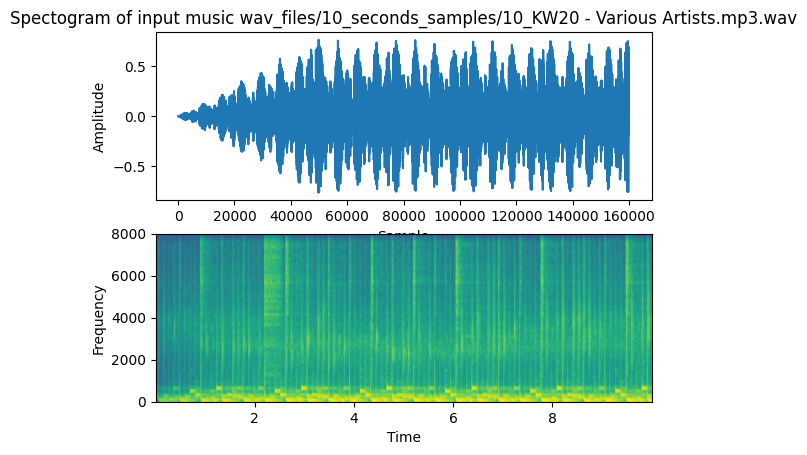

In [ ]:
import matplotlib.pyplot as plot

 

# Plot the signal read from wav file

plot.subplot(211)

plot.title('Spectogram of input music {}'.format(inp_file))

 

plot.plot(waveform)

plot.xlabel('Sample')

plot.ylabel('Amplitude')

 

plot.subplot(212)

plot.specgram(waveform,Fs=16000)

plot.xlabel('Time')

plot.ylabel('Frequency')

 

plot.show()

 

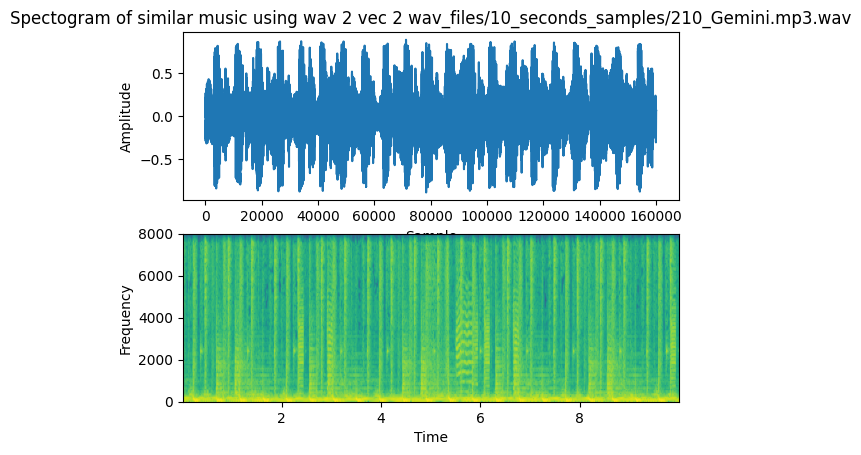

In [ ]:
# Plot the signal read from wav file

plot.subplot(211)

plot.title('Spectogram of similar music using wav 2 vec 2 {}'.format(matched_file_wav))

waveform, sample_rate = torchaudio.load(matched_file_wav)
waveform = waveform.squeeze().numpy()

plot.plot(waveform)

plot.xlabel('Sample')

plot.ylabel('Amplitude')

 

plot.subplot(212)

plot.specgram(waveform,Fs=16000)

plot.xlabel('Time')

plot.ylabel('Frequency')

 

plot.show()

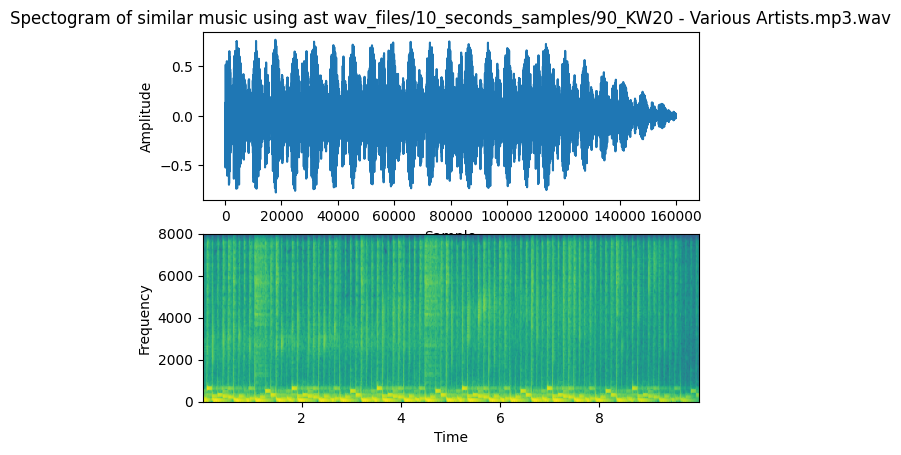

In [ ]:
plot.subplot(211)

plot.title('Spectogram of similar music using ast {}'.format(matched_file_ast))

waveform, sample_rate = torchaudio.load(matched_file_ast)
waveform = waveform.squeeze().numpy()

plot.plot(waveform)

plot.xlabel('Sample')

plot.ylabel('Amplitude')

 

plot.subplot(212)

plot.specgram(waveform,Fs=16000)

plot.xlabel('Time')

plot.ylabel('Frequency')

 

plot.show()

In [ ]:
import numpy as np
from docarray import DocumentArray
from docarray import base

docs = DocumentArray.empty(index_ast.ntotal)

In [ ]:
docs.embeddings

In [ ]:
docs.embeddings = embeddings_ast

In [ ]:
docs.

In [ ]:
docs.plot_embeddings(port=8892, host='0.0.0.0')

/home/ubuntu/audio_llm/venv/lib/python3.10/site-packages/docarray/array/mixins/plot.py:277: UserWarning: Showing iframe in cell, you may want to open http://0.0.0.0:8892/static/index.html?config=config.json in a new tab for better experience. Also, `localhost` may need to be changed to the IP address if your jupyter is running remotely. Click "stop" button in the toolbar to move to the next cell.
  warnings.warn(


KeyboardInterrupt: 